In [79]:
import os
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

path = "./data/"
validation_split=0.1
WIDTH = 512
HEIGHT = 32
img_size = (WIDTH, HEIGHT)
os_name = ["ios", "emui", "oneui", "miui"]

In [ ]:
import os
import zipfile

fz=zipfile.ZipFile('./data.zip')
fz.extractall('./data')
fz.close()

In [7]:
def get_image(path):
    #img = Image.open(path).convert('RGB')
    img = Image.open(path).convert('RGB')
    img = img.crop((0,0,img.width,min(img.height,int(0.06*img.width))))
    img = img.resize(img_size)
    img = np.array(img)
    return img

In [8]:
def get_data(data_path):
    ret = []
    for name in os.listdir(data_path):
        ret.append(get_image(data_path+name))
    return np.array(ret)

for index,name in enumerate(os_name):
    subpath=path+name+'/'
    sz=len(os.listdir(subpath))
    train_sz=int(sz*(1-validation_split))
    cur=get_data(subpath)
    if index==0:
        train_data_x=cur[:train_sz]
        test_data_x=cur[train_sz:]
        train_data_y=([index]*train_sz)
        test_data_y=([index]*(sz-train_sz))
    else:
        train_data_x=np.vstack((train_data_x,cur[:train_sz]))
        test_data_x=np.vstack((test_data_x,cur[train_sz:]))
        train_data_y+=([index]*train_sz)
        test_data_y+=([index]*(sz-train_sz))
train_data_y=np.array(train_data_y)
test_data_y=np.array(test_data_y)

In [9]:
print(train_data_x.shape)
print(train_data_y.shape)
print(test_data_x.shape)
print(test_data_y.shape)

(1042, 32, 512, 3)
(1042,)
(118, 32, 512, 3)
(118,)


In [10]:
from tensorflow.keras.utils import to_categorical

train_data_x = train_data_x / 255  
test_data_x = test_data_x / 255  
num_classes = len(os_name)        
train_data_y = to_categorical(train_data_y, num_classes)
test_data_y = to_categorical(test_data_y, num_classes)

In [11]:
print(train_data_x.shape)
print(train_data_y.shape)
print(test_data_x.shape)
print(test_data_y.shape)

(1042, 32, 512, 3)
(1042, 4)
(118, 32, 512, 3)
(118, 4)


/opt/conda/envs/tensorflow2_py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


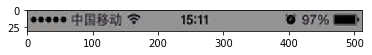

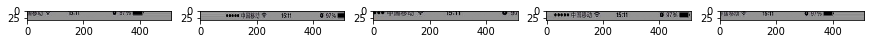

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

import matplotlib.pyplot as plt
origin_image = test_data_x[np.random.randint(len(test_data_x))] # 选取原图

# 将原图画出来
plt.imshow(origin_image) 
plt.show()

# 对图像作五次随机变换并画出来
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax = ax.flatten()
for i in range(5):
    ax[i].imshow(datagen.random_transform(origin_image)) # 使用datagen对图像作随机变换
plt.show()

In [8]:
cnt=[0,0,0,0]
for i in test_data_y:
    for j in range(4):
        if i[j] :cnt[j]+=1
print(cnt)

[26, 34, 33, 25]


In [13]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [15]:
def residual_block(x, filters, strides):
    y = Conv2D(filters=filters,
               kernel_size=3,
               strides=strides,
               padding="same")(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Conv2D(filters=filters,
               kernel_size=3,
               strides=1,
               padding="same")(y)
    y = BatchNormalization()(y)

    if x.shape != y.shape:
        x = Conv2D(filters=filters,
                   kernel_size=1,
                   strides=strides,
                   padding="same")(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out

def create_res_net():
    inputs = Input(shape=(HEIGHT,WIDTH, 3))
    x = Conv2D(filters=64,
               kernel_size=7,
               strides=1,
               padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3,
                     strides=2,
                     padding="same")(x)

    filters = 64
    num_layers = [2, 2, 2, 2]
    for i in range(len(num_layers)):
        for j in range(num_layers[i]):
            strides = 2 if (i > 1 and j == 0) else 1
            x = residual_block(x, filters, strides)
        filters *= 2

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(
        loss="categorical_crossentropy",
        optimizer="Adam",
        metrics=["accuracy"]
    )
    return model

# 模型训练
res_model = create_res_net()
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 512, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 512, 64)  9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 32, 512, 64)  256         conv2d_25[0][0]                  
__________________________________________________________________________________________________
re_lu_17 (ReLU)                 (None, 32, 512, 64)  0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [17]:
epochs = 80
batch_size = 64

def scheduler(epoch):
    lr = 0.001
    if epoch > 60:
        lr = 0.0001
    return lr
change_lr = LearningRateScheduler(scheduler)

res_history = res_model.fit_generator(datagen.flow(train_data_x, train_data_y, batch_size=batch_size),
                    epochs=epochs,
                    callbacks=[change_lr],
                    verbose=1,
                    validation_data=(test_data_x, test_data_y))
res_score = res_model.evaluate(test_data_x, test_data_y, verbose=0)       # 模型评估，返回模型的loss和metric
print('Test loss:', res_score[0])                           # 测试集上模型损失
print('Test accuracy:', res_score[1])                       # 测试集上模型精度

Epoch 1/80
17/17 [==============================] - 5s 324ms/step - loss: 0.2183 - accuracy: 0.9242 - val_loss: 5.2108 - val_accuracy: 0.5169
Epoch 2/80
17/17 [==============================] - 5s 315ms/step - loss: 0.2224 - accuracy: 0.9146 - val_loss: 2.9756 - val_accuracy: 0.5508
Epoch 3/80
17/17 [==============================] - 5s 314ms/step - loss: 0.2442 - accuracy: 0.9203 - val_loss: 5.3477 - val_accuracy: 0.4661
Epoch 4/80
17/17 [==============================] - 5s 313ms/step - loss: 0.2737 - accuracy: 0.8973 - val_loss: 7.1288 - val_accuracy: 0.4153
Epoch 5/80
17/17 [==============================] - 5s 312ms/step - loss: 0.2323 - accuracy: 0.9098 - val_loss: 5.1115 - val_accuracy: 0.5339
Epoch 6/80
17/17 [==============================] - 5s 314ms/step - loss: 0.2628 - accuracy: 0.9175 - val_loss: 2.9207 - val_accuracy: 0.6186
Epoch 7/80
17/17 [==============================] - 5s 313ms/step - loss: 0.2302 - accuracy: 0.9127 - val_loss: 2.9198 - val_accuracy: 0.5678
Epoch 

In [26]:
model.save('resnet.h5')

---


In [35]:
from tensorflow.keras.layers import DepthwiseConv2D
def depthwise_separable_conv(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3,
                        strides=strides,
                        padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=1,
               strides=1,
               padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def create_mobile_net():
    inputs = Input(shape=(HEIGHT, WIDTH, 3))
    x = Conv2D(filters=32,
               kernel_size=3,
               strides=1,
               padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = depthwise_separable_conv(x, 32, 1)
    x = depthwise_separable_conv(x, 64, 1)
    x = depthwise_separable_conv(x, 64, 1)
    x = depthwise_separable_conv(x, 128, 1)
    x = depthwise_separable_conv(x, 128, 1)
    x = depthwise_separable_conv(x, 256, 2)
    
    x = depthwise_separable_conv(x, 512, 2)
    x = depthwise_separable_conv(x, 512, 2)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

mobile_model = create_mobile_net()
mobile_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 512, 3)]      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 512, 32)       896       
_________________________________________________________________
batch_normalization_51 (Batc (None, 32, 512, 32)       128       
_________________________________________________________________
re_lu_51 (ReLU)              (None, 32, 512, 32)       0         
_________________________________________________________________
depthwise_conv2d_8 (Depthwis (None, 32, 512, 32)       320       
_________________________________________________________________
batch_normalization_52 (Batc (None, 32, 512, 32)       128       
_________________________________________________________________
re_lu_52 (ReLU)              (None, 32, 512, 32)       0   

In [36]:
epochs = 200
batch_size = 64

def scheduler(epoch):
    lr = 0.01
    if epoch > 0.7*epochs:
        lr = 0.001
    return lr
change_lr = LearningRateScheduler(scheduler)


mobile_history = mobile_model.fit_generator(datagen.flow(train_data_x, train_data_y, batch_size=batch_size),
                    epochs=epochs,
                    callbacks=[change_lr],
                    verbose=1,
                    validation_data=(test_data_x, test_data_y))

Epoch 1/200
17/17 [==============================] - 8s 468ms/step - loss: 1.5488 - accuracy: 0.3781 - val_loss: 1.3895 - val_accuracy: 0.2881
Epoch 2/200
17/17 [==============================] - 7s 429ms/step - loss: 1.2428 - accuracy: 0.4770 - val_loss: 1.4307 - val_accuracy: 0.2797
Epoch 3/200
17/17 [==============================] - 7s 431ms/step - loss: 1.1581 - accuracy: 0.5096 - val_loss: 1.5304 - val_accuracy: 0.2797
Epoch 4/200
17/17 [==============================] - 7s 429ms/step - loss: 1.1378 - accuracy: 0.5240 - val_loss: 1.5804 - val_accuracy: 0.2797
Epoch 5/200
17/17 [==============================] - 7s 428ms/step - loss: 1.0789 - accuracy: 0.5701 - val_loss: 1.7062 - val_accuracy: 0.2797
Epoch 6/200
17/17 [==============================] - 7s 433ms/step - loss: 0.9945 - accuracy: 0.5921 - val_loss: 1.7360 - val_accuracy: 0.2797
Epoch 7/200
17/17 [==============================] - 7s 428ms/step - loss: 1.0448 - accuracy: 0.5739 - val_loss: 1.6993 - val_accuracy: 0.2797

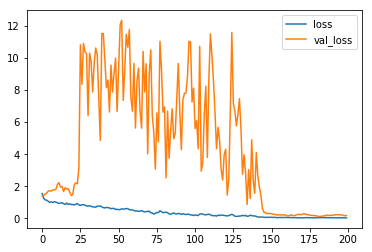

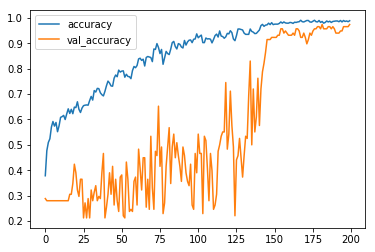

In [37]:
import matplotlib.pyplot as plt

plt.plot(mobile_history.history['loss'],label="loss")
plt.plot(mobile_history.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

plt.plot(mobile_history.history['accuracy'],label="accuracy")

plt.plot(mobile_history.history['val_accuracy'],label="val_accuracy")
plt.legend()
plt.show()


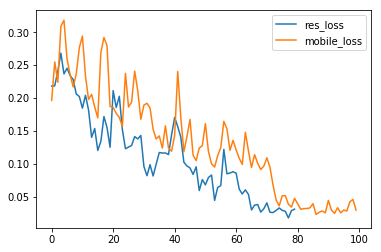

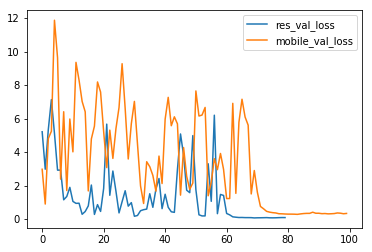

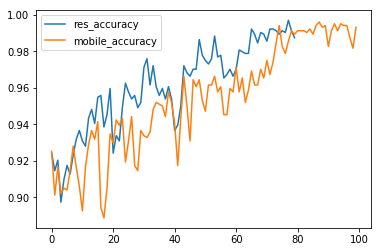

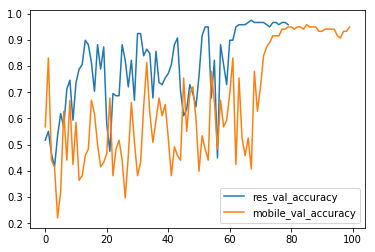

In [28]:
plt.plot(res_history.history['loss'],label="res_loss")
plt.plot(mobile_history.history['loss'],label="mobile_loss")
plt.legend()
plt.show()

plt.plot(res_history.history['val_loss'],label="res_val_loss")
plt.plot(mobile_history.history['val_loss'],label="mobile_val_loss")
plt.legend()
plt.show()

plt.plot(res_history.history['accuracy'],label="res_accuracy")
plt.plot(mobile_history.history['accuracy'],label="mobile_accuracy")
plt.legend()
plt.show()

plt.plot(res_history.history['val_accuracy'],label="res_val_accuracy")
plt.plot(mobile_history.history['val_accuracy'],label="mobile_val_accuracy")
plt.legend()
plt.show()

In [38]:
mobile_model.save('mobilenet.h5')

In [ ]:
from tensorflow.keras.models import load_model
res_model=load_model('resnet.h5')

In [4]:
from tensorflow.keras.models import load_model
mobile_model=load_model('mobilenet.h5')

In [12]:
score_m = mobile_model.evaluate(test_data_x, test_data_y, verbose=0) 
print('mobile net:\nTest loss:', score_m[0])                           # 测试集上模型损失
print('Test accuracy:', score_m[1]) 

score_m_train = mobile_model.evaluate(train_data_x, train_data_y, verbose=0) 
print('mobile net:\nTest loss:', score_m_train[0])                           # 测试集上模型损失
print('Train accuracy:', score_m_train[1]) 


mobile net:
Test loss: 0.0627397894859314
Test accuracy: 0.991525411605835
mobile net:
Test loss: 0.022789020091295242
Test accuracy: 0.9932821393013


In [ ]:
score_r = res_model.evaluate(test_data_x, test_data_y, verbose=0) 
print('res net:\nTest loss:', score_r[0])                           # 测试集上模型损失
print('Test accuracy:', score_r[1]) 

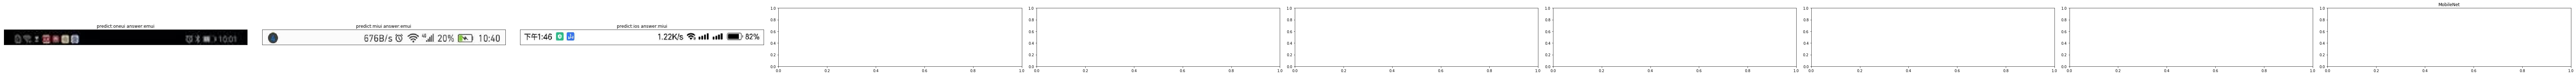

In [42]:
res_predict=np.argmax(res_model.predict(test_data_x),axis=1)
mobile_predict=np.argmax(mobile_model.predict(test_data_x),axis=1)
answer=np.argmax(test_data_y,axis=1)

def print_data(indexs,pre,title):
    sz=len(indexs)
    fig, axes = plt.subplots( (sz+9)//10,10,figsize=(100,3))
    axes = axes.flatten()
    for i,index in enumerate(indexs):
        img=test_data_x[index]
        axes[i].set_title(f"predict:{os_name[pre[index]]} answer:{os_name[answer[index]]}")
        axes[i].imshow(img)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.title(title)
    plt.tight_layout()
    plt.show()

                
print_data(np.where(mobile_predict!=answer)[0],mobile_predict,"MobileNet")


(49152,)
(32, 512, 3)


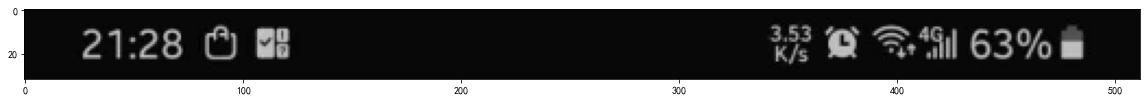

In [36]:
x='{"0":8,"1":8,"2":8,"3":8,"4":8,"5":8,"6":8,"7":8,"8":8,"9":8,"10":8,"11":8,"12":8,"13":8,"14":8,"15":8,"16":8,"17":8,"18":8,"19":8,"20":8,"21":8,"22":8,"23":8,"24":8,"25":8,"26":8,"27":8,"28":8,"29":8,"30":8,"31":8,"32":8,"33":8,"34":8,"35":8,"36":8,"37":8,"38":8,"39":8,"40":8,"41":8,"42":8,"43":8,"44":8,"45":8,"46":8,"47":8,"48":8,"49":8,"50":8,"51":8,"52":8,"53":8,"54":8,"55":8,"56":8,"57":8,"58":8,"59":8,"60":8,"61":8,"62":8,"63":8,"64":8,"65":8,"66":8,"67":8,"68":8,"69":8,"70":8,"71":8,"72":8,"73":8,"74":8,"75":8,"76":8,"77":8,"78":8,"79":8,"80":8,"81":8,"82":8,"83":8,"84":8,"85":8,"86":8,"87":8,"88":8,"89":8,"90":8,"91":8,"92":8,"93":8,"94":8,"95":8,"96":8,"97":8,"98":8,"99":8,"100":8,"101":8,"102":8,"103":8,"104":8,"105":8,"106":8,"107":8,"108":8,"109":8,"110":8,"111":8,"112":8,"113":8,"114":8,"115":8,"116":8,"117":8,"118":8,"119":8,"120":8,"121":8,"122":8,"123":8,"124":8,"125":8,"126":8,"127":8,"128":8,"129":8,"130":8,"131":8,"132":8,"133":8,"134":8,"135":8,"136":8,"137":8,"138":8,"139":8,"140":8,"141":8,"142":8,"143":8,"144":8,"145":8,"146":8,"147":8,"148":8,"149":8,"150":8,"151":8,"152":8,"153":8,"154":8,"155":8,"156":8,"157":8,"158":8,"159":8,"160":8,"161":8,"162":8,"163":8,"164":8,"165":8,"166":8,"167":8,"168":8,"169":8,"170":8,"171":8,"172":8,"173":8,"174":8,"175":8,"176":8,"177":8,"178":8,"179":8,"180":8,"181":8,"182":8,"183":8,"184":8,"185":8,"186":8,"187":8,"188":8,"189":8,"190":8,"191":8,"192":8,"193":8,"194":8,"195":8,"196":8,"197":8,"198":8,"199":8,"200":8,"201":8,"202":8,"203":8,"204":8,"205":8,"206":8,"207":8,"208":8,"209":8,"210":8,"211":8,"212":8,"213":8,"214":8,"215":8,"216":8,"217":8,"218":8,"219":8,"220":8,"221":8,"222":8,"223":8,"224":8,"225":8,"226":8,"227":8,"228":8,"229":8,"230":8,"231":8,"232":8,"233":8,"234":8,"235":8,"236":8,"237":8,"238":8,"239":8,"240":8,"241":8,"242":8,"243":8,"244":8,"245":8,"246":8,"247":8,"248":8,"249":8,"250":8,"251":8,"252":8,"253":8,"254":8,"255":8,"256":8,"257":8,"258":8,"259":8,"260":8,"261":8,"262":8,"263":8,"264":8,"265":8,"266":8,"267":8,"268":8,"269":8,"270":8,"271":8,"272":8,"273":8,"274":8,"275":8,"276":8,"277":8,"278":8,"279":8,"280":8,"281":8,"282":8,"283":8,"284":8,"285":8,"286":8,"287":8,"288":8,"289":8,"290":8,"291":8,"292":8,"293":8,"294":8,"295":8,"296":8,"297":8,"298":8,"299":8,"300":8,"301":8,"302":8,"303":8,"304":8,"305":8,"306":8,"307":8,"308":8,"309":8,"310":8,"311":8,"312":8,"313":8,"314":8,"315":8,"316":8,"317":8,"318":8,"319":8,"320":8,"321":8,"322":8,"323":8,"324":8,"325":8,"326":8,"327":8,"328":8,"329":8,"330":8,"331":8,"332":8,"333":8,"334":8,"335":8,"336":8,"337":8,"338":8,"339":8,"340":8,"341":8,"342":8,"343":8,"344":8,"345":8,"346":8,"347":8,"348":8,"349":8,"350":8,"351":8,"352":8,"353":8,"354":8,"355":8,"356":8,"357":8,"358":8,"359":8,"360":8,"361":8,"362":8,"363":8,"364":8,"365":8,"366":8,"367":8,"368":8,"369":8,"370":8,"371":8,"372":8,"373":8,"374":8,"375":8,"376":8,"377":8,"378":8,"379":8,"380":8,"381":8,"382":8,"383":8,"384":8,"385":8,"386":8,"387":8,"388":8,"389":8,"390":8,"391":8,"392":8,"393":8,"394":8,"395":8,"396":8,"397":8,"398":8,"399":8,"400":8,"401":8,"402":8,"403":8,"404":8,"405":8,"406":8,"407":8,"408":8,"409":8,"410":8,"411":8,"412":8,"413":8,"414":8,"415":8,"416":8,"417":8,"418":8,"419":8,"420":8,"421":8,"422":8,"423":8,"424":8,"425":8,"426":8,"427":8,"428":8,"429":8,"430":8,"431":8,"432":8,"433":8,"434":8,"435":8,"436":8,"437":8,"438":8,"439":8,"440":8,"441":8,"442":8,"443":8,"444":8,"445":8,"446":8,"447":8,"448":8,"449":8,"450":8,"451":8,"452":8,"453":8,"454":8,"455":8,"456":8,"457":8,"458":8,"459":8,"460":8,"461":8,"462":8,"463":8,"464":8,"465":8,"466":8,"467":8,"468":8,"469":8,"470":8,"471":8,"472":8,"473":8,"474":8,"475":8,"476":8,"477":8,"478":8,"479":8,"480":8,"481":8,"482":8,"483":8,"484":8,"485":8,"486":8,"487":8,"488":8,"489":8,"490":8,"491":8,"492":8,"493":8,"494":8,"495":8,"496":8,"497":8,"498":8,"499":8,"500":8,"501":8,"502":8,"503":8,"504":8,"505":8,"506":8,"507":8,"508":8,"509":8,"510":8,"511":8,"512":8,"513":8,"514":8,"515":8,"516":8,"517":8,"518":8,"519":8,"520":8,"521":8,"522":8,"523":8,"524":8,"525":8,"526":8,"527":8,"528":8,"529":8,"530":8,"531":8,"532":8,"533":8,"534":8,"535":8,"536":8,"537":8,"538":8,"539":8,"540":8,"541":8,"542":8,"543":8,"544":8,"545":8,"546":8,"547":8,"548":8,"549":8,"550":8,"551":8,"552":8,"553":8,"554":8,"555":8,"556":8,"557":8,"558":8,"559":8,"560":8,"561":8,"562":8,"563":8,"564":8,"565":8,"566":8,"567":8,"568":8,"569":8,"570":8,"571":8,"572":8,"573":8,"574":8,"575":8,"576":8,"577":8,"578":8,"579":8,"580":8,"581":8,"582":8,"583":8,"584":8,"585":8,"586":8,"587":8,"588":8,"589":8,"590":8,"591":8,"592":8,"593":8,"594":8,"595":8,"596":8,"597":8,"598":8,"599":8,"600":8,"601":8,"602":8,"603":8,"604":8,"605":8,"606":8,"607":8,"608":8,"609":8,"610":8,"611":8,"612":8,"613":8,"614":8,"615":8,"616":8,"617":8,"618":8,"619":8,"620":8,"621":8,"622":8,"623":8,"624":8,"625":8,"626":8,"627":8,"628":8,"629":8,"630":8,"631":8,"632":8,"633":8,"634":8,"635":8,"636":8,"637":8,"638":8,"639":8,"640":8,"641":8,"642":8,"643":8,"644":8,"645":8,"646":8,"647":8,"648":8,"649":8,"650":8,"651":8,"652":8,"653":8,"654":8,"655":8,"656":8,"657":8,"658":8,"659":8,"660":8,"661":8,"662":8,"663":8,"664":8,"665":8,"666":8,"667":8,"668":8,"669":8,"670":8,"671":8,"672":8,"673":8,"674":8,"675":8,"676":8,"677":8,"678":8,"679":8,"680":8,"681":8,"682":8,"683":8,"684":8,"685":8,"686":8,"687":8,"688":8,"689":8,"690":8,"691":8,"692":8,"693":8,"694":8,"695":8,"696":8,"697":8,"698":8,"699":8,"700":8,"701":8,"702":8,"703":8,"704":8,"705":8,"706":8,"707":8,"708":8,"709":8,"710":8,"711":8,"712":8,"713":8,"714":8,"715":8,"716":8,"717":8,"718":8,"719":8,"720":8,"721":8,"722":8,"723":8,"724":8,"725":8,"726":8,"727":8,"728":8,"729":8,"730":8,"731":8,"732":8,"733":8,"734":8,"735":8,"736":8,"737":8,"738":8,"739":8,"740":8,"741":8,"742":8,"743":8,"744":8,"745":8,"746":8,"747":8,"748":8,"749":8,"750":8,"751":8,"752":8,"753":8,"754":8,"755":8,"756":8,"757":8,"758":8,"759":8,"760":8,"761":8,"762":8,"763":8,"764":8,"765":8,"766":8,"767":8,"768":8,"769":8,"770":8,"771":8,"772":8,"773":8,"774":8,"775":8,"776":8,"777":8,"778":8,"779":8,"780":8,"781":8,"782":8,"783":8,"784":8,"785":8,"786":8,"787":8,"788":8,"789":8,"790":8,"791":8,"792":8,"793":8,"794":8,"795":8,"796":8,"797":8,"798":8,"799":8,"800":8,"801":8,"802":8,"803":8,"804":8,"805":8,"806":8,"807":8,"808":8,"809":8,"810":8,"811":8,"812":8,"813":8,"814":8,"815":8,"816":8,"817":8,"818":8,"819":8,"820":8,"821":8,"822":8,"823":8,"824":8,"825":8,"826":8,"827":8,"828":8,"829":8,"830":8,"831":8,"832":8,"833":8,"834":8,"835":8,"836":8,"837":8,"838":8,"839":8,"840":8,"841":8,"842":8,"843":8,"844":8,"845":8,"846":8,"847":8,"848":8,"849":8,"850":8,"851":8,"852":8,"853":8,"854":8,"855":8,"856":8,"857":8,"858":8,"859":8,"860":8,"861":8,"862":8,"863":8,"864":8,"865":8,"866":8,"867":8,"868":8,"869":8,"870":8,"871":8,"872":8,"873":8,"874":8,"875":8,"876":8,"877":8,"878":8,"879":8,"880":8,"881":8,"882":8,"883":8,"884":8,"885":8,"886":8,"887":8,"888":8,"889":8,"890":8,"891":8,"892":8,"893":8,"894":8,"895":8,"896":8,"897":8,"898":8,"899":8,"900":8,"901":8,"902":8,"903":8,"904":8,"905":8,"906":8,"907":8,"908":8,"909":8,"910":8,"911":8,"912":8,"913":8,"914":8,"915":8,"916":8,"917":8,"918":8,"919":8,"920":8,"921":8,"922":8,"923":8,"924":8,"925":8,"926":8,"927":8,"928":8,"929":8,"930":8,"931":8,"932":8,"933":8,"934":8,"935":8,"936":8,"937":8,"938":8,"939":8,"940":8,"941":8,"942":8,"943":8,"944":8,"945":8,"946":8,"947":8,"948":8,"949":8,"950":8,"951":8,"952":8,"953":8,"954":8,"955":8,"956":8,"957":8,"958":8,"959":8,"960":8,"961":8,"962":8,"963":8,"964":8,"965":8,"966":8,"967":8,"968":8,"969":8,"970":8,"971":8,"972":8,"973":8,"974":8,"975":8,"976":8,"977":8,"978":8,"979":8,"980":8,"981":8,"982":8,"983":8,"984":8,"985":8,"986":8,"987":8,"988":8,"989":8,"990":8,"991":8,"992":8,"993":8,"994":8,"995":8,"996":8,"997":8,"998":8,"999":8,"1000":8,"1001":8,"1002":8,"1003":8,"1004":8,"1005":8,"1006":8,"1007":8,"1008":8,"1009":8,"1010":8,"1011":8,"1012":8,"1013":8,"1014":8,"1015":8,"1016":8,"1017":8,"1018":8,"1019":8,"1020":8,"1021":8,"1022":8,"1023":8,"1024":8,"1025":8,"1026":8,"1027":8,"1028":8,"1029":8,"1030":8,"1031":8,"1032":8,"1033":8,"1034":8,"1035":8,"1036":8,"1037":8,"1038":8,"1039":8,"1040":8,"1041":8,"1042":8,"1043":8,"1044":8,"1045":8,"1046":8,"1047":8,"1048":8,"1049":8,"1050":8,"1051":8,"1052":8,"1053":8,"1054":8,"1055":8,"1056":8,"1057":8,"1058":8,"1059":8,"1060":8,"1061":8,"1062":8,"1063":8,"1064":8,"1065":8,"1066":8,"1067":8,"1068":8,"1069":8,"1070":8,"1071":8,"1072":8,"1073":8,"1074":8,"1075":8,"1076":8,"1077":8,"1078":8,"1079":8,"1080":8,"1081":8,"1082":8,"1083":8,"1084":8,"1085":8,"1086":8,"1087":8,"1088":8,"1089":8,"1090":8,"1091":8,"1092":8,"1093":8,"1094":8,"1095":8,"1096":8,"1097":8,"1098":8,"1099":8,"1100":8,"1101":8,"1102":8,"1103":8,"1104":8,"1105":8,"1106":8,"1107":8,"1108":8,"1109":8,"1110":8,"1111":8,"1112":8,"1113":8,"1114":8,"1115":8,"1116":8,"1117":8,"1118":8,"1119":8,"1120":8,"1121":8,"1122":8,"1123":8,"1124":8,"1125":8,"1126":8,"1127":8,"1128":8,"1129":8,"1130":8,"1131":8,"1132":8,"1133":8,"1134":8,"1135":8,"1136":8,"1137":8,"1138":8,"1139":8,"1140":8,"1141":8,"1142":8,"1143":8,"1144":8,"1145":8,"1146":8,"1147":8,"1148":8,"1149":8,"1150":8,"1151":8,"1152":8,"1153":8,"1154":8,"1155":8,"1156":8,"1157":8,"1158":8,"1159":8,"1160":8,"1161":8,"1162":8,"1163":8,"1164":8,"1165":8,"1166":8,"1167":8,"1168":8,"1169":8,"1170":8,"1171":8,"1172":8,"1173":8,"1174":8,"1175":8,"1176":8,"1177":8,"1178":8,"1179":8,"1180":8,"1181":8,"1182":8,"1183":8,"1184":8,"1185":8,"1186":8,"1187":8,"1188":8,"1189":8,"1190":8,"1191":8,"1192":8,"1193":8,"1194":8,"1195":8,"1196":8,"1197":8,"1198":8,"1199":8,"1200":8,"1201":8,"1202":8,"1203":8,"1204":8,"1205":8,"1206":8,"1207":8,"1208":8,"1209":8,"1210":8,"1211":8,"1212":8,"1213":8,"1214":8,"1215":8,"1216":8,"1217":8,"1218":8,"1219":8,"1220":8,"1221":8,"1222":8,"1223":8,"1224":8,"1225":8,"1226":8,"1227":8,"1228":8,"1229":8,"1230":8,"1231":8,"1232":8,"1233":8,"1234":8,"1235":8,"1236":8,"1237":8,"1238":8,"1239":8,"1240":8,"1241":8,"1242":8,"1243":8,"1244":8,"1245":8,"1246":8,"1247":8,"1248":8,"1249":8,"1250":8,"1251":8,"1252":8,"1253":8,"1254":8,"1255":8,"1256":8,"1257":8,"1258":8,"1259":8,"1260":8,"1261":8,"1262":8,"1263":8,"1264":8,"1265":8,"1266":8,"1267":8,"1268":8,"1269":8,"1270":8,"1271":8,"1272":8,"1273":8,"1274":8,"1275":8,"1276":8,"1277":8,"1278":8,"1279":8,"1280":8,"1281":8,"1282":8,"1283":8,"1284":8,"1285":8,"1286":8,"1287":8,"1288":8,"1289":8,"1290":8,"1291":8,"1292":8,"1293":8,"1294":8,"1295":8,"1296":8,"1297":8,"1298":8,"1299":8,"1300":8,"1301":8,"1302":8,"1303":8,"1304":8,"1305":8,"1306":8,"1307":8,"1308":8,"1309":8,"1310":8,"1311":8,"1312":8,"1313":8,"1314":8,"1315":8,"1316":8,"1317":8,"1318":8,"1319":8,"1320":8,"1321":8,"1322":8,"1323":8,"1324":8,"1325":8,"1326":8,"1327":8,"1328":8,"1329":8,"1330":8,"1331":8,"1332":8,"1333":8,"1334":8,"1335":8,"1336":8,"1337":8,"1338":8,"1339":8,"1340":8,"1341":8,"1342":8,"1343":8,"1344":8,"1345":8,"1346":8,"1347":8,"1348":8,"1349":8,"1350":8,"1351":8,"1352":8,"1353":8,"1354":8,"1355":8,"1356":8,"1357":8,"1358":8,"1359":8,"1360":8,"1361":8,"1362":8,"1363":8,"1364":8,"1365":8,"1366":8,"1367":8,"1368":8,"1369":8,"1370":8,"1371":8,"1372":8,"1373":8,"1374":8,"1375":8,"1376":8,"1377":8,"1378":8,"1379":8,"1380":8,"1381":8,"1382":8,"1383":8,"1384":8,"1385":8,"1386":8,"1387":8,"1388":8,"1389":8,"1390":8,"1391":8,"1392":8,"1393":8,"1394":8,"1395":8,"1396":8,"1397":8,"1398":8,"1399":8,"1400":8,"1401":8,"1402":8,"1403":8,"1404":8,"1405":8,"1406":8,"1407":8,"1408":8,"1409":8,"1410":8,"1411":8,"1412":8,"1413":8,"1414":8,"1415":8,"1416":8,"1417":8,"1418":8,"1419":8,"1420":8,"1421":8,"1422":8,"1423":8,"1424":8,"1425":8,"1426":8,"1427":8,"1428":8,"1429":8,"1430":8,"1431":8,"1432":8,"1433":8,"1434":8,"1435":8,"1436":8,"1437":8,"1438":8,"1439":8,"1440":8,"1441":8,"1442":8,"1443":8,"1444":8,"1445":8,"1446":8,"1447":8,"1448":8,"1449":8,"1450":8,"1451":8,"1452":8,"1453":8,"1454":8,"1455":8,"1456":8,"1457":8,"1458":8,"1459":8,"1460":8,"1461":8,"1462":8,"1463":8,"1464":8,"1465":8,"1466":8,"1467":8,"1468":8,"1469":8,"1470":8,"1471":8,"1472":8,"1473":8,"1474":8,"1475":8,"1476":8,"1477":8,"1478":8,"1479":8,"1480":8,"1481":8,"1482":8,"1483":8,"1484":8,"1485":8,"1486":8,"1487":8,"1488":8,"1489":8,"1490":8,"1491":8,"1492":8,"1493":8,"1494":8,"1495":8,"1496":8,"1497":8,"1498":8,"1499":8,"1500":8,"1501":8,"1502":8,"1503":8,"1504":8,"1505":8,"1506":8,"1507":8,"1508":8,"1509":8,"1510":8,"1511":8,"1512":8,"1513":8,"1514":8,"1515":8,"1516":8,"1517":8,"1518":8,"1519":8,"1520":8,"1521":8,"1522":8,"1523":8,"1524":8,"1525":8,"1526":8,"1527":8,"1528":8,"1529":8,"1530":8,"1531":8,"1532":8,"1533":8,"1534":8,"1535":8,"1536":8,"1537":8,"1538":8,"1539":8,"1540":8,"1541":8,"1542":8,"1543":8,"1544":8,"1545":8,"1546":8,"1547":8,"1548":8,"1549":8,"1550":8,"1551":8,"1552":8,"1553":8,"1554":8,"1555":8,"1556":8,"1557":8,"1558":8,"1559":8,"1560":8,"1561":8,"1562":8,"1563":8,"1564":8,"1565":8,"1566":8,"1567":8,"1568":8,"1569":8,"1570":8,"1571":8,"1572":8,"1573":8,"1574":8,"1575":8,"1576":8,"1577":8,"1578":8,"1579":8,"1580":8,"1581":8,"1582":8,"1583":8,"1584":8,"1585":8,"1586":8,"1587":8,"1588":8,"1589":8,"1590":8,"1591":8,"1592":8,"1593":8,"1594":8,"1595":8,"1596":8,"1597":8,"1598":8,"1599":8,"1600":8,"1601":8,"1602":8,"1603":8,"1604":8,"1605":8,"1606":8,"1607":8,"1608":8,"1609":8,"1610":8,"1611":8,"1612":8,"1613":8,"1614":8,"1615":8,"1616":8,"1617":8,"1618":8,"1619":8,"1620":8,"1621":8,"1622":8,"1623":8,"1624":8,"1625":8,"1626":8,"1627":8,"1628":8,"1629":8,"1630":8,"1631":8,"1632":8,"1633":8,"1634":8,"1635":8,"1636":8,"1637":8,"1638":8,"1639":8,"1640":8,"1641":8,"1642":8,"1643":8,"1644":8,"1645":8,"1646":8,"1647":8,"1648":8,"1649":8,"1650":8,"1651":8,"1652":8,"1653":8,"1654":8,"1655":8,"1656":8,"1657":8,"1658":8,"1659":8,"1660":8,"1661":8,"1662":8,"1663":8,"1664":8,"1665":8,"1666":8,"1667":8,"1668":8,"1669":8,"1670":8,"1671":8,"1672":8,"1673":8,"1674":8,"1675":8,"1676":8,"1677":8,"1678":8,"1679":8,"1680":8,"1681":8,"1682":8,"1683":8,"1684":8,"1685":8,"1686":8,"1687":8,"1688":8,"1689":8,"1690":8,"1691":8,"1692":8,"1693":8,"1694":8,"1695":8,"1696":8,"1697":8,"1698":8,"1699":8,"1700":8,"1701":8,"1702":8,"1703":8,"1704":8,"1705":8,"1706":8,"1707":8,"1708":8,"1709":8,"1710":8,"1711":8,"1712":8,"1713":8,"1714":8,"1715":8,"1716":8,"1717":8,"1718":8,"1719":8,"1720":8,"1721":8,"1722":8,"1723":8,"1724":8,"1725":8,"1726":8,"1727":8,"1728":8,"1729":8,"1730":8,"1731":8,"1732":8,"1733":8,"1734":8,"1735":8,"1736":8,"1737":8,"1738":8,"1739":8,"1740":8,"1741":8,"1742":8,"1743":8,"1744":8,"1745":8,"1746":8,"1747":8,"1748":8,"1749":8,"1750":8,"1751":8,"1752":8,"1753":8,"1754":8,"1755":8,"1756":8,"1757":8,"1758":8,"1759":8,"1760":8,"1761":8,"1762":8,"1763":8,"1764":8,"1765":8,"1766":8,"1767":8,"1768":8,"1769":8,"1770":8,"1771":8,"1772":8,"1773":8,"1774":8,"1775":8,"1776":8,"1777":8,"1778":8,"1779":8,"1780":8,"1781":8,"1782":8,"1783":8,"1784":8,"1785":8,"1786":8,"1787":8,"1788":8,"1789":8,"1790":8,"1791":8,"1792":8,"1793":8,"1794":8,"1795":8,"1796":8,"1797":8,"1798":8,"1799":8,"1800":8,"1801":8,"1802":8,"1803":8,"1804":8,"1805":8,"1806":8,"1807":8,"1808":8,"1809":8,"1810":8,"1811":8,"1812":8,"1813":8,"1814":8,"1815":8,"1816":8,"1817":8,"1818":8,"1819":8,"1820":8,"1821":8,"1822":8,"1823":8,"1824":8,"1825":8,"1826":8,"1827":8,"1828":8,"1829":8,"1830":8,"1831":8,"1832":8,"1833":8,"1834":8,"1835":8,"1836":8,"1837":8,"1838":8,"1839":8,"1840":8,"1841":8,"1842":8,"1843":8,"1844":8,"1845":8,"1846":8,"1847":8,"1848":8,"1849":8,"1850":8,"1851":8,"1852":8,"1853":8,"1854":8,"1855":8,"1856":8,"1857":8,"1858":8,"1859":8,"1860":8,"1861":8,"1862":8,"1863":8,"1864":8,"1865":8,"1866":8,"1867":8,"1868":8,"1869":8,"1870":8,"1871":8,"1872":8,"1873":8,"1874":8,"1875":8,"1876":8,"1877":8,"1878":8,"1879":8,"1880":8,"1881":8,"1882":8,"1883":8,"1884":8,"1885":8,"1886":8,"1887":8,"1888":8,"1889":8,"1890":8,"1891":8,"1892":8,"1893":8,"1894":8,"1895":8,"1896":8,"1897":8,"1898":8,"1899":8,"1900":8,"1901":8,"1902":8,"1903":8,"1904":8,"1905":8,"1906":8,"1907":8,"1908":8,"1909":8,"1910":8,"1911":8,"1912":8,"1913":8,"1914":8,"1915":8,"1916":8,"1917":8,"1918":8,"1919":8,"1920":8,"1921":8,"1922":8,"1923":8,"1924":8,"1925":8,"1926":8,"1927":8,"1928":8,"1929":8,"1930":8,"1931":8,"1932":8,"1933":8,"1934":8,"1935":8,"1936":8,"1937":8,"1938":8,"1939":8,"1940":8,"1941":8,"1942":8,"1943":8,"1944":8,"1945":8,"1946":8,"1947":8,"1948":8,"1949":8,"1950":8,"1951":8,"1952":8,"1953":8,"1954":8,"1955":8,"1956":8,"1957":8,"1958":8,"1959":8,"1960":8,"1961":8,"1962":8,"1963":8,"1964":8,"1965":8,"1966":8,"1967":8,"1968":8,"1969":8,"1970":8,"1971":8,"1972":8,"1973":8,"1974":8,"1975":8,"1976":8,"1977":8,"1978":8,"1979":8,"1980":8,"1981":8,"1982":8,"1983":8,"1984":8,"1985":8,"1986":8,"1987":8,"1988":8,"1989":8,"1990":8,"1991":8,"1992":8,"1993":8,"1994":8,"1995":8,"1996":8,"1997":8,"1998":8,"1999":8,"2000":8,"2001":8,"2002":8,"2003":8,"2004":8,"2005":8,"2006":8,"2007":8,"2008":8,"2009":8,"2010":8,"2011":8,"2012":8,"2013":8,"2014":8,"2015":8,"2016":8,"2017":8,"2018":8,"2019":8,"2020":8,"2021":8,"2022":8,"2023":8,"2024":8,"2025":8,"2026":8,"2027":8,"2028":8,"2029":8,"2030":8,"2031":8,"2032":8,"2033":8,"2034":8,"2035":8,"2036":8,"2037":8,"2038":8,"2039":8,"2040":8,"2041":8,"2042":8,"2043":8,"2044":8,"2045":8,"2046":8,"2047":8,"2048":8,"2049":8,"2050":8,"2051":8,"2052":8,"2053":8,"2054":8,"2055":8,"2056":8,"2057":8,"2058":8,"2059":8,"2060":8,"2061":8,"2062":8,"2063":8,"2064":8,"2065":8,"2066":8,"2067":8,"2068":8,"2069":8,"2070":8,"2071":8,"2072":8,"2073":8,"2074":8,"2075":8,"2076":8,"2077":8,"2078":8,"2079":8,"2080":8,"2081":8,"2082":8,"2083":8,"2084":8,"2085":8,"2086":8,"2087":8,"2088":8,"2089":8,"2090":8,"2091":8,"2092":8,"2093":8,"2094":8,"2095":8,"2096":8,"2097":8,"2098":8,"2099":8,"2100":8,"2101":8,"2102":8,"2103":8,"2104":8,"2105":8,"2106":8,"2107":8,"2108":8,"2109":8,"2110":8,"2111":8,"2112":8,"2113":8,"2114":8,"2115":8,"2116":8,"2117":8,"2118":8,"2119":8,"2120":8,"2121":8,"2122":8,"2123":8,"2124":8,"2125":8,"2126":8,"2127":8,"2128":8,"2129":8,"2130":8,"2131":8,"2132":8,"2133":8,"2134":8,"2135":8,"2136":8,"2137":8,"2138":8,"2139":8,"2140":8,"2141":8,"2142":8,"2143":8,"2144":8,"2145":8,"2146":8,"2147":8,"2148":8,"2149":8,"2150":8,"2151":8,"2152":8,"2153":8,"2154":8,"2155":8,"2156":8,"2157":8,"2158":8,"2159":8,"2160":8,"2161":8,"2162":8,"2163":8,"2164":8,"2165":8,"2166":8,"2167":8,"2168":8,"2169":8,"2170":8,"2171":8,"2172":8,"2173":8,"2174":8,"2175":8,"2176":8,"2177":8,"2178":8,"2179":8,"2180":8,"2181":8,"2182":8,"2183":8,"2184":8,"2185":8,"2186":8,"2187":8,"2188":8,"2189":8,"2190":8,"2191":8,"2192":8,"2193":8,"2194":8,"2195":8,"2196":8,"2197":8,"2198":8,"2199":8,"2200":8,"2201":8,"2202":8,"2203":8,"2204":8,"2205":8,"2206":8,"2207":8,"2208":8,"2209":8,"2210":8,"2211":8,"2212":8,"2213":8,"2214":8,"2215":8,"2216":8,"2217":8,"2218":8,"2219":8,"2220":8,"2221":8,"2222":8,"2223":8,"2224":8,"2225":8,"2226":8,"2227":8,"2228":8,"2229":8,"2230":8,"2231":8,"2232":8,"2233":8,"2234":8,"2235":8,"2236":8,"2237":8,"2238":8,"2239":8,"2240":8,"2241":8,"2242":8,"2243":8,"2244":8,"2245":8,"2246":8,"2247":8,"2248":8,"2249":8,"2250":8,"2251":8,"2252":8,"2253":8,"2254":8,"2255":8,"2256":8,"2257":8,"2258":8,"2259":8,"2260":8,"2261":8,"2262":8,"2263":8,"2264":8,"2265":8,"2266":8,"2267":8,"2268":8,"2269":8,"2270":8,"2271":8,"2272":8,"2273":8,"2274":8,"2275":8,"2276":8,"2277":8,"2278":8,"2279":8,"2280":8,"2281":8,"2282":8,"2283":8,"2284":8,"2285":8,"2286":8,"2287":8,"2288":8,"2289":8,"2290":8,"2291":8,"2292":8,"2293":8,"2294":8,"2295":8,"2296":8,"2297":8,"2298":8,"2299":8,"2300":8,"2301":8,"2302":8,"2303":8,"2304":8,"2305":8,"2306":8,"2307":8,"2308":8,"2309":8,"2310":8,"2311":8,"2312":8,"2313":8,"2314":8,"2315":8,"2316":8,"2317":8,"2318":8,"2319":8,"2320":8,"2321":8,"2322":8,"2323":8,"2324":8,"2325":8,"2326":8,"2327":8,"2328":8,"2329":8,"2330":8,"2331":8,"2332":8,"2333":8,"2334":8,"2335":8,"2336":8,"2337":8,"2338":8,"2339":8,"2340":8,"2341":8,"2342":8,"2343":8,"2344":8,"2345":8,"2346":8,"2347":8,"2348":8,"2349":8,"2350":8,"2351":8,"2352":8,"2353":8,"2354":8,"2355":8,"2356":8,"2357":8,"2358":8,"2359":8,"2360":8,"2361":8,"2362":8,"2363":8,"2364":8,"2365":8,"2366":8,"2367":8,"2368":8,"2369":8,"2370":8,"2371":8,"2372":8,"2373":8,"2374":8,"2375":8,"2376":8,"2377":8,"2378":8,"2379":8,"2380":8,"2381":8,"2382":8,"2383":8,"2384":8,"2385":8,"2386":8,"2387":8,"2388":8,"2389":8,"2390":8,"2391":8,"2392":8,"2393":8,"2394":8,"2395":8,"2396":8,"2397":8,"2398":8,"2399":8,"2400":8,"2401":8,"2402":8,"2403":8,"2404":8,"2405":8,"2406":8,"2407":8,"2408":8,"2409":8,"2410":8,"2411":8,"2412":8,"2413":8,"2414":8,"2415":8,"2416":8,"2417":8,"2418":8,"2419":8,"2420":8,"2421":8,"2422":8,"2423":8,"2424":8,"2425":8,"2426":8,"2427":8,"2428":8,"2429":8,"2430":8,"2431":8,"2432":8,"2433":8,"2434":8,"2435":8,"2436":8,"2437":8,"2438":8,"2439":8,"2440":8,"2441":8,"2442":8,"2443":8,"2444":8,"2445":8,"2446":8,"2447":8,"2448":8,"2449":8,"2450":8,"2451":8,"2452":8,"2453":8,"2454":8,"2455":8,"2456":8,"2457":8,"2458":8,"2459":8,"2460":8,"2461":8,"2462":8,"2463":8,"2464":8,"2465":8,"2466":8,"2467":8,"2468":8,"2469":8,"2470":8,"2471":8,"2472":8,"2473":8,"2474":8,"2475":8,"2476":8,"2477":8,"2478":8,"2479":8,"2480":8,"2481":8,"2482":8,"2483":8,"2484":8,"2485":8,"2486":8,"2487":8,"2488":8,"2489":8,"2490":8,"2491":8,"2492":8,"2493":8,"2494":8,"2495":8,"2496":8,"2497":8,"2498":8,"2499":8,"2500":8,"2501":8,"2502":8,"2503":8,"2504":8,"2505":8,"2506":8,"2507":8,"2508":8,"2509":8,"2510":8,"2511":8,"2512":8,"2513":8,"2514":8,"2515":8,"2516":8,"2517":8,"2518":8,"2519":8,"2520":8,"2521":8,"2522":8,"2523":8,"2524":8,"2525":8,"2526":8,"2527":8,"2528":8,"2529":8,"2530":8,"2531":8,"2532":8,"2533":8,"2534":8,"2535":8,"2536":8,"2537":8,"2538":8,"2539":8,"2540":8,"2541":8,"2542":8,"2543":8,"2544":8,"2545":8,"2546":8,"2547":8,"2548":8,"2549":8,"2550":8,"2551":8,"2552":8,"2553":8,"2554":8,"2555":8,"2556":8,"2557":8,"2558":8,"2559":8,"2560":8,"2561":8,"2562":8,"2563":8,"2564":8,"2565":8,"2566":8,"2567":8,"2568":8,"2569":8,"2570":8,"2571":8,"2572":8,"2573":8,"2574":8,"2575":8,"2576":8,"2577":8,"2578":8,"2579":8,"2580":8,"2581":8,"2582":8,"2583":8,"2584":8,"2585":8,"2586":8,"2587":8,"2588":8,"2589":8,"2590":8,"2591":8,"2592":8,"2593":8,"2594":8,"2595":8,"2596":8,"2597":8,"2598":8,"2599":8,"2600":8,"2601":8,"2602":8,"2603":8,"2604":8,"2605":8,"2606":8,"2607":8,"2608":8,"2609":8,"2610":8,"2611":8,"2612":8,"2613":8,"2614":8,"2615":8,"2616":8,"2617":8,"2618":8,"2619":8,"2620":8,"2621":8,"2622":8,"2623":8,"2624":8,"2625":8,"2626":8,"2627":8,"2628":8,"2629":8,"2630":8,"2631":8,"2632":8,"2633":8,"2634":8,"2635":8,"2636":8,"2637":8,"2638":8,"2639":8,"2640":8,"2641":8,"2642":8,"2643":8,"2644":8,"2645":8,"2646":8,"2647":8,"2648":8,"2649":8,"2650":8,"2651":8,"2652":8,"2653":8,"2654":8,"2655":8,"2656":8,"2657":8,"2658":8,"2659":8,"2660":8,"2661":8,"2662":8,"2663":8,"2664":8,"2665":8,"2666":8,"2667":8,"2668":8,"2669":8,"2670":8,"2671":8,"2672":8,"2673":8,"2674":8,"2675":8,"2676":8,"2677":8,"2678":8,"2679":8,"2680":8,"2681":8,"2682":8,"2683":8,"2684":8,"2685":8,"2686":8,"2687":8,"2688":8,"2689":8,"2690":8,"2691":8,"2692":8,"2693":8,"2694":8,"2695":8,"2696":8,"2697":8,"2698":8,"2699":8,"2700":8,"2701":8,"2702":8,"2703":8,"2704":8,"2705":8,"2706":8,"2707":8,"2708":8,"2709":8,"2710":8,"2711":8,"2712":8,"2713":8,"2714":8,"2715":8,"2716":8,"2717":8,"2718":8,"2719":8,"2720":8,"2721":8,"2722":8,"2723":8,"2724":8,"2725":8,"2726":8,"2727":8,"2728":8,"2729":8,"2730":8,"2731":8,"2732":8,"2733":8,"2734":8,"2735":8,"2736":8,"2737":8,"2738":8,"2739":8,"2740":8,"2741":8,"2742":8,"2743":8,"2744":8,"2745":8,"2746":8,"2747":8,"2748":8,"2749":8,"2750":8,"2751":8,"2752":8,"2753":8,"2754":8,"2755":8,"2756":8,"2757":8,"2758":8,"2759":8,"2760":8,"2761":8,"2762":8,"2763":8,"2764":8,"2765":8,"2766":8,"2767":8,"2768":8,"2769":8,"2770":8,"2771":8,"2772":8,"2773":8,"2774":8,"2775":8,"2776":8,"2777":8,"2778":8,"2779":8,"2780":8,"2781":8,"2782":8,"2783":8,"2784":8,"2785":8,"2786":8,"2787":8,"2788":8,"2789":8,"2790":8,"2791":8,"2792":8,"2793":8,"2794":8,"2795":8,"2796":8,"2797":8,"2798":8,"2799":8,"2800":8,"2801":8,"2802":8,"2803":8,"2804":8,"2805":8,"2806":8,"2807":8,"2808":8,"2809":8,"2810":8,"2811":8,"2812":8,"2813":8,"2814":8,"2815":8,"2816":8,"2817":8,"2818":8,"2819":8,"2820":8,"2821":8,"2822":8,"2823":8,"2824":8,"2825":8,"2826":8,"2827":8,"2828":8,"2829":8,"2830":8,"2831":8,"2832":8,"2833":8,"2834":8,"2835":8,"2836":8,"2837":8,"2838":8,"2839":8,"2840":8,"2841":8,"2842":8,"2843":8,"2844":8,"2845":8,"2846":8,"2847":8,"2848":8,"2849":8,"2850":8,"2851":8,"2852":8,"2853":8,"2854":8,"2855":8,"2856":8,"2857":8,"2858":8,"2859":8,"2860":8,"2861":8,"2862":8,"2863":8,"2864":8,"2865":8,"2866":8,"2867":8,"2868":8,"2869":8,"2870":8,"2871":8,"2872":8,"2873":8,"2874":8,"2875":8,"2876":8,"2877":8,"2878":8,"2879":8,"2880":8,"2881":8,"2882":8,"2883":8,"2884":8,"2885":8,"2886":8,"2887":8,"2888":8,"2889":8,"2890":8,"2891":8,"2892":8,"2893":8,"2894":8,"2895":8,"2896":8,"2897":8,"2898":8,"2899":8,"2900":8,"2901":8,"2902":8,"2903":8,"2904":8,"2905":8,"2906":8,"2907":8,"2908":8,"2909":8,"2910":8,"2911":8,"2912":8,"2913":8,"2914":8,"2915":8,"2916":8,"2917":8,"2918":8,"2919":8,"2920":8,"2921":8,"2922":8,"2923":8,"2924":8,"2925":8,"2926":8,"2927":8,"2928":8,"2929":8,"2930":8,"2931":8,"2932":8,"2933":8,"2934":8,"2935":8,"2936":8,"2937":8,"2938":8,"2939":8,"2940":8,"2941":8,"2942":8,"2943":8,"2944":8,"2945":8,"2946":8,"2947":8,"2948":8,"2949":8,"2950":8,"2951":8,"2952":8,"2953":8,"2954":8,"2955":8,"2956":8,"2957":8,"2958":8,"2959":8,"2960":8,"2961":8,"2962":8,"2963":8,"2964":8,"2965":8,"2966":8,"2967":8,"2968":8,"2969":8,"2970":8,"2971":8,"2972":8,"2973":8,"2974":8,"2975":8,"2976":8,"2977":8,"2978":8,"2979":8,"2980":8,"2981":8,"2982":8,"2983":8,"2984":8,"2985":8,"2986":8,"2987":8,"2988":8,"2989":8,"2990":8,"2991":8,"2992":8,"2993":8,"2994":8,"2995":8,"2996":8,"2997":8,"2998":8,"2999":8,"3000":8,"3001":8,"3002":8,"3003":8,"3004":8,"3005":8,"3006":8,"3007":8,"3008":8,"3009":8,"3010":8,"3011":8,"3012":8,"3013":8,"3014":8,"3015":8,"3016":8,"3017":8,"3018":8,"3019":8,"3020":8,"3021":8,"3022":8,"3023":8,"3024":8,"3025":8,"3026":8,"3027":8,"3028":8,"3029":8,"3030":8,"3031":8,"3032":8,"3033":8,"3034":8,"3035":8,"3036":8,"3037":8,"3038":8,"3039":8,"3040":8,"3041":8,"3042":8,"3043":8,"3044":8,"3045":8,"3046":8,"3047":8,"3048":8,"3049":8,"3050":8,"3051":8,"3052":8,"3053":8,"3054":8,"3055":8,"3056":8,"3057":8,"3058":8,"3059":8,"3060":8,"3061":8,"3062":8,"3063":8,"3064":8,"3065":8,"3066":8,"3067":8,"3068":8,"3069":8,"3070":8,"3071":8,"3072":8,"3073":8,"3074":8,"3075":8,"3076":8,"3077":8,"3078":8,"3079":8,"3080":8,"3081":8,"3082":8,"3083":8,"3084":8,"3085":8,"3086":8,"3087":8,"3088":8,"3089":8,"3090":8,"3091":8,"3092":8,"3093":8,"3094":8,"3095":8,"3096":8,"3097":8,"3098":8,"3099":8,"3100":8,"3101":8,"3102":8,"3103":8,"3104":8,"3105":8,"3106":8,"3107":8,"3108":8,"3109":8,"3110":8,"3111":8,"3112":8,"3113":8,"3114":8,"3115":8,"3116":8,"3117":8,"3118":8,"3119":8,"3120":8,"3121":8,"3122":8,"3123":8,"3124":8,"3125":8,"3126":8,"3127":8,"3128":8,"3129":8,"3130":8,"3131":8,"3132":8,"3133":8,"3134":8,"3135":8,"3136":8,"3137":8,"3138":8,"3139":8,"3140":8,"3141":8,"3142":8,"3143":8,"3144":8,"3145":8,"3146":8,"3147":8,"3148":8,"3149":8,"3150":8,"3151":8,"3152":8,"3153":8,"3154":8,"3155":8,"3156":8,"3157":8,"3158":8,"3159":8,"3160":8,"3161":8,"3162":8,"3163":8,"3164":8,"3165":8,"3166":8,"3167":8,"3168":8,"3169":8,"3170":8,"3171":8,"3172":8,"3173":8,"3174":8,"3175":8,"3176":8,"3177":8,"3178":8,"3179":8,"3180":8,"3181":8,"3182":8,"3183":8,"3184":8,"3185":8,"3186":8,"3187":8,"3188":8,"3189":8,"3190":8,"3191":8,"3192":8,"3193":8,"3194":8,"3195":8,"3196":8,"3197":8,"3198":8,"3199":8,"3200":8,"3201":8,"3202":8,"3203":8,"3204":8,"3205":8,"3206":8,"3207":8,"3208":8,"3209":8,"3210":8,"3211":8,"3212":8,"3213":8,"3214":8,"3215":8,"3216":8,"3217":8,"3218":8,"3219":8,"3220":8,"3221":8,"3222":8,"3223":8,"3224":8,"3225":8,"3226":8,"3227":8,"3228":8,"3229":8,"3230":8,"3231":8,"3232":8,"3233":8,"3234":8,"3235":8,"3236":8,"3237":8,"3238":8,"3239":8,"3240":8,"3241":8,"3242":8,"3243":8,"3244":8,"3245":8,"3246":8,"3247":8,"3248":8,"3249":8,"3250":8,"3251":8,"3252":8,"3253":8,"3254":8,"3255":8,"3256":8,"3257":8,"3258":8,"3259":8,"3260":8,"3261":8,"3262":8,"3263":8,"3264":8,"3265":8,"3266":8,"3267":8,"3268":8,"3269":8,"3270":8,"3271":8,"3272":8,"3273":8,"3274":8,"3275":8,"3276":8,"3277":8,"3278":8,"3279":8,"3280":8,"3281":8,"3282":8,"3283":8,"3284":8,"3285":8,"3286":8,"3287":8,"3288":8,"3289":8,"3290":8,"3291":8,"3292":8,"3293":8,"3294":8,"3295":8,"3296":8,"3297":8,"3298":8,"3299":8,"3300":8,"3301":8,"3302":8,"3303":8,"3304":8,"3305":8,"3306":8,"3307":8,"3308":8,"3309":8,"3310":8,"3311":8,"3312":8,"3313":8,"3314":8,"3315":8,"3316":8,"3317":8,"3318":8,"3319":8,"3320":8,"3321":8,"3322":8,"3323":8,"3324":8,"3325":8,"3326":8,"3327":8,"3328":8,"3329":8,"3330":8,"3331":8,"3332":8,"3333":8,"3334":8,"3335":8,"3336":8,"3337":8,"3338":8,"3339":8,"3340":8,"3341":8,"3342":8,"3343":8,"3344":8,"3345":8,"3346":8,"3347":8,"3348":8,"3349":8,"3350":8,"3351":8,"3352":8,"3353":8,"3354":8,"3355":8,"3356":8,"3357":8,"3358":8,"3359":8,"3360":8,"3361":8,"3362":8,"3363":8,"3364":8,"3365":8,"3366":8,"3367":8,"3368":8,"3369":8,"3370":8,"3371":8,"3372":8,"3373":8,"3374":8,"3375":8,"3376":8,"3377":8,"3378":8,"3379":8,"3380":8,"3381":8,"3382":8,"3383":8,"3384":8,"3385":8,"3386":8,"3387":8,"3388":8,"3389":8,"3390":8,"3391":8,"3392":8,"3393":8,"3394":8,"3395":8,"3396":8,"3397":8,"3398":8,"3399":8,"3400":8,"3401":8,"3402":8,"3403":8,"3404":8,"3405":8,"3406":8,"3407":8,"3408":8,"3409":8,"3410":8,"3411":8,"3412":8,"3413":8,"3414":8,"3415":8,"3416":8,"3417":8,"3418":8,"3419":8,"3420":8,"3421":8,"3422":8,"3423":8,"3424":8,"3425":8,"3426":8,"3427":8,"3428":8,"3429":8,"3430":8,"3431":8,"3432":8,"3433":8,"3434":8,"3435":8,"3436":8,"3437":8,"3438":8,"3439":8,"3440":8,"3441":8,"3442":8,"3443":8,"3444":8,"3445":8,"3446":8,"3447":8,"3448":8,"3449":8,"3450":8,"3451":8,"3452":8,"3453":8,"3454":8,"3455":8,"3456":8,"3457":8,"3458":8,"3459":8,"3460":8,"3461":8,"3462":8,"3463":8,"3464":8,"3465":8,"3466":8,"3467":8,"3468":8,"3469":8,"3470":8,"3471":8,"3472":8,"3473":8,"3474":8,"3475":8,"3476":8,"3477":8,"3478":8,"3479":8,"3480":8,"3481":8,"3482":8,"3483":8,"3484":8,"3485":8,"3486":8,"3487":8,"3488":8,"3489":8,"3490":8,"3491":8,"3492":8,"3493":8,"3494":8,"3495":8,"3496":8,"3497":8,"3498":8,"3499":8,"3500":8,"3501":8,"3502":8,"3503":8,"3504":8,"3505":8,"3506":8,"3507":8,"3508":8,"3509":8,"3510":8,"3511":8,"3512":8,"3513":8,"3514":8,"3515":8,"3516":8,"3517":8,"3518":8,"3519":8,"3520":8,"3521":8,"3522":8,"3523":8,"3524":8,"3525":8,"3526":8,"3527":8,"3528":8,"3529":8,"3530":8,"3531":8,"3532":8,"3533":8,"3534":8,"3535":8,"3536":8,"3537":8,"3538":8,"3539":8,"3540":8,"3541":8,"3542":8,"3543":8,"3544":8,"3545":8,"3546":8,"3547":8,"3548":8,"3549":8,"3550":8,"3551":8,"3552":8,"3553":8,"3554":8,"3555":8,"3556":8,"3557":8,"3558":8,"3559":8,"3560":8,"3561":8,"3562":8,"3563":8,"3564":8,"3565":8,"3566":8,"3567":8,"3568":8,"3569":8,"3570":8,"3571":8,"3572":8,"3573":8,"3574":8,"3575":8,"3576":8,"3577":8,"3578":8,"3579":8,"3580":8,"3581":8,"3582":8,"3583":8,"3584":8,"3585":8,"3586":8,"3587":8,"3588":8,"3589":8,"3590":8,"3591":8,"3592":8,"3593":8,"3594":8,"3595":8,"3596":8,"3597":8,"3598":8,"3599":8,"3600":8,"3601":8,"3602":8,"3603":8,"3604":8,"3605":8,"3606":8,"3607":8,"3608":8,"3609":8,"3610":8,"3611":8,"3612":8,"3613":8,"3614":8,"3615":8,"3616":8,"3617":8,"3618":8,"3619":8,"3620":8,"3621":8,"3622":8,"3623":8,"3624":8,"3625":8,"3626":8,"3627":8,"3628":8,"3629":8,"3630":8,"3631":8,"3632":8,"3633":8,"3634":8,"3635":8,"3636":8,"3637":8,"3638":8,"3639":8,"3640":8,"3641":8,"3642":8,"3643":8,"3644":8,"3645":8,"3646":8,"3647":8,"3648":8,"3649":8,"3650":8,"3651":8,"3652":8,"3653":8,"3654":8,"3655":8,"3656":8,"3657":8,"3658":8,"3659":8,"3660":8,"3661":8,"3662":8,"3663":8,"3664":8,"3665":8,"3666":8,"3667":8,"3668":8,"3669":8,"3670":8,"3671":8,"3672":8,"3673":8,"3674":8,"3675":8,"3676":8,"3677":8,"3678":8,"3679":8,"3680":8,"3681":8,"3682":8,"3683":8,"3684":8,"3685":8,"3686":8,"3687":8,"3688":8,"3689":8,"3690":8,"3691":8,"3692":8,"3693":8,"3694":8,"3695":8,"3696":8,"3697":8,"3698":8,"3699":8,"3700":8,"3701":8,"3702":8,"3703":8,"3704":8,"3705":8,"3706":8,"3707":8,"3708":8,"3709":8,"3710":8,"3711":8,"3712":8,"3713":8,"3714":8,"3715":8,"3716":8,"3717":8,"3718":8,"3719":8,"3720":8,"3721":8,"3722":8,"3723":8,"3724":8,"3725":8,"3726":8,"3727":8,"3728":8,"3729":8,"3730":8,"3731":8,"3732":8,"3733":8,"3734":8,"3735":8,"3736":8,"3737":8,"3738":8,"3739":8,"3740":8,"3741":8,"3742":8,"3743":8,"3744":8,"3745":8,"3746":8,"3747":8,"3748":8,"3749":8,"3750":8,"3751":8,"3752":8,"3753":8,"3754":8,"3755":8,"3756":8,"3757":8,"3758":8,"3759":8,"3760":8,"3761":8,"3762":8,"3763":8,"3764":8,"3765":8,"3766":8,"3767":8,"3768":8,"3769":8,"3770":8,"3771":8,"3772":8,"3773":8,"3774":8,"3775":8,"3776":8,"3777":8,"3778":8,"3779":8,"3780":8,"3781":8,"3782":8,"3783":8,"3784":8,"3785":8,"3786":8,"3787":8,"3788":8,"3789":8,"3790":8,"3791":8,"3792":8,"3793":8,"3794":8,"3795":8,"3796":8,"3797":8,"3798":8,"3799":8,"3800":8,"3801":8,"3802":8,"3803":8,"3804":8,"3805":8,"3806":8,"3807":8,"3808":8,"3809":8,"3810":8,"3811":8,"3812":8,"3813":8,"3814":8,"3815":8,"3816":8,"3817":8,"3818":8,"3819":8,"3820":8,"3821":8,"3822":8,"3823":8,"3824":8,"3825":8,"3826":8,"3827":8,"3828":8,"3829":8,"3830":8,"3831":8,"3832":8,"3833":8,"3834":8,"3835":8,"3836":8,"3837":8,"3838":8,"3839":8,"3840":8,"3841":8,"3842":8,"3843":8,"3844":8,"3845":8,"3846":8,"3847":8,"3848":8,"3849":8,"3850":8,"3851":8,"3852":8,"3853":8,"3854":8,"3855":8,"3856":8,"3857":8,"3858":8,"3859":8,"3860":8,"3861":8,"3862":8,"3863":8,"3864":8,"3865":8,"3866":8,"3867":8,"3868":8,"3869":8,"3870":8,"3871":8,"3872":8,"3873":8,"3874":8,"3875":8,"3876":8,"3877":8,"3878":8,"3879":8,"3880":8,"3881":8,"3882":8,"3883":8,"3884":8,"3885":8,"3886":8,"3887":8,"3888":8,"3889":8,"3890":8,"3891":8,"3892":8,"3893":8,"3894":8,"3895":8,"3896":8,"3897":8,"3898":8,"3899":8,"3900":8,"3901":8,"3902":8,"3903":8,"3904":8,"3905":8,"3906":8,"3907":8,"3908":8,"3909":8,"3910":8,"3911":8,"3912":8,"3913":8,"3914":8,"3915":8,"3916":8,"3917":8,"3918":8,"3919":8,"3920":8,"3921":8,"3922":8,"3923":8,"3924":8,"3925":8,"3926":8,"3927":8,"3928":8,"3929":8,"3930":8,"3931":8,"3932":8,"3933":8,"3934":8,"3935":8,"3936":8,"3937":8,"3938":8,"3939":8,"3940":8,"3941":8,"3942":8,"3943":8,"3944":8,"3945":8,"3946":8,"3947":8,"3948":8,"3949":8,"3950":8,"3951":8,"3952":8,"3953":8,"3954":8,"3955":8,"3956":8,"3957":8,"3958":8,"3959":8,"3960":8,"3961":8,"3962":8,"3963":8,"3964":8,"3965":8,"3966":8,"3967":8,"3968":8,"3969":8,"3970":8,"3971":8,"3972":8,"3973":8,"3974":8,"3975":8,"3976":8,"3977":8,"3978":8,"3979":8,"3980":8,"3981":8,"3982":8,"3983":8,"3984":8,"3985":8,"3986":8,"3987":8,"3988":8,"3989":8,"3990":8,"3991":8,"3992":8,"3993":8,"3994":8,"3995":8,"3996":8,"3997":8,"3998":8,"3999":8,"4000":8,"4001":8,"4002":8,"4003":8,"4004":8,"4005":8,"4006":8,"4007":8,"4008":8,"4009":8,"4010":8,"4011":8,"4012":8,"4013":8,"4014":8,"4015":8,"4016":8,"4017":8,"4018":8,"4019":8,"4020":8,"4021":8,"4022":8,"4023":8,"4024":8,"4025":8,"4026":8,"4027":8,"4028":8,"4029":8,"4030":8,"4031":8,"4032":8,"4033":8,"4034":8,"4035":8,"4036":8,"4037":8,"4038":8,"4039":8,"4040":8,"4041":8,"4042":8,"4043":8,"4044":8,"4045":8,"4046":8,"4047":8,"4048":8,"4049":8,"4050":8,"4051":8,"4052":8,"4053":8,"4054":8,"4055":8,"4056":8,"4057":8,"4058":8,"4059":8,"4060":8,"4061":8,"4062":8,"4063":8,"4064":8,"4065":8,"4066":8,"4067":8,"4068":8,"4069":8,"4070":8,"4071":8,"4072":8,"4073":8,"4074":8,"4075":8,"4076":8,"4077":8,"4078":8,"4079":8,"4080":8,"4081":8,"4082":8,"4083":8,"4084":8,"4085":8,"4086":8,"4087":8,"4088":8,"4089":8,"4090":8,"4091":8,"4092":8,"4093":8,"4094":8,"4095":8,"4096":8,"4097":8,"4098":8,"4099":8,"4100":8,"4101":8,"4102":8,"4103":8,"4104":8,"4105":8,"4106":8,"4107":8,"4108":8,"4109":8,"4110":8,"4111":8,"4112":8,"4113":8,"4114":8,"4115":8,"4116":8,"4117":8,"4118":8,"4119":8,"4120":8,"4121":8,"4122":8,"4123":8,"4124":8,"4125":8,"4126":8,"4127":8,"4128":8,"4129":8,"4130":8,"4131":8,"4132":8,"4133":8,"4134":8,"4135":8,"4136":8,"4137":8,"4138":8,"4139":8,"4140":8,"4141":8,"4142":8,"4143":8,"4144":8,"4145":8,"4146":8,"4147":8,"4148":8,"4149":8,"4150":8,"4151":8,"4152":8,"4153":8,"4154":8,"4155":8,"4156":8,"4157":8,"4158":8,"4159":8,"4160":8,"4161":8,"4162":8,"4163":8,"4164":8,"4165":8,"4166":8,"4167":8,"4168":8,"4169":8,"4170":8,"4171":8,"4172":8,"4173":8,"4174":8,"4175":8,"4176":8,"4177":8,"4178":8,"4179":8,"4180":8,"4181":8,"4182":8,"4183":8,"4184":8,"4185":8,"4186":8,"4187":8,"4188":8,"4189":8,"4190":8,"4191":8,"4192":8,"4193":8,"4194":8,"4195":8,"4196":8,"4197":8,"4198":8,"4199":8,"4200":8,"4201":8,"4202":8,"4203":8,"4204":8,"4205":8,"4206":8,"4207":8,"4208":8,"4209":8,"4210":8,"4211":8,"4212":8,"4213":8,"4214":8,"4215":8,"4216":8,"4217":8,"4218":8,"4219":8,"4220":8,"4221":8,"4222":8,"4223":8,"4224":8,"4225":8,"4226":8,"4227":8,"4228":8,"4229":8,"4230":8,"4231":8,"4232":8,"4233":8,"4234":8,"4235":8,"4236":8,"4237":8,"4238":8,"4239":8,"4240":8,"4241":8,"4242":8,"4243":8,"4244":8,"4245":8,"4246":8,"4247":8,"4248":8,"4249":8,"4250":8,"4251":8,"4252":8,"4253":8,"4254":8,"4255":8,"4256":8,"4257":8,"4258":8,"4259":8,"4260":8,"4261":8,"4262":8,"4263":8,"4264":8,"4265":8,"4266":8,"4267":8,"4268":8,"4269":8,"4270":8,"4271":8,"4272":8,"4273":8,"4274":8,"4275":8,"4276":8,"4277":8,"4278":8,"4279":8,"4280":8,"4281":8,"4282":8,"4283":8,"4284":8,"4285":8,"4286":8,"4287":8,"4288":8,"4289":8,"4290":8,"4291":8,"4292":8,"4293":8,"4294":8,"4295":8,"4296":8,"4297":8,"4298":8,"4299":8,"4300":8,"4301":8,"4302":8,"4303":8,"4304":8,"4305":8,"4306":8,"4307":8,"4308":8,"4309":8,"4310":8,"4311":8,"4312":8,"4313":8,"4314":8,"4315":8,"4316":8,"4317":8,"4318":8,"4319":8,"4320":8,"4321":8,"4322":8,"4323":8,"4324":8,"4325":8,"4326":8,"4327":8,"4328":8,"4329":8,"4330":8,"4331":8,"4332":8,"4333":8,"4334":8,"4335":8,"4336":8,"4337":8,"4338":8,"4339":8,"4340":8,"4341":8,"4342":8,"4343":8,"4344":8,"4345":8,"4346":8,"4347":8,"4348":8,"4349":8,"4350":8,"4351":8,"4352":8,"4353":8,"4354":8,"4355":8,"4356":8,"4357":8,"4358":8,"4359":8,"4360":8,"4361":8,"4362":8,"4363":8,"4364":8,"4365":8,"4366":8,"4367":8,"4368":8,"4369":8,"4370":8,"4371":8,"4372":8,"4373":8,"4374":8,"4375":8,"4376":8,"4377":8,"4378":8,"4379":8,"4380":8,"4381":8,"4382":8,"4383":8,"4384":8,"4385":8,"4386":8,"4387":8,"4388":8,"4389":8,"4390":8,"4391":8,"4392":8,"4393":8,"4394":8,"4395":8,"4396":8,"4397":8,"4398":8,"4399":8,"4400":8,"4401":8,"4402":8,"4403":8,"4404":8,"4405":8,"4406":8,"4407":8,"4408":8,"4409":8,"4410":8,"4411":8,"4412":8,"4413":8,"4414":8,"4415":8,"4416":8,"4417":8,"4418":8,"4419":8,"4420":8,"4421":8,"4422":8,"4423":8,"4424":8,"4425":8,"4426":8,"4427":8,"4428":8,"4429":8,"4430":8,"4431":8,"4432":8,"4433":8,"4434":8,"4435":8,"4436":8,"4437":8,"4438":8,"4439":8,"4440":8,"4441":8,"4442":8,"4443":8,"4444":8,"4445":8,"4446":8,"4447":8,"4448":8,"4449":8,"4450":8,"4451":8,"4452":8,"4453":8,"4454":8,"4455":8,"4456":8,"4457":8,"4458":8,"4459":8,"4460":8,"4461":8,"4462":8,"4463":8,"4464":8,"4465":8,"4466":8,"4467":8,"4468":8,"4469":8,"4470":8,"4471":8,"4472":8,"4473":8,"4474":8,"4475":8,"4476":8,"4477":8,"4478":8,"4479":8,"4480":8,"4481":8,"4482":8,"4483":8,"4484":8,"4485":8,"4486":8,"4487":8,"4488":8,"4489":8,"4490":8,"4491":8,"4492":8,"4493":8,"4494":8,"4495":8,"4496":8,"4497":8,"4498":8,"4499":8,"4500":8,"4501":8,"4502":8,"4503":8,"4504":8,"4505":8,"4506":8,"4507":8,"4508":8,"4509":8,"4510":8,"4511":8,"4512":8,"4513":8,"4514":8,"4515":8,"4516":8,"4517":8,"4518":8,"4519":8,"4520":8,"4521":8,"4522":8,"4523":8,"4524":8,"4525":8,"4526":8,"4527":8,"4528":8,"4529":8,"4530":8,"4531":8,"4532":8,"4533":8,"4534":8,"4535":8,"4536":8,"4537":8,"4538":8,"4539":8,"4540":8,"4541":8,"4542":8,"4543":8,"4544":8,"4545":8,"4546":8,"4547":8,"4548":8,"4549":8,"4550":8,"4551":8,"4552":8,"4553":8,"4554":8,"4555":8,"4556":8,"4557":8,"4558":8,"4559":8,"4560":8,"4561":8,"4562":8,"4563":8,"4564":8,"4565":8,"4566":8,"4567":8,"4568":8,"4569":8,"4570":8,"4571":8,"4572":8,"4573":8,"4574":8,"4575":8,"4576":8,"4577":8,"4578":8,"4579":8,"4580":8,"4581":8,"4582":8,"4583":8,"4584":8,"4585":8,"4586":8,"4587":8,"4588":8,"4589":8,"4590":8,"4591":8,"4592":8,"4593":8,"4594":8,"4595":8,"4596":8,"4597":8,"4598":8,"4599":8,"4600":8,"4601":8,"4602":8,"4603":8,"4604":8,"4605":8,"4606":8,"4607":8,"4608":8,"4609":8,"4610":8,"4611":8,"4612":8,"4613":8,"4614":8,"4615":8,"4616":8,"4617":8,"4618":8,"4619":8,"4620":8,"4621":8,"4622":8,"4623":8,"4624":8,"4625":8,"4626":8,"4627":8,"4628":8,"4629":8,"4630":8,"4631":8,"4632":8,"4633":8,"4634":8,"4635":8,"4636":8,"4637":8,"4638":8,"4639":8,"4640":8,"4641":8,"4642":8,"4643":8,"4644":8,"4645":8,"4646":8,"4647":8,"4648":8,"4649":8,"4650":8,"4651":8,"4652":8,"4653":8,"4654":8,"4655":8,"4656":8,"4657":8,"4658":8,"4659":8,"4660":8,"4661":8,"4662":8,"4663":8,"4664":8,"4665":8,"4666":8,"4667":8,"4668":8,"4669":8,"4670":8,"4671":8,"4672":8,"4673":8,"4674":8,"4675":8,"4676":8,"4677":8,"4678":8,"4679":8,"4680":8,"4681":8,"4682":8,"4683":8,"4684":8,"4685":8,"4686":8,"4687":8,"4688":8,"4689":8,"4690":8,"4691":8,"4692":8,"4693":8,"4694":8,"4695":8,"4696":8,"4697":8,"4698":8,"4699":8,"4700":8,"4701":8,"4702":8,"4703":8,"4704":8,"4705":8,"4706":8,"4707":8,"4708":8,"4709":8,"4710":8,"4711":8,"4712":8,"4713":8,"4714":8,"4715":8,"4716":8,"4717":8,"4718":8,"4719":8,"4720":8,"4721":8,"4722":8,"4723":8,"4724":8,"4725":8,"4726":8,"4727":8,"4728":8,"4729":8,"4730":8,"4731":8,"4732":8,"4733":8,"4734":8,"4735":8,"4736":8,"4737":8,"4738":8,"4739":8,"4740":8,"4741":8,"4742":8,"4743":8,"4744":8,"4745":8,"4746":8,"4747":8,"4748":8,"4749":8,"4750":8,"4751":8,"4752":8,"4753":8,"4754":8,"4755":8,"4756":8,"4757":8,"4758":8,"4759":8,"4760":8,"4761":8,"4762":8,"4763":8,"4764":8,"4765":8,"4766":8,"4767":8,"4768":8,"4769":8,"4770":8,"4771":8,"4772":8,"4773":8,"4774":8,"4775":8,"4776":8,"4777":8,"4778":8,"4779":8,"4780":8,"4781":8,"4782":8,"4783":8,"4784":8,"4785":8,"4786":8,"4787":8,"4788":8,"4789":8,"4790":8,"4791":8,"4792":8,"4793":8,"4794":8,"4795":8,"4796":8,"4797":8,"4798":8,"4799":8,"4800":8,"4801":8,"4802":8,"4803":8,"4804":8,"4805":8,"4806":8,"4807":8,"4808":8,"4809":8,"4810":8,"4811":8,"4812":8,"4813":8,"4814":8,"4815":8,"4816":8,"4817":8,"4818":8,"4819":8,"4820":8,"4821":8,"4822":8,"4823":8,"4824":8,"4825":8,"4826":8,"4827":8,"4828":8,"4829":8,"4830":8,"4831":8,"4832":8,"4833":8,"4834":8,"4835":8,"4836":8,"4837":8,"4838":8,"4839":8,"4840":8,"4841":8,"4842":8,"4843":8,"4844":8,"4845":8,"4846":8,"4847":8,"4848":8,"4849":8,"4850":8,"4851":8,"4852":8,"4853":8,"4854":8,"4855":8,"4856":8,"4857":8,"4858":8,"4859":8,"4860":8,"4861":8,"4862":8,"4863":8,"4864":8,"4865":8,"4866":8,"4867":8,"4868":8,"4869":8,"4870":8,"4871":8,"4872":8,"4873":8,"4874":8,"4875":8,"4876":8,"4877":8,"4878":8,"4879":8,"4880":8,"4881":8,"4882":8,"4883":8,"4884":8,"4885":8,"4886":8,"4887":8,"4888":8,"4889":8,"4890":8,"4891":8,"4892":8,"4893":8,"4894":8,"4895":8,"4896":8,"4897":8,"4898":8,"4899":8,"4900":8,"4901":8,"4902":8,"4903":8,"4904":8,"4905":8,"4906":8,"4907":8,"4908":8,"4909":8,"4910":8,"4911":8,"4912":8,"4913":8,"4914":8,"4915":8,"4916":8,"4917":8,"4918":8,"4919":8,"4920":8,"4921":8,"4922":8,"4923":8,"4924":8,"4925":8,"4926":8,"4927":8,"4928":8,"4929":8,"4930":8,"4931":8,"4932":8,"4933":8,"4934":8,"4935":8,"4936":8,"4937":8,"4938":8,"4939":8,"4940":8,"4941":8,"4942":8,"4943":8,"4944":8,"4945":8,"4946":8,"4947":8,"4948":8,"4949":8,"4950":8,"4951":8,"4952":8,"4953":8,"4954":8,"4955":8,"4956":8,"4957":8,"4958":8,"4959":8,"4960":8,"4961":8,"4962":8,"4963":8,"4964":8,"4965":8,"4966":8,"4967":8,"4968":8,"4969":8,"4970":8,"4971":8,"4972":8,"4973":8,"4974":8,"4975":8,"4976":8,"4977":8,"4978":8,"4979":8,"4980":8,"4981":8,"4982":8,"4983":8,"4984":8,"4985":8,"4986":8,"4987":8,"4988":8,"4989":8,"4990":8,"4991":8,"4992":8,"4993":8,"4994":8,"4995":8,"4996":8,"4997":8,"4998":8,"4999":8,"5000":8,"5001":8,"5002":8,"5003":8,"5004":8,"5005":8,"5006":8,"5007":8,"5008":8,"5009":8,"5010":8,"5011":8,"5012":8,"5013":8,"5014":8,"5015":8,"5016":8,"5017":8,"5018":8,"5019":8,"5020":8,"5021":8,"5022":8,"5023":8,"5024":8,"5025":8,"5026":8,"5027":8,"5028":8,"5029":8,"5030":8,"5031":8,"5032":8,"5033":8,"5034":8,"5035":8,"5036":8,"5037":8,"5038":8,"5039":8,"5040":8,"5041":8,"5042":8,"5043":8,"5044":8,"5045":8,"5046":8,"5047":8,"5048":8,"5049":8,"5050":8,"5051":8,"5052":8,"5053":8,"5054":8,"5055":8,"5056":8,"5057":8,"5058":8,"5059":8,"5060":8,"5061":8,"5062":8,"5063":8,"5064":8,"5065":8,"5066":8,"5067":8,"5068":8,"5069":8,"5070":8,"5071":8,"5072":8,"5073":8,"5074":8,"5075":8,"5076":8,"5077":8,"5078":8,"5079":8,"5080":8,"5081":8,"5082":8,"5083":8,"5084":8,"5085":8,"5086":8,"5087":8,"5088":8,"5089":8,"5090":8,"5091":8,"5092":8,"5093":8,"5094":8,"5095":8,"5096":8,"5097":8,"5098":8,"5099":8,"5100":8,"5101":8,"5102":8,"5103":8,"5104":8,"5105":8,"5106":8,"5107":8,"5108":8,"5109":8,"5110":8,"5111":8,"5112":8,"5113":8,"5114":8,"5115":8,"5116":8,"5117":8,"5118":8,"5119":8,"5120":8,"5121":8,"5122":8,"5123":8,"5124":8,"5125":8,"5126":8,"5127":8,"5128":8,"5129":8,"5130":8,"5131":8,"5132":8,"5133":8,"5134":8,"5135":8,"5136":8,"5137":8,"5138":8,"5139":8,"5140":8,"5141":8,"5142":8,"5143":8,"5144":8,"5145":8,"5146":8,"5147":8,"5148":8,"5149":8,"5150":8,"5151":8,"5152":8,"5153":8,"5154":8,"5155":8,"5156":8,"5157":8,"5158":8,"5159":8,"5160":8,"5161":8,"5162":8,"5163":8,"5164":8,"5165":8,"5166":8,"5167":8,"5168":8,"5169":8,"5170":8,"5171":8,"5172":8,"5173":8,"5174":8,"5175":8,"5176":8,"5177":8,"5178":8,"5179":8,"5180":8,"5181":8,"5182":8,"5183":8,"5184":8,"5185":8,"5186":8,"5187":8,"5188":8,"5189":8,"5190":8,"5191":8,"5192":8,"5193":8,"5194":8,"5195":8,"5196":8,"5197":8,"5198":8,"5199":8,"5200":8,"5201":8,"5202":8,"5203":8,"5204":8,"5205":8,"5206":8,"5207":8,"5208":8,"5209":8,"5210":8,"5211":8,"5212":8,"5213":8,"5214":8,"5215":8,"5216":8,"5217":8,"5218":8,"5219":8,"5220":8,"5221":8,"5222":8,"5223":8,"5224":8,"5225":8,"5226":8,"5227":8,"5228":8,"5229":8,"5230":8,"5231":8,"5232":8,"5233":8,"5234":8,"5235":8,"5236":8,"5237":8,"5238":8,"5239":8,"5240":8,"5241":8,"5242":8,"5243":8,"5244":8,"5245":8,"5246":8,"5247":8,"5248":8,"5249":8,"5250":8,"5251":8,"5252":8,"5253":8,"5254":8,"5255":8,"5256":8,"5257":8,"5258":8,"5259":8,"5260":8,"5261":8,"5262":8,"5263":8,"5264":8,"5265":8,"5266":8,"5267":8,"5268":8,"5269":8,"5270":8,"5271":8,"5272":8,"5273":8,"5274":8,"5275":8,"5276":8,"5277":8,"5278":8,"5279":8,"5280":8,"5281":8,"5282":8,"5283":8,"5284":8,"5285":8,"5286":8,"5287":8,"5288":8,"5289":8,"5290":8,"5291":8,"5292":8,"5293":8,"5294":8,"5295":8,"5296":8,"5297":8,"5298":8,"5299":8,"5300":8,"5301":8,"5302":8,"5303":8,"5304":8,"5305":8,"5306":8,"5307":8,"5308":8,"5309":8,"5310":8,"5311":8,"5312":8,"5313":8,"5314":8,"5315":8,"5316":8,"5317":8,"5318":8,"5319":8,"5320":8,"5321":8,"5322":8,"5323":8,"5324":8,"5325":8,"5326":8,"5327":8,"5328":8,"5329":8,"5330":8,"5331":8,"5332":8,"5333":8,"5334":8,"5335":8,"5336":8,"5337":8,"5338":8,"5339":8,"5340":8,"5341":8,"5342":8,"5343":8,"5344":8,"5345":8,"5346":8,"5347":8,"5348":8,"5349":8,"5350":8,"5351":8,"5352":8,"5353":8,"5354":8,"5355":8,"5356":8,"5357":8,"5358":8,"5359":8,"5360":8,"5361":8,"5362":8,"5363":8,"5364":8,"5365":8,"5366":8,"5367":8,"5368":8,"5369":8,"5370":8,"5371":8,"5372":8,"5373":8,"5374":8,"5375":8,"5376":8,"5377":8,"5378":8,"5379":8,"5380":8,"5381":8,"5382":8,"5383":8,"5384":8,"5385":8,"5386":8,"5387":8,"5388":8,"5389":8,"5390":8,"5391":8,"5392":8,"5393":8,"5394":8,"5395":8,"5396":8,"5397":8,"5398":8,"5399":8,"5400":8,"5401":8,"5402":8,"5403":8,"5404":8,"5405":8,"5406":8,"5407":8,"5408":8,"5409":8,"5410":8,"5411":8,"5412":8,"5413":8,"5414":8,"5415":8,"5416":8,"5417":8,"5418":8,"5419":8,"5420":8,"5421":8,"5422":8,"5423":8,"5424":8,"5425":8,"5426":8,"5427":8,"5428":8,"5429":8,"5430":8,"5431":8,"5432":8,"5433":8,"5434":8,"5435":8,"5436":8,"5437":8,"5438":8,"5439":8,"5440":8,"5441":8,"5442":8,"5443":8,"5444":8,"5445":8,"5446":8,"5447":8,"5448":8,"5449":8,"5450":8,"5451":8,"5452":8,"5453":8,"5454":8,"5455":8,"5456":8,"5457":8,"5458":8,"5459":8,"5460":8,"5461":8,"5462":8,"5463":8,"5464":8,"5465":8,"5466":8,"5467":8,"5468":8,"5469":8,"5470":8,"5471":8,"5472":8,"5473":8,"5474":8,"5475":8,"5476":8,"5477":8,"5478":8,"5479":8,"5480":8,"5481":8,"5482":8,"5483":8,"5484":8,"5485":8,"5486":8,"5487":8,"5488":8,"5489":8,"5490":8,"5491":8,"5492":8,"5493":8,"5494":8,"5495":8,"5496":8,"5497":8,"5498":8,"5499":8,"5500":8,"5501":8,"5502":8,"5503":8,"5504":8,"5505":8,"5506":8,"5507":8,"5508":8,"5509":8,"5510":8,"5511":8,"5512":8,"5513":8,"5514":8,"5515":8,"5516":8,"5517":8,"5518":8,"5519":8,"5520":8,"5521":8,"5522":8,"5523":8,"5524":8,"5525":8,"5526":8,"5527":8,"5528":8,"5529":8,"5530":8,"5531":8,"5532":8,"5533":8,"5534":8,"5535":8,"5536":8,"5537":8,"5538":8,"5539":8,"5540":8,"5541":8,"5542":8,"5543":8,"5544":8,"5545":8,"5546":8,"5547":8,"5548":8,"5549":8,"5550":8,"5551":8,"5552":8,"5553":8,"5554":8,"5555":8,"5556":8,"5557":8,"5558":8,"5559":8,"5560":8,"5561":8,"5562":8,"5563":8,"5564":8,"5565":8,"5566":8,"5567":8,"5568":8,"5569":8,"5570":8,"5571":8,"5572":8,"5573":8,"5574":8,"5575":8,"5576":8,"5577":8,"5578":8,"5579":8,"5580":8,"5581":8,"5582":8,"5583":8,"5584":8,"5585":8,"5586":8,"5587":8,"5588":8,"5589":8,"5590":8,"5591":8,"5592":8,"5593":8,"5594":8,"5595":8,"5596":8,"5597":8,"5598":8,"5599":8,"5600":8,"5601":8,"5602":8,"5603":8,"5604":8,"5605":8,"5606":8,"5607":8,"5608":8,"5609":8,"5610":8,"5611":8,"5612":8,"5613":8,"5614":8,"5615":8,"5616":8,"5617":8,"5618":8,"5619":8,"5620":8,"5621":8,"5622":8,"5623":8,"5624":8,"5625":8,"5626":8,"5627":8,"5628":8,"5629":8,"5630":8,"5631":8,"5632":8,"5633":8,"5634":8,"5635":8,"5636":8,"5637":8,"5638":8,"5639":8,"5640":8,"5641":8,"5642":8,"5643":8,"5644":8,"5645":8,"5646":8,"5647":8,"5648":8,"5649":8,"5650":8,"5651":8,"5652":8,"5653":8,"5654":8,"5655":8,"5656":8,"5657":8,"5658":8,"5659":8,"5660":8,"5661":8,"5662":8,"5663":8,"5664":8,"5665":8,"5666":8,"5667":8,"5668":8,"5669":8,"5670":8,"5671":8,"5672":8,"5673":8,"5674":8,"5675":8,"5676":8,"5677":8,"5678":8,"5679":8,"5680":8,"5681":8,"5682":8,"5683":8,"5684":8,"5685":8,"5686":8,"5687":8,"5688":8,"5689":8,"5690":8,"5691":8,"5692":8,"5693":8,"5694":8,"5695":8,"5696":8,"5697":8,"5698":8,"5699":8,"5700":8,"5701":8,"5702":8,"5703":8,"5704":8,"5705":8,"5706":8,"5707":8,"5708":8,"5709":8,"5710":8,"5711":8,"5712":8,"5713":8,"5714":8,"5715":8,"5716":8,"5717":8,"5718":8,"5719":8,"5720":8,"5721":8,"5722":8,"5723":8,"5724":8,"5725":8,"5726":8,"5727":8,"5728":8,"5729":8,"5730":8,"5731":8,"5732":8,"5733":8,"5734":8,"5735":8,"5736":8,"5737":8,"5738":8,"5739":8,"5740":8,"5741":8,"5742":8,"5743":8,"5744":8,"5745":8,"5746":8,"5747":8,"5748":8,"5749":8,"5750":8,"5751":8,"5752":8,"5753":8,"5754":8,"5755":8,"5756":8,"5757":8,"5758":8,"5759":8,"5760":8,"5761":8,"5762":8,"5763":8,"5764":8,"5765":8,"5766":8,"5767":8,"5768":8,"5769":8,"5770":8,"5771":8,"5772":8,"5773":8,"5774":8,"5775":8,"5776":8,"5777":8,"5778":8,"5779":8,"5780":8,"5781":8,"5782":8,"5783":8,"5784":8,"5785":8,"5786":8,"5787":8,"5788":8,"5789":8,"5790":8,"5791":8,"5792":8,"5793":8,"5794":8,"5795":8,"5796":8,"5797":8,"5798":8,"5799":8,"5800":8,"5801":8,"5802":8,"5803":8,"5804":8,"5805":8,"5806":8,"5807":8,"5808":8,"5809":8,"5810":8,"5811":8,"5812":8,"5813":8,"5814":8,"5815":8,"5816":8,"5817":8,"5818":8,"5819":8,"5820":8,"5821":8,"5822":8,"5823":8,"5824":8,"5825":8,"5826":8,"5827":8,"5828":8,"5829":8,"5830":8,"5831":8,"5832":8,"5833":8,"5834":8,"5835":8,"5836":8,"5837":8,"5838":8,"5839":8,"5840":8,"5841":8,"5842":8,"5843":8,"5844":8,"5845":8,"5846":8,"5847":8,"5848":8,"5849":8,"5850":8,"5851":8,"5852":8,"5853":8,"5854":8,"5855":8,"5856":8,"5857":8,"5858":8,"5859":8,"5860":8,"5861":8,"5862":8,"5863":8,"5864":8,"5865":8,"5866":8,"5867":8,"5868":8,"5869":8,"5870":8,"5871":8,"5872":8,"5873":8,"5874":8,"5875":8,"5876":8,"5877":8,"5878":8,"5879":8,"5880":8,"5881":8,"5882":8,"5883":8,"5884":8,"5885":8,"5886":8,"5887":8,"5888":8,"5889":8,"5890":8,"5891":8,"5892":8,"5893":8,"5894":8,"5895":8,"5896":8,"5897":8,"5898":8,"5899":8,"5900":8,"5901":8,"5902":8,"5903":8,"5904":8,"5905":8,"5906":8,"5907":8,"5908":8,"5909":8,"5910":8,"5911":8,"5912":8,"5913":8,"5914":8,"5915":8,"5916":8,"5917":8,"5918":8,"5919":8,"5920":8,"5921":8,"5922":8,"5923":8,"5924":8,"5925":8,"5926":8,"5927":8,"5928":8,"5929":8,"5930":8,"5931":8,"5932":8,"5933":8,"5934":8,"5935":8,"5936":8,"5937":8,"5938":8,"5939":8,"5940":8,"5941":8,"5942":8,"5943":8,"5944":8,"5945":8,"5946":8,"5947":8,"5948":8,"5949":8,"5950":8,"5951":8,"5952":8,"5953":8,"5954":8,"5955":8,"5956":8,"5957":8,"5958":8,"5959":8,"5960":8,"5961":8,"5962":8,"5963":8,"5964":8,"5965":8,"5966":8,"5967":8,"5968":8,"5969":8,"5970":8,"5971":8,"5972":8,"5973":8,"5974":8,"5975":8,"5976":8,"5977":8,"5978":8,"5979":8,"5980":8,"5981":8,"5982":8,"5983":8,"5984":8,"5985":8,"5986":8,"5987":8,"5988":8,"5989":8,"5990":8,"5991":8,"5992":8,"5993":8,"5994":8,"5995":8,"5996":8,"5997":8,"5998":8,"5999":8,"6000":8,"6001":8,"6002":8,"6003":8,"6004":8,"6005":8,"6006":8,"6007":8,"6008":8,"6009":8,"6010":8,"6011":8,"6012":8,"6013":8,"6014":8,"6015":8,"6016":8,"6017":8,"6018":8,"6019":8,"6020":8,"6021":8,"6022":8,"6023":8,"6024":8,"6025":8,"6026":8,"6027":8,"6028":8,"6029":8,"6030":8,"6031":8,"6032":8,"6033":8,"6034":8,"6035":8,"6036":8,"6037":8,"6038":8,"6039":8,"6040":8,"6041":8,"6042":8,"6043":8,"6044":8,"6045":8,"6046":8,"6047":8,"6048":8,"6049":8,"6050":8,"6051":8,"6052":8,"6053":8,"6054":8,"6055":8,"6056":8,"6057":8,"6058":8,"6059":8,"6060":8,"6061":8,"6062":8,"6063":8,"6064":8,"6065":8,"6066":8,"6067":8,"6068":8,"6069":8,"6070":8,"6071":8,"6072":8,"6073":8,"6074":8,"6075":8,"6076":8,"6077":8,"6078":8,"6079":8,"6080":8,"6081":8,"6082":8,"6083":8,"6084":8,"6085":8,"6086":8,"6087":8,"6088":8,"6089":8,"6090":8,"6091":8,"6092":8,"6093":8,"6094":8,"6095":8,"6096":8,"6097":8,"6098":8,"6099":8,"6100":8,"6101":8,"6102":8,"6103":8,"6104":8,"6105":8,"6106":8,"6107":8,"6108":8,"6109":8,"6110":8,"6111":8,"6112":8,"6113":8,"6114":8,"6115":8,"6116":8,"6117":8,"6118":8,"6119":8,"6120":8,"6121":8,"6122":8,"6123":8,"6124":8,"6125":8,"6126":8,"6127":8,"6128":8,"6129":8,"6130":8,"6131":8,"6132":8,"6133":8,"6134":8,"6135":8,"6136":8,"6137":8,"6138":8,"6139":8,"6140":8,"6141":8,"6142":8,"6143":8,"6144":8,"6145":8,"6146":8,"6147":8,"6148":8,"6149":8,"6150":8,"6151":8,"6152":8,"6153":8,"6154":8,"6155":8,"6156":8,"6157":8,"6158":8,"6159":8,"6160":8,"6161":8,"6162":8,"6163":8,"6164":8,"6165":8,"6166":8,"6167":8,"6168":8,"6169":8,"6170":8,"6171":8,"6172":8,"6173":8,"6174":8,"6175":8,"6176":8,"6177":8,"6178":8,"6179":8,"6180":8,"6181":8,"6182":8,"6183":8,"6184":8,"6185":8,"6186":8,"6187":8,"6188":8,"6189":8,"6190":8,"6191":8,"6192":8,"6193":8,"6194":8,"6195":8,"6196":8,"6197":8,"6198":8,"6199":8,"6200":8,"6201":8,"6202":8,"6203":8,"6204":8,"6205":8,"6206":8,"6207":8,"6208":8,"6209":8,"6210":8,"6211":8,"6212":8,"6213":8,"6214":8,"6215":8,"6216":8,"6217":8,"6218":8,"6219":8,"6220":8,"6221":8,"6222":8,"6223":8,"6224":8,"6225":8,"6226":8,"6227":8,"6228":8,"6229":8,"6230":8,"6231":8,"6232":8,"6233":8,"6234":8,"6235":8,"6236":8,"6237":8,"6238":8,"6239":8,"6240":8,"6241":8,"6242":8,"6243":8,"6244":8,"6245":8,"6246":8,"6247":8,"6248":8,"6249":8,"6250":8,"6251":8,"6252":8,"6253":8,"6254":8,"6255":8,"6256":8,"6257":8,"6258":8,"6259":8,"6260":8,"6261":8,"6262":8,"6263":8,"6264":8,"6265":8,"6266":8,"6267":8,"6268":8,"6269":8,"6270":8,"6271":8,"6272":8,"6273":8,"6274":8,"6275":8,"6276":8,"6277":8,"6278":8,"6279":8,"6280":8,"6281":8,"6282":8,"6283":8,"6284":8,"6285":8,"6286":8,"6287":8,"6288":8,"6289":8,"6290":8,"6291":8,"6292":8,"6293":8,"6294":8,"6295":8,"6296":8,"6297":8,"6298":8,"6299":8,"6300":8,"6301":8,"6302":8,"6303":8,"6304":8,"6305":8,"6306":8,"6307":8,"6308":8,"6309":8,"6310":8,"6311":8,"6312":8,"6313":8,"6314":8,"6315":8,"6316":8,"6317":8,"6318":8,"6319":8,"6320":8,"6321":8,"6322":8,"6323":8,"6324":8,"6325":8,"6326":8,"6327":8,"6328":8,"6329":8,"6330":8,"6331":8,"6332":8,"6333":8,"6334":8,"6335":8,"6336":8,"6337":8,"6338":8,"6339":8,"6340":8,"6341":8,"6342":8,"6343":8,"6344":8,"6345":8,"6346":8,"6347":8,"6348":8,"6349":8,"6350":8,"6351":8,"6352":8,"6353":8,"6354":8,"6355":8,"6356":8,"6357":8,"6358":8,"6359":8,"6360":8,"6361":8,"6362":8,"6363":8,"6364":8,"6365":8,"6366":8,"6367":8,"6368":8,"6369":8,"6370":8,"6371":8,"6372":8,"6373":8,"6374":8,"6375":8,"6376":8,"6377":8,"6378":8,"6379":8,"6380":8,"6381":8,"6382":8,"6383":8,"6384":8,"6385":8,"6386":8,"6387":8,"6388":8,"6389":8,"6390":8,"6391":8,"6392":8,"6393":8,"6394":8,"6395":8,"6396":8,"6397":8,"6398":8,"6399":8,"6400":8,"6401":8,"6402":8,"6403":8,"6404":8,"6405":8.802992820739746,"6406":8.802992820739746,"6407":8.802992820739746,"6408":8.205573081970215,"6409":8.205573081970215,"6410":8.205573081970215,"6411":7.497332572937012,"6412":7.497332572937012,"6413":7.497332572937012,"6414":8.226373672485352,"6415":8.226373672485352,"6416":8.226373672485352,"6417":9.383906364440918,"6418":9.383906364440918,"6419":9.383906364440918,"6420":3.311471462249756,"6421":3.311471462249756,"6422":3.311471462249756,"6423":8.071783065795898,"6424":8.071783065795898,"6425":8.071783065795898,"6426":6.908411026000977,"6427":6.908411026000977,"6428":6.908411026000977,"6429":8,"6430":8,"6431":8,"6432":8,"6433":8,"6434":8,"6435":8,"6436":8,"6437":8,"6438":8,"6439":8,"6440":8,"6441":8,"6442":8,"6443":8,"6444":8,"6445":8,"6446":8,"6447":8,"6448":8,"6449":8,"6450":8,"6451":8,"6452":8,"6453":8,"6454":8,"6455":8,"6456":8,"6457":8,"6458":8,"6459":8,"6460":8,"6461":8,"6462":8,"6463":8,"6464":8,"6465":8,"6466":8,"6467":8,"6468":8,"6469":8,"6470":8,"6471":8,"6472":8,"6473":8,"6474":8,"6475":8,"6476":8,"6477":8,"6478":8,"6479":8,"6480":8,"6481":8,"6482":8,"6483":8,"6484":8,"6485":8,"6486":8,"6487":8,"6488":8,"6489":8,"6490":8,"6491":8,"6492":8,"6493":8,"6494":8,"6495":8,"6496":8,"6497":8,"6498":8,"6499":8,"6500":8,"6501":8,"6502":8,"6503":8,"6504":8,"6505":8,"6506":8,"6507":8,"6508":8,"6509":8,"6510":8,"6511":8,"6512":8,"6513":8,"6514":8,"6515":8,"6516":8,"6517":8,"6518":8,"6519":8,"6520":8,"6521":8,"6522":8,"6523":8,"6524":8,"6525":8,"6526":8,"6527":8,"6528":8,"6529":8,"6530":8,"6531":8,"6532":8,"6533":8,"6534":8,"6535":8,"6536":8,"6537":8,"6538":8,"6539":8,"6540":8,"6541":8,"6542":8,"6543":8,"6544":8,"6545":8,"6546":8,"6547":8,"6548":8,"6549":8,"6550":8,"6551":8,"6552":8,"6553":8,"6554":8,"6555":8,"6556":8,"6557":8,"6558":8,"6559":8,"6560":8,"6561":8,"6562":8,"6563":8,"6564":8,"6565":8,"6566":8,"6567":8,"6568":8,"6569":8,"6570":8,"6571":8,"6572":8,"6573":8,"6574":8,"6575":8,"6576":8,"6577":8,"6578":8,"6579":8,"6580":8,"6581":8,"6582":8,"6583":8,"6584":8,"6585":8,"6586":8,"6587":8,"6588":8,"6589":8,"6590":8,"6591":8,"6592":8,"6593":8,"6594":8,"6595":8,"6596":8,"6597":8,"6598":8,"6599":8,"6600":8,"6601":8,"6602":8,"6603":8,"6604":8,"6605":8,"6606":8,"6607":8,"6608":8,"6609":8,"6610":8,"6611":8,"6612":8,"6613":8,"6614":8,"6615":8,"6616":8,"6617":8,"6618":8,"6619":8,"6620":8,"6621":8,"6622":8,"6623":8,"6624":8,"6625":8,"6626":8,"6627":8,"6628":8,"6629":8,"6630":8,"6631":8,"6632":8,"6633":8,"6634":8,"6635":8,"6636":8,"6637":8,"6638":8,"6639":8,"6640":8,"6641":8,"6642":8,"6643":8,"6644":8,"6645":8,"6646":8,"6647":8,"6648":8,"6649":8,"6650":8,"6651":8,"6652":8,"6653":8,"6654":8,"6655":8,"6656":8,"6657":8,"6658":8,"6659":8,"6660":8,"6661":8,"6662":8,"6663":8,"6664":8,"6665":8,"6666":8,"6667":8,"6668":8,"6669":8,"6670":8,"6671":8,"6672":8,"6673":8,"6674":8,"6675":8,"6676":8,"6677":8,"6678":8,"6679":8,"6680":8,"6681":8,"6682":8,"6683":8,"6684":8,"6685":8,"6686":8,"6687":8,"6688":8,"6689":8,"6690":8,"6691":8,"6692":8,"6693":8,"6694":8,"6695":8,"6696":8,"6697":8,"6698":8,"6699":8,"6700":8,"6701":8,"6702":8,"6703":8,"6704":8,"6705":8,"6706":8,"6707":8,"6708":8,"6709":8,"6710":8,"6711":8,"6712":8,"6713":8,"6714":8,"6715":8,"6716":8,"6717":8,"6718":8,"6719":8,"6720":8,"6721":8,"6722":8,"6723":8,"6724":8,"6725":8,"6726":8,"6727":8,"6728":8,"6729":8,"6730":8,"6731":8,"6732":8,"6733":8,"6734":8,"6735":8,"6736":8,"6737":8,"6738":8,"6739":8,"6740":8,"6741":8,"6742":8,"6743":8,"6744":8,"6745":8,"6746":8,"6747":8,"6748":8,"6749":8,"6750":8,"6751":8,"6752":8,"6753":8,"6754":8,"6755":8,"6756":8,"6757":8,"6758":8,"6759":8,"6760":8,"6761":8,"6762":8,"6763":8,"6764":8,"6765":8,"6766":8,"6767":8,"6768":8,"6769":8,"6770":8,"6771":8,"6772":8,"6773":8,"6774":8,"6775":8,"6776":8,"6777":8,"6778":8,"6779":8,"6780":8,"6781":8,"6782":8,"6783":8,"6784":8,"6785":8,"6786":8,"6787":8,"6788":8,"6789":8,"6790":8,"6791":8,"6792":8,"6793":8,"6794":8,"6795":8,"6796":8,"6797":8,"6798":8,"6799":8,"6800":8,"6801":8,"6802":8,"6803":8,"6804":8,"6805":8,"6806":8,"6807":8,"6808":8,"6809":8,"6810":8,"6811":8,"6812":8,"6813":8,"6814":8,"6815":8,"6816":8,"6817":8,"6818":8,"6819":8,"6820":8,"6821":8,"6822":8,"6823":8,"6824":8,"6825":8,"6826":8,"6827":8,"6828":8,"6829":8,"6830":8,"6831":8,"6832":8,"6833":8,"6834":8,"6835":8,"6836":8,"6837":8,"6838":8,"6839":8,"6840":8,"6841":8,"6842":8,"6843":8,"6844":8,"6845":8,"6846":8,"6847":8,"6848":8,"6849":8,"6850":8,"6851":8,"6852":8,"6853":8,"6854":8,"6855":8,"6856":8,"6857":8,"6858":8,"6859":8,"6860":8,"6861":8,"6862":8,"6863":8,"6864":8,"6865":8,"6866":8,"6867":8,"6868":8,"6869":8,"6870":8,"6871":8,"6872":8,"6873":8,"6874":8,"6875":8,"6876":8,"6877":8,"6878":8,"6879":8,"6880":8,"6881":8,"6882":8,"6883":8,"6884":8,"6885":8,"6886":8,"6887":8,"6888":8,"6889":8,"6890":8,"6891":8,"6892":8,"6893":8,"6894":8,"6895":8,"6896":8,"6897":8,"6898":8,"6899":8,"6900":8,"6901":8,"6902":8,"6903":8,"6904":8,"6905":8,"6906":8,"6907":8,"6908":8,"6909":8,"6910":8,"6911":8,"6912":8,"6913":8,"6914":8,"6915":8,"6916":8,"6917":8,"6918":8,"6919":8,"6920":8,"6921":8,"6922":8,"6923":8,"6924":8,"6925":8,"6926":8,"6927":8,"6928":8,"6929":8,"6930":8,"6931":8,"6932":8,"6933":8,"6934":8,"6935":8,"6936":8,"6937":8,"6938":8,"6939":8,"6940":8,"6941":8,"6942":8,"6943":8,"6944":8,"6945":8,"6946":8,"6947":8,"6948":8,"6949":8,"6950":8,"6951":8,"6952":8,"6953":8,"6954":8,"6955":8,"6956":8,"6957":8,"6958":8,"6959":8,"6960":8,"6961":8,"6962":8,"6963":8,"6964":8,"6965":8,"6966":8,"6967":8,"6968":8,"6969":8,"6970":8,"6971":8,"6972":8,"6973":8,"6974":8,"6975":8,"6976":8,"6977":8,"6978":8,"6979":8,"6980":8,"6981":8,"6982":8,"6983":8,"6984":8,"6985":8,"6986":8,"6987":8,"6988":8,"6989":8,"6990":8,"6991":8,"6992":8,"6993":8,"6994":8,"6995":8,"6996":8,"6997":8,"6998":8,"6999":8,"7000":8,"7001":8,"7002":8,"7003":8,"7004":8,"7005":8,"7006":8,"7007":8,"7008":8,"7009":8,"7010":8,"7011":8,"7012":8,"7013":8,"7014":8,"7015":8,"7016":8,"7017":8,"7018":8,"7019":8,"7020":8,"7021":8,"7022":8,"7023":8,"7024":8,"7025":8,"7026":8,"7027":8,"7028":8,"7029":8,"7030":8,"7031":8,"7032":8,"7033":8,"7034":8,"7035":8,"7036":8,"7037":8,"7038":8,"7039":8,"7040":8,"7041":8,"7042":8,"7043":8,"7044":8,"7045":8,"7046":8,"7047":8,"7048":8,"7049":8,"7050":8,"7051":8,"7052":8,"7053":8,"7054":8,"7055":8,"7056":8,"7057":8,"7058":8,"7059":8,"7060":8,"7061":8,"7062":8,"7063":8,"7064":8,"7065":8,"7066":8,"7067":8,"7068":8,"7069":8,"7070":8,"7071":8,"7072":8,"7073":8,"7074":8,"7075":8,"7076":8,"7077":8,"7078":8,"7079":8,"7080":8,"7081":8,"7082":8,"7083":8,"7084":8,"7085":8,"7086":8,"7087":8,"7088":8,"7089":8,"7090":8,"7091":8,"7092":8,"7093":8,"7094":8,"7095":8,"7096":8,"7097":8,"7098":8,"7099":8,"7100":8,"7101":8,"7102":8,"7103":8,"7104":8,"7105":8,"7106":8,"7107":8,"7108":8,"7109":8,"7110":8,"7111":8,"7112":8,"7113":8,"7114":8,"7115":8,"7116":8,"7117":8,"7118":8,"7119":8,"7120":8,"7121":8,"7122":8,"7123":8,"7124":8,"7125":8,"7126":8,"7127":8,"7128":8,"7129":8,"7130":8,"7131":8,"7132":8,"7133":8,"7134":8,"7135":8,"7136":8,"7137":8,"7138":8,"7139":8,"7140":8,"7141":8,"7142":8,"7143":8,"7144":8,"7145":8,"7146":8,"7147":8,"7148":8,"7149":8,"7150":8,"7151":8,"7152":8,"7153":8,"7154":8,"7155":8,"7156":8,"7157":8,"7158":8,"7159":8,"7160":8,"7161":8,"7162":8,"7163":8,"7164":8,"7165":8,"7166":8,"7167":7.583193778991699,"7168":7.583193778991699,"7169":7.583193778991699,"7170":8.010794639587402,"7171":8.010794639587402,"7172":8.010794639587402,"7173":7.546195983886719,"7174":7.546195983886719,"7175":7.546195983886719,"7176":5.97882604598999,"7177":5.97882604598999,"7178":5.97882604598999,"7179":7.703176975250244,"7180":7.703176975250244,"7181":7.703176975250244,"7182":7.618098735809326,"7183":7.618098735809326,"7184":7.618098735809326,"7185":7.451396942138672,"7186":7.451396942138672,"7187":7.451396942138672,"7188":6.298160552978516,"7189":6.298160552978516,"7190":6.298160552978516,"7191":6.292201042175293,"7192":6.292201042175293,"7193":6.292201042175293,"7194":9.57288932800293,"7195":9.57288932800293,"7196":9.57288932800293,"7197":9.201529502868652,"7198":9.201529502868652,"7199":9.201529502868652,"7200":6.549217224121094,"7201":6.549217224121094,"7202":6.549217224121094,"7203":7.3484649658203125,"7204":7.3484649658203125,"7205":7.3484649658203125,"7206":8.506410598754883,"7207":8.506410598754883,"7208":8.506410598754883,"7209":6.183468818664551,"7210":6.183468818664551,"7211":6.183468818664551,"7212":8.25549030303955,"7213":8.25549030303955,"7214":8.25549030303955,"7215":8.182042121887207,"7216":8.182042121887207,"7217":8.182042121887207,"7218":7.120851039886475,"7219":7.120851039886475,"7220":7.120851039886475,"7221":8.618217468261719,"7222":8.618217468261719,"7223":8.618217468261719,"7224":6.458106994628906,"7225":6.458106994628906,"7226":6.458106994628906,"7227":7.529789447784424,"7228":7.529789447784424,"7229":7.529789447784424,"7230":9.379638671875,"7231":9.379638671875,"7232":9.379638671875,"7233":10.818096160888672,"7234":10.818096160888672,"7235":10.818096160888672,"7236":8,"7237":8,"7238":8,"7239":8,"7240":8,"7241":8,"7242":8,"7243":8,"7244":8,"7245":8,"7246":8,"7247":8,"7248":2.145143508911133,"7249":2.145143508911133,"7250":2.145143508911133,"7251":6.220757961273193,"7252":6.220757961273193,"7253":6.220757961273193,"7254":10.57408332824707,"7255":10.57408332824707,"7256":10.57408332824707,"7257":5.4035139083862305,"7258":5.4035139083862305,"7259":5.4035139083862305,"7260":8,"7261":8,"7262":8,"7263":8,"7264":8,"7265":8,"7266":8,"7267":8,"7268":8,"7269":8,"7270":8,"7271":8,"7272":8,"7273":8,"7274":8,"7275":8,"7276":8,"7277":8,"7278":8,"7279":8,"7280":8,"7281":3.051593065261841,"7282":3.051593065261841,"7283":3.051593065261841,"7284":10.357523918151855,"7285":10.357523918151855,"7286":10.357523918151855,"7287":5.289851188659668,"7288":5.289851188659668,"7289":5.289851188659668,"7290":7.575094699859619,"7291":7.575094699859619,"7292":7.575094699859619,"7293":8,"7294":8,"7295":8,"7296":8,"7297":8,"7298":8,"7299":8,"7300":8,"7301":8,"7302":8,"7303":8,"7304":8,"7305":8,"7306":8,"7307":8,"7308":8,"7309":8,"7310":8,"7311":8,"7312":8,"7313":8,"7314":8,"7315":8,"7316":8,"7317":8,"7318":8,"7319":8,"7320":8,"7321":8,"7322":8,"7323":8,"7324":8,"7325":8,"7326":7.114660739898682,"7327":7.114660739898682,"7328":7.114660739898682,"7329":9.149596214294434,"7330":9.149596214294434,"7331":9.149596214294434,"7332":9.756695747375488,"7333":9.756695747375488,"7334":9.756695747375488,"7335":6.992915630340576,"7336":6.992915630340576,"7337":6.992915630340576,"7338":5.502667427062988,"7339":5.502667427062988,"7340":5.502667427062988,"7341":6.470812797546387,"7342":6.470812797546387,"7343":6.470812797546387,"7344":7.827408313751221,"7345":7.827408313751221,"7346":7.827408313751221,"7347":8.541566848754883,"7348":8.541566848754883,"7349":8.541566848754883,"7350":8,"7351":8,"7352":8,"7353":8,"7354":8,"7355":8,"7356":8,"7357":8,"7358":8,"7359":8,"7360":8,"7361":8,"7362":8,"7363":8,"7364":8,"7365":8,"7366":8,"7367":8,"7368":8,"7369":8,"7370":8,"7371":8,"7372":8,"7373":8,"7374":8,"7375":8,"7376":8,"7377":8,"7378":8,"7379":8,"7380":8,"7381":8,"7382":8,"7383":8,"7384":8,"7385":8,"7386":8,"7387":8,"7388":8,"7389":8,"7390":8,"7391":8,"7392":8,"7393":8,"7394":8,"7395":7.2029218673706055,"7396":7.2029218673706055,"7397":7.2029218673706055,"7398":10.447139739990234,"7399":10.447139739990234,"7400":10.447139739990234,"7401":9.979399681091309,"7402":9.979399681091309,"7403":9.979399681091309,"7404":6.60493803024292,"7405":6.60493803024292,"7406":6.60493803024292,"7407":8,"7408":8,"7409":8,"7410":8,"7411":8,"7412":8,"7413":8,"7414":8,"7415":8,"7416":8,"7417":8,"7418":8,"7419":8,"7420":8,"7421":8,"7422":8,"7423":8,"7424":8,"7425":8,"7426":8,"7427":8,"7428":8,"7429":8,"7430":8,"7431":8,"7432":8,"7433":8,"7434":8,"7435":8,"7436":8,"7437":8,"7438":8,"7439":8,"7440":8,"7441":8,"7442":8,"7443":8,"7444":8,"7445":8,"7446":8,"7447":8,"7448":8,"7449":8,"7450":8,"7451":8,"7452":8,"7453":8,"7454":8,"7455":8,"7456":8,"7457":8,"7458":8,"7459":8,"7460":8,"7461":8,"7462":8,"7463":8,"7464":8,"7465":8,"7466":8,"7467":8,"7468":8,"7469":8,"7470":8,"7471":8,"7472":8,"7473":8,"7474":8,"7475":8,"7476":8,"7477":8,"7478":8,"7479":8,"7480":8,"7481":8,"7482":8,"7483":8,"7484":8,"7485":8,"7486":8,"7487":8,"7488":8,"7489":8,"7490":8,"7491":8,"7492":8,"7493":8,"7494":8,"7495":8,"7496":8,"7497":8,"7498":8,"7499":8,"7500":8,"7501":8,"7502":8,"7503":8,"7504":8,"7505":8,"7506":8,"7507":8,"7508":8,"7509":8,"7510":8,"7511":8,"7512":8,"7513":8,"7514":8,"7515":8,"7516":8,"7517":8,"7518":8,"7519":8,"7520":8,"7521":8,"7522":8,"7523":8,"7524":8,"7525":8,"7526":8,"7527":8,"7528":8,"7529":8,"7530":8,"7531":8,"7532":8,"7533":8,"7534":8,"7535":8,"7536":8,"7537":8,"7538":8,"7539":8,"7540":8,"7541":8,"7542":8,"7543":8,"7544":8,"7545":8,"7546":8,"7547":8,"7548":8,"7549":8,"7550":8,"7551":8,"7552":8,"7553":8,"7554":8,"7555":8,"7556":8,"7557":8,"7558":8,"7559":8,"7560":8,"7561":8,"7562":8,"7563":8,"7564":8,"7565":8,"7566":8,"7567":8,"7568":8,"7569":8,"7570":8,"7571":8,"7572":8,"7573":8,"7574":8,"7575":7.955939769744873,"7576":7.955939769744873,"7577":7.955939769744873,"7578":7.316034317016602,"7579":7.316034317016602,"7580":7.316034317016602,"7581":6.918642520904541,"7582":6.918642520904541,"7583":6.918642520904541,"7584":7.420866966247559,"7585":7.420866966247559,"7586":7.420866966247559,"7587":6.717885971069336,"7588":6.717885971069336,"7589":6.717885971069336,"7590":7.1227216720581055,"7591":7.1227216720581055,"7592":7.1227216720581055,"7593":8.547677040100098,"7594":8.547677040100098,"7595":8.547677040100098,"7596":9.710858345031738,"7597":9.710858345031738,"7598":9.710858345031738,"7599":8,"7600":8,"7601":8,"7602":8,"7603":8,"7604":8,"7605":8,"7606":8,"7607":8,"7608":8,"7609":8,"7610":8,"7611":8,"7612":8,"7613":8,"7614":8,"7615":8,"7616":8,"7617":8,"7618":8,"7619":8,"7620":8,"7621":8,"7622":8,"7623":8,"7624":8,"7625":8,"7626":8,"7627":8,"7628":8,"7629":8,"7630":8,"7631":8,"7632":8,"7633":8,"7634":8,"7635":8,"7636":8,"7637":8,"7638":8,"7639":8,"7640":8,"7641":8,"7642":8,"7643":8,"7644":8,"7645":8,"7646":8,"7647":8,"7648":8,"7649":8,"7650":8,"7651":8,"7652":8,"7653":8,"7654":8,"7655":8,"7656":8,"7657":8,"7658":8,"7659":8,"7660":8,"7661":8,"7662":8,"7663":8,"7664":8,"7665":8,"7666":8,"7667":8,"7668":8,"7669":8,"7670":8,"7671":8,"7672":8,"7673":8,"7674":8,"7675":8,"7676":8,"7677":8,"7678":8,"7679":8,"7680":8,"7681":8,"7682":8,"7683":8,"7684":8,"7685":8,"7686":8,"7687":8,"7688":8,"7689":8,"7690":8,"7691":8,"7692":8,"7693":8,"7694":8,"7695":8,"7696":8,"7697":8,"7698":8,"7699":8,"7700":8,"7701":8,"7702":8,"7703":8,"7704":8,"7705":8,"7706":8,"7707":8,"7708":8,"7709":8,"7710":8,"7711":8,"7712":8,"7713":8,"7714":8,"7715":8,"7716":8,"7717":8,"7718":8,"7719":8,"7720":8,"7721":8,"7722":8,"7723":8,"7724":8,"7725":8,"7726":8,"7727":8,"7728":8,"7729":8,"7730":8,"7731":8,"7732":8,"7733":8,"7734":8,"7735":8,"7736":8,"7737":8,"7738":8,"7739":8,"7740":8,"7741":8,"7742":8,"7743":8,"7744":8,"7745":8,"7746":8,"7747":8,"7748":8,"7749":8,"7750":8,"7751":8,"7752":8,"7753":8,"7754":8,"7755":8,"7756":8,"7757":8,"7758":8,"7759":8,"7760":8,"7761":8,"7762":8,"7763":8,"7764":8,"7765":8,"7766":8,"7767":8,"7768":8,"7769":8,"7770":8,"7771":8,"7772":8,"7773":8,"7774":8,"7775":8,"7776":8,"7777":8,"7778":8,"7779":8,"7780":8,"7781":8,"7782":8,"7783":8,"7784":8,"7785":8,"7786":8,"7787":8,"7788":8,"7789":8,"7790":8,"7791":8,"7792":8,"7793":8,"7794":8,"7795":8,"7796":8,"7797":8,"7798":8,"7799":8,"7800":8,"7801":8,"7802":8,"7803":8,"7804":8,"7805":8,"7806":8,"7807":8,"7808":8,"7809":8,"7810":8,"7811":8,"7812":8,"7813":8,"7814":8,"7815":8,"7816":8,"7817":8,"7818":8,"7819":8,"7820":8,"7821":8,"7822":8,"7823":8,"7824":8,"7825":8,"7826":8,"7827":8,"7828":8,"7829":8,"7830":8,"7831":8,"7832":8,"7833":8,"7834":8,"7835":8,"7836":8,"7837":8,"7838":8,"7839":8,"7840":8,"7841":8,"7842":8,"7843":8,"7844":8,"7845":8,"7846":8,"7847":8,"7848":8,"7849":8,"7850":8,"7851":8,"7852":8,"7853":8,"7854":8,"7855":8,"7856":8,"7857":8,"7858":8,"7859":8,"7860":8,"7861":8,"7862":8,"7863":8,"7864":8,"7865":8,"7866":8,"7867":8,"7868":8,"7869":8,"7870":8,"7871":8,"7872":8,"7873":8,"7874":8,"7875":8,"7876":8,"7877":8,"7878":8,"7879":8,"7880":8,"7881":8,"7882":8,"7883":8,"7884":8,"7885":8,"7886":8,"7887":8,"7888":8,"7889":8,"7890":8,"7891":8,"7892":8,"7893":8,"7894":8,"7895":8,"7896":8,"7897":8,"7898":8,"7899":8,"7900":8,"7901":8,"7902":8,"7903":8,"7904":8,"7905":8,"7906":8,"7907":8,"7908":8,"7909":8,"7910":8,"7911":8,"7912":8,"7913":8,"7914":8,"7915":8,"7916":8,"7917":8,"7918":8,"7919":8,"7920":8,"7921":8,"7922":8,"7923":8,"7924":8,"7925":8,"7926":8,"7927":8,"7928":8,"7929":8,"7930":8,"7931":8,"7932":8,"7933":8,"7934":8,"7935":8,"7936":8,"7937":8,"7938":8,"7939":8,"7940":8,"7941":10.562357902526855,"7942":10.562357902526855,"7943":10.562357902526855,"7944":8.918371200561523,"7945":8.918371200561523,"7946":8.918371200561523,"7947":5.8455657958984375,"7948":5.8455657958984375,"7949":5.8455657958984375,"7950":5.676775932312012,"7951":5.676775932312012,"7952":5.676775932312012,"7953":6.419601917266846,"7954":6.419601917266846,"7955":6.419601917266846,"7956":13.620567321777344,"7957":13.620567321777344,"7958":13.620567321777344,"7959":6.310048580169678,"7960":6.310048580169678,"7961":6.310048580169678,"7962":3.3185691833496094,"7963":3.3185691833496094,"7964":3.3185691833496094,"7965":8,"7966":8,"7967":8,"7968":8,"7969":8,"7970":8,"7971":8,"7972":8,"7973":8,"7974":8,"7975":8,"7976":8,"7977":8,"7978":8,"7979":8,"7980":8,"7981":8,"7982":8,"7983":8,"7984":8,"7985":8,"7986":8,"7987":8,"7988":8,"7989":8,"7990":8,"7991":8,"7992":8,"7993":8,"7994":8,"7995":8,"7996":8,"7997":8,"7998":8,"7999":8,"8000":8,"8001":8,"8002":8,"8003":8,"8004":8,"8005":8,"8006":8,"8007":8,"8008":8,"8009":8,"8010":8,"8011":8,"8012":8,"8013":8,"8014":8,"8015":8,"8016":8,"8017":8,"8018":8,"8019":8,"8020":8,"8021":8,"8022":8,"8023":8,"8024":8,"8025":8,"8026":8,"8027":8,"8028":8,"8029":8,"8030":8,"8031":8,"8032":8,"8033":8,"8034":8,"8035":8,"8036":8,"8037":8,"8038":8,"8039":8,"8040":8,"8041":8,"8042":8,"8043":8,"8044":8,"8045":8,"8046":8,"8047":8,"8048":8,"8049":8,"8050":8,"8051":8,"8052":8,"8053":8,"8054":8,"8055":8,"8056":8,"8057":8,"8058":8,"8059":8,"8060":8,"8061":8,"8062":8,"8063":8,"8064":8,"8065":8,"8066":8,"8067":8,"8068":8,"8069":8,"8070":8,"8071":8,"8072":8,"8073":8,"8074":8,"8075":8,"8076":8,"8077":8,"8078":8,"8079":8,"8080":8,"8081":8,"8082":8,"8083":8,"8084":8,"8085":8,"8086":8,"8087":8,"8088":8,"8089":8,"8090":8,"8091":8,"8092":8,"8093":8,"8094":8,"8095":8,"8096":8,"8097":8,"8098":8,"8099":8,"8100":8,"8101":8,"8102":8,"8103":8,"8104":8,"8105":8,"8106":8,"8107":8,"8108":8,"8109":8,"8110":8,"8111":8,"8112":8,"8113":8,"8114":8,"8115":8,"8116":8,"8117":8,"8118":8,"8119":8,"8120":8,"8121":8,"8122":8,"8123":8,"8124":8,"8125":8,"8126":8,"8127":8,"8128":8,"8129":8,"8130":8,"8131":8,"8132":8,"8133":8,"8134":8,"8135":8,"8136":8,"8137":8,"8138":8,"8139":8,"8140":8,"8141":8,"8142":8,"8143":8,"8144":8,"8145":8,"8146":8,"8147":8,"8148":8,"8149":8,"8150":8,"8151":8,"8152":8,"8153":8,"8154":8,"8155":8,"8156":8,"8157":8,"8158":8,"8159":8,"8160":8,"8161":8,"8162":8,"8163":8,"8164":8,"8165":8,"8166":8,"8167":8,"8168":8,"8169":8,"8170":8,"8171":8,"8172":8,"8173":8,"8174":8,"8175":8,"8176":8,"8177":8,"8178":8,"8179":8,"8180":8,"8181":8,"8182":8,"8183":8,"8184":8,"8185":8,"8186":8,"8187":8,"8188":8,"8189":8,"8190":8,"8191":8,"8192":8,"8193":8,"8194":8,"8195":8,"8196":8,"8197":8,"8198":8,"8199":8,"8200":8,"8201":8,"8202":8,"8203":8,"8204":8,"8205":8,"8206":8,"8207":8,"8208":8,"8209":8,"8210":8,"8211":8,"8212":8,"8213":8,"8214":8,"8215":8,"8216":8,"8217":8,"8218":8,"8219":8,"8220":8,"8221":8,"8222":8,"8223":8,"8224":8,"8225":8,"8226":8,"8227":8,"8228":8,"8229":8,"8230":8,"8231":8,"8232":8,"8233":8,"8234":8,"8235":8,"8236":8,"8237":8,"8238":8,"8239":8,"8240":8,"8241":8,"8242":8,"8243":8,"8244":8,"8245":8,"8246":8,"8247":8,"8248":8,"8249":8,"8250":8,"8251":8,"8252":8,"8253":8,"8254":8,"8255":8,"8256":8,"8257":8,"8258":8,"8259":8,"8260":8,"8261":8,"8262":8,"8263":8,"8264":8,"8265":8,"8266":8,"8267":8,"8268":8,"8269":8,"8270":8,"8271":8,"8272":8,"8273":8,"8274":8,"8275":8,"8276":8,"8277":8,"8278":8,"8279":8,"8280":8,"8281":8,"8282":8,"8283":8,"8284":8,"8285":8,"8286":8,"8287":8,"8288":8,"8289":8,"8290":8,"8291":8,"8292":8,"8293":8,"8294":8,"8295":8,"8296":8,"8297":8,"8298":8,"8299":8,"8300":8,"8301":8,"8302":8,"8303":8,"8304":8,"8305":8,"8306":8,"8307":8,"8308":8,"8309":8,"8310":8,"8311":8,"8312":8,"8313":8,"8314":8,"8315":8,"8316":8,"8317":8,"8318":8,"8319":8,"8320":8,"8321":8,"8322":8,"8323":8,"8324":8,"8325":8,"8326":8,"8327":8,"8328":8,"8329":8,"8330":8,"8331":8,"8332":8,"8333":8,"8334":8,"8335":8,"8336":8,"8337":8,"8338":8,"8339":8,"8340":8,"8341":8,"8342":8,"8343":8,"8344":8,"8345":8,"8346":8,"8347":8,"8348":8,"8349":8,"8350":8,"8351":8,"8352":8,"8353":8,"8354":8,"8355":8,"8356":8,"8357":8,"8358":8,"8359":8,"8360":8,"8361":8,"8362":8,"8363":8,"8364":8,"8365":8,"8366":8,"8367":8,"8368":8,"8369":8,"8370":8,"8371":8,"8372":8,"8373":8,"8374":8,"8375":8,"8376":8,"8377":8,"8378":8,"8379":8,"8380":8,"8381":8,"8382":8,"8383":8,"8384":8,"8385":8,"8386":8,"8387":8,"8388":8,"8389":8,"8390":8,"8391":8,"8392":8,"8393":8,"8394":8,"8395":8,"8396":8,"8397":8,"8398":8,"8399":8,"8400":8,"8401":8,"8402":8,"8403":8,"8404":8,"8405":8,"8406":8,"8407":8,"8408":8,"8409":8,"8410":8,"8411":8,"8412":8,"8413":8,"8414":8,"8415":8,"8416":8,"8417":8,"8418":8,"8419":8,"8420":8,"8421":8,"8422":8,"8423":8,"8424":8,"8425":8,"8426":8,"8427":8,"8428":8,"8429":8,"8430":8,"8431":8,"8432":8,"8433":8,"8434":8,"8435":8,"8436":8,"8437":8,"8438":8,"8439":8,"8440":8,"8441":8,"8442":8,"8443":8,"8444":8,"8445":8,"8446":8,"8447":8,"8448":8,"8449":8,"8450":8,"8451":8,"8452":8,"8453":8,"8454":8,"8455":8,"8456":8,"8457":8,"8458":8,"8459":8,"8460":8,"8461":8,"8462":8,"8463":8,"8464":8,"8465":8,"8466":8,"8467":8,"8468":8,"8469":8,"8470":8,"8471":8,"8472":8,"8473":8,"8474":8,"8475":8,"8476":8,"8477":8,"8478":8,"8479":8,"8480":8,"8481":8,"8482":8,"8483":8,"8484":8,"8485":8,"8486":8,"8487":8,"8488":8,"8489":8,"8490":8,"8491":8,"8492":8,"8493":8,"8494":8,"8495":8,"8496":8,"8497":8,"8498":8,"8499":8,"8500":8,"8501":8,"8502":8,"8503":8,"8504":8,"8505":8,"8506":8,"8507":8,"8508":8,"8509":8,"8510":8,"8511":8,"8512":8,"8513":8,"8514":8,"8515":8,"8516":8,"8517":8,"8518":8,"8519":8,"8520":8,"8521":8,"8522":8,"8523":8,"8524":8,"8525":8,"8526":8,"8527":8,"8528":8,"8529":8,"8530":8,"8531":8,"8532":8,"8533":8,"8534":8,"8535":8,"8536":8,"8537":8,"8538":8,"8539":8,"8540":8,"8541":8,"8542":8,"8543":8,"8544":8,"8545":8,"8546":8,"8547":8,"8548":8,"8549":8,"8550":8,"8551":8,"8552":8,"8553":8,"8554":8,"8555":8,"8556":8,"8557":8,"8558":8,"8559":8,"8560":8,"8561":8,"8562":8,"8563":8,"8564":8,"8565":8,"8566":8,"8567":8,"8568":8,"8569":8,"8570":8,"8571":8,"8572":8,"8573":8,"8574":8,"8575":8,"8576":8,"8577":8,"8578":8,"8579":8,"8580":8,"8581":8,"8582":8,"8583":8,"8584":8,"8585":8,"8586":8,"8587":8,"8588":8,"8589":8,"8590":8,"8591":8,"8592":8,"8593":8,"8594":8,"8595":8,"8596":8,"8597":8,"8598":8,"8599":8,"8600":8,"8601":8,"8602":8,"8603":8,"8604":8,"8605":8,"8606":8,"8607":8,"8608":8,"8609":8,"8610":8,"8611":8,"8612":8,"8613":8,"8614":8,"8615":8,"8616":8,"8617":8,"8618":8,"8619":8,"8620":8,"8621":8,"8622":8,"8623":8,"8624":8,"8625":8,"8626":8,"8627":8,"8628":8,"8629":8,"8630":8,"8631":8,"8632":8,"8633":8,"8634":8,"8635":8,"8636":8,"8637":8,"8638":8,"8639":8,"8640":8,"8641":8,"8642":8,"8643":8,"8644":8,"8645":8,"8646":8,"8647":8,"8648":8,"8649":8,"8650":8,"8651":8,"8652":8,"8653":8,"8654":8,"8655":8,"8656":8,"8657":8,"8658":8,"8659":8,"8660":8,"8661":8,"8662":8,"8663":8,"8664":8,"8665":8,"8666":8,"8667":8,"8668":8,"8669":8,"8670":8,"8671":8,"8672":8,"8673":8,"8674":8,"8675":8,"8676":8,"8677":8,"8678":8,"8679":8,"8680":8,"8681":8,"8682":8,"8683":8,"8684":8,"8685":8,"8686":8,"8687":8,"8688":8,"8689":8,"8690":8,"8691":8,"8692":8,"8693":8,"8694":8,"8695":8,"8696":8,"8697":8,"8698":8,"8699":8,"8700":8,"8701":8,"8702":8,"8703":7.467463970184326,"8704":7.467463970184326,"8705":7.467463970184326,"8706":9.14874267578125,"8707":9.14874267578125,"8708":9.14874267578125,"8709":9.73968505859375,"8710":9.73968505859375,"8711":9.73968505859375,"8712":7.727639198303223,"8713":7.727639198303223,"8714":7.727639198303223,"8715":7.604918479919434,"8716":7.604918479919434,"8717":7.604918479919434,"8718":3.978342056274414,"8719":3.978342056274414,"8720":3.978342056274414,"8721":7.3629937171936035,"8722":7.3629937171936035,"8723":7.3629937171936035,"8724":14.920211791992188,"8725":14.920211791992188,"8726":14.920211791992188,"8727":10.701443672180176,"8728":10.701443672180176,"8729":10.701443672180176,"8730":4.681430816650391,"8731":4.681430816650391,"8732":4.681430816650391,"8733":7.831081867218018,"8734":7.831081867218018,"8735":7.831081867218018,"8736":12.447773933410645,"8737":12.447773933410645,"8738":12.447773933410645,"8739":7.952282428741455,"8740":7.952282428741455,"8741":7.952282428741455,"8742":5.642538070678711,"8743":5.642538070678711,"8744":5.642538070678711,"8745":9.604523658752441,"8746":9.604523658752441,"8747":9.604523658752441,"8748":11.086925506591797,"8749":11.086925506591797,"8750":11.086925506591797,"8751":12.204964637756348,"8752":12.204964637756348,"8753":12.204964637756348,"8754":12.696081161499023,"8755":12.696081161499023,"8756":12.696081161499023,"8757":9.495471000671387,"8758":9.495471000671387,"8759":9.495471000671387,"8760":7.53349494934082,"8761":7.53349494934082,"8762":7.53349494934082,"8763":8.119827270507812,"8764":8.119827270507812,"8765":8.119827270507812,"8766":9.209976196289062,"8767":9.209976196289062,"8768":9.209976196289062,"8769":9.553094863891602,"8770":9.553094863891602,"8771":9.553094863891602,"8772":8,"8773":8,"8774":8,"8775":8,"8776":8,"8777":8,"8778":8,"8779":8,"8780":8,"8781":8,"8782":8,"8783":8,"8784":13.468781471252441,"8785":13.468781471252441,"8786":13.468781471252441,"8787":9.784866333007812,"8788":9.784866333007812,"8789":9.784866333007812,"8790":5.955322742462158,"8791":5.955322742462158,"8792":5.955322742462158,"8793":10.465576171875,"8794":10.465576171875,"8795":10.465576171875,"8796":8,"8797":8,"8798":8,"8799":8,"8800":8,"8801":8,"8802":8,"8803":8,"8804":8,"8805":8,"8806":8,"8807":8,"8808":8,"8809":8,"8810":8,"8811":8,"8812":8,"8813":8,"8814":8,"8815":8,"8816":8,"8817":14.295559883117676,"8818":14.295559883117676,"8819":14.295559883117676,"8820":7.426710605621338,"8821":7.426710605621338,"8822":7.426710605621338,"8823":12.05124568939209,"8824":12.05124568939209,"8825":12.05124568939209,"8826":10.396742820739746,"8827":10.396742820739746,"8828":10.396742820739746,"8829":8,"8830":8,"8831":8,"8832":8,"8833":8,"8834":8,"8835":8,"8836":8,"8837":8,"8838":8,"8839":8,"8840":8,"8841":8,"8842":8,"8843":8,"8844":8,"8845":8,"8846":8,"8847":8,"8848":8,"8849":8,"8850":8,"8851":8,"8852":8,"8853":8,"8854":8,"8855":8,"8856":8,"8857":8,"8858":8,"8859":8,"8860":8,"8861":8,"8862":11.574028968811035,"8863":11.574028968811035,"8864":11.574028968811035,"8865":7.756768703460693,"8866":7.756768703460693,"8867":7.756768703460693,"8868":4.977853775024414,"8869":4.977853775024414,"8870":4.977853775024414,"8871":5.261606216430664,"8872":5.261606216430664,"8873":5.261606216430664,"8874":3.128335952758789,"8875":3.128335952758789,"8876":3.128335952758789,"8877":5.021784782409668,"8878":5.021784782409668,"8879":5.021784782409668,"8880":8.40735149383545,"8881":8.40735149383545,"8882":8.40735149383545,"8883":10.50993824005127,"8884":10.50993824005127,"8885":10.50993824005127,"8886":8,"8887":8,"8888":8,"8889":8,"8890":8,"8891":8,"8892":8,"8893":8,"8894":8,"8895":8,"8896":8,"8897":8,"8898":8,"8899":8,"8900":8,"8901":8,"8902":8,"8903":8,"8904":8,"8905":8,"8906":8,"8907":8,"8908":8,"8909":8,"8910":8,"8911":8,"8912":8,"8913":8,"8914":8,"8915":8,"8916":8,"8917":8,"8918":8,"8919":8,"8920":8,"8921":8,"8922":8,"8923":8,"8924":8,"8925":8,"8926":8,"8927":8,"8928":8,"8929":8,"8930":8,"8931":7.932195663452148,"8932":7.932195663452148,"8933":7.932195663452148,"8934":5.479969024658203,"8935":5.479969024658203,"8936":5.479969024658203,"8937":5.843982696533203,"8938":5.843982696533203,"8939":5.843982696533203,"8940":8.296270370483398,"8941":8.296270370483398,"8942":8.296270370483398,"8943":8,"8944":8,"8945":8,"8946":8,"8947":8,"8948":8,"8949":8,"8950":8,"8951":8,"8952":8,"8953":8,"8954":8,"8955":8,"8956":8,"8957":8,"8958":8,"8959":8,"8960":8,"8961":8,"8962":8,"8963":8,"8964":8,"8965":8,"8966":8,"8967":8,"8968":8,"8969":8,"8970":8,"8971":8,"8972":8,"8973":8,"8974":8,"8975":8,"8976":8,"8977":8,"8978":8,"8979":8,"8980":8,"8981":8,"8982":8,"8983":8,"8984":8,"8985":8,"8986":8,"8987":8,"8988":8,"8989":8,"8990":8,"8991":8,"8992":8,"8993":8,"8994":8,"8995":8,"8996":8,"8997":8,"8998":8,"8999":8,"9000":8,"9001":8,"9002":8,"9003":8,"9004":8,"9005":8,"9006":8,"9007":8,"9008":8,"9009":8,"9010":8,"9011":8,"9012":8,"9013":8,"9014":8,"9015":8,"9016":8,"9017":8,"9018":8,"9019":8,"9020":8,"9021":8,"9022":8,"9023":8,"9024":8,"9025":8,"9026":8,"9027":8,"9028":8,"9029":8,"9030":8,"9031":8,"9032":8,"9033":8,"9034":8,"9035":8,"9036":8,"9037":8,"9038":8,"9039":8,"9040":8,"9041":8,"9042":8,"9043":8,"9044":8,"9045":8,"9046":8,"9047":8,"9048":8,"9049":8,"9050":8,"9051":8,"9052":8,"9053":8,"9054":8,"9055":8,"9056":8,"9057":8,"9058":8,"9059":8,"9060":8,"9061":8,"9062":8,"9063":8,"9064":8,"9065":8,"9066":8,"9067":8,"9068":8,"9069":8,"9070":8,"9071":8,"9072":8,"9073":8,"9074":8,"9075":8,"9076":8,"9077":8,"9078":8,"9079":8,"9080":8,"9081":8,"9082":8,"9083":8,"9084":8,"9085":8,"9086":8,"9087":8,"9088":8,"9089":8,"9090":8,"9091":8,"9092":8,"9093":8,"9094":8,"9095":8,"9096":8,"9097":8,"9098":8,"9099":8,"9100":8,"9101":8,"9102":8,"9103":8,"9104":8,"9105":8,"9106":8,"9107":8,"9108":8,"9109":8,"9110":8,"9111":7.607112884521484,"9112":7.607112884521484,"9113":7.607112884521484,"9114":5.553094863891602,"9115":5.553094863891602,"9116":5.553094863891602,"9117":7.069858551025391,"9118":7.069858551025391,"9119":7.069858551025391,"9120":10.978038787841797,"9121":10.978038787841797,"9122":10.978038787841797,"9123":11.310430526733398,"9124":11.310430526733398,"9125":11.310430526733398,"9126":8.997488975524902,"9127":8.997488975524902,"9128":8.997488975524902,"9129":7.072200775146484,"9130":7.072200775146484,"9131":7.072200775146484,"9132":5.01171875,"9133":5.01171875,"9134":5.01171875,"9135":8,"9136":8,"9137":8,"9138":8,"9139":8,"9140":8,"9141":8,"9142":8,"9143":8,"9144":8,"9145":8,"9146":8,"9147":8,"9148":8,"9149":8,"9150":8,"9151":8,"9152":8,"9153":8,"9154":8,"9155":8,"9156":8,"9157":8,"9158":8,"9159":8,"9160":8,"9161":8,"9162":8,"9163":8,"9164":8,"9165":8,"9166":8,"9167":8,"9168":8,"9169":8,"9170":8,"9171":8,"9172":8,"9173":8,"9174":8,"9175":8,"9176":8,"9177":8,"9178":8,"9179":8,"9180":8,"9181":8,"9182":8,"9183":8,"9184":8,"9185":8,"9186":8,"9187":8,"9188":8,"9189":8,"9190":8,"9191":8,"9192":8,"9193":8,"9194":8,"9195":8,"9196":8,"9197":8,"9198":8,"9199":8,"9200":8,"9201":8,"9202":8,"9203":8,"9204":8,"9205":8,"9206":8,"9207":8,"9208":8,"9209":8,"9210":8,"9211":8,"9212":8,"9213":8,"9214":8,"9215":8,"9216":8,"9217":8,"9218":8,"9219":8,"9220":8,"9221":8,"9222":8,"9223":8,"9224":8,"9225":8,"9226":8,"9227":8,"9228":8,"9229":8,"9230":8,"9231":8,"9232":8,"9233":8,"9234":8,"9235":8,"9236":8,"9237":8,"9238":8,"9239":8,"9240":8,"9241":8,"9242":8,"9243":8,"9244":8,"9245":8,"9246":8,"9247":8,"9248":8,"9249":8,"9250":8,"9251":8,"9252":8,"9253":8,"9254":8,"9255":8,"9256":8,"9257":8,"9258":8,"9259":8,"9260":8,"9261":8,"9262":8,"9263":8,"9264":8,"9265":8,"9266":8,"9267":8,"9268":8,"9269":8,"9270":8,"9271":8,"9272":8,"9273":8,"9274":8,"9275":8,"9276":8,"9277":8,"9278":8,"9279":8,"9280":8,"9281":8,"9282":8,"9283":8,"9284":8,"9285":8,"9286":8,"9287":8,"9288":8,"9289":8,"9290":8,"9291":8,"9292":8,"9293":8,"9294":8,"9295":8,"9296":8,"9297":8,"9298":8,"9299":8,"9300":8,"9301":8,"9302":8,"9303":8,"9304":8,"9305":8,"9306":8,"9307":8,"9308":8,"9309":8,"9310":8,"9311":8,"9312":8,"9313":8,"9314":8,"9315":8,"9316":8,"9317":8,"9318":8,"9319":8,"9320":8,"9321":8,"9322":8,"9323":8,"9324":8,"9325":8,"9326":8,"9327":8,"9328":8,"9329":8,"9330":8,"9331":8,"9332":8,"9333":8,"9334":8,"9335":8,"9336":8,"9337":8,"9338":8,"9339":8,"9340":8,"9341":8,"9342":8,"9343":8,"9344":8,"9345":8,"9346":8,"9347":8,"9348":8,"9349":8,"9350":8,"9351":8,"9352":8,"9353":8,"9354":8,"9355":8,"9356":8,"9357":8,"9358":8,"9359":8,"9360":8,"9361":8,"9362":8,"9363":8,"9364":8,"9365":8,"9366":8,"9367":8,"9368":8,"9369":8,"9370":8,"9371":8,"9372":8,"9373":8,"9374":8,"9375":8,"9376":8,"9377":8,"9378":8,"9379":8,"9380":8,"9381":8,"9382":8,"9383":8,"9384":8,"9385":8,"9386":8,"9387":8,"9388":8,"9389":8,"9390":8,"9391":8,"9392":8,"9393":8,"9394":8,"9395":8,"9396":8,"9397":8,"9398":8,"9399":8,"9400":8,"9401":8,"9402":8,"9403":8,"9404":8,"9405":8,"9406":8,"9407":8,"9408":8,"9409":8,"9410":8,"9411":8,"9412":8,"9413":8,"9414":8,"9415":8,"9416":8,"9417":8,"9418":8,"9419":8,"9420":8,"9421":8,"9422":8,"9423":8,"9424":8,"9425":8,"9426":8,"9427":8,"9428":8,"9429":8,"9430":8,"9431":8,"9432":8,"9433":8,"9434":8,"9435":8,"9436":8,"9437":8,"9438":8,"9439":8,"9440":8,"9441":8,"9442":8,"9443":8,"9444":8,"9445":8,"9446":8,"9447":8,"9448":8,"9449":8,"9450":8,"9451":8,"9452":8,"9453":8,"9454":8,"9455":8,"9456":8,"9457":8,"9458":8,"9459":8,"9460":8,"9461":8,"9462":8,"9463":8,"9464":8,"9465":8,"9466":8,"9467":8,"9468":8,"9469":8,"9470":8,"9471":8,"9472":8,"9473":8,"9474":8,"9475":8,"9476":8,"9477":4.253074645996094,"9478":4.253074645996094,"9479":4.253074645996094,"9480":7.6398024559021,"9481":7.6398024559021,"9482":7.6398024559021,"9483":13.508132934570312,"9484":13.508132934570312,"9485":13.508132934570312,"9486":12.664896965026855,"9487":12.664896965026855,"9488":12.664896965026855,"9489":6.039071559906006,"9490":6.039071559906006,"9491":6.039071559906006,"9492":9.721527099609375,"9493":9.721527099609375,"9494":9.721527099609375,"9495":5.098741054534912,"9496":5.098741054534912,"9497":5.098741054534912,"9498":10.933945655822754,"9499":10.933945655822754,"9500":10.933945655822754,"9501":8,"9502":8,"9503":8,"9504":8,"9505":8,"9506":8,"9507":8,"9508":8,"9509":8,"9510":8,"9511":8,"9512":8,"9513":8,"9514":8,"9515":8,"9516":8,"9517":8,"9518":8,"9519":8,"9520":8,"9521":8,"9522":8,"9523":8,"9524":8,"9525":8,"9526":8,"9527":8,"9528":8,"9529":8,"9530":8,"9531":8,"9532":8,"9533":8,"9534":8,"9535":8,"9536":8,"9537":8,"9538":8,"9539":8,"9540":8,"9541":8,"9542":8,"9543":8,"9544":8,"9545":8,"9546":8,"9547":8,"9548":8,"9549":8,"9550":8,"9551":8,"9552":8,"9553":8,"9554":8,"9555":8,"9556":8,"9557":8,"9558":8,"9559":8,"9560":8,"9561":8,"9562":8,"9563":8,"9564":8,"9565":8,"9566":8,"9567":8,"9568":8,"9569":8,"9570":8,"9571":8,"9572":8,"9573":8,"9574":8,"9575":8,"9576":8,"9577":8,"9578":8,"9579":8,"9580":8,"9581":8,"9582":8,"9583":8,"9584":8,"9585":8,"9586":8,"9587":8,"9588":8,"9589":8,"9590":8,"9591":8,"9592":8,"9593":8,"9594":8,"9595":8,"9596":8,"9597":8,"9598":8,"9599":8,"9600":8,"9601":8,"9602":8,"9603":8,"9604":8,"9605":8,"9606":8,"9607":8,"9608":8,"9609":8,"9610":8,"9611":8,"9612":8,"9613":8,"9614":8,"9615":8,"9616":8,"9617":8,"9618":8,"9619":8,"9620":8,"9621":8,"9622":8,"9623":8,"9624":8,"9625":8,"9626":8,"9627":8,"9628":8,"9629":8,"9630":8,"9631":8,"9632":8,"9633":8,"9634":8,"9635":8,"9636":8,"9637":8,"9638":8,"9639":8,"9640":8,"9641":8,"9642":8,"9643":8,"9644":8,"9645":8,"9646":8,"9647":8,"9648":8,"9649":8,"9650":8,"9651":8,"9652":8,"9653":8,"9654":8,"9655":8,"9656":8,"9657":8,"9658":8,"9659":8,"9660":8,"9661":8,"9662":8,"9663":8,"9664":8,"9665":8,"9666":8,"9667":8,"9668":8,"9669":8,"9670":8,"9671":8,"9672":8,"9673":8,"9674":8,"9675":8,"9676":8,"9677":8,"9678":8,"9679":8,"9680":8,"9681":8,"9682":8,"9683":8,"9684":8,"9685":8,"9686":8,"9687":8,"9688":8,"9689":8,"9690":8,"9691":8,"9692":8,"9693":8,"9694":8,"9695":8,"9696":8,"9697":8,"9698":8,"9699":8,"9700":8,"9701":8,"9702":8,"9703":8,"9704":8,"9705":8,"9706":8,"9707":8,"9708":8,"9709":8,"9710":8,"9711":8,"9712":8,"9713":8,"9714":8,"9715":8,"9716":8,"9717":8,"9718":8,"9719":8,"9720":8,"9721":8,"9722":8,"9723":8,"9724":8,"9725":8,"9726":8,"9727":8,"9728":8,"9729":8,"9730":8,"9731":8,"9732":8,"9733":8,"9734":8,"9735":8,"9736":8,"9737":8,"9738":8,"9739":8,"9740":8,"9741":8,"9742":8,"9743":8,"9744":8,"9745":8,"9746":8,"9747":8,"9748":8,"9749":8,"9750":8,"9751":8,"9752":8,"9753":8,"9754":8,"9755":8,"9756":8,"9757":8,"9758":8,"9759":8,"9760":8,"9761":8,"9762":8,"9763":8,"9764":8,"9765":8,"9766":8,"9767":8,"9768":8,"9769":8,"9770":8,"9771":8,"9772":8,"9773":8,"9774":8,"9775":8,"9776":8,"9777":8,"9778":8,"9779":8,"9780":8,"9781":8,"9782":8,"9783":8,"9784":8,"9785":8,"9786":8,"9787":8,"9788":8,"9789":8,"9790":8,"9791":8,"9792":8,"9793":8,"9794":8,"9795":8,"9796":8,"9797":8,"9798":8,"9799":8,"9800":8,"9801":8,"9802":8,"9803":8,"9804":8,"9805":8,"9806":8,"9807":8,"9808":8,"9809":8,"9810":8,"9811":8,"9812":8,"9813":8,"9814":8,"9815":8,"9816":8,"9817":8,"9818":8,"9819":8,"9820":8,"9821":8,"9822":8,"9823":8,"9824":8,"9825":8,"9826":8,"9827":8,"9828":8,"9829":8,"9830":8,"9831":8,"9832":8,"9833":8,"9834":8,"9835":8,"9836":8,"9837":8,"9838":8,"9839":8,"9840":8,"9841":8,"9842":8,"9843":8,"9844":8,"9845":8,"9846":8,"9847":8,"9848":8,"9849":8,"9850":8,"9851":8,"9852":8,"9853":8,"9854":8,"9855":8,"9856":8,"9857":8,"9858":8,"9859":8,"9860":8,"9861":8,"9862":8,"9863":8,"9864":8,"9865":8,"9866":8,"9867":8,"9868":8,"9869":8,"9870":8,"9871":8,"9872":8,"9873":8,"9874":8,"9875":8,"9876":8,"9877":8,"9878":8,"9879":8,"9880":8,"9881":8,"9882":8,"9883":8,"9884":8,"9885":8,"9886":8,"9887":8,"9888":8,"9889":8,"9890":8,"9891":8,"9892":8,"9893":8,"9894":8,"9895":8,"9896":8,"9897":8,"9898":8,"9899":8,"9900":8,"9901":8,"9902":8,"9903":8,"9904":8,"9905":8,"9906":8,"9907":8,"9908":8,"9909":8,"9910":8,"9911":8,"9912":8,"9913":8,"9914":8,"9915":8,"9916":8,"9917":8,"9918":8,"9919":8,"9920":8,"9921":8,"9922":8,"9923":8,"9924":8,"9925":8,"9926":8,"9927":8,"9928":8,"9929":8,"9930":8,"9931":8,"9932":8,"9933":8,"9934":8,"9935":8,"9936":8,"9937":8,"9938":8,"9939":8,"9940":8,"9941":8,"9942":8,"9943":8,"9944":8,"9945":8,"9946":8,"9947":8,"9948":8,"9949":8,"9950":8,"9951":8,"9952":8,"9953":8,"9954":8,"9955":8,"9956":8,"9957":8,"9958":8,"9959":8,"9960":8,"9961":8,"9962":8,"9963":8,"9964":8,"9965":8,"9966":8,"9967":8,"9968":8,"9969":8,"9970":8,"9971":8,"9972":8,"9973":8,"9974":8,"9975":8,"9976":8,"9977":8,"9978":8,"9979":8,"9980":8,"9981":8,"9982":8,"9983":8,"9984":8,"9985":8,"9986":8,"9987":8,"9988":8,"9989":8,"9990":8,"9991":8,"9992":8,"9993":8,"9994":8,"9995":8,"9996":8,"9997":8,"9998":8,"9999":8,"10000":8,"10001":8,"10002":8,"10003":8,"10004":8,"10005":8,"10006":8,"10007":8,"10008":8,"10009":8,"10010":8,"10011":8,"10012":8,"10013":8,"10014":8,"10015":8,"10016":8,"10017":8,"10018":8,"10019":8,"10020":8,"10021":8,"10022":8,"10023":8,"10024":8,"10025":8,"10026":8,"10027":8,"10028":8,"10029":8,"10030":8,"10031":8,"10032":8,"10033":8,"10034":8,"10035":8,"10036":8,"10037":8,"10038":8,"10039":8,"10040":8,"10041":8,"10042":8,"10043":8,"10044":8,"10045":8,"10046":8,"10047":8,"10048":8,"10049":8,"10050":8,"10051":8,"10052":8,"10053":8,"10054":8,"10055":8,"10056":8,"10057":8,"10058":8,"10059":8,"10060":8,"10061":8,"10062":8,"10063":8,"10064":8,"10065":8,"10066":8,"10067":8,"10068":8,"10069":8,"10070":8,"10071":8,"10072":8,"10073":8,"10074":8,"10075":8,"10076":8,"10077":8,"10078":8,"10079":8,"10080":8,"10081":8,"10082":8,"10083":8,"10084":8,"10085":8,"10086":8,"10087":8,"10088":8,"10089":8,"10090":8,"10091":8,"10092":8,"10093":8,"10094":8,"10095":8,"10096":8,"10097":8,"10098":8,"10099":8,"10100":8,"10101":8,"10102":8,"10103":8,"10104":8,"10105":8,"10106":8,"10107":8,"10108":8,"10109":8,"10110":8,"10111":8,"10112":8,"10113":8,"10114":8,"10115":8,"10116":8,"10117":8,"10118":8,"10119":8,"10120":8,"10121":8,"10122":8,"10123":8,"10124":8,"10125":8,"10126":8,"10127":8,"10128":8,"10129":8,"10130":8,"10131":8,"10132":8,"10133":8,"10134":8,"10135":8,"10136":8,"10137":8,"10138":8,"10139":8,"10140":8,"10141":8,"10142":8,"10143":8,"10144":8,"10145":8,"10146":8,"10147":8,"10148":8,"10149":8,"10150":8,"10151":8,"10152":8,"10153":8,"10154":8,"10155":8,"10156":8,"10157":8,"10158":8,"10159":8,"10160":8,"10161":8,"10162":8,"10163":8,"10164":8,"10165":8,"10166":8,"10167":8,"10168":8,"10169":8,"10170":8,"10171":8,"10172":8,"10173":8,"10174":8,"10175":8,"10176":8,"10177":8,"10178":8,"10179":8,"10180":8,"10181":8,"10182":8,"10183":8,"10184":8,"10185":8,"10186":8,"10187":8,"10188":8,"10189":8,"10190":8,"10191":8,"10192":8,"10193":8,"10194":8,"10195":8,"10196":8,"10197":8,"10198":8,"10199":8,"10200":8,"10201":8,"10202":8,"10203":8,"10204":8,"10205":8,"10206":8,"10207":8,"10208":8,"10209":8,"10210":8,"10211":8,"10212":8,"10213":8,"10214":8,"10215":8,"10216":8,"10217":8,"10218":8,"10219":8,"10220":8,"10221":8,"10222":8,"10223":8,"10224":8,"10225":8,"10226":8,"10227":8,"10228":8,"10229":8,"10230":8,"10231":8,"10232":8,"10233":8,"10234":8,"10235":8,"10236":8,"10237":8,"10238":8,"10239":12.746832847595215,"10240":12.746832847595215,"10241":12.746832847595215,"10242":7.601157188415527,"10243":7.601157188415527,"10244":7.601157188415527,"10245":5.433746337890625,"10246":5.433746337890625,"10247":5.433746337890625,"10248":8.744662284851074,"10249":8.744662284851074,"10250":8.744662284851074,"10251":8.381943702697754,"10252":8.381943702697754,"10253":8.381943702697754,"10254":12.013604164123535,"10255":12.013604164123535,"10256":12.013604164123535,"10257":7.804229259490967,"10258":7.804229259490967,"10259":7.804229259490967,"10260":0.645721435546875,"10261":0.645721435546875,"10262":0.645721435546875,"10263":8.440437316894531,"10264":8.440437316894531,"10265":8.440437316894531,"10266":12.80774974822998,"10267":12.80774974822998,"10268":12.80774974822998,"10269":7.5721282958984375,"10270":7.5721282958984375,"10271":7.5721282958984375,"10272":3.7360951900482178,"10273":3.7360951900482178,"10274":3.7360951900482178,"10275":6.832465171813965,"10276":6.832465171813965,"10277":6.832465171813965,"10278":11.703174591064453,"10279":11.703174591064453,"10280":11.703174591064453,"10281":13.567962646484375,"10282":13.567962646484375,"10283":13.567962646484375,"10284":14.062397956848145,"10285":14.062397956848145,"10286":14.062397956848145,"10287":10.023674011230469,"10288":10.023674011230469,"10289":10.023674011230469,"10290":4.92138671875,"10291":4.92138671875,"10292":4.92138671875,"10293":6.099996089935303,"10294":6.099996089935303,"10295":6.099996089935303,"10296":9.536285400390625,"10297":9.536285400390625,"10298":9.536285400390625,"10299":9.392492294311523,"10300":9.392492294311523,"10301":9.392492294311523,"10302":8.287670135498047,"10303":8.287670135498047,"10304":8.287670135498047,"10305":7.736570835113525,"10306":7.736570835113525,"10307":7.736570835113525,"10308":8,"10309":8,"10310":8,"10311":8,"10312":8,"10313":8,"10314":8,"10315":8,"10316":8,"10317":8,"10318":8,"10319":8,"10320":8.413843154907227,"10321":8.413843154907227,"10322":8.413843154907227,"10323":5.467496871948242,"10324":5.467496871948242,"10325":5.467496871948242,"10326":3.4777863025665283,"10327":3.4777863025665283,"10328":3.4777863025665283,"10329":9.2327880859375,"10330":9.2327880859375,"10331":9.2327880859375,"10332":8,"10333":8,"10334":8,"10335":8,"10336":8,"10337":8,"10338":8,"10339":8,"10340":8,"10341":8,"10342":8,"10343":8,"10344":8,"10345":8,"10346":8,"10347":8,"10348":8,"10349":8,"10350":8,"10351":8,"10352":8,"10353":12.587779998779297,"10354":12.587779998779297,"10355":12.587779998779297,"10356":4.1451416015625,"10357":4.1451416015625,"10358":4.1451416015625,"10359":7.230498790740967,"10360":7.230498790740967,"10361":7.230498790740967,"10362":4.676239013671875,"10363":4.676239013671875,"10364":4.676239013671875,"10365":8,"10366":8,"10367":8,"10368":8,"10369":8,"10370":8,"10371":8,"10372":8,"10373":8,"10374":8,"10375":8,"10376":8,"10377":8,"10378":8,"10379":8,"10380":8,"10381":8,"10382":8,"10383":8,"10384":8,"10385":8,"10386":8,"10387":8,"10388":8,"10389":8,"10390":8,"10391":8,"10392":8,"10393":8,"10394":8,"10395":8,"10396":8,"10397":8,"10398":8.137762069702148,"10399":8.137762069702148,"10400":8.137762069702148,"10401":6.709559917449951,"10402":6.709559917449951,"10403":6.709559917449951,"10404":8.020709991455078,"10405":8.020709991455078,"10406":8.020709991455078,"10407":12.342761993408203,"10408":12.342761993408203,"10409":12.342761993408203,"10410":9.090973854064941,"10411":9.090973854064941,"10412":9.090973854064941,"10413":6.986108303070068,"10414":6.986108303070068,"10415":6.986108303070068,"10416":4.644780158996582,"10417":4.644780158996582,"10418":4.644780158996582,"10419":2.7141385078430176,"10420":2.7141385078430176,"10421":2.7141385078430176,"10422":8,"10423":8,"10424":8,"10425":8,"10426":8,"10427":8,"10428":8,"10429":8,"10430":8,"10431":8,"10432":8,"10433":8,"10434":8,"10435":8,"10436":8,"10437":8,"10438":8,"10439":8,"10440":8,"10441":8,"10442":8,"10443":8,"10444":8,"10445":8,"10446":8,"10447":8,"10448":8,"10449":8,"10450":8,"10451":8,"10452":8,"10453":8,"10454":8,"10455":8,"10456":8,"10457":8,"10458":8,"10459":8,"10460":8,"10461":8,"10462":8,"10463":8,"10464":8,"10465":8,"10466":8,"10467":9.246612548828125,"10468":9.246612548828125,"10469":9.246612548828125,"10470":6.7821831703186035,"10471":6.7821831703186035,"10472":6.7821831703186035,"10473":6.950981616973877,"10474":6.950981616973877,"10475":6.950981616973877,"10476":9.779513359069824,"10477":9.779513359069824,"10478":9.779513359069824,"10479":8,"10480":8,"10481":8,"10482":8,"10483":8,"10484":8,"10485":8,"10486":8,"10487":8,"10488":8,"10489":8,"10490":8,"10491":8,"10492":8,"10493":8,"10494":8,"10495":8,"10496":8,"10497":8,"10498":8,"10499":8,"10500":8,"10501":8,"10502":8,"10503":8,"10504":8,"10505":8,"10506":8,"10507":8,"10508":8,"10509":8,"10510":8,"10511":8,"10512":8,"10513":8,"10514":8,"10515":8,"10516":8,"10517":8,"10518":8,"10519":8,"10520":8,"10521":8,"10522":8,"10523":8,"10524":8,"10525":8,"10526":8,"10527":8,"10528":8,"10529":8,"10530":8,"10531":8,"10532":8,"10533":8,"10534":8,"10535":8,"10536":8,"10537":8,"10538":8,"10539":8,"10540":8,"10541":8,"10542":8,"10543":8,"10544":8,"10545":8,"10546":8,"10547":8,"10548":8,"10549":8,"10550":8,"10551":8,"10552":8,"10553":8,"10554":8,"10555":8,"10556":8,"10557":8,"10558":8,"10559":8,"10560":8,"10561":8,"10562":8,"10563":8,"10564":8,"10565":8,"10566":8,"10567":8,"10568":8,"10569":8,"10570":8,"10571":8,"10572":8,"10573":8,"10574":8,"10575":8,"10576":8,"10577":8,"10578":8,"10579":8,"10580":8,"10581":8,"10582":8,"10583":8,"10584":8,"10585":8,"10586":8,"10587":8,"10588":8,"10589":8,"10590":8,"10591":8,"10592":8,"10593":8,"10594":8,"10595":8,"10596":8,"10597":8,"10598":8,"10599":8,"10600":8,"10601":8,"10602":8,"10603":8,"10604":8,"10605":8,"10606":8,"10607":8,"10608":8,"10609":8,"10610":8,"10611":8,"10612":8,"10613":8,"10614":8,"10615":8,"10616":8,"10617":8,"10618":8,"10619":8,"10620":8,"10621":8,"10622":8,"10623":8,"10624":8,"10625":8,"10626":8,"10627":8,"10628":8,"10629":8,"10630":8,"10631":8,"10632":8,"10633":8,"10634":8,"10635":8,"10636":8,"10637":8,"10638":8,"10639":8,"10640":8,"10641":8,"10642":8,"10643":8,"10644":8,"10645":8,"10646":8,"10647":7.762430667877197,"10648":7.762430667877197,"10649":7.762430667877197,"10650":9.05235767364502,"10651":9.05235767364502,"10652":9.05235767364502,"10653":10.001927375793457,"10654":10.001927375793457,"10655":10.001927375793457,"10656":5.122432231903076,"10657":5.122432231903076,"10658":5.122432231903076,"10659":5.272629261016846,"10660":5.272629261016846,"10661":5.272629261016846,"10662":7.047510147094727,"10663":7.047510147094727,"10664":7.047510147094727,"10665":8.716168403625488,"10666":8.716168403625488,"10667":8.716168403625488,"10668":10.384859085083008,"10669":10.384859085083008,"10670":10.384859085083008,"10671":8,"10672":8,"10673":8,"10674":8,"10675":8,"10676":8,"10677":8,"10678":8,"10679":8,"10680":8,"10681":8,"10682":8,"10683":8,"10684":8,"10685":8,"10686":8,"10687":8,"10688":8,"10689":8,"10690":8,"10691":8,"10692":8,"10693":8,"10694":8,"10695":8,"10696":8,"10697":8,"10698":8,"10699":8,"10700":8,"10701":8,"10702":8,"10703":8,"10704":8,"10705":8,"10706":8,"10707":8,"10708":8,"10709":8,"10710":8,"10711":8,"10712":8,"10713":8,"10714":8,"10715":8,"10716":8,"10717":8,"10718":8,"10719":8,"10720":8,"10721":8,"10722":8,"10723":8,"10724":8,"10725":8,"10726":8,"10727":8,"10728":8,"10729":8,"10730":8,"10731":8,"10732":8,"10733":8,"10734":8,"10735":8,"10736":8,"10737":8,"10738":8,"10739":8,"10740":8,"10741":8,"10742":8,"10743":8,"10744":8,"10745":8,"10746":8,"10747":8,"10748":8,"10749":8,"10750":8,"10751":8,"10752":8,"10753":8,"10754":8,"10755":8,"10756":8,"10757":8,"10758":8,"10759":8,"10760":8,"10761":8,"10762":8,"10763":8,"10764":8,"10765":8,"10766":8,"10767":8,"10768":8,"10769":8,"10770":8,"10771":8,"10772":8,"10773":8,"10774":8,"10775":8,"10776":8,"10777":8,"10778":8,"10779":8,"10780":8,"10781":8,"10782":8,"10783":8,"10784":8,"10785":8,"10786":8,"10787":8,"10788":8,"10789":8,"10790":8,"10791":8,"10792":8,"10793":8,"10794":8,"10795":8,"10796":8,"10797":8,"10798":8,"10799":8,"10800":8,"10801":8,"10802":8,"10803":8,"10804":8,"10805":8,"10806":8,"10807":8,"10808":8,"10809":8,"10810":8,"10811":8,"10812":8,"10813":8,"10814":8,"10815":8,"10816":8,"10817":8,"10818":8,"10819":8,"10820":8,"10821":8,"10822":8,"10823":8,"10824":8,"10825":8,"10826":8,"10827":8,"10828":8,"10829":8,"10830":8,"10831":8,"10832":8,"10833":8,"10834":8,"10835":8,"10836":8,"10837":8,"10838":8,"10839":8,"10840":8,"10841":8,"10842":8,"10843":8,"10844":8,"10845":8,"10846":8,"10847":8,"10848":8,"10849":8,"10850":8,"10851":8,"10852":8,"10853":8,"10854":8,"10855":8,"10856":8,"10857":8,"10858":8,"10859":8,"10860":8,"10861":8,"10862":8,"10863":8,"10864":8,"10865":8,"10866":8,"10867":8,"10868":8,"10869":8,"10870":8,"10871":8,"10872":8,"10873":8,"10874":8,"10875":8,"10876":8,"10877":8,"10878":8,"10879":8,"10880":8,"10881":8,"10882":8,"10883":8,"10884":8,"10885":8,"10886":8,"10887":8,"10888":8,"10889":8,"10890":8,"10891":8,"10892":8,"10893":8,"10894":8,"10895":8,"10896":8,"10897":8,"10898":8,"10899":8,"10900":8,"10901":8,"10902":8,"10903":8,"10904":8,"10905":8,"10906":8,"10907":8,"10908":8,"10909":8,"10910":8,"10911":8,"10912":8,"10913":8,"10914":8,"10915":8,"10916":8,"10917":8,"10918":8,"10919":8,"10920":8,"10921":8,"10922":8,"10923":8,"10924":8,"10925":8,"10926":8,"10927":8,"10928":8,"10929":8,"10930":8,"10931":8,"10932":8,"10933":8,"10934":8,"10935":8,"10936":8,"10937":8,"10938":8,"10939":8,"10940":8,"10941":8,"10942":8,"10943":8,"10944":8,"10945":8,"10946":8,"10947":8,"10948":8,"10949":8,"10950":8,"10951":8,"10952":8,"10953":8,"10954":8,"10955":8,"10956":8,"10957":8,"10958":8,"10959":8,"10960":8,"10961":8,"10962":8,"10963":8,"10964":8,"10965":8,"10966":8,"10967":8,"10968":8,"10969":8,"10970":8,"10971":8,"10972":8,"10973":8,"10974":8,"10975":8,"10976":8,"10977":8,"10978":8,"10979":8,"10980":8,"10981":8,"10982":8,"10983":8,"10984":8,"10985":8,"10986":8,"10987":8,"10988":8,"10989":8,"10990":8,"10991":8,"10992":8,"10993":8,"10994":8,"10995":8,"10996":8,"10997":8,"10998":8,"10999":8,"11000":8,"11001":8,"11002":8,"11003":8,"11004":8,"11005":8,"11006":8,"11007":8,"11008":8,"11009":8,"11010":8,"11011":8,"11012":8,"11013":8.975729942321777,"11014":8.975729942321777,"11015":8.975729942321777,"11016":32.998016357421875,"11017":32.998016357421875,"11018":32.998016357421875,"11019":65.995849609375,"11020":65.995849609375,"11021":65.995849609375,"11022":74.66486358642578,"11023":74.66486358642578,"11024":74.66486358642578,"11025":51.56414794921875,"11026":51.56414794921875,"11027":51.56414794921875,"11028":19.01558494567871,"11029":19.01558494567871,"11030":19.01558494567871,"11031":7.0332818031311035,"11032":7.0332818031311035,"11033":7.0332818031311035,"11034":9.6853609085083,"11035":9.6853609085083,"11036":9.6853609085083,"11037":8,"11038":8,"11039":8,"11040":8,"11041":8,"11042":8,"11043":8,"11044":8,"11045":8,"11046":8,"11047":8,"11048":8,"11049":8,"11050":8,"11051":8,"11052":8,"11053":8,"11054":8,"11055":8,"11056":8,"11057":8,"11058":8,"11059":8,"11060":8,"11061":8,"11062":8,"11063":8,"11064":8,"11065":8,"11066":8,"11067":8,"11068":8,"11069":8,"11070":8,"11071":8,"11072":8,"11073":8,"11074":8,"11075":8,"11076":8,"11077":8,"11078":8,"11079":8,"11080":8,"11081":8,"11082":8,"11083":8,"11084":8,"11085":8,"11086":8,"11087":8,"11088":8,"11089":8,"11090":8,"11091":8,"11092":8,"11093":8,"11094":8,"11095":8,"11096":8,"11097":8,"11098":8,"11099":8,"11100":8,"11101":8,"11102":8,"11103":8,"11104":8,"11105":8,"11106":8,"11107":8,"11108":8,"11109":8,"11110":8,"11111":8,"11112":8,"11113":8,"11114":8,"11115":8,"11116":8,"11117":8,"11118":8,"11119":8,"11120":8,"11121":8,"11122":8,"11123":8,"11124":8,"11125":8,"11126":8,"11127":8,"11128":8,"11129":8,"11130":8,"11131":8,"11132":8,"11133":8,"11134":8,"11135":8,"11136":8,"11137":8,"11138":8,"11139":8,"11140":8,"11141":8,"11142":8,"11143":8,"11144":8,"11145":8,"11146":8,"11147":8,"11148":8,"11149":8,"11150":8,"11151":8,"11152":8,"11153":8,"11154":8,"11155":8,"11156":8,"11157":8,"11158":8,"11159":8,"11160":8,"11161":8,"11162":8,"11163":8,"11164":8,"11165":8,"11166":8,"11167":8,"11168":8,"11169":8,"11170":8,"11171":8,"11172":8,"11173":8,"11174":8,"11175":8,"11176":8,"11177":8,"11178":8,"11179":8,"11180":8,"11181":8,"11182":8,"11183":8,"11184":8,"11185":8,"11186":8,"11187":8,"11188":8,"11189":8,"11190":8,"11191":8,"11192":8,"11193":8,"11194":8,"11195":8,"11196":8,"11197":8,"11198":8,"11199":8,"11200":8,"11201":8,"11202":8,"11203":8,"11204":8,"11205":8,"11206":8,"11207":8,"11208":8,"11209":8,"11210":8,"11211":8,"11212":8,"11213":8,"11214":8,"11215":8,"11216":8,"11217":8,"11218":8,"11219":8,"11220":8,"11221":8,"11222":8,"11223":8,"11224":8,"11225":8,"11226":8,"11227":8,"11228":8,"11229":8,"11230":8,"11231":8,"11232":8,"11233":8,"11234":8,"11235":8,"11236":8,"11237":8,"11238":8,"11239":8,"11240":8,"11241":8,"11242":8,"11243":8,"11244":8,"11245":8,"11246":8,"11247":8,"11248":8,"11249":8,"11250":8,"11251":8,"11252":8,"11253":8,"11254":8,"11255":8,"11256":8,"11257":8,"11258":8,"11259":8,"11260":8,"11261":8,"11262":8,"11263":8,"11264":8,"11265":8,"11266":8,"11267":8,"11268":8,"11269":8,"11270":8,"11271":8,"11272":8,"11273":8,"11274":8,"11275":8,"11276":8,"11277":8,"11278":8,"11279":8,"11280":8,"11281":8,"11282":8,"11283":8,"11284":8,"11285":8,"11286":8,"11287":8,"11288":8,"11289":8,"11290":8,"11291":8,"11292":8,"11293":8,"11294":8,"11295":8,"11296":8,"11297":8,"11298":8,"11299":8,"11300":8,"11301":8,"11302":8,"11303":8,"11304":8,"11305":8,"11306":8,"11307":8,"11308":8,"11309":8,"11310":8,"11311":8,"11312":8,"11313":8,"11314":8,"11315":8,"11316":8,"11317":8,"11318":8,"11319":8,"11320":8,"11321":8,"11322":8,"11323":8,"11324":8,"11325":8,"11326":8,"11327":8,"11328":8,"11329":8,"11330":8,"11331":8,"11332":8,"11333":8,"11334":8,"11335":8,"11336":8,"11337":8,"11338":8,"11339":8,"11340":8,"11341":8,"11342":8,"11343":8,"11344":8,"11345":8,"11346":8,"11347":8,"11348":8,"11349":8,"11350":8,"11351":8,"11352":8,"11353":8,"11354":8,"11355":8,"11356":8,"11357":8,"11358":8,"11359":8,"11360":8,"11361":8,"11362":8,"11363":8,"11364":8,"11365":8,"11366":8,"11367":8,"11368":8,"11369":8,"11370":8,"11371":8,"11372":8,"11373":8,"11374":8,"11375":8,"11376":8,"11377":8,"11378":8,"11379":8,"11380":8,"11381":8,"11382":8,"11383":8,"11384":8,"11385":8,"11386":8,"11387":8,"11388":8,"11389":8,"11390":8,"11391":8,"11392":8,"11393":8,"11394":8,"11395":8,"11396":8,"11397":8,"11398":8,"11399":8,"11400":8,"11401":8,"11402":8,"11403":8,"11404":8,"11405":8,"11406":8,"11407":8,"11408":8,"11409":8,"11410":8,"11411":8,"11412":8,"11413":8,"11414":8,"11415":8,"11416":8,"11417":8,"11418":8,"11419":8,"11420":8,"11421":8,"11422":8,"11423":8,"11424":8,"11425":8,"11426":8,"11427":8,"11428":8,"11429":8,"11430":8,"11431":8,"11432":8,"11433":8,"11434":8,"11435":8,"11436":8,"11437":8,"11438":8,"11439":8,"11440":8,"11441":8,"11442":8,"11443":8,"11444":8,"11445":8,"11446":8,"11447":8,"11448":8,"11449":8,"11450":8,"11451":8,"11452":8,"11453":8,"11454":8,"11455":8,"11456":8,"11457":8,"11458":8,"11459":8,"11460":8,"11461":8,"11462":8,"11463":8,"11464":8,"11465":8,"11466":8,"11467":8,"11468":8,"11469":8,"11470":8,"11471":8,"11472":8,"11473":8,"11474":8,"11475":8,"11476":8,"11477":8,"11478":8,"11479":8,"11480":8,"11481":8,"11482":8,"11483":8,"11484":8,"11485":8,"11486":8,"11487":8,"11488":8,"11489":8,"11490":8,"11491":8,"11492":8,"11493":8,"11494":8,"11495":8,"11496":8,"11497":8,"11498":8,"11499":8,"11500":8,"11501":8,"11502":8,"11503":8,"11504":8,"11505":8,"11506":8,"11507":8,"11508":8,"11509":8,"11510":8,"11511":8,"11512":8,"11513":8,"11514":8,"11515":8,"11516":8,"11517":8,"11518":8,"11519":8,"11520":8,"11521":8,"11522":8,"11523":8,"11524":8,"11525":8,"11526":8,"11527":8,"11528":8,"11529":8,"11530":8,"11531":8,"11532":8,"11533":8,"11534":8,"11535":8,"11536":8,"11537":8,"11538":8,"11539":8,"11540":8,"11541":8,"11542":8,"11543":8,"11544":8,"11545":8,"11546":8,"11547":8,"11548":8,"11549":8,"11550":8,"11551":8,"11552":8,"11553":8,"11554":8,"11555":8,"11556":8,"11557":8,"11558":8,"11559":8,"11560":8,"11561":8,"11562":8,"11563":8,"11564":8,"11565":8,"11566":8,"11567":8,"11568":8,"11569":8,"11570":8,"11571":8,"11572":8,"11573":8,"11574":8,"11575":8,"11576":8,"11577":8,"11578":8,"11579":8,"11580":8,"11581":8,"11582":8,"11583":8,"11584":8,"11585":8,"11586":8,"11587":8,"11588":8,"11589":8,"11590":8,"11591":8,"11592":8,"11593":8,"11594":8,"11595":8,"11596":8,"11597":8,"11598":8,"11599":8,"11600":8,"11601":8,"11602":8,"11603":8,"11604":8,"11605":8,"11606":8,"11607":8,"11608":8,"11609":8,"11610":8,"11611":8,"11612":8,"11613":8,"11614":8,"11615":8,"11616":8,"11617":8,"11618":8,"11619":8,"11620":8,"11621":8,"11622":8,"11623":8,"11624":8,"11625":8,"11626":8,"11627":8,"11628":8,"11629":8,"11630":8,"11631":8,"11632":8,"11633":8,"11634":8,"11635":8,"11636":8,"11637":8,"11638":8,"11639":8,"11640":8,"11641":8,"11642":8,"11643":8,"11644":8,"11645":8,"11646":8,"11647":8,"11648":8,"11649":8,"11650":8,"11651":8,"11652":8,"11653":8,"11654":8,"11655":8,"11656":8,"11657":8,"11658":8,"11659":8,"11660":8,"11661":8,"11662":8,"11663":8,"11664":8,"11665":8,"11666":8,"11667":8,"11668":8,"11669":8,"11670":8,"11671":8,"11672":8,"11673":8,"11674":8,"11675":8,"11676":8,"11677":8,"11678":8,"11679":8,"11680":8,"11681":8,"11682":8,"11683":8,"11684":8,"11685":8,"11686":8,"11687":8,"11688":8,"11689":8,"11690":8,"11691":8,"11692":8,"11693":8,"11694":8,"11695":8,"11696":8,"11697":8,"11698":8,"11699":8,"11700":8,"11701":8,"11702":8,"11703":8,"11704":8,"11705":8,"11706":8,"11707":8,"11708":8,"11709":8,"11710":8,"11711":8,"11712":8,"11713":8,"11714":8,"11715":8,"11716":8,"11717":8,"11718":8,"11719":8,"11720":8,"11721":8,"11722":8,"11723":8,"11724":8,"11725":8,"11726":8,"11727":8,"11728":8,"11729":8,"11730":8,"11731":8,"11732":8,"11733":8,"11734":8,"11735":8,"11736":8,"11737":8,"11738":8,"11739":8,"11740":8,"11741":8,"11742":8,"11743":8,"11744":8,"11745":8,"11746":8,"11747":8,"11748":8,"11749":8,"11750":8,"11751":8,"11752":8,"11753":8,"11754":8,"11755":8,"11756":8,"11757":8,"11758":8,"11759":8,"11760":8,"11761":8,"11762":8,"11763":8,"11764":8,"11765":8,"11766":8,"11767":8,"11768":8,"11769":8,"11770":8,"11771":8,"11772":8,"11773":8,"11774":8,"11775":5.596514701843262,"11776":5.596514701843262,"11777":5.596514701843262,"11778":10.489013671875,"11779":10.489013671875,"11780":10.489013671875,"11781":42.058815002441406,"11782":42.058815002441406,"11783":42.058815002441406,"11784":82.8675308227539,"11785":82.8675308227539,"11786":82.8675308227539,"11787":73.80403900146484,"11788":73.80403900146484,"11789":73.80403900146484,"11790":28.750974655151367,"11791":28.750974655151367,"11792":28.750974655151367,"11793":4.45870304107666,"11794":4.45870304107666,"11795":4.45870304107666,"11796":12.765739440917969,"11797":12.765739440917969,"11798":12.765739440917969,"11799":3.9546375274658203,"11800":3.9546375274658203,"11801":3.9546375274658203,"11802":7.530581951141357,"11803":7.530581951141357,"11804":7.530581951141357,"11805":51.07234573364258,"11806":51.07234573364258,"11807":51.07234573364258,"11808":85.92977905273438,"11809":85.92977905273438,"11810":85.92977905273438,"11811":82.60807800292969,"11812":82.60807800292969,"11813":82.60807800292969,"11814":65.62664031982422,"11815":65.62664031982422,"11816":65.62664031982422,"11817":23.06547737121582,"11818":23.06547737121582,"11819":23.06547737121582,"11820":7.391794204711914,"11821":7.391794204711914,"11822":7.391794204711914,"11823":50.580589294433594,"11824":50.580589294433594,"11825":50.580589294433594,"11826":88.92059326171875,"11827":88.92059326171875,"11828":88.92059326171875,"11829":67.26143646240234,"11830":67.26143646240234,"11831":67.26143646240234,"11832":10.94139575958252,"11833":10.94139575958252,"11834":10.94139575958252,"11835":9.73187255859375,"11836":9.73187255859375,"11837":9.73187255859375,"11838":7.762472629547119,"11839":7.762472629547119,"11840":7.762472629547119,"11841":6.6926655769348145,"11842":6.6926655769348145,"11843":6.6926655769348145,"11844":8,"11845":8,"11846":8,"11847":8,"11848":8,"11849":8,"11850":8,"11851":8,"11852":8,"11853":8,"11854":8,"11855":8,"11856":8.300283432006836,"11857":8.300283432006836,"11858":8.300283432006836,"11859":15.857492446899414,"11860":15.857492446899414,"11861":15.857492446899414,"11862":24.09969139099121,"11863":24.09969139099121,"11864":24.09969139099121,"11865":14.243043899536133,"11866":14.243043899536133,"11867":14.243043899536133,"11868":8,"11869":8,"11870":8,"11871":8,"11872":8,"11873":8,"11874":8,"11875":8,"11876":8,"11877":8,"11878":8,"11879":8,"11880":8,"11881":8,"11882":8,"11883":8,"11884":8,"11885":8,"11886":8,"11887":8,"11888":8,"11889":16.946819305419922,"11890":16.946819305419922,"11891":16.946819305419922,"11892":22.62670135498047,"11893":22.62670135498047,"11894":22.62670135498047,"11895":14.319040298461914,"11896":14.319040298461914,"11897":14.319040298461914,"11898":13.5029878616333,"11899":13.5029878616333,"11900":13.5029878616333,"11901":8,"11902":8,"11903":8,"11904":8,"11905":8,"11906":8,"11907":8,"11908":8,"11909":8,"11910":8,"11911":8,"11912":8,"11913":8,"11914":8,"11915":8,"11916":8,"11917":8,"11918":8,"11919":8,"11920":8,"11921":8,"11922":8,"11923":8,"11924":8,"11925":8,"11926":8,"11927":8,"11928":8,"11929":8,"11930":8,"11931":8,"11932":8,"11933":8,"11934":24.034120559692383,"11935":24.034120559692383,"11936":24.034120559692383,"11937":40.60184097290039,"11938":40.60184097290039,"11939":40.60184097290039,"11940":64.44956970214844,"11941":64.44956970214844,"11942":64.44956970214844,"11943":79.62368774414062,"11944":79.62368774414062,"11945":79.62368774414062,"11946":77.15430450439453,"11947":77.15430450439453,"11948":77.15430450439453,"11949":59.210227966308594,"11950":59.210227966308594,"11951":59.210227966308594,"11952":34.14151382446289,"11953":34.14151382446289,"11954":34.14151382446289,"11955":17.54033851623535,"11956":17.54033851623535,"11957":17.54033851623535,"11958":8,"11959":8,"11960":8,"11961":8,"11962":8,"11963":8,"11964":8,"11965":8,"11966":8,"11967":8,"11968":8,"11969":8,"11970":8,"11971":8,"11972":8,"11973":8,"11974":8,"11975":8,"11976":8,"11977":8,"11978":8,"11979":8,"11980":8,"11981":8,"11982":8,"11983":8,"11984":8,"11985":8,"11986":8,"11987":8,"11988":8,"11989":8,"11990":8,"11991":8,"11992":8,"11993":8,"11994":8,"11995":8,"11996":8,"11997":8,"11998":8,"11999":8,"12000":8,"12001":8,"12002":8,"12003":10.51470947265625,"12004":10.51470947265625,"12005":10.51470947265625,"12006":13.503220558166504,"12007":13.503220558166504,"12008":13.503220558166504,"12009":13.139206886291504,"12010":13.139206886291504,"12011":13.139206886291504,"12012":10.150634765625,"12013":10.150634765625,"12014":10.150634765625,"12015":8,"12016":8,"12017":8,"12018":8,"12019":8,"12020":8,"12021":8,"12022":8,"12023":8,"12024":8,"12025":8,"12026":8,"12027":8,"12028":8,"12029":8,"12030":8,"12031":8,"12032":8,"12033":8,"12034":8,"12035":8,"12036":8,"12037":8,"12038":8,"12039":8,"12040":8,"12041":8,"12042":8,"12043":8,"12044":8,"12045":8,"12046":8,"12047":8,"12048":8,"12049":8,"12050":8,"12051":8,"12052":8,"12053":8,"12054":8,"12055":8,"12056":8,"12057":8,"12058":8,"12059":8,"12060":8,"12061":8,"12062":8,"12063":8,"12064":8,"12065":8,"12066":8,"12067":8,"12068":8,"12069":8,"12070":8,"12071":8,"12072":8,"12073":8,"12074":8,"12075":8,"12076":8,"12077":8,"12078":8,"12079":8,"12080":8,"12081":8,"12082":8,"12083":8,"12084":8,"12085":8,"12086":8,"12087":8,"12088":8,"12089":8,"12090":8,"12091":8,"12092":8,"12093":8,"12094":8,"12095":8,"12096":8,"12097":8,"12098":8,"12099":8,"12100":8,"12101":8,"12102":8,"12103":8,"12104":8,"12105":8,"12106":8,"12107":8,"12108":8,"12109":8,"12110":8,"12111":8,"12112":8,"12113":8,"12114":8,"12115":8,"12116":8,"12117":8,"12118":8,"12119":8,"12120":8,"12121":8,"12122":8,"12123":8,"12124":8,"12125":8,"12126":8,"12127":8,"12128":8,"12129":8,"12130":8,"12131":8,"12132":8,"12133":8,"12134":8,"12135":8,"12136":8,"12137":8,"12138":8,"12139":8,"12140":8,"12141":8,"12142":8,"12143":8,"12144":8,"12145":8,"12146":8,"12147":8,"12148":8,"12149":8,"12150":8,"12151":8,"12152":8,"12153":8,"12154":8,"12155":8,"12156":8,"12157":8,"12158":8,"12159":8,"12160":8,"12161":8,"12162":8,"12163":8,"12164":8,"12165":8,"12166":8,"12167":8,"12168":8,"12169":8,"12170":8,"12171":8,"12172":8,"12173":8,"12174":8,"12175":8,"12176":8,"12177":8,"12178":8,"12179":8,"12180":8,"12181":8,"12182":8,"12183":7.326589584350586,"12184":7.326589584350586,"12185":7.326589584350586,"12186":17.206161499023438,"12187":17.206161499023438,"12188":17.206161499023438,"12189":39.76271438598633,"12190":39.76271438598633,"12191":39.76271438598633,"12192":41.002376556396484,"12193":41.002376556396484,"12194":41.002376556396484,"12195":38.067935943603516,"12196":38.067935943603516,"12197":38.067935943603516,"12198":32.974143981933594,"12199":32.974143981933594,"12200":32.974143981933594,"12201":18.920513153076172,"12202":18.920513153076172,"12203":18.920513153076172,"12204":6.806765556335449,"12205":6.806765556335449,"12206":6.806765556335449,"12207":8,"12208":8,"12209":8,"12210":8,"12211":8,"12212":8,"12213":8,"12214":8,"12215":8,"12216":8,"12217":8,"12218":8,"12219":8,"12220":8,"12221":8,"12222":8,"12223":8,"12224":8,"12225":8,"12226":8,"12227":8,"12228":8,"12229":8,"12230":8,"12231":8,"12232":8,"12233":8,"12234":8,"12235":8,"12236":8,"12237":8,"12238":8,"12239":8,"12240":8,"12241":8,"12242":8,"12243":8,"12244":8,"12245":8,"12246":8,"12247":8,"12248":8,"12249":8,"12250":8,"12251":8,"12252":8,"12253":8,"12254":8,"12255":8,"12256":8,"12257":8,"12258":8,"12259":8,"12260":8,"12261":8,"12262":8,"12263":8,"12264":8,"12265":8,"12266":8,"12267":8,"12268":8,"12269":8,"12270":8,"12271":8,"12272":8,"12273":8,"12274":8,"12275":8,"12276":8,"12277":8,"12278":8,"12279":8,"12280":8,"12281":8,"12282":8,"12283":8,"12284":8,"12285":8,"12286":8,"12287":8,"12288":8,"12289":8,"12290":8,"12291":8,"12292":8,"12293":8,"12294":8,"12295":8,"12296":8,"12297":8,"12298":8,"12299":8,"12300":8,"12301":8,"12302":8,"12303":8,"12304":8,"12305":8,"12306":8,"12307":8,"12308":8,"12309":8,"12310":8,"12311":8,"12312":8,"12313":8,"12314":8,"12315":8,"12316":8,"12317":8,"12318":8,"12319":8,"12320":8,"12321":8,"12322":8,"12323":8,"12324":8,"12325":8,"12326":8,"12327":8,"12328":8,"12329":8,"12330":8,"12331":8,"12332":8,"12333":8,"12334":8,"12335":8,"12336":8,"12337":8,"12338":8,"12339":8,"12340":8,"12341":8,"12342":8,"12343":8,"12344":8,"12345":8,"12346":8,"12347":8,"12348":8,"12349":8,"12350":8,"12351":8,"12352":8,"12353":8,"12354":8,"12355":8,"12356":8,"12357":8,"12358":8,"12359":8,"12360":8,"12361":8,"12362":8,"12363":8,"12364":8,"12365":8,"12366":8,"12367":8,"12368":8,"12369":11.271728515625,"12370":11.271728515625,"12371":11.271728515625,"12372":7.085342884063721,"12373":7.085342884063721,"12374":7.085342884063721,"12375":6.10254430770874,"12376":6.10254430770874,"12377":6.10254430770874,"12378":15.27331256866455,"12379":15.27331256866455,"12380":15.27331256866455,"12381":15.146491050720215,"12382":15.146491050720215,"12383":15.146491050720215,"12384":13.703805923461914,"12385":13.703805923461914,"12386":13.703805923461914,"12387":5.624667167663574,"12388":5.624667167663574,"12389":5.624667167663574,"12390":7.043118953704834,"12391":7.043118953704834,"12392":7.043118953704834,"12393":9.561322212219238,"12394":9.561322212219238,"12395":9.561322212219238,"12396":4.889230251312256,"12397":4.889230251312256,"12398":4.889230251312256,"12399":9.82431411743164,"12400":9.82431411743164,"12401":9.82431411743164,"12402":2.3913004398345947,"12403":2.3913004398345947,"12404":2.3913004398345947,"12405":6.471955299377441,"12406":6.471955299377441,"12407":6.471955299377441,"12408":12.186201095581055,"12409":12.186201095581055,"12410":12.186201095581055,"12411":5.875359535217285,"12412":5.875359535217285,"12413":5.875359535217285,"12414":13.15527057647705,"12415":13.15527057647705,"12416":13.15527057647705,"12417":3.773317337036133,"12418":3.773317337036133,"12419":3.773317337036133,"12420":2.3388657569885254,"12421":2.3388657569885254,"12422":2.3388657569885254,"12423":15.85390567779541,"12424":15.85390567779541,"12425":15.85390567779541,"12426":8,"12427":8,"12428":8,"12429":8,"12430":8,"12431":8,"12432":8,"12433":8,"12434":8,"12435":7.53424072265625,"12436":7.53424072265625,"12437":7.53424072265625,"12438":9.15460205078125,"12439":9.15460205078125,"12440":9.15460205078125,"12441":10.088663101196289,"12442":10.088663101196289,"12443":10.088663101196289,"12444":6.171142101287842,"12445":6.171142101287842,"12446":6.171142101287842,"12447":10.823416709899902,"12448":10.823416709899902,"12449":10.823416709899902,"12450":3.0980517864227295,"12451":3.0980517864227295,"12452":3.0980517864227295,"12453":12.806987762451172,"12454":12.806987762451172,"12455":12.806987762451172,"12456":14.079604148864746,"12457":14.079604148864746,"12458":14.079604148864746,"12459":14.213565826416016,"12460":14.213565826416016,"12461":14.213565826416016,"12462":10.727643966674805,"12463":10.727643966674805,"12464":10.727643966674805,"12465":5.413450241088867,"12466":5.413450241088867,"12467":5.413450241088867,"12468":9.765722274780273,"12469":9.765722274780273,"12470":9.765722274780273,"12471":10.46445083618164,"12472":10.46445083618164,"12473":10.46445083618164,"12474":7.280884742736816,"12475":7.280884742736816,"12476":7.280884742736816,"12477":6.516287803649902,"12478":6.516287803649902,"12479":6.516287803649902,"12480":14.961296081542969,"12481":14.961296081542969,"12482":14.961296081542969,"12483":4.247199058532715,"12484":4.247199058532715,"12485":4.247199058532715,"12486":7.385770320892334,"12487":7.385770320892334,"12488":7.385770320892334,"12489":17.616397857666016,"12490":17.616397857666016,"12491":17.616397857666016,"12492":17.795421600341797,"12493":17.795421600341797,"12494":17.795421600341797,"12495":6.738855361938477,"12496":6.738855361938477,"12497":6.738855361938477,"12498":2.5725865364074707,"12499":2.5725865364074707,"12500":2.5725865364074707,"12501":8.106535911560059,"12502":8.106535911560059,"12503":8.106535911560059,"12504":8,"12505":8,"12506":8,"12507":8,"12508":8,"12509":8,"12510":8,"12511":8,"12512":8,"12513":8,"12514":8,"12515":8,"12516":8,"12517":8,"12518":8,"12519":8,"12520":8,"12521":8,"12522":8,"12523":8,"12524":8,"12525":8,"12526":8,"12527":8,"12528":5.507823467254639,"12529":5.507823467254639,"12530":5.507823467254639,"12531":11.045271873474121,"12532":11.045271873474121,"12533":11.045271873474121,"12534":10.3181791305542,"12535":10.3181791305542,"12536":10.3181791305542,"12537":5.2954816818237305,"12538":5.2954816818237305,"12539":5.2954816818237305,"12540":11.742060661315918,"12541":11.742060661315918,"12542":11.742060661315918,"12543":7.275210857391357,"12544":7.275210857391357,"12545":7.275210857391357,"12546":6.756040573120117,"12547":6.756040573120117,"12548":6.756040573120117,"12549":53.6546630859375,"12550":53.6546630859375,"12551":53.6546630859375,"12552":149.24853515625,"12553":149.24853515625,"12554":149.24853515625,"12555":172.62701416015625,"12556":172.62701416015625,"12557":172.62701416015625,"12558":171.2845916748047,"12559":171.2845916748047,"12560":171.2845916748047,"12561":166.47828674316406,"12562":166.47828674316406,"12563":166.47828674316406,"12564":119.1405029296875,"12565":119.1405029296875,"12566":119.1405029296875,"12567":26.86372947692871,"12568":26.86372947692871,"12569":26.86372947692871,"12570":5.60672664642334,"12571":5.60672664642334,"12572":5.60672664642334,"12573":9.694558143615723,"12574":9.694558143615723,"12575":9.694558143615723,"12576":8.067392349243164,"12577":8.067392349243164,"12578":8.067392349243164,"12579":11.096150398254395,"12580":11.096150398254395,"12581":11.096150398254395,"12582":13.3765230178833,"12583":13.3765230178833,"12584":13.3765230178833,"12585":8,"12586":8,"12587":8,"12588":8,"12589":8,"12590":8,"12591":8,"12592":8,"12593":8,"12594":9.133102416992188,"12595":9.133102416992188,"12596":9.133102416992188,"12597":8.021514892578125,"12598":8.021514892578125,"12599":8.021514892578125,"12600":4.828805446624756,"12601":4.828805446624756,"12602":4.828805446624756,"12603":7.139730453491211,"12604":7.139730453491211,"12605":7.139730453491211,"12606":3.932725191116333,"12607":3.932725191116333,"12608":3.932725191116333,"12609":29.535690307617188,"12610":29.535690307617188,"12611":29.535690307617188,"12612":49.18288040161133,"12613":49.18288040161133,"12614":49.18288040161133,"12615":68.05191802978516,"12616":68.05191802978516,"12617":68.05191802978516,"12618":53.741722106933594,"12619":53.741722106933594,"12620":53.741722106933594,"12621":53.741722106933594,"12622":53.741722106933594,"12623":53.741722106933594,"12624":53.741722106933594,"12625":53.741722106933594,"12626":53.741722106933594,"12627":53.741722106933594,"12628":53.741722106933594,"12629":53.741722106933594,"12630":29.973140716552734,"12631":29.973140716552734,"12632":29.973140716552734,"12633":2.123082399368286,"12634":2.123082399368286,"12635":2.123082399368286,"12636":36.29457473754883,"12637":36.29457473754883,"12638":36.29457473754883,"12639":57.33008575439453,"12640":57.33008575439453,"12641":57.33008575439453,"12642":50.234256744384766,"12643":50.234256744384766,"12644":50.234256744384766,"12645":55.38135528564453,"12646":55.38135528564453,"12647":55.38135528564453,"12648":43.10737228393555,"12649":43.10737228393555,"12650":43.10737228393555,"12651":15.398935317993164,"12652":15.398935317993164,"12653":15.398935317993164,"12654":3.274031639099121,"12655":3.274031639099121,"12656":3.274031639099121,"12657":7.478973865509033,"12658":7.478973865509033,"12659":7.478973865509033,"12660":11.041830062866211,"12661":11.041830062866211,"12662":11.041830062866211,"12663":7.724573612213135,"12664":7.724573612213135,"12665":7.724573612213135,"12666":8,"12667":8,"12668":8,"12669":8,"12670":8,"12671":8,"12672":8,"12673":8,"12674":8,"12675":8,"12676":8,"12677":8,"12678":8,"12679":8,"12680":8,"12681":8,"12682":8,"12683":8,"12684":8,"12685":8,"12686":8,"12687":8,"12688":8,"12689":8,"12690":8,"12691":8,"12692":8,"12693":8,"12694":8,"12695":8,"12696":8,"12697":8,"12698":8,"12699":8,"12700":8,"12701":8,"12702":8,"12703":8,"12704":8,"12705":8,"12706":8,"12707":8,"12708":8,"12709":8,"12710":8,"12711":8,"12712":8,"12713":8,"12714":8,"12715":8,"12716":8,"12717":8,"12718":8,"12719":8,"12720":8,"12721":8,"12722":8,"12723":8,"12724":8,"12725":8,"12726":8,"12727":8,"12728":8,"12729":8,"12730":8,"12731":8,"12732":8,"12733":8,"12734":8,"12735":8,"12736":8,"12737":8,"12738":8,"12739":8,"12740":8,"12741":8,"12742":8,"12743":8,"12744":8,"12745":8,"12746":8,"12747":8,"12748":8,"12749":8,"12750":8,"12751":8,"12752":8,"12753":8,"12754":8,"12755":8,"12756":8,"12757":8,"12758":8,"12759":8,"12760":8,"12761":8,"12762":8,"12763":8,"12764":8,"12765":8,"12766":8,"12767":8,"12768":8,"12769":8,"12770":8,"12771":8,"12772":8,"12773":8,"12774":8,"12775":8,"12776":8,"12777":8,"12778":8,"12779":8,"12780":8,"12781":8,"12782":8,"12783":8,"12784":8,"12785":8,"12786":8,"12787":8,"12788":8,"12789":8,"12790":8,"12791":8,"12792":8,"12793":8,"12794":8,"12795":8,"12796":8,"12797":8,"12798":8,"12799":8,"12800":8,"12801":8,"12802":8,"12803":8,"12804":8,"12805":8,"12806":8,"12807":8,"12808":8,"12809":8,"12810":8,"12811":8,"12812":8,"12813":8,"12814":8,"12815":8,"12816":8,"12817":8,"12818":8,"12819":8,"12820":8,"12821":8,"12822":8,"12823":8,"12824":8,"12825":8,"12826":8,"12827":8,"12828":8,"12829":8,"12830":8,"12831":8,"12832":8,"12833":8,"12834":8,"12835":8,"12836":8,"12837":8,"12838":8,"12839":8,"12840":8,"12841":8,"12842":8,"12843":8,"12844":8,"12845":8,"12846":8,"12847":8,"12848":8,"12849":8,"12850":8,"12851":8,"12852":8,"12853":8,"12854":8,"12855":8,"12856":8,"12857":8,"12858":8,"12859":8,"12860":8,"12861":8,"12862":8,"12863":8,"12864":8,"12865":8,"12866":8,"12867":8,"12868":8,"12869":8,"12870":8,"12871":8,"12872":8,"12873":8,"12874":8,"12875":8,"12876":8,"12877":8,"12878":8,"12879":8,"12880":8,"12881":8,"12882":8,"12883":8,"12884":8,"12885":8,"12886":8,"12887":8,"12888":8,"12889":8,"12890":8,"12891":8,"12892":8,"12893":8,"12894":8,"12895":8,"12896":8,"12897":8,"12898":8,"12899":8,"12900":8,"12901":8,"12902":8,"12903":8,"12904":8,"12905":8,"12906":8,"12907":8,"12908":8,"12909":8,"12910":8,"12911":8,"12912":8,"12913":8,"12914":8,"12915":8,"12916":8,"12917":8,"12918":8,"12919":8,"12920":8,"12921":8,"12922":8,"12923":8,"12924":8,"12925":8,"12926":8,"12927":8,"12928":8,"12929":8,"12930":8,"12931":8,"12932":8,"12933":8,"12934":8,"12935":8,"12936":8,"12937":8,"12938":8,"12939":8,"12940":8,"12941":8,"12942":8,"12943":8,"12944":8,"12945":8,"12946":8,"12947":8,"12948":8,"12949":8,"12950":8,"12951":8,"12952":8,"12953":8,"12954":8,"12955":8,"12956":8,"12957":8,"12958":8,"12959":8,"12960":8,"12961":8,"12962":8,"12963":8,"12964":8,"12965":8,"12966":8,"12967":8,"12968":8,"12969":8,"12970":8,"12971":8,"12972":8,"12973":8,"12974":8,"12975":8,"12976":8,"12977":8,"12978":8,"12979":8,"12980":8,"12981":8,"12982":8,"12983":8,"12984":8,"12985":8,"12986":8,"12987":8,"12988":8,"12989":8,"12990":8,"12991":8,"12992":8,"12993":8,"12994":8,"12995":8,"12996":8,"12997":8,"12998":8,"12999":8,"13000":8,"13001":8,"13002":8,"13003":8,"13004":8,"13005":8,"13006":8,"13007":8,"13008":8,"13009":8,"13010":8,"13011":8,"13012":8,"13013":8,"13014":8,"13015":8,"13016":8,"13017":8,"13018":8,"13019":8,"13020":8,"13021":8,"13022":8,"13023":8,"13024":8,"13025":8,"13026":8,"13027":8,"13028":8,"13029":8,"13030":8,"13031":8,"13032":8,"13033":8,"13034":8,"13035":8,"13036":8,"13037":8,"13038":8,"13039":8,"13040":8,"13041":8,"13042":8,"13043":8,"13044":8,"13045":8,"13046":8,"13047":8,"13048":8,"13049":8,"13050":8,"13051":8,"13052":8,"13053":8,"13054":8,"13055":8,"13056":8,"13057":8,"13058":8,"13059":8,"13060":8,"13061":8,"13062":8,"13063":8,"13064":8,"13065":8,"13066":8,"13067":8,"13068":8,"13069":8,"13070":8,"13071":8,"13072":8,"13073":8,"13074":8,"13075":8,"13076":8,"13077":8,"13078":8,"13079":8,"13080":8,"13081":8,"13082":8,"13083":8,"13084":8,"13085":8,"13086":8,"13087":8,"13088":8,"13089":8,"13090":8,"13091":8,"13092":8,"13093":8,"13094":8,"13095":8,"13096":8,"13097":8,"13098":8,"13099":8,"13100":8,"13101":8,"13102":8,"13103":8,"13104":8,"13105":8,"13106":8,"13107":8,"13108":8,"13109":8,"13110":8,"13111":8,"13112":8,"13113":8,"13114":8,"13115":8,"13116":8,"13117":8,"13118":8,"13119":8,"13120":8,"13121":8,"13122":8,"13123":8,"13124":8,"13125":8,"13126":8,"13127":8,"13128":8,"13129":8,"13130":8,"13131":8,"13132":8,"13133":8,"13134":8,"13135":8,"13136":8,"13137":8,"13138":8,"13139":8,"13140":8,"13141":8,"13142":8,"13143":8,"13144":8,"13145":8,"13146":8,"13147":8,"13148":8,"13149":8,"13150":8,"13151":8,"13152":8,"13153":8,"13154":8,"13155":8,"13156":8,"13157":8,"13158":8,"13159":8,"13160":8,"13161":8,"13162":8,"13163":8,"13164":8,"13165":8,"13166":8,"13167":8,"13168":8,"13169":8,"13170":8,"13171":8,"13172":8,"13173":8,"13174":8,"13175":8,"13176":8,"13177":8,"13178":8,"13179":8,"13180":8,"13181":8,"13182":8,"13183":8,"13184":8,"13185":8,"13186":8,"13187":8,"13188":8,"13189":8,"13190":8,"13191":8,"13192":8,"13193":8,"13194":8,"13195":8,"13196":8,"13197":8,"13198":8,"13199":8,"13200":8,"13201":8,"13202":8,"13203":8,"13204":8,"13205":8,"13206":8,"13207":8,"13208":8,"13209":8,"13210":8,"13211":8,"13212":8,"13213":8,"13214":8,"13215":8,"13216":8,"13217":8,"13218":8,"13219":8,"13220":8,"13221":8,"13222":8,"13223":8,"13224":8,"13225":8,"13226":8,"13227":8,"13228":8,"13229":8,"13230":8,"13231":8,"13232":8,"13233":8,"13234":8,"13235":8,"13236":8,"13237":8,"13238":8,"13239":8,"13240":8,"13241":8,"13242":8,"13243":8,"13244":8,"13245":8,"13246":8,"13247":8,"13248":8,"13249":8,"13250":8,"13251":8,"13252":8,"13253":8,"13254":8,"13255":8,"13256":8,"13257":8,"13258":8,"13259":8,"13260":8,"13261":8,"13262":8,"13263":8,"13264":8,"13265":8,"13266":8,"13267":8,"13268":8,"13269":8,"13270":8,"13271":8,"13272":8,"13273":8,"13274":8,"13275":8,"13276":8,"13277":8,"13278":8,"13279":8,"13280":8,"13281":8,"13282":8,"13283":8,"13284":8,"13285":8,"13286":8,"13287":8,"13288":8,"13289":8,"13290":8,"13291":8,"13292":8,"13293":8,"13294":8,"13295":8,"13296":8,"13297":8,"13298":8,"13299":8,"13300":8,"13301":8,"13302":8,"13303":8,"13304":8,"13305":8,"13306":8,"13307":8,"13308":8,"13309":8,"13310":8,"13311":9.481672286987305,"13312":9.481672286987305,"13313":9.481672286987305,"13314":35.8515625,"13315":35.8515625,"13316":35.8515625,"13317":138.0957489013672,"13318":138.0957489013672,"13319":138.0957489013672,"13320":131.99923706054688,"13321":131.99923706054688,"13322":131.99923706054688,"13323":149.1125946044922,"13324":149.1125946044922,"13325":149.1125946044922,"13326":123.13214874267578,"13327":123.13214874267578,"13328":123.13214874267578,"13329":23.243732452392578,"13330":23.243732452392578,"13331":23.243732452392578,"13332":8.436479568481445,"13333":8.436479568481445,"13334":8.436479568481445,"13335":5.8593363761901855,"13336":5.8593363761901855,"13337":5.8593363761901855,"13338":8.06549072265625,"13339":8.06549072265625,"13340":8.06549072265625,"13341":127.23419952392578,"13342":127.23419952392578,"13343":127.23419952392578,"13344":163.52975463867188,"13345":163.52975463867188,"13346":163.52975463867188,"13347":132.96340942382812,"13348":132.96340942382812,"13349":132.96340942382812,"13350":115.44295501708984,"13351":115.44295501708984,"13352":115.44295501708984,"13353":32.54784393310547,"13354":32.54784393310547,"13355":32.54784393310547,"13356":43.84785079956055,"13357":43.84785079956055,"13358":43.84785079956055,"13359":155.56307983398438,"13360":155.56307983398438,"13361":155.56307983398438,"13362":146.37510681152344,"13363":146.37510681152344,"13364":146.37510681152344,"13365":150.65879821777344,"13366":150.65879821777344,"13367":150.65879821777344,"13368":98.94920349121094,"13369":98.94920349121094,"13370":98.94920349121094,"13371":12.050552368164062,"13372":12.050552368164062,"13373":12.050552368164062,"13374":6.1055588722229,"13375":6.1055588722229,"13376":6.1055588722229,"13377":12.287503242492676,"13378":12.287503242492676,"13379":12.287503242492676,"13380":9.931314468383789,"13381":9.931314468383789,"13382":9.931314468383789,"13383":2.1175284385681152,"13384":2.1175284385681152,"13385":2.1175284385681152,"13386":13.049619674682617,"13387":13.049619674682617,"13388":13.049619674682617,"13389":11.343070030212402,"13390":11.343070030212402,"13391":11.343070030212402,"13392":3.0099079608917236,"13393":3.0099079608917236,"13394":3.0099079608917236,"13395":87.2815170288086,"13396":87.2815170288086,"13397":87.2815170288086,"13398":155.27224731445312,"13399":155.27224731445312,"13400":155.27224731445312,"13401":54.9013786315918,"13402":54.9013786315918,"13403":54.9013786315918,"13404":8.697400093078613,"13405":8.697400093078613,"13406":8.697400093078613,"13407":5.0020976066589355,"13408":5.0020976066589355,"13409":5.0020976066589355,"13410":7.390182018280029,"13411":7.390182018280029,"13412":7.390182018280029,"13413":17.627796173095703,"13414":17.627796173095703,"13415":17.627796173095703,"13416":5.243698596954346,"13417":5.243698596954346,"13418":5.243698596954346,"13419":5.453803539276123,"13420":5.453803539276123,"13421":5.453803539276123,"13422":14.405749320983887,"13423":14.405749320983887,"13424":14.405749320983887,"13425":83.65807342529297,"13426":83.65807342529297,"13427":83.65807342529297,"13428":149.20513916015625,"13429":149.20513916015625,"13430":149.20513916015625,"13431":65.21284484863281,"13432":65.21284484863281,"13433":65.21284484863281,"13434":5.115842819213867,"13435":5.115842819213867,"13436":5.115842819213867,"13437":7.811854362487793,"13438":7.811854362487793,"13439":7.811854362487793,"13440":11.696242332458496,"13441":11.696242332458496,"13442":11.696242332458496,"13443":4.491011142730713,"13444":4.491011142730713,"13445":4.491011142730713,"13446":5.3931427001953125,"13447":5.3931427001953125,"13448":5.3931427001953125,"13449":5.785863399505615,"13450":5.785863399505615,"13451":5.785863399505615,"13452":11.240203857421875,"13453":11.240203857421875,"13454":11.240203857421875,"13455":4.7828369140625,"13456":4.7828369140625,"13457":4.7828369140625,"13458":10.904058456420898,"13459":10.904058456420898,"13460":10.904058456420898,"13461":3.0757837295532227,"13462":3.0757837295532227,"13463":3.0757837295532227,"13464":47.306976318359375,"13465":47.306976318359375,"13466":47.306976318359375,"13467":109.47032928466797,"13468":109.47032928466797,"13469":109.47032928466797,"13470":165.07505798339844,"13471":165.07505798339844,"13472":165.07505798339844,"13473":171.44918823242188,"13474":171.44918823242188,"13475":171.44918823242188,"13476":169.94192504882812,"13477":169.94192504882812,"13478":169.94192504882812,"13479":173.27426147460938,"13480":173.27426147460938,"13481":173.27426147460938,"13482":171.8440704345703,"13483":171.8440704345703,"13484":171.8440704345703,"13485":168.88623046875,"13486":168.88623046875,"13487":168.88623046875,"13488":167.83143615722656,"13489":167.83143615722656,"13490":167.83143615722656,"13491":157.3498077392578,"13492":157.3498077392578,"13493":157.3498077392578,"13494":91.4215316772461,"13495":91.4215316772461,"13496":91.4215316772461,"13497":29.040830612182617,"13498":29.040830612182617,"13499":29.040830612182617,"13500":8.467061042785645,"13501":8.467061042785645,"13502":8.467061042785645,"13503":2.17954421043396,"13504":2.17954421043396,"13505":2.17954421043396,"13506":7.4692888259887695,"13507":7.4692888259887695,"13508":7.4692888259887695,"13509":9.512992858886719,"13510":9.512992858886719,"13511":9.512992858886719,"13512":10.05294418334961,"13513":10.05294418334961,"13514":10.05294418334961,"13515":2.1584908962249756,"13516":2.1584908962249756,"13517":2.1584908962249756,"13518":8.506635665893555,"13519":8.506635665893555,"13520":8.506635665893555,"13521":8.312726974487305,"13522":8.312726974487305,"13523":8.312726974487305,"13524":19.070175170898438,"13525":19.070175170898438,"13526":19.070175170898438,"13527":139.29893493652344,"13528":139.29893493652344,"13529":139.29893493652344,"13530":99.90465545654297,"13531":99.90465545654297,"13532":99.90465545654297,"13533":10.983452796936035,"13534":10.983452796936035,"13535":10.983452796936035,"13536":29.168886184692383,"13537":29.168886184692383,"13538":29.168886184692383,"13539":115.64816284179688,"13540":115.64816284179688,"13541":115.64816284179688,"13542":156.3321533203125,"13543":156.3321533203125,"13544":156.3321533203125,"13545":150.56858825683594,"13546":150.56858825683594,"13547":150.56858825683594,"13548":92.7241439819336,"13549":92.7241439819336,"13550":92.7241439819336,"13551":12.006136894226074,"13552":12.006136894226074,"13553":12.006136894226074,"13554":6.077186107635498,"13555":6.077186107635498,"13556":6.077186107635498,"13557":8.939410209655762,"13558":8.939410209655762,"13559":8.939410209655762,"13560":6.178945064544678,"13561":6.178945064544678,"13562":6.178945064544678,"13563":7.431674480438232,"13564":7.431674480438232,"13565":7.431674480438232,"13566":18.430559158325195,"13567":18.430559158325195,"13568":18.430559158325195,"13569":9.7120361328125,"13570":9.7120361328125,"13571":9.7120361328125,"13572":9.476201057434082,"13573":9.476201057434082,"13574":9.476201057434082,"13575":8,"13576":8,"13577":8,"13578":8,"13579":8,"13580":8,"13581":8,"13582":8,"13583":8,"13584":4.42926549911499,"13585":4.42926549911499,"13586":4.42926549911499,"13587":8.043461799621582,"13588":8.043461799621582,"13589":8.043461799621582,"13590":9.122453689575195,"13591":9.122453689575195,"13592":9.122453689575195,"13593":7.679089069366455,"13594":7.679089069366455,"13595":7.679089069366455,"13596":7.360570907592773,"13597":7.360570907592773,"13598":7.360570907592773,"13599":0.4349416196346283,"13600":0.4349416196346283,"13601":0.4349416196346283,"13602":17.339059829711914,"13603":17.339059829711914,"13604":17.339059829711914,"13605":20.140459060668945,"13606":20.140459060668945,"13607":20.140459060668945,"13608":10.641850471496582,"13609":10.641850471496582,"13610":10.641850471496582,"13611":3.7749881744384766,"13612":3.7749881744384766,"13613":3.7749881744384766,"13614":5.739065170288086,"13615":5.739065170288086,"13616":5.739065170288086,"13617":8.402043342590332,"13618":8.402043342590332,"13619":8.402043342590332,"13620":5.5544962882995605,"13621":5.5544962882995605,"13622":5.5544962882995605,"13623":15.103067398071289,"13624":15.103067398071289,"13625":15.103067398071289,"13626":3.961101531982422,"13627":3.961101531982422,"13628":3.961101531982422,"13629":6.79378080368042,"13630":6.79378080368042,"13631":6.79378080368042,"13632":15.18364429473877,"13633":15.18364429473877,"13634":15.18364429473877,"13635":13.969926834106445,"13636":13.969926834106445,"13637":13.969926834106445,"13638":11.569014549255371,"13639":11.569014549255371,"13640":11.569014549255371,"13641":8.095212936401367,"13642":8.095212936401367,"13643":8.095212936401367,"13644":7.188305854797363,"13645":7.188305854797363,"13646":7.188305854797363,"13647":7.045886993408203,"13648":7.045886993408203,"13649":7.045886993408203,"13650":10.661933898925781,"13651":10.661933898925781,"13652":10.661933898925781,"13653":6.348020553588867,"13654":6.348020553588867,"13655":6.348020553588867,"13656":3.3572802543640137,"13657":3.3572802543640137,"13658":3.3572802543640137,"13659":17.77885627746582,"13660":17.77885627746582,"13661":17.77885627746582,"13662":26.793956756591797,"13663":26.793956756591797,"13664":26.793956756591797,"13665":22.732519149780273,"13666":22.732519149780273,"13667":22.732519149780273,"13668":3.6496615409851074,"13669":3.6496615409851074,"13670":3.6496615409851074,"13671":11.938151359558105,"13672":11.938151359558105,"13673":11.938151359558105,"13674":7.031424045562744,"13675":7.031424045562744,"13676":7.031424045562744,"13677":10.480986595153809,"13678":10.480986595153809,"13679":10.480986595153809,"13680":6.108479022979736,"13681":6.108479022979736,"13682":6.108479022979736,"13683":7.161980628967285,"13684":7.161980628967285,"13685":7.161980628967285,"13686":9.26789665222168,"13687":9.26789665222168,"13688":9.26789665222168,"13689":10.3247652053833,"13690":10.3247652053833,"13691":10.3247652053833,"13692":9.110264778137207,"13693":9.110264778137207,"13694":9.110264778137207,"13695":6.465632915496826,"13696":6.465632915496826,"13697":6.465632915496826,"13698":8,"13699":8,"13700":8,"13701":8,"13702":8,"13703":8,"13704":8,"13705":8,"13706":8,"13707":8,"13708":8,"13709":8,"13710":5.976013660430908,"13711":5.976013660430908,"13712":5.976013660430908,"13713":12.115279197692871,"13714":12.115279197692871,"13715":12.115279197692871,"13716":7.758970260620117,"13717":7.758970260620117,"13718":7.758970260620117,"13719":5.577655792236328,"13720":5.577655792236328,"13721":5.577655792236328,"13722":40.34619903564453,"13723":40.34619903564453,"13724":40.34619903564453,"13725":78.79955291748047,"13726":78.79955291748047,"13727":78.79955291748047,"13728":74.60367584228516,"13729":74.60367584228516,"13730":74.60367584228516,"13731":77.8392562866211,"13732":77.8392562866211,"13733":77.8392562866211,"13734":72.32518005371094,"13735":72.32518005371094,"13736":72.32518005371094,"13737":19.633800506591797,"13738":19.633800506591797,"13739":19.633800506591797,"13740":4.243117332458496,"13741":4.243117332458496,"13742":4.243117332458496,"13743":2.7887914180755615,"13744":2.7887914180755615,"13745":2.7887914180755615,"13746":8.540226936340332,"13747":8.540226936340332,"13748":8.540226936340332,"13749":10.64786434173584,"13750":10.64786434173584,"13751":10.64786434173584,"13752":6.1722412109375,"13753":6.1722412109375,"13754":6.1722412109375,"13755":8,"13756":8,"13757":8,"13758":8,"13759":8,"13760":8,"13761":8,"13762":8,"13763":8,"13764":8,"13765":8,"13766":8,"13767":8,"13768":8,"13769":8,"13770":8,"13771":8,"13772":8,"13773":8,"13774":8,"13775":8,"13776":8,"13777":8,"13778":8,"13779":8,"13780":8,"13781":8,"13782":8,"13783":8,"13784":8,"13785":8,"13786":8,"13787":8,"13788":8,"13789":8,"13790":8,"13791":8,"13792":8,"13793":8,"13794":8,"13795":8,"13796":8,"13797":8,"13798":8,"13799":8,"13800":8,"13801":8,"13802":8,"13803":8,"13804":8,"13805":8,"13806":8,"13807":8,"13808":8,"13809":8,"13810":8,"13811":8,"13812":8,"13813":8,"13814":8,"13815":8,"13816":8,"13817":8,"13818":8,"13819":8,"13820":8,"13821":8,"13822":8,"13823":8,"13824":8,"13825":8,"13826":8,"13827":8,"13828":8,"13829":8,"13830":8,"13831":8,"13832":8,"13833":8,"13834":8,"13835":8,"13836":8,"13837":8,"13838":8,"13839":8,"13840":8,"13841":8,"13842":8,"13843":8,"13844":8,"13845":8,"13846":8,"13847":8,"13848":8,"13849":8,"13850":8,"13851":8,"13852":8,"13853":8,"13854":8,"13855":8,"13856":8,"13857":8,"13858":8,"13859":8,"13860":8,"13861":8,"13862":8,"13863":8,"13864":8,"13865":8,"13866":8,"13867":8,"13868":8,"13869":8,"13870":8,"13871":8,"13872":8,"13873":8,"13874":8,"13875":8,"13876":8,"13877":8,"13878":8,"13879":8,"13880":8,"13881":8,"13882":8,"13883":8,"13884":8,"13885":8,"13886":8,"13887":8,"13888":8,"13889":8,"13890":8,"13891":8,"13892":8,"13893":8,"13894":8,"13895":8,"13896":8,"13897":8,"13898":8,"13899":8,"13900":8,"13901":8,"13902":8,"13903":8,"13904":8,"13905":6.653352737426758,"13906":6.653352737426758,"13907":6.653352737426758,"13908":32.98792266845703,"13909":32.98792266845703,"13910":32.98792266845703,"13911":97.01856231689453,"13912":97.01856231689453,"13913":97.01856231689453,"13914":119.20885467529297,"13915":119.20885467529297,"13916":119.20885467529297,"13917":130.11439514160156,"13918":130.11439514160156,"13919":130.11439514160156,"13920":105.80873107910156,"13921":105.80873107910156,"13922":105.80873107910156,"13923":51.7455940246582,"13924":51.7455940246582,"13925":51.7455940246582,"13926":12.56462287902832,"13927":12.56462287902832,"13928":12.56462287902832,"13929":6.331498146057129,"13930":6.331498146057129,"13931":6.331498146057129,"13932":12.549296379089355,"13933":12.549296379089355,"13934":12.549296379089355,"13935":7.127204895019531,"13936":7.127204895019531,"13937":7.127204895019531,"13938":15.204889297485352,"13939":15.204889297485352,"13940":15.204889297485352,"13941":4.579048156738281,"13942":4.579048156738281,"13943":4.579048156738281,"13944":15.248613357543945,"13945":15.248613357543945,"13946":15.248613357543945,"13947":48.513404846191406,"13948":48.513404846191406,"13949":48.513404846191406,"13950":98.4750747680664,"13951":98.4750747680664,"13952":98.4750747680664,"13953":101.20189666748047,"13954":101.20189666748047,"13955":101.20189666748047,"13956":28.43201446533203,"13957":28.43201446533203,"13958":28.43201446533203,"13959":2.649235963821411,"13960":2.649235963821411,"13961":2.649235963821411,"13962":8,"13963":8,"13964":8,"13965":8,"13966":8,"13967":8,"13968":8,"13969":8,"13970":8,"13971":8.374670028686523,"13972":8.374670028686523,"13973":8.374670028686523,"13974":7.6485066413879395,"13975":7.6485066413879395,"13976":7.6485066413879395,"13977":7.945274353027344,"13978":7.945274353027344,"13979":7.945274353027344,"13980":10.291751861572266,"13981":10.291751861572266,"13982":10.291751861572266,"13983":3.020502805709839,"13984":3.020502805709839,"13985":3.020502805709839,"13986":47.68205642700195,"13987":47.68205642700195,"13988":47.68205642700195,"13989":103.27837371826172,"13990":103.27837371826172,"13991":103.27837371826172,"13992":120.03347778320312,"13993":120.03347778320312,"13994":120.03347778320312,"13995":126.18769836425781,"13996":126.18769836425781,"13997":126.18769836425781,"13998":101.74600219726562,"13999":101.74600219726562,"14000":101.74600219726562,"14001":53.091976165771484,"14002":53.091976165771484,"14003":53.091976165771484,"14004":5.430476665496826,"14005":5.430476665496826,"14006":5.430476665496826,"14007":10.130948066711426,"14008":10.130948066711426,"14009":10.130948066711426,"14010":3.0898003578186035,"14011":3.0898003578186035,"14012":3.0898003578186035,"14013":9.994033813476562,"14014":9.994033813476562,"14015":9.994033813476562,"14016":7.402129650115967,"14017":7.402129650115967,"14018":7.402129650115967,"14019":38.064029693603516,"14020":38.064029693603516,"14021":38.064029693603516,"14022":87.67140197753906,"14023":87.67140197753906,"14024":87.67140197753906,"14025":124.17092895507812,"14026":124.17092895507812,"14027":124.17092895507812,"14028":126.86698913574219,"14029":126.86698913574219,"14030":126.86698913574219,"14031":99.59426879882812,"14032":99.59426879882812,"14033":99.59426879882812,"14034":46.10518264770508,"14035":46.10518264770508,"14036":46.10518264770508,"14037":11.987517356872559,"14038":11.987517356872559,"14039":11.987517356872559,"14040":8,"14041":8,"14042":8,"14043":8,"14044":8,"14045":8,"14046":8,"14047":8,"14048":8,"14049":8,"14050":8,"14051":8,"14052":8,"14053":8,"14054":8,"14055":8,"14056":8,"14057":8,"14058":8,"14059":8,"14060":8,"14061":8,"14062":8,"14063":8,"14064":7.6517791748046875,"14065":7.6517791748046875,"14066":7.6517791748046875,"14067":10.943315505981445,"14068":10.943315505981445,"14069":10.943315505981445,"14070":5.804046630859375,"14071":5.804046630859375,"14072":5.804046630859375,"14073":1.8074259757995605,"14074":1.8074259757995605,"14075":1.8074259757995605,"14076":9.53022289276123,"14077":9.53022289276123,"14078":9.53022289276123,"14079":17.032072067260742,"14080":17.032072067260742,"14081":17.032072067260742,"14082":24.024795532226562,"14083":24.024795532226562,"14084":24.024795532226562,"14085":139.72177124023438,"14086":139.72177124023438,"14087":139.72177124023438,"14088":161.6232147216797,"14089":161.6232147216797,"14090":161.6232147216797,"14091":66.83546447753906,"14092":66.83546447753906,"14093":66.83546447753906,"14094":51.97277069091797,"14095":51.97277069091797,"14096":51.97277069091797,"14097":113.24691772460938,"14098":113.24691772460938,"14099":113.24691772460938,"14100":183.16697692871094,"14101":183.16697692871094,"14102":183.16697692871094,"14103":77.35438537597656,"14104":77.35438537597656,"14105":77.35438537597656,"14106":10.380023002624512,"14107":10.380023002624512,"14108":10.380023002624512,"14109":9.818365097045898,"14110":9.818365097045898,"14111":9.818365097045898,"14112":11.992345809936523,"14113":11.992345809936523,"14114":11.992345809936523,"14115":3.451697587966919,"14116":3.451697587966919,"14117":3.451697587966919,"14118":1.7199679613113403,"14119":1.7199679613113403,"14120":1.7199679613113403,"14121":8,"14122":8,"14123":8,"14124":8,"14125":8,"14126":8,"14127":8,"14128":8,"14129":8,"14130":8.755401611328125,"14131":8.755401611328125,"14132":8.755401611328125,"14133":8.021514892578125,"14134":8.021514892578125,"14135":8.021514892578125,"14136":5.8044281005859375,"14137":5.8044281005859375,"14138":5.8044281005859375,"14139":9.229110717773438,"14140":9.229110717773438,"14141":9.229110717773438,"14142":37.20395278930664,"14143":37.20395278930664,"14144":37.20395278930664,"14145":176.88363647460938,"14146":176.88363647460938,"14147":176.88363647460938,"14148":183.34136962890625,"14149":183.34136962890625,"14150":183.34136962890625,"14151":193.08384704589844,"14152":193.08384704589844,"14153":193.08384704589844,"14154":186.7638397216797,"14155":186.7638397216797,"14156":186.7638397216797,"14157":186.7638397216797,"14158":186.7638397216797,"14159":186.7638397216797,"14160":186.7638397216797,"14161":186.7638397216797,"14162":186.7638397216797,"14163":186.7638397216797,"14164":186.7638397216797,"14165":186.7638397216797,"14166":133.62306213378906,"14167":133.62306213378906,"14168":133.62306213378906,"14169":33.192298889160156,"14170":33.192298889160156,"14171":33.192298889160156,"14172":163.1092987060547,"14173":163.1092987060547,"14174":163.1092987060547,"14175":181.67578125,"14176":181.67578125,"14177":181.67578125,"14178":167.7025604248047,"14179":167.7025604248047,"14180":167.7025604248047,"14181":186.270751953125,"14182":186.270751953125,"14183":186.270751953125,"14184":180.4910888671875,"14185":180.4910888671875,"14186":180.4910888671875,"14187":62.819580078125,"14188":62.819580078125,"14189":62.819580078125,"14190":5.726728916168213,"14191":5.726728916168213,"14192":5.726728916168213,"14193":7.753426551818848,"14194":7.753426551818848,"14195":7.753426551818848,"14196":13.794601440429688,"14197":13.794601440429688,"14198":13.794601440429688,"14199":8.09127426147461,"14200":8.09127426147461,"14201":8.09127426147461,"14202":8,"14203":8,"14204":8,"14205":8,"14206":8,"14207":8,"14208":8,"14209":8,"14210":8,"14211":8,"14212":8,"14213":8,"14214":8,"14215":8,"14216":8,"14217":8,"14218":8,"14219":8,"14220":8,"14221":8,"14222":8,"14223":8,"14224":8,"14225":8,"14226":8,"14227":8,"14228":8,"14229":8,"14230":8,"14231":8,"14232":8,"14233":8,"14234":8,"14235":8,"14236":8,"14237":8,"14238":8,"14239":8,"14240":8,"14241":8,"14242":8,"14243":8,"14244":8,"14245":8,"14246":8,"14247":8,"14248":8,"14249":8,"14250":8,"14251":8,"14252":8,"14253":8,"14254":8,"14255":8,"14256":8,"14257":8,"14258":8,"14259":8,"14260":8,"14261":8,"14262":8,"14263":8,"14264":8,"14265":8,"14266":8,"14267":8,"14268":8,"14269":8,"14270":8,"14271":8,"14272":8,"14273":8,"14274":8,"14275":8,"14276":8,"14277":8,"14278":8,"14279":8,"14280":8,"14281":8,"14282":8,"14283":8,"14284":8,"14285":8,"14286":8,"14287":8,"14288":8,"14289":8,"14290":8,"14291":8,"14292":8,"14293":8,"14294":8,"14295":8,"14296":8,"14297":8,"14298":8,"14299":8,"14300":8,"14301":8,"14302":8,"14303":8,"14304":8,"14305":8,"14306":8,"14307":8,"14308":8,"14309":8,"14310":8,"14311":8,"14312":8,"14313":8,"14314":8,"14315":8,"14316":8,"14317":8,"14318":8,"14319":8,"14320":8,"14321":8,"14322":8,"14323":8,"14324":8,"14325":8,"14326":8,"14327":8,"14328":8,"14329":8,"14330":8,"14331":8,"14332":8,"14333":8,"14334":8,"14335":8,"14336":8,"14337":8,"14338":8,"14339":8,"14340":8,"14341":8,"14342":8,"14343":8,"14344":8,"14345":8,"14346":8,"14347":8,"14348":8,"14349":8,"14350":8,"14351":8,"14352":8,"14353":8,"14354":8,"14355":8,"14356":8,"14357":8,"14358":8,"14359":8,"14360":8,"14361":8,"14362":8,"14363":8,"14364":8,"14365":8,"14366":8,"14367":8,"14368":8,"14369":8,"14370":8,"14371":8,"14372":8,"14373":8,"14374":8,"14375":8,"14376":8,"14377":8,"14378":8,"14379":8,"14380":8,"14381":8,"14382":8,"14383":8,"14384":8,"14385":8,"14386":8,"14387":8,"14388":8,"14389":8,"14390":8,"14391":8,"14392":8,"14393":8,"14394":8,"14395":8,"14396":8,"14397":8,"14398":8,"14399":8,"14400":8,"14401":8,"14402":8,"14403":8,"14404":8,"14405":8,"14406":8,"14407":8,"14408":8,"14409":8,"14410":8,"14411":8,"14412":8,"14413":8,"14414":8,"14415":8,"14416":8,"14417":8,"14418":8,"14419":8,"14420":8,"14421":8,"14422":8,"14423":8,"14424":8,"14425":8,"14426":8,"14427":8,"14428":8,"14429":8,"14430":8,"14431":8,"14432":8,"14433":8,"14434":8,"14435":8,"14436":8,"14437":8,"14438":8,"14439":8,"14440":8,"14441":8,"14442":8,"14443":8,"14444":8,"14445":8,"14446":8,"14447":8,"14448":8,"14449":8,"14450":8,"14451":8,"14452":8,"14453":8,"14454":8,"14455":8,"14456":8,"14457":8,"14458":8,"14459":8,"14460":8,"14461":8,"14462":8,"14463":8,"14464":8,"14465":8,"14466":8,"14467":8,"14468":8,"14469":8,"14470":8,"14471":8,"14472":8,"14473":8,"14474":8,"14475":8,"14476":8,"14477":8,"14478":8,"14479":8,"14480":8,"14481":8,"14482":8,"14483":8,"14484":8,"14485":8,"14486":8,"14487":8,"14488":8,"14489":8,"14490":8,"14491":8,"14492":8,"14493":8,"14494":8,"14495":8,"14496":8,"14497":8,"14498":8,"14499":8,"14500":8,"14501":8,"14502":8,"14503":8,"14504":8,"14505":8,"14506":8,"14507":8,"14508":8,"14509":8,"14510":8,"14511":8,"14512":8,"14513":8,"14514":8,"14515":8,"14516":8,"14517":8,"14518":8,"14519":8,"14520":8,"14521":8,"14522":8,"14523":8,"14524":8,"14525":8,"14526":8,"14527":8,"14528":8,"14529":8,"14530":8,"14531":8,"14532":8,"14533":8,"14534":8,"14535":8,"14536":8,"14537":8,"14538":8,"14539":8,"14540":8,"14541":8,"14542":8,"14543":8,"14544":8,"14545":8,"14546":8,"14547":8,"14548":8,"14549":8,"14550":8,"14551":8,"14552":8,"14553":8,"14554":8,"14555":8,"14556":8,"14557":8,"14558":8,"14559":8,"14560":8,"14561":8,"14562":8,"14563":8,"14564":8,"14565":8,"14566":8,"14567":8,"14568":8,"14569":8,"14570":8,"14571":8,"14572":8,"14573":8,"14574":8,"14575":8,"14576":8,"14577":8,"14578":8,"14579":8,"14580":8,"14581":8,"14582":8,"14583":8,"14584":8,"14585":8,"14586":8,"14587":8,"14588":8,"14589":8,"14590":8,"14591":8,"14592":8,"14593":8,"14594":8,"14595":8,"14596":8,"14597":8,"14598":8,"14599":8,"14600":8,"14601":8,"14602":8,"14603":8,"14604":8,"14605":8,"14606":8,"14607":8,"14608":8,"14609":8,"14610":8,"14611":8,"14612":8,"14613":8,"14614":8,"14615":8,"14616":8,"14617":8,"14618":8,"14619":8,"14620":8,"14621":8,"14622":8,"14623":8,"14624":8,"14625":8,"14626":8,"14627":8,"14628":8,"14629":8,"14630":8,"14631":8,"14632":8,"14633":8,"14634":8,"14635":8,"14636":8,"14637":8,"14638":8,"14639":8,"14640":8,"14641":8,"14642":8,"14643":8,"14644":8,"14645":8,"14646":8,"14647":8,"14648":8,"14649":8,"14650":8,"14651":8,"14652":8,"14653":8,"14654":8,"14655":8,"14656":8,"14657":8,"14658":8,"14659":8,"14660":8,"14661":8,"14662":8,"14663":8,"14664":8,"14665":8,"14666":8,"14667":8,"14668":8,"14669":8,"14670":8,"14671":8,"14672":8,"14673":8,"14674":8,"14675":8,"14676":8,"14677":8,"14678":8,"14679":8,"14680":8,"14681":8,"14682":8,"14683":8,"14684":8,"14685":8,"14686":8,"14687":8,"14688":8,"14689":8,"14690":8,"14691":8,"14692":8,"14693":8,"14694":8,"14695":8,"14696":8,"14697":8,"14698":8,"14699":8,"14700":8,"14701":8,"14702":8,"14703":8,"14704":8,"14705":8,"14706":8,"14707":8,"14708":8,"14709":8,"14710":8,"14711":8,"14712":8,"14713":8,"14714":8,"14715":8,"14716":8,"14717":8,"14718":8,"14719":8,"14720":8,"14721":8,"14722":8,"14723":8,"14724":8,"14725":8,"14726":8,"14727":8,"14728":8,"14729":8,"14730":8,"14731":8,"14732":8,"14733":8,"14734":8,"14735":8,"14736":8,"14737":8,"14738":8,"14739":8,"14740":8,"14741":8,"14742":8,"14743":8,"14744":8,"14745":8,"14746":8,"14747":8,"14748":8,"14749":8,"14750":8,"14751":8,"14752":8,"14753":8,"14754":8,"14755":8,"14756":8,"14757":8,"14758":8,"14759":8,"14760":8,"14761":8,"14762":8,"14763":8,"14764":8,"14765":8,"14766":8,"14767":8,"14768":8,"14769":8,"14770":8,"14771":8,"14772":8,"14773":8,"14774":8,"14775":8,"14776":8,"14777":8,"14778":8,"14779":8,"14780":8,"14781":8,"14782":8,"14783":8,"14784":8,"14785":8,"14786":8,"14787":8,"14788":8,"14789":8,"14790":8,"14791":8,"14792":8,"14793":8,"14794":8,"14795":8,"14796":8,"14797":8,"14798":8,"14799":8,"14800":8,"14801":8,"14802":8,"14803":8,"14804":8,"14805":8,"14806":8,"14807":8,"14808":8,"14809":8,"14810":8,"14811":8,"14812":8,"14813":8,"14814":8,"14815":8,"14816":8,"14817":8,"14818":8,"14819":8,"14820":8,"14821":8,"14822":8,"14823":8,"14824":8,"14825":8,"14826":8,"14827":8,"14828":8,"14829":8,"14830":8,"14831":8,"14832":8,"14833":8,"14834":8,"14835":8,"14836":8,"14837":8,"14838":8,"14839":8,"14840":8,"14841":8,"14842":8,"14843":8,"14844":8,"14845":8,"14846":8,"14847":15.948936462402344,"14848":15.948936462402344,"14849":15.948936462402344,"14850":7.020223140716553,"14851":7.020223140716553,"14852":7.020223140716553,"14853":31.962400436401367,"14854":31.962400436401367,"14855":31.962400436401367,"14856":13.11911392211914,"14857":13.11911392211914,"14858":13.11911392211914,"14859":69.6813735961914,"14860":69.6813735961914,"14861":69.6813735961914,"14862":157.01885986328125,"14863":157.01885986328125,"14864":157.01885986328125,"14865":24.19390869140625,"14866":24.19390869140625,"14867":24.19390869140625,"14868":9.139790534973145,"14869":9.139790534973145,"14870":9.139790534973145,"14871":10.030442237854004,"14872":10.030442237854004,"14873":10.030442237854004,"14874":9.374382019042969,"14875":9.374382019042969,"14876":9.374382019042969,"14877":133.73744201660156,"14878":133.73744201660156,"14879":133.73744201660156,"14880":102.46521759033203,"14881":102.46521759033203,"14882":102.46521759033203,"14883":18.057231903076172,"14884":18.057231903076172,"14885":18.057231903076172,"14886":16.802366256713867,"14887":16.802366256713867,"14888":16.802366256713867,"14889":18.551986694335938,"14890":18.551986694335938,"14891":18.551986694335938,"14892":18.121767044067383,"14893":18.121767044067383,"14894":18.121767044067383,"14895":41.232025146484375,"14896":41.232025146484375,"14897":41.232025146484375,"14898":8.908730506896973,"14899":8.908730506896973,"14900":8.908730506896973,"14901":98.37370300292969,"14902":98.37370300292969,"14903":98.37370300292969,"14904":148.58778381347656,"14905":148.58778381347656,"14906":148.58778381347656,"14907":18.60499382019043,"14908":18.60499382019043,"14909":18.60499382019043,"14910":11.563705444335938,"14911":11.563705444335938,"14912":11.563705444335938,"14913":9.771235466003418,"14914":9.771235466003418,"14915":9.771235466003418,"14916":13.97586441040039,"14917":13.97586441040039,"14918":13.97586441040039,"14919":0.9193183183670044,"14920":0.9193183183670044,"14921":0.9193183183670044,"14922":6.5167317390441895,"14923":6.5167317390441895,"14924":6.5167317390441895,"14925":12.277795791625977,"14926":12.277795791625977,"14927":12.277795791625977,"14928":78.69746398925781,"14929":78.69746398925781,"14930":78.69746398925781,"14931":182.26217651367188,"14932":182.26217651367188,"14933":182.26217651367188,"14934":156.62762451171875,"14935":156.62762451171875,"14936":156.62762451171875,"14937":46.580867767333984,"14938":46.580867767333984,"14939":46.580867767333984,"14940":40.52895736694336,"14941":40.52895736694336,"14942":40.52895736694336,"14943":80.6262435913086,"14944":80.6262435913086,"14945":80.6262435913086,"14946":107.79503631591797,"14947":107.79503631591797,"14948":107.79503631591797,"14949":120.79133605957031,"14950":120.79133605957031,"14951":120.79133605957031,"14952":104.00094604492188,"14953":104.00094604492188,"14954":104.00094604492188,"14955":67.87187194824219,"14956":67.87187194824219,"14957":67.87187194824219,"14958":25.60051727294922,"14959":25.60051727294922,"14960":25.60051727294922,"14961":70.48347473144531,"14962":70.48347473144531,"14963":70.48347473144531,"14964":173.12789916992188,"14965":173.12789916992188,"14966":173.12789916992188,"14967":164.04623413085938,"14968":164.04623413085938,"14969":164.04623413085938,"14970":59.119384765625,"14971":59.119384765625,"14972":59.119384765625,"14973":3.71051287651062,"14974":3.71051287651062,"14975":3.71051287651062,"14976":14.650569915771484,"14977":14.650569915771484,"14978":14.650569915771484,"14979":5.8146491050720215,"14980":5.8146491050720215,"14981":5.8146491050720215,"14982":6.837669849395752,"14983":6.837669849395752,"14984":6.837669849395752,"14985":9.532830238342285,"14986":9.532830238342285,"14987":9.532830238342285,"14988":11.084044456481934,"14989":11.084044456481934,"14990":11.084044456481934,"14991":1.412572979927063,"14992":1.412572979927063,"14993":1.412572979927063,"14994":28.056190490722656,"14995":28.056190490722656,"14996":28.056190490722656,"14997":105.4783706665039,"14998":105.4783706665039,"14999":105.4783706665039,"15000":168.3063507080078,"15001":168.3063507080078,"15002":168.3063507080078,"15003":169.700439453125,"15004":169.700439453125,"15005":169.700439453125,"15006":123.96660614013672,"15007":123.96660614013672,"15008":123.96660614013672,"15009":89.15034484863281,"15010":89.15034484863281,"15011":89.15034484863281,"15012":66.41435241699219,"15013":66.41435241699219,"15014":66.41435241699219,"15015":56.99538040161133,"15016":56.99538040161133,"15017":56.99538040161133,"15018":57.33402633666992,"15019":57.33402633666992,"15020":57.33402633666992,"15021":72.02869415283203,"15022":72.02869415283203,"15023":72.02869415283203,"15024":98.7907943725586,"15025":98.7907943725586,"15026":98.7907943725586,"15027":138.83697509765625,"15028":138.83697509765625,"15029":138.83697509765625,"15030":173.22860717773438,"15031":173.22860717773438,"15032":173.22860717773438,"15033":154.82850646972656,"15034":154.82850646972656,"15035":154.82850646972656,"15036":76.40545654296875,"15037":76.40545654296875,"15038":76.40545654296875,"15039":14.265913009643555,"15040":14.265913009643555,"15041":14.265913009643555,"15042":3.065385580062866,"15043":3.065385580062866,"15044":3.065385580062866,"15045":7.678847312927246,"15046":7.678847312927246,"15047":7.678847312927246,"15048":5.408524513244629,"15049":5.408524513244629,"15050":5.408524513244629,"15051":8.620205879211426,"15052":8.620205879211426,"15053":8.620205879211426,"15054":15.241259574890137,"15055":15.241259574890137,"15056":15.241259574890137,"15057":16.6699161529541,"15058":16.6699161529541,"15059":16.6699161529541,"15060":115.26954650878906,"15061":115.26954650878906,"15062":115.26954650878906,"15063":181.52496337890625,"15064":181.52496337890625,"15065":181.52496337890625,"15066":120.23767852783203,"15067":120.23767852783203,"15068":120.23767852783203,"15069":13.156805992126465,"15070":13.156805992126465,"15071":13.156805992126465,"15072":108.83403015136719,"15073":108.83403015136719,"15074":108.83403015136719,"15075":150.34657287597656,"15076":150.34657287597656,"15077":150.34657287597656,"15078":62.20673370361328,"15079":62.20673370361328,"15080":62.20673370361328,"15081":79.67755126953125,"15082":79.67755126953125,"15083":79.67755126953125,"15084":168.75621032714844,"15085":168.75621032714844,"15086":168.75621032714844,"15087":66.84161376953125,"15088":66.84161376953125,"15089":66.84161376953125,"15090":1.3824138641357422,"15091":1.3824138641357422,"15092":1.3824138641357422,"15093":8.487029075622559,"15094":8.487029075622559,"15095":8.487029075622559,"15096":3.1199443340301514,"15097":3.1199443340301514,"15098":3.1199443340301514,"15099":25.70307731628418,"15100":25.70307731628418,"15101":25.70307731628418,"15102":116.26860809326172,"15103":116.26860809326172,"15104":116.26860809326172,"15105":80.31671142578125,"15106":80.31671142578125,"15107":80.31671142578125,"15108":10.173157691955566,"15109":10.173157691955566,"15110":10.173157691955566,"15111":8,"15112":8,"15113":8,"15114":8,"15115":8,"15116":8,"15117":8,"15118":8,"15119":8,"15120":8.576471328735352,"15121":8.576471328735352,"15122":8.576471328735352,"15123":7.933640956878662,"15124":7.933640956878662,"15125":7.933640956878662,"15126":12.98824691772461,"15127":12.98824691772461,"15128":12.98824691772461,"15129":7.773478031158447,"15130":7.773478031158447,"15131":7.773478031158447,"15132":22.291486740112305,"15133":22.291486740112305,"15134":22.291486740112305,"15135":79.1875991821289,"15136":79.1875991821289,"15137":79.1875991821289,"15138":121.49980163574219,"15139":121.49980163574219,"15140":121.49980163574219,"15141":125.22669982910156,"15142":125.22669982910156,"15143":125.22669982910156,"15144":106.29058837890625,"15145":106.29058837890625,"15146":106.29058837890625,"15147":73.46803283691406,"15148":73.46803283691406,"15149":73.46803283691406,"15150":23.887624740600586,"15151":23.887624740600586,"15152":23.887624740600586,"15153":8.36279296875,"15154":8.36279296875,"15155":8.36279296875,"15156":5.678014755249023,"15157":5.678014755249023,"15158":5.678014755249023,"15159":8.927116394042969,"15160":8.927116394042969,"15161":8.927116394042969,"15162":47.34318161010742,"15163":47.34318161010742,"15164":47.34318161010742,"15165":99.69004821777344,"15166":99.69004821777344,"15167":99.69004821777344,"15168":128.87960815429688,"15169":128.87960815429688,"15170":128.87960815429688,"15171":117.39412689208984,"15172":117.39412689208984,"15173":117.39412689208984,"15174":96.03330993652344,"15175":96.03330993652344,"15176":96.03330993652344,"15177":47.51179122924805,"15178":47.51179122924805,"15179":47.51179122924805,"15180":4.742391109466553,"15181":4.742391109466553,"15182":4.742391109466553,"15183":9.63575267791748,"15184":9.63575267791748,"15185":9.63575267791748,"15186":7.7962493896484375,"15187":7.7962493896484375,"15188":7.7962493896484375,"15189":5.447725296020508,"15190":5.447725296020508,"15191":5.447725296020508,"15192":37.79945373535156,"15193":37.79945373535156,"15194":37.79945373535156,"15195":112.72976684570312,"15196":112.72976684570312,"15197":112.72976684570312,"15198":155.49740600585938,"15199":155.49740600585938,"15200":155.49740600585938,"15201":141.557861328125,"15202":141.557861328125,"15203":141.557861328125,"15204":70.98920440673828,"15205":70.98920440673828,"15206":70.98920440673828,"15207":10.417930603027344,"15208":10.417930603027344,"15209":10.417930603027344,"15210":9.037566184997559,"15211":9.037566184997559,"15212":9.037566184997559,"15213":10.07391357421875,"15214":10.07391357421875,"15215":10.07391357421875,"15216":6.894686698913574,"15217":6.894686698913574,"15218":6.894686698913574,"15219":50.66871643066406,"15220":50.66871643066406,"15221":50.66871643066406,"15222":112.0616226196289,"15223":112.0616226196289,"15224":112.0616226196289,"15225":40.771339416503906,"15226":40.771339416503906,"15227":40.771339416503906,"15228":9.762818336486816,"15229":9.762818336486816,"15230":9.762818336486816,"15231":7.7283477783203125,"15232":7.7283477783203125,"15233":7.7283477783203125,"15234":8,"15235":8,"15236":8,"15237":8,"15238":8,"15239":8,"15240":8,"15241":8,"15242":8,"15243":8,"15244":8,"15245":8,"15246":8.732053756713867,"15247":8.732053756713867,"15248":8.732053756713867,"15249":9.558579444885254,"15250":9.558579444885254,"15251":9.558579444885254,"15252":24.98381233215332,"15253":24.98381233215332,"15254":24.98381233215332,"15255":28.7274169921875,"15256":28.7274169921875,"15257":28.7274169921875,"15258":54.713016510009766,"15259":54.713016510009766,"15260":54.713016510009766,"15261":80.86146545410156,"15262":80.86146545410156,"15263":80.86146545410156,"15264":80.4468994140625,"15265":80.4468994140625,"15266":80.4468994140625,"15267":80.17626953125,"15268":80.17626953125,"15269":80.17626953125,"15270":75.16881561279297,"15271":75.16881561279297,"15272":75.16881561279297,"15273":40.91595458984375,"15274":40.91595458984375,"15275":40.91595458984375,"15276":28.903411865234375,"15277":28.903411865234375,"15278":28.903411865234375,"15279":24.18092155456543,"15280":24.18092155456543,"15281":24.18092155456543,"15282":8.351326942443848,"15283":8.351326942443848,"15284":8.351326942443848,"15285":10.100652694702148,"15286":10.100652694702148,"15287":10.100652694702148,"15288":6.84325647354126,"15289":6.84325647354126,"15290":6.84325647354126,"15291":8,"15292":8,"15293":8,"15294":8,"15295":8,"15296":8,"15297":8,"15298":8,"15299":8,"15300":8,"15301":8,"15302":8,"15303":8,"15304":8,"15305":8,"15306":8,"15307":8,"15308":8,"15309":8,"15310":8,"15311":8,"15312":8,"15313":8,"15314":8,"15315":8,"15316":8,"15317":8,"15318":8,"15319":8,"15320":8,"15321":8,"15322":8,"15323":8,"15324":8,"15325":8,"15326":8,"15327":8,"15328":8,"15329":8,"15330":8,"15331":8,"15332":8,"15333":8,"15334":8,"15335":8,"15336":8,"15337":8,"15338":8,"15339":8,"15340":8,"15341":8,"15342":8,"15343":8,"15344":8,"15345":8,"15346":8,"15347":8,"15348":8,"15349":8,"15350":8,"15351":8,"15352":8,"15353":8,"15354":8,"15355":8,"15356":8,"15357":8,"15358":8,"15359":8,"15360":8,"15361":8,"15362":8,"15363":8,"15364":8,"15365":8,"15366":8,"15367":8,"15368":8,"15369":8,"15370":8,"15371":8,"15372":8,"15373":8,"15374":8,"15375":8,"15376":8,"15377":8,"15378":8,"15379":8,"15380":8,"15381":8,"15382":8,"15383":8,"15384":8,"15385":8,"15386":8,"15387":8,"15388":8,"15389":8,"15390":8,"15391":8,"15392":8,"15393":8,"15394":8,"15395":8,"15396":8,"15397":8,"15398":8,"15399":8,"15400":8,"15401":8,"15402":8,"15403":8,"15404":8,"15405":8,"15406":8,"15407":8,"15408":8,"15409":8,"15410":8,"15411":8,"15412":8,"15413":8,"15414":8,"15415":8,"15416":8,"15417":8,"15418":8,"15419":8,"15420":8,"15421":8,"15422":8,"15423":8,"15424":8,"15425":8,"15426":8,"15427":8,"15428":8,"15429":8,"15430":8,"15431":8,"15432":8,"15433":8,"15434":8,"15435":8,"15436":8,"15437":8,"15438":8,"15439":8,"15440":8,"15441":65.31279754638672,"15442":65.31279754638672,"15443":65.31279754638672,"15444":164.5006866455078,"15445":164.5006866455078,"15446":164.5006866455078,"15447":194.00411987304688,"15448":194.00411987304688,"15449":194.00411987304688,"15450":168.8437957763672,"15451":168.8437957763672,"15452":168.8437957763672,"15453":170.79409790039062,"15454":170.79409790039062,"15455":170.79409790039062,"15456":184.8887939453125,"15457":184.8887939453125,"15458":184.8887939453125,"15459":170.98989868164062,"15460":170.98989868164062,"15461":170.98989868164062,"15462":74.11274719238281,"15463":74.11274719238281,"15464":74.11274719238281,"15465":2.3852856159210205,"15466":2.3852856159210205,"15467":2.3852856159210205,"15468":9.25269603729248,"15469":9.25269603729248,"15470":9.25269603729248,"15471":8.013507843017578,"15472":8.013507843017578,"15473":8.013507843017578,"15474":14.932774543762207,"15475":14.932774543762207,"15476":14.932774543762207,"15477":76.74649047851562,"15478":76.74649047851562,"15479":76.74649047851562,"15480":126.04354858398438,"15481":126.04354858398438,"15482":126.04354858398438,"15483":172.3928680419922,"15484":172.3928680419922,"15485":172.3928680419922,"15486":190.1441192626953,"15487":190.1441192626953,"15488":190.1441192626953,"15489":190.76980590820312,"15490":190.76980590820312,"15491":190.76980590820312,"15492":55.015419006347656,"15493":55.015419006347656,"15494":55.015419006347656,"15495":7.375329971313477,"15496":7.375329971313477,"15497":7.375329971313477,"15498":8,"15499":8,"15500":8,"15501":8,"15502":8,"15503":8,"15504":8,"15505":8,"15506":8,"15507":9.347819328308105,"15508":9.347819328308105,"15509":9.347819328308105,"15510":6.329400539398193,"15511":6.329400539398193,"15512":6.329400539398193,"15513":5.483890533447266,"15514":5.483890533447266,"15515":5.483890533447266,"15516":15.611169815063477,"15517":15.611169815063477,"15518":15.611169815063477,"15519":75.12860107421875,"15520":75.12860107421875,"15521":75.12860107421875,"15522":174.1739044189453,"15523":174.1739044189453,"15524":174.1739044189453,"15525":186.695556640625,"15526":186.695556640625,"15527":186.695556640625,"15528":172.68536376953125,"15529":172.68536376953125,"15530":172.68536376953125,"15531":177.6148681640625,"15532":177.6148681640625,"15533":177.6148681640625,"15534":186.36227416992188,"15535":186.36227416992188,"15536":186.36227416992188,"15537":171.03990173339844,"15538":171.03990173339844,"15539":171.03990173339844,"15540":68.0904541015625,"15541":68.0904541015625,"15542":68.0904541015625,"15543":3.553438901901245,"15544":3.553438901901245,"15545":3.553438901901245,"15546":13.672209739685059,"15547":13.672209739685059,"15548":13.672209739685059,"15549":3.743189811706543,"15550":3.743189811706543,"15551":3.743189811706543,"15552":45.23940658569336,"15553":45.23940658569336,"15554":45.23940658569336,"15555":153.9082794189453,"15556":153.9082794189453,"15557":153.9082794189453,"15558":194.6063995361328,"15559":194.6063995361328,"15560":194.6063995361328,"15561":167.15817260742188,"15562":167.15817260742188,"15563":167.15817260742188,"15564":164.42591857910156,"15565":164.42591857910156,"15566":164.42591857910156,"15567":189.20376586914062,"15568":189.20376586914062,"15569":189.20376586914062,"15570":162.53652954101562,"15571":162.53652954101562,"15572":162.53652954101562,"15573":52.84382247924805,"15574":52.84382247924805,"15575":52.84382247924805,"15576":8,"15577":8,"15578":8,"15579":8,"15580":8,"15581":8,"15582":8,"15583":8,"15584":8,"15585":8,"15586":8,"15587":8,"15588":8,"15589":8,"15590":8,"15591":8,"15592":8,"15593":8,"15594":8,"15595":8,"15596":8,"15597":8,"15598":8,"15599":8,"15600":9.060114860534668,"15601":9.060114860534668,"15602":9.060114860534668,"15603":7.2086381912231445,"15604":7.2086381912231445,"15605":7.2086381912231445,"15606":8.781447410583496,"15607":8.781447410583496,"15608":8.781447410583496,"15609":12.989657402038574,"15610":12.989657402038574,"15611":12.989657402038574,"15612":4.701668739318848,"15613":4.701668739318848,"15614":4.701668739318848,"15615":18.559701919555664,"15616":18.559701919555664,"15617":18.559701919555664,"15618":29.61112403869629,"15619":29.61112403869629,"15620":29.61112403869629,"15621":171.16160583496094,"15622":171.16160583496094,"15623":171.16160583496094,"15624":82.03514862060547,"15625":82.03514862060547,"15626":82.03514862060547,"15627":3.2666873931884766,"15628":3.2666873931884766,"15629":3.2666873931884766,"15630":9.541007995605469,"15631":9.541007995605469,"15632":9.541007995605469,"15633":30.900543212890625,"15634":30.900543212890625,"15635":30.900543212890625,"15636":154.8470916748047,"15637":154.8470916748047,"15638":154.8470916748047,"15639":127.9590072631836,"15640":127.9590072631836,"15641":127.9590072631836,"15642":18.32942008972168,"15643":18.32942008972168,"15644":18.32942008972168,"15645":11.365408897399902,"15646":11.365408897399902,"15647":11.365408897399902,"15648":13.026631355285645,"15649":13.026631355285645,"15650":13.026631355285645,"15651":11.141801834106445,"15652":11.141801834106445,"15653":11.141801834106445,"15654":9.391949653625488,"15655":9.391949653625488,"15656":9.391949653625488,"15657":8,"15658":8,"15659":8,"15660":8,"15661":8,"15662":8,"15663":8,"15664":8,"15665":8,"15666":8.755401611328125,"15667":8.755401611328125,"15668":8.755401611328125,"15669":7.564994812011719,"15670":7.564994812011719,"15671":7.564994812011719,"15672":7.494594573974609,"15673":7.494594573974609,"15674":7.494594573974609,"15675":12.030834197998047,"15676":12.030834197998047,"15677":12.030834197998047,"15678":51.56760025024414,"15679":51.56760025024414,"15680":51.56760025024414,"15681":195.75628662109375,"15682":195.75628662109375,"15683":195.75628662109375,"15684":189.92584228515625,"15685":189.92584228515625,"15686":189.92584228515625,"15687":200.4879150390625,"15688":200.4879150390625,"15689":200.4879150390625,"15690":192.46905517578125,"15691":192.46905517578125,"15692":192.46905517578125,"15693":192.46905517578125,"15694":192.46905517578125,"15695":192.46905517578125,"15696":192.46905517578125,"15697":192.46905517578125,"15698":192.46905517578125,"15699":192.46905517578125,"15700":192.46905517578125,"15701":192.46905517578125,"15702":167.6639404296875,"15703":167.6639404296875,"15704":167.6639404296875,"15705":68.31329345703125,"15706":68.31329345703125,"15707":68.31329345703125,"15708":187.22999572753906,"15709":187.22999572753906,"15710":187.22999572753906,"15711":190.8551483154297,"15712":190.8551483154297,"15713":190.8551483154297,"15714":92.09038543701172,"15715":92.09038543701172,"15716":92.09038543701172,"15717":183.73294067382812,"15718":183.73294067382812,"15719":183.73294067382812,"15720":188.92567443847656,"15721":188.92567443847656,"15722":188.92567443847656,"15723":99.374755859375,"15724":99.374755859375,"15725":99.374755859375,"15726":6.285274028778076,"15727":6.285274028778076,"15728":6.285274028778076,"15729":9.923526763916016,"15730":9.923526763916016,"15731":9.923526763916016,"15732":10.777911186218262,"15733":10.777911186218262,"15734":10.777911186218262,"15735":8.018073081970215,"15736":8.018073081970215,"15737":8.018073081970215,"15738":8,"15739":8,"15740":8,"15741":8,"15742":8,"15743":8,"15744":8,"15745":8,"15746":8,"15747":8,"15748":8,"15749":8,"15750":8,"15751":8,"15752":8,"15753":8,"15754":8,"15755":8,"15756":8,"15757":8,"15758":8,"15759":8,"15760":8,"15761":8,"15762":8,"15763":8,"15764":8,"15765":8,"15766":8,"15767":8,"15768":8,"15769":8,"15770":8,"15771":8,"15772":8,"15773":8,"15774":8,"15775":8,"15776":8,"15777":8,"15778":8,"15779":8,"15780":8,"15781":8,"15782":8,"15783":8,"15784":8,"15785":8,"15786":8,"15787":8,"15788":8,"15789":8,"15790":8,"15791":8,"15792":8,"15793":8,"15794":8,"15795":8,"15796":8,"15797":8,"15798":8,"15799":8,"15800":8,"15801":8,"15802":8,"15803":8,"15804":8,"15805":8,"15806":8,"15807":8,"15808":8,"15809":8,"15810":8,"15811":8,"15812":8,"15813":8,"15814":8,"15815":8,"15816":8,"15817":8,"15818":8,"15819":8,"15820":8,"15821":8,"15822":8,"15823":8,"15824":8,"15825":8,"15826":8,"15827":8,"15828":8,"15829":8,"15830":8,"15831":8,"15832":8,"15833":8,"15834":8,"15835":8,"15836":8,"15837":8,"15838":8,"15839":8,"15840":8,"15841":8,"15842":8,"15843":8,"15844":8,"15845":8,"15846":8,"15847":8,"15848":8,"15849":8,"15850":8,"15851":8,"15852":8,"15853":8,"15854":8,"15855":8,"15856":8,"15857":8,"15858":8,"15859":8,"15860":8,"15861":8,"15862":8,"15863":8,"15864":8,"15865":8,"15866":8,"15867":8,"15868":8,"15869":8,"15870":8,"15871":8,"15872":8,"15873":8,"15874":8,"15875":8,"15876":8,"15877":8,"15878":8,"15879":8,"15880":8,"15881":8,"15882":8,"15883":8,"15884":8,"15885":8,"15886":8,"15887":8,"15888":8,"15889":8,"15890":8,"15891":8,"15892":8,"15893":8,"15894":8,"15895":8,"15896":8,"15897":8,"15898":8,"15899":8,"15900":8,"15901":8,"15902":8,"15903":8,"15904":8,"15905":8,"15906":8,"15907":8,"15908":8,"15909":8,"15910":8,"15911":8,"15912":8,"15913":8,"15914":8,"15915":8,"15916":8,"15917":8,"15918":8,"15919":8,"15920":8,"15921":8,"15922":8,"15923":8,"15924":8,"15925":8,"15926":8,"15927":8,"15928":8,"15929":8,"15930":8,"15931":8,"15932":8,"15933":8,"15934":8,"15935":8,"15936":8,"15937":8,"15938":8,"15939":8,"15940":8,"15941":8,"15942":8,"15943":8,"15944":8,"15945":8,"15946":8,"15947":8,"15948":8,"15949":8,"15950":8,"15951":8,"15952":8,"15953":8,"15954":8,"15955":8,"15956":8,"15957":8,"15958":8,"15959":8,"15960":8,"15961":8,"15962":8,"15963":8,"15964":8,"15965":8,"15966":8,"15967":8,"15968":8,"15969":8,"15970":8,"15971":8,"15972":8,"15973":8,"15974":8,"15975":8,"15976":8,"15977":8,"15978":8,"15979":8,"15980":8,"15981":8,"15982":8,"15983":8,"15984":8,"15985":8,"15986":8,"15987":8,"15988":8,"15989":8,"15990":8,"15991":8,"15992":8,"15993":8,"15994":8,"15995":8,"15996":8,"15997":8,"15998":8,"15999":8,"16000":8,"16001":8,"16002":8,"16003":8,"16004":8,"16005":8,"16006":8,"16007":8,"16008":8,"16009":8,"16010":8,"16011":8,"16012":8,"16013":8,"16014":8,"16015":8,"16016":8,"16017":8,"16018":8,"16019":8,"16020":8,"16021":8,"16022":8,"16023":8,"16024":8,"16025":8,"16026":8,"16027":8,"16028":8,"16029":8,"16030":8,"16031":8,"16032":8,"16033":8,"16034":8,"16035":8,"16036":8,"16037":8,"16038":8,"16039":8,"16040":8,"16041":8,"16042":8,"16043":8,"16044":8,"16045":8,"16046":8,"16047":8,"16048":8,"16049":8,"16050":8,"16051":8,"16052":8,"16053":8,"16054":8,"16055":8,"16056":8,"16057":8,"16058":8,"16059":8,"16060":8,"16061":8,"16062":8,"16063":8,"16064":8,"16065":8,"16066":8,"16067":8,"16068":8,"16069":8,"16070":8,"16071":8,"16072":8,"16073":8,"16074":8,"16075":8,"16076":8,"16077":8,"16078":8,"16079":8,"16080":8,"16081":8,"16082":8,"16083":8,"16084":8,"16085":8,"16086":8,"16087":8,"16088":8,"16089":8,"16090":8,"16091":8,"16092":8,"16093":8,"16094":8,"16095":8,"16096":8,"16097":8,"16098":8,"16099":8,"16100":8,"16101":8,"16102":8,"16103":8,"16104":8,"16105":8,"16106":8,"16107":8,"16108":8,"16109":8,"16110":8,"16111":8,"16112":8,"16113":8,"16114":8,"16115":8,"16116":8,"16117":8,"16118":8,"16119":8,"16120":8,"16121":8,"16122":8,"16123":8,"16124":8,"16125":8,"16126":8,"16127":8,"16128":8,"16129":8,"16130":8,"16131":8,"16132":8,"16133":8,"16134":8,"16135":8,"16136":8,"16137":8,"16138":8,"16139":8,"16140":8,"16141":8,"16142":8,"16143":8,"16144":8,"16145":8,"16146":8,"16147":8,"16148":8,"16149":8,"16150":8,"16151":8,"16152":8,"16153":8,"16154":8,"16155":8,"16156":8,"16157":8,"16158":8,"16159":8,"16160":8,"16161":8,"16162":8,"16163":8,"16164":8,"16165":8,"16166":8,"16167":8,"16168":8,"16169":8,"16170":8,"16171":8,"16172":8,"16173":8,"16174":8,"16175":8,"16176":8,"16177":8,"16178":8,"16179":8,"16180":8,"16181":8,"16182":8,"16183":8,"16184":8,"16185":8,"16186":8,"16187":8,"16188":8,"16189":8,"16190":8,"16191":8,"16192":8,"16193":8,"16194":8,"16195":8,"16196":8,"16197":8,"16198":8,"16199":8,"16200":8,"16201":8,"16202":8,"16203":8,"16204":8,"16205":8,"16206":8,"16207":8,"16208":8,"16209":8,"16210":8,"16211":8,"16212":8,"16213":8,"16214":8,"16215":8,"16216":8,"16217":8,"16218":8,"16219":8,"16220":8,"16221":8,"16222":8,"16223":8,"16224":8,"16225":8,"16226":8,"16227":8,"16228":8,"16229":8,"16230":8,"16231":8,"16232":8,"16233":8,"16234":8,"16235":8,"16236":8,"16237":8,"16238":8,"16239":8,"16240":8,"16241":8,"16242":8,"16243":8,"16244":8,"16245":8,"16246":8,"16247":8,"16248":8,"16249":8,"16250":8,"16251":8,"16252":8,"16253":8,"16254":8,"16255":8,"16256":8,"16257":8,"16258":8,"16259":8,"16260":8,"16261":8,"16262":8,"16263":8,"16264":8,"16265":8,"16266":8,"16267":8,"16268":8,"16269":8,"16270":8,"16271":8,"16272":8,"16273":8,"16274":8,"16275":8,"16276":8,"16277":8,"16278":8,"16279":8,"16280":8,"16281":8,"16282":8,"16283":8,"16284":8,"16285":8,"16286":8,"16287":8,"16288":8,"16289":8,"16290":8,"16291":8,"16292":8,"16293":8,"16294":8,"16295":8,"16296":8,"16297":8,"16298":8,"16299":8,"16300":8,"16301":8,"16302":8,"16303":8,"16304":8,"16305":8,"16306":8,"16307":8,"16308":8,"16309":8,"16310":8,"16311":8,"16312":8,"16313":8,"16314":8,"16315":8,"16316":8,"16317":8,"16318":8,"16319":8,"16320":8,"16321":8,"16322":8,"16323":8,"16324":8,"16325":8,"16326":8,"16327":8,"16328":8,"16329":8,"16330":8,"16331":8,"16332":8,"16333":8,"16334":8,"16335":8,"16336":8,"16337":8,"16338":8,"16339":8,"16340":8,"16341":8,"16342":8,"16343":8,"16344":8,"16345":8,"16346":8,"16347":8,"16348":8,"16349":8,"16350":8,"16351":8,"16352":8,"16353":8,"16354":8,"16355":8,"16356":8,"16357":8,"16358":8,"16359":8,"16360":8,"16361":8,"16362":8,"16363":8,"16364":8,"16365":8,"16366":8,"16367":8,"16368":8,"16369":8,"16370":8,"16371":8,"16372":8,"16373":8,"16374":8,"16375":8,"16376":8,"16377":8,"16378":8,"16379":8,"16380":8,"16381":8,"16382":8,"16383":0.6489797234535217,"16384":0.6489797234535217,"16385":0.6489797234535217,"16386":12.285735130310059,"16387":12.285735130310059,"16388":12.285735130310059,"16389":12.099248886108398,"16390":12.099248886108398,"16391":12.099248886108398,"16392":84.37454986572266,"16393":84.37454986572266,"16394":84.37454986572266,"16395":147.2955322265625,"16396":147.2955322265625,"16397":147.2955322265625,"16398":108.10842895507812,"16399":108.10842895507812,"16400":108.10842895507812,"16401":12.679019927978516,"16402":12.679019927978516,"16403":12.679019927978516,"16404":7.149219036102295,"16405":7.149219036102295,"16406":7.149219036102295,"16407":10.391047477722168,"16408":10.391047477722168,"16409":10.391047477722168,"16410":4.3709259033203125,"16411":4.3709259033203125,"16412":4.3709259033203125,"16413":145.70135498046875,"16414":145.70135498046875,"16415":145.70135498046875,"16416":167.2012481689453,"16417":167.2012481689453,"16418":167.2012481689453,"16419":142.94668579101562,"16420":142.94668579101562,"16421":142.94668579101562,"16422":87.59932708740234,"16423":87.59932708740234,"16424":87.59932708740234,"16425":20.2607479095459,"16426":20.2607479095459,"16427":20.2607479095459,"16428":15.252796173095703,"16429":15.252796173095703,"16430":15.252796173095703,"16431":21.26847267150879,"16432":21.26847267150879,"16433":21.26847267150879,"16434":105.12139129638672,"16435":105.12139129638672,"16436":105.12139129638672,"16437":149.18734741210938,"16438":149.18734741210938,"16439":149.18734741210938,"16440":76.27008819580078,"16441":76.27008819580078,"16442":76.27008819580078,"16443":7.660568714141846,"16444":7.660568714141846,"16445":7.660568714141846,"16446":10.602386474609375,"16447":10.602386474609375,"16448":10.602386474609375,"16449":8.14321231842041,"16450":8.14321231842041,"16451":8.14321231842041,"16452":5.4172234535217285,"16453":5.4172234535217285,"16454":5.4172234535217285,"16455":11.48674201965332,"16456":11.48674201965332,"16457":11.48674201965332,"16458":7.850911617279053,"16459":7.850911617279053,"16460":7.850911617279053,"16461":61.06327819824219,"16462":61.06327819824219,"16463":61.06327819824219,"16464":183.6938018798828,"16465":183.6938018798828,"16466":183.6938018798828,"16467":169.16148376464844,"16468":169.16148376464844,"16469":169.16148376464844,"16470":58.728031158447266,"16471":58.728031158447266,"16472":58.728031158447266,"16473":70.48914337158203,"16474":70.48914337158203,"16475":70.48914337158203,"16476":148.61618041992188,"16477":148.61618041992188,"16478":148.61618041992188,"16479":191.7295684814453,"16480":191.7295684814453,"16481":191.7295684814453,"16482":195.82797241210938,"16483":195.82797241210938,"16484":195.82797241210938,"16485":191.8155059814453,"16486":191.8155059814453,"16487":191.8155059814453,"16488":197.06851196289062,"16489":197.06851196289062,"16490":197.06851196289062,"16491":192.91748046875,"16492":192.91748046875,"16493":192.91748046875,"16494":138.94082641601562,"16495":138.94082641601562,"16496":138.94082641601562,"16497":50.796958923339844,"16498":50.796958923339844,"16499":50.796958923339844,"16500":74.72675323486328,"16501":74.72675323486328,"16502":74.72675323486328,"16503":185.1935577392578,"16504":185.1935577392578,"16505":185.1935577392578,"16506":164.46168518066406,"16507":164.46168518066406,"16508":164.46168518066406,"16509":45.08450698852539,"16510":45.08450698852539,"16511":45.08450698852539,"16512":7.8868842124938965,"16513":7.8868842124938965,"16514":7.8868842124938965,"16515":9.036506652832031,"16516":9.036506652832031,"16517":9.036506652832031,"16518":1.78803551197052,"16519":1.78803551197052,"16520":1.78803551197052,"16521":5.310478210449219,"16522":5.310478210449219,"16523":5.310478210449219,"16524":10.110551834106445,"16525":10.110551834106445,"16526":10.110551834106445,"16527":40.05150604248047,"16528":40.05150604248047,"16529":40.05150604248047,"16530":130.29835510253906,"16531":130.29835510253906,"16532":130.29835510253906,"16533":175.11358642578125,"16534":175.11358642578125,"16535":175.11358642578125,"16536":123.84437561035156,"16537":123.84437561035156,"16538":123.84437561035156,"16539":45.37825393676758,"16540":45.37825393676758,"16541":45.37825393676758,"16542":5.45517110824585,"16543":5.45517110824585,"16544":5.45517110824585,"16545":1.0448333024978638,"16546":1.0448333024978638,"16547":1.0448333024978638,"16548":13.60200309753418,"16549":13.60200309753418,"16550":13.60200309753418,"16551":32.871665954589844,"16552":32.871665954589844,"16553":32.871665954589844,"16554":39.17066192626953,"16555":39.17066192626953,"16556":39.17066192626953,"16557":17.459026336669922,"16558":17.459026336669922,"16559":17.459026336669922,"16560":3.791379690170288,"16561":3.791379690170288,"16562":3.791379690170288,"16563":17.02672004699707,"16564":17.02672004699707,"16565":17.02672004699707,"16566":66.26103210449219,"16567":66.26103210449219,"16568":66.26103210449219,"16569":146.00341796875,"16570":146.00341796875,"16571":146.00341796875,"16572":180.77688598632812,"16573":180.77688598632812,"16574":180.77688598632812,"16575":113.53995513916016,"16576":113.53995513916016,"16577":113.53995513916016,"16578":24.79258155822754,"16579":24.79258155822754,"16580":24.79258155822754,"16581":6.819863319396973,"16582":6.819863319396973,"16583":6.819863319396973,"16584":4.458855628967285,"16585":4.458855628967285,"16586":4.458855628967285,"16587":8.398280143737793,"16588":8.398280143737793,"16589":8.398280143737793,"16590":13.057398796081543,"16591":13.057398796081543,"16592":13.057398796081543,"16593":55.6784553527832,"16594":55.6784553527832,"16595":55.6784553527832,"16596":158.45462036132812,"16597":158.45462036132812,"16598":158.45462036132812,"16599":147.28379821777344,"16600":147.28379821777344,"16601":147.28379821777344,"16602":115.98759460449219,"16603":115.98759460449219,"16604":115.98759460449219,"16605":39.35262680053711,"16606":39.35262680053711,"16607":39.35262680053711,"16608":146.2616729736328,"16609":146.2616729736328,"16610":146.2616729736328,"16611":95.64842224121094,"16612":95.64842224121094,"16613":95.64842224121094,"16614":13.719459533691406,"16615":13.719459533691406,"16616":13.719459533691406,"16617":10.484064102172852,"16618":10.484064102172852,"16619":10.484064102172852,"16620":59.26214599609375,"16621":59.26214599609375,"16622":59.26214599609375,"16623":27.49006462097168,"16624":27.49006462097168,"16625":27.49006462097168,"16626":10.165492057800293,"16627":10.165492057800293,"16628":10.165492057800293,"16629":11.984660148620605,"16630":11.984660148620605,"16631":11.984660148620605,"16632":13.214558601379395,"16633":13.214558601379395,"16634":13.214558601379395,"16635":33.546512603759766,"16636":33.546512603759766,"16637":33.546512603759766,"16638":163.30731201171875,"16639":163.30731201171875,"16640":163.30731201171875,"16641":130.2733612060547,"16642":130.2733612060547,"16643":130.2733612060547,"16644":14.007216453552246,"16645":14.007216453552246,"16646":14.007216453552246,"16647":8,"16648":8,"16649":8,"16650":8,"16651":8,"16652":8,"16653":8,"16654":8,"16655":8,"16656":12.6849365234375,"16657":12.6849365234375,"16658":12.6849365234375,"16659":6.630674362182617,"16660":6.630674362182617,"16661":6.630674362182617,"16662":1.4907015562057495,"16663":1.4907015562057495,"16664":1.4907015562057495,"16665":20.76296615600586,"16666":20.76296615600586,"16667":20.76296615600586,"16668":113.96198272705078,"16669":113.96198272705078,"16670":113.96198272705078,"16671":193.92745971679688,"16672":193.92745971679688,"16673":193.92745971679688,"16674":169.8173828125,"16675":169.8173828125,"16676":169.8173828125,"16677":171.8710174560547,"16678":171.8710174560547,"16679":171.8710174560547,"16680":177.30943298339844,"16681":177.30943298339844,"16682":177.30943298339844,"16683":180.80271911621094,"16684":180.80271911621094,"16685":180.80271911621094,"16686":65.28990936279297,"16687":65.28990936279297,"16688":65.28990936279297,"16689":7.987545013427734,"16690":7.987545013427734,"16691":7.987545013427734,"16692":11.019318580627441,"16693":11.019318580627441,"16694":11.019318580627441,"16695":79.85359954833984,"16696":79.85359954833984,"16697":79.85359954833984,"16698":172.95289611816406,"16699":172.95289611816406,"16700":172.95289611816406,"16701":188.55482482910156,"16702":188.55482482910156,"16703":188.55482482910156,"16704":166.87208557128906,"16705":166.87208557128906,"16706":166.87208557128906,"16707":176.6244659423828,"16708":176.6244659423828,"16709":176.6244659423828,"16710":189.39126586914062,"16711":189.39126586914062,"16712":189.39126586914062,"16713":153.81753540039062,"16714":153.81753540039062,"16715":153.81753540039062,"16716":51.380096435546875,"16717":51.380096435546875,"16718":51.380096435546875,"16719":4.041167736053467,"16720":4.041167736053467,"16721":4.041167736053467,"16722":5.245787620544434,"16723":5.245787620544434,"16724":5.245787620544434,"16725":18.794513702392578,"16726":18.794513702392578,"16727":18.794513702392578,"16728":123.3100814819336,"16729":123.3100814819336,"16730":123.3100814819336,"16731":178.61537170410156,"16732":178.61537170410156,"16733":178.61537170410156,"16734":109.55257415771484,"16735":109.55257415771484,"16736":109.55257415771484,"16737":146.5296173095703,"16738":146.5296173095703,"16739":146.5296173095703,"16740":170.23106384277344,"16741":170.23106384277344,"16742":170.23106384277344,"16743":49.741085052490234,"16744":49.741085052490234,"16745":49.741085052490234,"16746":7.0973944664001465,"16747":7.0973944664001465,"16748":7.0973944664001465,"16749":9.228693008422852,"16750":9.228693008422852,"16751":9.228693008422852,"16752":12.532726287841797,"16753":12.532726287841797,"16754":12.532726287841797,"16755":133.9999237060547,"16756":133.9999237060547,"16757":133.9999237060547,"16758":159.35348510742188,"16759":159.35348510742188,"16760":159.35348510742188,"16761":24.852346420288086,"16762":24.852346420288086,"16763":24.852346420288086,"16764":2.6962437629699707,"16765":2.6962437629699707,"16766":2.6962437629699707,"16767":10.090657234191895,"16768":10.090657234191895,"16769":10.090657234191895,"16770":8,"16771":8,"16772":8,"16773":8,"16774":8,"16775":8,"16776":8,"16777":8,"16778":8,"16779":8,"16780":8,"16781":8,"16782":5.996570587158203,"16783":5.996570587158203,"16784":5.996570587158203,"16785":18.333538055419922,"16786":18.333538055419922,"16787":18.333538055419922,"16788":69.02708435058594,"16789":69.02708435058594,"16790":69.02708435058594,"16791":77.78778076171875,"16792":77.78778076171875,"16793":77.78778076171875,"16794":79.52275848388672,"16795":79.52275848388672,"16796":79.52275848388672,"16797":83.87005615234375,"16798":83.87005615234375,"16799":83.87005615234375,"16800":81.915771484375,"16801":81.915771484375,"16802":81.915771484375,"16803":81.54924774169922,"16804":81.54924774169922,"16805":81.54924774169922,"16806":83.89381408691406,"16807":83.89381408691406,"16808":83.89381408691406,"16809":81.14395904541016,"16810":81.14395904541016,"16811":81.14395904541016,"16812":79.82817840576172,"16813":79.82817840576172,"16814":79.82817840576172,"16815":52.09122848510742,"16816":52.09122848510742,"16817":52.09122848510742,"16818":8.221651077270508,"16819":8.221651077270508,"16820":8.221651077270508,"16821":10.037617683410645,"16822":10.037617683410645,"16823":10.037617683410645,"16824":7.939944267272949,"16825":7.939944267272949,"16826":7.939944267272949,"16827":8,"16828":8,"16829":8,"16830":8,"16831":8,"16832":8,"16833":8,"16834":8,"16835":8,"16836":8,"16837":8,"16838":8,"16839":8,"16840":8,"16841":8,"16842":8,"16843":8,"16844":8,"16845":8,"16846":8,"16847":8,"16848":8,"16849":8,"16850":8,"16851":8,"16852":8,"16853":8,"16854":8,"16855":8,"16856":8,"16857":8,"16858":8,"16859":8,"16860":8,"16861":8,"16862":8,"16863":8,"16864":8,"16865":8,"16866":8,"16867":8,"16868":8,"16869":8,"16870":8,"16871":8,"16872":8,"16873":8,"16874":8,"16875":8,"16876":8,"16877":8,"16878":8,"16879":8,"16880":8,"16881":8,"16882":8,"16883":8,"16884":8,"16885":8,"16886":8,"16887":8,"16888":8,"16889":8,"16890":8,"16891":8,"16892":8,"16893":8,"16894":8,"16895":8,"16896":8,"16897":8,"16898":8,"16899":8,"16900":8,"16901":8,"16902":8,"16903":8,"16904":8,"16905":8,"16906":8,"16907":8,"16908":8,"16909":8,"16910":8,"16911":8,"16912":8,"16913":8,"16914":8,"16915":8,"16916":8,"16917":8,"16918":8,"16919":8,"16920":8,"16921":8,"16922":8,"16923":8,"16924":8,"16925":8,"16926":8,"16927":8,"16928":8,"16929":8,"16930":8,"16931":8,"16932":8,"16933":8,"16934":8,"16935":8,"16936":8,"16937":8,"16938":8,"16939":8,"16940":8,"16941":8,"16942":8,"16943":8,"16944":8,"16945":8,"16946":8,"16947":8,"16948":8,"16949":8,"16950":8,"16951":8,"16952":8,"16953":8,"16954":8,"16955":8,"16956":8,"16957":8,"16958":8,"16959":8,"16960":8,"16961":8,"16962":8,"16963":8,"16964":8,"16965":8,"16966":8,"16967":8,"16968":8,"16969":8,"16970":8,"16971":8,"16972":8,"16973":8,"16974":8,"16975":8,"16976":8,"16977":94.71156311035156,"16978":94.71156311035156,"16979":94.71156311035156,"16980":159.1436004638672,"16981":159.1436004638672,"16982":159.1436004638672,"16983":75.98763275146484,"16984":75.98763275146484,"16985":75.98763275146484,"16986":11.243536949157715,"16987":11.243536949157715,"16988":11.243536949157715,"16989":16.133827209472656,"16990":16.133827209472656,"16991":16.133827209472656,"16992":59.982791900634766,"16993":59.982791900634766,"16994":59.982791900634766,"16995":173.42393493652344,"16996":173.42393493652344,"16997":173.42393493652344,"16998":168.22592163085938,"16999":168.22592163085938,"17000":168.22592163085938,"17001":26.484533309936523,"17002":26.484533309936523,"17003":26.484533309936523,"17004":12.9822998046875,"17005":12.9822998046875,"17006":12.9822998046875,"17007":3.526937484741211,"17008":3.526937484741211,"17009":3.526937484741211,"17010":42.99909591674805,"17011":42.99909591674805,"17012":42.99909591674805,"17013":167.56005859375,"17014":167.56005859375,"17015":167.56005859375,"17016":181.0091094970703,"17017":181.0091094970703,"17018":181.0091094970703,"17019":138.5516357421875,"17020":138.5516357421875,"17021":138.5516357421875,"17022":141.73390197753906,"17023":141.73390197753906,"17024":141.73390197753906,"17025":187.05726623535156,"17026":187.05726623535156,"17027":187.05726623535156,"17028":53.2791748046875,"17029":53.2791748046875,"17030":53.2791748046875,"17031":4.111238479614258,"17032":4.111238479614258,"17033":4.111238479614258,"17034":8,"17035":8,"17036":8,"17037":8,"17038":8,"17039":8,"17040":8,"17041":8,"17042":8,"17043":9.855208396911621,"17044":9.855208396911621,"17045":9.855208396911621,"17046":5.6907958984375,"17047":5.6907958984375,"17048":5.6907958984375,"17049":4.066551208496094,"17050":4.066551208496094,"17051":4.066551208496094,"17052":19.190074920654297,"17053":19.190074920654297,"17054":19.190074920654297,"17055":91.09354400634766,"17056":91.09354400634766,"17057":91.09354400634766,"17058":166.39649963378906,"17059":166.39649963378906,"17060":166.39649963378906,"17061":69.05075073242188,"17062":69.05075073242188,"17063":69.05075073242188,"17064":10.059174537658691,"17065":10.059174537658691,"17066":10.059174537658691,"17067":8.66382122039795,"17068":8.66382122039795,"17069":8.66382122039795,"17070":64.54393768310547,"17071":64.54393768310547,"17072":64.54393768310547,"17073":185.0760040283203,"17074":185.0760040283203,"17075":185.0760040283203,"17076":150.9881591796875,"17077":150.9881591796875,"17078":150.9881591796875,"17079":31.5968017578125,"17080":31.5968017578125,"17081":31.5968017578125,"17082":13.356157302856445,"17083":13.356157302856445,"17084":13.356157302856445,"17085":1.4172176122665405,"17086":1.4172176122665405,"17087":1.4172176122665405,"17088":138.0278778076172,"17089":138.0278778076172,"17090":138.0278778076172,"17091":183.00538635253906,"17092":183.00538635253906,"17093":183.00538635253906,"17094":76.284912109375,"17095":76.284912109375,"17096":76.284912109375,"17097":9.738470077514648,"17098":9.738470077514648,"17099":9.738470077514648,"17100":10.777350425720215,"17101":10.777350425720215,"17102":10.777350425720215,"17103":61.85859680175781,"17104":61.85859680175781,"17105":61.85859680175781,"17106":188.6387481689453,"17107":188.6387481689453,"17108":188.6387481689453,"17109":146.6668243408203,"17110":146.6668243408203,"17111":146.6668243408203,"17112":8,"17113":8,"17114":8,"17115":8,"17116":8,"17117":8,"17118":8,"17119":8,"17120":8,"17121":8,"17122":8,"17123":8,"17124":8,"17125":8,"17126":8,"17127":8,"17128":8,"17129":8,"17130":8,"17131":8,"17132":8,"17133":8,"17134":8,"17135":8,"17136":9.227690696716309,"17137":9.227690696716309,"17138":9.227690696716309,"17139":3.121914863586426,"17140":3.121914863586426,"17141":3.121914863586426,"17142":15.279948234558105,"17143":15.279948234558105,"17144":15.279948234558105,"17145":46.53245544433594,"17146":46.53245544433594,"17147":46.53245544433594,"17148":173.96588134765625,"17149":173.96588134765625,"17150":173.96588134765625,"17151":188.25759887695312,"17152":188.25759887695312,"17153":188.25759887695312,"17154":198.9893798828125,"17155":198.9893798828125,"17156":198.9893798828125,"17157":195.8541259765625,"17158":195.8541259765625,"17159":195.8541259765625,"17160":61.636383056640625,"17161":61.636383056640625,"17162":61.636383056640625,"17163":81.0320816040039,"17164":81.0320816040039,"17165":81.0320816040039,"17166":194.40138244628906,"17167":194.40138244628906,"17168":194.40138244628906,"17169":199.0286865234375,"17170":199.0286865234375,"17171":199.0286865234375,"17172":187.4642791748047,"17173":187.4642791748047,"17174":187.4642791748047,"17175":120.05136108398438,"17176":120.05136108398438,"17177":120.05136108398438,"17178":54.625099182128906,"17179":54.625099182128906,"17180":54.625099182128906,"17181":177.43792724609375,"17182":177.43792724609375,"17183":177.43792724609375,"17184":133.57806396484375,"17185":133.57806396484375,"17186":133.57806396484375,"17187":20.768037796020508,"17188":20.768037796020508,"17189":20.768037796020508,"17190":12.33784294128418,"17191":12.33784294128418,"17192":12.33784294128418,"17193":8,"17194":8,"17195":8,"17196":8,"17197":8,"17198":8,"17199":8,"17200":8,"17201":8,"17202":8.377700805664062,"17203":8.377700805664062,"17204":8.377700805664062,"17205":7.5107574462890625,"17206":7.5107574462890625,"17207":7.5107574462890625,"17208":8.1914701461792,"17209":8.1914701461792,"17210":8.1914701461792,"17211":14.120214462280273,"17212":14.120214462280273,"17213":14.120214462280273,"17214":58.91813278198242,"17215":58.91813278198242,"17216":58.91813278198242,"17217":186.75408935546875,"17218":186.75408935546875,"17219":186.75408935546875,"17220":209.27037048339844,"17221":209.27037048339844,"17222":209.27037048339844,"17223":187.5970001220703,"17224":187.5970001220703,"17225":187.5970001220703,"17226":191.93276977539062,"17227":191.93276977539062,"17228":191.93276977539062,"17229":191.93276977539062,"17230":191.93276977539062,"17231":191.93276977539062,"17232":191.93276977539062,"17233":191.93276977539062,"17234":191.93276977539062,"17235":191.93276977539062,"17236":191.93276977539062,"17237":191.93276977539062,"17238":163.4436492919922,"17239":163.4436492919922,"17240":163.4436492919922,"17241":63.28556442260742,"17242":63.28556442260742,"17243":63.28556442260742,"17244":181.77877807617188,"17245":181.77877807617188,"17246":181.77877807617188,"17247":188.39833068847656,"17248":188.39833068847656,"17249":188.39833068847656,"17250":73.95170593261719,"17251":73.95170593261719,"17252":73.95170593261719,"17253":186.43649291992188,"17254":186.43649291992188,"17255":186.43649291992188,"17256":183.27679443359375,"17257":183.27679443359375,"17258":183.27679443359375,"17259":92.25975036621094,"17260":92.25975036621094,"17261":92.25975036621094,"17262":5.870819091796875,"17263":5.870819091796875,"17264":5.870819091796875,"17265":12.428202629089355,"17266":12.428202629089355,"17267":12.428202629089355,"17268":5.213074684143066,"17269":5.213074684143066,"17270":5.213074684143066,"17271":7.6615142822265625,"17272":7.6615142822265625,"17273":7.6615142822265625,"17274":8,"17275":8,"17276":8,"17277":8,"17278":8,"17279":8,"17280":8,"17281":8,"17282":8,"17283":8,"17284":8,"17285":8,"17286":8,"17287":8,"17288":8,"17289":8,"17290":8,"17291":8,"17292":8,"17293":8,"17294":8,"17295":8,"17296":8,"17297":8,"17298":8,"17299":8,"17300":8,"17301":8,"17302":8,"17303":8,"17304":8,"17305":8,"17306":8,"17307":8,"17308":8,"17309":8,"17310":8,"17311":8,"17312":8,"17313":8,"17314":8,"17315":8,"17316":8,"17317":8,"17318":8,"17319":8,"17320":8,"17321":8,"17322":8,"17323":8,"17324":8,"17325":8,"17326":8,"17327":8,"17328":8,"17329":8,"17330":8,"17331":8,"17332":8,"17333":8,"17334":8,"17335":8,"17336":8,"17337":8,"17338":8,"17339":8,"17340":8,"17341":8,"17342":8,"17343":8,"17344":8,"17345":8,"17346":8,"17347":8,"17348":8,"17349":8,"17350":8,"17351":8,"17352":8,"17353":8,"17354":8,"17355":8,"17356":8,"17357":8,"17358":8,"17359":8,"17360":8,"17361":8,"17362":8,"17363":8,"17364":8,"17365":8,"17366":8,"17367":8,"17368":8,"17369":8,"17370":8,"17371":8,"17372":8,"17373":8,"17374":8,"17375":8,"17376":8,"17377":8,"17378":8,"17379":8,"17380":8,"17381":8,"17382":8,"17383":8,"17384":8,"17385":8,"17386":8,"17387":8,"17388":8,"17389":8,"17390":8,"17391":8,"17392":8,"17393":8,"17394":8,"17395":8,"17396":8,"17397":8,"17398":8,"17399":8,"17400":8,"17401":8,"17402":8,"17403":8,"17404":8,"17405":8,"17406":8,"17407":8,"17408":8,"17409":8,"17410":8,"17411":8,"17412":8,"17413":8,"17414":8,"17415":8,"17416":8,"17417":8,"17418":8,"17419":8,"17420":8,"17421":8,"17422":8,"17423":8,"17424":8,"17425":8,"17426":8,"17427":8,"17428":8,"17429":8,"17430":8,"17431":8,"17432":8,"17433":8,"17434":8,"17435":8,"17436":8,"17437":8,"17438":8,"17439":8,"17440":8,"17441":8,"17442":8,"17443":8,"17444":8,"17445":8,"17446":8,"17447":8,"17448":8,"17449":8,"17450":8,"17451":8,"17452":8,"17453":8,"17454":8,"17455":8,"17456":8,"17457":8,"17458":8,"17459":8,"17460":8,"17461":8,"17462":8,"17463":8,"17464":8,"17465":8,"17466":8,"17467":8,"17468":8,"17469":8,"17470":8,"17471":8,"17472":8,"17473":8,"17474":8,"17475":8,"17476":8,"17477":8,"17478":8,"17479":8,"17480":8,"17481":8,"17482":8,"17483":8,"17484":8,"17485":8,"17486":8,"17487":8,"17488":8,"17489":8,"17490":8,"17491":8,"17492":8,"17493":8,"17494":8,"17495":8,"17496":8,"17497":8,"17498":8,"17499":8,"17500":8,"17501":8,"17502":8,"17503":8,"17504":8,"17505":8,"17506":8,"17507":8,"17508":8,"17509":8,"17510":8,"17511":8,"17512":8,"17513":8,"17514":8,"17515":8,"17516":8,"17517":8,"17518":8,"17519":8,"17520":8,"17521":8,"17522":8,"17523":8,"17524":8,"17525":8,"17526":8,"17527":8,"17528":8,"17529":8,"17530":8,"17531":8,"17532":8,"17533":8,"17534":8,"17535":8,"17536":8,"17537":8,"17538":8,"17539":8,"17540":8,"17541":8,"17542":8,"17543":8,"17544":8,"17545":8,"17546":8,"17547":8,"17548":8,"17549":8,"17550":8,"17551":8,"17552":8,"17553":8,"17554":8,"17555":8,"17556":8,"17557":8,"17558":8,"17559":8,"17560":8,"17561":8,"17562":8,"17563":8,"17564":8,"17565":8,"17566":8,"17567":8,"17568":8,"17569":8,"17570":8,"17571":8,"17572":8,"17573":8,"17574":8,"17575":8,"17576":8,"17577":8,"17578":8,"17579":8,"17580":8,"17581":8,"17582":8,"17583":8,"17584":8,"17585":8,"17586":8,"17587":8,"17588":8,"17589":8,"17590":8,"17591":8,"17592":8,"17593":8,"17594":8,"17595":8,"17596":8,"17597":8,"17598":8,"17599":8,"17600":8,"17601":8,"17602":8,"17603":8,"17604":8,"17605":8,"17606":8,"17607":8,"17608":8,"17609":8,"17610":8,"17611":8,"17612":8,"17613":8,"17614":8,"17615":8,"17616":8,"17617":8,"17618":8,"17619":8,"17620":8,"17621":8,"17622":8,"17623":8,"17624":8,"17625":8,"17626":8,"17627":8,"17628":8,"17629":8,"17630":8,"17631":8,"17632":8,"17633":8,"17634":8,"17635":8,"17636":8,"17637":8,"17638":8,"17639":8,"17640":8,"17641":8,"17642":8,"17643":8,"17644":8,"17645":8,"17646":8,"17647":8,"17648":8,"17649":8,"17650":8,"17651":8,"17652":8,"17653":8,"17654":8,"17655":8,"17656":8,"17657":8,"17658":8,"17659":8,"17660":8,"17661":8,"17662":8,"17663":8,"17664":8,"17665":8,"17666":8,"17667":8,"17668":8,"17669":8,"17670":8,"17671":8,"17672":8,"17673":8,"17674":8,"17675":8,"17676":8,"17677":8,"17678":8,"17679":8,"17680":8,"17681":8,"17682":8,"17683":8,"17684":8,"17685":8,"17686":8,"17687":8,"17688":8,"17689":8,"17690":8,"17691":8,"17692":8,"17693":8,"17694":8,"17695":8,"17696":8,"17697":8,"17698":8,"17699":8,"17700":8,"17701":8,"17702":8,"17703":8,"17704":8,"17705":8,"17706":8,"17707":8,"17708":8,"17709":8,"17710":8,"17711":8,"17712":8,"17713":8,"17714":8,"17715":8,"17716":8,"17717":8,"17718":8,"17719":8,"17720":8,"17721":8,"17722":8,"17723":8,"17724":8,"17725":8,"17726":8,"17727":8,"17728":8,"17729":8,"17730":8,"17731":8,"17732":8,"17733":8,"17734":8,"17735":8,"17736":8,"17737":8,"17738":8,"17739":8,"17740":8,"17741":8,"17742":8,"17743":8,"17744":8,"17745":8,"17746":8,"17747":8,"17748":8,"17749":8,"17750":8,"17751":8,"17752":8,"17753":8,"17754":8,"17755":8,"17756":8,"17757":8,"17758":8,"17759":8,"17760":8,"17761":8,"17762":8,"17763":8,"17764":8,"17765":8,"17766":8,"17767":8,"17768":8,"17769":8,"17770":8,"17771":8,"17772":8,"17773":8,"17774":8,"17775":8,"17776":8,"17777":8,"17778":8,"17779":8,"17780":8,"17781":8,"17782":8,"17783":8,"17784":8,"17785":8,"17786":8,"17787":8,"17788":8,"17789":8,"17790":8,"17791":8,"17792":8,"17793":8,"17794":8,"17795":8,"17796":8,"17797":8,"17798":8,"17799":8,"17800":8,"17801":8,"17802":8,"17803":8,"17804":8,"17805":8,"17806":8,"17807":8,"17808":8,"17809":8,"17810":8,"17811":8,"17812":8,"17813":8,"17814":8,"17815":8,"17816":8,"17817":8,"17818":8,"17819":8,"17820":8,"17821":8,"17822":8,"17823":8,"17824":8,"17825":8,"17826":8,"17827":8,"17828":8,"17829":8,"17830":8,"17831":8,"17832":8,"17833":8,"17834":8,"17835":8,"17836":8,"17837":8,"17838":8,"17839":8,"17840":8,"17841":8,"17842":8,"17843":8,"17844":8,"17845":8,"17846":8,"17847":8,"17848":8,"17849":8,"17850":8,"17851":8,"17852":8,"17853":8,"17854":8,"17855":8,"17856":8,"17857":8,"17858":8,"17859":8,"17860":8,"17861":8,"17862":8,"17863":8,"17864":8,"17865":8,"17866":8,"17867":8,"17868":8,"17869":8,"17870":8,"17871":8,"17872":8,"17873":8,"17874":8,"17875":8,"17876":8,"17877":8,"17878":8,"17879":8,"17880":8,"17881":8,"17882":8,"17883":8,"17884":8,"17885":8,"17886":8,"17887":8,"17888":8,"17889":8,"17890":8,"17891":8,"17892":8,"17893":8,"17894":8,"17895":8,"17896":8,"17897":8,"17898":8,"17899":8,"17900":8,"17901":8,"17902":8,"17903":8,"17904":8,"17905":8,"17906":8,"17907":8,"17908":8,"17909":8,"17910":8,"17911":8,"17912":8,"17913":8,"17914":8,"17915":8,"17916":8,"17917":8,"17918":8,"17919":6.979743480682373,"17920":6.979743480682373,"17921":6.979743480682373,"17922":16.96790885925293,"17923":16.96790885925293,"17924":16.96790885925293,"17925":20.194740295410156,"17926":20.194740295410156,"17927":20.194740295410156,"17928":110.37234497070312,"17929":110.37234497070312,"17930":110.37234497070312,"17931":158.9638214111328,"17932":158.9638214111328,"17933":158.9638214111328,"17934":109.42465209960938,"17935":109.42465209960938,"17936":109.42465209960938,"17937":29.004831314086914,"17938":29.004831314086914,"17939":29.004831314086914,"17940":7.659242153167725,"17941":7.659242153167725,"17942":7.659242153167725,"17943":5.390527725219727,"17944":5.390527725219727,"17945":5.390527725219727,"17946":16.555696487426758,"17947":16.555696487426758,"17948":16.555696487426758,"17949":72.3899154663086,"17950":72.3899154663086,"17951":72.3899154663086,"17952":70.29698181152344,"17953":70.29698181152344,"17954":70.29698181152344,"17955":84.3502426147461,"17956":84.3502426147461,"17957":84.3502426147461,"17958":170.79037475585938,"17959":170.79037475585938,"17960":170.79037475585938,"17961":68.59323120117188,"17962":68.59323120117188,"17963":68.59323120117188,"17964":11.333786964416504,"17965":11.333786964416504,"17966":11.333786964416504,"17967":27.909929275512695,"17968":27.909929275512695,"17969":27.909929275512695,"17970":108.73375701904297,"17971":108.73375701904297,"17972":108.73375701904297,"17973":165.33425903320312,"17974":165.33425903320312,"17975":165.33425903320312,"17976":95.28892517089844,"17977":95.28892517089844,"17978":95.28892517089844,"17979":10.491552352905273,"17980":10.491552352905273,"17981":10.491552352905273,"17982":11.227959632873535,"17983":11.227959632873535,"17984":11.227959632873535,"17985":7.052438735961914,"17986":7.052438735961914,"17987":7.052438735961914,"17988":13.64016056060791,"17989":13.64016056060791,"17990":13.64016056060791,"17991":4.057632923126221,"17992":4.057632923126221,"17993":4.057632923126221,"17994":1.2861709594726562,"17995":1.2861709594726562,"17996":1.2861709594726562,"17997":40.12129211425781,"17998":40.12129211425781,"17999":40.12129211425781,"18000":150.862548828125,"18001":150.862548828125,"18002":150.862548828125,"18003":49.94520568847656,"18004":49.94520568847656,"18005":49.94520568847656,"18006":89.28280639648438,"18007":89.28280639648438,"18008":89.28280639648438,"18009":191.35044860839844,"18010":191.35044860839844,"18011":191.35044860839844,"18012":191.93177795410156,"18013":191.93177795410156,"18014":191.93177795410156,"18015":187.90428161621094,"18016":187.90428161621094,"18017":187.90428161621094,"18018":150.69898986816406,"18019":150.69898986816406,"18020":150.69898986816406,"18021":107.71172332763672,"18022":107.71172332763672,"18023":107.71172332763672,"18024":169.427978515625,"18025":169.427978515625,"18026":169.427978515625,"18027":183.3224639892578,"18028":183.3224639892578,"18029":183.3224639892578,"18030":184.4931182861328,"18031":184.4931182861328,"18032":184.4931182861328,"18033":180.83738708496094,"18034":180.83738708496094,"18035":180.83738708496094,"18036":56.190311431884766,"18037":56.190311431884766,"18038":56.190311431884766,"18039":74.83384704589844,"18040":74.83384704589844,"18041":74.83384704589844,"18042":111.36946868896484,"18043":111.36946868896484,"18044":111.36946868896484,"18045":20.486135482788086,"18046":20.486135482788086,"18047":20.486135482788086,"18048":15.77335262298584,"18049":15.77335262298584,"18050":15.77335262298584,"18051":8.308000564575195,"18052":8.308000564575195,"18053":8.308000564575195,"18054":6.125239849090576,"18055":6.125239849090576,"18056":6.125239849090576,"18057":8.75610637664795,"18058":8.75610637664795,"18059":8.75610637664795,"18060":9.526017189025879,"18061":9.526017189025879,"18062":9.526017189025879,"18063":81.40595245361328,"18064":81.40595245361328,"18065":81.40595245361328,"18066":171.4636993408203,"18067":171.4636993408203,"18068":171.4636993408203,"18069":73.35430145263672,"18070":73.35430145263672,"18071":73.35430145263672,"18072":14.337241172790527,"18073":14.337241172790527,"18074":14.337241172790527,"18075":22.500497817993164,"18076":22.500497817993164,"18077":22.500497817993164,"18078":70.98469543457031,"18079":70.98469543457031,"18080":70.98469543457031,"18081":135.6703338623047,"18082":135.6703338623047,"18083":135.6703338623047,"18084":179.38128662109375,"18085":179.38128662109375,"18086":179.38128662109375,"18087":182.96485900878906,"18088":182.96485900878906,"18089":182.96485900878906,"18090":179.40396118164062,"18091":179.40396118164062,"18092":179.40396118164062,"18093":176.75616455078125,"18094":176.75616455078125,"18095":176.75616455078125,"18096":131.10855102539062,"18097":131.10855102539062,"18098":131.10855102539062,"18099":51.775821685791016,"18100":51.775821685791016,"18101":51.775821685791016,"18102":22.16819953918457,"18103":22.16819953918457,"18104":22.16819953918457,"18105":9.05846881866455,"18106":9.05846881866455,"18107":9.05846881866455,"18108":112.0257797241211,"18109":112.0257797241211,"18110":112.0257797241211,"18111":165.1398468017578,"18112":165.1398468017578,"18113":165.1398468017578,"18114":51.73157501220703,"18115":51.73157501220703,"18116":51.73157501220703,"18117":7.590212821960449,"18118":7.590212821960449,"18119":7.590212821960449,"18120":6.961947441101074,"18121":6.961947441101074,"18122":6.961947441101074,"18123":6.03194522857666,"18124":6.03194522857666,"18125":6.03194522857666,"18126":20.26780128479004,"18127":20.26780128479004,"18128":20.26780128479004,"18129":142.72415161132812,"18130":142.72415161132812,"18131":142.72415161132812,"18132":72.1064224243164,"18133":72.1064224243164,"18134":72.1064224243164,"18135":126.13594818115234,"18136":126.13594818115234,"18137":126.13594818115234,"18138":125.75193786621094,"18139":125.75193786621094,"18140":125.75193786621094,"18141":31.722841262817383,"18142":31.722841262817383,"18143":31.722841262817383,"18144":157.91734313964844,"18145":157.91734313964844,"18146":157.91734313964844,"18147":79.70875549316406,"18148":79.70875549316406,"18149":79.70875549316406,"18150":37.9544677734375,"18151":37.9544677734375,"18152":37.9544677734375,"18153":120.52596282958984,"18154":120.52596282958984,"18155":120.52596282958984,"18156":116.2610855102539,"18157":116.2610855102539,"18158":116.2610855102539,"18159":65.23995208740234,"18160":65.23995208740234,"18161":65.23995208740234,"18162":4.074544906616211,"18163":4.074544906616211,"18164":4.074544906616211,"18165":3.4701247215270996,"18166":3.4701247215270996,"18167":3.4701247215270996,"18168":10.438741683959961,"18169":10.438741683959961,"18170":10.438741683959961,"18171":27.2545108795166,"18172":27.2545108795166,"18173":27.2545108795166,"18174":165.28440856933594,"18175":165.28440856933594,"18176":165.28440856933594,"18177":132.95120239257812,"18178":132.95120239257812,"18179":132.95120239257812,"18180":12.15886402130127,"18181":12.15886402130127,"18182":12.15886402130127,"18183":8,"18184":8,"18185":8,"18186":8,"18187":8,"18188":8,"18189":8,"18190":8,"18191":8,"18192":4.698841094970703,"18193":4.698841094970703,"18194":4.698841094970703,"18195":9.470315933227539,"18196":9.470315933227539,"18197":9.470315933227539,"18198":10.364282608032227,"18199":10.364282608032227,"18200":10.364282608032227,"18201":79.12572479248047,"18202":79.12572479248047,"18203":79.12572479248047,"18204":184.59373474121094,"18205":184.59373474121094,"18206":184.59373474121094,"18207":141.31027221679688,"18208":141.31027221679688,"18209":141.31027221679688,"18210":30.977149963378906,"18211":30.977149963378906,"18212":30.977149963378906,"18213":12.27593994140625,"18214":12.27593994140625,"18215":12.27593994140625,"18216":18.963077545166016,"18217":18.963077545166016,"18218":18.963077545166016,"18219":94.64747619628906,"18220":94.64747619628906,"18221":94.64747619628906,"18222":32.7083625793457,"18223":32.7083625793457,"18224":32.7083625793457,"18225":9.474299430847168,"18226":9.474299430847168,"18227":9.474299430847168,"18228":8.298138618469238,"18229":8.298138618469238,"18230":8.298138618469238,"18231":107.63199615478516,"18232":107.63199615478516,"18233":107.63199615478516,"18234":152.17904663085938,"18235":152.17904663085938,"18236":152.17904663085938,"18237":60.091209411621094,"18238":60.091209411621094,"18239":60.091209411621094,"18240":8.762971878051758,"18241":8.762971878051758,"18242":8.762971878051758,"18243":13.674627304077148,"18244":13.674627304077148,"18245":13.674627304077148,"18246":92.04985809326172,"18247":92.04985809326172,"18248":92.04985809326172,"18249":180.2014923095703,"18250":180.2014923095703,"18251":180.2014923095703,"18252":135.753662109375,"18253":135.753662109375,"18254":135.753662109375,"18255":10.851572036743164,"18256":10.851572036743164,"18257":10.851572036743164,"18258":14.77943229675293,"18259":14.77943229675293,"18260":14.77943229675293,"18261":44.4807014465332,"18262":44.4807014465332,"18263":44.4807014465332,"18264":178.78469848632812,"18265":178.78469848632812,"18266":178.78469848632812,"18267":97.27655792236328,"18268":97.27655792236328,"18269":97.27655792236328,"18270":7.004494667053223,"18271":7.004494667053223,"18272":7.004494667053223,"18273":38.072242736816406,"18274":38.072242736816406,"18275":38.072242736816406,"18276":175.64974975585938,"18277":175.64974975585938,"18278":175.64974975585938,"18279":98.81097412109375,"18280":98.81097412109375,"18281":98.81097412109375,"18282":8.85403060913086,"18283":8.85403060913086,"18284":8.85403060913086,"18285":6.181504249572754,"18286":6.181504249572754,"18287":6.181504249572754,"18288":55.3765983581543,"18289":55.3765983581543,"18290":55.3765983581543,"18291":182.0328826904297,"18292":182.0328826904297,"18293":182.0328826904297,"18294":70.43146514892578,"18295":70.43146514892578,"18296":70.43146514892578,"18297":12.874202728271484,"18298":12.874202728271484,"18299":12.874202728271484,"18300":10.26447868347168,"18301":10.26447868347168,"18302":10.26447868347168,"18303":5.543534755706787,"18304":5.543534755706787,"18305":5.543534755706787,"18306":8,"18307":8,"18308":8,"18309":8,"18310":8,"18311":8,"18312":8,"18313":8,"18314":8,"18315":8,"18316":8,"18317":8,"18318":7.378084182739258,"18319":7.378084182739258,"18320":7.378084182739258,"18321":18.751184463500977,"18322":18.751184463500977,"18323":18.751184463500977,"18324":73.6121597290039,"18325":73.6121597290039,"18326":73.6121597290039,"18327":76.96279907226562,"18328":76.96279907226562,"18329":76.96279907226562,"18330":81.29790496826172,"18331":81.29790496826172,"18332":81.29790496826172,"18333":79.66450500488281,"18334":79.66450500488281,"18335":79.66450500488281,"18336":83.3906478881836,"18337":83.3906478881836,"18338":83.3906478881836,"18339":79.01583099365234,"18340":79.01583099365234,"18341":79.01583099365234,"18342":78.76519775390625,"18343":78.76519775390625,"18344":78.76519775390625,"18345":86.42693328857422,"18346":86.42693328857422,"18347":86.42693328857422,"18348":82.96263122558594,"18349":82.96263122558594,"18350":82.96263122558594,"18351":67.8238525390625,"18352":67.8238525390625,"18353":67.8238525390625,"18354":8.523573875427246,"18355":8.523573875427246,"18356":8.523573875427246,"18357":9.963200569152832,"18358":9.963200569152832,"18359":9.963200569152832,"18360":8.138406753540039,"18361":8.138406753540039,"18362":8.138406753540039,"18363":8,"18364":8,"18365":8,"18366":8,"18367":8,"18368":8,"18369":8,"18370":8,"18371":8,"18372":8,"18373":8,"18374":8,"18375":8,"18376":8,"18377":8,"18378":8,"18379":8,"18380":8,"18381":8,"18382":8,"18383":8,"18384":8,"18385":8,"18386":8,"18387":8,"18388":8,"18389":8,"18390":8,"18391":8,"18392":8,"18393":8,"18394":8,"18395":8,"18396":8,"18397":8,"18398":8,"18399":8,"18400":8,"18401":8,"18402":8,"18403":8,"18404":8,"18405":8,"18406":8,"18407":8,"18408":8,"18409":8,"18410":8,"18411":8,"18412":8,"18413":8,"18414":8,"18415":8,"18416":8,"18417":8,"18418":8,"18419":8,"18420":8,"18421":8,"18422":8,"18423":8,"18424":8,"18425":8,"18426":8,"18427":8,"18428":8,"18429":8,"18430":8,"18431":8,"18432":8,"18433":8,"18434":8,"18435":8,"18436":8,"18437":8,"18438":8,"18439":8,"18440":8,"18441":8,"18442":8,"18443":8,"18444":8,"18445":8,"18446":8,"18447":8,"18448":8,"18449":8,"18450":8,"18451":8,"18452":8,"18453":8,"18454":8,"18455":8,"18456":8,"18457":8,"18458":8,"18459":8,"18460":8,"18461":8,"18462":8,"18463":8,"18464":8,"18465":8,"18466":8,"18467":8,"18468":8,"18469":8,"18470":8,"18471":8,"18472":8,"18473":8,"18474":8,"18475":8,"18476":8,"18477":8,"18478":8,"18479":8,"18480":8,"18481":8,"18482":8,"18483":8,"18484":8,"18485":8,"18486":8,"18487":8,"18488":8,"18489":8,"18490":8,"18491":8,"18492":8,"18493":8,"18494":8,"18495":8,"18496":8,"18497":8,"18498":8,"18499":8,"18500":8,"18501":8,"18502":8,"18503":8,"18504":8,"18505":8,"18506":8,"18507":8,"18508":8,"18509":8,"18510":8,"18511":8,"18512":8,"18513":16.709794998168945,"18514":16.709794998168945,"18515":16.709794998168945,"18516":34.97548294067383,"18517":34.97548294067383,"18518":34.97548294067383,"18519":4.620663166046143,"18520":4.620663166046143,"18521":4.620663166046143,"18522":5.491604328155518,"18523":5.491604328155518,"18524":5.491604328155518,"18525":10.17248249053955,"18526":10.17248249053955,"18527":10.17248249053955,"18528":15.762102127075195,"18529":15.762102127075195,"18530":15.762102127075195,"18531":107.12989807128906,"18532":107.12989807128906,"18533":107.12989807128906,"18534":189.3262939453125,"18535":189.3262939453125,"18536":189.3262939453125,"18537":57.70452880859375,"18538":57.70452880859375,"18539":57.70452880859375,"18540":9.295687675476074,"18541":9.295687675476074,"18542":9.295687675476074,"18543":4.072868824005127,"18544":4.072868824005127,"18545":4.072868824005127,"18546":13.867866516113281,"18547":13.867866516113281,"18548":13.867866516113281,"18549":62.75274658203125,"18550":62.75274658203125,"18551":62.75274658203125,"18552":41.175384521484375,"18553":41.175384521484375,"18554":41.175384521484375,"18555":9.824312210083008,"18556":9.824312210083008,"18557":9.824312210083008,"18558":91.09619140625,"18559":91.09619140625,"18560":91.09619140625,"18561":186.33660888671875,"18562":186.33660888671875,"18563":186.33660888671875,"18564":48.12865447998047,"18565":48.12865447998047,"18566":48.12865447998047,"18567":10.019569396972656,"18568":10.019569396972656,"18569":10.019569396972656,"18570":6.9414520263671875,"18571":6.9414520263671875,"18572":6.9414520263671875,"18573":9.78228759765625,"18574":9.78228759765625,"18575":9.78228759765625,"18576":12.326178550720215,"18577":12.326178550720215,"18578":12.326178550720215,"18579":28.695045471191406,"18580":28.695045471191406,"18581":28.695045471191406,"18582":24.416179656982422,"18583":24.416179656982422,"18584":24.416179656982422,"18585":8.666939735412598,"18586":8.666939735412598,"18587":8.666939735412598,"18588":6.4026923179626465,"18589":6.4026923179626465,"18590":6.4026923179626465,"18591":23.09052848815918,"18592":23.09052848815918,"18593":23.09052848815918,"18594":26.209550857543945,"18595":26.209550857543945,"18596":26.209550857543945,"18597":7.986225605010986,"18598":7.986225605010986,"18599":7.986225605010986,"18600":4.257190704345703,"18601":4.257190704345703,"18602":4.257190704345703,"18603":14.612957000732422,"18604":14.612957000732422,"18605":14.612957000732422,"18606":15.055511474609375,"18607":15.055511474609375,"18608":15.055511474609375,"18609":137.50962829589844,"18610":137.50962829589844,"18611":137.50962829589844,"18612":168.12191772460938,"18613":168.12191772460938,"18614":168.12191772460938,"18615":53.71701431274414,"18616":53.71701431274414,"18617":53.71701431274414,"18618":5.9145827293396,"18619":5.9145827293396,"18620":5.9145827293396,"18621":25.391677856445312,"18622":25.391677856445312,"18623":25.391677856445312,"18624":173.1895751953125,"18625":173.1895751953125,"18626":173.1895751953125,"18627":159.85391235351562,"18628":159.85391235351562,"18629":159.85391235351562,"18630":32.510555267333984,"18631":32.510555267333984,"18632":32.510555267333984,"18633":9.979667663574219,"18634":9.979667663574219,"18635":9.979667663574219,"18636":12.992192268371582,"18637":12.992192268371582,"18638":12.992192268371582,"18639":16.315629959106445,"18640":16.315629959106445,"18641":16.315629959106445,"18642":119.85594940185547,"18643":119.85594940185547,"18644":119.85594940185547,"18645":188.4127960205078,"18646":188.4127960205078,"18647":188.4127960205078,"18648":9,"18649":9,"18650":9,"18651":9,"18652":9,"18653":9,"18654":9,"18655":9,"18656":9,"18657":9,"18658":9,"18659":9,"18660":8,"18661":8,"18662":8,"18663":8,"18664":8,"18665":8,"18666":8,"18667":8,"18668":8,"18669":8,"18670":8,"18671":8,"18672":1.9791717529296875,"18673":1.9791717529296875,"18674":1.9791717529296875,"18675":6.074676513671875,"18676":6.074676513671875,"18677":6.074676513671875,"18678":6.2999725341796875,"18679":6.2999725341796875,"18680":6.2999725341796875,"18681":122.68688201904297,"18682":122.68688201904297,"18683":122.68688201904297,"18684":172.051025390625,"18685":172.051025390625,"18686":172.051025390625,"18687":103.62113189697266,"18688":103.62113189697266,"18689":103.62113189697266,"18690":102.0352554321289,"18691":102.0352554321289,"18692":102.0352554321289,"18693":184.11492919921875,"18694":184.11492919921875,"18695":184.11492919921875,"18696":66.24456787109375,"18697":66.24456787109375,"18698":66.24456787109375,"18699":42.46160125732422,"18700":42.46160125732422,"18701":42.46160125732422,"18702":89.60779571533203,"18703":89.60779571533203,"18704":89.60779571533203,"18705":98.99258422851562,"18706":98.99258422851562,"18707":98.99258422851562,"18708":157.98257446289062,"18709":157.98257446289062,"18710":157.98257446289062,"18711":119.00988006591797,"18712":119.00988006591797,"18713":119.00988006591797,"18714":36.92683410644531,"18715":36.92683410644531,"18716":36.92683410644531,"18717":124.41978454589844,"18718":124.41978454589844,"18719":124.41978454589844,"18720":180.51199340820312,"18721":180.51199340820312,"18722":180.51199340820312,"18723":68.26313018798828,"18724":68.26313018798828,"18725":68.26313018798828,"18726":4.067033290863037,"18727":4.067033290863037,"18728":4.067033290863037,"18729":8,"18730":8,"18731":8,"18732":8,"18733":8,"18734":8,"18735":8,"18736":8,"18737":8,"18738":6.8668975830078125,"18739":6.8668975830078125,"18740":6.8668975830078125,"18741":6.4677276611328125,"18742":6.4677276611328125,"18743":6.4677276611328125,"18744":8.59686279296875,"18745":8.59686279296875,"18746":8.59686279296875,"18747":8.69873046875,"18748":8.69873046875,"18749":8.69873046875,"18750":55.59333038330078,"18751":55.59333038330078,"18752":55.59333038330078,"18753":189.48609924316406,"18754":189.48609924316406,"18755":189.48609924316406,"18756":190.09219360351562,"18757":190.09219360351562,"18758":190.09219360351562,"18759":190.51976013183594,"18760":190.51976013183594,"18761":190.51976013183594,"18762":194.72161865234375,"18763":194.72161865234375,"18764":194.72161865234375,"18765":194.13430786132812,"18766":194.13430786132812,"18767":194.13430786132812,"18768":184.61004638671875,"18769":184.61004638671875,"18770":184.61004638671875,"18771":187.73446655273438,"18772":187.73446655273438,"18773":187.73446655273438,"18774":153.47891235351562,"18775":153.47891235351562,"18776":153.47891235351562,"18777":69.946533203125,"18778":69.946533203125,"18779":69.946533203125,"18780":188.3307342529297,"18781":188.3307342529297,"18782":188.3307342529297,"18783":193.79261779785156,"18784":193.79261779785156,"18785":193.79261779785156,"18786":95.29629516601562,"18787":95.29629516601562,"18788":95.29629516601562,"18789":185.99986267089844,"18790":185.99986267089844,"18791":185.99986267089844,"18792":186.0049591064453,"18793":186.0049591064453,"18794":186.0049591064453,"18795":93.9207763671875,"18796":93.9207763671875,"18797":93.9207763671875,"18798":5.08631706237793,"18799":5.08631706237793,"18800":5.08631706237793,"18801":8.679536819458008,"18802":8.679536819458008,"18803":8.679536819458008,"18804":5.875776767730713,"18805":5.875776767730713,"18806":5.875776767730713,"18807":8.157845497131348,"18808":8.157845497131348,"18809":8.157845497131348,"18810":8,"18811":8,"18812":8,"18813":8,"18814":8,"18815":8,"18816":8,"18817":8,"18818":8,"18819":8,"18820":8,"18821":8,"18822":8,"18823":8,"18824":8,"18825":8,"18826":8,"18827":8,"18828":8,"18829":8,"18830":8,"18831":8,"18832":8,"18833":8,"18834":8,"18835":8,"18836":8,"18837":8,"18838":8,"18839":8,"18840":8,"18841":8,"18842":8,"18843":8,"18844":8,"18845":8,"18846":8,"18847":8,"18848":8,"18849":8,"18850":8,"18851":8,"18852":8,"18853":8,"18854":8,"18855":8,"18856":8,"18857":8,"18858":8,"18859":8,"18860":8,"18861":8,"18862":8,"18863":8,"18864":8,"18865":8,"18866":8,"18867":8,"18868":8,"18869":8,"18870":8,"18871":8,"18872":8,"18873":8,"18874":8,"18875":8,"18876":8,"18877":8,"18878":8,"18879":8,"18880":8,"18881":8,"18882":8,"18883":8,"18884":8,"18885":8,"18886":8,"18887":8,"18888":8,"18889":8,"18890":8,"18891":8,"18892":8,"18893":8,"18894":8,"18895":8,"18896":8,"18897":8,"18898":8,"18899":8,"18900":8,"18901":8,"18902":8,"18903":8,"18904":8,"18905":8,"18906":8,"18907":8,"18908":8,"18909":8,"18910":8,"18911":8,"18912":8,"18913":8,"18914":8,"18915":8,"18916":8,"18917":8,"18918":8,"18919":8,"18920":8,"18921":8,"18922":8,"18923":8,"18924":8,"18925":8,"18926":8,"18927":8,"18928":8,"18929":8,"18930":8,"18931":8,"18932":8,"18933":8,"18934":8,"18935":8,"18936":8,"18937":8,"18938":8,"18939":8,"18940":8,"18941":8,"18942":8,"18943":8,"18944":8,"18945":8,"18946":8,"18947":8,"18948":8,"18949":8,"18950":8,"18951":8,"18952":8,"18953":8,"18954":8,"18955":8,"18956":8,"18957":8,"18958":8,"18959":8,"18960":8,"18961":8,"18962":8,"18963":8,"18964":8,"18965":8,"18966":8,"18967":8,"18968":8,"18969":8,"18970":8,"18971":8,"18972":8,"18973":8,"18974":8,"18975":8,"18976":8,"18977":8,"18978":8,"18979":8,"18980":8,"18981":8,"18982":8,"18983":8,"18984":8,"18985":8,"18986":8,"18987":8,"18988":8,"18989":8,"18990":8,"18991":8,"18992":8,"18993":8,"18994":8,"18995":8,"18996":8,"18997":8,"18998":8,"18999":8,"19000":8,"19001":8,"19002":8,"19003":8,"19004":8,"19005":8,"19006":8,"19007":8,"19008":8,"19009":8,"19010":8,"19011":8,"19012":8,"19013":8,"19014":8,"19015":8,"19016":8,"19017":8,"19018":8,"19019":8,"19020":8,"19021":8,"19022":8,"19023":8,"19024":8,"19025":8,"19026":8,"19027":8,"19028":8,"19029":8,"19030":8,"19031":8,"19032":8,"19033":8,"19034":8,"19035":8,"19036":8,"19037":8,"19038":8,"19039":8,"19040":8,"19041":8,"19042":8,"19043":8,"19044":8,"19045":8,"19046":8,"19047":8,"19048":8,"19049":8,"19050":8,"19051":8,"19052":8,"19053":8,"19054":8,"19055":8,"19056":8,"19057":8,"19058":8,"19059":8,"19060":8,"19061":8,"19062":8,"19063":8,"19064":8,"19065":8,"19066":8,"19067":8,"19068":8,"19069":8,"19070":8,"19071":8,"19072":8,"19073":8,"19074":8,"19075":8,"19076":8,"19077":8,"19078":8,"19079":8,"19080":8,"19081":8,"19082":8,"19083":8,"19084":8,"19085":8,"19086":8,"19087":8,"19088":8,"19089":8,"19090":8,"19091":8,"19092":8,"19093":8,"19094":8,"19095":8,"19096":8,"19097":8,"19098":8,"19099":8,"19100":8,"19101":8,"19102":8,"19103":8,"19104":8,"19105":8,"19106":8,"19107":8,"19108":8,"19109":8,"19110":8,"19111":8,"19112":8,"19113":8,"19114":8,"19115":8,"19116":8,"19117":8,"19118":8,"19119":8,"19120":8,"19121":8,"19122":8,"19123":8,"19124":8,"19125":8,"19126":8,"19127":8,"19128":8,"19129":8,"19130":8,"19131":8,"19132":8,"19133":8,"19134":8,"19135":8,"19136":8,"19137":8,"19138":8,"19139":8,"19140":8,"19141":8,"19142":8,"19143":8,"19144":8,"19145":8,"19146":8,"19147":8,"19148":8,"19149":8,"19150":8,"19151":8,"19152":8,"19153":8,"19154":8,"19155":8,"19156":8,"19157":8,"19158":8,"19159":8,"19160":8,"19161":8,"19162":8,"19163":8,"19164":8,"19165":8,"19166":8,"19167":8,"19168":8,"19169":8,"19170":8,"19171":8,"19172":8,"19173":8,"19174":8,"19175":8,"19176":8,"19177":8,"19178":8,"19179":8,"19180":8,"19181":8,"19182":8,"19183":8,"19184":8,"19185":8,"19186":8,"19187":8,"19188":8,"19189":8,"19190":8,"19191":8,"19192":8,"19193":8,"19194":8,"19195":8,"19196":8,"19197":8,"19198":8,"19199":8,"19200":8,"19201":8,"19202":8,"19203":8,"19204":8,"19205":8,"19206":8,"19207":8,"19208":8,"19209":8,"19210":8,"19211":8,"19212":8,"19213":8,"19214":8,"19215":8,"19216":8,"19217":8,"19218":8,"19219":8,"19220":8,"19221":8,"19222":8,"19223":8,"19224":8,"19225":8,"19226":8,"19227":8,"19228":8,"19229":8,"19230":8,"19231":8,"19232":8,"19233":8,"19234":8,"19235":8,"19236":8,"19237":8,"19238":8,"19239":8,"19240":8,"19241":8,"19242":8,"19243":8,"19244":8,"19245":8,"19246":8,"19247":8,"19248":8,"19249":8,"19250":8,"19251":8,"19252":8,"19253":8,"19254":8,"19255":8,"19256":8,"19257":8,"19258":8,"19259":8,"19260":8,"19261":8,"19262":8,"19263":8,"19264":8,"19265":8,"19266":8,"19267":8,"19268":8,"19269":8,"19270":8,"19271":8,"19272":8,"19273":8,"19274":8,"19275":8,"19276":8,"19277":8,"19278":8,"19279":8,"19280":8,"19281":8,"19282":8,"19283":8,"19284":8,"19285":8,"19286":8,"19287":8,"19288":8,"19289":8,"19290":8,"19291":8,"19292":8,"19293":8,"19294":8,"19295":8,"19296":8,"19297":8,"19298":8,"19299":8,"19300":8,"19301":8,"19302":8,"19303":8,"19304":8,"19305":8,"19306":8,"19307":8,"19308":8,"19309":8,"19310":8,"19311":8,"19312":8,"19313":8,"19314":8,"19315":8,"19316":8,"19317":8,"19318":8,"19319":8,"19320":8,"19321":8,"19322":8,"19323":8,"19324":8,"19325":8,"19326":8,"19327":8,"19328":8,"19329":8,"19330":8,"19331":8,"19332":8,"19333":8,"19334":8,"19335":8,"19336":8,"19337":8,"19338":8,"19339":8,"19340":8,"19341":8,"19342":8,"19343":8,"19344":8,"19345":8,"19346":8,"19347":8,"19348":8,"19349":8,"19350":8,"19351":8,"19352":8,"19353":8,"19354":8,"19355":8,"19356":8,"19357":8,"19358":8,"19359":8,"19360":8,"19361":8,"19362":8,"19363":8,"19364":8,"19365":8,"19366":8,"19367":8,"19368":8,"19369":8,"19370":8,"19371":8,"19372":8,"19373":8,"19374":8,"19375":8,"19376":8,"19377":8,"19378":8,"19379":8,"19380":8,"19381":8,"19382":8,"19383":8,"19384":8,"19385":8,"19386":8,"19387":8,"19388":8,"19389":8,"19390":8,"19391":8,"19392":8,"19393":8,"19394":8,"19395":8,"19396":8,"19397":8,"19398":8,"19399":8,"19400":8,"19401":8,"19402":8,"19403":8,"19404":8,"19405":8,"19406":8,"19407":8,"19408":8,"19409":8,"19410":8,"19411":8,"19412":8,"19413":8,"19414":8,"19415":8,"19416":8,"19417":8,"19418":8,"19419":8,"19420":8,"19421":8,"19422":8,"19423":8,"19424":8,"19425":8,"19426":8,"19427":8,"19428":8,"19429":8,"19430":8,"19431":8,"19432":8,"19433":8,"19434":8,"19435":8,"19436":8,"19437":8,"19438":8,"19439":8,"19440":8,"19441":8,"19442":8,"19443":8,"19444":8,"19445":8,"19446":8,"19447":8,"19448":8,"19449":8,"19450":8,"19451":8,"19452":8,"19453":8,"19454":8,"19455":25.761180877685547,"19456":25.761180877685547,"19457":25.761180877685547,"19458":19.89920997619629,"19459":19.89920997619629,"19460":19.89920997619629,"19461":19.535022735595703,"19462":19.535022735595703,"19463":19.535022735595703,"19464":8.252240180969238,"19465":8.252240180969238,"19466":8.252240180969238,"19467":45.57517623901367,"19468":45.57517623901367,"19469":45.57517623901367,"19470":148.9602813720703,"19471":148.9602813720703,"19472":148.9602813720703,"19473":63.740535736083984,"19474":63.740535736083984,"19475":63.740535736083984,"19476":9.828731536865234,"19477":9.828731536865234,"19478":9.828731536865234,"19479":24.868852615356445,"19480":24.868852615356445,"19481":24.868852615356445,"19482":20.09672737121582,"19483":20.09672737121582,"19484":20.09672737121582,"19485":22.95721435546875,"19486":22.95721435546875,"19487":22.95721435546875,"19488":13.445488929748535,"19489":13.445488929748535,"19490":13.445488929748535,"19491":13.168502807617188,"19492":13.168502807617188,"19493":13.168502807617188,"19494":140.21595764160156,"19495":140.21595764160156,"19496":140.21595764160156,"19497":85.592529296875,"19498":85.592529296875,"19499":85.592529296875,"19500":3.866786241531372,"19501":3.866786241531372,"19502":3.866786241531372,"19503":13.049156188964844,"19504":13.049156188964844,"19505":13.049156188964844,"19506":14.424971580505371,"19507":14.424971580505371,"19508":14.424971580505371,"19509":46.997413635253906,"19510":46.997413635253906,"19511":46.997413635253906,"19512":159.05079650878906,"19513":159.05079650878906,"19514":159.05079650878906,"19515":23.388914108276367,"19516":23.388914108276367,"19517":23.388914108276367,"19518":16.614694595336914,"19519":16.614694595336914,"19520":16.614694595336914,"19521":10.2554292678833,"19522":10.2554292678833,"19523":10.2554292678833,"19524":8,"19525":8,"19526":8,"19527":8,"19528":8,"19529":8,"19530":8,"19531":8,"19532":8,"19533":8,"19534":8,"19535":8,"19536":26.159608840942383,"19537":26.159608840942383,"19538":26.159608840942383,"19539":40.11373519897461,"19540":40.11373519897461,"19541":40.11373519897461,"19542":166.21034240722656,"19543":166.21034240722656,"19544":166.21034240722656,"19545":194.16961669921875,"19546":194.16961669921875,"19547":194.16961669921875,"19548":193.8548583984375,"19549":193.8548583984375,"19550":193.8548583984375,"19551":186.6080322265625,"19552":186.6080322265625,"19553":186.6080322265625,"19554":102.2264404296875,"19555":102.2264404296875,"19556":102.2264404296875,"19557":3.796581983566284,"19558":3.796581983566284,"19559":3.796581983566284,"19560":152.1298828125,"19561":152.1298828125,"19562":152.1298828125,"19563":189.2604522705078,"19564":189.2604522705078,"19565":189.2604522705078,"19566":191.69650268554688,"19567":191.69650268554688,"19568":191.69650268554688,"19569":194.206298828125,"19570":194.206298828125,"19571":194.206298828125,"19572":141.7930450439453,"19573":141.7930450439453,"19574":141.7930450439453,"19575":27.278980255126953,"19576":27.278980255126953,"19577":27.278980255126953,"19578":16.921751022338867,"19579":16.921751022338867,"19580":16.921751022338867,"19581":8,"19582":8,"19583":8,"19584":8,"19585":8,"19586":8,"19587":8,"19588":8,"19589":8,"19590":8.247647285461426,"19591":8.247647285461426,"19592":8.247647285461426,"19593":9.615704536437988,"19594":9.615704536437988,"19595":9.615704536437988,"19596":5.7263503074646,"19597":5.7263503074646,"19598":5.7263503074646,"19599":20.993459701538086,"19600":20.993459701538086,"19601":20.993459701538086,"19602":33.48571014404297,"19603":33.48571014404297,"19604":33.48571014404297,"19605":14.478415489196777,"19606":14.478415489196777,"19607":14.478415489196777,"19608":59.490638732910156,"19609":59.490638732910156,"19610":59.490638732910156,"19611":145.7391815185547,"19612":145.7391815185547,"19613":145.7391815185547,"19614":173.12628173828125,"19615":173.12628173828125,"19616":173.12628173828125,"19617":144.13671875,"19618":144.13671875,"19619":144.13671875,"19620":104.98650360107422,"19621":104.98650360107422,"19622":104.98650360107422,"19623":94.13716125488281,"19624":94.13716125488281,"19625":94.13716125488281,"19626":94.08787536621094,"19627":94.08787536621094,"19628":94.08787536621094,"19629":109.32688903808594,"19630":109.32688903808594,"19631":109.32688903808594,"19632":150.98240661621094,"19633":150.98240661621094,"19634":150.98240661621094,"19635":180.93515014648438,"19636":180.93515014648438,"19637":180.93515014648438,"19638":124.1132583618164,"19639":124.1132583618164,"19640":124.1132583618164,"19641":36.99169921875,"19642":36.99169921875,"19643":36.99169921875,"19644":16.251815795898438,"19645":16.251815795898438,"19646":16.251815795898438,"19647":39.31484603881836,"19648":39.31484603881836,"19649":39.31484603881836,"19650":11.875298500061035,"19651":11.875298500061035,"19652":11.875298500061035,"19653":9.967461585998535,"19654":9.967461585998535,"19655":9.967461585998535,"19656":10.202049255371094,"19657":10.202049255371094,"19658":10.202049255371094,"19659":6.274424076080322,"19660":6.274424076080322,"19661":6.274424076080322,"19662":67.80504608154297,"19663":67.80504608154297,"19664":67.80504608154297,"19665":177.7754364013672,"19666":177.7754364013672,"19667":177.7754364013672,"19668":129.56051635742188,"19669":129.56051635742188,"19670":129.56051635742188,"19671":170.85601806640625,"19672":170.85601806640625,"19673":170.85601806640625,"19674":166.39865112304688,"19675":166.39865112304688,"19676":166.39865112304688,"19677":65.7219467163086,"19678":65.7219467163086,"19679":65.7219467163086,"19680":137.54745483398438,"19681":137.54745483398438,"19682":137.54745483398438,"19683":106.30876922607422,"19684":106.30876922607422,"19685":106.30876922607422,"19686":22.058069229125977,"19687":22.058069229125977,"19688":22.058069229125977,"19689":79.05489349365234,"19690":79.05489349365234,"19691":79.05489349365234,"19692":173.7065887451172,"19693":173.7065887451172,"19694":173.7065887451172,"19695":80.39763641357422,"19696":80.39763641357422,"19697":80.39763641357422,"19698":4.274482250213623,"19699":4.274482250213623,"19700":4.274482250213623,"19701":45.727134704589844,"19702":45.727134704589844,"19703":45.727134704589844,"19704":39.679630279541016,"19705":39.679630279541016,"19706":39.679630279541016,"19707":29.265642166137695,"19708":29.265642166137695,"19709":29.265642166137695,"19710":165.78652954101562,"19711":165.78652954101562,"19712":165.78652954101562,"19713":128.94091796875,"19714":128.94091796875,"19715":128.94091796875,"19716":12.611924171447754,"19717":12.611924171447754,"19718":12.611924171447754,"19719":8,"19720":8,"19721":8,"19722":8,"19723":8,"19724":8,"19725":8,"19726":8,"19727":8,"19728":7.63616943359375,"19729":7.63616943359375,"19730":7.63616943359375,"19731":7.665836334228516,"19732":7.665836334228516,"19733":7.665836334228516,"19734":15.53387451171875,"19735":15.53387451171875,"19736":15.53387451171875,"19737":144.80581665039062,"19738":144.80581665039062,"19739":144.80581665039062,"19740":172.45030212402344,"19741":172.45030212402344,"19742":172.45030212402344,"19743":43.43854522705078,"19744":43.43854522705078,"19745":43.43854522705078,"19746":4.869861602783203,"19747":4.869861602783203,"19748":4.869861602783203,"19749":3.8472673892974854,"19750":3.8472673892974854,"19751":3.8472673892974854,"19752":2.591761350631714,"19753":2.591761350631714,"19754":2.591761350631714,"19755":11.519847869873047,"19756":11.519847869873047,"19757":11.519847869873047,"19758":10.362343788146973,"19759":10.362343788146973,"19760":10.362343788146973,"19761":6.589134216308594,"19762":6.589134216308594,"19763":6.589134216308594,"19764":3.145197868347168,"19765":3.145197868347168,"19766":3.145197868347168,"19767":20.9863338470459,"19768":20.9863338470459,"19769":20.9863338470459,"19770":27.58693504333496,"19771":27.58693504333496,"19772":27.58693504333496,"19773":0.6441738605499268,"19774":0.6441738605499268,"19775":0.6441738605499268,"19776":4.415556907653809,"19777":4.415556907653809,"19778":4.415556907653809,"19779":8.18964958190918,"19780":8.18964958190918,"19781":8.18964958190918,"19782":30.993789672851562,"19783":30.993789672851562,"19784":30.993789672851562,"19785":150.35147094726562,"19786":150.35147094726562,"19787":150.35147094726562,"19788":167.63818359375,"19789":167.63818359375,"19790":167.63818359375,"19791":26.79364776611328,"19792":26.79364776611328,"19793":26.79364776611328,"19794":11.699271202087402,"19795":11.699271202087402,"19796":11.699271202087402,"19797":63.20318603515625,"19798":63.20318603515625,"19799":63.20318603515625,"19800":187.11830139160156,"19801":187.11830139160156,"19802":187.11830139160156,"19803":60.011512756347656,"19804":60.011512756347656,"19805":60.011512756347656,"19806":13.25112533569336,"19807":13.25112533569336,"19808":13.25112533569336,"19809":22.6740779876709,"19810":22.6740779876709,"19811":22.6740779876709,"19812":160.9072723388672,"19813":160.9072723388672,"19814":160.9072723388672,"19815":120.36900329589844,"19816":120.36900329589844,"19817":120.36900329589844,"19818":10.522228240966797,"19819":10.522228240966797,"19820":10.522228240966797,"19821":16.702991485595703,"19822":16.702991485595703,"19823":16.702991485595703,"19824":132.82696533203125,"19825":132.82696533203125,"19826":132.82696533203125,"19827":152.3135986328125,"19828":152.3135986328125,"19829":152.3135986328125,"19830":25.99642562866211,"19831":25.99642562866211,"19832":25.99642562866211,"19833":9.788346290588379,"19834":9.788346290588379,"19835":9.788346290588379,"19836":7.678472518920898,"19837":7.678472518920898,"19838":7.678472518920898,"19839":9.57021427154541,"19840":9.57021427154541,"19841":9.57021427154541,"19842":4.272432804107666,"19843":4.272432804107666,"19844":4.272432804107666,"19845":5.720707416534424,"19846":5.720707416534424,"19847":5.720707416534424,"19848":12.059995651245117,"19849":12.059995651245117,"19850":12.059995651245117,"19851":10.404451370239258,"19852":10.404451370239258,"19853":10.404451370239258,"19854":7.0987114906311035,"19855":7.0987114906311035,"19856":7.0987114906311035,"19857":19.51251220703125,"19858":19.51251220703125,"19859":19.51251220703125,"19860":71.4805908203125,"19861":71.4805908203125,"19862":71.4805908203125,"19863":84.98223876953125,"19864":84.98223876953125,"19865":84.98223876953125,"19866":84.63714599609375,"19867":84.63714599609375,"19868":84.63714599609375,"19869":84.63714599609375,"19870":84.63714599609375,"19871":84.63714599609375,"19872":84.63714599609375,"19873":84.63714599609375,"19874":84.63714599609375,"19875":84.63714599609375,"19876":84.63714599609375,"19877":84.63714599609375,"19878":84.63714599609375,"19879":84.63714599609375,"19880":84.63714599609375,"19881":84.63714599609375,"19882":84.63714599609375,"19883":84.63714599609375,"19884":84.63714599609375,"19885":84.63714599609375,"19886":84.63714599609375,"19887":59.85224533081055,"19888":59.85224533081055,"19889":59.85224533081055,"19890":19.31488037109375,"19891":19.31488037109375,"19892":19.31488037109375,"19893":7.661633491516113,"19894":7.661633491516113,"19895":7.661633491516113,"19896":6.624179840087891,"19897":6.624179840087891,"19898":6.624179840087891,"19899":8,"19900":8,"19901":8,"19902":8,"19903":8,"19904":8,"19905":8,"19906":8,"19907":8,"19908":8,"19909":8,"19910":8,"19911":8,"19912":8,"19913":8,"19914":8,"19915":8,"19916":8,"19917":8,"19918":8,"19919":8,"19920":8,"19921":8,"19922":8,"19923":8,"19924":8,"19925":8,"19926":8,"19927":8,"19928":8,"19929":8,"19930":8,"19931":8,"19932":8,"19933":8,"19934":8,"19935":8,"19936":8,"19937":8,"19938":8,"19939":8,"19940":8,"19941":8,"19942":8,"19943":8,"19944":8,"19945":8,"19946":8,"19947":8,"19948":8,"19949":8,"19950":8,"19951":8,"19952":8,"19953":8,"19954":8,"19955":8,"19956":8,"19957":8,"19958":8,"19959":8,"19960":8,"19961":8,"19962":8,"19963":8,"19964":8,"19965":8,"19966":8,"19967":8,"19968":8,"19969":8,"19970":8,"19971":8,"19972":8,"19973":8,"19974":8,"19975":8,"19976":8,"19977":8,"19978":8,"19979":8,"19980":8,"19981":8,"19982":8,"19983":8,"19984":8,"19985":8,"19986":8,"19987":8,"19988":8,"19989":8,"19990":8,"19991":8,"19992":8,"19993":8,"19994":8,"19995":8,"19996":8,"19997":8,"19998":8,"19999":8,"20000":8,"20001":8,"20002":8,"20003":8,"20004":8,"20005":8,"20006":8,"20007":8,"20008":8,"20009":8,"20010":8,"20011":8,"20012":8,"20013":8,"20014":8,"20015":8,"20016":8,"20017":8,"20018":8,"20019":8,"20020":8,"20021":8,"20022":8,"20023":8,"20024":8,"20025":8,"20026":8,"20027":8,"20028":8,"20029":8,"20030":8,"20031":8,"20032":8,"20033":8,"20034":8,"20035":8,"20036":8,"20037":8,"20038":8,"20039":8,"20040":8,"20041":8,"20042":8,"20043":8,"20044":8,"20045":8,"20046":8,"20047":8,"20048":8,"20049":10.649139404296875,"20050":10.649139404296875,"20051":10.649139404296875,"20052":5.633876800537109,"20053":5.633876800537109,"20054":5.633876800537109,"20055":11.856712341308594,"20056":11.856712341308594,"20057":11.856712341308594,"20058":10.611577033996582,"20059":10.611577033996582,"20060":10.611577033996582,"20061":10.023519515991211,"20062":10.023519515991211,"20063":10.023519515991211,"20064":19.843639373779297,"20065":19.843639373779297,"20066":19.843639373779297,"20067":116.5121078491211,"20068":116.5121078491211,"20069":116.5121078491211,"20070":197.50057983398438,"20071":197.50057983398438,"20072":197.50057983398438,"20073":54.31895065307617,"20074":54.31895065307617,"20075":54.31895065307617,"20076":13.181743621826172,"20077":13.181743621826172,"20078":13.181743621826172,"20079":8.620756149291992,"20080":8.620756149291992,"20081":8.620756149291992,"20082":9.268104553222656,"20083":9.268104553222656,"20084":9.268104553222656,"20085":9.510356903076172,"20086":9.510356903076172,"20087":9.510356903076172,"20088":12.636151313781738,"20089":12.636151313781738,"20090":12.636151313781738,"20091":8.975191116333008,"20092":8.975191116333008,"20093":8.975191116333008,"20094":91.09619140625,"20095":91.09619140625,"20096":91.09619140625,"20097":186.33660888671875,"20098":186.33660888671875,"20099":186.33660888671875,"20100":48.12865447998047,"20101":48.12865447998047,"20102":48.12865447998047,"20103":9.967753410339355,"20104":9.967753410339355,"20105":9.967753410339355,"20106":11.387611389160156,"20107":11.387611389160156,"20108":11.387611389160156,"20109":5.5980329513549805,"20110":5.5980329513549805,"20111":5.5980329513549805,"20112":49.180999755859375,"20113":49.180999755859375,"20114":49.180999755859375,"20115":151.64639282226562,"20116":151.64639282226562,"20117":151.64639282226562,"20118":144.2830047607422,"20119":144.2830047607422,"20120":144.2830047607422,"20121":27.138774871826172,"20122":27.138774871826172,"20123":27.138774871826172,"20124":8.036011695861816,"20125":8.036011695861816,"20126":8.036011695861816,"20127":11.278779983520508,"20128":11.278779983520508,"20129":11.278779983520508,"20130":5.402957916259766,"20131":5.402957916259766,"20132":5.402957916259766,"20133":13.826711654663086,"20134":13.826711654663086,"20135":13.826711654663086,"20136":12.304753303527832,"20137":12.304753303527832,"20138":12.304753303527832,"20139":9.827610969543457,"20140":9.827610969543457,"20141":9.827610969543457,"20142":10.218855857849121,"20143":10.218855857849121,"20144":10.218855857849121,"20145":135.74159240722656,"20146":135.74159240722656,"20147":135.74159240722656,"20148":170.0225067138672,"20149":170.0225067138672,"20150":170.0225067138672,"20151":54.647178649902344,"20152":54.647178649902344,"20153":54.647178649902344,"20154":7.598194122314453,"20155":7.598194122314453,"20156":7.598194122314453,"20157":16.614459991455078,"20158":16.614459991455078,"20159":16.614459991455078,"20160":160.76637268066406,"20161":160.76637268066406,"20162":160.76637268066406,"20163":161.98741149902344,"20164":161.98741149902344,"20165":161.98741149902344,"20166":38.907047271728516,"20167":38.907047271728516,"20168":38.907047271728516,"20169":12.719452857971191,"20170":12.719452857971191,"20171":12.719452857971191,"20172":16.797866821289062,"20173":16.797866821289062,"20174":16.797866821289062,"20175":22.167417526245117,"20176":22.167417526245117,"20177":22.167417526245117,"20178":145.1855010986328,"20179":145.1855010986328,"20180":145.1855010986328,"20181":169.81121826171875,"20182":169.81121826171875,"20183":169.81121826171875,"20184":9,"20185":9,"20186":9,"20187":9,"20188":9,"20189":9,"20190":9,"20191":9,"20192":9,"20193":9,"20194":9,"20195":9,"20196":8,"20197":8,"20198":8,"20199":8,"20200":8,"20201":8,"20202":8,"20203":8,"20204":8,"20205":8,"20206":8,"20207":8,"20208":4.76324462890625,"20209":4.76324462890625,"20210":4.76324462890625,"20211":9.935240745544434,"20212":9.935240745544434,"20213":9.935240745544434,"20214":11.267983436584473,"20215":11.267983436584473,"20216":11.267983436584473,"20217":125.95877838134766,"20218":125.95877838134766,"20219":125.95877838134766,"20220":153.61814880371094,"20221":153.61814880371094,"20222":153.61814880371094,"20223":7.848804950714111,"20224":7.848804950714111,"20225":7.848804950714111,"20226":11.66740894317627,"20227":11.66740894317627,"20228":11.66740894317627,"20229":173.60047912597656,"20230":173.60047912597656,"20231":173.60047912597656,"20232":70.31758117675781,"20233":70.31758117675781,"20234":70.31758117675781,"20235":2.3582162857055664,"20236":2.3582162857055664,"20237":2.3582162857055664,"20238":4.333107948303223,"20239":4.333107948303223,"20240":4.333107948303223,"20241":12.651718139648438,"20242":12.651718139648438,"20243":12.651718139648438,"20244":123.70890808105469,"20245":123.70890808105469,"20246":123.70890808105469,"20247":123.83333587646484,"20248":123.83333587646484,"20249":123.83333587646484,"20250":21.341745376586914,"20251":21.341745376586914,"20252":21.341745376586914,"20253":62.05696487426758,"20254":62.05696487426758,"20255":62.05696487426758,"20256":170.6722869873047,"20257":170.6722869873047,"20258":170.6722869873047,"20259":67.3981704711914,"20260":67.3981704711914,"20261":67.3981704711914,"20262":7.135607719421387,"20263":7.135607719421387,"20264":7.135607719421387,"20265":8,"20266":8,"20267":8,"20268":8,"20269":8,"20270":8,"20271":8,"20272":8,"20273":8,"20274":6.8668975830078125,"20275":6.8668975830078125,"20276":6.8668975830078125,"20277":6.4677276611328125,"20278":6.4677276611328125,"20279":6.4677276611328125,"20280":8.59686279296875,"20281":8.59686279296875,"20282":8.59686279296875,"20283":8.69873046875,"20284":8.69873046875,"20285":8.69873046875,"20286":43.1695671081543,"20287":43.1695671081543,"20288":43.1695671081543,"20289":186.69581604003906,"20290":186.69581604003906,"20291":186.69581604003906,"20292":185.86497497558594,"20293":185.86497497558594,"20294":185.86497497558594,"20295":190.13572692871094,"20296":190.13572692871094,"20297":190.13572692871094,"20298":187.3032684326172,"20299":187.3032684326172,"20300":187.3032684326172,"20301":177.48545837402344,"20302":177.48545837402344,"20303":177.48545837402344,"20304":94.07405090332031,"20305":94.07405090332031,"20306":94.07405090332031,"20307":135.04493713378906,"20308":135.04493713378906,"20309":135.04493713378906,"20310":152.67918395996094,"20311":152.67918395996094,"20312":152.67918395996094,"20313":61.75675582885742,"20314":61.75675582885742,"20315":61.75675582885742,"20316":180.07949829101562,"20317":180.07949829101562,"20318":180.07949829101562,"20319":189.33087158203125,"20320":189.33087158203125,"20321":189.33087158203125,"20322":116.08190155029297,"20323":116.08190155029297,"20324":116.08190155029297,"20325":180.6605224609375,"20326":180.6605224609375,"20327":180.6605224609375,"20328":183.0561065673828,"20329":183.0561065673828,"20330":183.0561065673828,"20331":96.54203033447266,"20332":96.54203033447266,"20333":96.54203033447266,"20334":8.908642768859863,"20335":8.908642768859863,"20336":8.908642768859863,"20337":7.2523674964904785,"20338":7.2523674964904785,"20339":7.2523674964904785,"20340":6.295395851135254,"20341":6.295395851135254,"20342":6.295395851135254,"20343":7.829803466796875,"20344":7.829803466796875,"20345":7.829803466796875,"20346":8,"20347":8,"20348":8,"20349":8,"20350":8,"20351":8,"20352":8,"20353":8,"20354":8,"20355":8,"20356":8,"20357":8,"20358":8,"20359":8,"20360":8,"20361":8,"20362":8,"20363":8,"20364":8,"20365":8,"20366":8,"20367":8,"20368":8,"20369":8,"20370":8,"20371":8,"20372":8,"20373":8,"20374":8,"20375":8,"20376":8,"20377":8,"20378":8,"20379":8,"20380":8,"20381":8,"20382":8,"20383":8,"20384":8,"20385":8,"20386":8,"20387":8,"20388":8,"20389":8,"20390":8,"20391":8,"20392":8,"20393":8,"20394":8,"20395":8,"20396":8,"20397":8,"20398":8,"20399":8,"20400":8,"20401":8,"20402":8,"20403":8,"20404":8,"20405":8,"20406":8,"20407":8,"20408":8,"20409":8,"20410":8,"20411":8,"20412":8,"20413":8,"20414":8,"20415":8,"20416":8,"20417":8,"20418":8,"20419":8,"20420":8,"20421":8,"20422":8,"20423":8,"20424":8,"20425":8,"20426":8,"20427":8,"20428":8,"20429":8,"20430":8,"20431":8,"20432":8,"20433":8,"20434":8,"20435":8,"20436":8,"20437":8,"20438":8,"20439":8,"20440":8,"20441":8,"20442":8,"20443":8,"20444":8,"20445":8,"20446":8,"20447":8,"20448":8,"20449":8,"20450":8,"20451":8,"20452":8,"20453":8,"20454":8,"20455":8,"20456":8,"20457":8,"20458":8,"20459":8,"20460":8,"20461":8,"20462":8,"20463":8,"20464":8,"20465":8,"20466":8,"20467":8,"20468":8,"20469":8,"20470":8,"20471":8,"20472":8,"20473":8,"20474":8,"20475":8,"20476":8,"20477":8,"20478":8,"20479":8,"20480":8,"20481":8,"20482":8,"20483":8,"20484":8,"20485":8,"20486":8,"20487":8,"20488":8,"20489":8,"20490":8,"20491":8,"20492":8,"20493":8,"20494":8,"20495":8,"20496":8,"20497":8,"20498":8,"20499":8,"20500":8,"20501":8,"20502":8,"20503":8,"20504":8,"20505":8,"20506":8,"20507":8,"20508":8,"20509":8,"20510":8,"20511":8,"20512":8,"20513":8,"20514":8,"20515":8,"20516":8,"20517":8,"20518":8,"20519":8,"20520":8,"20521":8,"20522":8,"20523":8,"20524":8,"20525":8,"20526":8,"20527":8,"20528":8,"20529":8,"20530":8,"20531":8,"20532":8,"20533":8,"20534":8,"20535":8,"20536":8,"20537":8,"20538":8,"20539":8,"20540":8,"20541":8,"20542":8,"20543":8,"20544":8,"20545":8,"20546":8,"20547":8,"20548":8,"20549":8,"20550":8,"20551":8,"20552":8,"20553":8,"20554":8,"20555":8,"20556":8,"20557":8,"20558":8,"20559":8,"20560":8,"20561":8,"20562":8,"20563":8,"20564":8,"20565":8,"20566":8,"20567":8,"20568":8,"20569":8,"20570":8,"20571":8,"20572":8,"20573":8,"20574":8,"20575":8,"20576":8,"20577":8,"20578":8,"20579":8,"20580":8,"20581":8,"20582":8,"20583":8,"20584":8,"20585":8,"20586":8,"20587":8,"20588":8,"20589":8,"20590":8,"20591":8,"20592":8,"20593":8,"20594":8,"20595":8,"20596":8,"20597":8,"20598":8,"20599":8,"20600":8,"20601":8,"20602":8,"20603":8,"20604":8,"20605":8,"20606":8,"20607":8,"20608":8,"20609":8,"20610":8,"20611":8,"20612":8,"20613":8,"20614":8,"20615":8,"20616":8,"20617":8,"20618":8,"20619":8,"20620":8,"20621":8,"20622":8,"20623":8,"20624":8,"20625":8,"20626":8,"20627":8,"20628":8,"20629":8,"20630":8,"20631":8,"20632":8,"20633":8,"20634":8,"20635":8,"20636":8,"20637":8,"20638":8,"20639":8,"20640":8,"20641":8,"20642":8,"20643":8,"20644":8,"20645":8,"20646":8,"20647":8,"20648":8,"20649":8,"20650":8,"20651":8,"20652":8,"20653":8,"20654":8,"20655":8,"20656":8,"20657":8,"20658":8,"20659":8,"20660":8,"20661":8,"20662":8,"20663":8,"20664":8,"20665":8,"20666":8,"20667":8,"20668":8,"20669":8,"20670":8,"20671":8,"20672":8,"20673":8,"20674":8,"20675":8,"20676":8,"20677":8,"20678":8,"20679":8,"20680":8,"20681":8,"20682":8,"20683":8,"20684":8,"20685":8,"20686":8,"20687":8,"20688":8,"20689":8,"20690":8,"20691":8,"20692":8,"20693":8,"20694":8,"20695":8,"20696":8,"20697":8,"20698":8,"20699":8,"20700":8,"20701":8,"20702":8,"20703":8,"20704":8,"20705":8,"20706":8,"20707":8,"20708":8,"20709":8,"20710":8,"20711":8,"20712":8,"20713":8,"20714":8,"20715":8,"20716":8,"20717":8,"20718":8,"20719":8,"20720":8,"20721":8,"20722":8,"20723":8,"20724":8,"20725":8,"20726":8,"20727":8,"20728":8,"20729":8,"20730":8,"20731":8,"20732":8,"20733":8,"20734":8,"20735":8,"20736":8,"20737":8,"20738":8,"20739":8,"20740":8,"20741":8,"20742":8,"20743":8,"20744":8,"20745":8,"20746":8,"20747":8,"20748":8,"20749":8,"20750":8,"20751":8,"20752":8,"20753":8,"20754":8,"20755":8,"20756":8,"20757":8,"20758":8,"20759":8,"20760":8,"20761":8,"20762":8,"20763":8,"20764":8,"20765":8,"20766":8,"20767":8,"20768":8,"20769":8,"20770":8,"20771":8,"20772":8,"20773":8,"20774":8,"20775":8,"20776":8,"20777":8,"20778":8,"20779":8,"20780":8,"20781":8,"20782":8,"20783":8,"20784":8,"20785":8,"20786":8,"20787":8,"20788":8,"20789":8,"20790":8,"20791":8,"20792":8,"20793":8,"20794":8,"20795":8,"20796":8,"20797":8,"20798":8,"20799":8,"20800":8,"20801":8,"20802":8,"20803":8,"20804":8,"20805":8,"20806":8,"20807":8,"20808":8,"20809":8,"20810":8,"20811":8,"20812":8,"20813":8,"20814":8,"20815":8,"20816":8,"20817":8,"20818":8,"20819":8,"20820":8,"20821":8,"20822":8,"20823":8,"20824":8,"20825":8,"20826":8,"20827":8,"20828":8,"20829":8,"20830":8,"20831":8,"20832":8,"20833":8,"20834":8,"20835":8,"20836":8,"20837":8,"20838":8,"20839":8,"20840":8,"20841":8,"20842":8,"20843":8,"20844":8,"20845":8,"20846":8,"20847":8,"20848":8,"20849":8,"20850":8,"20851":8,"20852":8,"20853":8,"20854":8,"20855":8,"20856":8,"20857":8,"20858":8,"20859":8,"20860":8,"20861":8,"20862":8,"20863":8,"20864":8,"20865":8,"20866":8,"20867":8,"20868":8,"20869":8,"20870":8,"20871":8,"20872":8,"20873":8,"20874":8,"20875":8,"20876":8,"20877":8,"20878":8,"20879":8,"20880":8,"20881":8,"20882":8,"20883":8,"20884":8,"20885":8,"20886":8,"20887":8,"20888":8,"20889":8,"20890":8,"20891":8,"20892":8,"20893":8,"20894":8,"20895":8,"20896":8,"20897":8,"20898":8,"20899":8,"20900":8,"20901":8,"20902":8,"20903":8,"20904":8,"20905":8,"20906":8,"20907":8,"20908":8,"20909":8,"20910":8,"20911":8,"20912":8,"20913":8,"20914":8,"20915":8,"20916":8,"20917":8,"20918":8,"20919":8,"20920":8,"20921":8,"20922":8,"20923":8,"20924":8,"20925":8,"20926":8,"20927":8,"20928":8,"20929":8,"20930":8,"20931":8,"20932":8,"20933":8,"20934":8,"20935":8,"20936":8,"20937":8,"20938":8,"20939":8,"20940":8,"20941":8,"20942":8,"20943":8,"20944":8,"20945":8,"20946":8,"20947":8,"20948":8,"20949":8,"20950":8,"20951":8,"20952":8,"20953":8,"20954":8,"20955":8,"20956":8,"20957":8,"20958":8,"20959":8,"20960":8,"20961":8,"20962":8,"20963":8,"20964":8,"20965":8,"20966":8,"20967":8,"20968":8,"20969":8,"20970":8,"20971":8,"20972":8,"20973":8,"20974":8,"20975":8,"20976":8,"20977":8,"20978":8,"20979":8,"20980":8,"20981":8,"20982":8,"20983":8,"20984":8,"20985":8,"20986":8,"20987":8,"20988":8,"20989":8,"20990":8,"20991":24.214012145996094,"20992":24.214012145996094,"20993":24.214012145996094,"20994":56.466941833496094,"20995":56.466941833496094,"20996":56.466941833496094,"20997":128.52503967285156,"20998":128.52503967285156,"20999":128.52503967285156,"21000":79.4400863647461,"21001":79.4400863647461,"21002":79.4400863647461,"21003":107.40721893310547,"21004":107.40721893310547,"21005":107.40721893310547,"21006":162.31321716308594,"21007":162.31321716308594,"21008":162.31321716308594,"21009":52.20570755004883,"21010":52.20570755004883,"21011":52.20570755004883,"21012":53.054080963134766,"21013":53.054080963134766,"21014":53.054080963134766,"21015":118.49897003173828,"21016":118.49897003173828,"21017":118.49897003173828,"21018":32.65789794921875,"21019":32.65789794921875,"21020":32.65789794921875,"21021":134.66763305664062,"21022":134.66763305664062,"21023":134.66763305664062,"21024":91.18336486816406,"21025":91.18336486816406,"21026":91.18336486816406,"21027":82.24069213867188,"21028":82.24069213867188,"21029":82.24069213867188,"21030":160.1160888671875,"21031":160.1160888671875,"21032":160.1160888671875,"21033":67.2266616821289,"21034":67.2266616821289,"21035":67.2266616821289,"21036":72.32316589355469,"21037":72.32316589355469,"21038":72.32316589355469,"21039":123.60198974609375,"21040":123.60198974609375,"21041":123.60198974609375,"21042":83.31047058105469,"21043":83.31047058105469,"21044":83.31047058105469,"21045":122.654296875,"21046":122.654296875,"21047":122.654296875,"21048":153.67323303222656,"21049":153.67323303222656,"21050":153.67323303222656,"21051":25.0025634765625,"21052":25.0025634765625,"21053":25.0025634765625,"21054":10.686116218566895,"21055":10.686116218566895,"21056":10.686116218566895,"21057":6.767873287200928,"21058":6.767873287200928,"21059":6.767873287200928,"21060":8,"21061":8,"21062":8,"21063":8,"21064":8,"21065":8,"21066":8,"21067":8,"21068":8,"21069":8,"21070":8,"21071":8,"21072":9.583146095275879,"21073":9.583146095275879,"21074":9.583146095275879,"21075":106.3221664428711,"21076":106.3221664428711,"21077":106.3221664428711,"21078":199.49203491210938,"21079":199.49203491210938,"21080":199.49203491210938,"21081":185.6296844482422,"21082":185.6296844482422,"21083":185.6296844482422,"21084":191,"21085":191,"21086":191,"21087":182.65492248535156,"21088":182.65492248535156,"21089":182.65492248535156,"21090":96.56399536132812,"21091":96.56399536132812,"21092":96.56399536132812,"21093":10.447269439697266,"21094":10.447269439697266,"21095":10.447269439697266,"21096":151.79795837402344,"21097":151.79795837402344,"21098":151.79795837402344,"21099":187.86412048339844,"21100":187.86412048339844,"21101":187.86412048339844,"21102":189.9121551513672,"21103":189.9121551513672,"21104":189.9121551513672,"21105":191.55555725097656,"21106":191.55555725097656,"21107":191.55555725097656,"21108":188.63124084472656,"21109":188.63124084472656,"21110":188.63124084472656,"21111":68.75341033935547,"21112":68.75341033935547,"21113":68.75341033935547,"21114":9.427542686462402,"21115":9.427542686462402,"21116":9.427542686462402,"21117":8,"21118":8,"21119":8,"21120":8,"21121":8,"21122":8,"21123":8,"21124":8,"21125":8,"21126":8.142709732055664,"21127":8.142709732055664,"21128":8.142709732055664,"21129":6.1118035316467285,"21130":6.1118035316467285,"21131":6.1118035316467285,"21132":6.857840538024902,"21133":6.857840538024902,"21134":6.857840538024902,"21135":7.951234340667725,"21136":7.951234340667725,"21137":7.951234340667725,"21138":4.701595306396484,"21139":4.701595306396484,"21140":4.701595306396484,"21141":43.08625411987305,"21142":43.08625411987305,"21143":43.08625411987305,"21144":163.9705047607422,"21145":163.9705047607422,"21146":163.9705047607422,"21147":143.55152893066406,"21148":143.55152893066406,"21149":143.55152893066406,"21150":54.27907943725586,"21151":54.27907943725586,"21152":54.27907943725586,"21153":22.583328247070312,"21154":22.583328247070312,"21155":22.583328247070312,"21156":15.873941421508789,"21157":15.873941421508789,"21158":15.873941421508789,"21159":21.781482696533203,"21160":21.781482696533203,"21161":21.781482696533203,"21162":15.862140655517578,"21163":15.862140655517578,"21164":15.862140655517578,"21165":13.153687477111816,"21166":13.153687477111816,"21167":13.153687477111816,"21168":29.290843963623047,"21169":29.290843963623047,"21170":29.290843963623047,"21171":77.59373474121094,"21172":77.59373474121094,"21173":77.59373474121094,"21174":175.9583282470703,"21175":175.9583282470703,"21176":175.9583282470703,"21177":131.358154296875,"21178":131.358154296875,"21179":131.358154296875,"21180":20.608261108398438,"21181":20.608261108398438,"21182":20.608261108398438,"21183":1.7096785306930542,"21184":1.7096785306930542,"21185":1.7096785306930542,"21186":8.204936027526855,"21187":8.204936027526855,"21188":8.204936027526855,"21189":8.801684379577637,"21190":8.801684379577637,"21191":8.801684379577637,"21192":3.5580873489379883,"21193":3.5580873489379883,"21194":3.5580873489379883,"21195":3.195162057876587,"21196":3.195162057876587,"21197":3.195162057876587,"21198":21.01400375366211,"21199":21.01400375366211,"21200":21.01400375366211,"21201":60.82721710205078,"21202":60.82721710205078,"21203":60.82721710205078,"21204":52.13862228393555,"21205":52.13862228393555,"21206":52.13862228393555,"21207":141.31134033203125,"21208":141.31134033203125,"21209":141.31134033203125,"21210":133.37356567382812,"21211":133.37356567382812,"21212":133.37356567382812,"21213":35.42662048339844,"21214":35.42662048339844,"21215":35.42662048339844,"21216":89.63172149658203,"21217":89.63172149658203,"21218":89.63172149658203,"21219":164.38177490234375,"21220":164.38177490234375,"21221":164.38177490234375,"21222":87.12548065185547,"21223":87.12548065185547,"21224":87.12548065185547,"21225":74.26879119873047,"21226":74.26879119873047,"21227":74.26879119873047,"21228":182.39845275878906,"21229":182.39845275878906,"21230":182.39845275878906,"21231":85.60127258300781,"21232":85.60127258300781,"21233":85.60127258300781,"21234":12.859522819519043,"21235":12.859522819519043,"21236":12.859522819519043,"21237":149.49349975585938,"21238":149.49349975585938,"21239":149.49349975585938,"21240":111.4290771484375,"21241":111.4290771484375,"21242":111.4290771484375,"21243":39.51620864868164,"21244":39.51620864868164,"21245":39.51620864868164,"21246":164.92466735839844,"21247":164.92466735839844,"21248":164.92466735839844,"21249":129.70947265625,"21250":129.70947265625,"21251":129.70947265625,"21252":11.91634464263916,"21253":11.91634464263916,"21254":11.91634464263916,"21255":8,"21256":8,"21257":8,"21258":8,"21259":8,"21260":8,"21261":8,"21262":8,"21263":8,"21264":11.568110466003418,"21265":11.568110466003418,"21266":11.568110466003418,"21267":5.783936977386475,"21268":5.783936977386475,"21269":5.783936977386475,"21270":44.34867858886719,"21271":44.34867858886719,"21272":44.34867858886719,"21273":178.34573364257812,"21274":178.34573364257812,"21275":178.34573364257812,"21276":123.419677734375,"21277":123.419677734375,"21278":123.419677734375,"21279":15.261707305908203,"21280":15.261707305908203,"21281":15.261707305908203,"21282":18.425334930419922,"21283":18.425334930419922,"21284":18.425334930419922,"21285":16.321964263916016,"21286":16.321964263916016,"21287":16.321964263916016,"21288":15.558813095092773,"21289":15.558813095092773,"21290":15.558813095092773,"21291":8.966967582702637,"21292":8.966967582702637,"21293":8.966967582702637,"21294":9.890867233276367,"21295":9.890867233276367,"21296":9.890867233276367,"21297":5.057091236114502,"21298":5.057091236114502,"21299":5.057091236114502,"21300":13.339509963989258,"21301":13.339509963989258,"21302":13.339509963989258,"21303":11.410330772399902,"21304":11.410330772399902,"21305":11.410330772399902,"21306":10,"21307":10,"21308":10,"21309":11.02303695678711,"21310":11.02303695678711,"21311":11.02303695678711,"21312":6.0488786697387695,"21313":6.0488786697387695,"21314":6.0488786697387695,"21315":10.46550464630127,"21316":10.46550464630127,"21317":10.46550464630127,"21318":39.37602996826172,"21319":39.37602996826172,"21320":39.37602996826172,"21321":150.38160705566406,"21322":150.38160705566406,"21323":150.38160705566406,"21324":155.63316345214844,"21325":155.63316345214844,"21326":155.63316345214844,"21327":19.16141128540039,"21328":19.16141128540039,"21329":19.16141128540039,"21330":8.830525398254395,"21331":8.830525398254395,"21332":8.830525398254395,"21333":69.63367462158203,"21334":69.63367462158203,"21335":69.63367462158203,"21336":181.6417999267578,"21337":181.6417999267578,"21338":181.6417999267578,"21339":50.84317398071289,"21340":50.84317398071289,"21341":50.84317398071289,"21342":16.8807315826416,"21343":16.8807315826416,"21344":16.8807315826416,"21345":20.41050910949707,"21346":20.41050910949707,"21347":20.41050910949707,"21348":148.1700897216797,"21349":148.1700897216797,"21350":148.1700897216797,"21351":122.40899658203125,"21352":122.40899658203125,"21353":122.40899658203125,"21354":20.481447219848633,"21355":20.481447219848633,"21356":20.481447219848633,"21357":55.342041015625,"21358":55.342041015625,"21359":55.342041015625,"21360":177.91661071777344,"21361":177.91661071777344,"21362":177.91661071777344,"21363":86.91618347167969,"21364":86.91618347167969,"21365":86.91618347167969,"21366":13.154220581054688,"21367":13.154220581054688,"21368":13.154220581054688,"21369":7.508541107177734,"21370":7.508541107177734,"21371":7.508541107177734,"21372":6.66976261138916,"21373":6.66976261138916,"21374":6.66976261138916,"21375":11.226981163024902,"21376":11.226981163024902,"21377":11.226981163024902,"21378":3.711895704269409,"21379":3.711895704269409,"21380":3.711895704269409,"21381":10.449416160583496,"21382":10.449416160583496,"21383":10.449416160583496,"21384":3.481879472732544,"21385":3.481879472732544,"21386":3.481879472732544,"21387":9.16845989227295,"21388":9.16845989227295,"21389":9.16845989227295,"21390":12.537734031677246,"21391":12.537734031677246,"21392":12.537734031677246,"21393":26.250410079956055,"21394":26.250410079956055,"21395":26.250410079956055,"21396":68.60389709472656,"21397":68.60389709472656,"21398":68.60389709472656,"21399":77.69381713867188,"21400":77.69381713867188,"21401":77.69381713867188,"21402":84.05656433105469,"21403":84.05656433105469,"21404":84.05656433105469,"21405":84.05656433105469,"21406":84.05656433105469,"21407":84.05656433105469,"21408":84.05656433105469,"21409":84.05656433105469,"21410":84.05656433105469,"21411":84.05656433105469,"21412":84.05656433105469,"21413":84.05656433105469,"21414":84.05656433105469,"21415":84.05656433105469,"21416":84.05656433105469,"21417":84.05656433105469,"21418":84.05656433105469,"21419":84.05656433105469,"21420":84.05656433105469,"21421":84.05656433105469,"21422":84.05656433105469,"21423":54.34583282470703,"21424":54.34583282470703,"21425":54.34583282470703,"21426":15.673831939697266,"21427":15.673831939697266,"21428":15.673831939697266,"21429":4.322137832641602,"21430":4.322137832641602,"21431":4.322137832641602,"21432":7.092548370361328,"21433":7.092548370361328,"21434":7.092548370361328,"21435":8,"21436":8,"21437":8,"21438":8,"21439":8,"21440":8,"21441":8,"21442":8,"21443":8,"21444":8,"21445":8,"21446":8,"21447":8,"21448":8,"21449":8,"21450":8,"21451":8,"21452":8,"21453":8,"21454":8,"21455":8,"21456":8,"21457":8,"21458":8,"21459":8,"21460":8,"21461":8,"21462":8,"21463":8,"21464":8,"21465":8,"21466":8,"21467":8,"21468":8,"21469":8,"21470":8,"21471":8,"21472":8,"21473":8,"21474":8,"21475":8,"21476":8,"21477":8,"21478":8,"21479":8,"21480":8,"21481":8,"21482":8,"21483":8,"21484":8,"21485":8,"21486":8,"21487":8,"21488":8,"21489":8,"21490":8,"21491":8,"21492":8,"21493":8,"21494":8,"21495":8,"21496":8,"21497":8,"21498":8,"21499":8,"21500":8,"21501":8,"21502":8,"21503":8,"21504":8,"21505":8,"21506":8,"21507":8,"21508":8,"21509":8,"21510":8,"21511":8,"21512":8,"21513":8,"21514":8,"21515":8,"21516":8,"21517":8,"21518":8,"21519":8,"21520":8,"21521":8,"21522":8,"21523":8,"21524":8,"21525":8,"21526":8,"21527":8,"21528":8,"21529":8,"21530":8,"21531":8,"21532":8,"21533":8,"21534":8,"21535":8,"21536":8,"21537":8,"21538":8,"21539":8,"21540":8,"21541":8,"21542":8,"21543":8,"21544":8,"21545":8,"21546":8,"21547":8,"21548":8,"21549":8,"21550":8,"21551":8,"21552":8,"21553":8,"21554":8,"21555":8,"21556":8,"21557":8,"21558":8,"21559":8,"21560":8,"21561":8,"21562":8,"21563":8,"21564":8,"21565":8,"21566":8,"21567":8,"21568":8,"21569":8,"21570":8,"21571":8,"21572":8,"21573":8,"21574":8,"21575":8,"21576":8,"21577":8,"21578":8,"21579":8,"21580":8,"21581":8,"21582":8,"21583":8,"21584":8,"21585":3.5754356384277344,"21586":3.5754356384277344,"21587":3.5754356384277344,"21588":9.69210147857666,"21589":9.69210147857666,"21590":9.69210147857666,"21591":5.197643756866455,"21592":5.197643756866455,"21593":5.197643756866455,"21594":4.414535045623779,"21595":4.414535045623779,"21596":4.414535045623779,"21597":13.585226058959961,"21598":13.585226058959961,"21599":13.585226058959961,"21600":46.696372985839844,"21601":46.696372985839844,"21602":46.696372985839844,"21603":168.8588409423828,"21604":168.8588409423828,"21605":168.8588409423828,"21606":161.1819610595703,"21607":161.1819610595703,"21608":161.1819610595703,"21609":21.949634552001953,"21610":21.949634552001953,"21611":21.949634552001953,"21612":6.855635166168213,"21613":6.855635166168213,"21614":6.855635166168213,"21615":7.76915168762207,"21616":7.76915168762207,"21617":7.76915168762207,"21618":8.494139671325684,"21619":8.494139671325684,"21620":8.494139671325684,"21621":8.44644546508789,"21622":8.44644546508789,"21623":8.44644546508789,"21624":3.7131710052490234,"21625":3.7131710052490234,"21626":3.7131710052490234,"21627":12.505322456359863,"21628":12.505322456359863,"21629":12.505322456359863,"21630":91.09619140625,"21631":91.09619140625,"21632":91.09619140625,"21633":186.33660888671875,"21634":186.33660888671875,"21635":186.33660888671875,"21636":48.12865447998047,"21637":48.12865447998047,"21638":48.12865447998047,"21639":9.867932319641113,"21640":9.867932319641113,"21641":9.867932319641113,"21642":10.835684776306152,"21643":10.835684776306152,"21644":10.835684776306152,"21645":6.847685813903809,"21646":6.847685813903809,"21647":6.847685813903809,"21648":56.084754943847656,"21649":56.084754943847656,"21650":56.084754943847656,"21651":168.35267639160156,"21652":168.35267639160156,"21653":168.35267639160156,"21654":149.65133666992188,"21655":149.65133666992188,"21656":149.65133666992188,"21657":27.37253761291504,"21658":27.37253761291504,"21659":27.37253761291504,"21660":4.299943923950195,"21661":4.299943923950195,"21662":4.299943923950195,"21663":6.405318260192871,"21664":6.405318260192871,"21665":6.405318260192871,"21666":1.6313179731369019,"21667":1.6313179731369019,"21668":1.6313179731369019,"21669":8.382120132446289,"21670":8.382120132446289,"21671":8.382120132446289,"21672":6.680983543395996,"21673":6.680983543395996,"21674":6.680983543395996,"21675":7.641127109527588,"21676":7.641127109527588,"21677":7.641127109527588,"21678":68.3350830078125,"21679":68.3350830078125,"21680":68.3350830078125,"21681":179.5074462890625,"21682":179.5074462890625,"21683":179.5074462890625,"21684":148.63711547851562,"21685":148.63711547851562,"21686":148.63711547851562,"21687":25.353059768676758,"21688":25.353059768676758,"21689":25.353059768676758,"21690":14.916971206665039,"21691":14.916971206665039,"21692":14.916971206665039,"21693":3.5115177631378174,"21694":3.5115177631378174,"21695":3.5115177631378174,"21696":90.33050537109375,"21697":90.33050537109375,"21698":90.33050537109375,"21699":177.68035888671875,"21700":177.68035888671875,"21701":177.68035888671875,"21702":115.7134017944336,"21703":115.7134017944336,"21704":115.7134017944336,"21705":45.117706298828125,"21706":45.117706298828125,"21707":45.117706298828125,"21708":49.675228118896484,"21709":49.675228118896484,"21710":49.675228118896484,"21711":102.04329681396484,"21712":102.04329681396484,"21713":102.04329681396484,"21714":180.00987243652344,"21715":180.00987243652344,"21716":180.00987243652344,"21717":95.54374694824219,"21718":95.54374694824219,"21719":95.54374694824219,"21720":9,"21721":9,"21722":9,"21723":9,"21724":9,"21725":9,"21726":9,"21727":9,"21728":9,"21729":9,"21730":9,"21731":9,"21732":8,"21733":8,"21734":8,"21735":8,"21736":8,"21737":8,"21738":8,"21739":8,"21740":8,"21741":8,"21742":8,"21743":8,"21744":2.4927284717559814,"21745":2.4927284717559814,"21746":2.4927284717559814,"21747":9.470955848693848,"21748":9.470955848693848,"21749":9.470955848693848,"21750":12.192145347595215,"21751":12.192145347595215,"21752":12.192145347595215,"21753":128.09507751464844,"21754":128.09507751464844,"21755":128.09507751464844,"21756":148.979248046875,"21757":148.979248046875,"21758":148.979248046875,"21759":9.638455390930176,"21760":9.638455390930176,"21761":9.638455390930176,"21762":11.104155540466309,"21763":11.104155540466309,"21764":11.104155540466309,"21765":69.53971099853516,"21766":69.53971099853516,"21767":69.53971099853516,"21768":14.32470417022705,"21769":14.32470417022705,"21770":14.32470417022705,"21771":3.151616334915161,"21772":3.151616334915161,"21773":3.151616334915161,"21774":15.456561088562012,"21775":15.456561088562012,"21776":15.456561088562012,"21777":9.373688697814941,"21778":9.373688697814941,"21779":9.373688697814941,"21780":46.591270446777344,"21781":46.591270446777344,"21782":46.591270446777344,"21783":42.95209884643555,"21784":42.95209884643555,"21785":42.95209884643555,"21786":7.187915325164795,"21787":7.187915325164795,"21788":7.187915325164795,"21789":54.1483154296875,"21790":54.1483154296875,"21791":54.1483154296875,"21792":169.24940490722656,"21793":169.24940490722656,"21794":169.24940490722656,"21795":72.94490051269531,"21796":72.94490051269531,"21797":72.94490051269531,"21798":10.89212703704834,"21799":10.89212703704834,"21800":10.89212703704834,"21801":8,"21802":8,"21803":8,"21804":8,"21805":8,"21806":8,"21807":8,"21808":8,"21809":8,"21810":6.8668975830078125,"21811":6.8668975830078125,"21812":6.8668975830078125,"21813":6.4677276611328125,"21814":6.4677276611328125,"21815":6.4677276611328125,"21816":8.59686279296875,"21817":8.59686279296875,"21818":8.59686279296875,"21819":8.69873046875,"21820":8.69873046875,"21821":8.69873046875,"21822":62.51103973388672,"21823":62.51103973388672,"21824":62.51103973388672,"21825":179.1578826904297,"21826":179.1578826904297,"21827":179.1578826904297,"21828":120.76771545410156,"21829":120.76771545410156,"21830":120.76771545410156,"21831":144.96002197265625,"21832":144.96002197265625,"21833":144.96002197265625,"21834":181.28265380859375,"21835":181.28265380859375,"21836":181.28265380859375,"21837":101.80301666259766,"21838":101.80301666259766,"21839":101.80301666259766,"21840":56.65167236328125,"21841":56.65167236328125,"21842":56.65167236328125,"21843":170.75880432128906,"21844":170.75880432128906,"21845":170.75880432128906,"21846":161.86993408203125,"21847":161.86993408203125,"21848":161.86993408203125,"21849":48.272438049316406,"21850":48.272438049316406,"21851":48.272438049316406,"21852":155.99134826660156,"21853":155.99134826660156,"21854":155.99134826660156,"21855":180.31692504882812,"21856":180.31692504882812,"21857":180.31692504882812,"21858":176.06480407714844,"21859":176.06480407714844,"21860":176.06480407714844,"21861":191.9248809814453,"21862":191.9248809814453,"21863":191.9248809814453,"21864":164.38418579101562,"21865":164.38418579101562,"21866":164.38418579101562,"21867":67.5078125,"21868":67.5078125,"21869":67.5078125,"21870":9.520353317260742,"21871":9.520353317260742,"21872":9.520353317260742,"21873":4.248237609863281,"21874":4.248237609863281,"21875":4.248237609863281,"21876":6.387838363647461,"21877":6.387838363647461,"21878":6.387838363647461,"21879":7.929311752319336,"21880":7.929311752319336,"21881":7.929311752319336,"21882":8,"21883":8,"21884":8,"21885":8,"21886":8,"21887":8,"21888":8,"21889":8,"21890":8,"21891":8,"21892":8,"21893":8,"21894":8,"21895":8,"21896":8,"21897":8,"21898":8,"21899":8,"21900":8,"21901":8,"21902":8,"21903":8,"21904":8,"21905":8,"21906":8,"21907":8,"21908":8,"21909":8,"21910":8,"21911":8,"21912":8,"21913":8,"21914":8,"21915":8,"21916":8,"21917":8,"21918":8,"21919":8,"21920":8,"21921":8,"21922":8,"21923":8,"21924":8,"21925":8,"21926":8,"21927":8,"21928":8,"21929":8,"21930":8,"21931":8,"21932":8,"21933":8,"21934":8,"21935":8,"21936":8,"21937":8,"21938":8,"21939":8,"21940":8,"21941":8,"21942":8,"21943":8,"21944":8,"21945":8,"21946":8,"21947":8,"21948":8,"21949":8,"21950":8,"21951":8,"21952":8,"21953":8,"21954":8,"21955":8,"21956":8,"21957":8,"21958":8,"21959":8,"21960":8,"21961":8,"21962":8,"21963":8,"21964":8,"21965":8,"21966":8,"21967":8,"21968":8,"21969":8,"21970":8,"21971":8,"21972":8,"21973":8,"21974":8,"21975":8,"21976":8,"21977":8,"21978":8,"21979":8,"21980":8,"21981":8,"21982":8,"21983":8,"21984":8,"21985":8,"21986":8,"21987":8,"21988":8,"21989":8,"21990":8,"21991":8,"21992":8,"21993":8,"21994":8,"21995":8,"21996":8,"21997":8,"21998":8,"21999":8,"22000":8,"22001":8,"22002":8,"22003":8,"22004":8,"22005":8,"22006":8,"22007":8,"22008":8,"22009":8,"22010":8,"22011":8,"22012":8,"22013":8,"22014":8,"22015":8,"22016":8,"22017":8,"22018":8,"22019":8,"22020":8,"22021":8,"22022":8,"22023":8,"22024":8,"22025":8,"22026":8,"22027":8,"22028":8,"22029":8,"22030":8,"22031":8,"22032":8,"22033":8,"22034":8,"22035":8,"22036":8,"22037":8,"22038":8,"22039":8,"22040":8,"22041":8,"22042":8,"22043":8,"22044":8,"22045":8,"22046":8,"22047":8,"22048":8,"22049":8,"22050":8,"22051":8,"22052":8,"22053":8,"22054":8,"22055":8,"22056":8,"22057":8,"22058":8,"22059":8,"22060":8,"22061":8,"22062":8,"22063":8,"22064":8,"22065":8,"22066":8,"22067":8,"22068":8,"22069":8,"22070":8,"22071":8,"22072":8,"22073":8,"22074":8,"22075":8,"22076":8,"22077":8,"22078":8,"22079":8,"22080":8,"22081":8,"22082":8,"22083":8,"22084":8,"22085":8,"22086":8,"22087":8,"22088":8,"22089":8,"22090":8,"22091":8,"22092":8,"22093":8,"22094":8,"22095":8,"22096":8,"22097":8,"22098":8,"22099":8,"22100":8,"22101":8,"22102":8,"22103":8,"22104":8,"22105":8,"22106":8,"22107":8,"22108":8,"22109":8,"22110":8,"22111":8,"22112":8,"22113":8,"22114":8,"22115":8,"22116":8,"22117":8,"22118":8,"22119":8,"22120":8,"22121":8,"22122":8,"22123":8,"22124":8,"22125":8,"22126":8,"22127":8,"22128":8,"22129":8,"22130":8,"22131":8,"22132":8,"22133":8,"22134":8,"22135":8,"22136":8,"22137":8,"22138":8,"22139":8,"22140":8,"22141":8,"22142":8,"22143":8,"22144":8,"22145":8,"22146":8,"22147":8,"22148":8,"22149":8,"22150":8,"22151":8,"22152":8,"22153":8,"22154":8,"22155":8,"22156":8,"22157":8,"22158":8,"22159":8,"22160":8,"22161":8,"22162":8,"22163":8,"22164":8,"22165":8,"22166":8,"22167":8,"22168":8,"22169":8,"22170":8,"22171":8,"22172":8,"22173":8,"22174":8,"22175":8,"22176":8,"22177":8,"22178":8,"22179":8,"22180":8,"22181":8,"22182":8,"22183":8,"22184":8,"22185":8,"22186":8,"22187":8,"22188":8,"22189":8,"22190":8,"22191":8,"22192":8,"22193":8,"22194":8,"22195":8,"22196":8,"22197":8,"22198":8,"22199":8,"22200":8,"22201":8,"22202":8,"22203":8,"22204":8,"22205":8,"22206":8,"22207":8,"22208":8,"22209":8,"22210":8,"22211":8,"22212":8,"22213":8,"22214":8,"22215":8,"22216":8,"22217":8,"22218":8,"22219":8,"22220":8,"22221":8,"22222":8,"22223":8,"22224":8,"22225":8,"22226":8,"22227":8,"22228":8,"22229":8,"22230":8,"22231":8,"22232":8,"22233":8,"22234":8,"22235":8,"22236":8,"22237":8,"22238":8,"22239":8,"22240":8,"22241":8,"22242":8,"22243":8,"22244":8,"22245":8,"22246":8,"22247":8,"22248":8,"22249":8,"22250":8,"22251":8,"22252":8,"22253":8,"22254":8,"22255":8,"22256":8,"22257":8,"22258":8,"22259":8,"22260":8,"22261":8,"22262":8,"22263":8,"22264":8,"22265":8,"22266":8,"22267":8,"22268":8,"22269":8,"22270":8,"22271":8,"22272":8,"22273":8,"22274":8,"22275":8,"22276":8,"22277":8,"22278":8,"22279":8,"22280":8,"22281":8,"22282":8,"22283":8,"22284":8,"22285":8,"22286":8,"22287":8,"22288":8,"22289":8,"22290":8,"22291":8,"22292":8,"22293":8,"22294":8,"22295":8,"22296":8,"22297":8,"22298":8,"22299":8,"22300":8,"22301":8,"22302":8,"22303":8,"22304":8,"22305":8,"22306":8,"22307":8,"22308":8,"22309":8,"22310":8,"22311":8,"22312":8,"22313":8,"22314":8,"22315":8,"22316":8,"22317":8,"22318":8,"22319":8,"22320":8,"22321":8,"22322":8,"22323":8,"22324":8,"22325":8,"22326":8,"22327":8,"22328":8,"22329":8,"22330":8,"22331":8,"22332":8,"22333":8,"22334":8,"22335":8,"22336":8,"22337":8,"22338":8,"22339":8,"22340":8,"22341":8,"22342":8,"22343":8,"22344":8,"22345":8,"22346":8,"22347":8,"22348":8,"22349":8,"22350":8,"22351":8,"22352":8,"22353":8,"22354":8,"22355":8,"22356":8,"22357":8,"22358":8,"22359":8,"22360":8,"22361":8,"22362":8,"22363":8,"22364":8,"22365":8,"22366":8,"22367":8,"22368":8,"22369":8,"22370":8,"22371":8,"22372":8,"22373":8,"22374":8,"22375":8,"22376":8,"22377":8,"22378":8,"22379":8,"22380":8,"22381":8,"22382":8,"22383":8,"22384":8,"22385":8,"22386":8,"22387":8,"22388":8,"22389":8,"22390":8,"22391":8,"22392":8,"22393":8,"22394":8,"22395":8,"22396":8,"22397":8,"22398":8,"22399":8,"22400":8,"22401":8,"22402":8,"22403":8,"22404":8,"22405":8,"22406":8,"22407":8,"22408":8,"22409":8,"22410":8,"22411":8,"22412":8,"22413":8,"22414":8,"22415":8,"22416":8,"22417":8,"22418":8,"22419":8,"22420":8,"22421":8,"22422":8,"22423":8,"22424":8,"22425":8,"22426":8,"22427":8,"22428":8,"22429":8,"22430":8,"22431":8,"22432":8,"22433":8,"22434":8,"22435":8,"22436":8,"22437":8,"22438":8,"22439":8,"22440":8,"22441":8,"22442":8,"22443":8,"22444":8,"22445":8,"22446":8,"22447":8,"22448":8,"22449":8,"22450":8,"22451":8,"22452":8,"22453":8,"22454":8,"22455":8,"22456":8,"22457":8,"22458":8,"22459":8,"22460":8,"22461":8,"22462":8,"22463":8,"22464":8,"22465":8,"22466":8,"22467":8,"22468":8,"22469":8,"22470":8,"22471":8,"22472":8,"22473":8,"22474":8,"22475":8,"22476":8,"22477":8,"22478":8,"22479":8,"22480":8,"22481":8,"22482":8,"22483":8,"22484":8,"22485":8,"22486":8,"22487":8,"22488":8,"22489":8,"22490":8,"22491":8,"22492":8,"22493":8,"22494":8,"22495":8,"22496":8,"22497":8,"22498":8,"22499":8,"22500":8,"22501":8,"22502":8,"22503":8,"22504":8,"22505":8,"22506":8,"22507":8,"22508":8,"22509":8,"22510":8,"22511":8,"22512":8,"22513":8,"22514":8,"22515":8,"22516":8,"22517":8,"22518":8,"22519":8,"22520":8,"22521":8,"22522":8,"22523":8,"22524":8,"22525":8,"22526":8,"22527":15.76963996887207,"22528":15.76963996887207,"22529":15.76963996887207,"22530":18.064542770385742,"22531":18.064542770385742,"22532":18.064542770385742,"22533":105.29991912841797,"22534":105.29991912841797,"22535":105.29991912841797,"22536":142.43309020996094,"22537":142.43309020996094,"22538":142.43309020996094,"22539":124.53414916992188,"22540":124.53414916992188,"22541":124.53414916992188,"22542":77.6568832397461,"22543":77.6568832397461,"22544":77.6568832397461,"22545":5.199674606323242,"22546":5.199674606323242,"22547":5.199674606323242,"22548":60.958499908447266,"22549":60.958499908447266,"22550":60.958499908447266,"22551":125.24139404296875,"22552":125.24139404296875,"22553":125.24139404296875,"22554":35.191890716552734,"22555":35.191890716552734,"22556":35.191890716552734,"22557":79.94656372070312,"22558":79.94656372070312,"22559":79.94656372070312,"22560":131.48309326171875,"22561":131.48309326171875,"22562":131.48309326171875,"22563":140.40476989746094,"22564":140.40476989746094,"22565":140.40476989746094,"22566":85.33566284179688,"22567":85.33566284179688,"22568":85.33566284179688,"22569":5.3104567527771,"22570":5.3104567527771,"22571":5.3104567527771,"22572":39.975830078125,"22573":39.975830078125,"22574":39.975830078125,"22575":115.049560546875,"22576":115.049560546875,"22577":115.049560546875,"22578":139.48193359375,"22579":139.48193359375,"22580":139.48193359375,"22581":132.95399475097656,"22582":132.95399475097656,"22583":132.95399475097656,"22584":59.055782318115234,"22585":59.055782318115234,"22586":59.055782318115234,"22587":6.891428470611572,"22588":6.891428470611572,"22589":6.891428470611572,"22590":6.581080913543701,"22591":6.581080913543701,"22592":6.581080913543701,"22593":9.380913734436035,"22594":9.380913734436035,"22595":9.380913734436035,"22596":8,"22597":8,"22598":8,"22599":8,"22600":8,"22601":8,"22602":8,"22603":8,"22604":8,"22605":8,"22606":8,"22607":8,"22608":9.85107421875,"22609":9.85107421875,"22610":9.85107421875,"22611":162.74172973632812,"22612":162.74172973632812,"22613":162.74172973632812,"22614":190.62925720214844,"22615":190.62925720214844,"22616":190.62925720214844,"22617":190.42889404296875,"22618":190.42889404296875,"22619":190.42889404296875,"22620":192.75621032714844,"22621":192.75621032714844,"22622":192.75621032714844,"22623":182.49667358398438,"22624":182.49667358398438,"22625":182.49667358398438,"22626":95.7967758178711,"22627":95.7967758178711,"22628":95.7967758178711,"22629":7.13636589050293,"22630":7.13636589050293,"22631":7.13636589050293,"22632":136.34078979492188,"22633":136.34078979492188,"22634":136.34078979492188,"22635":174.5346221923828,"22636":174.5346221923828,"22637":174.5346221923828,"22638":177.3727569580078,"22639":177.3727569580078,"22640":177.3727569580078,"22641":189.11117553710938,"22642":189.11117553710938,"22643":189.11117553710938,"22644":192.5150909423828,"22645":192.5150909423828,"22646":192.5150909423828,"22647":122.22100830078125,"22648":122.22100830078125,"22649":122.22100830078125,"22650":6.337860584259033,"22651":6.337860584259033,"22652":6.337860584259033,"22653":8,"22654":8,"22655":8,"22656":8,"22657":8,"22658":8,"22659":8,"22660":8,"22661":8,"22662":8.099259376525879,"22663":8.099259376525879,"22664":8.099259376525879,"22665":10.293641090393066,"22666":10.293641090393066,"22667":10.293641090393066,"22668":11.775687217712402,"22669":11.775687217712402,"22670":11.775687217712402,"22671":10.265252113342285,"22672":10.265252113342285,"22673":10.265252113342285,"22674":7.636138439178467,"22675":7.636138439178467,"22676":7.636138439178467,"22677":13.766693115234375,"22678":13.766693115234375,"22679":13.766693115234375,"22680":57.59462356567383,"22681":57.59462356567383,"22682":57.59462356567383,"22683":27.51487922668457,"22684":27.51487922668457,"22685":27.51487922668457,"22686":10.532590866088867,"22687":10.532590866088867,"22688":10.532590866088867,"22689":36.03406524658203,"22690":36.03406524658203,"22691":36.03406524658203,"22692":76.5954818725586,"22693":76.5954818725586,"22694":76.5954818725586,"22695":99.6996841430664,"22696":99.6996841430664,"22697":99.6996841430664,"22698":90.9882583618164,"22699":90.9882583618164,"22700":90.9882583618164,"22701":64.2749252319336,"22702":64.2749252319336,"22703":64.2749252319336,"22704":28.67900848388672,"22705":28.67900848388672,"22706":28.67900848388672,"22707":13.007434844970703,"22708":13.007434844970703,"22709":13.007434844970703,"22710":51.68516540527344,"22711":51.68516540527344,"22712":51.68516540527344,"22713":42.422672271728516,"22714":42.422672271728516,"22715":42.422672271728516,"22716":6.617566108703613,"22717":6.617566108703613,"22718":6.617566108703613,"22719":11.533935546875,"22720":11.533935546875,"22721":11.533935546875,"22722":8.163079261779785,"22723":8.163079261779785,"22724":8.163079261779785,"22725":9.802632331848145,"22726":9.802632331848145,"22727":9.802632331848145,"22728":11.85283374786377,"22729":11.85283374786377,"22730":11.85283374786377,"22731":4.875661849975586,"22732":4.875661849975586,"22733":4.875661849975586,"22734":2.2129993438720703,"22735":2.2129993438720703,"22736":2.2129993438720703,"22737":10.922293663024902,"22738":10.922293663024902,"22739":10.922293663024902,"22740":7.512347221374512,"22741":7.512347221374512,"22742":7.512347221374512,"22743":98.3008041381836,"22744":98.3008041381836,"22745":98.3008041381836,"22746":95.21107482910156,"22747":95.21107482910156,"22748":95.21107482910156,"22749":12.343589782714844,"22750":12.343589782714844,"22751":12.343589782714844,"22752":29.016769409179688,"22753":29.016769409179688,"22754":29.016769409179688,"22755":96.44046783447266,"22756":96.44046783447266,"22757":96.44046783447266,"22758":145.86602783203125,"22759":145.86602783203125,"22760":145.86602783203125,"22761":153.6555633544922,"22762":153.6555633544922,"22763":153.6555633544922,"22764":149.4193572998047,"22765":149.4193572998047,"22766":149.4193572998047,"22767":52.66801071166992,"22768":52.66801071166992,"22769":52.66801071166992,"22770":14.535615921020508,"22771":14.535615921020508,"22772":14.535615921020508,"22773":171.46029663085938,"22774":171.46029663085938,"22775":171.46029663085938,"22776":131.2786865234375,"22777":131.2786865234375,"22778":131.2786865234375,"22779":43.94178009033203,"22780":43.94178009033203,"22781":43.94178009033203,"22782":164.76321411132812,"22783":164.76321411132812,"22784":164.76321411132812,"22785":128.90243530273438,"22786":128.90243530273438,"22787":128.90243530273438,"22788":13.16739273071289,"22789":13.16739273071289,"22790":13.16739273071289,"22791":8,"22792":8,"22793":8,"22794":8,"22795":8,"22796":8,"22797":8,"22798":8,"22799":8,"22800":9.368866920471191,"22801":9.368866920471191,"22802":9.368866920471191,"22803":5.247314929962158,"22804":5.247314929962158,"22805":5.247314929962158,"22806":63.604156494140625,"22807":63.604156494140625,"22808":63.604156494140625,"22809":174.93267822265625,"22810":174.93267822265625,"22811":174.93267822265625,"22812":100.45869445800781,"22813":100.45869445800781,"22814":100.45869445800781,"22815":55.39933776855469,"22816":55.39933776855469,"22817":55.39933776855469,"22818":103.87297058105469,"22819":103.87297058105469,"22820":103.87297058105469,"22821":127.45674133300781,"22822":127.45674133300781,"22823":127.45674133300781,"22824":106.88411712646484,"22825":106.88411712646484,"22826":106.88411712646484,"22827":47.92470932006836,"22828":47.92470932006836,"22829":47.92470932006836,"22830":10.696002960205078,"22831":10.696002960205078,"22832":10.696002960205078,"22833":6.0867486000061035,"22834":6.0867486000061035,"22835":6.0867486000061035,"22836":2.6906661987304688,"22837":2.6906661987304688,"22838":2.6906661987304688,"22839":8.719615936279297,"22840":8.719615936279297,"22841":8.719615936279297,"22842":8.69019889831543,"22843":8.69019889831543,"22844":8.69019889831543,"22845":18.955703735351562,"22846":18.955703735351562,"22847":18.955703735351562,"22848":41.1689338684082,"22849":41.1689338684082,"22850":41.1689338684082,"22851":57.69301223754883,"22852":57.69301223754883,"22853":57.69301223754883,"22854":116.23101043701172,"22855":116.23101043701172,"22856":116.23101043701172,"22857":178.33384704589844,"22858":178.33384704589844,"22859":178.33384704589844,"22860":89.73868560791016,"22861":89.73868560791016,"22862":89.73868560791016,"22863":11.114603996276855,"22864":11.114603996276855,"22865":11.114603996276855,"22866":4.986188888549805,"22867":4.986188888549805,"22868":4.986188888549805,"22869":49.249290466308594,"22870":49.249290466308594,"22871":49.249290466308594,"22872":179.3705291748047,"22873":179.3705291748047,"22874":179.3705291748047,"22875":101.34291076660156,"22876":101.34291076660156,"22877":101.34291076660156,"22878":4.1320109367370605,"22879":4.1320109367370605,"22880":4.1320109367370605,"22881":41.51823425292969,"22882":41.51823425292969,"22883":41.51823425292969,"22884":177.2659454345703,"22885":177.2659454345703,"22886":177.2659454345703,"22887":102.71064758300781,"22888":102.71064758300781,"22889":102.71064758300781,"22890":19.86180305480957,"22891":19.86180305480957,"22892":19.86180305480957,"22893":132.2395782470703,"22894":132.2395782470703,"22895":132.2395782470703,"22896":155.27621459960938,"22897":155.27621459960938,"22898":155.27621459960938,"22899":29.441463470458984,"22900":29.441463470458984,"22901":29.441463470458984,"22902":7.805536270141602,"22903":7.805536270141602,"22904":7.805536270141602,"22905":40.88034439086914,"22906":40.88034439086914,"22907":40.88034439086914,"22908":50.76398849487305,"22909":50.76398849487305,"22910":50.76398849487305,"22911":27.255496978759766,"22912":27.255496978759766,"22913":27.255496978759766,"22914":13.448662757873535,"22915":13.448662757873535,"22916":13.448662757873535,"22917":6.114836692810059,"22918":6.114836692810059,"22919":6.114836692810059,"22920":5.112453937530518,"22921":5.112453937530518,"22922":5.112453937530518,"22923":14.423781394958496,"22924":14.423781394958496,"22925":14.423781394958496,"22926":5.2284369468688965,"22927":5.2284369468688965,"22928":5.2284369468688965,"22929":29.17999839782715,"22930":29.17999839782715,"22931":29.17999839782715,"22932":109.67012023925781,"22933":109.67012023925781,"22934":109.67012023925781,"22935":114.68070220947266,"22936":114.68070220947266,"22937":114.68070220947266,"22938":115.09599304199219,"22939":115.09599304199219,"22940":115.09599304199219,"22941":115.09599304199219,"22942":115.09599304199219,"22943":115.09599304199219,"22944":115.09599304199219,"22945":115.09599304199219,"22946":115.09599304199219,"22947":115.09599304199219,"22948":115.09599304199219,"22949":115.09599304199219,"22950":115.09599304199219,"22951":115.09599304199219,"22952":115.09599304199219,"22953":115.09599304199219,"22954":115.09599304199219,"22955":115.09599304199219,"22956":115.09599304199219,"22957":115.09599304199219,"22958":115.09599304199219,"22959":86.72953796386719,"22960":86.72953796386719,"22961":86.72953796386719,"22962":9.867691040039062,"22963":9.867691040039062,"22964":9.867691040039062,"22965":3.4495291709899902,"22966":3.4495291709899902,"22967":3.4495291709899902,"22968":10.541322708129883,"22969":10.541322708129883,"22970":10.541322708129883,"22971":8,"22972":8,"22973":8,"22974":8,"22975":8,"22976":8,"22977":8,"22978":8,"22979":8,"22980":8,"22981":8,"22982":8,"22983":8,"22984":8,"22985":8,"22986":8,"22987":8,"22988":8,"22989":8,"22990":8,"22991":8,"22992":8,"22993":8,"22994":8,"22995":8,"22996":8,"22997":8,"22998":8,"22999":8,"23000":8,"23001":8,"23002":8,"23003":8,"23004":8,"23005":8,"23006":8,"23007":8,"23008":8,"23009":8,"23010":8,"23011":8,"23012":8,"23013":8,"23014":8,"23015":8,"23016":8,"23017":8,"23018":8,"23019":8,"23020":8,"23021":8,"23022":8,"23023":8,"23024":8,"23025":8,"23026":8,"23027":8,"23028":8,"23029":8,"23030":8,"23031":8,"23032":8,"23033":8,"23034":8,"23035":8,"23036":8,"23037":8,"23038":8,"23039":8,"23040":8,"23041":8,"23042":8,"23043":8,"23044":8,"23045":8,"23046":8,"23047":8,"23048":8,"23049":8,"23050":8,"23051":8,"23052":8,"23053":8,"23054":8,"23055":8,"23056":8,"23057":8,"23058":8,"23059":8,"23060":8,"23061":8,"23062":8,"23063":8,"23064":8,"23065":8,"23066":8,"23067":8,"23068":8,"23069":8,"23070":8,"23071":8,"23072":8,"23073":8,"23074":8,"23075":8,"23076":8,"23077":8,"23078":8,"23079":8,"23080":8,"23081":8,"23082":8,"23083":8,"23084":8,"23085":8,"23086":8,"23087":8,"23088":8,"23089":8,"23090":8,"23091":8,"23092":8,"23093":8,"23094":8,"23095":8,"23096":8,"23097":8,"23098":8,"23099":8,"23100":8,"23101":8,"23102":8,"23103":8,"23104":8,"23105":8,"23106":8,"23107":8,"23108":8,"23109":8,"23110":8,"23111":8,"23112":8,"23113":8,"23114":8,"23115":8,"23116":8,"23117":8,"23118":8,"23119":8,"23120":8,"23121":11.238521575927734,"23122":11.238521575927734,"23123":11.238521575927734,"23124":2.5258548259735107,"23125":2.5258548259735107,"23126":2.5258548259735107,"23127":9.700615882873535,"23128":9.700615882873535,"23129":9.700615882873535,"23130":20.208066940307617,"23131":20.208066940307617,"23132":20.208066940307617,"23133":72.51411437988281,"23134":72.51411437988281,"23135":72.51411437988281,"23136":165.3604736328125,"23137":165.3604736328125,"23138":165.3604736328125,"23139":174.49838256835938,"23140":174.49838256835938,"23141":174.49838256835938,"23142":66.33964538574219,"23143":66.33964538574219,"23144":66.33964538574219,"23145":9.45148754119873,"23146":9.45148754119873,"23147":9.45148754119873,"23148":12.914422035217285,"23149":12.914422035217285,"23150":12.914422035217285,"23151":7.022146224975586,"23152":7.022146224975586,"23153":7.022146224975586,"23154":8.846363067626953,"23155":8.846363067626953,"23156":8.846363067626953,"23157":7.143320560455322,"23158":7.143320560455322,"23159":7.143320560455322,"23160":9.673371315002441,"23161":9.673371315002441,"23162":9.673371315002441,"23163":3.8507604598999023,"23164":3.8507604598999023,"23165":3.8507604598999023,"23166":90.52210998535156,"23167":90.52210998535156,"23168":90.52210998535156,"23169":185.65518188476562,"23170":185.65518188476562,"23171":185.65518188476562,"23172":47.47856140136719,"23173":47.47856140136719,"23174":47.47856140136719,"23175":9.254059791564941,"23176":9.254059791564941,"23177":9.254059791564941,"23178":5.535750865936279,"23179":5.535750865936279,"23180":5.535750865936279,"23181":7.520052909851074,"23182":7.520052909851074,"23183":7.520052909851074,"23184":12.203452110290527,"23185":12.203452110290527,"23186":12.203452110290527,"23187":44.10725784301758,"23188":44.10725784301758,"23189":44.10725784301758,"23190":36.66916275024414,"23191":36.66916275024414,"23192":36.66916275024414,"23193":5.406737804412842,"23194":5.406737804412842,"23195":5.406737804412842,"23196":10.109452247619629,"23197":10.109452247619629,"23198":10.109452247619629,"23199":10.386775970458984,"23200":10.386775970458984,"23201":10.386775970458984,"23202":6.747890472412109,"23203":6.747890472412109,"23204":6.747890472412109,"23205":9.290790557861328,"23206":9.290790557861328,"23207":9.290790557861328,"23208":15.025335311889648,"23209":15.025335311889648,"23210":15.025335311889648,"23211":78.92764282226562,"23212":78.92764282226562,"23213":78.92764282226562,"23214":167.68399047851562,"23215":167.68399047851562,"23216":167.68399047851562,"23217":165.8119659423828,"23218":165.8119659423828,"23219":165.8119659423828,"23220":65.26456451416016,"23221":65.26456451416016,"23222":65.26456451416016,"23223":8.309187889099121,"23224":8.309187889099121,"23225":8.309187889099121,"23226":7.508314609527588,"23227":7.508314609527588,"23228":7.508314609527588,"23229":11.008386611938477,"23230":11.008386611938477,"23231":11.008386611938477,"23232":16.804702758789062,"23233":16.804702758789062,"23234":16.804702758789062,"23235":121.99645233154297,"23236":121.99645233154297,"23237":121.99645233154297,"23238":183.0732421875,"23239":183.0732421875,"23240":183.0732421875,"23241":171.7963104248047,"23242":171.7963104248047,"23243":171.7963104248047,"23244":166.68870544433594,"23245":166.68870544433594,"23246":166.68870544433594,"23247":188.74020385742188,"23248":188.74020385742188,"23249":188.74020385742188,"23250":135.3184356689453,"23251":135.3184356689453,"23252":135.3184356689453,"23253":16.93510627746582,"23254":16.93510627746582,"23255":16.93510627746582,"23256":9.27670669555664,"23257":9.27670669555664,"23258":9.27670669555664,"23259":9.389392852783203,"23260":9.389392852783203,"23261":9.389392852783203,"23262":7.903192520141602,"23263":7.903192520141602,"23264":7.903192520141602,"23265":9.174012184143066,"23266":9.174012184143066,"23267":9.174012184143066,"23268":8,"23269":8,"23270":8,"23271":8,"23272":8,"23273":8,"23274":8,"23275":8,"23276":8,"23277":8,"23278":8,"23279":8,"23280":1.3683509826660156,"23281":1.3683509826660156,"23282":1.3683509826660156,"23283":7.681430816650391,"23284":7.681430816650391,"23285":7.681430816650391,"23286":11.860457420349121,"23287":11.860457420349121,"23288":11.860457420349121,"23289":126.86323547363281,"23290":126.86323547363281,"23291":126.86323547363281,"23292":144.91143798828125,"23293":144.91143798828125,"23294":144.91143798828125,"23295":5.942656517028809,"23296":5.942656517028809,"23297":5.942656517028809,"23298":10.33796215057373,"23299":10.33796215057373,"23300":10.33796215057373,"23301":8.168963432312012,"23302":8.168963432312012,"23303":8.168963432312012,"23304":4.544801712036133,"23305":4.544801712036133,"23306":4.544801712036133,"23307":4.673830032348633,"23308":4.673830032348633,"23309":4.673830032348633,"23310":13.067848205566406,"23311":13.067848205566406,"23312":13.067848205566406,"23313":8,"23314":8,"23315":8,"23316":7.340715408325195,"23317":7.340715408325195,"23318":7.340715408325195,"23319":7.587142467498779,"23320":7.587142467498779,"23321":7.587142467498779,"23322":12.896245956420898,"23323":12.896245956420898,"23324":12.896245956420898,"23325":56.88606262207031,"23326":56.88606262207031,"23327":56.88606262207031,"23328":161.80438232421875,"23329":161.80438232421875,"23330":161.80438232421875,"23331":70.02479553222656,"23332":70.02479553222656,"23333":70.02479553222656,"23334":6.930332183837891,"23335":6.930332183837891,"23336":6.930332183837891,"23337":8,"23338":8,"23339":8,"23340":8,"23341":8,"23342":8,"23343":8,"23344":8,"23345":8,"23346":6.8668975830078125,"23347":6.8668975830078125,"23348":6.8668975830078125,"23349":6.4677276611328125,"23350":6.4677276611328125,"23351":6.4677276611328125,"23352":8.59686279296875,"23353":8.59686279296875,"23354":8.59686279296875,"23355":8.69873046875,"23356":8.69873046875,"23357":8.69873046875,"23358":56.2226676940918,"23359":56.2226676940918,"23360":56.2226676940918,"23361":186.7217559814453,"23362":186.7217559814453,"23363":186.7217559814453,"23364":118.31855010986328,"23365":118.31855010986328,"23366":118.31855010986328,"23367":51.06887435913086,"23368":51.06887435913086,"23369":51.06887435913086,"23370":75.18091583251953,"23371":75.18091583251953,"23372":75.18091583251953,"23373":57.128028869628906,"23374":57.128028869628906,"23375":57.128028869628906,"23376":154.05775451660156,"23377":154.05775451660156,"23378":154.05775451660156,"23379":188.09889221191406,"23380":188.09889221191406,"23381":188.09889221191406,"23382":158.6798553466797,"23383":158.6798553466797,"23384":158.6798553466797,"23385":24.7906551361084,"23386":24.7906551361084,"23387":24.7906551361084,"23388":60.44473648071289,"23389":60.44473648071289,"23390":60.44473648071289,"23391":94.76993560791016,"23392":94.76993560791016,"23393":94.76993560791016,"23394":93.74887084960938,"23395":93.74887084960938,"23396":93.74887084960938,"23397":93.51609802246094,"23398":93.51609802246094,"23399":93.51609802246094,"23400":66.78388977050781,"23401":66.78388977050781,"23402":66.78388977050781,"23403":10.098217964172363,"23404":10.098217964172363,"23405":10.098217964172363,"23406":9.93167781829834,"23407":9.93167781829834,"23408":9.93167781829834,"23409":3.5426526069641113,"23410":3.5426526069641113,"23411":3.5426526069641113,"23412":6.186344146728516,"23413":6.186344146728516,"23414":6.186344146728516,"23415":8.228184700012207,"23416":8.228184700012207,"23417":8.228184700012207,"23418":8,"23419":8,"23420":8,"23421":8,"23422":8,"23423":8,"23424":8,"23425":8,"23426":8,"23427":8,"23428":8,"23429":8,"23430":8,"23431":8,"23432":8,"23433":8,"23434":8,"23435":8,"23436":8,"23437":8,"23438":8,"23439":8,"23440":8,"23441":8,"23442":8,"23443":8,"23444":8,"23445":8,"23446":8,"23447":8,"23448":8,"23449":8,"23450":8,"23451":8,"23452":8,"23453":8,"23454":8,"23455":8,"23456":8,"23457":8,"23458":8,"23459":8,"23460":8,"23461":8,"23462":8,"23463":8,"23464":8,"23465":8,"23466":8,"23467":8,"23468":8,"23469":8,"23470":8,"23471":8,"23472":8,"23473":8,"23474":8,"23475":8,"23476":8,"23477":8,"23478":8,"23479":8,"23480":8,"23481":8,"23482":8,"23483":8,"23484":8,"23485":8,"23486":8,"23487":8,"23488":8,"23489":8,"23490":8,"23491":8,"23492":8,"23493":8,"23494":8,"23495":8,"23496":8,"23497":8,"23498":8,"23499":8,"23500":8,"23501":8,"23502":8,"23503":8,"23504":8,"23505":8,"23506":8,"23507":8,"23508":8,"23509":8,"23510":8,"23511":8,"23512":8,"23513":8,"23514":8,"23515":8,"23516":8,"23517":8,"23518":8,"23519":8,"23520":8,"23521":8,"23522":8,"23523":8,"23524":8,"23525":8,"23526":8,"23527":8,"23528":8,"23529":8,"23530":8,"23531":8,"23532":8,"23533":8,"23534":8,"23535":8,"23536":8,"23537":8,"23538":8,"23539":8,"23540":8,"23541":8,"23542":8,"23543":8,"23544":8,"23545":8,"23546":8,"23547":8,"23548":8,"23549":8,"23550":8,"23551":8,"23552":8,"23553":8,"23554":8,"23555":8,"23556":8,"23557":8,"23558":8,"23559":8,"23560":8,"23561":8,"23562":8,"23563":8,"23564":8,"23565":8,"23566":8,"23567":8,"23568":8,"23569":8,"23570":8,"23571":8,"23572":8,"23573":8,"23574":8,"23575":8,"23576":8,"23577":8,"23578":8,"23579":8,"23580":8,"23581":8,"23582":8,"23583":8,"23584":8,"23585":8,"23586":8,"23587":8,"23588":8,"23589":8,"23590":8,"23591":8,"23592":8,"23593":8,"23594":8,"23595":8,"23596":8,"23597":8,"23598":8,"23599":8,"23600":8,"23601":8,"23602":8,"23603":8,"23604":8,"23605":8,"23606":8,"23607":8,"23608":8,"23609":8,"23610":8,"23611":8,"23612":8,"23613":8,"23614":8,"23615":8,"23616":8,"23617":8,"23618":8,"23619":8,"23620":8,"23621":8,"23622":8,"23623":8,"23624":8,"23625":8,"23626":8,"23627":8,"23628":8,"23629":8,"23630":8,"23631":8,"23632":8,"23633":8,"23634":8,"23635":8,"23636":8,"23637":8,"23638":8,"23639":8,"23640":8,"23641":8,"23642":8,"23643":8,"23644":8,"23645":8,"23646":8,"23647":8,"23648":8,"23649":8,"23650":8,"23651":8,"23652":8,"23653":8,"23654":8,"23655":8,"23656":8,"23657":8,"23658":8,"23659":8,"23660":8,"23661":8,"23662":8,"23663":8,"23664":8,"23665":8,"23666":8,"23667":8,"23668":8,"23669":8,"23670":8,"23671":8,"23672":8,"23673":8,"23674":8,"23675":8,"23676":8,"23677":8,"23678":8,"23679":8,"23680":8,"23681":8,"23682":8,"23683":8,"23684":8,"23685":8,"23686":8,"23687":8,"23688":8,"23689":8,"23690":8,"23691":8,"23692":8,"23693":8,"23694":8,"23695":8,"23696":8,"23697":8,"23698":8,"23699":8,"23700":8,"23701":8,"23702":8,"23703":8,"23704":8,"23705":8,"23706":8,"23707":8,"23708":8,"23709":8,"23710":8,"23711":8,"23712":8,"23713":8,"23714":8,"23715":8,"23716":8,"23717":8,"23718":8,"23719":8,"23720":8,"23721":8,"23722":8,"23723":8,"23724":8,"23725":8,"23726":8,"23727":8,"23728":8,"23729":8,"23730":8,"23731":8,"23732":8,"23733":8,"23734":8,"23735":8,"23736":8,"23737":8,"23738":8,"23739":8,"23740":8,"23741":8,"23742":8,"23743":8,"23744":8,"23745":8,"23746":8,"23747":8,"23748":8,"23749":8,"23750":8,"23751":8,"23752":8,"23753":8,"23754":8,"23755":8,"23756":8,"23757":8,"23758":8,"23759":8,"23760":8,"23761":8,"23762":8,"23763":8,"23764":8,"23765":8,"23766":8,"23767":8,"23768":8,"23769":8,"23770":8,"23771":8,"23772":8,"23773":8,"23774":8,"23775":8,"23776":8,"23777":8,"23778":8,"23779":8,"23780":8,"23781":8,"23782":8,"23783":8,"23784":8,"23785":8,"23786":8,"23787":8,"23788":8,"23789":8,"23790":8,"23791":8,"23792":8,"23793":8,"23794":8,"23795":8,"23796":8,"23797":8,"23798":8,"23799":8,"23800":8,"23801":8,"23802":8,"23803":8,"23804":8,"23805":8,"23806":8,"23807":8,"23808":8,"23809":8,"23810":8,"23811":8,"23812":8,"23813":8,"23814":8,"23815":8,"23816":8,"23817":8,"23818":8,"23819":8,"23820":8,"23821":8,"23822":8,"23823":8,"23824":8,"23825":8,"23826":8,"23827":8,"23828":8,"23829":8,"23830":8,"23831":8,"23832":8,"23833":8,"23834":8,"23835":8,"23836":8,"23837":8,"23838":8,"23839":8,"23840":8,"23841":8,"23842":8,"23843":8,"23844":8,"23845":8,"23846":8,"23847":8,"23848":8,"23849":8,"23850":8,"23851":8,"23852":8,"23853":8,"23854":8,"23855":8,"23856":8,"23857":8,"23858":8,"23859":8,"23860":8,"23861":8,"23862":8,"23863":8,"23864":8,"23865":8,"23866":8,"23867":8,"23868":8,"23869":8,"23870":8,"23871":8,"23872":8,"23873":8,"23874":8,"23875":8,"23876":8,"23877":8,"23878":8,"23879":8,"23880":8,"23881":8,"23882":8,"23883":8,"23884":8,"23885":8,"23886":8,"23887":8,"23888":8,"23889":8,"23890":8,"23891":8,"23892":8,"23893":8,"23894":8,"23895":8,"23896":8,"23897":8,"23898":8,"23899":8,"23900":8,"23901":8,"23902":8,"23903":8,"23904":8,"23905":8,"23906":8,"23907":8,"23908":8,"23909":8,"23910":8,"23911":8,"23912":8,"23913":8,"23914":8,"23915":8,"23916":8,"23917":8,"23918":8,"23919":8,"23920":8,"23921":8,"23922":8,"23923":8,"23924":8,"23925":8,"23926":8,"23927":8,"23928":8,"23929":8,"23930":8,"23931":8,"23932":8,"23933":8,"23934":8,"23935":8,"23936":8,"23937":8,"23938":8,"23939":8,"23940":8,"23941":8,"23942":8,"23943":8,"23944":8,"23945":8,"23946":8,"23947":8,"23948":8,"23949":8,"23950":8,"23951":8,"23952":8,"23953":8,"23954":8,"23955":8,"23956":8,"23957":8,"23958":8,"23959":8,"23960":8,"23961":8,"23962":8,"23963":8,"23964":8,"23965":8,"23966":8,"23967":8,"23968":8,"23969":8,"23970":8,"23971":8,"23972":8,"23973":8,"23974":8,"23975":8,"23976":8,"23977":8,"23978":8,"23979":8,"23980":8,"23981":8,"23982":8,"23983":8,"23984":8,"23985":8,"23986":8,"23987":8,"23988":8,"23989":8,"23990":8,"23991":8,"23992":8,"23993":8,"23994":8,"23995":8,"23996":8,"23997":8,"23998":8,"23999":8,"24000":8,"24001":8,"24002":8,"24003":8,"24004":8,"24005":8,"24006":8,"24007":8,"24008":8,"24009":8,"24010":8,"24011":8,"24012":8,"24013":8,"24014":8,"24015":8,"24016":8,"24017":8,"24018":8,"24019":8,"24020":8,"24021":8,"24022":8,"24023":8,"24024":8,"24025":8,"24026":8,"24027":8,"24028":8,"24029":8,"24030":8,"24031":8,"24032":8,"24033":8,"24034":8,"24035":8,"24036":8,"24037":8,"24038":8,"24039":8,"24040":8,"24041":8,"24042":8,"24043":8,"24044":8,"24045":8,"24046":8,"24047":8,"24048":8,"24049":8,"24050":8,"24051":8,"24052":8,"24053":8,"24054":8,"24055":8,"24056":8,"24057":8,"24058":8,"24059":8,"24060":8,"24061":8,"24062":8,"24063":5.208644866943359,"24064":5.208644866943359,"24065":5.208644866943359,"24066":12.129487991333008,"24067":12.129487991333008,"24068":12.129487991333008,"24069":7.587068557739258,"24070":7.587068557739258,"24071":7.587068557739258,"24072":17.267545700073242,"24073":17.267545700073242,"24074":17.267545700073242,"24075":13.545772552490234,"24076":13.545772552490234,"24077":13.545772552490234,"24078":7.707475662231445,"24079":7.707475662231445,"24080":7.707475662231445,"24081":19.068811416625977,"24082":19.068811416625977,"24083":19.068811416625977,"24084":6.077332973480225,"24085":6.077332973480225,"24086":6.077332973480225,"24087":15.95970344543457,"24088":15.95970344543457,"24089":15.95970344543457,"24090":10.434762954711914,"24091":10.434762954711914,"24092":10.434762954711914,"24093":17.93622398376465,"24094":17.93622398376465,"24095":17.93622398376465,"24096":8.274048805236816,"24097":8.274048805236816,"24098":8.274048805236816,"24099":17.697542190551758,"24100":17.697542190551758,"24101":17.697542190551758,"24102":28.97737693786621,"24103":28.97737693786621,"24104":28.97737693786621,"24105":21.158706665039062,"24106":21.158706665039062,"24107":21.158706665039062,"24108":16.424102783203125,"24109":16.424102783203125,"24110":16.424102783203125,"24111":5.957641124725342,"24112":5.957641124725342,"24113":5.957641124725342,"24114":10.439547538757324,"24115":10.439547538757324,"24116":10.439547538757324,"24117":22.023052215576172,"24118":22.023052215576172,"24119":22.023052215576172,"24120":10.510705947875977,"24121":10.510705947875977,"24122":10.510705947875977,"24123":9.543146133422852,"24124":9.543146133422852,"24125":9.543146133422852,"24126":9.251449584960938,"24127":9.251449584960938,"24128":9.251449584960938,"24129":7.676152229309082,"24130":7.676152229309082,"24131":7.676152229309082,"24132":8,"24133":8,"24134":8,"24135":8,"24136":8,"24137":8,"24138":8,"24139":8,"24140":8,"24141":8,"24142":8,"24143":8,"24144":11.658970832824707,"24145":11.658970832824707,"24146":11.658970832824707,"24147":183.53231811523438,"24148":183.53231811523438,"24149":183.53231811523438,"24150":188.76351928710938,"24151":188.76351928710938,"24152":188.76351928710938,"24153":190.9778594970703,"24154":190.9778594970703,"24155":190.9778594970703,"24156":195.51585388183594,"24157":195.51585388183594,"24158":195.51585388183594,"24159":183.73306274414062,"24160":183.73306274414062,"24161":183.73306274414062,"24162":97.80077362060547,"24163":97.80077362060547,"24164":97.80077362060547,"24165":7.008294582366943,"24166":7.008294582366943,"24167":7.008294582366943,"24168":41.21677017211914,"24169":41.21677017211914,"24170":41.21677017211914,"24171":42.80048751831055,"24172":42.80048751831055,"24173":42.80048751831055,"24174":109.46066284179688,"24175":109.46066284179688,"24176":109.46066284179688,"24177":185.40447998046875,"24178":185.40447998046875,"24179":185.40447998046875,"24180":192.28395080566406,"24181":192.28395080566406,"24182":192.28395080566406,"24183":138.28347778320312,"24184":138.28347778320312,"24185":138.28347778320312,"24186":11.07298755645752,"24187":11.07298755645752,"24188":11.07298755645752,"24189":8,"24190":8,"24191":8,"24192":8,"24193":8,"24194":8,"24195":8,"24196":8,"24197":8,"24198":7.8128862380981445,"24199":7.8128862380981445,"24200":7.8128862380981445,"24201":7.562676906585693,"24202":7.562676906585693,"24203":7.562676906585693,"24204":5.943437576293945,"24205":5.943437576293945,"24206":5.943437576293945,"24207":5.592629432678223,"24208":5.592629432678223,"24209":5.592629432678223,"24210":8.617693901062012,"24211":8.617693901062012,"24212":8.617693901062012,"24213":8.725279808044434,"24214":8.725279808044434,"24215":8.725279808044434,"24216":9.327455520629883,"24217":9.327455520629883,"24218":9.327455520629883,"24219":20.175487518310547,"24220":20.175487518310547,"24221":20.175487518310547,"24222":87.91627502441406,"24223":87.91627502441406,"24224":87.91627502441406,"24225":165.3681640625,"24226":165.3681640625,"24227":165.3681640625,"24228":176.14599609375,"24229":176.14599609375,"24230":176.14599609375,"24231":144.9818878173828,"24232":144.9818878173828,"24233":144.9818878173828,"24234":155.61727905273438,"24235":155.61727905273438,"24236":155.61727905273438,"24237":173.50474548339844,"24238":173.50474548339844,"24239":173.50474548339844,"24240":152.89617919921875,"24241":152.89617919921875,"24242":152.89617919921875,"24243":56.466064453125,"24244":56.466064453125,"24245":56.466064453125,"24246":6.968140125274658,"24247":6.968140125274658,"24248":6.968140125274658,"24249":2.7320499420166016,"24250":2.7320499420166016,"24251":2.7320499420166016,"24252":8.254426956176758,"24253":8.254426956176758,"24254":8.254426956176758,"24255":1.5508317947387695,"24256":1.5508317947387695,"24257":1.5508317947387695,"24258":33.92161178588867,"24259":33.92161178588867,"24260":33.92161178588867,"24261":26.420312881469727,"24262":26.420312881469727,"24263":26.420312881469727,"24264":3.691307783126831,"24265":3.691307783126831,"24266":3.691307783126831,"24267":13.274754524230957,"24268":13.274754524230957,"24269":13.274754524230957,"24270":9.60114574432373,"24271":9.60114574432373,"24272":9.60114574432373,"24273":13.830107688903809,"24274":13.830107688903809,"24275":13.830107688903809,"24276":2.867567539215088,"24277":2.867567539215088,"24278":2.867567539215088,"24279":13.54990291595459,"24280":13.54990291595459,"24281":13.54990291595459,"24282":11.715539932250977,"24283":11.715539932250977,"24284":11.715539932250977,"24285":5.165800094604492,"24286":5.165800094604492,"24287":5.165800094604492,"24288":9.728440284729004,"24289":9.728440284729004,"24290":9.728440284729004,"24291":8.237425804138184,"24292":8.237425804138184,"24293":8.237425804138184,"24294":17.654560089111328,"24295":17.654560089111328,"24296":17.654560089111328,"24297":18.90104103088379,"24298":18.90104103088379,"24299":18.90104103088379,"24300":156.7779083251953,"24301":156.7779083251953,"24302":156.7779083251953,"24303":107.84357452392578,"24304":107.84357452392578,"24305":107.84357452392578,"24306":24.154577255249023,"24307":24.154577255249023,"24308":24.154577255249023,"24309":172.4730987548828,"24310":172.4730987548828,"24311":172.4730987548828,"24312":130.53640747070312,"24313":130.53640747070312,"24314":130.53640747070312,"24315":43.11082077026367,"24316":43.11082077026367,"24317":43.11082077026367,"24318":166.00022888183594,"24319":166.00022888183594,"24320":166.00022888183594,"24321":127.02369689941406,"24322":127.02369689941406,"24323":127.02369689941406,"24324":14.187777519226074,"24325":14.187777519226074,"24326":14.187777519226074,"24327":8,"24328":8,"24329":8,"24330":8,"24331":8,"24332":8,"24333":8,"24334":8,"24335":8,"24336":5.267309665679932,"24337":5.267309665679932,"24338":5.267309665679932,"24339":7.002843379974365,"24340":7.002843379974365,"24341":7.002843379974365,"24342":86.34000396728516,"24343":86.34000396728516,"24344":86.34000396728516,"24345":184.8235626220703,"24346":184.8235626220703,"24347":184.8235626220703,"24348":150.07054138183594,"24349":150.07054138183594,"24350":150.07054138183594,"24351":182.78350830078125,"24352":182.78350830078125,"24353":182.78350830078125,"24354":166.85031127929688,"24355":166.85031127929688,"24356":166.85031127929688,"24357":156.39505004882812,"24358":156.39505004882812,"24359":156.39505004882812,"24360":185.6597137451172,"24361":185.6597137451172,"24362":185.6597137451172,"24363":170.115966796875,"24364":170.115966796875,"24365":170.115966796875,"24366":78.52955627441406,"24367":78.52955627441406,"24368":78.52955627441406,"24369":6.526602268218994,"24370":6.526602268218994,"24371":6.526602268218994,"24372":7.791280746459961,"24373":7.791280746459961,"24374":7.791280746459961,"24375":11.295538902282715,"24376":11.295538902282715,"24377":11.295538902282715,"24378":9.63940143585205,"24379":9.63940143585205,"24380":9.63940143585205,"24381":54.062828063964844,"24382":54.062828063964844,"24383":54.062828063964844,"24384":167.16424560546875,"24385":167.16424560546875,"24386":167.16424560546875,"24387":179.6632080078125,"24388":179.6632080078125,"24389":179.6632080078125,"24390":186.05250549316406,"24391":186.05250549316406,"24392":186.05250549316406,"24393":103.32542419433594,"24394":103.32542419433594,"24395":103.32542419433594,"24396":6.444207191467285,"24397":6.444207191467285,"24398":6.444207191467285,"24399":11.50107479095459,"24400":11.50107479095459,"24401":11.50107479095459,"24402":8.286154747009277,"24403":8.286154747009277,"24404":8.286154747009277,"24405":21.19188117980957,"24406":21.19188117980957,"24407":21.19188117980957,"24408":126.82020568847656,"24409":126.82020568847656,"24410":126.82020568847656,"24411":172.95924377441406,"24412":172.95924377441406,"24413":172.95924377441406,"24414":108.44772338867188,"24415":108.44772338867188,"24416":108.44772338867188,"24417":140.57191467285156,"24418":140.57191467285156,"24419":140.57191467285156,"24420":167.53012084960938,"24421":167.53012084960938,"24422":167.53012084960938,"24423":54.97238540649414,"24424":54.97238540649414,"24425":54.97238540649414,"24426":51.00593566894531,"24427":51.00593566894531,"24428":51.00593566894531,"24429":172.6863250732422,"24430":172.6863250732422,"24431":172.6863250732422,"24432":90.75482940673828,"24433":90.75482940673828,"24434":90.75482940673828,"24435":19.58047866821289,"24436":19.58047866821289,"24437":19.58047866821289,"24438":106.32617950439453,"24439":106.32617950439453,"24440":106.32617950439453,"24441":165.43408203125,"24442":165.43408203125,"24443":165.43408203125,"24444":171.5565185546875,"24445":171.5565185546875,"24446":171.5565185546875,"24447":139.29098510742188,"24448":139.29098510742188,"24449":139.29098510742188,"24450":54.91606140136719,"24451":54.91606140136719,"24452":54.91606140136719,"24453":5.630913734436035,"24454":5.630913734436035,"24455":5.630913734436035,"24456":4.1031494140625,"24457":4.1031494140625,"24458":4.1031494140625,"24459":6.957674503326416,"24460":6.957674503326416,"24461":6.957674503326416,"24462":5.060560703277588,"24463":5.060560703277588,"24464":5.060560703277588,"24465":47.72516632080078,"24466":47.72516632080078,"24467":47.72516632080078,"24468":176.3226776123047,"24469":176.3226776123047,"24470":176.3226776123047,"24471":190.79254150390625,"24472":190.79254150390625,"24473":190.79254150390625,"24474":190,"24475":190,"24476":190,"24477":190,"24478":190,"24479":190,"24480":190,"24481":190,"24482":190,"24483":190,"24484":190,"24485":190,"24486":190,"24487":190,"24488":190,"24489":190,"24490":190,"24491":190,"24492":190,"24493":190,"24494":190,"24495":141.98916625976562,"24496":141.98916625976562,"24497":141.98916625976562,"24498":25.25371551513672,"24499":25.25371551513672,"24500":25.25371551513672,"24501":9.295042037963867,"24502":9.295042037963867,"24503":9.295042037963867,"24504":7.501059532165527,"24505":7.501059532165527,"24506":7.501059532165527,"24507":8,"24508":8,"24509":8,"24510":8,"24511":8,"24512":8,"24513":8,"24514":8,"24515":8,"24516":8,"24517":8,"24518":8,"24519":8,"24520":8,"24521":8,"24522":8,"24523":8,"24524":8,"24525":8,"24526":8,"24527":8,"24528":8,"24529":8,"24530":8,"24531":8,"24532":8,"24533":8,"24534":8,"24535":8,"24536":8,"24537":8,"24538":8,"24539":8,"24540":8,"24541":8,"24542":8,"24543":8,"24544":8,"24545":8,"24546":8,"24547":8,"24548":8,"24549":8,"24550":8,"24551":8,"24552":8,"24553":8,"24554":8,"24555":8,"24556":8,"24557":8,"24558":8,"24559":8,"24560":8,"24561":8,"24562":8,"24563":8,"24564":8,"24565":8,"24566":8,"24567":8,"24568":8,"24569":8,"24570":8,"24571":8,"24572":8,"24573":8,"24574":8,"24575":8,"24576":8,"24577":8,"24578":8,"24579":8,"24580":8,"24581":8,"24582":8,"24583":8,"24584":8,"24585":8,"24586":8,"24587":8,"24588":8,"24589":8,"24590":8,"24591":8,"24592":8,"24593":8,"24594":8,"24595":8,"24596":8,"24597":8,"24598":8,"24599":8,"24600":8,"24601":8,"24602":8,"24603":8,"24604":8,"24605":8,"24606":8,"24607":8,"24608":8,"24609":8,"24610":8,"24611":8,"24612":8,"24613":8,"24614":8,"24615":8,"24616":8,"24617":8,"24618":8,"24619":8,"24620":8,"24621":8,"24622":8,"24623":8,"24624":8,"24625":8,"24626":8,"24627":8,"24628":8,"24629":8,"24630":8,"24631":8,"24632":8,"24633":8,"24634":8,"24635":8,"24636":8,"24637":8,"24638":8,"24639":8,"24640":8,"24641":8,"24642":8,"24643":8,"24644":8,"24645":8,"24646":8,"24647":8,"24648":8,"24649":8,"24650":8,"24651":8,"24652":8,"24653":8,"24654":8,"24655":8,"24656":8,"24657":15.908905982971191,"24658":15.908905982971191,"24659":15.908905982971191,"24660":4.128891468048096,"24661":4.128891468048096,"24662":4.128891468048096,"24663":26.82935905456543,"24664":26.82935905456543,"24665":26.82935905456543,"24666":105.97696685791016,"24667":105.97696685791016,"24668":105.97696685791016,"24669":179.85797119140625,"24670":179.85797119140625,"24671":179.85797119140625,"24672":162.64810180664062,"24673":162.64810180664062,"24674":162.64810180664062,"24675":69.91305541992188,"24676":69.91305541992188,"24677":69.91305541992188,"24678":11.420158386230469,"24679":11.420158386230469,"24680":11.420158386230469,"24681":9,"24682":9,"24683":9,"24684":9,"24685":9,"24686":9,"24687":9,"24688":9,"24689":9,"24690":8,"24691":8,"24692":8,"24693":8,"24694":8,"24695":8,"24696":8,"24697":8,"24698":8,"24699":8,"24700":8,"24701":8,"24702":89.4112548828125,"24703":89.4112548828125,"24704":89.4112548828125,"24705":184.33660888671875,"24706":184.33660888671875,"24707":184.33660888671875,"24708":46.22062683105469,"24709":46.22062683105469,"24710":46.22062683105469,"24711":8,"24712":8,"24713":8,"24714":8,"24715":8,"24716":8,"24717":8,"24718":8,"24719":8,"24720":8,"24721":8,"24722":8,"24723":8,"24724":8,"24725":8,"24726":8,"24727":8,"24728":8,"24729":8,"24730":8,"24731":8,"24732":8,"24733":8,"24734":8,"24735":5.8033552169799805,"24736":5.8033552169799805,"24737":5.8033552169799805,"24738":8.173844337463379,"24739":8.173844337463379,"24740":8.173844337463379,"24741":33.84592056274414,"24742":33.84592056274414,"24743":33.84592056274414,"24744":116.42928314208984,"24745":116.42928314208984,"24746":116.42928314208984,"24747":174.76324462890625,"24748":174.76324462890625,"24749":174.76324462890625,"24750":156.53829956054688,"24751":156.53829956054688,"24752":156.53829956054688,"24753":71.58023071289062,"24754":71.58023071289062,"24755":71.58023071289062,"24756":16.457504272460938,"24757":16.457504272460938,"24758":16.457504272460938,"24759":14.702406883239746,"24760":14.702406883239746,"24761":14.702406883239746,"24762":4.433861255645752,"24763":4.433861255645752,"24764":4.433861255645752,"24765":5.57283878326416,"24766":5.57283878326416,"24767":5.57283878326416,"24768":78.48455047607422,"24769":78.48455047607422,"24770":78.48455047607422,"24771":169.35379028320312,"24772":169.35379028320312,"24773":169.35379028320312,"24774":150.01219177246094,"24775":150.01219177246094,"24776":150.01219177246094,"24777":112.22612762451172,"24778":112.22612762451172,"24779":112.22612762451172,"24780":112.95138549804688,"24781":112.95138549804688,"24782":112.95138549804688,"24783":146.9833526611328,"24784":146.9833526611328,"24785":146.9833526611328,"24786":173.0460968017578,"24787":173.0460968017578,"24788":173.0460968017578,"24789":80.97030639648438,"24790":80.97030639648438,"24791":80.97030639648438,"24792":15.05123233795166,"24793":15.05123233795166,"24794":15.05123233795166,"24795":6.954009056091309,"24796":6.954009056091309,"24797":6.954009056091309,"24798":6.847133636474609,"24799":6.847133636474609,"24800":6.847133636474609,"24801":9.9187650680542,"24802":9.9187650680542,"24803":9.9187650680542,"24804":8,"24805":8,"24806":8,"24807":8,"24808":8,"24809":8,"24810":8,"24811":8,"24812":8,"24813":8,"24814":8,"24815":8,"24816":2.686920166015625,"24817":2.686920166015625,"24818":2.686920166015625,"24819":9,"24820":9,"24821":9,"24822":13.082260131835938,"24823":13.082260131835938,"24824":13.082260131835938,"24825":127.18191528320312,"24826":127.18191528320312,"24827":127.18191528320312,"24828":148.478759765625,"24829":148.478759765625,"24830":148.478759765625,"24831":7.407073974609375,"24832":7.407073974609375,"24833":7.407073974609375,"24834":6.5577392578125,"24835":6.5577392578125,"24836":6.5577392578125,"24837":7.704498291015625,"24838":7.704498291015625,"24839":7.704498291015625,"24840":8,"24841":8,"24842":8,"24843":8,"24844":8,"24845":8,"24846":8,"24847":8,"24848":8,"24849":8,"24850":8,"24851":8,"24852":8,"24853":8,"24854":8,"24855":8,"24856":8,"24857":8,"24858":8,"24859":8,"24860":8,"24861":55.81268310546875,"24862":55.81268310546875,"24863":55.81268310546875,"24864":166.3367919921875,"24865":166.3367919921875,"24866":166.3367919921875,"24867":70.26219177246094,"24868":70.26219177246094,"24869":70.26219177246094,"24870":8.863037109375,"24871":8.863037109375,"24872":8.863037109375,"24873":8,"24874":8,"24875":8,"24876":8,"24877":8,"24878":8,"24879":8,"24880":8,"24881":8,"24882":6.8668975830078125,"24883":6.8668975830078125,"24884":6.8668975830078125,"24885":6.4677276611328125,"24886":6.4677276611328125,"24887":6.4677276611328125,"24888":8.59686279296875,"24889":8.59686279296875,"24890":8.59686279296875,"24891":8.69873046875,"24892":8.69873046875,"24893":8.69873046875,"24894":56.47699737548828,"24895":56.47699737548828,"24896":56.47699737548828,"24897":186.78700256347656,"24898":186.78700256347656,"24899":186.78700256347656,"24900":181.1172637939453,"24901":181.1172637939453,"24902":181.1172637939453,"24903":111.91706085205078,"24904":111.91706085205078,"24905":111.91706085205078,"24906":57.46712875366211,"24907":57.46712875366211,"24908":57.46712875366211,"24909":145.3115234375,"24910":145.3115234375,"24911":145.3115234375,"24912":197.2645263671875,"24913":197.2645263671875,"24914":197.2645263671875,"24915":190.60256958007812,"24916":190.60256958007812,"24917":190.60256958007812,"24918":157.6509552001953,"24919":157.6509552001953,"24920":157.6509552001953,"24921":37.29167175292969,"24922":37.29167175292969,"24923":37.29167175292969,"24924":135.79640197753906,"24925":135.79640197753906,"24926":135.79640197753906,"24927":172.73599243164062,"24928":172.73599243164062,"24929":172.73599243164062,"24930":176.8167266845703,"24931":176.8167266845703,"24932":176.8167266845703,"24933":158.79428100585938,"24934":158.79428100585938,"24935":158.79428100585938,"24936":159.83665466308594,"24937":159.83665466308594,"24938":159.83665466308594,"24939":51.426788330078125,"24940":51.426788330078125,"24941":51.426788330078125,"24942":8.576955795288086,"24943":8.576955795288086,"24944":8.576955795288086,"24945":4.777003765106201,"24946":4.777003765106201,"24947":4.777003765106201,"24948":7.154600620269775,"24949":7.154600620269775,"24950":7.154600620269775,"24951":8.09699535369873,"24952":8.09699535369873,"24953":8.09699535369873,"24954":8,"24955":8,"24956":8,"24957":8,"24958":8,"24959":8,"24960":8,"24961":8,"24962":8,"24963":8,"24964":8,"24965":8,"24966":8,"24967":8,"24968":8,"24969":8,"24970":8,"24971":8,"24972":8,"24973":8,"24974":8,"24975":8,"24976":8,"24977":8,"24978":8,"24979":8,"24980":8,"24981":8,"24982":8,"24983":8,"24984":8,"24985":8,"24986":8,"24987":8,"24988":8,"24989":8,"24990":8,"24991":8,"24992":8,"24993":8,"24994":8,"24995":8,"24996":8,"24997":8,"24998":8,"24999":8,"25000":8,"25001":8,"25002":8,"25003":8,"25004":8,"25005":8,"25006":8,"25007":8,"25008":8,"25009":8,"25010":8,"25011":8,"25012":8,"25013":8,"25014":8,"25015":8,"25016":8,"25017":8,"25018":8,"25019":8,"25020":8,"25021":8,"25022":8,"25023":8,"25024":8,"25025":8,"25026":8,"25027":8,"25028":8,"25029":8,"25030":8,"25031":8,"25032":8,"25033":8,"25034":8,"25035":8,"25036":8,"25037":8,"25038":8,"25039":8,"25040":8,"25041":8,"25042":8,"25043":8,"25044":8,"25045":8,"25046":8,"25047":8,"25048":8,"25049":8,"25050":8,"25051":8,"25052":8,"25053":8,"25054":8,"25055":8,"25056":8,"25057":8,"25058":8,"25059":8,"25060":8,"25061":8,"25062":8,"25063":8,"25064":8,"25065":8,"25066":8,"25067":8,"25068":8,"25069":8,"25070":8,"25071":8,"25072":8,"25073":8,"25074":8,"25075":8,"25076":8,"25077":8,"25078":8,"25079":8,"25080":8,"25081":8,"25082":8,"25083":8,"25084":8,"25085":8,"25086":8,"25087":8,"25088":8,"25089":8,"25090":8,"25091":8,"25092":8,"25093":8,"25094":8,"25095":8,"25096":8,"25097":8,"25098":8,"25099":8,"25100":8,"25101":8,"25102":8,"25103":8,"25104":8,"25105":8,"25106":8,"25107":8,"25108":8,"25109":8,"25110":8,"25111":8,"25112":8,"25113":8,"25114":8,"25115":8,"25116":8,"25117":8,"25118":8,"25119":8,"25120":8,"25121":8,"25122":8,"25123":8,"25124":8,"25125":8,"25126":8,"25127":8,"25128":8,"25129":8,"25130":8,"25131":8,"25132":8,"25133":8,"25134":8,"25135":8,"25136":8,"25137":8,"25138":8,"25139":8,"25140":8,"25141":8,"25142":8,"25143":8,"25144":8,"25145":8,"25146":8,"25147":8,"25148":8,"25149":8,"25150":8,"25151":8,"25152":8,"25153":8,"25154":8,"25155":8,"25156":8,"25157":8,"25158":8,"25159":8,"25160":8,"25161":8,"25162":8,"25163":8,"25164":8,"25165":8,"25166":8,"25167":8,"25168":8,"25169":8,"25170":8,"25171":8,"25172":8,"25173":8,"25174":8,"25175":8,"25176":8,"25177":8,"25178":8,"25179":8,"25180":8,"25181":8,"25182":8,"25183":8,"25184":8,"25185":8,"25186":8,"25187":8,"25188":8,"25189":8,"25190":8,"25191":8,"25192":8,"25193":8,"25194":8,"25195":8,"25196":8,"25197":8,"25198":8,"25199":8,"25200":8,"25201":8,"25202":8,"25203":8,"25204":8,"25205":8,"25206":8,"25207":8,"25208":8,"25209":8,"25210":8,"25211":8,"25212":8,"25213":8,"25214":8,"25215":8,"25216":8,"25217":8,"25218":8,"25219":8,"25220":8,"25221":8,"25222":8,"25223":8,"25224":8,"25225":8,"25226":8,"25227":8,"25228":8,"25229":8,"25230":8,"25231":8,"25232":8,"25233":8,"25234":8,"25235":8,"25236":8,"25237":8,"25238":8,"25239":8,"25240":8,"25241":8,"25242":8,"25243":8,"25244":8,"25245":8,"25246":8,"25247":8,"25248":8,"25249":8,"25250":8,"25251":8,"25252":8,"25253":8,"25254":8,"25255":8,"25256":8,"25257":8,"25258":8,"25259":8,"25260":8,"25261":8,"25262":8,"25263":8,"25264":8,"25265":8,"25266":8,"25267":8,"25268":8,"25269":8,"25270":8,"25271":8,"25272":8,"25273":8,"25274":8,"25275":8,"25276":8,"25277":8,"25278":8,"25279":8,"25280":8,"25281":8,"25282":8,"25283":8,"25284":8,"25285":8,"25286":8,"25287":8,"25288":8,"25289":8,"25290":8,"25291":8,"25292":8,"25293":8,"25294":8,"25295":8,"25296":8,"25297":8,"25298":8,"25299":8,"25300":8,"25301":8,"25302":8,"25303":8,"25304":8,"25305":8,"25306":8,"25307":8,"25308":8,"25309":8,"25310":8,"25311":8,"25312":8,"25313":8,"25314":8,"25315":8,"25316":8,"25317":8,"25318":8,"25319":8,"25320":8,"25321":8,"25322":8,"25323":8,"25324":8,"25325":8,"25326":8,"25327":8,"25328":8,"25329":8,"25330":8,"25331":8,"25332":8,"25333":8,"25334":8,"25335":8,"25336":8,"25337":8,"25338":8,"25339":8,"25340":8,"25341":8,"25342":8,"25343":8,"25344":8,"25345":8,"25346":8,"25347":8,"25348":8,"25349":8,"25350":8,"25351":8,"25352":8,"25353":8,"25354":8,"25355":8,"25356":8,"25357":8,"25358":8,"25359":8,"25360":8,"25361":8,"25362":8,"25363":8,"25364":8,"25365":8,"25366":8,"25367":8,"25368":8,"25369":8,"25370":8,"25371":8,"25372":8,"25373":8,"25374":8,"25375":8,"25376":8,"25377":8,"25378":8,"25379":8,"25380":8,"25381":8,"25382":8,"25383":8,"25384":8,"25385":8,"25386":8,"25387":8,"25388":8,"25389":8,"25390":8,"25391":8,"25392":8,"25393":8,"25394":8,"25395":8,"25396":8,"25397":8,"25398":8,"25399":8,"25400":8,"25401":8,"25402":8,"25403":8,"25404":8,"25405":8,"25406":8,"25407":8,"25408":8,"25409":8,"25410":8,"25411":8,"25412":8,"25413":8,"25414":8,"25415":8,"25416":8,"25417":8,"25418":8,"25419":8,"25420":8,"25421":8,"25422":8,"25423":8,"25424":8,"25425":8,"25426":8,"25427":8,"25428":8,"25429":8,"25430":8,"25431":8,"25432":8,"25433":8,"25434":8,"25435":8,"25436":8,"25437":8,"25438":8,"25439":8,"25440":8,"25441":8,"25442":8,"25443":8,"25444":8,"25445":8,"25446":8,"25447":8,"25448":8,"25449":8,"25450":8,"25451":8,"25452":8,"25453":8,"25454":8,"25455":8,"25456":8,"25457":8,"25458":8,"25459":8,"25460":8,"25461":8,"25462":8,"25463":8,"25464":8,"25465":8,"25466":8,"25467":8,"25468":8,"25469":8,"25470":8,"25471":8,"25472":8,"25473":8,"25474":8,"25475":8,"25476":8,"25477":8,"25478":8,"25479":8,"25480":8,"25481":8,"25482":8,"25483":8,"25484":8,"25485":8,"25486":8,"25487":8,"25488":8,"25489":8,"25490":8,"25491":8,"25492":8,"25493":8,"25494":8,"25495":8,"25496":8,"25497":8,"25498":8,"25499":8,"25500":8,"25501":8,"25502":8,"25503":8,"25504":8,"25505":8,"25506":8,"25507":8,"25508":8,"25509":8,"25510":8,"25511":8,"25512":8,"25513":8,"25514":8,"25515":8,"25516":8,"25517":8,"25518":8,"25519":8,"25520":8,"25521":8,"25522":8,"25523":8,"25524":8,"25525":8,"25526":8,"25527":8,"25528":8,"25529":8,"25530":8,"25531":8,"25532":8,"25533":8,"25534":8,"25535":8,"25536":8,"25537":8,"25538":8,"25539":8,"25540":8,"25541":8,"25542":8,"25543":8,"25544":8,"25545":8,"25546":8,"25547":8,"25548":8,"25549":8,"25550":8,"25551":8,"25552":8,"25553":8,"25554":8,"25555":8,"25556":8,"25557":8,"25558":8,"25559":8,"25560":8,"25561":8,"25562":8,"25563":8,"25564":8,"25565":8,"25566":8,"25567":8,"25568":8,"25569":8,"25570":8,"25571":8,"25572":8,"25573":8,"25574":8,"25575":8,"25576":8,"25577":8,"25578":8,"25579":8,"25580":8,"25581":8,"25582":8,"25583":8,"25584":8,"25585":8,"25586":8,"25587":8,"25588":8,"25589":8,"25590":8,"25591":8,"25592":8,"25593":8,"25594":8,"25595":8,"25596":8,"25597":8,"25598":8,"25599":10.007113456726074,"25600":10.007113456726074,"25601":10.007113456726074,"25602":11.82365608215332,"25603":11.82365608215332,"25604":11.82365608215332,"25605":10.602618217468262,"25606":10.602618217468262,"25607":10.602618217468262,"25608":12.517560958862305,"25609":12.517560958862305,"25610":12.517560958862305,"25611":44.845245361328125,"25612":44.845245361328125,"25613":44.845245361328125,"25614":21.103696823120117,"25615":21.103696823120117,"25616":21.103696823120117,"25617":9.344436645507812,"25618":9.344436645507812,"25619":9.344436645507812,"25620":28.425220489501953,"25621":28.425220489501953,"25622":28.425220489501953,"25623":32.30233383178711,"25624":32.30233383178711,"25625":32.30233383178711,"25626":13.74211597442627,"25627":13.74211597442627,"25628":13.74211597442627,"25629":11.93362808227539,"25630":11.93362808227539,"25631":11.93362808227539,"25632":1.7080105543136597,"25633":1.7080105543136597,"25634":1.7080105543136597,"25635":16.166091918945312,"25636":16.166091918945312,"25637":16.166091918945312,"25638":135.05862426757812,"25639":135.05862426757812,"25640":135.05862426757812,"25641":81.23078918457031,"25642":81.23078918457031,"25643":81.23078918457031,"25644":10.798199653625488,"25645":10.798199653625488,"25646":10.798199653625488,"25647":4.832518100738525,"25648":4.832518100738525,"25649":4.832518100738525,"25650":9.251850128173828,"25651":9.251850128173828,"25652":9.251850128173828,"25653":5.253811359405518,"25654":5.253811359405518,"25655":5.253811359405518,"25656":8,"25657":8,"25658":8,"25659":8,"25660":8,"25661":8,"25662":8,"25663":8,"25664":8,"25665":8,"25666":8,"25667":8,"25668":8,"25669":8,"25670":8,"25671":8,"25672":8,"25673":8,"25674":8,"25675":8,"25676":8,"25677":8,"25678":8,"25679":8,"25680":11.171165466308594,"25681":11.171165466308594,"25682":11.171165466308594,"25683":183.13319396972656,"25684":183.13319396972656,"25685":183.13319396972656,"25686":189.77345275878906,"25687":189.77345275878906,"25688":189.77345275878906,"25689":186.1569061279297,"25690":186.1569061279297,"25691":186.1569061279297,"25692":194.62095642089844,"25693":194.62095642089844,"25694":194.62095642089844,"25695":183.19308471679688,"25696":183.19308471679688,"25697":183.19308471679688,"25698":114.55780792236328,"25699":114.55780792236328,"25700":114.55780792236328,"25701":48.490474700927734,"25702":48.490474700927734,"25703":48.490474700927734,"25704":42.094573974609375,"25705":42.094573974609375,"25706":42.094573974609375,"25707":48.99917984008789,"25708":48.99917984008789,"25709":48.99917984008789,"25710":103.26255798339844,"25711":103.26255798339844,"25712":103.26255798339844,"25713":188.12741088867188,"25714":188.12741088867188,"25715":188.12741088867188,"25716":185.44915771484375,"25717":185.44915771484375,"25718":185.44915771484375,"25719":135.6446075439453,"25720":135.6446075439453,"25721":135.6446075439453,"25722":5.551102161407471,"25723":5.551102161407471,"25724":5.551102161407471,"25725":8,"25726":8,"25727":8,"25728":8,"25729":8,"25730":8,"25731":8,"25732":8,"25733":8,"25734":8,"25735":8,"25736":8,"25737":8,"25738":8,"25739":8,"25740":8,"25741":8,"25742":8,"25743":8,"25744":8,"25745":8,"25746":7.643064498901367,"25747":7.643064498901367,"25748":7.643064498901367,"25749":12.27962589263916,"25750":12.27962589263916,"25751":12.27962589263916,"25752":6.714399337768555,"25753":6.714399337768555,"25754":6.714399337768555,"25755":13.962233543395996,"25756":13.962233543395996,"25757":13.962233543395996,"25758":82.09358215332031,"25759":82.09358215332031,"25760":82.09358215332031,"25761":99.20063018798828,"25762":99.20063018798828,"25763":99.20063018798828,"25764":40.13504409790039,"25765":40.13504409790039,"25766":40.13504409790039,"25767":25.52327537536621,"25768":25.52327537536621,"25769":25.52327537536621,"25770":22.59877586364746,"25771":22.59877586364746,"25772":22.59877586364746,"25773":41.91858673095703,"25774":41.91858673095703,"25775":41.91858673095703,"25776":123.17439270019531,"25777":123.17439270019531,"25778":123.17439270019531,"25779":55.3052864074707,"25780":55.3052864074707,"25781":55.3052864074707,"25782":16.995431900024414,"25783":16.995431900024414,"25784":16.995431900024414,"25785":4.661169052124023,"25786":4.661169052124023,"25787":4.661169052124023,"25788":13.895088195800781,"25789":13.895088195800781,"25790":13.895088195800781,"25791":29.12688636779785,"25792":29.12688636779785,"25793":29.12688636779785,"25794":127.79627990722656,"25795":127.79627990722656,"25796":127.79627990722656,"25797":142.47369384765625,"25798":142.47369384765625,"25799":142.47369384765625,"25800":51.41008758544922,"25801":51.41008758544922,"25802":51.41008758544922,"25803":7.084123134613037,"25804":7.084123134613037,"25805":7.084123134613037,"25806":10,"25807":10,"25808":10,"25809":8.15460205078125,"25810":8.15460205078125,"25811":8.15460205078125,"25812":8,"25813":8,"25814":8,"25815":6,"25816":6,"25817":6,"25818":6.687589645385742,"25819":6.687589645385742,"25820":6.687589645385742,"25821":10.040771484375,"25822":10.040771484375,"25823":10.040771484375,"25824":7.684484481811523,"25825":7.684484481811523,"25826":7.684484481811523,"25827":19.114023208618164,"25828":19.114023208618164,"25829":19.114023208618164,"25830":14.708311080932617,"25831":14.708311080932617,"25832":14.708311080932617,"25833":7.8830952644348145,"25834":7.8830952644348145,"25835":7.8830952644348145,"25836":175.08758544921875,"25837":175.08758544921875,"25838":175.08758544921875,"25839":131.19091796875,"25840":131.19091796875,"25841":131.19091796875,"25842":19.4918212890625,"25843":19.4918212890625,"25844":19.4918212890625,"25845":170.4952392578125,"25846":170.4952392578125,"25847":170.4952392578125,"25848":132.1993408203125,"25849":132.1993408203125,"25850":132.1993408203125,"25851":42.06060791015625,"25852":42.06060791015625,"25853":42.06060791015625,"25854":168.00262451171875,"25855":168.00262451171875,"25856":168.00262451171875,"25857":127.33966064453125,"25858":127.33966064453125,"25859":127.33966064453125,"25860":13.166015625,"25861":13.166015625,"25862":13.166015625,"25863":8,"25864":8,"25865":8,"25866":8,"25867":8,"25868":8,"25869":8,"25870":8,"25871":8,"25872":11.489104270935059,"25873":11.489104270935059,"25874":11.489104270935059,"25875":5.054205417633057,"25876":5.054205417633057,"25877":5.054205417633057,"25878":91.33245086669922,"25879":91.33245086669922,"25880":91.33245086669922,"25881":184.0146942138672,"25882":184.0146942138672,"25883":184.0146942138672,"25884":155.0966339111328,"25885":155.0966339111328,"25886":155.0966339111328,"25887":76.18708801269531,"25888":76.18708801269531,"25889":76.18708801269531,"25890":28.209280014038086,"25891":28.209280014038086,"25892":28.209280014038086,"25893":28.552310943603516,"25894":28.552310943603516,"25895":28.552310943603516,"25896":76.68062591552734,"25897":76.68062591552734,"25898":76.68062591552734,"25899":169.6204376220703,"25900":169.6204376220703,"25901":169.6204376220703,"25902":155.59963989257812,"25903":155.59963989257812,"25904":155.59963989257812,"25905":29.18805503845215,"25906":29.18805503845215,"25907":29.18805503845215,"25908":10.503694534301758,"25909":10.503694534301758,"25910":10.503694534301758,"25911":5.652703285217285,"25912":5.652703285217285,"25913":5.652703285217285,"25914":7.280489444732666,"25915":7.280489444732666,"25916":7.280489444732666,"25917":41.385379791259766,"25918":41.385379791259766,"25919":41.385379791259766,"25920":120.50960540771484,"25921":120.50960540771484,"25922":120.50960540771484,"25923":121.07115936279297,"25924":121.07115936279297,"25925":121.07115936279297,"25926":157.33444213867188,"25927":157.33444213867188,"25928":157.33444213867188,"25929":155.4300537109375,"25930":155.4300537109375,"25931":155.4300537109375,"25932":77.92963409423828,"25933":77.92963409423828,"25934":77.92963409423828,"25935":10.77777099609375,"25936":10.77777099609375,"25937":10.77777099609375,"25938":8.093415260314941,"25939":8.093415260314941,"25940":8.093415260314941,"25941":8.644834518432617,"25942":8.644834518432617,"25943":8.644834518432617,"25944":47.54789733886719,"25945":47.54789733886719,"25946":47.54789733886719,"25947":133.42234802246094,"25948":133.42234802246094,"25949":133.42234802246094,"25950":158.2458953857422,"25951":158.2458953857422,"25952":158.2458953857422,"25953":150.98878479003906,"25954":150.98878479003906,"25955":150.98878479003906,"25956":80.88335418701172,"25957":80.88335418701172,"25958":80.88335418701172,"25959":21.900232315063477,"25960":21.900232315063477,"25961":21.900232315063477,"25962":121.4725570678711,"25963":121.4725570678711,"25964":121.4725570678711,"25965":156.66380310058594,"25966":156.66380310058594,"25967":156.66380310058594,"25968":29.856855392456055,"25969":29.856855392456055,"25970":29.856855392456055,"25971":63.31356430053711,"25972":63.31356430053711,"25973":63.31356430053711,"25974":182.5031280517578,"25975":182.5031280517578,"25976":182.5031280517578,"25977":109.66624450683594,"25978":109.66624450683594,"25979":109.66624450683594,"25980":87.52957153320312,"25981":87.52957153320312,"25982":87.52957153320312,"25983":152.8487091064453,"25984":152.8487091064453,"25985":152.8487091064453,"25986":140.6944122314453,"25987":140.6944122314453,"25988":140.6944122314453,"25989":32.0063362121582,"25990":32.0063362121582,"25991":32.0063362121582,"25992":3.437203884124756,"25993":3.437203884124756,"25994":3.437203884124756,"25995":4.112847805023193,"25996":4.112847805023193,"25997":4.112847805023193,"25998":5.635986328125,"25999":5.635986328125,"26000":5.635986328125,"26001":46.4375,"26002":46.4375,"26003":46.4375,"26004":171.30126953125,"26005":171.30126953125,"26006":171.30126953125,"26007":190.79254150390625,"26008":190.79254150390625,"26009":190.79254150390625,"26010":190,"26011":190,"26012":190,"26013":190,"26014":190,"26015":190,"26016":190,"26017":190,"26018":190,"26019":190,"26020":190,"26021":190,"26022":190,"26023":190,"26024":190,"26025":190,"26026":190,"26027":190,"26028":190,"26029":190,"26030":190,"26031":137.308349609375,"26032":137.308349609375,"26033":137.308349609375,"26034":24.771484375,"26035":24.771484375,"26036":24.771484375,"26037":8.6771240234375,"26038":8.6771240234375,"26039":8.6771240234375,"26040":6.868896484375,"26041":6.868896484375,"26042":6.868896484375,"26043":8,"26044":8,"26045":8,"26046":8,"26047":8,"26048":8,"26049":8,"26050":8,"26051":8,"26052":8,"26053":8,"26054":8,"26055":8,"26056":8,"26057":8,"26058":8,"26059":8,"26060":8,"26061":8,"26062":8,"26063":8,"26064":8,"26065":8,"26066":8,"26067":8,"26068":8,"26069":8,"26070":8,"26071":8,"26072":8,"26073":8,"26074":8,"26075":8,"26076":8,"26077":8,"26078":8,"26079":8,"26080":8,"26081":8,"26082":8,"26083":8,"26084":8,"26085":8,"26086":8,"26087":8,"26088":8,"26089":8,"26090":8,"26091":8,"26092":8,"26093":8,"26094":8,"26095":8,"26096":8,"26097":8,"26098":8,"26099":8,"26100":8,"26101":8,"26102":8,"26103":8,"26104":8,"26105":8,"26106":8,"26107":8,"26108":8,"26109":8,"26110":8,"26111":8,"26112":8,"26113":8,"26114":8,"26115":8,"26116":8,"26117":8,"26118":8,"26119":8,"26120":8,"26121":8,"26122":8,"26123":8,"26124":8,"26125":8,"26126":8,"26127":8,"26128":8,"26129":8,"26130":8,"26131":8,"26132":8,"26133":8,"26134":8,"26135":8,"26136":8,"26137":8,"26138":8,"26139":8,"26140":8,"26141":8,"26142":8,"26143":8,"26144":8,"26145":8,"26146":8,"26147":8,"26148":8,"26149":8,"26150":8,"26151":8,"26152":8,"26153":8,"26154":8,"26155":8,"26156":8,"26157":8,"26158":8,"26159":8,"26160":8,"26161":8,"26162":8,"26163":8,"26164":8,"26165":8,"26166":8,"26167":8,"26168":8,"26169":8,"26170":8,"26171":8,"26172":8,"26173":8,"26174":8,"26175":8,"26176":8,"26177":8,"26178":8,"26179":8,"26180":8,"26181":8,"26182":8,"26183":8,"26184":8,"26185":8,"26186":8,"26187":8,"26188":8,"26189":8,"26190":8,"26191":8,"26192":8,"26193":6.60113000869751,"26194":6.60113000869751,"26195":6.60113000869751,"26196":38.72624969482422,"26197":38.72624969482422,"26198":38.72624969482422,"26199":133.1029815673828,"26200":133.1029815673828,"26201":133.1029815673828,"26202":183.560302734375,"26203":183.560302734375,"26204":183.560302734375,"26205":140.05055236816406,"26206":140.05055236816406,"26207":140.05055236816406,"26208":50.721221923828125,"26209":50.721221923828125,"26210":50.721221923828125,"26211":10.372776985168457,"26212":10.372776985168457,"26213":10.372776985168457,"26214":9.813580513000488,"26215":9.813580513000488,"26216":9.813580513000488,"26217":9,"26218":9,"26219":9,"26220":9,"26221":9,"26222":9,"26223":9,"26224":9,"26225":9,"26226":8,"26227":8,"26228":8,"26229":8,"26230":8,"26231":8,"26232":8,"26233":8,"26234":8,"26235":8,"26236":8,"26237":8,"26238":89.4112548828125,"26239":89.4112548828125,"26240":89.4112548828125,"26241":184.33660888671875,"26242":184.33660888671875,"26243":184.33660888671875,"26244":46.22062683105469,"26245":46.22062683105469,"26246":46.22062683105469,"26247":8,"26248":8,"26249":8,"26250":8,"26251":8,"26252":8,"26253":8,"26254":8,"26255":8,"26256":8,"26257":8,"26258":8,"26259":8,"26260":8,"26261":8,"26262":8,"26263":8,"26264":8,"26265":8,"26266":8,"26267":8,"26268":8,"26269":8,"26270":8,"26271":10.380571365356445,"26272":10.380571365356445,"26273":10.380571365356445,"26274":43.75748062133789,"26275":43.75748062133789,"26276":43.75748062133789,"26277":146.40818786621094,"26278":146.40818786621094,"26279":146.40818786621094,"26280":180.178955078125,"26281":180.178955078125,"26282":180.178955078125,"26283":130.3295135498047,"26284":130.3295135498047,"26285":130.3295135498047,"26286":45.902069091796875,"26287":45.902069091796875,"26288":45.902069091796875,"26289":5.444085121154785,"26290":5.444085121154785,"26291":5.444085121154785,"26292":11.821981430053711,"26293":11.821981430053711,"26294":11.821981430053711,"26295":6.74570369720459,"26296":6.74570369720459,"26297":6.74570369720459,"26298":7.994925022125244,"26299":7.994925022125244,"26300":7.994925022125244,"26301":32.337398529052734,"26302":32.337398529052734,"26303":32.337398529052734,"26304":166.75845336914062,"26305":166.75845336914062,"26306":166.75845336914062,"26307":147.51565551757812,"26308":147.51565551757812,"26309":147.51565551757812,"26310":36.12101745605469,"26311":36.12101745605469,"26312":36.12101745605469,"26313":9.508600234985352,"26314":9.508600234985352,"26315":9.508600234985352,"26316":8.905926704406738,"26317":8.905926704406738,"26318":8.905926704406738,"26319":25.10250473022461,"26320":25.10250473022461,"26321":25.10250473022461,"26322":128.59686279296875,"26323":128.59686279296875,"26324":128.59686279296875,"26325":173.82537841796875,"26326":173.82537841796875,"26327":173.82537841796875,"26328":44.82087707519531,"26329":44.82087707519531,"26330":44.82087707519531,"26331":1.8405512571334839,"26332":1.8405512571334839,"26333":1.8405512571334839,"26334":8.37740707397461,"26335":8.37740707397461,"26336":8.37740707397461,"26337":10.349902153015137,"26338":10.349902153015137,"26339":10.349902153015137,"26340":8,"26341":8,"26342":8,"26343":8,"26344":8,"26345":8,"26346":8,"26347":8,"26348":8,"26349":8,"26350":8,"26351":8,"26352":2.686920166015625,"26353":2.686920166015625,"26354":2.686920166015625,"26355":9,"26356":9,"26357":9,"26358":13.082260131835938,"26359":13.082260131835938,"26360":13.082260131835938,"26361":127.18191528320312,"26362":127.18191528320312,"26363":127.18191528320312,"26364":148.478759765625,"26365":148.478759765625,"26366":148.478759765625,"26367":7.407073974609375,"26368":7.407073974609375,"26369":7.407073974609375,"26370":6.5577392578125,"26371":6.5577392578125,"26372":6.5577392578125,"26373":7.704498291015625,"26374":7.704498291015625,"26375":7.704498291015625,"26376":8,"26377":8,"26378":8,"26379":8,"26380":8,"26381":8,"26382":8,"26383":8,"26384":8,"26385":8,"26386":8,"26387":8,"26388":8,"26389":8,"26390":8,"26391":8,"26392":8,"26393":8,"26394":8,"26395":8,"26396":8,"26397":55.81268310546875,"26398":55.81268310546875,"26399":55.81268310546875,"26400":166.3367919921875,"26401":166.3367919921875,"26402":166.3367919921875,"26403":70.26219177246094,"26404":70.26219177246094,"26405":70.26219177246094,"26406":8.863037109375,"26407":8.863037109375,"26408":8.863037109375,"26409":8,"26410":8,"26411":8,"26412":8,"26413":8,"26414":8,"26415":8,"26416":8,"26417":8,"26418":6.8668975830078125,"26419":6.8668975830078125,"26420":6.8668975830078125,"26421":6.4677276611328125,"26422":6.4677276611328125,"26423":6.4677276611328125,"26424":8.59686279296875,"26425":8.59686279296875,"26426":8.59686279296875,"26427":8.69873046875,"26428":8.69873046875,"26429":8.69873046875,"26430":54.975852966308594,"26431":54.975852966308594,"26432":54.975852966308594,"26433":190.38058471679688,"26434":190.38058471679688,"26435":190.38058471679688,"26436":198.28538513183594,"26437":198.28538513183594,"26438":198.28538513183594,"26439":188.66065979003906,"26440":188.66065979003906,"26441":188.66065979003906,"26442":174.99024963378906,"26443":174.99024963378906,"26444":174.99024963378906,"26445":189.8363800048828,"26446":189.8363800048828,"26447":189.8363800048828,"26448":188.67193603515625,"26449":188.67193603515625,"26450":188.67193603515625,"26451":193.1046905517578,"26452":193.1046905517578,"26453":193.1046905517578,"26454":160.24234008789062,"26455":160.24234008789062,"26456":160.24234008789062,"26457":62.584388732910156,"26458":62.584388732910156,"26459":62.584388732910156,"26460":185.86160278320312,"26461":185.86160278320312,"26462":185.86160278320312,"26463":149.0904083251953,"26464":149.0904083251953,"26465":149.0904083251953,"26466":101.3431625366211,"26467":101.3431625366211,"26468":101.3431625366211,"26469":119.57051086425781,"26470":119.57051086425781,"26471":119.57051086425781,"26472":168.2317657470703,"26473":168.2317657470703,"26474":168.2317657470703,"26475":98.84400939941406,"26476":98.84400939941406,"26477":98.84400939941406,"26478":9.24092960357666,"26479":9.24092960357666,"26480":9.24092960357666,"26481":6.748208045959473,"26482":6.748208045959473,"26483":6.748208045959473,"26484":6.587605953216553,"26485":6.587605953216553,"26486":6.587605953216553,"26487":7.829803466796875,"26488":7.829803466796875,"26489":7.829803466796875,"26490":8,"26491":8,"26492":8,"26493":8,"26494":8,"26495":8,"26496":8,"26497":8,"26498":8,"26499":8,"26500":8,"26501":8,"26502":8,"26503":8,"26504":8,"26505":8,"26506":8,"26507":8,"26508":8,"26509":8,"26510":8,"26511":8,"26512":8,"26513":8,"26514":8,"26515":8,"26516":8,"26517":8,"26518":8,"26519":8,"26520":8,"26521":8,"26522":8,"26523":8,"26524":8,"26525":8,"26526":8,"26527":8,"26528":8,"26529":8,"26530":8,"26531":8,"26532":8,"26533":8,"26534":8,"26535":8,"26536":8,"26537":8,"26538":8,"26539":8,"26540":8,"26541":8,"26542":8,"26543":8,"26544":8,"26545":8,"26546":8,"26547":8,"26548":8,"26549":8,"26550":8,"26551":8,"26552":8,"26553":8,"26554":8,"26555":8,"26556":8,"26557":8,"26558":8,"26559":8,"26560":8,"26561":8,"26562":8,"26563":8,"26564":8,"26565":8,"26566":8,"26567":8,"26568":8,"26569":8,"26570":8,"26571":8,"26572":8,"26573":8,"26574":8,"26575":8,"26576":8,"26577":8,"26578":8,"26579":8,"26580":8,"26581":8,"26582":8,"26583":8,"26584":8,"26585":8,"26586":8,"26587":8,"26588":8,"26589":8,"26590":8,"26591":8,"26592":8,"26593":8,"26594":8,"26595":8,"26596":8,"26597":8,"26598":8,"26599":8,"26600":8,"26601":8,"26602":8,"26603":8,"26604":8,"26605":8,"26606":8,"26607":8,"26608":8,"26609":8,"26610":8,"26611":8,"26612":8,"26613":8,"26614":8,"26615":8,"26616":8,"26617":8,"26618":8,"26619":8,"26620":8,"26621":8,"26622":8,"26623":8,"26624":8,"26625":8,"26626":8,"26627":8,"26628":8,"26629":8,"26630":8,"26631":8,"26632":8,"26633":8,"26634":8,"26635":8,"26636":8,"26637":8,"26638":8,"26639":8,"26640":8,"26641":8,"26642":8,"26643":8,"26644":8,"26645":8,"26646":8,"26647":8,"26648":8,"26649":8,"26650":8,"26651":8,"26652":8,"26653":8,"26654":8,"26655":8,"26656":8,"26657":8,"26658":8,"26659":8,"26660":8,"26661":8,"26662":8,"26663":8,"26664":8,"26665":8,"26666":8,"26667":8,"26668":8,"26669":8,"26670":8,"26671":8,"26672":8,"26673":8,"26674":8,"26675":8,"26676":8,"26677":8,"26678":8,"26679":8,"26680":8,"26681":8,"26682":8,"26683":8,"26684":8,"26685":8,"26686":8,"26687":8,"26688":8,"26689":8,"26690":8,"26691":8,"26692":8,"26693":8,"26694":8,"26695":8,"26696":8,"26697":8,"26698":8,"26699":8,"26700":8,"26701":8,"26702":8,"26703":8,"26704":8,"26705":8,"26706":8,"26707":8,"26708":8,"26709":8,"26710":8,"26711":8,"26712":8,"26713":8,"26714":8,"26715":8,"26716":8,"26717":8,"26718":8,"26719":8,"26720":8,"26721":8,"26722":8,"26723":8,"26724":8,"26725":8,"26726":8,"26727":8,"26728":8,"26729":8,"26730":8,"26731":8,"26732":8,"26733":8,"26734":8,"26735":8,"26736":8,"26737":8,"26738":8,"26739":8,"26740":8,"26741":8,"26742":8,"26743":8,"26744":8,"26745":8,"26746":8,"26747":8,"26748":8,"26749":8,"26750":8,"26751":8,"26752":8,"26753":8,"26754":8,"26755":8,"26756":8,"26757":8,"26758":8,"26759":8,"26760":8,"26761":8,"26762":8,"26763":8,"26764":8,"26765":8,"26766":8,"26767":8,"26768":8,"26769":8,"26770":8,"26771":8,"26772":8,"26773":8,"26774":8,"26775":8,"26776":8,"26777":8,"26778":8,"26779":8,"26780":8,"26781":8,"26782":8,"26783":8,"26784":8,"26785":8,"26786":8,"26787":8,"26788":8,"26789":8,"26790":8,"26791":8,"26792":8,"26793":8,"26794":8,"26795":8,"26796":8,"26797":8,"26798":8,"26799":8,"26800":8,"26801":8,"26802":8,"26803":8,"26804":8,"26805":8,"26806":8,"26807":8,"26808":8,"26809":8,"26810":8,"26811":8,"26812":8,"26813":8,"26814":8,"26815":8,"26816":8,"26817":8,"26818":8,"26819":8,"26820":8,"26821":8,"26822":8,"26823":8,"26824":8,"26825":8,"26826":8,"26827":8,"26828":8,"26829":8,"26830":8,"26831":8,"26832":8,"26833":8,"26834":8,"26835":8,"26836":8,"26837":8,"26838":8,"26839":8,"26840":8,"26841":8,"26842":8,"26843":8,"26844":8,"26845":8,"26846":8,"26847":8,"26848":8,"26849":8,"26850":8,"26851":8,"26852":8,"26853":8,"26854":8,"26855":8,"26856":8,"26857":8,"26858":8,"26859":8,"26860":8,"26861":8,"26862":8,"26863":8,"26864":8,"26865":8,"26866":8,"26867":8,"26868":8,"26869":8,"26870":8,"26871":8,"26872":8,"26873":8,"26874":8,"26875":8,"26876":8,"26877":8,"26878":8,"26879":8,"26880":8,"26881":8,"26882":8,"26883":8,"26884":8,"26885":8,"26886":8,"26887":8,"26888":8,"26889":8,"26890":8,"26891":8,"26892":8,"26893":8,"26894":8,"26895":8,"26896":8,"26897":8,"26898":8,"26899":8,"26900":8,"26901":8,"26902":8,"26903":8,"26904":8,"26905":8,"26906":8,"26907":8,"26908":8,"26909":8,"26910":8,"26911":8,"26912":8,"26913":8,"26914":8,"26915":8,"26916":8,"26917":8,"26918":8,"26919":8,"26920":8,"26921":8,"26922":8,"26923":8,"26924":8,"26925":8,"26926":8,"26927":8,"26928":8,"26929":8,"26930":8,"26931":8,"26932":8,"26933":8,"26934":8,"26935":8,"26936":8,"26937":8,"26938":8,"26939":8,"26940":8,"26941":8,"26942":8,"26943":8,"26944":8,"26945":8,"26946":8,"26947":8,"26948":8,"26949":8,"26950":8,"26951":8,"26952":8,"26953":8,"26954":8,"26955":8,"26956":8,"26957":8,"26958":8,"26959":8,"26960":8,"26961":8,"26962":8,"26963":8,"26964":8,"26965":8,"26966":8,"26967":8,"26968":8,"26969":8,"26970":8,"26971":8,"26972":8,"26973":8,"26974":8,"26975":8,"26976":8,"26977":8,"26978":8,"26979":8,"26980":8,"26981":8,"26982":8,"26983":8,"26984":8,"26985":8,"26986":8,"26987":8,"26988":8,"26989":8,"26990":8,"26991":8,"26992":8,"26993":8,"26994":8,"26995":8,"26996":8,"26997":8,"26998":8,"26999":8,"27000":8,"27001":8,"27002":8,"27003":8,"27004":8,"27005":8,"27006":8,"27007":8,"27008":8,"27009":8,"27010":8,"27011":8,"27012":8,"27013":8,"27014":8,"27015":8,"27016":8,"27017":8,"27018":8,"27019":8,"27020":8,"27021":8,"27022":8,"27023":8,"27024":8,"27025":8,"27026":8,"27027":8,"27028":8,"27029":8,"27030":8,"27031":8,"27032":8,"27033":8,"27034":8,"27035":8,"27036":8,"27037":8,"27038":8,"27039":8,"27040":8,"27041":8,"27042":8,"27043":8,"27044":8,"27045":8,"27046":8,"27047":8,"27048":8,"27049":8,"27050":8,"27051":8,"27052":8,"27053":8,"27054":8,"27055":8,"27056":8,"27057":8,"27058":8,"27059":8,"27060":8,"27061":8,"27062":8,"27063":8,"27064":8,"27065":8,"27066":8,"27067":8,"27068":8,"27069":8,"27070":8,"27071":8,"27072":8,"27073":8,"27074":8,"27075":8,"27076":8,"27077":8,"27078":8,"27079":8,"27080":8,"27081":8,"27082":8,"27083":8,"27084":8,"27085":8,"27086":8,"27087":8,"27088":8,"27089":8,"27090":8,"27091":8,"27092":8,"27093":8,"27094":8,"27095":8,"27096":8,"27097":8,"27098":8,"27099":8,"27100":8,"27101":8,"27102":8,"27103":8,"27104":8,"27105":8,"27106":8,"27107":8,"27108":8,"27109":8,"27110":8,"27111":8,"27112":8,"27113":8,"27114":8,"27115":8,"27116":8,"27117":8,"27118":8,"27119":8,"27120":8,"27121":8,"27122":8,"27123":8,"27124":8,"27125":8,"27126":8,"27127":8,"27128":8,"27129":8,"27130":8,"27131":8,"27132":8,"27133":8,"27134":8,"27135":7.462998390197754,"27136":7.462998390197754,"27137":7.462998390197754,"27138":15.292356491088867,"27139":15.292356491088867,"27140":15.292356491088867,"27141":6.38655424118042,"27142":6.38655424118042,"27143":6.38655424118042,"27144":35.36211395263672,"27145":35.36211395263672,"27146":35.36211395263672,"27147":161.36395263671875,"27148":161.36395263671875,"27149":161.36395263671875,"27150":51.52408218383789,"27151":51.52408218383789,"27152":51.52408218383789,"27153":25.951818466186523,"27154":25.951818466186523,"27155":25.951818466186523,"27156":125.32221221923828,"27157":125.32221221923828,"27158":125.32221221923828,"27159":101.71573638916016,"27160":101.71573638916016,"27161":101.71573638916016,"27162":8.578341484069824,"27163":8.578341484069824,"27164":8.578341484069824,"27165":8.778559684753418,"27166":8.778559684753418,"27167":8.778559684753418,"27168":6.561392784118652,"27169":6.561392784118652,"27170":6.561392784118652,"27171":45.93852233886719,"27172":45.93852233886719,"27173":45.93852233886719,"27174":155.123046875,"27175":155.123046875,"27176":155.123046875,"27177":37.09169006347656,"27178":37.09169006347656,"27179":37.09169006347656,"27180":8.55319881439209,"27181":8.55319881439209,"27182":8.55319881439209,"27183":14.173201560974121,"27184":14.173201560974121,"27185":14.173201560974121,"27186":6.851102828979492,"27187":6.851102828979492,"27188":6.851102828979492,"27189":7.2261505126953125,"27190":7.2261505126953125,"27191":7.2261505126953125,"27192":8,"27193":8,"27194":8,"27195":8,"27196":8,"27197":8,"27198":8,"27199":8,"27200":8,"27201":8,"27202":8,"27203":8,"27204":8,"27205":8,"27206":8,"27207":8,"27208":8,"27209":8,"27210":8,"27211":8,"27212":8,"27213":8,"27214":8,"27215":8,"27216":12.590725898742676,"27217":12.590725898742676,"27218":12.590725898742676,"27219":140.57431030273438,"27220":140.57431030273438,"27221":140.57431030273438,"27222":194.28277587890625,"27223":194.28277587890625,"27224":194.28277587890625,"27225":188.2255401611328,"27226":188.2255401611328,"27227":188.2255401611328,"27228":195.2917022705078,"27229":195.2917022705078,"27230":195.2917022705078,"27231":186.62225341796875,"27232":186.62225341796875,"27233":186.62225341796875,"27234":194.01785278320312,"27235":194.01785278320312,"27236":194.01785278320312,"27237":195.76889038085938,"27238":195.76889038085938,"27239":195.76889038085938,"27240":189.28399658203125,"27241":189.28399658203125,"27242":189.28399658203125,"27243":192.02059936523438,"27244":192.02059936523438,"27245":192.02059936523438,"27246":194.68601989746094,"27247":194.68601989746094,"27248":194.68601989746094,"27249":189.57630920410156,"27250":189.57630920410156,"27251":189.57630920410156,"27252":188.1530303955078,"27253":188.1530303955078,"27254":188.1530303955078,"27255":100.82296752929688,"27256":100.82296752929688,"27257":100.82296752929688,"27258":10.730672836303711,"27259":10.730672836303711,"27260":10.730672836303711,"27261":8,"27262":8,"27263":8,"27264":8,"27265":8,"27266":8,"27267":8,"27268":8,"27269":8,"27270":8,"27271":8,"27272":8,"27273":8,"27274":8,"27275":8,"27276":8,"27277":8,"27278":8,"27279":8,"27280":8,"27281":8,"27282":9.247528076171875,"27283":9.247528076171875,"27284":9.247528076171875,"27285":9.066277503967285,"27286":9.066277503967285,"27287":9.066277503967285,"27288":7.989328861236572,"27289":7.989328861236572,"27290":7.989328861236572,"27291":7.058069229125977,"27292":7.058069229125977,"27293":7.058069229125977,"27294":4.993400573730469,"27295":4.993400573730469,"27296":4.993400573730469,"27297":16.783405303955078,"27298":16.783405303955078,"27299":16.783405303955078,"27300":10.189424514770508,"27301":10.189424514770508,"27302":10.189424514770508,"27303":56.09710693359375,"27304":56.09710693359375,"27305":56.09710693359375,"27306":38.32933807373047,"27307":38.32933807373047,"27308":38.32933807373047,"27309":13.246702194213867,"27310":13.246702194213867,"27311":13.246702194213867,"27312":11.320541381835938,"27313":11.320541381835938,"27314":11.320541381835938,"27315":33.38548278808594,"27316":33.38548278808594,"27317":33.38548278808594,"27318":90.91038513183594,"27319":90.91038513183594,"27320":90.91038513183594,"27321":24.5295467376709,"27322":24.5295467376709,"27323":24.5295467376709,"27324":12.493781089782715,"27325":12.493781089782715,"27326":12.493781089782715,"27327":116.71488189697266,"27328":116.71488189697266,"27329":116.71488189697266,"27330":181.5050811767578,"27331":181.5050811767578,"27332":181.5050811767578,"27333":185.84095764160156,"27334":185.84095764160156,"27335":185.84095764160156,"27336":145.51976013183594,"27337":145.51976013183594,"27338":145.51976013183594,"27339":26.32382583618164,"27340":26.32382583618164,"27341":26.32382583618164,"27342":10,"27343":10,"27344":10,"27345":8.15460205078125,"27346":8.15460205078125,"27347":8.15460205078125,"27348":8,"27349":8,"27350":8,"27351":6.895851135253906,"27352":6.895851135253906,"27353":6.895851135253906,"27354":9.153172492980957,"27355":9.153172492980957,"27356":9.153172492980957,"27357":7.594283580780029,"27358":7.594283580780029,"27359":7.594283580780029,"27360":16.729999542236328,"27361":16.729999542236328,"27362":16.729999542236328,"27363":93.42323303222656,"27364":93.42323303222656,"27365":93.42323303222656,"27366":90.38589477539062,"27367":90.38589477539062,"27368":90.38589477539062,"27369":9.877391815185547,"27370":9.877391815185547,"27371":9.877391815185547,"27372":177.4835968017578,"27373":177.4835968017578,"27374":177.4835968017578,"27375":131.19091796875,"27376":131.19091796875,"27377":131.19091796875,"27378":19.4918212890625,"27379":19.4918212890625,"27380":19.4918212890625,"27381":170.4952392578125,"27382":170.4952392578125,"27383":170.4952392578125,"27384":132.1993408203125,"27385":132.1993408203125,"27386":132.1993408203125,"27387":42.06060791015625,"27388":42.06060791015625,"27389":42.06060791015625,"27390":168.00262451171875,"27391":168.00262451171875,"27392":168.00262451171875,"27393":127.33966064453125,"27394":127.33966064453125,"27395":127.33966064453125,"27396":13.166015625,"27397":13.166015625,"27398":13.166015625,"27399":8,"27400":8,"27401":8,"27402":8,"27403":8,"27404":8,"27405":8,"27406":8,"27407":8,"27408":8.058636665344238,"27409":8.058636665344238,"27410":8.058636665344238,"27411":6.930611610412598,"27412":6.930611610412598,"27413":6.930611610412598,"27414":83.3338623046875,"27415":83.3338623046875,"27416":83.3338623046875,"27417":184.64442443847656,"27418":184.64442443847656,"27419":184.64442443847656,"27420":88.65360260009766,"27421":88.65360260009766,"27422":88.65360260009766,"27423":13.77778434753418,"27424":13.77778434753418,"27425":13.77778434753418,"27426":11.770373344421387,"27427":11.770373344421387,"27428":11.770373344421387,"27429":2.235198974609375,"27430":2.235198974609375,"27431":2.235198974609375,"27432":14.347513198852539,"27433":14.347513198852539,"27434":14.347513198852539,"27435":109.93619537353516,"27436":109.93619537353516,"27437":109.93619537353516,"27438":182.16961669921875,"27439":182.16961669921875,"27440":182.16961669921875,"27441":62.568355560302734,"27442":62.568355560302734,"27443":62.568355560302734,"27444":9.593361854553223,"27445":9.593361854553223,"27446":9.593361854553223,"27447":6.867375373840332,"27448":6.867375373840332,"27449":6.867375373840332,"27450":6.618450164794922,"27451":6.618450164794922,"27452":6.618450164794922,"27453":11.85147762298584,"27454":11.85147762298584,"27455":11.85147762298584,"27456":8.950321197509766,"27457":8.950321197509766,"27458":8.950321197509766,"27459":9.114474296569824,"27460":9.114474296569824,"27461":9.114474296569824,"27462":37.385215759277344,"27463":37.385215759277344,"27464":37.385215759277344,"27465":140.6260223388672,"27466":140.6260223388672,"27467":140.6260223388672,"27468":167.9945526123047,"27469":167.9945526123047,"27470":167.9945526123047,"27471":52.99134826660156,"27472":52.99134826660156,"27473":52.99134826660156,"27474":12.402979850769043,"27475":12.402979850769043,"27476":12.402979850769043,"27477":8.905913352966309,"27478":8.905913352966309,"27479":8.905913352966309,"27480":4.244100093841553,"27481":4.244100093841553,"27482":4.244100093841553,"27483":13.57907485961914,"27484":13.57907485961914,"27485":13.57907485961914,"27486":27.881460189819336,"27487":27.881460189819336,"27488":27.881460189819336,"27489":18.893020629882812,"27490":18.893020629882812,"27491":18.893020629882812,"27492":7.8314290046691895,"27493":7.8314290046691895,"27494":7.8314290046691895,"27495":48.3981819152832,"27496":48.3981819152832,"27497":48.3981819152832,"27498":171.5011749267578,"27499":171.5011749267578,"27500":171.5011749267578,"27501":96.55279541015625,"27502":96.55279541015625,"27503":96.55279541015625,"27504":13.34133529663086,"27505":13.34133529663086,"27506":13.34133529663086,"27507":113.83381652832031,"27508":113.83381652832031,"27509":113.83381652832031,"27510":175.90623474121094,"27511":175.90623474121094,"27512":175.90623474121094,"27513":20.594926834106445,"27514":20.594926834106445,"27515":20.594926834106445,"27516":18.606077194213867,"27517":18.606077194213867,"27518":18.606077194213867,"27519":79.85404205322266,"27520":79.85404205322266,"27521":79.85404205322266,"27522":176.96998596191406,"27523":176.96998596191406,"27524":176.96998596191406,"27525":52.73051834106445,"27526":52.73051834106445,"27527":52.73051834106445,"27528":8.471660614013672,"27529":8.471660614013672,"27530":8.471660614013672,"27531":15.141256332397461,"27532":15.141256332397461,"27533":15.141256332397461,"27534":5.635986328125,"27535":5.635986328125,"27536":5.635986328125,"27537":46.4375,"27538":46.4375,"27539":46.4375,"27540":171.30126953125,"27541":171.30126953125,"27542":171.30126953125,"27543":190.79254150390625,"27544":190.79254150390625,"27545":190.79254150390625,"27546":190,"27547":190,"27548":190,"27549":190,"27550":190,"27551":190,"27552":190,"27553":190,"27554":190,"27555":190,"27556":190,"27557":190,"27558":190,"27559":190,"27560":190,"27561":190,"27562":190,"27563":190,"27564":190,"27565":190,"27566":190,"27567":137.308349609375,"27568":137.308349609375,"27569":137.308349609375,"27570":24.771484375,"27571":24.771484375,"27572":24.771484375,"27573":8.6771240234375,"27574":8.6771240234375,"27575":8.6771240234375,"27576":6.868896484375,"27577":6.868896484375,"27578":6.868896484375,"27579":8,"27580":8,"27581":8,"27582":8,"27583":8,"27584":8,"27585":8,"27586":8,"27587":8,"27588":8,"27589":8,"27590":8,"27591":8,"27592":8,"27593":8,"27594":8,"27595":8,"27596":8,"27597":8,"27598":8,"27599":8,"27600":8,"27601":8,"27602":8,"27603":8,"27604":8,"27605":8,"27606":8,"27607":8,"27608":8,"27609":8,"27610":8,"27611":8,"27612":8,"27613":8,"27614":8,"27615":8,"27616":8,"27617":8,"27618":8,"27619":8,"27620":8,"27621":8,"27622":8,"27623":8,"27624":8,"27625":8,"27626":8,"27627":8,"27628":8,"27629":8,"27630":8,"27631":8,"27632":8,"27633":8,"27634":8,"27635":8,"27636":8,"27637":8,"27638":8,"27639":8,"27640":8,"27641":8,"27642":8,"27643":8,"27644":8,"27645":8,"27646":8,"27647":8,"27648":8,"27649":8,"27650":8,"27651":8,"27652":8,"27653":8,"27654":8,"27655":8,"27656":8,"27657":8,"27658":8,"27659":8,"27660":8,"27661":8,"27662":8,"27663":8,"27664":8,"27665":8,"27666":8,"27667":8,"27668":8,"27669":8,"27670":8,"27671":8,"27672":8,"27673":8,"27674":8,"27675":8,"27676":8,"27677":8,"27678":8,"27679":8,"27680":8,"27681":8,"27682":8,"27683":8,"27684":8,"27685":8,"27686":8,"27687":8,"27688":8,"27689":8,"27690":8,"27691":8,"27692":8,"27693":8,"27694":8,"27695":8,"27696":8,"27697":8,"27698":8,"27699":8,"27700":8,"27701":8,"27702":8,"27703":8,"27704":8,"27705":8,"27706":8,"27707":8,"27708":8,"27709":8,"27710":8,"27711":8,"27712":8,"27713":8,"27714":8,"27715":8,"27716":8,"27717":8,"27718":8,"27719":8,"27720":8,"27721":8,"27722":8,"27723":8,"27724":8,"27725":8,"27726":8,"27727":8,"27728":8,"27729":14.72763729095459,"27730":14.72763729095459,"27731":14.72763729095459,"27732":135.13107299804688,"27733":135.13107299804688,"27734":135.13107299804688,"27735":193.17642211914062,"27736":193.17642211914062,"27737":193.17642211914062,"27738":108.60752868652344,"27739":108.60752868652344,"27740":108.60752868652344,"27741":27.15538787841797,"27742":27.15538787841797,"27743":27.15538787841797,"27744":10.892902374267578,"27745":10.892902374267578,"27746":10.892902374267578,"27747":5.6587347984313965,"27748":5.6587347984313965,"27749":5.6587347984313965,"27750":8.720612525939941,"27751":8.720612525939941,"27752":8.720612525939941,"27753":9,"27754":9,"27755":9,"27756":9,"27757":9,"27758":9,"27759":9,"27760":9,"27761":9,"27762":8,"27763":8,"27764":8,"27765":8,"27766":8,"27767":8,"27768":8,"27769":8,"27770":8,"27771":8,"27772":8,"27773":8,"27774":89.4112548828125,"27775":89.4112548828125,"27776":89.4112548828125,"27777":184.33660888671875,"27778":184.33660888671875,"27779":184.33660888671875,"27780":46.22062683105469,"27781":46.22062683105469,"27782":46.22062683105469,"27783":8,"27784":8,"27785":8,"27786":8,"27787":8,"27788":8,"27789":8,"27790":8,"27791":8,"27792":8,"27793":8,"27794":8,"27795":8,"27796":8,"27797":8,"27798":8,"27799":8,"27800":8,"27801":8,"27802":8,"27803":8,"27804":8,"27805":8,"27806":8,"27807":39.17090606689453,"27808":39.17090606689453,"27809":39.17090606689453,"27810":134.32069396972656,"27811":134.32069396972656,"27812":134.32069396972656,"27813":188.5500030517578,"27814":188.5500030517578,"27815":188.5500030517578,"27816":96.73104095458984,"27817":96.73104095458984,"27818":96.73104095458984,"27819":27.324066162109375,"27820":27.324066162109375,"27821":27.324066162109375,"27822":1.9232145547866821,"27823":1.9232145547866821,"27824":1.9232145547866821,"27825":9.527128219604492,"27826":9.527128219604492,"27827":9.527128219604492,"27828":8.324254989624023,"27829":8.324254989624023,"27830":8.324254989624023,"27831":4.6762800216674805,"27832":4.6762800216674805,"27833":4.6762800216674805,"27834":4.729650497436523,"27835":4.729650497436523,"27836":4.729650497436523,"27837":77.25969696044922,"27838":77.25969696044922,"27839":77.25969696044922,"27840":181.12672424316406,"27841":181.12672424316406,"27842":181.12672424316406,"27843":102.51644897460938,"27844":102.51644897460938,"27845":102.51644897460938,"27846":2.4845938682556152,"27847":2.4845938682556152,"27848":2.4845938682556152,"27849":7.726607322692871,"27850":7.726607322692871,"27851":7.726607322692871,"27852":1.173431396484375,"27853":1.173431396484375,"27854":1.173431396484375,"27855":6.26810359954834,"27856":6.26810359954834,"27857":6.26810359954834,"27858":71.2696533203125,"27859":71.2696533203125,"27860":71.2696533203125,"27861":188.8900146484375,"27862":188.8900146484375,"27863":188.8900146484375,"27864":93.07188415527344,"27865":93.07188415527344,"27866":93.07188415527344,"27867":3.32955265045166,"27868":3.32955265045166,"27869":3.32955265045166,"27870":6.263254165649414,"27871":6.263254165649414,"27872":6.263254165649414,"27873":9.405438423156738,"27874":9.405438423156738,"27875":9.405438423156738,"27876":8,"27877":8,"27878":8,"27879":8,"27880":8,"27881":8,"27882":8,"27883":8,"27884":8,"27885":8,"27886":8,"27887":8,"27888":2.686920166015625,"27889":2.686920166015625,"27890":2.686920166015625,"27891":9,"27892":9,"27893":9,"27894":13.082260131835938,"27895":13.082260131835938,"27896":13.082260131835938,"27897":127.18191528320312,"27898":127.18191528320312,"27899":127.18191528320312,"27900":148.478759765625,"27901":148.478759765625,"27902":148.478759765625,"27903":7.407073974609375,"27904":7.407073974609375,"27905":7.407073974609375,"27906":6.5577392578125,"27907":6.5577392578125,"27908":6.5577392578125,"27909":7.704498291015625,"27910":7.704498291015625,"27911":7.704498291015625,"27912":8,"27913":8,"27914":8,"27915":8,"27916":8,"27917":8,"27918":8,"27919":8,"27920":8,"27921":8,"27922":8,"27923":8,"27924":8,"27925":8,"27926":8,"27927":8,"27928":8,"27929":8,"27930":8,"27931":8,"27932":8,"27933":55.81268310546875,"27934":55.81268310546875,"27935":55.81268310546875,"27936":166.3367919921875,"27937":166.3367919921875,"27938":166.3367919921875,"27939":70.26219177246094,"27940":70.26219177246094,"27941":70.26219177246094,"27942":8.863037109375,"27943":8.863037109375,"27944":8.863037109375,"27945":8,"27946":8,"27947":8,"27948":8,"27949":8,"27950":8,"27951":8,"27952":8,"27953":8,"27954":6.8668975830078125,"27955":6.8668975830078125,"27956":6.8668975830078125,"27957":6.4677276611328125,"27958":6.4677276611328125,"27959":6.4677276611328125,"27960":8.59686279296875,"27961":8.59686279296875,"27962":8.59686279296875,"27963":8.69873046875,"27964":8.69873046875,"27965":8.69873046875,"27966":58.4237174987793,"27967":58.4237174987793,"27968":58.4237174987793,"27969":192.2411346435547,"27970":192.2411346435547,"27971":192.2411346435547,"27972":194.526123046875,"27973":194.526123046875,"27974":194.526123046875,"27975":188.79261779785156,"27976":188.79261779785156,"27977":188.79261779785156,"27978":193.16648864746094,"27979":193.16648864746094,"27980":193.16648864746094,"27981":188.30589294433594,"27982":188.30589294433594,"27983":188.30589294433594,"27984":194.92324829101562,"27985":194.92324829101562,"27986":194.92324829101562,"27987":191.4265594482422,"27988":191.4265594482422,"27989":191.4265594482422,"27990":159.1035919189453,"27991":159.1035919189453,"27992":159.1035919189453,"27993":68.71365356445312,"27994":68.71365356445312,"27995":68.71365356445312,"27996":175.68275451660156,"27997":175.68275451660156,"27998":175.68275451660156,"27999":158.3658447265625,"28000":158.3658447265625,"28001":158.3658447265625,"28002":143.68338012695312,"28003":143.68338012695312,"28004":143.68338012695312,"28005":81.2359619140625,"28006":81.2359619140625,"28007":81.2359619140625,"28008":173.55874633789062,"28009":173.55874633789062,"28010":173.55874633789062,"28011":93.25310516357422,"28012":93.25310516357422,"28013":93.25310516357422,"28014":6.654261589050293,"28015":6.654261589050293,"28016":6.654261589050293,"28017":8.61069393157959,"28018":8.61069393157959,"28019":8.61069393157959,"28020":4.476628303527832,"28021":4.476628303527832,"28022":4.476628303527832,"28023":7.990160942077637,"28024":7.990160942077637,"28025":7.990160942077637,"28026":8,"28027":8,"28028":8,"28029":8,"28030":8,"28031":8,"28032":8,"28033":8,"28034":8,"28035":8,"28036":8,"28037":8,"28038":8,"28039":8,"28040":8,"28041":8,"28042":8,"28043":8,"28044":8,"28045":8,"28046":8,"28047":8,"28048":8,"28049":8,"28050":8,"28051":8,"28052":8,"28053":8,"28054":8,"28055":8,"28056":8,"28057":8,"28058":8,"28059":8,"28060":8,"28061":8,"28062":8,"28063":8,"28064":8,"28065":8,"28066":8,"28067":8,"28068":8,"28069":8,"28070":8,"28071":8,"28072":8,"28073":8,"28074":8,"28075":8,"28076":8,"28077":8,"28078":8,"28079":8,"28080":8,"28081":8,"28082":8,"28083":8,"28084":8,"28085":8,"28086":8,"28087":8,"28088":8,"28089":8,"28090":8,"28091":8,"28092":8,"28093":8,"28094":8,"28095":8,"28096":8,"28097":8,"28098":8,"28099":8,"28100":8,"28101":8,"28102":8,"28103":8,"28104":8,"28105":8,"28106":8,"28107":8,"28108":8,"28109":8,"28110":8,"28111":8,"28112":8,"28113":8,"28114":8,"28115":8,"28116":8,"28117":8,"28118":8,"28119":8,"28120":8,"28121":8,"28122":8,"28123":8,"28124":8,"28125":8,"28126":8,"28127":8,"28128":8,"28129":8,"28130":8,"28131":8,"28132":8,"28133":8,"28134":8,"28135":8,"28136":8,"28137":8,"28138":8,"28139":8,"28140":8,"28141":8,"28142":8,"28143":8,"28144":8,"28145":8,"28146":8,"28147":8,"28148":8,"28149":8,"28150":8,"28151":8,"28152":8,"28153":8,"28154":8,"28155":8,"28156":8,"28157":8,"28158":8,"28159":8,"28160":8,"28161":8,"28162":8,"28163":8,"28164":8,"28165":8,"28166":8,"28167":8,"28168":8,"28169":8,"28170":8,"28171":8,"28172":8,"28173":8,"28174":8,"28175":8,"28176":8,"28177":8,"28178":8,"28179":8,"28180":8,"28181":8,"28182":8,"28183":8,"28184":8,"28185":8,"28186":8,"28187":8,"28188":8,"28189":8,"28190":8,"28191":8,"28192":8,"28193":8,"28194":8,"28195":8,"28196":8,"28197":8,"28198":8,"28199":8,"28200":8,"28201":8,"28202":8,"28203":8,"28204":8,"28205":8,"28206":8,"28207":8,"28208":8,"28209":8,"28210":8,"28211":8,"28212":8,"28213":8,"28214":8,"28215":8,"28216":8,"28217":8,"28218":8,"28219":8,"28220":8,"28221":8,"28222":8,"28223":8,"28224":8,"28225":8,"28226":8,"28227":8,"28228":8,"28229":8,"28230":8,"28231":8,"28232":8,"28233":8,"28234":8,"28235":8,"28236":8,"28237":8,"28238":8,"28239":8,"28240":8,"28241":8,"28242":8,"28243":8,"28244":8,"28245":8,"28246":8,"28247":8,"28248":8,"28249":8,"28250":8,"28251":8,"28252":8,"28253":8,"28254":8,"28255":8,"28256":8,"28257":8,"28258":8,"28259":8,"28260":8,"28261":8,"28262":8,"28263":8,"28264":8,"28265":8,"28266":8,"28267":8,"28268":8,"28269":8,"28270":8,"28271":8,"28272":8,"28273":8,"28274":8,"28275":8,"28276":8,"28277":8,"28278":8,"28279":8,"28280":8,"28281":8,"28282":8,"28283":8,"28284":8,"28285":8,"28286":8,"28287":8,"28288":8,"28289":8,"28290":8,"28291":8,"28292":8,"28293":8,"28294":8,"28295":8,"28296":8,"28297":8,"28298":8,"28299":8,"28300":8,"28301":8,"28302":8,"28303":8,"28304":8,"28305":8,"28306":8,"28307":8,"28308":8,"28309":8,"28310":8,"28311":8,"28312":8,"28313":8,"28314":8,"28315":8,"28316":8,"28317":8,"28318":8,"28319":8,"28320":8,"28321":8,"28322":8,"28323":8,"28324":8,"28325":8,"28326":8,"28327":8,"28328":8,"28329":8,"28330":8,"28331":8,"28332":8,"28333":8,"28334":8,"28335":8,"28336":8,"28337":8,"28338":8,"28339":8,"28340":8,"28341":8,"28342":8,"28343":8,"28344":8,"28345":8,"28346":8,"28347":8,"28348":8,"28349":8,"28350":8,"28351":8,"28352":8,"28353":8,"28354":8,"28355":8,"28356":8,"28357":8,"28358":8,"28359":8,"28360":8,"28361":8,"28362":8,"28363":8,"28364":8,"28365":8,"28366":8,"28367":8,"28368":8,"28369":8,"28370":8,"28371":8,"28372":8,"28373":8,"28374":8,"28375":8,"28376":8,"28377":8,"28378":8,"28379":8,"28380":8,"28381":8,"28382":8,"28383":8,"28384":8,"28385":8,"28386":8,"28387":8,"28388":8,"28389":8,"28390":8,"28391":8,"28392":8,"28393":8,"28394":8,"28395":8,"28396":8,"28397":8,"28398":8,"28399":8,"28400":8,"28401":8,"28402":8,"28403":8,"28404":8,"28405":8,"28406":8,"28407":8,"28408":8,"28409":8,"28410":8,"28411":8,"28412":8,"28413":8,"28414":8,"28415":8,"28416":8,"28417":8,"28418":8,"28419":8,"28420":8,"28421":8,"28422":8,"28423":8,"28424":8,"28425":8,"28426":8,"28427":8,"28428":8,"28429":8,"28430":8,"28431":8,"28432":8,"28433":8,"28434":8,"28435":8,"28436":8,"28437":8,"28438":8,"28439":8,"28440":8,"28441":8,"28442":8,"28443":8,"28444":8,"28445":8,"28446":8,"28447":8,"28448":8,"28449":8,"28450":8,"28451":8,"28452":8,"28453":8,"28454":8,"28455":8,"28456":8,"28457":8,"28458":8,"28459":8,"28460":8,"28461":8,"28462":8,"28463":8,"28464":8,"28465":8,"28466":8,"28467":8,"28468":8,"28469":8,"28470":8,"28471":8,"28472":8,"28473":8,"28474":8,"28475":8,"28476":8,"28477":8,"28478":8,"28479":8,"28480":8,"28481":8,"28482":8,"28483":8,"28484":8,"28485":8,"28486":8,"28487":8,"28488":8,"28489":8,"28490":8,"28491":8,"28492":8,"28493":8,"28494":8,"28495":8,"28496":8,"28497":8,"28498":8,"28499":8,"28500":8,"28501":8,"28502":8,"28503":8,"28504":8,"28505":8,"28506":8,"28507":8,"28508":8,"28509":8,"28510":8,"28511":8,"28512":8,"28513":8,"28514":8,"28515":8,"28516":8,"28517":8,"28518":8,"28519":8,"28520":8,"28521":8,"28522":8,"28523":8,"28524":8,"28525":8,"28526":8,"28527":8,"28528":8,"28529":8,"28530":8,"28531":8,"28532":8,"28533":8,"28534":8,"28535":8,"28536":8,"28537":8,"28538":8,"28539":8,"28540":8,"28541":8,"28542":8,"28543":8,"28544":8,"28545":8,"28546":8,"28547":8,"28548":8,"28549":8,"28550":8,"28551":8,"28552":8,"28553":8,"28554":8,"28555":8,"28556":8,"28557":8,"28558":8,"28559":8,"28560":8,"28561":8,"28562":8,"28563":8,"28564":8,"28565":8,"28566":8,"28567":8,"28568":8,"28569":8,"28570":8,"28571":8,"28572":8,"28573":8,"28574":8,"28575":8,"28576":8,"28577":8,"28578":8,"28579":8,"28580":8,"28581":8,"28582":8,"28583":8,"28584":8,"28585":8,"28586":8,"28587":8,"28588":8,"28589":8,"28590":8,"28591":8,"28592":8,"28593":8,"28594":8,"28595":8,"28596":8,"28597":8,"28598":8,"28599":8,"28600":8,"28601":8,"28602":8,"28603":8,"28604":8,"28605":8,"28606":8,"28607":8,"28608":8,"28609":8,"28610":8,"28611":8,"28612":8,"28613":8,"28614":8,"28615":8,"28616":8,"28617":8,"28618":8,"28619":8,"28620":8,"28621":8,"28622":8,"28623":8,"28624":8,"28625":8,"28626":8,"28627":8,"28628":8,"28629":8,"28630":8,"28631":8,"28632":8,"28633":8,"28634":8,"28635":8,"28636":8,"28637":8,"28638":8,"28639":8,"28640":8,"28641":8,"28642":8,"28643":8,"28644":8,"28645":8,"28646":8,"28647":8,"28648":8,"28649":8,"28650":8,"28651":8,"28652":8,"28653":8,"28654":8,"28655":8,"28656":8,"28657":8,"28658":8,"28659":8,"28660":8,"28661":8,"28662":8,"28663":8,"28664":8,"28665":8,"28666":8,"28667":8,"28668":8,"28669":8,"28670":8,"28671":13.12187671661377,"28672":13.12187671661377,"28673":13.12187671661377,"28674":12.015872955322266,"28675":12.015872955322266,"28676":12.015872955322266,"28677":5.812497138977051,"28678":5.812497138977051,"28679":5.812497138977051,"28680":41.444366455078125,"28681":41.444366455078125,"28682":41.444366455078125,"28683":163.93707275390625,"28684":163.93707275390625,"28685":163.93707275390625,"28686":50.90191650390625,"28687":50.90191650390625,"28688":50.90191650390625,"28689":103.64728546142578,"28690":103.64728546142578,"28691":103.64728546142578,"28692":134.24050903320312,"28693":134.24050903320312,"28694":134.24050903320312,"28695":28.25446891784668,"28696":28.25446891784668,"28697":28.25446891784668,"28698":6.990694999694824,"28699":6.990694999694824,"28700":6.990694999694824,"28701":9.067703247070312,"28702":9.067703247070312,"28703":9.067703247070312,"28704":8.539283752441406,"28705":8.539283752441406,"28706":8.539283752441406,"28707":111.00840759277344,"28708":111.00840759277344,"28709":111.00840759277344,"28710":127.61256408691406,"28711":127.61256408691406,"28712":127.61256408691406,"28713":9.547767639160156,"28714":9.547767639160156,"28715":9.547767639160156,"28716":51.12192153930664,"28717":51.12192153930664,"28718":51.12192153930664,"28719":70.96450805664062,"28720":70.96450805664062,"28721":70.96450805664062,"28722":53.43695831298828,"28723":53.43695831298828,"28724":53.43695831298828,"28725":9.951272010803223,"28726":9.951272010803223,"28727":9.951272010803223,"28728":8,"28729":8,"28730":8,"28731":8,"28732":8,"28733":8,"28734":8,"28735":8,"28736":8,"28737":8,"28738":8,"28739":8,"28740":8,"28741":8,"28742":8,"28743":8,"28744":8,"28745":8,"28746":8,"28747":8,"28748":8,"28749":8,"28750":8,"28751":8,"28752":7.1938276290893555,"28753":7.1938276290893555,"28754":7.1938276290893555,"28755":68.704833984375,"28756":68.704833984375,"28757":68.704833984375,"28758":182.24046325683594,"28759":182.24046325683594,"28760":182.24046325683594,"28761":186.04991149902344,"28762":186.04991149902344,"28763":186.04991149902344,"28764":190.75680541992188,"28765":190.75680541992188,"28766":190.75680541992188,"28767":195.93905639648438,"28768":195.93905639648438,"28769":195.93905639648438,"28770":191.29515075683594,"28771":191.29515075683594,"28772":191.29515075683594,"28773":192.6030731201172,"28774":192.6030731201172,"28775":192.6030731201172,"28776":192.14727783203125,"28777":192.14727783203125,"28778":192.14727783203125,"28779":192.0879669189453,"28780":192.0879669189453,"28781":192.0879669189453,"28782":192.7975311279297,"28783":192.7975311279297,"28784":192.7975311279297,"28785":191.9058837890625,"28786":191.9058837890625,"28787":191.9058837890625,"28788":167.77859497070312,"28789":167.77859497070312,"28790":167.77859497070312,"28791":41.60529327392578,"28792":41.60529327392578,"28793":41.60529327392578,"28794":15.85638427734375,"28795":15.85638427734375,"28796":15.85638427734375,"28797":8,"28798":8,"28799":8,"28800":8,"28801":8,"28802":8,"28803":8,"28804":8,"28805":8,"28806":8,"28807":8,"28808":8,"28809":8,"28810":8,"28811":8,"28812":8,"28813":8,"28814":8,"28815":8,"28816":8,"28817":8,"28818":6.775152683258057,"28819":6.775152683258057,"28820":6.775152683258057,"28821":10.133784294128418,"28822":10.133784294128418,"28823":10.133784294128418,"28824":7.010073661804199,"28825":7.010073661804199,"28826":7.010073661804199,"28827":10.11603832244873,"28828":10.11603832244873,"28829":10.11603832244873,"28830":16.052860260009766,"28831":16.052860260009766,"28832":16.052860260009766,"28833":18.58213996887207,"28834":18.58213996887207,"28835":18.58213996887207,"28836":30.701019287109375,"28837":30.701019287109375,"28838":30.701019287109375,"28839":158.69522094726562,"28840":158.69522094726562,"28841":158.69522094726562,"28842":141.08872985839844,"28843":141.08872985839844,"28844":141.08872985839844,"28845":17.71586036682129,"28846":17.71586036682129,"28847":17.71586036682129,"28848":6.527543544769287,"28849":6.527543544769287,"28850":6.527543544769287,"28851":39.1694450378418,"28852":39.1694450378418,"28853":39.1694450378418,"28854":165.37240600585938,"28855":165.37240600585938,"28856":165.37240600585938,"28857":33.37042236328125,"28858":33.37042236328125,"28859":33.37042236328125,"28860":11.227961540222168,"28861":11.227961540222168,"28862":11.227961540222168,"28863":86.71660614013672,"28864":86.71660614013672,"28865":86.71660614013672,"28866":122.13578033447266,"28867":122.13578033447266,"28868":122.13578033447266,"28869":153.18423461914062,"28870":153.18423461914062,"28871":153.18423461914062,"28872":94.23771667480469,"28873":94.23771667480469,"28874":94.23771667480469,"28875":16.139129638671875,"28876":16.139129638671875,"28877":16.139129638671875,"28878":10,"28879":10,"28880":10,"28881":8.15460205078125,"28882":8.15460205078125,"28883":8.15460205078125,"28884":8,"28885":8,"28886":8,"28887":7.79437255859375,"28888":7.79437255859375,"28889":7.79437255859375,"28890":10.939468383789062,"28891":10.939468383789062,"28892":10.939468383789062,"28893":5.349761962890625,"28894":5.349761962890625,"28895":5.349761962890625,"28896":25.950590133666992,"28897":25.950590133666992,"28898":25.950590133666992,"28899":150.86264038085938,"28900":150.86264038085938,"28901":150.86264038085938,"28902":145.44874572753906,"28903":145.44874572753906,"28904":145.44874572753906,"28905":16.16558265686035,"28906":16.16558265686035,"28907":16.16558265686035,"28908":173.48663330078125,"28909":173.48663330078125,"28910":173.48663330078125,"28911":131.19091796875,"28912":131.19091796875,"28913":131.19091796875,"28914":19.4918212890625,"28915":19.4918212890625,"28916":19.4918212890625,"28917":170.4952392578125,"28918":170.4952392578125,"28919":170.4952392578125,"28920":132.1993408203125,"28921":132.1993408203125,"28922":132.1993408203125,"28923":42.06060791015625,"28924":42.06060791015625,"28925":42.06060791015625,"28926":168.00262451171875,"28927":168.00262451171875,"28928":168.00262451171875,"28929":127.33966064453125,"28930":127.33966064453125,"28931":127.33966064453125,"28932":13.166015625,"28933":13.166015625,"28934":13.166015625,"28935":8,"28936":8,"28937":8,"28938":8,"28939":8,"28940":8,"28941":8,"28942":8,"28943":8,"28944":4.496813774108887,"28945":4.496813774108887,"28946":4.496813774108887,"28947":10.214431762695312,"28948":10.214431762695312,"28949":10.214431762695312,"28950":52.45454788208008,"28951":52.45454788208008,"28952":52.45454788208008,"28953":175.13543701171875,"28954":175.13543701171875,"28955":175.13543701171875,"28956":112.39972686767578,"28957":112.39972686767578,"28958":112.39972686767578,"28959":10.596735000610352,"28960":10.596735000610352,"28961":10.596735000610352,"28962":10.489540100097656,"28963":10.489540100097656,"28964":10.489540100097656,"28965":7.703981876373291,"28966":7.703981876373291,"28967":7.703981876373291,"28968":6.2222771644592285,"28969":6.2222771644592285,"28970":6.2222771644592285,"28971":101.91619873046875,"28972":101.91619873046875,"28973":101.91619873046875,"28974":186.03140258789062,"28975":186.03140258789062,"28976":186.03140258789062,"28977":78.46401977539062,"28978":78.46401977539062,"28979":78.46401977539062,"28980":8.703536033630371,"28981":8.703536033630371,"28982":8.703536033630371,"28983":7.302452087402344,"28984":7.302452087402344,"28985":7.302452087402344,"28986":6.402999401092529,"28987":6.402999401092529,"28988":6.402999401092529,"28989":5.038196563720703,"28990":5.038196563720703,"28991":5.038196563720703,"28992":2.0274593830108643,"28993":2.0274593830108643,"28994":2.0274593830108643,"28995":10.417792320251465,"28996":10.417792320251465,"28997":10.417792320251465,"28998":4.763970375061035,"28999":4.763970375061035,"29000":4.763970375061035,"29001":72.86898803710938,"29002":72.86898803710938,"29003":72.86898803710938,"29004":179.6964111328125,"29005":179.6964111328125,"29006":179.6964111328125,"29007":95.07762145996094,"29008":95.07762145996094,"29009":95.07762145996094,"29010":5.665833950042725,"29011":5.665833950042725,"29012":5.665833950042725,"29013":12.126834869384766,"29014":12.126834869384766,"29015":12.126834869384766,"29016":7.013885498046875,"29017":7.013885498046875,"29018":7.013885498046875,"29019":6.537073135375977,"29020":6.537073135375977,"29021":6.537073135375977,"29022":14.13409423828125,"29023":14.13409423828125,"29024":14.13409423828125,"29025":4.441126346588135,"29026":4.441126346588135,"29027":4.441126346588135,"29028":19.129314422607422,"29029":19.129314422607422,"29030":19.129314422607422,"29031":123.36943817138672,"29032":123.36943817138672,"29033":123.36943817138672,"29034":157.10093688964844,"29035":157.10093688964844,"29036":157.10093688964844,"29037":36.37409973144531,"29038":36.37409973144531,"29039":36.37409973144531,"29040":13.543499946594238,"29041":13.543499946594238,"29042":13.543499946594238,"29043":127.27658081054688,"29044":127.27658081054688,"29045":127.27658081054688,"29046":163.77073669433594,"29047":163.77073669433594,"29048":163.77073669433594,"29049":7.737787246704102,"29050":7.737787246704102,"29051":7.737787246704102,"29052":12.667146682739258,"29053":12.667146682739258,"29054":12.667146682739258,"29055":56.54006576538086,"29056":56.54006576538086,"29057":56.54006576538086,"29058":188.30404663085938,"29059":188.30404663085938,"29060":188.30404663085938,"29061":55.49205780029297,"29062":55.49205780029297,"29063":55.49205780029297,"29064":9.685111045837402,"29065":9.685111045837402,"29066":9.685111045837402,"29067":6.505801677703857,"29068":6.505801677703857,"29069":6.505801677703857,"29070":5.635986328125,"29071":5.635986328125,"29072":5.635986328125,"29073":46.4375,"29074":46.4375,"29075":46.4375,"29076":171.30126953125,"29077":171.30126953125,"29078":171.30126953125,"29079":190.79254150390625,"29080":190.79254150390625,"29081":190.79254150390625,"29082":190,"29083":190,"29084":190,"29085":190,"29086":190,"29087":190,"29088":190,"29089":190,"29090":190,"29091":190,"29092":190,"29093":190,"29094":190,"29095":190,"29096":190,"29097":190,"29098":190,"29099":190,"29100":190,"29101":190,"29102":190,"29103":137.308349609375,"29104":137.308349609375,"29105":137.308349609375,"29106":24.771484375,"29107":24.771484375,"29108":24.771484375,"29109":8.6771240234375,"29110":8.6771240234375,"29111":8.6771240234375,"29112":6.868896484375,"29113":6.868896484375,"29114":6.868896484375,"29115":8,"29116":8,"29117":8,"29118":8,"29119":8,"29120":8,"29121":8,"29122":8,"29123":8,"29124":8,"29125":8,"29126":8,"29127":8,"29128":8,"29129":8,"29130":8,"29131":8,"29132":8,"29133":8,"29134":8,"29135":8,"29136":8,"29137":8,"29138":8,"29139":8,"29140":8,"29141":8,"29142":8,"29143":8,"29144":8,"29145":8,"29146":8,"29147":8,"29148":8,"29149":8,"29150":8,"29151":8,"29152":8,"29153":8,"29154":8,"29155":8,"29156":8,"29157":8,"29158":8,"29159":8,"29160":8,"29161":8,"29162":8,"29163":8,"29164":8,"29165":8,"29166":8,"29167":8,"29168":8,"29169":8,"29170":8,"29171":8,"29172":8,"29173":8,"29174":8,"29175":8,"29176":8,"29177":8,"29178":8,"29179":8,"29180":8,"29181":8,"29182":8,"29183":8,"29184":8,"29185":8,"29186":8,"29187":8,"29188":8,"29189":8,"29190":8,"29191":8,"29192":8,"29193":8,"29194":8,"29195":8,"29196":8,"29197":8,"29198":8,"29199":8,"29200":8,"29201":8,"29202":8,"29203":8,"29204":8,"29205":8,"29206":8,"29207":8,"29208":8,"29209":8,"29210":8,"29211":8,"29212":8,"29213":8,"29214":8,"29215":8,"29216":8,"29217":8,"29218":8,"29219":8,"29220":8,"29221":8,"29222":8,"29223":8,"29224":8,"29225":8,"29226":8,"29227":8,"29228":8,"29229":8,"29230":8,"29231":8,"29232":8,"29233":8,"29234":8,"29235":8,"29236":8,"29237":8,"29238":8,"29239":8,"29240":8,"29241":8,"29242":8,"29243":8,"29244":8,"29245":8,"29246":8,"29247":8,"29248":8,"29249":8,"29250":8,"29251":8,"29252":8,"29253":6.300179958343506,"29254":6.300179958343506,"29255":6.300179958343506,"29256":6.603523254394531,"29257":6.603523254394531,"29258":6.603523254394531,"29259":7.8524274826049805,"29260":7.8524274826049805,"29261":7.8524274826049805,"29262":8,"29263":8,"29264":8,"29265":90.68006896972656,"29266":90.68006896972656,"29267":90.68006896972656,"29268":189.38246154785156,"29269":189.38246154785156,"29270":189.38246154785156,"29271":116.5999984741211,"29272":116.5999984741211,"29273":116.5999984741211,"29274":17.994356155395508,"29275":17.994356155395508,"29276":17.994356155395508,"29277":4.353007793426514,"29278":4.353007793426514,"29279":4.353007793426514,"29280":8.024343490600586,"29281":8.024343490600586,"29282":8.024343490600586,"29283":4.587447166442871,"29284":4.587447166442871,"29285":4.587447166442871,"29286":7.218265533447266,"29287":7.218265533447266,"29288":7.218265533447266,"29289":9.430432319641113,"29290":9.430432319641113,"29291":9.430432319641113,"29292":10.996333122253418,"29293":10.996333122253418,"29294":10.996333122253418,"29295":4.556427955627441,"29296":4.556427955627441,"29297":4.556427955627441,"29298":8,"29299":8,"29300":8,"29301":8,"29302":8,"29303":8,"29304":8,"29305":8,"29306":8,"29307":8,"29308":8,"29309":8,"29310":83.02192687988281,"29311":83.02192687988281,"29312":83.02192687988281,"29313":191.86282348632812,"29314":191.86282348632812,"29315":191.86282348632812,"29316":46.60593795776367,"29317":46.60593795776367,"29318":46.60593795776367,"29319":11.50485610961914,"29320":11.50485610961914,"29321":11.50485610961914,"29322":4.8408379554748535,"29323":4.8408379554748535,"29324":4.8408379554748535,"29325":4.318874359130859,"29326":4.318874359130859,"29327":4.318874359130859,"29328":5.701692581176758,"29329":5.701692581176758,"29330":5.701692581176758,"29331":8.79387092590332,"29332":8.79387092590332,"29333":8.79387092590332,"29334":9.26668643951416,"29335":9.26668643951416,"29336":9.26668643951416,"29337":7.4725494384765625,"29338":7.4725494384765625,"29339":7.4725494384765625,"29340":4.786186695098877,"29341":4.786186695098877,"29342":4.786186695098877,"29343":95.34025573730469,"29344":95.34025573730469,"29345":95.34025573730469,"29346":199.59446716308594,"29347":199.59446716308594,"29348":199.59446716308594,"29349":109.14881134033203,"29350":109.14881134033203,"29351":109.14881134033203,"29352":20.416790008544922,"29353":20.416790008544922,"29354":20.416790008544922,"29355":4.340390682220459,"29356":4.340390682220459,"29357":4.340390682220459,"29358":11.799093246459961,"29359":11.799093246459961,"29360":11.799093246459961,"29361":8.07177734375,"29362":8.07177734375,"29363":8.07177734375,"29364":12.3510160446167,"29365":12.3510160446167,"29366":12.3510160446167,"29367":9.869132995605469,"29368":9.869132995605469,"29369":9.869132995605469,"29370":3.3583009243011475,"29371":3.3583009243011475,"29372":3.3583009243011475,"29373":81.35041046142578,"29374":81.35041046142578,"29375":81.35041046142578,"29376":175.89198303222656,"29377":175.89198303222656,"29378":175.89198303222656,"29379":109.6390151977539,"29380":109.6390151977539,"29381":109.6390151977539,"29382":7.382054805755615,"29383":7.382054805755615,"29384":7.382054805755615,"29385":18.313058853149414,"29386":18.313058853149414,"29387":18.313058853149414,"29388":10.475521087646484,"29389":10.475521087646484,"29390":10.475521087646484,"29391":7.140876293182373,"29392":7.140876293182373,"29393":7.140876293182373,"29394":77.23133087158203,"29395":77.23133087158203,"29396":77.23133087158203,"29397":186.82977294921875,"29398":186.82977294921875,"29399":186.82977294921875,"29400":90.89755249023438,"29401":90.89755249023438,"29402":90.89755249023438,"29403":2.3228509426116943,"29404":2.3228509426116943,"29405":2.3228509426116943,"29406":8.557317733764648,"29407":8.557317733764648,"29408":8.557317733764648,"29409":10.000242233276367,"29410":10.000242233276367,"29411":10.000242233276367,"29412":8,"29413":8,"29414":8,"29415":8,"29416":8,"29417":8,"29418":8,"29419":8,"29420":8,"29421":8,"29422":8,"29423":8,"29424":8.33155345916748,"29425":8.33155345916748,"29426":8.33155345916748,"29427":11.792953491210938,"29428":11.792953491210938,"29429":11.792953491210938,"29430":11.211657524108887,"29431":11.211657524108887,"29432":11.211657524108887,"29433":123.46935272216797,"29434":123.46935272216797,"29435":123.46935272216797,"29436":150.42039489746094,"29437":150.42039489746094,"29438":150.42039489746094,"29439":11.261619567871094,"29440":11.261619567871094,"29441":11.261619567871094,"29442":10.617358207702637,"29443":10.617358207702637,"29444":10.617358207702637,"29445":8.863235473632812,"29446":8.863235473632812,"29447":8.863235473632812,"29448":7.301761627197266,"29449":7.301761627197266,"29450":7.301761627197266,"29451":7.301761627197266,"29452":7.301761627197266,"29453":7.301761627197266,"29454":7.301761627197266,"29455":7.301761627197266,"29456":7.301761627197266,"29457":7.196539878845215,"29458":7.196539878845215,"29459":7.196539878845215,"29460":9.098626136779785,"29461":9.098626136779785,"29462":9.098626136779785,"29463":16.117874145507812,"29464":16.117874145507812,"29465":16.117874145507812,"29466":6.685518741607666,"29467":6.685518741607666,"29468":6.685518741607666,"29469":69.4632797241211,"29470":69.4632797241211,"29471":69.4632797241211,"29472":173.08546447753906,"29473":173.08546447753906,"29474":173.08546447753906,"29475":68.30685424804688,"29476":68.30685424804688,"29477":68.30685424804688,"29478":4.214450359344482,"29479":4.214450359344482,"29480":4.214450359344482,"29481":8,"29482":8,"29483":8,"29484":8,"29485":8,"29486":8,"29487":8,"29488":8,"29489":8,"29490":7.921798229217529,"29491":7.921798229217529,"29492":7.921798229217529,"29493":7.196011066436768,"29494":7.196011066436768,"29495":7.196011066436768,"29496":8.320853233337402,"29497":8.320853233337402,"29498":8.320853233337402,"29499":12.495955467224121,"29500":12.495955467224121,"29501":12.495955467224121,"29502":56.49920654296875,"29503":56.49920654296875,"29504":56.49920654296875,"29505":189.2745819091797,"29506":189.2745819091797,"29507":189.2745819091797,"29508":203.6887969970703,"29509":203.6887969970703,"29510":203.6887969970703,"29511":186.287841796875,"29512":186.287841796875,"29513":186.287841796875,"29514":192,"29515":192,"29516":192,"29517":192,"29518":192,"29519":192,"29520":192,"29521":192,"29522":192,"29523":192.3017578125,"29524":192.3017578125,"29525":192.3017578125,"29526":156.87355041503906,"29527":156.87355041503906,"29528":156.87355041503906,"29529":68.54568481445312,"29530":68.54568481445312,"29531":68.54568481445312,"29532":183.07904052734375,"29533":183.07904052734375,"29534":183.07904052734375,"29535":178.067626953125,"29536":178.067626953125,"29537":178.067626953125,"29538":120.7671890258789,"29539":120.7671890258789,"29540":120.7671890258789,"29541":139.22828674316406,"29542":139.22828674316406,"29543":139.22828674316406,"29544":183.626953125,"29545":183.626953125,"29546":183.626953125,"29547":93.08869171142578,"29548":93.08869171142578,"29549":93.08869171142578,"29550":4.840749263763428,"29551":4.840749263763428,"29552":4.840749263763428,"29553":11.402154922485352,"29554":11.402154922485352,"29555":11.402154922485352,"29556":8.027056694030762,"29557":8.027056694030762,"29558":8.027056694030762,"29559":8.090970993041992,"29560":8.090970993041992,"29561":8.090970993041992,"29562":8,"29563":8,"29564":8,"29565":8,"29566":8,"29567":8,"29568":8,"29569":8,"29570":8,"29571":8,"29572":8,"29573":8,"29574":8,"29575":8,"29576":8,"29577":8,"29578":8,"29579":8,"29580":8,"29581":8,"29582":8,"29583":8,"29584":8,"29585":8,"29586":8,"29587":8,"29588":8,"29589":8,"29590":8,"29591":8,"29592":8,"29593":8,"29594":8,"29595":8,"29596":8,"29597":8,"29598":8,"29599":8,"29600":8,"29601":8,"29602":8,"29603":8,"29604":8,"29605":8,"29606":8,"29607":8,"29608":8,"29609":8,"29610":8,"29611":8,"29612":8,"29613":8,"29614":8,"29615":8,"29616":8,"29617":8,"29618":8,"29619":8,"29620":8,"29621":8,"29622":8,"29623":8,"29624":8,"29625":8,"29626":8,"29627":8,"29628":8,"29629":8,"29630":8,"29631":8,"29632":8,"29633":8,"29634":8,"29635":8,"29636":8,"29637":8,"29638":8,"29639":8,"29640":8,"29641":8,"29642":8,"29643":8,"29644":8,"29645":8,"29646":8,"29647":8,"29648":8,"29649":8,"29650":8,"29651":8,"29652":8,"29653":8,"29654":8,"29655":8,"29656":8,"29657":8,"29658":8,"29659":8,"29660":8,"29661":8,"29662":8,"29663":8,"29664":8,"29665":8,"29666":8,"29667":8,"29668":8,"29669":8,"29670":8,"29671":8,"29672":8,"29673":8,"29674":8,"29675":8,"29676":8,"29677":8,"29678":8,"29679":8,"29680":8,"29681":8,"29682":8,"29683":8,"29684":8,"29685":8,"29686":8,"29687":8,"29688":8,"29689":8,"29690":8,"29691":8,"29692":8,"29693":8,"29694":8,"29695":8,"29696":8,"29697":8,"29698":8,"29699":8,"29700":8,"29701":8,"29702":8,"29703":8,"29704":8,"29705":8,"29706":8,"29707":8,"29708":8,"29709":8,"29710":8,"29711":8,"29712":8,"29713":8,"29714":8,"29715":8,"29716":8,"29717":8,"29718":8,"29719":8,"29720":8,"29721":8,"29722":8,"29723":8,"29724":8,"29725":8,"29726":8,"29727":8,"29728":8,"29729":8,"29730":8,"29731":8,"29732":8,"29733":8,"29734":8,"29735":8,"29736":8,"29737":8,"29738":8,"29739":8,"29740":8,"29741":8,"29742":8,"29743":8,"29744":8,"29745":8,"29746":8,"29747":8,"29748":8,"29749":8,"29750":8,"29751":8,"29752":8,"29753":8,"29754":8,"29755":8,"29756":8,"29757":8,"29758":8,"29759":8,"29760":8,"29761":8,"29762":8,"29763":8,"29764":8,"29765":8,"29766":8,"29767":8,"29768":8,"29769":8,"29770":8,"29771":8,"29772":8,"29773":8,"29774":8,"29775":8,"29776":8,"29777":8,"29778":8,"29779":8,"29780":8,"29781":8,"29782":8,"29783":8,"29784":8,"29785":8,"29786":8,"29787":8,"29788":8,"29789":8,"29790":8,"29791":8,"29792":8,"29793":8,"29794":8,"29795":8,"29796":8,"29797":8,"29798":8,"29799":8,"29800":8,"29801":8,"29802":8,"29803":8,"29804":8,"29805":8,"29806":8,"29807":8,"29808":8,"29809":8,"29810":8,"29811":8,"29812":8,"29813":8,"29814":8,"29815":8,"29816":8,"29817":8,"29818":8,"29819":8,"29820":8,"29821":8,"29822":8,"29823":8,"29824":8,"29825":8,"29826":8,"29827":8,"29828":8,"29829":8,"29830":8,"29831":8,"29832":8,"29833":8,"29834":8,"29835":8,"29836":8,"29837":8,"29838":8,"29839":8,"29840":8,"29841":8,"29842":8,"29843":8,"29844":8,"29845":8,"29846":8,"29847":8,"29848":8,"29849":8,"29850":8,"29851":8,"29852":8,"29853":8,"29854":8,"29855":8,"29856":8,"29857":8,"29858":8,"29859":8,"29860":8,"29861":8,"29862":8,"29863":8,"29864":8,"29865":8,"29866":8,"29867":8,"29868":8,"29869":8,"29870":8,"29871":8,"29872":8,"29873":8,"29874":8,"29875":8,"29876":8,"29877":8,"29878":8,"29879":8,"29880":8,"29881":8,"29882":8,"29883":8,"29884":8,"29885":8,"29886":8,"29887":8,"29888":8,"29889":8,"29890":8,"29891":8,"29892":8,"29893":8,"29894":8,"29895":8,"29896":8,"29897":8,"29898":8,"29899":8,"29900":8,"29901":8,"29902":8,"29903":8,"29904":8,"29905":8,"29906":8,"29907":8,"29908":8,"29909":8,"29910":8,"29911":8,"29912":8,"29913":8,"29914":8,"29915":8,"29916":8,"29917":8,"29918":8,"29919":8,"29920":8,"29921":8,"29922":8,"29923":8,"29924":8,"29925":8,"29926":8,"29927":8,"29928":8,"29929":8,"29930":8,"29931":8,"29932":8,"29933":8,"29934":8,"29935":8,"29936":8,"29937":8,"29938":8,"29939":8,"29940":8,"29941":8,"29942":8,"29943":8,"29944":8,"29945":8,"29946":8,"29947":8,"29948":8,"29949":8,"29950":8,"29951":8,"29952":8,"29953":8,"29954":8,"29955":8,"29956":8,"29957":8,"29958":8,"29959":8,"29960":8,"29961":8,"29962":8,"29963":8,"29964":8,"29965":8,"29966":8,"29967":8,"29968":8,"29969":8,"29970":8,"29971":8,"29972":8,"29973":8,"29974":8,"29975":8,"29976":8,"29977":8,"29978":8,"29979":8,"29980":8,"29981":8,"29982":8,"29983":8,"29984":8,"29985":8,"29986":8,"29987":8,"29988":8,"29989":8,"29990":8,"29991":8,"29992":8,"29993":8,"29994":8,"29995":8,"29996":8,"29997":8,"29998":8,"29999":8,"30000":8,"30001":8,"30002":8,"30003":8,"30004":8,"30005":8,"30006":8,"30007":8,"30008":8,"30009":8,"30010":8,"30011":8,"30012":8,"30013":8,"30014":8,"30015":8,"30016":8,"30017":8,"30018":8,"30019":8,"30020":8,"30021":8,"30022":8,"30023":8,"30024":8,"30025":8,"30026":8,"30027":8,"30028":8,"30029":8,"30030":8,"30031":8,"30032":8,"30033":8,"30034":8,"30035":8,"30036":8,"30037":8,"30038":8,"30039":8,"30040":8,"30041":8,"30042":8,"30043":8,"30044":8,"30045":8,"30046":8,"30047":8,"30048":8,"30049":8,"30050":8,"30051":8,"30052":8,"30053":8,"30054":8,"30055":8,"30056":8,"30057":8,"30058":8,"30059":8,"30060":8,"30061":8,"30062":8,"30063":8,"30064":8,"30065":8,"30066":8,"30067":8,"30068":8,"30069":8,"30070":8,"30071":8,"30072":8,"30073":8,"30074":8,"30075":8,"30076":8,"30077":8,"30078":8,"30079":8,"30080":8,"30081":8,"30082":8,"30083":8,"30084":8,"30085":8,"30086":8,"30087":8,"30088":8,"30089":8,"30090":8,"30091":8,"30092":8,"30093":8,"30094":8,"30095":8,"30096":8,"30097":8,"30098":8,"30099":8,"30100":8,"30101":8,"30102":8,"30103":8,"30104":8,"30105":8,"30106":8,"30107":8,"30108":8,"30109":8,"30110":8,"30111":8,"30112":8,"30113":8,"30114":8,"30115":8,"30116":8,"30117":8,"30118":8,"30119":8,"30120":8,"30121":8,"30122":8,"30123":8,"30124":8,"30125":8,"30126":8,"30127":8,"30128":8,"30129":8,"30130":8,"30131":8,"30132":8,"30133":8,"30134":8,"30135":8,"30136":8,"30137":8,"30138":8,"30139":8,"30140":8,"30141":8,"30142":8,"30143":8,"30144":8,"30145":8,"30146":8,"30147":8,"30148":8,"30149":8,"30150":8,"30151":8,"30152":8,"30153":8,"30154":8,"30155":8,"30156":8,"30157":8,"30158":8,"30159":8,"30160":8,"30161":8,"30162":8,"30163":8,"30164":8,"30165":8,"30166":8,"30167":8,"30168":8,"30169":8,"30170":8,"30171":8,"30172":8,"30173":8,"30174":8,"30175":8,"30176":8,"30177":8,"30178":8,"30179":8,"30180":8,"30181":8,"30182":8,"30183":8,"30184":8,"30185":8,"30186":8,"30187":8,"30188":8,"30189":8,"30190":8,"30191":8,"30192":8,"30193":8,"30194":8,"30195":8,"30196":8,"30197":8,"30198":8,"30199":8,"30200":8,"30201":8,"30202":8,"30203":8,"30204":8,"30205":8,"30206":8,"30207":9.831109046936035,"30208":9.831109046936035,"30209":9.831109046936035,"30210":9.513163566589355,"30211":9.513163566589355,"30212":9.513163566589355,"30213":10.173258781433105,"30214":10.173258781433105,"30215":10.173258781433105,"30216":34.814491271972656,"30217":34.814491271972656,"30218":34.814491271972656,"30219":165.44613647460938,"30220":165.44613647460938,"30221":165.44613647460938,"30222":120.44567108154297,"30223":120.44567108154297,"30224":120.44567108154297,"30225":155.49249267578125,"30226":155.49249267578125,"30227":155.49249267578125,"30228":31.376672744750977,"30229":31.376672744750977,"30230":31.376672744750977,"30231":4.023733139038086,"30232":4.023733139038086,"30233":4.023733139038086,"30234":14.36702823638916,"30235":14.36702823638916,"30236":14.36702823638916,"30237":4.965337753295898,"30238":4.965337753295898,"30239":4.965337753295898,"30240":31.998065948486328,"30241":31.998065948486328,"30242":31.998065948486328,"30243":145.88064575195312,"30244":145.88064575195312,"30245":145.88064575195312,"30246":59.483489990234375,"30247":59.483489990234375,"30248":59.483489990234375,"30249":76.53072357177734,"30250":76.53072357177734,"30251":76.53072357177734,"30252":156.47463989257812,"30253":156.47463989257812,"30254":156.47463989257812,"30255":113.79056549072266,"30256":113.79056549072266,"30257":113.79056549072266,"30258":122.931640625,"30259":122.931640625,"30260":122.931640625,"30261":39.72274398803711,"30262":39.72274398803711,"30263":39.72274398803711,"30264":8,"30265":8,"30266":8,"30267":8,"30268":8,"30269":8,"30270":8,"30271":8,"30272":8,"30273":8,"30274":8,"30275":8,"30276":8,"30277":8,"30278":8,"30279":8,"30280":8,"30281":8,"30282":8,"30283":8,"30284":8,"30285":8,"30286":8,"30287":8,"30288":10.899245262145996,"30289":10.899245262145996,"30290":10.899245262145996,"30291":31.727264404296875,"30292":31.727264404296875,"30293":31.727264404296875,"30294":153.38995361328125,"30295":153.38995361328125,"30296":153.38995361328125,"30297":194.19491577148438,"30298":194.19491577148438,"30299":194.19491577148438,"30300":192.06739807128906,"30301":192.06739807128906,"30302":192.06739807128906,"30303":188.7190399169922,"30304":188.7190399169922,"30305":188.7190399169922,"30306":185.65158081054688,"30307":185.65158081054688,"30308":185.65158081054688,"30309":181.97508239746094,"30310":181.97508239746094,"30311":181.97508239746094,"30312":190.36968994140625,"30313":190.36968994140625,"30314":190.36968994140625,"30315":185.11061096191406,"30316":185.11061096191406,"30317":185.11061096191406,"30318":186.8106231689453,"30319":186.8106231689453,"30320":186.8106231689453,"30321":196.83847045898438,"30322":196.83847045898438,"30323":196.83847045898438,"30324":132.0319366455078,"30325":132.0319366455078,"30326":132.0319366455078,"30327":10.281893730163574,"30328":10.281893730163574,"30329":10.281893730163574,"30330":13.585798263549805,"30331":13.585798263549805,"30332":13.585798263549805,"30333":8,"30334":8,"30335":8,"30336":8,"30337":8,"30338":8,"30339":8,"30340":8,"30341":8,"30342":8,"30343":8,"30344":8,"30345":8,"30346":8,"30347":8,"30348":8,"30349":8,"30350":8,"30351":8,"30352":8,"30353":8,"30354":7.089410781860352,"30355":7.089410781860352,"30356":7.089410781860352,"30357":8.97438907623291,"30358":8.97438907623291,"30359":8.97438907623291,"30360":7.177375316619873,"30361":7.177375316619873,"30362":7.177375316619873,"30363":9.76155948638916,"30364":9.76155948638916,"30365":9.76155948638916,"30366":14.430863380432129,"30367":14.430863380432129,"30368":14.430863380432129,"30369":15.797842979431152,"30370":15.797842979431152,"30371":15.797842979431152,"30372":31.553560256958008,"30373":31.553560256958008,"30374":31.553560256958008,"30375":131.63043212890625,"30376":131.63043212890625,"30377":131.63043212890625,"30378":106.78531646728516,"30379":106.78531646728516,"30380":106.78531646728516,"30381":12.012459754943848,"30382":12.012459754943848,"30383":12.012459754943848,"30384":28.395498275756836,"30385":28.395498275756836,"30386":28.395498275756836,"30387":82.55839538574219,"30388":82.55839538574219,"30389":82.55839538574219,"30390":180.39633178710938,"30391":180.39633178710938,"30392":180.39633178710938,"30393":57.91630554199219,"30394":57.91630554199219,"30395":57.91630554199219,"30396":42.200862884521484,"30397":42.200862884521484,"30398":42.200862884521484,"30399":10.666775703430176,"30400":10.666775703430176,"30401":10.666775703430176,"30402":91.97238159179688,"30403":91.97238159179688,"30404":91.97238159179688,"30405":132.34010314941406,"30406":132.34010314941406,"30407":132.34010314941406,"30408":20.648120880126953,"30409":20.648120880126953,"30410":20.648120880126953,"30411":10.52107048034668,"30412":10.52107048034668,"30413":10.52107048034668,"30414":8.603523254394531,"30415":8.603523254394531,"30416":8.603523254394531,"30417":8.046652793884277,"30418":8.046652793884277,"30419":8.046652793884277,"30420":8,"30421":8,"30422":8,"30423":7.239711284637451,"30424":7.239711284637451,"30425":7.239711284637451,"30426":39.60734176635742,"30427":39.60734176635742,"30428":39.60734176635742,"30429":55.11620330810547,"30430":55.11620330810547,"30431":55.11620330810547,"30432":26.301162719726562,"30433":26.301162719726562,"30434":26.301162719726562,"30435":157.157470703125,"30436":157.157470703125,"30437":157.157470703125,"30438":142.3974609375,"30439":142.3974609375,"30440":142.3974609375,"30441":16.555086135864258,"30442":16.555086135864258,"30443":16.555086135864258,"30444":166.6913604736328,"30445":166.6913604736328,"30446":166.6913604736328,"30447":125.34385681152344,"30448":125.34385681152344,"30449":125.34385681152344,"30450":28.811880111694336,"30451":28.811880111694336,"30452":28.811880111694336,"30453":169.35565185546875,"30454":169.35565185546875,"30455":169.35565185546875,"30456":131.8034210205078,"30457":131.8034210205078,"30458":131.8034210205078,"30459":40.87457275390625,"30460":40.87457275390625,"30461":40.87457275390625,"30462":166.78811645507812,"30463":166.78811645507812,"30464":166.78811645507812,"30465":123.37947082519531,"30466":123.37947082519531,"30467":123.37947082519531,"30468":12.985660552978516,"30469":12.985660552978516,"30470":12.985660552978516,"30471":8,"30472":8,"30473":8,"30474":8,"30475":8,"30476":8,"30477":8,"30478":8,"30479":8,"30480":6.380092144012451,"30481":6.380092144012451,"30482":6.380092144012451,"30483":11.391491889953613,"30484":11.391491889953613,"30485":11.391491889953613,"30486":25.869979858398438,"30487":25.869979858398438,"30488":25.869979858398438,"30489":154.51644897460938,"30490":154.51644897460938,"30491":154.51644897460938,"30492":156.00697326660156,"30493":156.00697326660156,"30494":156.00697326660156,"30495":33.29060745239258,"30496":33.29060745239258,"30497":33.29060745239258,"30498":13.00174331665039,"30499":13.00174331665039,"30500":13.00174331665039,"30501":10.765242576599121,"30502":10.765242576599121,"30503":10.765242576599121,"30504":12.22087574005127,"30505":12.22087574005127,"30506":12.22087574005127,"30507":110.16333770751953,"30508":110.16333770751953,"30509":110.16333770751953,"30510":185.21157836914062,"30511":185.21157836914062,"30512":185.21157836914062,"30513":65.08154296875,"30514":65.08154296875,"30515":65.08154296875,"30516":7.4965925216674805,"30517":7.4965925216674805,"30518":7.4965925216674805,"30519":34.553775787353516,"30520":34.553775787353516,"30521":34.553775787353516,"30522":7.055447578430176,"30523":7.055447578430176,"30524":7.055447578430176,"30525":14.736129760742188,"30526":14.736129760742188,"30527":14.736129760742188,"30528":8.64664077758789,"30529":8.64664077758789,"30530":8.64664077758789,"30531":15.55099868774414,"30532":15.55099868774414,"30533":15.55099868774414,"30534":10.591472625732422,"30535":10.591472625732422,"30536":10.591472625732422,"30537":80.39601135253906,"30538":80.39601135253906,"30539":80.39601135253906,"30540":182.62474060058594,"30541":182.62474060058594,"30542":182.62474060058594,"30543":105.211669921875,"30544":105.211669921875,"30545":105.211669921875,"30546":7.567746639251709,"30547":7.567746639251709,"30548":7.567746639251709,"30549":8.2273530960083,"30550":8.2273530960083,"30551":8.2273530960083,"30552":9.427326202392578,"30553":9.427326202392578,"30554":9.427326202392578,"30555":8.926502227783203,"30556":8.926502227783203,"30557":8.926502227783203,"30558":6.629798889160156,"30559":6.629798889160156,"30560":6.629798889160156,"30561":3.3929367065429688,"30562":3.3929367065429688,"30563":3.3929367065429688,"30564":46.061256408691406,"30565":46.061256408691406,"30566":46.061256408691406,"30567":170.80979919433594,"30568":170.80979919433594,"30569":170.80979919433594,"30570":94.28150177001953,"30571":94.28150177001953,"30572":94.28150177001953,"30573":11.30748462677002,"30574":11.30748462677002,"30575":11.30748462677002,"30576":21.155717849731445,"30577":21.155717849731445,"30578":21.155717849731445,"30579":117.52995300292969,"30580":117.52995300292969,"30581":117.52995300292969,"30582":167.41537475585938,"30583":167.41537475585938,"30584":167.41537475585938,"30585":14.176849365234375,"30586":14.176849365234375,"30587":14.176849365234375,"30588":12.389251708984375,"30589":12.389251708984375,"30590":12.389251708984375,"30591":67.59125518798828,"30592":67.59125518798828,"30593":67.59125518798828,"30594":185.216552734375,"30595":185.216552734375,"30596":185.216552734375,"30597":57.72603225708008,"30598":57.72603225708008,"30599":57.72603225708008,"30600":13.297405242919922,"30601":13.297405242919922,"30602":13.297405242919922,"30603":7.685020923614502,"30604":7.685020923614502,"30605":7.685020923614502,"30606":7.730701446533203,"30607":7.730701446533203,"30608":7.730701446533203,"30609":45.77199172973633,"30610":45.77199172973633,"30611":45.77199172973633,"30612":166.41360473632812,"30613":166.41360473632812,"30614":166.41360473632812,"30615":186.629150390625,"30616":186.629150390625,"30617":186.629150390625,"30618":188.603515625,"30619":188.603515625,"30620":188.603515625,"30621":188.603515625,"30622":188.603515625,"30623":188.603515625,"30624":188.603515625,"30625":188.603515625,"30626":188.603515625,"30627":188.1471405029297,"30628":188.1471405029297,"30629":188.1471405029297,"30630":187.90528869628906,"30631":187.90528869628906,"30632":187.90528869628906,"30633":187.90528869628906,"30634":187.90528869628906,"30635":187.90528869628906,"30636":187.90528869628906,"30637":187.90528869628906,"30638":187.90528869628906,"30639":141.149169921875,"30640":141.149169921875,"30641":141.149169921875,"30642":21.83090591430664,"30643":21.83090591430664,"30644":21.83090591430664,"30645":9.3534574508667,"30646":9.3534574508667,"30647":9.3534574508667,"30648":9.358501434326172,"30649":9.358501434326172,"30650":9.358501434326172,"30651":8,"30652":8,"30653":8,"30654":8,"30655":8,"30656":8,"30657":8,"30658":8,"30659":8,"30660":8,"30661":8,"30662":8,"30663":8,"30664":8,"30665":8,"30666":8,"30667":8,"30668":8,"30669":8,"30670":8,"30671":8,"30672":8,"30673":8,"30674":8,"30675":8,"30676":8,"30677":8,"30678":8,"30679":8,"30680":8,"30681":8,"30682":8,"30683":8,"30684":8,"30685":8,"30686":8,"30687":8,"30688":8,"30689":8,"30690":8,"30691":8,"30692":8,"30693":8,"30694":8,"30695":8,"30696":8,"30697":8,"30698":8,"30699":8,"30700":8,"30701":8,"30702":8,"30703":8,"30704":8,"30705":8,"30706":8,"30707":8,"30708":8,"30709":8,"30710":8,"30711":8,"30712":8,"30713":8,"30714":8,"30715":8,"30716":8,"30717":8,"30718":8,"30719":8,"30720":8,"30721":8,"30722":8,"30723":8,"30724":8,"30725":8,"30726":8,"30727":8,"30728":8,"30729":8,"30730":8,"30731":8,"30732":8,"30733":8,"30734":8,"30735":8,"30736":8,"30737":8,"30738":8,"30739":8,"30740":8,"30741":8,"30742":8,"30743":8,"30744":8,"30745":8,"30746":8,"30747":8,"30748":8,"30749":8,"30750":8,"30751":8,"30752":8,"30753":8,"30754":8,"30755":8,"30756":8,"30757":8,"30758":8,"30759":8,"30760":8,"30761":8,"30762":8,"30763":8,"30764":8,"30765":8,"30766":8,"30767":8,"30768":8,"30769":8,"30770":8,"30771":8,"30772":8,"30773":8,"30774":8,"30775":8,"30776":8,"30777":8,"30778":8,"30779":8,"30780":8,"30781":8,"30782":8,"30783":8,"30784":8,"30785":8,"30786":8,"30787":8,"30788":8,"30789":10.139476776123047,"30790":10.139476776123047,"30791":10.139476776123047,"30792":6.322895050048828,"30793":6.322895050048828,"30794":6.322895050048828,"30795":8.2433443069458,"30796":8.2433443069458,"30797":8.2433443069458,"30798":13.893463134765625,"30799":13.893463134765625,"30800":13.893463134765625,"30801":152.18081665039062,"30802":152.18081665039062,"30803":152.18081665039062,"30804":180.11968994140625,"30805":180.11968994140625,"30806":180.11968994140625,"30807":86.98603820800781,"30808":86.98603820800781,"30809":86.98603820800781,"30810":34.68897247314453,"30811":34.68897247314453,"30812":34.68897247314453,"30813":39.77909851074219,"30814":39.77909851074219,"30815":39.77909851074219,"30816":39.77909851074219,"30817":39.77909851074219,"30818":39.77909851074219,"30819":39.77909851074219,"30820":39.77909851074219,"30821":39.77909851074219,"30822":37.06475830078125,"30823":37.06475830078125,"30824":37.06475830078125,"30825":10.41399097442627,"30826":10.41399097442627,"30827":10.41399097442627,"30828":3.8205626010894775,"30829":3.8205626010894775,"30830":3.8205626010894775,"30831":8.168121337890625,"30832":8.168121337890625,"30833":8.168121337890625,"30834":8,"30835":8,"30836":8,"30837":8,"30838":8,"30839":8,"30840":8,"30841":8,"30842":8,"30843":8,"30844":8,"30845":8,"30846":88.87633514404297,"30847":88.87633514404297,"30848":88.87633514404297,"30849":184.81163024902344,"30850":184.81163024902344,"30851":184.81163024902344,"30852":42.09537124633789,"30853":42.09537124633789,"30854":42.09537124633789,"30855":4.98164176940918,"30856":4.98164176940918,"30857":4.98164176940918,"30858":6.988328456878662,"30859":6.988328456878662,"30860":6.988328456878662,"30861":9.577109336853027,"30862":9.577109336853027,"30863":9.577109336853027,"30864":28.685163497924805,"30865":28.685163497924805,"30866":28.685163497924805,"30867":93.10675811767578,"30868":93.10675811767578,"30869":93.10675811767578,"30870":81.8389663696289,"30871":81.8389663696289,"30872":81.8389663696289,"30873":12.511933326721191,"30874":12.511933326721191,"30875":12.511933326721191,"30876":19.262771606445312,"30877":19.262771606445312,"30878":19.262771606445312,"30879":141.90293884277344,"30880":141.90293884277344,"30881":141.90293884277344,"30882":180.091552734375,"30883":180.091552734375,"30884":180.091552734375,"30885":75.33514404296875,"30886":75.33514404296875,"30887":75.33514404296875,"30888":31.33783721923828,"30889":31.33783721923828,"30890":31.33783721923828,"30891":38.9483757019043,"30892":38.9483757019043,"30893":38.9483757019043,"30894":41.69508743286133,"30895":41.69508743286133,"30896":41.69508743286133,"30897":40.85258865356445,"30898":40.85258865356445,"30899":40.85258865356445,"30900":31.943254470825195,"30901":31.943254470825195,"30902":31.943254470825195,"30903":8.819021224975586,"30904":8.819021224975586,"30905":8.819021224975586,"30906":9.266971588134766,"30907":9.266971588134766,"30908":9.266971588134766,"30909":32.21023941040039,"30910":32.21023941040039,"30911":32.21023941040039,"30912":169.75808715820312,"30913":169.75808715820312,"30914":169.75808715820312,"30915":168.5042266845703,"30916":168.5042266845703,"30917":168.5042266845703,"30918":59.40267562866211,"30919":59.40267562866211,"30920":59.40267562866211,"30921":13.89537239074707,"30922":13.89537239074707,"30923":13.89537239074707,"30924":14.503931045532227,"30925":14.503931045532227,"30926":14.503931045532227,"30927":60.14638900756836,"30928":60.14638900756836,"30929":60.14638900756836,"30930":153.29331970214844,"30931":153.29331970214844,"30932":153.29331970214844,"30933":178.90809631347656,"30934":178.90809631347656,"30935":178.90809631347656,"30936":45.52754592895508,"30937":45.52754592895508,"30938":45.52754592895508,"30939":2.9431607723236084,"30940":2.9431607723236084,"30941":2.9431607723236084,"30942":8.302803039550781,"30943":8.302803039550781,"30944":8.302803039550781,"30945":7.542747497558594,"30946":7.542747497558594,"30947":7.542747497558594,"30948":8,"30949":8,"30950":8,"30951":8,"30952":8,"30953":8,"30954":8,"30955":8,"30956":8,"30957":8,"30958":8,"30959":8,"30960":8.923291206359863,"30961":8.923291206359863,"30962":8.923291206359863,"30963":9.487741470336914,"30964":9.487741470336914,"30965":9.487741470336914,"30966":6.809652328491211,"30967":6.809652328491211,"30968":6.809652328491211,"30969":101.88843536376953,"30970":101.88843536376953,"30971":101.88843536376953,"30972":171.11505126953125,"30973":171.11505126953125,"30974":171.11505126953125,"30975":57.264137268066406,"30976":57.264137268066406,"30977":57.264137268066406,"30978":9.696667671203613,"30979":9.696667671203613,"30980":9.696667671203613,"30981":4.965376377105713,"30982":4.965376377105713,"30983":4.965376377105713,"30984":3.3361740112304688,"30985":3.3361740112304688,"30986":3.3361740112304688,"30987":3.3361740112304688,"30988":3.3361740112304688,"30989":3.3361740112304688,"30990":3.3361740112304688,"30991":3.3361740112304688,"30992":3.3361740112304688,"30993":10.212165832519531,"30994":10.212165832519531,"30995":10.212165832519531,"30996":8.21784782409668,"30997":8.21784782409668,"30998":8.21784782409668,"30999":9.403515815734863,"31000":9.403515815734863,"31001":9.403515815734863,"31002":20.605592727661133,"31003":20.605592727661133,"31004":20.605592727661133,"31005":109.1817855834961,"31006":109.1817855834961,"31007":109.1817855834961,"31008":173.7599639892578,"31009":173.7599639892578,"31010":173.7599639892578,"31011":46.72610855102539,"31012":46.72610855102539,"31013":46.72610855102539,"31014":15.214569091796875,"31015":15.214569091796875,"31016":15.214569091796875,"31017":8,"31018":8,"31019":8,"31020":8,"31021":8,"31022":8,"31023":8,"31024":8,"31025":8,"31026":8.675186157226562,"31027":8.675186157226562,"31028":8.675186157226562,"31029":7.5107574462890625,"31030":7.5107574462890625,"31031":7.5107574462890625,"31032":7.6007843017578125,"31033":7.6007843017578125,"31034":7.6007843017578125,"31035":12.349403381347656,"31036":12.349403381347656,"31037":12.349403381347656,"31038":50.98930358886719,"31039":50.98930358886719,"31040":50.98930358886719,"31041":191.06448364257812,"31042":191.06448364257812,"31043":191.06448364257812,"31044":187.79501342773438,"31045":187.79501342773438,"31046":187.79501342773438,"31047":194.7960968017578,"31048":194.7960968017578,"31049":194.7960968017578,"31050":189.78762817382812,"31051":189.78762817382812,"31052":189.78762817382812,"31053":189.78762817382812,"31054":189.78762817382812,"31055":189.78762817382812,"31056":189.78762817382812,"31057":189.78762817382812,"31058":189.78762817382812,"31059":189.78762817382812,"31060":189.78762817382812,"31061":189.78762817382812,"31062":162.58470153808594,"31063":162.58470153808594,"31064":162.58470153808594,"31065":58.957252502441406,"31066":58.957252502441406,"31067":58.957252502441406,"31068":178.34808349609375,"31069":178.34808349609375,"31070":178.34808349609375,"31071":193.52349853515625,"31072":193.52349853515625,"31073":193.52349853515625,"31074":116.12902069091797,"31075":116.12902069091797,"31076":116.12902069091797,"31077":189.256591796875,"31078":189.256591796875,"31079":189.256591796875,"31080":188.07167053222656,"31081":188.07167053222656,"31082":188.07167053222656,"31083":93.60888671875,"31084":93.60888671875,"31085":93.60888671875,"31086":6.487349510192871,"31087":6.487349510192871,"31088":6.487349510192871,"31089":9.077963829040527,"31090":9.077963829040527,"31091":9.077963829040527,"31092":8.574906349182129,"31093":8.574906349182129,"31094":8.574906349182129,"31095":7.955316543579102,"31096":7.955316543579102,"31097":7.955316543579102,"31098":8,"31099":8,"31100":8,"31101":8,"31102":8,"31103":8,"31104":8,"31105":8,"31106":8,"31107":8,"31108":8,"31109":8,"31110":8,"31111":8,"31112":8,"31113":8,"31114":8,"31115":8,"31116":8,"31117":8,"31118":8,"31119":8,"31120":8,"31121":8,"31122":8,"31123":8,"31124":8,"31125":8,"31126":8,"31127":8,"31128":8,"31129":8,"31130":8,"31131":8,"31132":8,"31133":8,"31134":8,"31135":8,"31136":8,"31137":8,"31138":8,"31139":8,"31140":8,"31141":8,"31142":8,"31143":8,"31144":8,"31145":8,"31146":8,"31147":8,"31148":8,"31149":8,"31150":8,"31151":8,"31152":8,"31153":8,"31154":8,"31155":8,"31156":8,"31157":8,"31158":8,"31159":8,"31160":8,"31161":8,"31162":8,"31163":8,"31164":8,"31165":8,"31166":8,"31167":8,"31168":8,"31169":8,"31170":8,"31171":8,"31172":8,"31173":8,"31174":8,"31175":8,"31176":8,"31177":8,"31178":8,"31179":8,"31180":8,"31181":8,"31182":8,"31183":8,"31184":8,"31185":8,"31186":8,"31187":8,"31188":8,"31189":8,"31190":8,"31191":8,"31192":8,"31193":8,"31194":8,"31195":8,"31196":8,"31197":8,"31198":8,"31199":8,"31200":8,"31201":8,"31202":8,"31203":8,"31204":8,"31205":8,"31206":8,"31207":8,"31208":8,"31209":8,"31210":8,"31211":8,"31212":8,"31213":8,"31214":8,"31215":8,"31216":8,"31217":8,"31218":8,"31219":8,"31220":8,"31221":8,"31222":8,"31223":8,"31224":8,"31225":8,"31226":8,"31227":8,"31228":8,"31229":8,"31230":8,"31231":8,"31232":8,"31233":8,"31234":8,"31235":8,"31236":8,"31237":8,"31238":8,"31239":8,"31240":8,"31241":8,"31242":8,"31243":8,"31244":8,"31245":8,"31246":8,"31247":8,"31248":8,"31249":8,"31250":8,"31251":8,"31252":8,"31253":8,"31254":8,"31255":8,"31256":8,"31257":8,"31258":8,"31259":8,"31260":8,"31261":8,"31262":8,"31263":8,"31264":8,"31265":8,"31266":8,"31267":8,"31268":8,"31269":8,"31270":8,"31271":8,"31272":8,"31273":8,"31274":8,"31275":8,"31276":8,"31277":8,"31278":8,"31279":8,"31280":8,"31281":8,"31282":8,"31283":8,"31284":8,"31285":8,"31286":8,"31287":8,"31288":8,"31289":8,"31290":8,"31291":8,"31292":8,"31293":8,"31294":8,"31295":8,"31296":8,"31297":8,"31298":8,"31299":8,"31300":8,"31301":8,"31302":8,"31303":8,"31304":8,"31305":8,"31306":8,"31307":8,"31308":8,"31309":8,"31310":8,"31311":8,"31312":8,"31313":8,"31314":8,"31315":8,"31316":8,"31317":8,"31318":8,"31319":8,"31320":8,"31321":8,"31322":8,"31323":8,"31324":8,"31325":8,"31326":8,"31327":8,"31328":8,"31329":8,"31330":8,"31331":8,"31332":8,"31333":8,"31334":8,"31335":8,"31336":8,"31337":8,"31338":8,"31339":8,"31340":8,"31341":8,"31342":8,"31343":8,"31344":8,"31345":8,"31346":8,"31347":8,"31348":8,"31349":8,"31350":8,"31351":8,"31352":8,"31353":8,"31354":8,"31355":8,"31356":8,"31357":8,"31358":8,"31359":8,"31360":8,"31361":8,"31362":8,"31363":8,"31364":8,"31365":8,"31366":8,"31367":8,"31368":8,"31369":8,"31370":8,"31371":8,"31372":8,"31373":8,"31374":8,"31375":8,"31376":8,"31377":8,"31378":8,"31379":8,"31380":8,"31381":8,"31382":8,"31383":8,"31384":8,"31385":8,"31386":8,"31387":8,"31388":8,"31389":8,"31390":8,"31391":8,"31392":8,"31393":8,"31394":8,"31395":8,"31396":8,"31397":8,"31398":8,"31399":8,"31400":8,"31401":8,"31402":8,"31403":8,"31404":8,"31405":8,"31406":8,"31407":8,"31408":8,"31409":8,"31410":8,"31411":8,"31412":8,"31413":8,"31414":8,"31415":8,"31416":8,"31417":8,"31418":8,"31419":8,"31420":8,"31421":8,"31422":8,"31423":8,"31424":8,"31425":8,"31426":8,"31427":8,"31428":8,"31429":8,"31430":8,"31431":8,"31432":8,"31433":8,"31434":8,"31435":8,"31436":8,"31437":8,"31438":8,"31439":8,"31440":8,"31441":8,"31442":8,"31443":8,"31444":8,"31445":8,"31446":8,"31447":8,"31448":8,"31449":8,"31450":8,"31451":8,"31452":8,"31453":8,"31454":8,"31455":8,"31456":8,"31457":8,"31458":8,"31459":8,"31460":8,"31461":8,"31462":8,"31463":8,"31464":8,"31465":8,"31466":8,"31467":8,"31468":8,"31469":8,"31470":8,"31471":8,"31472":8,"31473":8,"31474":8,"31475":8,"31476":8,"31477":8,"31478":8,"31479":8,"31480":8,"31481":8,"31482":8,"31483":8,"31484":8,"31485":8,"31486":8,"31487":8,"31488":8,"31489":8,"31490":8,"31491":8,"31492":8,"31493":8,"31494":8,"31495":8,"31496":8,"31497":8,"31498":8,"31499":8,"31500":8,"31501":8,"31502":8,"31503":8,"31504":8,"31505":8,"31506":8,"31507":8,"31508":8,"31509":8,"31510":8,"31511":8,"31512":8,"31513":8,"31514":8,"31515":8,"31516":8,"31517":8,"31518":8,"31519":8,"31520":8,"31521":8,"31522":8,"31523":8,"31524":8,"31525":8,"31526":8,"31527":8,"31528":8,"31529":8,"31530":8,"31531":8,"31532":8,"31533":8,"31534":8,"31535":8,"31536":8,"31537":8,"31538":8,"31539":8,"31540":8,"31541":8,"31542":8,"31543":8,"31544":8,"31545":8,"31546":8,"31547":8,"31548":8,"31549":8,"31550":8,"31551":8,"31552":8,"31553":8,"31554":8,"31555":8,"31556":8,"31557":8,"31558":8,"31559":8,"31560":8,"31561":8,"31562":8,"31563":8,"31564":8,"31565":8,"31566":8,"31567":8,"31568":8,"31569":8,"31570":8,"31571":8,"31572":8,"31573":8,"31574":8,"31575":8,"31576":8,"31577":8,"31578":8,"31579":8,"31580":8,"31581":8,"31582":8,"31583":8,"31584":8,"31585":8,"31586":8,"31587":8,"31588":8,"31589":8,"31590":8,"31591":8,"31592":8,"31593":8,"31594":8,"31595":8,"31596":8,"31597":8,"31598":8,"31599":8,"31600":8,"31601":8,"31602":8,"31603":8,"31604":8,"31605":8,"31606":8,"31607":8,"31608":8,"31609":8,"31610":8,"31611":8,"31612":8,"31613":8,"31614":8,"31615":8,"31616":8,"31617":8,"31618":8,"31619":8,"31620":8,"31621":8,"31622":8,"31623":8,"31624":8,"31625":8,"31626":8,"31627":8,"31628":8,"31629":8,"31630":8,"31631":8,"31632":8,"31633":8,"31634":8,"31635":8,"31636":8,"31637":8,"31638":8,"31639":8,"31640":8,"31641":8,"31642":8,"31643":8,"31644":8,"31645":8,"31646":8,"31647":8,"31648":8,"31649":8,"31650":8,"31651":8,"31652":8,"31653":8,"31654":8,"31655":8,"31656":8,"31657":8,"31658":8,"31659":8,"31660":8,"31661":8,"31662":8,"31663":8,"31664":8,"31665":8,"31666":8,"31667":8,"31668":8,"31669":8,"31670":8,"31671":8,"31672":8,"31673":8,"31674":8,"31675":8,"31676":8,"31677":8,"31678":8,"31679":8,"31680":8,"31681":8,"31682":8,"31683":8,"31684":8,"31685":8,"31686":8,"31687":8,"31688":8,"31689":8,"31690":8,"31691":8,"31692":8,"31693":8,"31694":8,"31695":8,"31696":8,"31697":8,"31698":8,"31699":8,"31700":8,"31701":8,"31702":8,"31703":8,"31704":8,"31705":8,"31706":8,"31707":8,"31708":8,"31709":8,"31710":8,"31711":8,"31712":8,"31713":8,"31714":8,"31715":8,"31716":8,"31717":8,"31718":8,"31719":8,"31720":8,"31721":8,"31722":8,"31723":8,"31724":8,"31725":8,"31726":8,"31727":8,"31728":8,"31729":8,"31730":8,"31731":8,"31732":8,"31733":8,"31734":8,"31735":8,"31736":8,"31737":8,"31738":8,"31739":8,"31740":8,"31741":8,"31742":8,"31743":6.9256591796875,"31744":6.9256591796875,"31745":6.9256591796875,"31746":9.25628662109375,"31747":9.25628662109375,"31748":9.25628662109375,"31749":11.65716552734375,"31750":11.65716552734375,"31751":11.65716552734375,"31752":33.143310546875,"31753":33.143310546875,"31754":33.143310546875,"31755":176.87217712402344,"31756":176.87217712402344,"31757":176.87217712402344,"31758":175.15338134765625,"31759":175.15338134765625,"31760":175.15338134765625,"31761":158.64356994628906,"31762":158.64356994628906,"31763":158.64356994628906,"31764":43.04491424560547,"31765":43.04491424560547,"31766":43.04491424560547,"31767":14.215571403503418,"31768":14.215571403503418,"31769":14.215571403503418,"31770":9.425259590148926,"31771":9.425259590148926,"31772":9.425259590148926,"31773":9.598337173461914,"31774":9.598337173461914,"31775":9.598337173461914,"31776":64.12700653076172,"31777":64.12700653076172,"31778":64.12700653076172,"31779":140.86920166015625,"31780":140.86920166015625,"31781":140.86920166015625,"31782":32.36018371582031,"31783":32.36018371582031,"31784":32.36018371582031,"31785":76.0235366821289,"31786":76.0235366821289,"31787":76.0235366821289,"31788":155.2132568359375,"31789":155.2132568359375,"31790":155.2132568359375,"31791":50.51702880859375,"31792":50.51702880859375,"31793":50.51702880859375,"31794":31.234413146972656,"31795":31.234413146972656,"31796":31.234413146972656,"31797":9.381425857543945,"31798":9.381425857543945,"31799":9.381425857543945,"31800":8,"31801":8,"31802":8,"31803":8,"31804":8,"31805":8,"31806":8,"31807":8,"31808":8,"31809":8,"31810":8,"31811":8,"31812":8,"31813":8,"31814":8,"31815":8,"31816":8,"31817":8,"31818":8,"31819":8,"31820":8,"31821":8,"31822":8,"31823":8,"31824":9.34203052520752,"31825":9.34203052520752,"31826":9.34203052520752,"31827":87.42391204833984,"31828":87.42391204833984,"31829":87.42391204833984,"31830":178.2668914794922,"31831":178.2668914794922,"31832":178.2668914794922,"31833":183.0612335205078,"31834":183.0612335205078,"31835":183.0612335205078,"31836":186.29783630371094,"31837":186.29783630371094,"31838":186.29783630371094,"31839":190.34999084472656,"31840":190.34999084472656,"31841":190.34999084472656,"31842":194.54071044921875,"31843":194.54071044921875,"31844":194.54071044921875,"31845":194.8540496826172,"31846":194.8540496826172,"31847":194.8540496826172,"31848":193.69586181640625,"31849":193.69586181640625,"31850":193.69586181640625,"31851":191.9839630126953,"31852":191.9839630126953,"31853":191.9839630126953,"31854":183.2391357421875,"31855":183.2391357421875,"31856":183.2391357421875,"31857":178.00990295410156,"31858":178.00990295410156,"31859":178.00990295410156,"31860":161.05055236816406,"31861":161.05055236816406,"31862":161.05055236816406,"31863":66.66980743408203,"31864":66.66980743408203,"31865":66.66980743408203,"31866":3.8113415241241455,"31867":3.8113415241241455,"31868":3.8113415241241455,"31869":8,"31870":8,"31871":8,"31872":8,"31873":8,"31874":8,"31875":8,"31876":8,"31877":8,"31878":8,"31879":8,"31880":8,"31881":8,"31882":8,"31883":8,"31884":8,"31885":8,"31886":8,"31887":8,"31888":8,"31889":8,"31890":8,"31891":8,"31892":8,"31893":8,"31894":8,"31895":8,"31896":8,"31897":8,"31898":8,"31899":8,"31900":8,"31901":8,"31902":0.8099014759063721,"31903":0.8099014759063721,"31904":0.8099014759063721,"31905":6.864549160003662,"31906":6.864549160003662,"31907":6.864549160003662,"31908":5.79410982131958,"31909":5.79410982131958,"31910":5.79410982131958,"31911":21.88926124572754,"31912":21.88926124572754,"31913":21.88926124572754,"31914":17.436325073242188,"31915":17.436325073242188,"31916":17.436325073242188,"31917":8.332340240478516,"31918":8.332340240478516,"31919":8.332340240478516,"31920":74.01551818847656,"31921":74.01551818847656,"31922":74.01551818847656,"31923":173.01467895507812,"31924":173.01467895507812,"31925":173.01467895507812,"31926":186.35426330566406,"31927":186.35426330566406,"31928":186.35426330566406,"31929":163.64837646484375,"31930":163.64837646484375,"31931":163.64837646484375,"31932":95.84795379638672,"31933":95.84795379638672,"31934":95.84795379638672,"31935":11.848014831542969,"31936":11.848014831542969,"31937":11.848014831542969,"31938":74.92329406738281,"31939":74.92329406738281,"31940":74.92329406738281,"31941":118.74180603027344,"31942":118.74180603027344,"31943":118.74180603027344,"31944":14.835822105407715,"31945":14.835822105407715,"31946":14.835822105407715,"31947":7.324841499328613,"31948":7.324841499328613,"31949":7.324841499328613,"31950":8,"31951":8,"31952":8,"31953":8,"31954":8,"31955":8,"31956":8,"31957":8,"31958":8,"31959":6.845351219177246,"31960":6.845351219177246,"31961":6.845351219177246,"31962":121.42699432373047,"31963":121.42699432373047,"31964":121.42699432373047,"31965":166.90943908691406,"31966":166.90943908691406,"31967":166.90943908691406,"31968":31.99652862548828,"31969":31.99652862548828,"31970":31.99652862548828,"31971":141.171875,"31972":141.171875,"31973":141.171875,"31974":152.14048767089844,"31975":152.14048767089844,"31976":152.14048767089844,"31977":13.344795227050781,"31978":13.344795227050781,"31979":13.344795227050781,"31980":174.9342803955078,"31981":174.9342803955078,"31982":174.9342803955078,"31983":126.65451049804688,"31984":126.65451049804688,"31985":126.65451049804688,"31986":17.5700740814209,"31987":17.5700740814209,"31988":17.5700740814209,"31989":173.944091796875,"31990":173.944091796875,"31991":173.944091796875,"31992":131.4878387451172,"31993":131.4878387451172,"31994":131.4878387451172,"31995":37.297943115234375,"31996":37.297943115234375,"31997":37.297943115234375,"31998":170.56761169433594,"31999":170.56761169433594,"32000":170.56761169433594,"32001":129.23805236816406,"32002":129.23805236816406,"32003":129.23805236816406,"32004":12.187670707702637,"32005":12.187670707702637,"32006":12.187670707702637,"32007":8,"32008":8,"32009":8,"32010":8,"32011":8,"32012":8,"32013":8,"32014":8,"32015":8,"32016":5.572726249694824,"32017":5.572726249694824,"32018":5.572726249694824,"32019":10.511817932128906,"32020":10.511817932128906,"32021":10.511817932128906,"32022":12.354879379272461,"32023":12.354879379272461,"32024":12.354879379272461,"32025":98.21479797363281,"32026":98.21479797363281,"32027":98.21479797363281,"32028":187.9176483154297,"32029":187.9176483154297,"32030":187.9176483154297,"32031":117.18396759033203,"32032":117.18396759033203,"32033":117.18396759033203,"32034":40.71360778808594,"32035":40.71360778808594,"32036":40.71360778808594,"32037":16.564693450927734,"32038":16.564693450927734,"32039":16.564693450927734,"32040":73.49150085449219,"32041":73.49150085449219,"32042":73.49150085449219,"32043":172.9795684814453,"32044":172.9795684814453,"32045":172.9795684814453,"32046":151.1394500732422,"32047":151.1394500732422,"32048":151.1394500732422,"32049":28.722412109375,"32050":28.722412109375,"32051":28.722412109375,"32052":34.05295944213867,"32053":34.05295944213867,"32054":34.05295944213867,"32055":144.3702392578125,"32056":144.3702392578125,"32057":144.3702392578125,"32058":115.13746643066406,"32059":115.13746643066406,"32060":115.13746643066406,"32061":52.33479309082031,"32062":52.33479309082031,"32063":52.33479309082031,"32064":22.428688049316406,"32065":22.428688049316406,"32066":22.428688049316406,"32067":14.836146354675293,"32068":14.836146354675293,"32069":14.836146354675293,"32070":62.83290481567383,"32071":62.83290481567383,"32072":62.83290481567383,"32073":157.99850463867188,"32074":157.99850463867188,"32075":157.99850463867188,"32076":174.24620056152344,"32077":174.24620056152344,"32078":174.24620056152344,"32079":65.4112319946289,"32080":65.4112319946289,"32081":65.4112319946289,"32082":11.124246597290039,"32083":11.124246597290039,"32084":11.124246597290039,"32085":8,"32086":8,"32087":8,"32088":8,"32089":8,"32090":8,"32091":8,"32092":8,"32093":8,"32094":8.389704704284668,"32095":8.389704704284668,"32096":8.389704704284668,"32097":7.680217266082764,"32098":7.680217266082764,"32099":7.680217266082764,"32100":113.08959197998047,"32101":113.08959197998047,"32102":113.08959197998047,"32103":164.6875762939453,"32104":164.6875762939453,"32105":164.6875762939453,"32106":32.702110290527344,"32107":32.702110290527344,"32108":32.702110290527344,"32109":10.14505386352539,"32110":10.14505386352539,"32111":10.14505386352539,"32112":9.173545837402344,"32113":9.173545837402344,"32114":9.173545837402344,"32115":97.88059997558594,"32116":97.88059997558594,"32117":97.88059997558594,"32118":185.68614196777344,"32119":185.68614196777344,"32120":185.68614196777344,"32121":55.77531433105469,"32122":55.77531433105469,"32123":55.77531433105469,"32124":16.02930450439453,"32125":16.02930450439453,"32126":16.02930450439453,"32127":109.09140014648438,"32128":109.09140014648438,"32129":109.09140014648438,"32130":168.0340118408203,"32131":168.0340118408203,"32132":168.0340118408203,"32133":43.60017013549805,"32134":43.60017013549805,"32135":43.60017013549805,"32136":7.2468132972717285,"32137":7.2468132972717285,"32138":7.2468132972717285,"32139":6.556890964508057,"32140":6.556890964508057,"32141":6.556890964508057,"32142":2.16092848777771,"32143":2.16092848777771,"32144":2.16092848777771,"32145":42.837646484375,"32146":42.837646484375,"32147":42.837646484375,"32148":173.01336669921875,"32149":173.01336669921875,"32150":173.01336669921875,"32151":191.07835388183594,"32152":191.07835388183594,"32153":191.07835388183594,"32154":193.5752410888672,"32155":193.5752410888672,"32156":193.5752410888672,"32157":193.5752410888672,"32158":193.5752410888672,"32159":193.5752410888672,"32160":193.5752410888672,"32161":193.5752410888672,"32162":193.5752410888672,"32163":193.0604248046875,"32164":193.0604248046875,"32165":193.0604248046875,"32166":192.78762817382812,"32167":192.78762817382812,"32168":192.78762817382812,"32169":192.78762817382812,"32170":192.78762817382812,"32171":192.78762817382812,"32172":192.78762817382812,"32173":192.78762817382812,"32174":192.78762817382812,"32175":136.6798095703125,"32176":136.6798095703125,"32177":136.6798095703125,"32178":19.331043243408203,"32179":19.331043243408203,"32180":19.331043243408203,"32181":14.362861633300781,"32182":14.362861633300781,"32183":14.362861633300781,"32184":3.365466833114624,"32185":3.365466833114624,"32186":3.365466833114624,"32187":8,"32188":8,"32189":8,"32190":8,"32191":8,"32192":8,"32193":8,"32194":8,"32195":8,"32196":8,"32197":8,"32198":8,"32199":8,"32200":8,"32201":8,"32202":8,"32203":8,"32204":8,"32205":8,"32206":8,"32207":8,"32208":8,"32209":8,"32210":8,"32211":8,"32212":8,"32213":8,"32214":8,"32215":8,"32216":8,"32217":8,"32218":8,"32219":8,"32220":8,"32221":8,"32222":8,"32223":8,"32224":8,"32225":8,"32226":8,"32227":8,"32228":8,"32229":8,"32230":8,"32231":8,"32232":8,"32233":8,"32234":8,"32235":8,"32236":8,"32237":8,"32238":8,"32239":8,"32240":8,"32241":8,"32242":8,"32243":8,"32244":8,"32245":8,"32246":8,"32247":8,"32248":8,"32249":8,"32250":8,"32251":8,"32252":8,"32253":8,"32254":8,"32255":8,"32256":8,"32257":8,"32258":8,"32259":8,"32260":8,"32261":8,"32262":8,"32263":8,"32264":8,"32265":8,"32266":8,"32267":8,"32268":8,"32269":8,"32270":8,"32271":8,"32272":8,"32273":8,"32274":8,"32275":8,"32276":8,"32277":8,"32278":8,"32279":8,"32280":8,"32281":8,"32282":8,"32283":8,"32284":8,"32285":8,"32286":8,"32287":8,"32288":8,"32289":8,"32290":8,"32291":8,"32292":8,"32293":8,"32294":8,"32295":8,"32296":8,"32297":8,"32298":8,"32299":8,"32300":8,"32301":8,"32302":8,"32303":8,"32304":8,"32305":8,"32306":8,"32307":8,"32308":8,"32309":8,"32310":8,"32311":8,"32312":8,"32313":8,"32314":8,"32315":8,"32316":8,"32317":8,"32318":8,"32319":8,"32320":8,"32321":8,"32322":8,"32323":8,"32324":8,"32325":13.303321838378906,"32326":13.303321838378906,"32327":13.303321838378906,"32328":5.968685150146484,"32329":5.968685150146484,"32330":5.968685150146484,"32331":8.365951538085938,"32332":8.365951538085938,"32333":8.365951538085938,"32334":16.70058822631836,"32335":16.70058822631836,"32336":16.70058822631836,"32337":163.79161071777344,"32338":163.79161071777344,"32339":163.79161071777344,"32340":192.3900146484375,"32341":192.3900146484375,"32342":192.3900146484375,"32343":181.12484741210938,"32344":181.12484741210938,"32345":181.12484741210938,"32346":185.8422393798828,"32347":185.8422393798828,"32348":185.8422393798828,"32349":181.2669219970703,"32350":181.2669219970703,"32351":181.2669219970703,"32352":181.2669219970703,"32353":181.2669219970703,"32354":181.2669219970703,"32355":181.2669219970703,"32356":181.2669219970703,"32357":181.2669219970703,"32358":183.74209594726562,"32359":183.74209594726562,"32360":183.74209594726562,"32361":53.60477828979492,"32362":53.60477828979492,"32363":53.60477828979492,"32364":7.461346626281738,"32365":7.461346626281738,"32366":7.461346626281738,"32367":10.477704048156738,"32368":10.477704048156738,"32369":10.477704048156738,"32370":8,"32371":8,"32372":8,"32373":8,"32374":8,"32375":8,"32376":8,"32377":8,"32378":8,"32379":8,"32380":8,"32381":8,"32382":95.61113739013672,"32383":95.61113739013672,"32384":95.61113739013672,"32385":194.8857879638672,"32386":194.8857879638672,"32387":194.8857879638672,"32388":50.86470413208008,"32389":50.86470413208008,"32390":50.86470413208008,"32391":8.388885498046875,"32392":8.388885498046875,"32393":8.388885498046875,"32394":13.679380416870117,"32395":13.679380416870117,"32396":13.679380416870117,"32397":4.312649726867676,"32398":4.312649726867676,"32399":4.312649726867676,"32400":65.19327545166016,"32401":65.19327545166016,"32402":65.19327545166016,"32403":183.37318420410156,"32404":183.37318420410156,"32405":183.37318420410156,"32406":166.32290649414062,"32407":166.32290649414062,"32408":166.32290649414062,"32409":37.51762008666992,"32410":37.51762008666992,"32411":37.51762008666992,"32412":14.935443878173828,"32413":14.935443878173828,"32414":14.935443878173828,"32415":162.14517211914062,"32416":162.14517211914062,"32417":162.14517211914062,"32418":202.317626953125,"32419":202.317626953125,"32420":202.317626953125,"32421":185.21987915039062,"32422":185.21987915039062,"32423":185.21987915039062,"32424":188.39407348632812,"32425":188.39407348632812,"32426":188.39407348632812,"32427":182.98316955566406,"32428":182.98316955566406,"32429":182.98316955566406,"32430":180.91566467285156,"32431":180.91566467285156,"32432":180.91566467285156,"32433":181.46141052246094,"32434":181.46141052246094,"32435":181.46141052246094,"32436":161.81422424316406,"32437":161.81422424316406,"32438":161.81422424316406,"32439":48.597957611083984,"32440":48.597957611083984,"32441":48.597957611083984,"32442":16.259960174560547,"32443":16.259960174560547,"32444":16.259960174560547,"32445":5.751558303833008,"32446":5.751558303833008,"32447":5.751558303833008,"32448":70.5300064086914,"32449":70.5300064086914,"32450":70.5300064086914,"32451":166.93296813964844,"32452":166.93296813964844,"32453":166.93296813964844,"32454":187.5436248779297,"32455":187.5436248779297,"32456":187.5436248779297,"32457":171.446533203125,"32458":171.446533203125,"32459":171.446533203125,"32460":173.0580596923828,"32461":173.0580596923828,"32462":173.0580596923828,"32463":190.44189453125,"32464":190.44189453125,"32465":190.44189453125,"32466":173.88406372070312,"32467":173.88406372070312,"32468":173.88406372070312,"32469":85.55790710449219,"32470":85.55790710449219,"32471":85.55790710449219,"32472":5.687353610992432,"32473":5.687353610992432,"32474":5.687353610992432,"32475":7.325469970703125,"32476":7.325469970703125,"32477":7.325469970703125,"32478":7.473541259765625,"32479":7.473541259765625,"32480":7.473541259765625,"32481":4.874770164489746,"32482":4.874770164489746,"32483":4.874770164489746,"32484":8,"32485":8,"32486":8,"32487":8,"32488":8,"32489":8,"32490":8,"32491":8,"32492":8,"32493":8,"32494":8,"32495":8,"32496":9.42844009399414,"32497":9.42844009399414,"32498":9.42844009399414,"32499":7.2595977783203125,"32500":7.2595977783203125,"32501":7.2595977783203125,"32502":3.300568103790283,"32503":3.300568103790283,"32504":3.300568103790283,"32505":54.795528411865234,"32506":54.795528411865234,"32507":54.795528411865234,"32508":164.13864135742188,"32509":164.13864135742188,"32510":164.13864135742188,"32511":165.06768798828125,"32512":165.06768798828125,"32513":165.06768798828125,"32514":103.51594543457031,"32515":103.51594543457031,"32516":103.51594543457031,"32517":81.72708129882812,"32518":81.72708129882812,"32519":81.72708129882812,"32520":77.20295715332031,"32521":77.20295715332031,"32522":77.20295715332031,"32523":77.20295715332031,"32524":77.20295715332031,"32525":77.20295715332031,"32526":77.20295715332031,"32527":77.20295715332031,"32528":77.20295715332031,"32529":88.1279296875,"32530":88.1279296875,"32531":88.1279296875,"32532":86.37347412109375,"32533":86.37347412109375,"32534":86.37347412109375,"32535":90.03469848632812,"32536":90.03469848632812,"32537":90.03469848632812,"32538":121.16842651367188,"32539":121.16842651367188,"32540":121.16842651367188,"32541":184.29254150390625,"32542":184.29254150390625,"32543":184.29254150390625,"32544":117.34342193603516,"32545":117.34342193603516,"32546":117.34342193603516,"32547":13.356317520141602,"32548":13.356317520141602,"32549":13.356317520141602,"32550":8.078855514526367,"32551":8.078855514526367,"32552":8.078855514526367,"32553":8,"32554":8,"32555":8,"32556":8,"32557":8,"32558":8,"32559":8,"32560":8,"32561":8,"32562":8.755401611328125,"32563":8.755401611328125,"32564":8.755401611328125,"32565":8.021514892578125,"32566":8.021514892578125,"32567":8.021514892578125,"32568":6.073897361755371,"32569":6.073897361755371,"32570":6.073897361755371,"32571":9.635302543640137,"32572":9.635302543640137,"32573":9.635302543640137,"32574":37.354671478271484,"32575":37.354671478271484,"32576":37.354671478271484,"32577":183.889404296875,"32578":183.889404296875,"32579":183.889404296875,"32580":187.6431121826172,"32581":187.6431121826172,"32582":187.6431121826172,"32583":202.43807983398438,"32584":202.43807983398438,"32585":202.43807983398438,"32586":192.1230010986328,"32587":192.1230010986328,"32588":192.1230010986328,"32589":192.1230010986328,"32590":192.1230010986328,"32591":192.1230010986328,"32592":192.1230010986328,"32593":192.1230010986328,"32594":192.1230010986328,"32595":192.1230010986328,"32596":192.1230010986328,"32597":192.1230010986328,"32598":143.2242889404297,"32599":143.2242889404297,"32600":143.2242889404297,"32601":43.93111801147461,"32602":43.93111801147461,"32603":43.93111801147461,"32604":167.6107940673828,"32605":167.6107940673828,"32606":167.6107940673828,"32607":187.99244689941406,"32608":187.99244689941406,"32609":187.99244689941406,"32610":171.92965698242188,"32611":171.92965698242188,"32612":171.92965698242188,"32613":184.2576141357422,"32614":184.2576141357422,"32615":184.2576141357422,"32616":179.81619262695312,"32617":179.81619262695312,"32618":179.81619262695312,"32619":78.46251678466797,"32620":78.46251678466797,"32621":78.46251678466797,"32622":8.90858268737793,"32623":8.90858268737793,"32624":8.90858268737793,"32625":5.856236457824707,"32626":5.856236457824707,"32627":5.856236457824707,"32628":8.887873649597168,"32629":8.887873649597168,"32630":8.887873649597168,"32631":7.8935136795043945,"32632":7.8935136795043945,"32633":7.8935136795043945,"32634":8,"32635":8,"32636":8,"32637":8,"32638":8,"32639":8,"32640":8,"32641":8,"32642":8,"32643":8,"32644":8,"32645":8,"32646":8,"32647":8,"32648":8,"32649":8,"32650":8,"32651":8,"32652":8,"32653":8,"32654":8,"32655":8,"32656":8,"32657":8,"32658":8,"32659":8,"32660":8,"32661":8,"32662":8,"32663":8,"32664":8,"32665":8,"32666":8,"32667":8,"32668":8,"32669":8,"32670":8,"32671":8,"32672":8,"32673":8,"32674":8,"32675":8,"32676":8,"32677":8,"32678":8,"32679":8,"32680":8,"32681":8,"32682":8,"32683":8,"32684":8,"32685":8,"32686":8,"32687":8,"32688":8,"32689":8,"32690":8,"32691":8,"32692":8,"32693":8,"32694":8,"32695":8,"32696":8,"32697":8,"32698":8,"32699":8,"32700":8,"32701":8,"32702":8,"32703":8,"32704":8,"32705":8,"32706":8,"32707":8,"32708":8,"32709":8,"32710":8,"32711":8,"32712":8,"32713":8,"32714":8,"32715":8,"32716":8,"32717":8,"32718":8,"32719":8,"32720":8,"32721":8,"32722":8,"32723":8,"32724":8,"32725":8,"32726":8,"32727":8,"32728":8,"32729":8,"32730":8,"32731":8,"32732":8,"32733":8,"32734":8,"32735":8,"32736":8,"32737":8,"32738":8,"32739":8,"32740":8,"32741":8,"32742":8,"32743":8,"32744":8,"32745":8,"32746":8,"32747":8,"32748":8,"32749":8,"32750":8,"32751":8,"32752":8,"32753":8,"32754":8,"32755":8,"32756":8,"32757":8,"32758":8,"32759":8,"32760":8,"32761":8,"32762":8,"32763":8,"32764":8,"32765":8,"32766":8,"32767":8,"32768":8,"32769":8,"32770":8,"32771":8,"32772":8,"32773":8,"32774":8,"32775":8,"32776":8,"32777":8,"32778":8,"32779":8,"32780":8,"32781":8,"32782":8,"32783":8,"32784":8,"32785":8,"32786":8,"32787":8,"32788":8,"32789":8,"32790":8,"32791":8,"32792":8,"32793":8,"32794":8,"32795":8,"32796":8,"32797":8,"32798":8,"32799":8,"32800":8,"32801":8,"32802":8,"32803":8,"32804":8,"32805":8,"32806":8,"32807":8,"32808":8,"32809":8,"32810":8,"32811":8,"32812":8,"32813":8,"32814":8,"32815":8,"32816":8,"32817":8,"32818":8,"32819":8,"32820":8,"32821":8,"32822":8,"32823":8,"32824":8,"32825":8,"32826":8,"32827":8,"32828":8,"32829":8,"32830":8,"32831":8,"32832":8,"32833":8,"32834":8,"32835":8,"32836":8,"32837":8,"32838":8,"32839":8,"32840":8,"32841":8,"32842":8,"32843":8,"32844":8,"32845":8,"32846":8,"32847":8,"32848":8,"32849":8,"32850":8,"32851":8,"32852":8,"32853":8,"32854":8,"32855":8,"32856":8,"32857":8,"32858":8,"32859":8,"32860":8,"32861":8,"32862":8,"32863":8,"32864":8,"32865":8,"32866":8,"32867":8,"32868":8,"32869":8,"32870":8,"32871":8,"32872":8,"32873":8,"32874":8,"32875":8,"32876":8,"32877":8,"32878":8,"32879":8,"32880":8,"32881":8,"32882":8,"32883":8,"32884":8,"32885":8,"32886":8,"32887":8,"32888":8,"32889":8,"32890":8,"32891":8,"32892":8,"32893":8,"32894":8,"32895":8,"32896":8,"32897":8,"32898":8,"32899":8,"32900":8,"32901":8,"32902":8,"32903":8,"32904":8,"32905":8,"32906":8,"32907":8,"32908":8,"32909":8,"32910":8,"32911":8,"32912":8,"32913":8,"32914":8,"32915":8,"32916":8,"32917":8,"32918":8,"32919":8,"32920":8,"32921":8,"32922":8,"32923":8,"32924":8,"32925":8,"32926":8,"32927":8,"32928":8,"32929":8,"32930":8,"32931":8,"32932":8,"32933":8,"32934":8,"32935":8,"32936":8,"32937":8,"32938":8,"32939":8,"32940":8,"32941":8,"32942":8,"32943":8,"32944":8,"32945":8,"32946":8,"32947":8,"32948":8,"32949":8,"32950":8,"32951":8,"32952":8,"32953":8,"32954":8,"32955":8,"32956":8,"32957":8,"32958":8,"32959":8,"32960":8,"32961":8,"32962":8,"32963":8,"32964":8,"32965":8,"32966":8,"32967":8,"32968":8,"32969":8,"32970":8,"32971":8,"32972":8,"32973":8,"32974":8,"32975":8,"32976":8,"32977":8,"32978":8,"32979":8,"32980":8,"32981":8,"32982":8,"32983":8,"32984":8,"32985":8,"32986":8,"32987":8,"32988":8,"32989":8,"32990":8,"32991":8,"32992":8,"32993":8,"32994":8,"32995":8,"32996":8,"32997":8,"32998":8,"32999":8,"33000":8,"33001":8,"33002":8,"33003":8,"33004":8,"33005":8,"33006":8,"33007":8,"33008":8,"33009":8,"33010":8,"33011":8,"33012":8,"33013":8,"33014":8,"33015":8,"33016":8,"33017":8,"33018":8,"33019":8,"33020":8,"33021":8,"33022":8,"33023":8,"33024":8,"33025":8,"33026":8,"33027":8,"33028":8,"33029":8,"33030":8,"33031":8,"33032":8,"33033":8,"33034":8,"33035":8,"33036":8,"33037":8,"33038":8,"33039":8,"33040":8,"33041":8,"33042":8,"33043":8,"33044":8,"33045":8,"33046":8,"33047":8,"33048":8,"33049":8,"33050":8,"33051":8,"33052":8,"33053":8,"33054":8,"33055":8,"33056":8,"33057":8,"33058":8,"33059":8,"33060":8,"33061":8,"33062":8,"33063":8,"33064":8,"33065":8,"33066":8,"33067":8,"33068":8,"33069":8,"33070":8,"33071":8,"33072":8,"33073":8,"33074":8,"33075":8,"33076":8,"33077":8,"33078":8,"33079":8,"33080":8,"33081":8,"33082":8,"33083":8,"33084":8,"33085":8,"33086":8,"33087":8,"33088":8,"33089":8,"33090":8,"33091":8,"33092":8,"33093":8,"33094":8,"33095":8,"33096":8,"33097":8,"33098":8,"33099":8,"33100":8,"33101":8,"33102":8,"33103":8,"33104":8,"33105":8,"33106":8,"33107":8,"33108":8,"33109":8,"33110":8,"33111":8,"33112":8,"33113":8,"33114":8,"33115":8,"33116":8,"33117":8,"33118":8,"33119":8,"33120":8,"33121":8,"33122":8,"33123":8,"33124":8,"33125":8,"33126":8,"33127":8,"33128":8,"33129":8,"33130":8,"33131":8,"33132":8,"33133":8,"33134":8,"33135":8,"33136":8,"33137":8,"33138":8,"33139":8,"33140":8,"33141":8,"33142":8,"33143":8,"33144":8,"33145":8,"33146":8,"33147":8,"33148":8,"33149":8,"33150":8,"33151":8,"33152":8,"33153":8,"33154":8,"33155":8,"33156":8,"33157":8,"33158":8,"33159":8,"33160":8,"33161":8,"33162":8,"33163":8,"33164":8,"33165":8,"33166":8,"33167":8,"33168":8,"33169":8,"33170":8,"33171":8,"33172":8,"33173":8,"33174":8,"33175":8,"33176":8,"33177":8,"33178":8,"33179":8,"33180":8,"33181":8,"33182":8,"33183":8,"33184":8,"33185":8,"33186":8,"33187":8,"33188":8,"33189":8,"33190":8,"33191":8,"33192":8,"33193":8,"33194":8,"33195":8,"33196":8,"33197":8,"33198":8,"33199":8,"33200":8,"33201":8,"33202":8,"33203":8,"33204":8,"33205":8,"33206":8,"33207":8,"33208":8,"33209":8,"33210":8,"33211":8,"33212":8,"33213":8,"33214":8,"33215":8,"33216":8,"33217":8,"33218":8,"33219":8,"33220":8,"33221":8,"33222":8,"33223":8,"33224":8,"33225":8,"33226":8,"33227":8,"33228":8,"33229":8,"33230":8,"33231":8,"33232":8,"33233":8,"33234":8,"33235":8,"33236":8,"33237":8,"33238":8,"33239":8,"33240":8,"33241":8,"33242":8,"33243":8,"33244":8,"33245":8,"33246":8,"33247":8,"33248":8,"33249":8,"33250":8,"33251":8,"33252":8,"33253":8,"33254":8,"33255":8,"33256":8,"33257":8,"33258":8,"33259":8,"33260":8,"33261":8,"33262":8,"33263":8,"33264":8,"33265":8,"33266":8,"33267":8,"33268":8,"33269":8,"33270":8,"33271":8,"33272":8,"33273":8,"33274":8,"33275":8,"33276":8,"33277":8,"33278":8,"33279":6.9256591796875,"33280":6.9256591796875,"33281":6.9256591796875,"33282":9.25628662109375,"33283":9.25628662109375,"33284":9.25628662109375,"33285":11.65716552734375,"33286":11.65716552734375,"33287":11.65716552734375,"33288":33.143310546875,"33289":33.143310546875,"33290":33.143310546875,"33291":181.6448974609375,"33292":181.6448974609375,"33293":181.6448974609375,"33294":92.90028381347656,"33295":92.90028381347656,"33296":92.90028381347656,"33297":131.87718200683594,"33298":131.87718200683594,"33299":131.87718200683594,"33300":117.96109008789062,"33301":117.96109008789062,"33302":117.96109008789062,"33303":21.505407333374023,"33304":21.505407333374023,"33305":21.505407333374023,"33306":11.528481483459473,"33307":11.528481483459473,"33308":11.528481483459473,"33309":10.026732444763184,"33310":10.026732444763184,"33311":10.026732444763184,"33312":133.56942749023438,"33313":133.56942749023438,"33314":133.56942749023438,"33315":88.93269348144531,"33316":88.93269348144531,"33317":88.93269348144531,"33318":12.038125038146973,"33319":12.038125038146973,"33320":12.038125038146973,"33321":25.279434204101562,"33322":25.279434204101562,"33323":25.279434204101562,"33324":99.18963623046875,"33325":99.18963623046875,"33326":99.18963623046875,"33327":154.0126953125,"33328":154.0126953125,"33329":154.0126953125,"33330":145.0832977294922,"33331":145.0832977294922,"33332":145.0832977294922,"33333":40.42560958862305,"33334":40.42560958862305,"33335":40.42560958862305,"33336":8,"33337":8,"33338":8,"33339":8,"33340":8,"33341":8,"33342":8,"33343":8,"33344":8,"33345":8,"33346":8,"33347":8,"33348":8,"33349":8,"33350":8,"33351":8,"33352":8,"33353":8,"33354":8,"33355":8,"33356":8,"33357":8,"33358":8,"33359":8,"33360":21.9548397064209,"33361":21.9548397064209,"33362":21.9548397064209,"33363":164.051513671875,"33364":164.051513671875,"33365":164.051513671875,"33366":169.91702270507812,"33367":169.91702270507812,"33368":169.91702270507812,"33369":54.809486389160156,"33370":54.809486389160156,"33371":54.809486389160156,"33372":86.90572357177734,"33373":86.90572357177734,"33374":86.90572357177734,"33375":148.83087158203125,"33376":148.83087158203125,"33377":148.83087158203125,"33378":173.15277099609375,"33379":173.15277099609375,"33380":173.15277099609375,"33381":178.3525848388672,"33382":178.3525848388672,"33383":178.3525848388672,"33384":170.42103576660156,"33385":170.42103576660156,"33386":170.42103576660156,"33387":140.23780822753906,"33388":140.23780822753906,"33389":140.23780822753906,"33390":70.31305694580078,"33391":70.31305694580078,"33392":70.31305694580078,"33393":69.65669250488281,"33394":69.65669250488281,"33395":69.65669250488281,"33396":178.76124572753906,"33397":178.76124572753906,"33398":178.76124572753906,"33399":127.01718139648438,"33400":127.01718139648438,"33401":127.01718139648438,"33402":21.913009643554688,"33403":21.913009643554688,"33404":21.913009643554688,"33405":8,"33406":8,"33407":8,"33408":8,"33409":8,"33410":8,"33411":8,"33412":8,"33413":8,"33414":8,"33415":8,"33416":8,"33417":8,"33418":8,"33419":8,"33420":8,"33421":8,"33422":8,"33423":8,"33424":8,"33425":8,"33426":8,"33427":8,"33428":8,"33429":8,"33430":8,"33431":8,"33432":8,"33433":8,"33434":8,"33435":8,"33436":8,"33437":8,"33438":10.146988868713379,"33439":10.146988868713379,"33440":10.146988868713379,"33441":7.868470191955566,"33442":7.868470191955566,"33443":7.868470191955566,"33444":9.57950210571289,"33445":9.57950210571289,"33446":9.57950210571289,"33447":8.593246459960938,"33448":8.593246459960938,"33449":8.593246459960938,"33450":6.3225836753845215,"33451":6.3225836753845215,"33452":6.3225836753845215,"33453":12.599349021911621,"33454":12.599349021911621,"33455":12.599349021911621,"33456":26.74297523498535,"33457":26.74297523498535,"33458":26.74297523498535,"33459":111.05442810058594,"33460":111.05442810058594,"33461":111.05442810058594,"33462":178.81346130371094,"33463":178.81346130371094,"33464":178.81346130371094,"33465":135.49205017089844,"33466":135.49205017089844,"33467":135.49205017089844,"33468":28.22271728515625,"33469":28.22271728515625,"33470":28.22271728515625,"33471":3.94903302192688,"33472":3.94903302192688,"33473":3.94903302192688,"33474":10.843642234802246,"33475":10.843642234802246,"33476":10.843642234802246,"33477":17.100936889648438,"33478":17.100936889648438,"33479":17.100936889648438,"33480":7.7724289894104,"33481":7.7724289894104,"33482":7.7724289894104,"33483":8.563508033752441,"33484":8.563508033752441,"33485":8.563508033752441,"33486":8,"33487":8,"33488":8,"33489":8,"33490":8,"33491":8,"33492":8,"33493":8,"33494":8,"33495":24.675125122070312,"33496":24.675125122070312,"33497":24.675125122070312,"33498":128.8977813720703,"33499":128.8977813720703,"33500":128.8977813720703,"33501":171.36544799804688,"33502":171.36544799804688,"33503":171.36544799804688,"33504":40.37977600097656,"33505":40.37977600097656,"33506":40.37977600097656,"33507":156.85934448242188,"33508":156.85934448242188,"33509":156.85934448242188,"33510":149.2493896484375,"33511":149.2493896484375,"33512":149.2493896484375,"33513":16.16290283203125,"33514":16.16290283203125,"33515":16.16290283203125,"33516":179.06369018554688,"33517":179.06369018554688,"33518":179.06369018554688,"33519":132.0157012939453,"33520":132.0157012939453,"33521":132.0157012939453,"33522":19.245819091796875,"33523":19.245819091796875,"33524":19.245819091796875,"33525":182.8405303955078,"33526":182.8405303955078,"33527":182.8405303955078,"33528":127.5081787109375,"33529":127.5081787109375,"33530":127.5081787109375,"33531":40.29973220825195,"33532":40.29973220825195,"33533":40.29973220825195,"33534":166.55609130859375,"33535":166.55609130859375,"33536":166.55609130859375,"33537":133.4677734375,"33538":133.4677734375,"33539":133.4677734375,"33540":11.969825744628906,"33541":11.969825744628906,"33542":11.969825744628906,"33543":8,"33544":8,"33545":8,"33546":8,"33547":8,"33548":8,"33549":8,"33550":8,"33551":8,"33552":6.777105331420898,"33553":6.777105331420898,"33554":6.777105331420898,"33555":8.123001098632812,"33556":8.123001098632812,"33557":8.123001098632812,"33558":4.202219009399414,"33559":4.202219009399414,"33560":4.202219009399414,"33561":28.848705291748047,"33562":28.848705291748047,"33563":28.848705291748047,"33564":123.63436889648438,"33565":123.63436889648438,"33566":123.63436889648438,"33567":188.33778381347656,"33568":188.33778381347656,"33569":188.33778381347656,"33570":177.3695526123047,"33571":177.3695526123047,"33572":177.3695526123047,"33573":179.7957305908203,"33574":179.7957305908203,"33575":179.7957305908203,"33576":187.34808349609375,"33577":187.34808349609375,"33578":187.34808349609375,"33579":161.8641815185547,"33580":161.8641815185547,"33581":161.8641815185547,"33582":66.17537689208984,"33583":66.17537689208984,"33584":66.17537689208984,"33585":7.538987159729004,"33586":7.538987159729004,"33587":7.538987159729004,"33588":23.039337158203125,"33589":23.039337158203125,"33590":23.039337158203125,"33591":124.4139175415039,"33592":124.4139175415039,"33593":124.4139175415039,"33594":175.58303833007812,"33595":175.58303833007812,"33596":175.58303833007812,"33597":190.7400665283203,"33598":190.7400665283203,"33599":190.7400665283203,"33600":169.99685668945312,"33601":169.99685668945312,"33602":169.99685668945312,"33603":168.4694061279297,"33604":168.4694061279297,"33605":168.4694061279297,"33606":190.18067932128906,"33607":190.18067932128906,"33608":190.18067932128906,"33609":175.52171325683594,"33610":175.52171325683594,"33611":175.52171325683594,"33612":91.21403503417969,"33613":91.21403503417969,"33614":91.21403503417969,"33615":16.72170066833496,"33616":16.72170066833496,"33617":16.72170066833496,"33618":4.84066915512085,"33619":4.84066915512085,"33620":4.84066915512085,"33621":8,"33622":8,"33623":8,"33624":8,"33625":8,"33626":8,"33627":8,"33628":8,"33629":8,"33630":7.91192626953125,"33631":7.91192626953125,"33632":7.91192626953125,"33633":49.08796310424805,"33634":49.08796310424805,"33635":49.08796310424805,"33636":176.24502563476562,"33637":176.24502563476562,"33638":176.24502563476562,"33639":105.81004333496094,"33640":105.81004333496094,"33641":105.81004333496094,"33642":14.762073516845703,"33643":14.762073516845703,"33644":14.762073516845703,"33645":10.630422592163086,"33646":10.630422592163086,"33647":10.630422592163086,"33648":2.0304436683654785,"33649":2.0304436683654785,"33650":2.0304436683654785,"33651":48.57481002807617,"33652":48.57481002807617,"33653":48.57481002807617,"33654":163.1467742919922,"33655":163.1467742919922,"33656":163.1467742919922,"33657":172.648681640625,"33658":172.648681640625,"33659":172.648681640625,"33660":150.75494384765625,"33661":150.75494384765625,"33662":150.75494384765625,"33663":183.81787109375,"33664":183.81787109375,"33665":183.81787109375,"33666":110.09630584716797,"33667":110.09630584716797,"33668":110.09630584716797,"33669":21.56797981262207,"33670":21.56797981262207,"33671":21.56797981262207,"33672":2.75870943069458,"33673":2.75870943069458,"33674":2.75870943069458,"33675":6.586183071136475,"33676":6.586183071136475,"33677":6.586183071136475,"33678":3.555725336074829,"33679":3.555725336074829,"33680":3.555725336074829,"33681":45.94549560546875,"33682":45.94549560546875,"33683":45.94549560546875,"33684":172.19985961914062,"33685":172.19985961914062,"33686":172.19985961914062,"33687":193.9368438720703,"33688":193.9368438720703,"33689":193.9368438720703,"33690":190.75399780273438,"33691":190.75399780273438,"33692":190.75399780273438,"33693":190.75399780273438,"33694":190.75399780273438,"33695":190.75399780273438,"33696":190.75399780273438,"33697":190.75399780273438,"33698":190.75399780273438,"33699":190.10037231445312,"33700":190.10037231445312,"33701":190.10037231445312,"33702":189.75399780273438,"33703":189.75399780273438,"33704":189.75399780273438,"33705":189.75399780273438,"33706":189.75399780273438,"33707":189.75399780273438,"33708":189.75399780273438,"33709":189.75399780273438,"33710":189.75399780273438,"33711":141.21722412109375,"33712":141.21722412109375,"33713":141.21722412109375,"33714":17.418079376220703,"33715":17.418079376220703,"33716":17.418079376220703,"33717":9.31267261505127,"33718":9.31267261505127,"33719":9.31267261505127,"33720":15.790154457092285,"33721":15.790154457092285,"33722":15.790154457092285,"33723":8,"33724":8,"33725":8,"33726":8,"33727":8,"33728":8,"33729":8,"33730":8,"33731":8,"33732":8,"33733":8,"33734":8,"33735":8,"33736":8,"33737":8,"33738":8,"33739":8,"33740":8,"33741":8,"33742":8,"33743":8,"33744":8,"33745":8,"33746":8,"33747":8,"33748":8,"33749":8,"33750":8,"33751":8,"33752":8,"33753":8,"33754":8,"33755":8,"33756":8,"33757":8,"33758":8,"33759":8,"33760":8,"33761":8,"33762":8,"33763":8,"33764":8,"33765":8,"33766":8,"33767":8,"33768":8,"33769":8,"33770":8,"33771":8,"33772":8,"33773":8,"33774":8,"33775":8,"33776":8,"33777":8,"33778":8,"33779":8,"33780":8,"33781":8,"33782":8,"33783":8,"33784":8,"33785":8,"33786":8,"33787":8,"33788":8,"33789":8,"33790":8,"33791":8,"33792":8,"33793":8,"33794":8,"33795":8,"33796":8,"33797":8,"33798":8,"33799":8,"33800":8,"33801":8,"33802":8,"33803":8,"33804":8,"33805":8,"33806":8,"33807":8,"33808":8,"33809":8,"33810":8,"33811":8,"33812":8,"33813":8,"33814":8,"33815":8,"33816":8,"33817":8,"33818":8,"33819":8,"33820":8,"33821":8,"33822":8,"33823":8,"33824":8,"33825":8,"33826":8,"33827":8,"33828":8,"33829":8,"33830":8,"33831":8,"33832":8,"33833":8,"33834":8,"33835":8,"33836":8,"33837":8,"33838":8,"33839":8,"33840":8,"33841":8,"33842":8,"33843":8,"33844":8,"33845":8,"33846":8,"33847":8,"33848":8,"33849":8,"33850":8,"33851":8,"33852":8,"33853":8,"33854":8,"33855":8,"33856":8,"33857":8,"33858":8,"33859":8,"33860":8,"33861":7.54990291595459,"33862":7.54990291595459,"33863":7.54990291595459,"33864":6.322895050048828,"33865":6.322895050048828,"33866":6.322895050048828,"33867":7.808058738708496,"33868":7.808058738708496,"33869":7.808058738708496,"33870":11.027960777282715,"33871":11.027960777282715,"33872":11.027960777282715,"33873":98.87101745605469,"33874":98.87101745605469,"33875":98.87101745605469,"33876":104.17816162109375,"33877":104.17816162109375,"33878":104.17816162109375,"33879":104.4544448852539,"33880":104.4544448852539,"33881":104.4544448852539,"33882":98.46623229980469,"33883":98.46623229980469,"33884":98.46623229980469,"33885":104.95846557617188,"33886":104.95846557617188,"33887":104.95846557617188,"33888":104.95846557617188,"33889":104.95846557617188,"33890":104.95846557617188,"33891":104.95846557617188,"33892":104.95846557617188,"33893":104.95846557617188,"33894":104.85188293457031,"33895":104.85188293457031,"33896":104.85188293457031,"33897":29.62562370300293,"33898":29.62562370300293,"33899":29.62562370300293,"33900":10.035198211669922,"33901":10.035198211669922,"33902":10.035198211669922,"33903":7.9186506271362305,"33904":7.9186506271362305,"33905":7.9186506271362305,"33906":8,"33907":8,"33908":8,"33909":8,"33910":8,"33911":8,"33912":8,"33913":8,"33914":8,"33915":8,"33916":8,"33917":8,"33918":50.47233963012695,"33919":50.47233963012695,"33920":50.47233963012695,"33921":94.45914459228516,"33922":94.45914459228516,"33923":94.45914459228516,"33924":29.659975051879883,"33925":29.659975051879883,"33926":29.659975051879883,"33927":1.9771641492843628,"33928":1.9771641492843628,"33929":1.9771641492843628,"33930":10.734410285949707,"33931":10.734410285949707,"33932":10.734410285949707,"33933":9.86417293548584,"33934":9.86417293548584,"33935":9.86417293548584,"33936":29.73104476928711,"33937":29.73104476928711,"33938":29.73104476928711,"33939":114.61894989013672,"33940":114.61894989013672,"33941":114.61894989013672,"33942":99.16658782958984,"33943":99.16658782958984,"33944":99.16658782958984,"33945":20.663785934448242,"33946":20.663785934448242,"33947":20.663785934448242,"33948":12.069475173950195,"33949":12.069475173950195,"33950":12.069475173950195,"33951":84.17182922363281,"33952":84.17182922363281,"33953":84.17182922363281,"33954":100.84183502197266,"33955":100.84183502197266,"33956":100.84183502197266,"33957":105.79435729980469,"33958":105.79435729980469,"33959":105.79435729980469,"33960":96.8492660522461,"33961":96.8492660522461,"33962":96.8492660522461,"33963":103.87615203857422,"33964":103.87615203857422,"33965":103.87615203857422,"33966":107.08898162841797,"33967":107.08898162841797,"33968":107.08898162841797,"33969":101.1881332397461,"33970":101.1881332397461,"33971":101.1881332397461,"33972":98.21009826660156,"33973":98.21009826660156,"33974":98.21009826660156,"33975":28.21004867553711,"33976":28.21004867553711,"33977":28.21004867553711,"33978":11.275979042053223,"33979":11.275979042053223,"33980":11.275979042053223,"33981":8.999078750610352,"33982":8.999078750610352,"33983":8.999078750610352,"33984":5.245914459228516,"33985":5.245914459228516,"33986":5.245914459228516,"33987":54.707550048828125,"33988":54.707550048828125,"33989":54.707550048828125,"33990":94.63955688476562,"33991":94.63955688476562,"33992":94.63955688476562,"33993":127.95230102539062,"33994":127.95230102539062,"33995":127.95230102539062,"33996":129.26065063476562,"33997":129.26065063476562,"33998":129.26065063476562,"33999":98.53323364257812,"34000":98.53323364257812,"34001":98.53323364257812,"34002":56.976463317871094,"34003":56.976463317871094,"34004":56.976463317871094,"34005":12.196955680847168,"34006":12.196955680847168,"34007":12.196955680847168,"34008":4.9594573974609375,"34009":4.9594573974609375,"34010":4.9594573974609375,"34011":9.975987434387207,"34012":9.975987434387207,"34013":9.975987434387207,"34014":8.97434139251709,"34015":8.97434139251709,"34016":8.97434139251709,"34017":7.216451644897461,"34018":7.216451644897461,"34019":7.216451644897461,"34020":8,"34021":8,"34022":8,"34023":8,"34024":8,"34025":8,"34026":8,"34027":8,"34028":8,"34029":8,"34030":8,"34031":8,"34032":13.398490905761719,"34033":13.398490905761719,"34034":13.398490905761719,"34035":10.108924865722656,"34036":10.108924865722656,"34037":10.108924865722656,"34038":5.081722736358643,"34039":5.081722736358643,"34040":5.081722736358643,"34041":13.950176239013672,"34042":13.950176239013672,"34043":13.950176239013672,"34044":63.022159576416016,"34045":63.022159576416016,"34046":63.022159576416016,"34047":129.09642028808594,"34048":129.09642028808594,"34049":129.09642028808594,"34050":159.3123779296875,"34051":159.3123779296875,"34052":159.3123779296875,"34053":161.9624786376953,"34054":161.9624786376953,"34055":161.9624786376953,"34056":160.26895141601562,"34057":160.26895141601562,"34058":160.26895141601562,"34059":160.26895141601562,"34060":160.26895141601562,"34061":160.26895141601562,"34062":160.26895141601562,"34063":160.26895141601562,"34064":160.26895141601562,"34065":169.81568908691406,"34066":169.81568908691406,"34067":169.81568908691406,"34068":166.93992614746094,"34069":166.93992614746094,"34070":166.93992614746094,"34071":166.5335235595703,"34072":166.5335235595703,"34073":166.5335235595703,"34074":161.11062622070312,"34075":161.11062622070312,"34076":161.11062622070312,"34077":102.32414245605469,"34078":102.32414245605469,"34079":102.32414245605469,"34080":25.755525588989258,"34081":25.755525588989258,"34082":25.755525588989258,"34083":3.9884121417999268,"34084":3.9884121417999268,"34085":3.9884121417999268,"34086":3.443449020385742,"34087":3.443449020385742,"34088":3.443449020385742,"34089":8,"34090":8,"34091":8,"34092":8,"34093":8,"34094":8,"34095":8,"34096":8,"34097":8,"34098":9.120404243469238,"34099":9.120404243469238,"34100":9.120404243469238,"34101":8.021514892578125,"34102":8.021514892578125,"34103":8.021514892578125,"34104":5,"34105":5,"34106":5,"34107":7.458301544189453,"34108":7.458301544189453,"34109":7.458301544189453,"34110":9.310599327087402,"34111":9.310599327087402,"34112":9.310599327087402,"34113":59.21143341064453,"34114":59.21143341064453,"34115":59.21143341064453,"34116":84.5378189086914,"34117":84.5378189086914,"34118":84.5378189086914,"34119":103.4878158569336,"34120":103.4878158569336,"34121":103.4878158569336,"34122":94.55503845214844,"34123":94.55503845214844,"34124":94.55503845214844,"34125":94.55503845214844,"34126":94.55503845214844,"34127":94.55503845214844,"34128":94.55503845214844,"34129":94.55503845214844,"34130":94.55503845214844,"34131":94.55503845214844,"34132":94.55503845214844,"34133":94.55503845214844,"34134":49.43511962890625,"34135":49.43511962890625,"34136":49.43511962890625,"34137":2.1150732040405273,"34138":2.1150732040405273,"34139":2.1150732040405273,"34140":62.272865295410156,"34141":62.272865295410156,"34142":62.272865295410156,"34143":87.37293243408203,"34144":87.37293243408203,"34145":87.37293243408203,"34146":93.75949096679688,"34147":93.75949096679688,"34148":93.75949096679688,"34149":91.35405731201172,"34150":91.35405731201172,"34151":91.35405731201172,"34152":71.8570327758789,"34153":71.8570327758789,"34154":71.8570327758789,"34155":25.45354652404785,"34156":25.45354652404785,"34157":25.45354652404785,"34158":3.329791307449341,"34159":3.329791307449341,"34160":3.329791307449341,"34161":7.350809574127197,"34162":7.350809574127197,"34163":7.350809574127197,"34164":12.922935485839844,"34165":12.922935485839844,"34166":12.922935485839844,"34167":7.9980926513671875,"34168":7.9980926513671875,"34169":7.9980926513671875,"34170":8,"34171":8,"34172":8,"34173":8,"34174":8,"34175":8,"34176":8,"34177":8,"34178":8,"34179":8,"34180":8,"34181":8,"34182":8,"34183":8,"34184":8,"34185":8,"34186":8,"34187":8,"34188":8,"34189":8,"34190":8,"34191":8,"34192":8,"34193":8,"34194":8,"34195":8,"34196":8,"34197":8,"34198":8,"34199":8,"34200":8,"34201":8,"34202":8,"34203":8,"34204":8,"34205":8,"34206":8,"34207":8,"34208":8,"34209":8,"34210":8,"34211":8,"34212":8,"34213":8,"34214":8,"34215":8,"34216":8,"34217":8,"34218":8,"34219":8,"34220":8,"34221":8,"34222":8,"34223":8,"34224":8,"34225":8,"34226":8,"34227":8,"34228":8,"34229":8,"34230":8,"34231":8,"34232":8,"34233":8,"34234":8,"34235":8,"34236":8,"34237":8,"34238":8,"34239":8,"34240":8,"34241":8,"34242":8,"34243":8,"34244":8,"34245":8,"34246":8,"34247":8,"34248":8,"34249":8,"34250":8,"34251":8,"34252":8,"34253":8,"34254":8,"34255":8,"34256":8,"34257":8,"34258":8,"34259":8,"34260":8,"34261":8,"34262":8,"34263":8,"34264":8,"34265":8,"34266":8,"34267":8,"34268":8,"34269":8,"34270":8,"34271":8,"34272":8,"34273":8,"34274":8,"34275":8,"34276":8,"34277":8,"34278":8,"34279":8,"34280":8,"34281":8,"34282":8,"34283":8,"34284":8,"34285":8,"34286":8,"34287":8,"34288":8,"34289":8,"34290":8,"34291":8,"34292":8,"34293":8,"34294":8,"34295":8,"34296":8,"34297":8,"34298":8,"34299":8,"34300":8,"34301":8,"34302":8,"34303":8,"34304":8,"34305":8,"34306":8,"34307":8,"34308":8,"34309":8,"34310":8,"34311":8,"34312":8,"34313":8,"34314":8,"34315":8,"34316":8,"34317":8,"34318":8,"34319":8,"34320":8,"34321":8,"34322":8,"34323":8,"34324":8,"34325":8,"34326":8,"34327":8,"34328":8,"34329":8,"34330":8,"34331":8,"34332":8,"34333":8,"34334":8,"34335":8,"34336":8,"34337":8,"34338":8,"34339":8,"34340":8,"34341":8,"34342":8,"34343":8,"34344":8,"34345":8,"34346":8,"34347":8,"34348":8,"34349":8,"34350":8,"34351":8,"34352":8,"34353":8,"34354":8,"34355":8,"34356":8,"34357":8,"34358":8,"34359":8,"34360":8,"34361":8,"34362":8,"34363":8,"34364":8,"34365":8,"34366":8,"34367":8,"34368":8,"34369":8,"34370":8,"34371":8,"34372":8,"34373":8,"34374":8,"34375":8,"34376":8,"34377":8,"34378":8,"34379":8,"34380":8,"34381":8,"34382":8,"34383":8,"34384":8,"34385":8,"34386":8,"34387":8,"34388":8,"34389":8,"34390":8,"34391":8,"34392":8,"34393":8,"34394":8,"34395":8,"34396":8,"34397":8,"34398":8,"34399":8,"34400":8,"34401":8,"34402":8,"34403":8,"34404":8,"34405":8,"34406":8,"34407":8,"34408":8,"34409":8,"34410":8,"34411":8,"34412":8,"34413":8,"34414":8,"34415":8,"34416":8,"34417":8,"34418":8,"34419":8,"34420":8,"34421":8,"34422":8,"34423":8,"34424":8,"34425":8,"34426":8,"34427":8,"34428":8,"34429":8,"34430":8,"34431":8,"34432":8,"34433":8,"34434":8,"34435":8,"34436":8,"34437":8,"34438":8,"34439":8,"34440":8,"34441":8,"34442":8,"34443":8,"34444":8,"34445":8,"34446":8,"34447":8,"34448":8,"34449":8,"34450":8,"34451":8,"34452":8,"34453":8,"34454":8,"34455":8,"34456":8,"34457":8,"34458":8,"34459":8,"34460":8,"34461":8,"34462":8,"34463":8,"34464":8,"34465":8,"34466":8,"34467":8,"34468":8,"34469":8,"34470":8,"34471":8,"34472":8,"34473":8,"34474":8,"34475":8,"34476":8,"34477":8,"34478":8,"34479":8,"34480":8,"34481":8,"34482":8,"34483":8,"34484":8,"34485":8,"34486":8,"34487":8,"34488":8,"34489":8,"34490":8,"34491":8,"34492":8,"34493":8,"34494":8,"34495":8,"34496":8,"34497":8,"34498":8,"34499":8,"34500":8,"34501":8,"34502":8,"34503":8,"34504":8,"34505":8,"34506":8,"34507":8,"34508":8,"34509":8,"34510":8,"34511":8,"34512":8,"34513":8,"34514":8,"34515":8,"34516":8,"34517":8,"34518":8,"34519":8,"34520":8,"34521":8,"34522":8,"34523":8,"34524":8,"34525":8,"34526":8,"34527":8,"34528":8,"34529":8,"34530":8,"34531":8,"34532":8,"34533":8,"34534":8,"34535":8,"34536":8,"34537":8,"34538":8,"34539":8,"34540":8,"34541":8,"34542":8,"34543":8,"34544":8,"34545":8,"34546":8,"34547":8,"34548":8,"34549":8,"34550":8,"34551":8,"34552":8,"34553":8,"34554":8,"34555":8,"34556":8,"34557":8,"34558":8,"34559":8,"34560":8,"34561":8,"34562":8,"34563":8,"34564":8,"34565":8,"34566":8,"34567":8,"34568":8,"34569":8,"34570":8,"34571":8,"34572":8,"34573":8,"34574":8,"34575":8,"34576":8,"34577":8,"34578":8,"34579":8,"34580":8,"34581":8,"34582":8,"34583":8,"34584":8,"34585":8,"34586":8,"34587":8,"34588":8,"34589":8,"34590":8,"34591":8,"34592":8,"34593":8,"34594":8,"34595":8,"34596":8,"34597":8,"34598":8,"34599":8,"34600":8,"34601":8,"34602":8,"34603":8,"34604":8,"34605":8,"34606":8,"34607":8,"34608":8,"34609":8,"34610":8,"34611":8,"34612":8,"34613":8,"34614":8,"34615":8,"34616":8,"34617":8,"34618":8,"34619":8,"34620":8,"34621":8,"34622":8,"34623":8,"34624":8,"34625":8,"34626":8,"34627":8,"34628":8,"34629":8,"34630":8,"34631":8,"34632":8,"34633":8,"34634":8,"34635":8,"34636":8,"34637":8,"34638":8,"34639":8,"34640":8,"34641":8,"34642":8,"34643":8,"34644":8,"34645":8,"34646":8,"34647":8,"34648":8,"34649":8,"34650":8,"34651":8,"34652":8,"34653":8,"34654":8,"34655":8,"34656":8,"34657":8,"34658":8,"34659":8,"34660":8,"34661":8,"34662":8,"34663":8,"34664":8,"34665":8,"34666":8,"34667":8,"34668":8,"34669":8,"34670":8,"34671":8,"34672":8,"34673":8,"34674":8,"34675":8,"34676":8,"34677":8,"34678":8,"34679":8,"34680":8,"34681":8,"34682":8,"34683":8,"34684":8,"34685":8,"34686":8,"34687":8,"34688":8,"34689":8,"34690":8,"34691":8,"34692":8,"34693":8,"34694":8,"34695":8,"34696":8,"34697":8,"34698":8,"34699":8,"34700":8,"34701":8,"34702":8,"34703":8,"34704":8,"34705":8,"34706":8,"34707":8,"34708":8,"34709":8,"34710":8,"34711":8,"34712":8,"34713":8,"34714":8,"34715":8,"34716":8,"34717":8,"34718":8,"34719":8,"34720":8,"34721":8,"34722":8,"34723":8,"34724":8,"34725":8,"34726":8,"34727":8,"34728":8,"34729":8,"34730":8,"34731":8,"34732":8,"34733":8,"34734":8,"34735":8,"34736":8,"34737":8,"34738":8,"34739":8,"34740":8,"34741":8,"34742":8,"34743":8,"34744":8,"34745":8,"34746":8,"34747":8,"34748":8,"34749":8,"34750":8,"34751":8,"34752":8,"34753":8,"34754":8,"34755":8,"34756":8,"34757":8,"34758":8,"34759":8,"34760":8,"34761":8,"34762":8,"34763":8,"34764":8,"34765":8,"34766":8,"34767":8,"34768":8,"34769":8,"34770":8,"34771":8,"34772":8,"34773":8,"34774":8,"34775":8,"34776":8,"34777":8,"34778":8,"34779":8,"34780":8,"34781":8,"34782":8,"34783":8,"34784":8,"34785":8,"34786":8,"34787":8,"34788":8,"34789":8,"34790":8,"34791":8,"34792":8,"34793":8,"34794":8,"34795":8,"34796":8,"34797":8,"34798":8,"34799":8,"34800":8,"34801":8,"34802":8,"34803":8,"34804":8,"34805":8,"34806":8,"34807":8,"34808":8,"34809":8,"34810":8,"34811":8,"34812":8,"34813":8,"34814":8,"34815":6.9256591796875,"34816":6.9256591796875,"34817":6.9256591796875,"34818":9.25628662109375,"34819":9.25628662109375,"34820":9.25628662109375,"34821":11.65716552734375,"34822":11.65716552734375,"34823":11.65716552734375,"34824":33.143310546875,"34825":33.143310546875,"34826":33.143310546875,"34827":160.11766052246094,"34828":160.11766052246094,"34829":160.11766052246094,"34830":45.4509391784668,"34831":45.4509391784668,"34832":45.4509391784668,"34833":29.573280334472656,"34834":29.573280334472656,"34835":29.573280334472656,"34836":158.78927612304688,"34837":158.78927612304688,"34838":158.78927612304688,"34839":104.31287384033203,"34840":104.31287384033203,"34841":104.31287384033203,"34842":20.784631729125977,"34843":20.784631729125977,"34844":20.784631729125977,"34845":49.93701934814453,"34846":49.93701934814453,"34847":49.93701934814453,"34848":157.25173950195312,"34849":157.25173950195312,"34850":157.25173950195312,"34851":48.656639099121094,"34852":48.656639099121094,"34853":48.656639099121094,"34854":10.53801155090332,"34855":10.53801155090332,"34856":10.53801155090332,"34857":31.092296600341797,"34858":31.092296600341797,"34859":31.092296600341797,"34860":41.82640075683594,"34861":41.82640075683594,"34862":41.82640075683594,"34863":47.3923454284668,"34864":47.3923454284668,"34865":47.3923454284668,"34866":160.13734436035156,"34867":160.13734436035156,"34868":160.13734436035156,"34869":93.84465026855469,"34870":93.84465026855469,"34871":93.84465026855469,"34872":8,"34873":8,"34874":8,"34875":8,"34876":8,"34877":8,"34878":8,"34879":8,"34880":8,"34881":8,"34882":8,"34883":8,"34884":8,"34885":8,"34886":8,"34887":8,"34888":8,"34889":8,"34890":8,"34891":8,"34892":8,"34893":8,"34894":8,"34895":8,"34896":9.410308837890625,"34897":9.410308837890625,"34898":9.410308837890625,"34899":45.34518814086914,"34900":45.34518814086914,"34901":45.34518814086914,"34902":46.23867416381836,"34903":46.23867416381836,"34904":46.23867416381836,"34905":10.574258804321289,"34906":10.574258804321289,"34907":10.574258804321289,"34908":7.17463493347168,"34909":7.17463493347168,"34910":7.17463493347168,"34911":13.438535690307617,"34912":13.438535690307617,"34913":13.438535690307617,"34914":31.812854766845703,"34915":31.812854766845703,"34916":31.812854766845703,"34917":37.10434341430664,"34918":37.10434341430664,"34919":37.10434341430664,"34920":30.492626190185547,"34921":30.492626190185547,"34922":30.492626190185547,"34923":13.289153099060059,"34924":13.289153099060059,"34925":13.289153099060059,"34926":6.563230991363525,"34927":6.563230991363525,"34928":6.563230991363525,"34929":5.380887031555176,"34930":5.380887031555176,"34931":5.380887031555176,"34932":64.7578125,"34933":64.7578125,"34934":64.7578125,"34935":35.277488708496094,"34936":35.277488708496094,"34937":35.277488708496094,"34938":6.671565532684326,"34939":6.671565532684326,"34940":6.671565532684326,"34941":8,"34942":8,"34943":8,"34944":8,"34945":8,"34946":8,"34947":8,"34948":8,"34949":8,"34950":8,"34951":8,"34952":8,"34953":8,"34954":8,"34955":8,"34956":8,"34957":8,"34958":8,"34959":8,"34960":8,"34961":8,"34962":8,"34963":8,"34964":8,"34965":8,"34966":8,"34967":8,"34968":8,"34969":8,"34970":8,"34971":8,"34972":8,"34973":8,"34974":17.523487091064453,"34975":17.523487091064453,"34976":17.523487091064453,"34977":3.1152191162109375,"34978":3.1152191162109375,"34979":3.1152191162109375,"34980":12.315010070800781,"34981":12.315010070800781,"34982":12.315010070800781,"34983":9.268404960632324,"34984":9.268404960632324,"34985":9.268404960632324,"34986":10.251392364501953,"34987":10.251392364501953,"34988":10.251392364501953,"34989":9.442441940307617,"34990":9.442441940307617,"34991":9.442441940307617,"34992":1.1960902214050293,"34993":1.1960902214050293,"34994":1.1960902214050293,"34995":22.097375869750977,"34996":22.097375869750977,"34997":22.097375869750977,"34998":77.25679779052734,"34999":77.25679779052734,"35000":77.25679779052734,"35001":32.438323974609375,"35002":32.438323974609375,"35003":32.438323974609375,"35004":6.265509605407715,"35005":6.265509605407715,"35006":6.265509605407715,"35007":11.015247344970703,"35008":11.015247344970703,"35009":11.015247344970703,"35010":6.102514743804932,"35011":6.102514743804932,"35012":6.102514743804932,"35013":11.849172592163086,"35014":11.849172592163086,"35015":11.849172592163086,"35016":12.933488845825195,"35017":12.933488845825195,"35018":12.933488845825195,"35019":4.978515625,"35020":4.978515625,"35021":4.978515625,"35022":8,"35023":8,"35024":8,"35025":8,"35026":8,"35027":8,"35028":8,"35029":8,"35030":8,"35031":3.481313467025757,"35032":3.481313467025757,"35033":3.481313467025757,"35034":75.37682342529297,"35035":75.37682342529297,"35036":75.37682342529297,"35037":95.19918823242188,"35038":95.19918823242188,"35039":95.19918823242188,"35040":13.482391357421875,"35041":13.482391357421875,"35042":13.482391357421875,"35043":83.67054748535156,"35044":83.67054748535156,"35045":83.67054748535156,"35046":84.10345458984375,"35047":84.10345458984375,"35048":84.10345458984375,"35049":3.881166458129883,"35050":3.881166458129883,"35051":3.881166458129883,"35052":100.24714660644531,"35053":100.24714660644531,"35054":100.24714660644531,"35055":70.51087951660156,"35056":70.51087951660156,"35057":70.51087951660156,"35058":11.755620002746582,"35059":11.755620002746582,"35060":11.755620002746582,"35061":89.37999725341797,"35062":89.37999725341797,"35063":89.37999725341797,"35064":72.83889770507812,"35065":72.83889770507812,"35066":72.83889770507812,"35067":28.413475036621094,"35068":28.413475036621094,"35069":28.413475036621094,"35070":99.5294189453125,"35071":99.5294189453125,"35072":99.5294189453125,"35073":59.505123138427734,"35074":59.505123138427734,"35075":59.505123138427734,"35076":9.825472831726074,"35077":9.825472831726074,"35078":9.825472831726074,"35079":8,"35080":8,"35081":8,"35082":8,"35083":8,"35084":8,"35085":8,"35086":8,"35087":8,"35088":12.160309791564941,"35089":12.160309791564941,"35090":12.160309791564941,"35091":5.033618927001953,"35092":5.033618927001953,"35093":5.033618927001953,"35094":9.10453987121582,"35095":9.10453987121582,"35096":9.10453987121582,"35097":7.032878398895264,"35098":7.032878398895264,"35099":7.032878398895264,"35100":22.608943939208984,"35101":22.608943939208984,"35102":22.608943939208984,"35103":80.07301330566406,"35104":80.07301330566406,"35105":80.07301330566406,"35106":125.32954406738281,"35107":125.32954406738281,"35108":125.32954406738281,"35109":127.03224182128906,"35110":127.03224182128906,"35111":127.03224182128906,"35112":99.44490051269531,"35113":99.44490051269531,"35114":99.44490051269531,"35115":42.968326568603516,"35116":42.968326568603516,"35117":42.968326568603516,"35118":9.642298698425293,"35119":9.642298698425293,"35120":9.642298698425293,"35121":6.2102508544921875,"35122":6.2102508544921875,"35123":6.2102508544921875,"35124":3.074583053588867,"35125":3.074583053588867,"35126":3.074583053588867,"35127":19.642866134643555,"35128":19.642866134643555,"35129":19.642866134643555,"35130":58.791988372802734,"35131":58.791988372802734,"35132":58.791988372802734,"35133":101.02347564697266,"35134":101.02347564697266,"35135":101.02347564697266,"35136":125.92282104492188,"35137":125.92282104492188,"35138":125.92282104492188,"35139":125.91584777832031,"35140":125.91584777832031,"35141":125.91584777832031,"35142":102.3750991821289,"35143":102.3750991821289,"35144":102.3750991821289,"35145":59.794334411621094,"35146":59.794334411621094,"35147":59.794334411621094,"35148":16.579099655151367,"35149":16.579099655151367,"35150":16.579099655151367,"35151":2.738779067993164,"35152":2.738779067993164,"35153":2.738779067993164,"35154":8.53277587890625,"35155":8.53277587890625,"35156":8.53277587890625,"35157":8,"35158":8,"35159":8,"35160":8,"35161":8,"35162":8,"35163":8,"35164":8,"35165":8,"35166":8.522520065307617,"35167":8.522520065307617,"35168":8.522520065307617,"35169":50.470176696777344,"35170":50.470176696777344,"35171":50.470176696777344,"35172":99.83674621582031,"35173":99.83674621582031,"35174":99.83674621582031,"35175":34.792030334472656,"35176":34.792030334472656,"35177":34.792030334472656,"35178":11.740743637084961,"35179":11.740743637084961,"35180":11.740743637084961,"35181":8.41162109375,"35182":8.41162109375,"35183":8.41162109375,"35184":7.367066860198975,"35185":7.367066860198975,"35186":7.367066860198975,"35187":9.655957221984863,"35188":9.655957221984863,"35189":9.655957221984863,"35190":61.261924743652344,"35191":61.261924743652344,"35192":61.261924743652344,"35193":106.65880584716797,"35194":106.65880584716797,"35195":106.65880584716797,"35196":125.40023040771484,"35197":125.40023040771484,"35198":125.40023040771484,"35199":92.11003112792969,"35200":92.11003112792969,"35201":92.11003112792969,"35202":27.17740249633789,"35203":27.17740249633789,"35204":27.17740249633789,"35205":7.932981491088867,"35206":7.932981491088867,"35207":7.932981491088867,"35208":5.2813334465026855,"35209":5.2813334465026855,"35210":5.2813334465026855,"35211":7.943771839141846,"35212":7.943771839141846,"35213":7.943771839141846,"35214":5.644748687744141,"35215":5.644748687744141,"35216":5.644748687744141,"35217":25.395980834960938,"35218":25.395980834960938,"35219":25.395980834960938,"35220":100.08196258544922,"35221":100.08196258544922,"35222":100.08196258544922,"35223":125.9395980834961,"35224":125.9395980834961,"35225":125.9395980834961,"35226":128.94989013671875,"35227":128.94989013671875,"35228":128.94989013671875,"35229":128.94989013671875,"35230":128.94989013671875,"35231":128.94989013671875,"35232":128.94989013671875,"35233":128.94989013671875,"35234":128.94989013671875,"35235":128.31825256347656,"35236":128.31825256347656,"35237":128.31825256347656,"35238":127.9835205078125,"35239":127.9835205078125,"35240":127.9835205078125,"35241":127.9835205078125,"35242":127.9835205078125,"35243":127.9835205078125,"35244":127.9835205078125,"35245":127.9835205078125,"35246":127.9835205078125,"35247":76.15926361083984,"35248":76.15926361083984,"35249":76.15926361083984,"35250":12.145930290222168,"35251":12.145930290222168,"35252":12.145930290222168,"35253":7.271799087524414,"35254":7.271799087524414,"35255":7.271799087524414,"35256":4.354941368103027,"35257":4.354941368103027,"35258":4.354941368103027,"35259":8,"35260":8,"35261":8,"35262":8,"35263":8,"35264":8,"35265":8,"35266":8,"35267":8,"35268":8,"35269":8,"35270":8,"35271":8,"35272":8,"35273":8,"35274":8,"35275":8,"35276":8,"35277":8,"35278":8,"35279":8,"35280":8,"35281":8,"35282":8,"35283":8,"35284":8,"35285":8,"35286":8,"35287":8,"35288":8,"35289":8,"35290":8,"35291":8,"35292":8,"35293":8,"35294":8,"35295":8,"35296":8,"35297":8,"35298":8,"35299":8,"35300":8,"35301":8,"35302":8,"35303":8,"35304":8,"35305":8,"35306":8,"35307":8,"35308":8,"35309":8,"35310":8,"35311":8,"35312":8,"35313":8,"35314":8,"35315":8,"35316":8,"35317":8,"35318":8,"35319":8,"35320":8,"35321":8,"35322":8,"35323":8,"35324":8,"35325":8,"35326":8,"35327":8,"35328":8,"35329":8,"35330":8,"35331":8,"35332":8,"35333":8,"35334":8,"35335":8,"35336":8,"35337":8,"35338":8,"35339":8,"35340":8,"35341":8,"35342":8,"35343":8,"35344":8,"35345":8,"35346":8,"35347":8,"35348":8,"35349":8,"35350":8,"35351":8,"35352":8,"35353":8,"35354":8,"35355":8,"35356":8,"35357":8,"35358":8,"35359":8,"35360":8,"35361":8,"35362":8,"35363":8,"35364":8,"35365":8,"35366":8,"35367":8,"35368":8,"35369":8,"35370":8,"35371":8,"35372":8,"35373":8,"35374":8,"35375":8,"35376":8,"35377":8,"35378":8,"35379":8,"35380":8,"35381":8,"35382":8,"35383":8,"35384":8,"35385":8,"35386":8,"35387":8,"35388":8,"35389":8,"35390":8,"35391":8,"35392":8,"35393":8,"35394":8,"35395":8,"35396":8,"35397":8,"35398":8,"35399":8,"35400":8,"35401":8,"35402":8,"35403":8,"35404":8,"35405":8,"35406":8,"35407":8,"35408":8,"35409":8,"35410":8,"35411":8,"35412":8,"35413":8,"35414":8,"35415":8,"35416":8,"35417":8,"35418":8,"35419":8,"35420":8,"35421":8,"35422":8,"35423":8,"35424":8,"35425":8,"35426":8,"35427":8,"35428":8,"35429":8,"35430":8,"35431":8,"35432":8,"35433":8,"35434":8,"35435":8,"35436":8,"35437":8,"35438":8,"35439":8,"35440":8,"35441":8,"35442":8,"35443":8,"35444":8,"35445":8,"35446":8,"35447":8,"35448":8,"35449":8,"35450":8,"35451":8,"35452":8,"35453":8,"35454":8,"35455":8,"35456":8,"35457":8,"35458":8,"35459":8,"35460":8,"35461":8,"35462":8,"35463":8,"35464":8,"35465":8,"35466":8,"35467":8,"35468":8,"35469":8,"35470":8,"35471":8,"35472":8,"35473":8,"35474":8,"35475":8.46575927734375,"35476":8.46575927734375,"35477":8.46575927734375,"35478":9,"35479":9,"35480":9,"35481":9,"35482":9,"35483":9,"35484":9,"35485":9,"35486":9,"35487":8.088058471679688,"35488":8.088058471679688,"35489":8.088058471679688,"35490":8,"35491":8,"35492":8,"35493":8,"35494":8,"35495":8,"35496":8,"35497":8,"35498":8,"35499":8,"35500":8,"35501":8,"35502":8,"35503":8,"35504":8,"35505":8,"35506":8,"35507":8,"35508":8,"35509":8,"35510":8,"35511":8,"35512":8,"35513":8,"35514":8,"35515":8,"35516":8,"35517":8,"35518":8,"35519":8,"35520":7.729855060577393,"35521":7.729855060577393,"35522":7.729855060577393,"35523":7.013967990875244,"35524":7.013967990875244,"35525":7.013967990875244,"35526":8.362045288085938,"35527":8.362045288085938,"35528":8.362045288085938,"35529":10.44717788696289,"35530":10.44717788696289,"35531":10.44717788696289,"35532":9.244613647460938,"35533":9.244613647460938,"35534":9.244613647460938,"35535":8,"35536":8,"35537":8,"35538":8,"35539":8,"35540":8,"35541":8,"35542":8,"35543":8,"35544":8,"35545":8,"35546":8,"35547":8,"35548":8,"35549":8,"35550":8,"35551":8,"35552":8,"35553":8,"35554":8,"35555":8,"35556":8,"35557":8,"35558":8,"35559":8,"35560":8,"35561":8,"35562":8,"35563":8,"35564":8,"35565":8,"35566":8,"35567":8,"35568":8,"35569":8,"35570":8,"35571":8,"35572":8,"35573":8,"35574":8,"35575":8,"35576":8,"35577":8.043213844299316,"35578":8.043213844299316,"35579":8.043213844299316,"35580":11.12413215637207,"35581":11.12413215637207,"35582":11.12413215637207,"35583":18.6220703125,"35584":18.6220703125,"35585":18.6220703125,"35586":27.043581008911133,"35587":27.043581008911133,"35588":27.043581008911133,"35589":29.24614906311035,"35590":29.24614906311035,"35591":29.24614906311035,"35592":28.884735107421875,"35593":28.884735107421875,"35594":28.884735107421875,"35595":28.884735107421875,"35596":28.884735107421875,"35597":28.884735107421875,"35598":28.884735107421875,"35599":28.884735107421875,"35600":28.884735107421875,"35601":28.884735107421875,"35602":28.884735107421875,"35603":28.884735107421875,"35604":28.884735107421875,"35605":28.884735107421875,"35606":28.884735107421875,"35607":28.884735107421875,"35608":28.884735107421875,"35609":28.884735107421875,"35610":28.884735107421875,"35611":28.884735107421875,"35612":28.884735107421875,"35613":8,"35614":8,"35615":8,"35616":8,"35617":8,"35618":8,"35619":8,"35620":8,"35621":8,"35622":8,"35623":8,"35624":8,"35625":8,"35626":8,"35627":8,"35628":8,"35629":8,"35630":8,"35631":8,"35632":8,"35633":8,"35634":8,"35635":8,"35636":8,"35637":8,"35638":8,"35639":8,"35640":8,"35641":8,"35642":8,"35643":8,"35644":8,"35645":8,"35646":8,"35647":8,"35648":8,"35649":8,"35650":8,"35651":8,"35652":8,"35653":8,"35654":8,"35655":8,"35656":8,"35657":8,"35658":8,"35659":8,"35660":8,"35661":8,"35662":8,"35663":8,"35664":8,"35665":8,"35666":8,"35667":8,"35668":8,"35669":8,"35670":8,"35671":8,"35672":8,"35673":8,"35674":8,"35675":8,"35676":8,"35677":8,"35678":8,"35679":8,"35680":8,"35681":8,"35682":8,"35683":8,"35684":8,"35685":8,"35686":8,"35687":8,"35688":8,"35689":8,"35690":8,"35691":8,"35692":8,"35693":8,"35694":8,"35695":8,"35696":8,"35697":8,"35698":8,"35699":8,"35700":8,"35701":8,"35702":8,"35703":8,"35704":8,"35705":8,"35706":8,"35707":8,"35708":8,"35709":8,"35710":8,"35711":8,"35712":8,"35713":8,"35714":8,"35715":8,"35716":8,"35717":8,"35718":8,"35719":8,"35720":8,"35721":8,"35722":8,"35723":8,"35724":8,"35725":8,"35726":8,"35727":8,"35728":8,"35729":8,"35730":8,"35731":8,"35732":8,"35733":8,"35734":8,"35735":8,"35736":8,"35737":8,"35738":8,"35739":8,"35740":8,"35741":8,"35742":8,"35743":8,"35744":8,"35745":8,"35746":8,"35747":8,"35748":8,"35749":8,"35750":8,"35751":8,"35752":8,"35753":8,"35754":8,"35755":8,"35756":8,"35757":8,"35758":8,"35759":8,"35760":8,"35761":8,"35762":8,"35763":8,"35764":8,"35765":8,"35766":8,"35767":8,"35768":8,"35769":8,"35770":8,"35771":8,"35772":8,"35773":8,"35774":8,"35775":8,"35776":8,"35777":8,"35778":8,"35779":8,"35780":8,"35781":8,"35782":8,"35783":8,"35784":8,"35785":8,"35786":8,"35787":8,"35788":8,"35789":8,"35790":8,"35791":8,"35792":8,"35793":8,"35794":8,"35795":8,"35796":8,"35797":8,"35798":8,"35799":8,"35800":8,"35801":8,"35802":8,"35803":8,"35804":8,"35805":8,"35806":8,"35807":8,"35808":8,"35809":8,"35810":8,"35811":8,"35812":8,"35813":8,"35814":8,"35815":8,"35816":8,"35817":8,"35818":8,"35819":8,"35820":8,"35821":8,"35822":8,"35823":8,"35824":8,"35825":8,"35826":8,"35827":8,"35828":8,"35829":8,"35830":8,"35831":8,"35832":8,"35833":8,"35834":8,"35835":8,"35836":8,"35837":8,"35838":8,"35839":8,"35840":8,"35841":8,"35842":8,"35843":8,"35844":8,"35845":8,"35846":8,"35847":8,"35848":8,"35849":8,"35850":8,"35851":8,"35852":8,"35853":8,"35854":8,"35855":8,"35856":8,"35857":8,"35858":8,"35859":8,"35860":8,"35861":8,"35862":8,"35863":8,"35864":8,"35865":8,"35866":8,"35867":8,"35868":8,"35869":8,"35870":8,"35871":8,"35872":8,"35873":8,"35874":8,"35875":8,"35876":8,"35877":8,"35878":8,"35879":8,"35880":8,"35881":8,"35882":8,"35883":8,"35884":8,"35885":8,"35886":8,"35887":8,"35888":8,"35889":8,"35890":8,"35891":8,"35892":8,"35893":8,"35894":8,"35895":8,"35896":8,"35897":8,"35898":8,"35899":8,"35900":8,"35901":8,"35902":8,"35903":8,"35904":8,"35905":8,"35906":8,"35907":8,"35908":8,"35909":8,"35910":8,"35911":8,"35912":8,"35913":8,"35914":8,"35915":8,"35916":8,"35917":8,"35918":8,"35919":8,"35920":8,"35921":8,"35922":8,"35923":8,"35924":8,"35925":8,"35926":8,"35927":8,"35928":8,"35929":8,"35930":8,"35931":8,"35932":8,"35933":8,"35934":8,"35935":8,"35936":8,"35937":8,"35938":8,"35939":8,"35940":8,"35941":8,"35942":8,"35943":8,"35944":8,"35945":8,"35946":8,"35947":8,"35948":8,"35949":8,"35950":8,"35951":8,"35952":8,"35953":8,"35954":8,"35955":8,"35956":8,"35957":8,"35958":8,"35959":8,"35960":8,"35961":8,"35962":8,"35963":8,"35964":8,"35965":8,"35966":8,"35967":8,"35968":8,"35969":8,"35970":8,"35971":8,"35972":8,"35973":8,"35974":8,"35975":8,"35976":8,"35977":8,"35978":8,"35979":8,"35980":8,"35981":8,"35982":8,"35983":8,"35984":8,"35985":8,"35986":8,"35987":8,"35988":8,"35989":8,"35990":8,"35991":8,"35992":8,"35993":8,"35994":8,"35995":8,"35996":8,"35997":8,"35998":8,"35999":8,"36000":8,"36001":8,"36002":8,"36003":8,"36004":8,"36005":8,"36006":8,"36007":8,"36008":8,"36009":8,"36010":8,"36011":8,"36012":8,"36013":8,"36014":8,"36015":8,"36016":8,"36017":8,"36018":8,"36019":8,"36020":8,"36021":8,"36022":8,"36023":8,"36024":8,"36025":8,"36026":8,"36027":8,"36028":8,"36029":8,"36030":8,"36031":8,"36032":8,"36033":8,"36034":8,"36035":8,"36036":8,"36037":8,"36038":8,"36039":8,"36040":8,"36041":8,"36042":8,"36043":8,"36044":8,"36045":8,"36046":8,"36047":8,"36048":8,"36049":8,"36050":8,"36051":8,"36052":8,"36053":8,"36054":8,"36055":8,"36056":8,"36057":8,"36058":8,"36059":8,"36060":8,"36061":8,"36062":8,"36063":8,"36064":8,"36065":8,"36066":8,"36067":8,"36068":8,"36069":8,"36070":8,"36071":8,"36072":8,"36073":8,"36074":8,"36075":8,"36076":8,"36077":8,"36078":8,"36079":8,"36080":8,"36081":8,"36082":8,"36083":8,"36084":8,"36085":8,"36086":8,"36087":8,"36088":8,"36089":8,"36090":8,"36091":8,"36092":8,"36093":8,"36094":8,"36095":8,"36096":8,"36097":8,"36098":8,"36099":8,"36100":8,"36101":8,"36102":8,"36103":8,"36104":8,"36105":8,"36106":8,"36107":8,"36108":8,"36109":8,"36110":8,"36111":8,"36112":8,"36113":8,"36114":8,"36115":8,"36116":8,"36117":8,"36118":8,"36119":8,"36120":8,"36121":8,"36122":8,"36123":8,"36124":8,"36125":8,"36126":8,"36127":8,"36128":8,"36129":8,"36130":8,"36131":8,"36132":8,"36133":8,"36134":8,"36135":8,"36136":8,"36137":8,"36138":8,"36139":8,"36140":8,"36141":8,"36142":8,"36143":8,"36144":8,"36145":8,"36146":8,"36147":8,"36148":8,"36149":8,"36150":8,"36151":8,"36152":8,"36153":8,"36154":8,"36155":8,"36156":8,"36157":8,"36158":8,"36159":8,"36160":8,"36161":8,"36162":8,"36163":8,"36164":8,"36165":8,"36166":8,"36167":8,"36168":8,"36169":8,"36170":8,"36171":8,"36172":8,"36173":8,"36174":8,"36175":8,"36176":8,"36177":8,"36178":8,"36179":8,"36180":8,"36181":8,"36182":8,"36183":8,"36184":8,"36185":8,"36186":8,"36187":8,"36188":8,"36189":8,"36190":8,"36191":8,"36192":8,"36193":8,"36194":8,"36195":8,"36196":8,"36197":8,"36198":8,"36199":8,"36200":8,"36201":8,"36202":8,"36203":8,"36204":8,"36205":8,"36206":8,"36207":8,"36208":8,"36209":8,"36210":8,"36211":8,"36212":8,"36213":8,"36214":8,"36215":8,"36216":8,"36217":8,"36218":8,"36219":8,"36220":8,"36221":8,"36222":8,"36223":8,"36224":8,"36225":8,"36226":8,"36227":8,"36228":8,"36229":8,"36230":8,"36231":8,"36232":8,"36233":8,"36234":8,"36235":8,"36236":8,"36237":8,"36238":8,"36239":8,"36240":8,"36241":8,"36242":8,"36243":8,"36244":8,"36245":8,"36246":8,"36247":8,"36248":8,"36249":8,"36250":8,"36251":8,"36252":8,"36253":8,"36254":8,"36255":8,"36256":8,"36257":8,"36258":8,"36259":8,"36260":8,"36261":8,"36262":8,"36263":8,"36264":8,"36265":8,"36266":8,"36267":8,"36268":8,"36269":8,"36270":8,"36271":8,"36272":8,"36273":8,"36274":8,"36275":8,"36276":8,"36277":8,"36278":8,"36279":8,"36280":8,"36281":8,"36282":8,"36283":8,"36284":8,"36285":8,"36286":8,"36287":8,"36288":8,"36289":8,"36290":8,"36291":8,"36292":8,"36293":8,"36294":8,"36295":8,"36296":8,"36297":8,"36298":8,"36299":8,"36300":8,"36301":8,"36302":8,"36303":8,"36304":8,"36305":8,"36306":8,"36307":8,"36308":8,"36309":8,"36310":8,"36311":8,"36312":8,"36313":8,"36314":8,"36315":8,"36316":8,"36317":8,"36318":8,"36319":8,"36320":8,"36321":8,"36322":8,"36323":8,"36324":8,"36325":8,"36326":8,"36327":8,"36328":8,"36329":8,"36330":8,"36331":8,"36332":8,"36333":8,"36334":8,"36335":8,"36336":8,"36337":8,"36338":8,"36339":8,"36340":8,"36341":8,"36342":8,"36343":8,"36344":8,"36345":8,"36346":8,"36347":8,"36348":8,"36349":8,"36350":8,"36351":4.235412120819092,"36352":4.235412120819092,"36353":4.235412120819092,"36354":14.483444213867188,"36355":14.483444213867188,"36356":14.483444213867188,"36357":3.7396724224090576,"36358":3.7396724224090576,"36359":3.7396724224090576,"36360":36.333614349365234,"36361":36.333614349365234,"36362":36.333614349365234,"36363":162.26632690429688,"36364":162.26632690429688,"36365":162.26632690429688,"36366":45.645355224609375,"36367":45.645355224609375,"36368":45.645355224609375,"36369":7.805823802947998,"36370":7.805823802947998,"36371":7.805823802947998,"36372":41.16865158081055,"36373":41.16865158081055,"36374":41.16865158081055,"36375":146.7789306640625,"36376":146.7789306640625,"36377":146.7789306640625,"36378":45.98823165893555,"36379":45.98823165893555,"36380":45.98823165893555,"36381":127.80754852294922,"36382":127.80754852294922,"36383":127.80754852294922,"36384":126.25607299804688,"36385":126.25607299804688,"36386":126.25607299804688,"36387":19.985294342041016,"36388":19.985294342041016,"36389":19.985294342041016,"36390":8.672185897827148,"36391":8.672185897827148,"36392":8.672185897827148,"36393":68.65074157714844,"36394":68.65074157714844,"36395":68.65074157714844,"36396":150.6685028076172,"36397":150.6685028076172,"36398":150.6685028076172,"36399":165.35134887695312,"36400":165.35134887695312,"36401":165.35134887695312,"36402":153.5100860595703,"36403":153.5100860595703,"36404":153.5100860595703,"36405":41.801490783691406,"36406":41.801490783691406,"36407":41.801490783691406,"36408":8,"36409":8,"36410":8,"36411":8,"36412":8,"36413":8,"36414":8,"36415":8,"36416":8,"36417":8,"36418":8,"36419":8,"36420":8,"36421":8,"36422":8,"36423":8,"36424":8,"36425":8,"36426":8,"36427":8,"36428":8,"36429":8,"36430":8,"36431":8,"36432":8,"36433":8,"36434":8,"36435":8,"36436":8,"36437":8,"36438":8,"36439":8,"36440":8,"36441":8,"36442":8,"36443":8,"36444":8,"36445":8,"36446":8,"36447":8,"36448":8,"36449":8,"36450":8,"36451":8,"36452":8,"36453":8,"36454":8,"36455":8,"36456":8,"36457":8,"36458":8,"36459":8,"36460":8,"36461":8,"36462":8,"36463":8,"36464":8,"36465":8,"36466":8,"36467":8,"36468":8,"36469":8,"36470":8,"36471":8,"36472":8,"36473":8,"36474":8,"36475":8,"36476":8,"36477":8,"36478":8,"36479":8,"36480":8,"36481":8,"36482":8,"36483":8,"36484":8,"36485":8,"36486":8,"36487":8,"36488":8,"36489":8,"36490":8,"36491":8,"36492":8,"36493":8,"36494":8,"36495":8,"36496":8,"36497":8,"36498":8,"36499":8,"36500":8,"36501":8,"36502":8,"36503":8,"36504":8,"36505":8,"36506":8,"36507":8,"36508":8,"36509":8,"36510":8,"36511":8,"36512":8,"36513":8,"36514":8,"36515":8,"36516":8,"36517":8,"36518":8,"36519":8,"36520":8,"36521":8,"36522":8,"36523":8,"36524":8,"36525":8,"36526":8,"36527":8,"36528":8,"36529":8,"36530":8,"36531":8,"36532":8,"36533":8,"36534":8,"36535":8,"36536":8,"36537":8,"36538":8,"36539":8,"36540":8,"36541":8,"36542":8,"36543":8,"36544":8,"36545":8,"36546":8,"36547":8,"36548":8,"36549":8,"36550":8,"36551":8,"36552":8,"36553":8,"36554":8,"36555":8,"36556":8,"36557":8,"36558":8,"36559":8,"36560":8,"36561":8,"36562":8,"36563":8,"36564":8,"36565":8,"36566":8,"36567":8,"36568":8,"36569":8,"36570":8,"36571":8,"36572":8,"36573":8,"36574":8,"36575":8,"36576":8,"36577":8,"36578":8,"36579":9,"36580":9,"36581":9,"36582":9,"36583":9,"36584":9,"36585":9,"36586":9,"36587":9,"36588":9,"36589":9,"36590":9,"36591":9,"36592":9,"36593":9,"36594":9,"36595":9,"36596":9,"36597":9,"36598":9,"36599":9,"36600":8.7044677734375,"36601":8.7044677734375,"36602":8.7044677734375,"36603":8,"36604":8,"36605":8,"36606":8,"36607":8,"36608":8,"36609":8,"36610":8,"36611":8,"36612":8,"36613":8,"36614":8,"36615":8,"36616":8,"36617":8,"36618":8,"36619":8,"36620":8,"36621":8,"36622":8,"36623":8,"36624":8,"36625":8,"36626":8,"36627":8,"36628":8,"36629":8,"36630":8,"36631":8,"36632":8,"36633":8,"36634":8,"36635":8,"36636":6.654498100280762,"36637":6.654498100280762,"36638":6.654498100280762,"36639":7.759791374206543,"36640":7.759791374206543,"36641":7.759791374206543,"36642":9.857177734375,"36643":9.857177734375,"36644":9.857177734375,"36645":10.99825382232666,"36646":10.99825382232666,"36647":10.99825382232666,"36648":8,"36649":8,"36650":8,"36651":8,"36652":8,"36653":8,"36654":8,"36655":8,"36656":8,"36657":8,"36658":8,"36659":8,"36660":8,"36661":8,"36662":8,"36663":8,"36664":8,"36665":8,"36666":8,"36667":8,"36668":8,"36669":11.396319389343262,"36670":11.396319389343262,"36671":11.396319389343262,"36672":11.944236755371094,"36673":11.944236755371094,"36674":11.944236755371094,"36675":11.944236755371094,"36676":11.944236755371094,"36677":11.944236755371094,"36678":11.944236755371094,"36679":11.944236755371094,"36680":11.944236755371094,"36681":8,"36682":8,"36683":8,"36684":8,"36685":8,"36686":8,"36687":8,"36688":8,"36689":8,"36690":8,"36691":8,"36692":8,"36693":8,"36694":8,"36695":8,"36696":8,"36697":8,"36698":8,"36699":8,"36700":8,"36701":8,"36702":8,"36703":8,"36704":8,"36705":8,"36706":8,"36707":8,"36708":8,"36709":8,"36710":8,"36711":8,"36712":8,"36713":8,"36714":8,"36715":8,"36716":8,"36717":8,"36718":8,"36719":8,"36720":8,"36721":8,"36722":8,"36723":8,"36724":8,"36725":8,"36726":8.98046875,"36727":8.98046875,"36728":8.98046875,"36729":9,"36730":9,"36731":9,"36732":9,"36733":9,"36734":9,"36735":9,"36736":9,"36737":9,"36738":8,"36739":8,"36740":8,"36741":8,"36742":8,"36743":8,"36744":8,"36745":8,"36746":8,"36747":8,"36748":8,"36749":8,"36750":9,"36751":9,"36752":9,"36753":9,"36754":9,"36755":9,"36756":9,"36757":9,"36758":9,"36759":9.610806465148926,"36760":9.610806465148926,"36761":9.610806465148926,"36762":11.944236755371094,"36763":11.944236755371094,"36764":11.944236755371094,"36765":11.944236755371094,"36766":11.944236755371094,"36767":11.944236755371094,"36768":11.944236755371094,"36769":11.944236755371094,"36770":11.944236755371094,"36771":11.944236755371094,"36772":11.944236755371094,"36773":11.944236755371094,"36774":11.944236755371094,"36775":11.944236755371094,"36776":11.944236755371094,"36777":11.944236755371094,"36778":11.944236755371094,"36779":11.944236755371094,"36780":11.944236755371094,"36781":11.944236755371094,"36782":11.944236755371094,"36783":8,"36784":8,"36785":8,"36786":8,"36787":8,"36788":8,"36789":8,"36790":8,"36791":8,"36792":8,"36793":8,"36794":8,"36795":8,"36796":8,"36797":8,"36798":8,"36799":8,"36800":8,"36801":8,"36802":8,"36803":8,"36804":8,"36805":8,"36806":8,"36807":8,"36808":8,"36809":8,"36810":8,"36811":8,"36812":8,"36813":8,"36814":8,"36815":8,"36816":8,"36817":8,"36818":8,"36819":8,"36820":8,"36821":8,"36822":8,"36823":8,"36824":8,"36825":8,"36826":8,"36827":8,"36828":8,"36829":8,"36830":8,"36831":8,"36832":8,"36833":8,"36834":8,"36835":8,"36836":8,"36837":8,"36838":8,"36839":8,"36840":8,"36841":8,"36842":8,"36843":8,"36844":8,"36845":8,"36846":8,"36847":8,"36848":8,"36849":8,"36850":8,"36851":8,"36852":8,"36853":8,"36854":8,"36855":8,"36856":8,"36857":8,"36858":8,"36859":8,"36860":8,"36861":8,"36862":8,"36863":8,"36864":8,"36865":8,"36866":8,"36867":8,"36868":8,"36869":8,"36870":8,"36871":8,"36872":8,"36873":8,"36874":8,"36875":8,"36876":8,"36877":8,"36878":8,"36879":8,"36880":8,"36881":8,"36882":8,"36883":8,"36884":8,"36885":8,"36886":8,"36887":8,"36888":8,"36889":8,"36890":8,"36891":8,"36892":8,"36893":8,"36894":8,"36895":8,"36896":8,"36897":8,"36898":8,"36899":8,"36900":8,"36901":8,"36902":8,"36903":8,"36904":8,"36905":8,"36906":8,"36907":8,"36908":8,"36909":8,"36910":8,"36911":8,"36912":8,"36913":8,"36914":8,"36915":8,"36916":8,"36917":8,"36918":8,"36919":8,"36920":8,"36921":8,"36922":8,"36923":8,"36924":8,"36925":8,"36926":8,"36927":8,"36928":8,"36929":8,"36930":8,"36931":8,"36932":8,"36933":8,"36934":8,"36935":8,"36936":8,"36937":8,"36938":8,"36939":8,"36940":8,"36941":8,"36942":8,"36943":8,"36944":8,"36945":8,"36946":8,"36947":8,"36948":8,"36949":8,"36950":8,"36951":8,"36952":8,"36953":8,"36954":8,"36955":8,"36956":8,"36957":8,"36958":8,"36959":8,"36960":8,"36961":8,"36962":8,"36963":8,"36964":8,"36965":8,"36966":8,"36967":8,"36968":8,"36969":8,"36970":8,"36971":8,"36972":8,"36973":8,"36974":8,"36975":8,"36976":8,"36977":8,"36978":8,"36979":8,"36980":8,"36981":8,"36982":8,"36983":8,"36984":8,"36985":8,"36986":8,"36987":8,"36988":8,"36989":8,"36990":8,"36991":8,"36992":8,"36993":8,"36994":8,"36995":8,"36996":8,"36997":8,"36998":8,"36999":8,"37000":8,"37001":8,"37002":8,"37003":8,"37004":8,"37005":8,"37006":8,"37007":8,"37008":8,"37009":8,"37010":8,"37011":8.46575927734375,"37012":8.46575927734375,"37013":8.46575927734375,"37014":9,"37015":9,"37016":9,"37017":9,"37018":9,"37019":9,"37020":9,"37021":9,"37022":9,"37023":8.088058471679688,"37024":8.088058471679688,"37025":8.088058471679688,"37026":8,"37027":8,"37028":8,"37029":8,"37030":8,"37031":8,"37032":8,"37033":8,"37034":8,"37035":8,"37036":8,"37037":8,"37038":8,"37039":8,"37040":8,"37041":8,"37042":8,"37043":8,"37044":8,"37045":8,"37046":8,"37047":8,"37048":8,"37049":8,"37050":8,"37051":8,"37052":8,"37053":8,"37054":8,"37055":8,"37056":7.88122034072876,"37057":7.88122034072876,"37058":7.88122034072876,"37059":8,"37060":8,"37061":8,"37062":8.454639434814453,"37063":8.454639434814453,"37064":8.454639434814453,"37065":9.8548583984375,"37066":9.8548583984375,"37067":9.8548583984375,"37068":8.769527435302734,"37069":8.769527435302734,"37070":8.769527435302734,"37071":8,"37072":8,"37073":8,"37074":8,"37075":8,"37076":8,"37077":8,"37078":8,"37079":8,"37080":8,"37081":8,"37082":8,"37083":8,"37084":8,"37085":8,"37086":8,"37087":8,"37088":8,"37089":8,"37090":8,"37091":8,"37092":8,"37093":8,"37094":8,"37095":8,"37096":8,"37097":8,"37098":8,"37099":8,"37100":8,"37101":8,"37102":8,"37103":8,"37104":8,"37105":8,"37106":8,"37107":8,"37108":8,"37109":8,"37110":8,"37111":8,"37112":8,"37113":8.36666202545166,"37114":8.36666202545166,"37115":8.36666202545166,"37116":8.5645751953125,"37117":8.5645751953125,"37118":8.5645751953125,"37119":7.44331693649292,"37120":7.44331693649292,"37121":7.44331693649292,"37122":5.638247489929199,"37123":5.638247489929199,"37124":5.638247489929199,"37125":5.699291229248047,"37126":5.699291229248047,"37127":5.699291229248047,"37128":5.870849609375,"37129":5.870849609375,"37130":5.870849609375,"37131":5.870849609375,"37132":5.870849609375,"37133":5.870849609375,"37134":5.870849609375,"37135":5.870849609375,"37136":5.870849609375,"37137":5.870849609375,"37138":5.870849609375,"37139":5.870849609375,"37140":5.870849609375,"37141":5.870849609375,"37142":5.870849609375,"37143":5.870849609375,"37144":5.870849609375,"37145":5.870849609375,"37146":5.870849609375,"37147":5.870849609375,"37148":5.870849609375,"37149":8,"37150":8,"37151":8,"37152":8,"37153":8,"37154":8,"37155":8,"37156":8,"37157":8,"37158":8,"37159":8,"37160":8,"37161":8,"37162":8,"37163":8,"37164":8,"37165":8,"37166":8,"37167":8,"37168":8,"37169":8,"37170":8,"37171":8,"37172":8,"37173":8,"37174":8,"37175":8,"37176":8,"37177":8,"37178":8,"37179":8,"37180":8,"37181":8,"37182":8,"37183":8,"37184":8,"37185":8,"37186":8,"37187":8,"37188":8,"37189":8,"37190":8,"37191":8,"37192":8,"37193":8,"37194":8,"37195":8,"37196":8,"37197":8,"37198":8,"37199":8,"37200":8,"37201":8,"37202":8,"37203":8,"37204":8,"37205":8,"37206":8,"37207":8,"37208":8,"37209":8,"37210":8,"37211":8,"37212":8,"37213":8,"37214":8,"37215":8,"37216":8,"37217":8,"37218":8,"37219":8,"37220":8,"37221":8,"37222":8,"37223":8,"37224":8,"37225":8,"37226":8,"37227":8,"37228":8,"37229":8,"37230":8,"37231":8,"37232":8,"37233":8,"37234":8,"37235":8,"37236":8,"37237":8,"37238":8,"37239":8,"37240":8,"37241":8,"37242":8,"37243":8,"37244":8,"37245":8,"37246":8,"37247":8,"37248":8,"37249":8,"37250":8,"37251":8,"37252":8,"37253":8,"37254":8,"37255":8,"37256":8,"37257":8,"37258":8,"37259":8,"37260":8,"37261":8,"37262":8,"37263":8,"37264":8,"37265":8,"37266":8,"37267":8,"37268":8,"37269":8,"37270":8,"37271":8,"37272":8,"37273":8,"37274":8,"37275":8,"37276":8,"37277":8,"37278":8,"37279":8,"37280":8,"37281":8,"37282":8,"37283":8,"37284":8,"37285":8,"37286":8,"37287":8,"37288":8,"37289":8,"37290":8,"37291":8,"37292":8,"37293":8,"37294":8,"37295":8,"37296":8,"37297":8,"37298":8,"37299":8,"37300":8,"37301":8,"37302":8,"37303":8,"37304":8,"37305":8,"37306":8,"37307":8,"37308":8,"37309":8,"37310":8,"37311":8,"37312":8,"37313":8,"37314":8,"37315":8,"37316":8,"37317":8,"37318":8,"37319":8,"37320":8,"37321":8,"37322":8,"37323":8,"37324":8,"37325":8,"37326":8,"37327":8,"37328":8,"37329":8,"37330":8,"37331":8,"37332":8,"37333":8,"37334":8,"37335":8,"37336":8,"37337":8,"37338":8,"37339":8,"37340":8,"37341":8,"37342":8,"37343":8,"37344":8,"37345":8,"37346":8,"37347":8,"37348":8,"37349":8,"37350":8,"37351":8,"37352":8,"37353":8,"37354":8,"37355":8,"37356":8,"37357":8,"37358":8,"37359":8,"37360":8,"37361":8,"37362":8,"37363":8,"37364":8,"37365":8,"37366":8,"37367":8,"37368":8,"37369":8,"37370":8,"37371":8,"37372":8,"37373":8,"37374":8,"37375":8,"37376":8,"37377":8,"37378":8,"37379":8,"37380":8,"37381":8,"37382":8,"37383":8,"37384":8,"37385":8,"37386":8,"37387":8,"37388":8,"37389":8,"37390":8,"37391":8,"37392":8,"37393":8,"37394":8,"37395":8,"37396":8,"37397":8,"37398":8,"37399":8,"37400":8,"37401":8,"37402":8,"37403":8,"37404":8,"37405":8,"37406":8,"37407":8,"37408":8,"37409":8,"37410":8,"37411":8,"37412":8,"37413":8,"37414":8,"37415":8,"37416":8,"37417":8,"37418":8,"37419":8,"37420":8,"37421":8,"37422":8,"37423":8,"37424":8,"37425":8,"37426":8,"37427":8,"37428":8,"37429":8,"37430":8,"37431":8,"37432":8,"37433":8,"37434":8,"37435":8,"37436":8,"37437":8,"37438":8,"37439":8,"37440":8,"37441":8,"37442":8,"37443":8,"37444":8,"37445":8,"37446":8,"37447":8,"37448":8,"37449":8,"37450":8,"37451":8,"37452":8,"37453":8,"37454":8,"37455":8,"37456":8,"37457":8,"37458":8,"37459":8,"37460":8,"37461":8,"37462":8,"37463":8,"37464":8,"37465":8,"37466":8,"37467":8,"37468":8,"37469":8,"37470":8,"37471":8,"37472":8,"37473":8,"37474":8,"37475":8,"37476":8,"37477":8,"37478":8,"37479":8,"37480":8,"37481":8,"37482":8,"37483":8,"37484":8,"37485":8,"37486":8,"37487":8,"37488":8,"37489":8,"37490":8,"37491":8,"37492":8,"37493":8,"37494":8,"37495":8,"37496":8,"37497":8,"37498":8,"37499":8,"37500":8,"37501":8,"37502":8,"37503":8,"37504":8,"37505":8,"37506":8,"37507":8,"37508":8,"37509":8,"37510":8,"37511":8,"37512":8,"37513":8,"37514":8,"37515":8,"37516":8,"37517":8,"37518":8,"37519":8,"37520":8,"37521":8,"37522":8,"37523":8,"37524":8,"37525":8,"37526":8,"37527":8,"37528":8,"37529":8,"37530":8,"37531":8,"37532":8,"37533":8,"37534":8,"37535":8,"37536":8,"37537":8,"37538":8,"37539":8,"37540":8,"37541":8,"37542":8,"37543":8,"37544":8,"37545":8,"37546":8,"37547":8,"37548":8,"37549":8,"37550":8,"37551":8,"37552":8,"37553":8,"37554":8,"37555":8,"37556":8,"37557":8,"37558":8,"37559":8,"37560":8,"37561":8,"37562":8,"37563":8,"37564":8,"37565":8,"37566":8,"37567":8,"37568":8,"37569":8,"37570":8,"37571":8,"37572":8,"37573":8,"37574":8,"37575":8,"37576":8,"37577":8,"37578":8,"37579":8,"37580":8,"37581":8,"37582":8,"37583":8,"37584":8,"37585":8,"37586":8,"37587":8,"37588":8,"37589":8,"37590":8,"37591":8,"37592":8,"37593":8,"37594":8,"37595":8,"37596":8,"37597":8,"37598":8,"37599":8,"37600":8,"37601":8,"37602":8,"37603":8,"37604":8,"37605":8,"37606":8,"37607":8,"37608":8,"37609":8,"37610":8,"37611":8,"37612":8,"37613":8,"37614":8,"37615":8,"37616":8,"37617":8,"37618":8,"37619":8,"37620":8,"37621":8,"37622":8,"37623":8,"37624":8,"37625":8,"37626":8,"37627":8,"37628":8,"37629":8,"37630":8,"37631":8,"37632":8,"37633":8,"37634":8,"37635":8,"37636":8,"37637":8,"37638":8,"37639":8,"37640":8,"37641":8,"37642":8,"37643":8,"37644":8,"37645":8,"37646":8,"37647":8,"37648":8,"37649":8,"37650":8,"37651":8,"37652":8,"37653":8,"37654":8,"37655":8,"37656":8,"37657":8,"37658":8,"37659":8,"37660":8,"37661":8,"37662":8,"37663":8,"37664":8,"37665":8,"37666":8,"37667":8,"37668":8,"37669":8,"37670":8,"37671":8,"37672":8,"37673":8,"37674":8,"37675":8,"37676":8,"37677":8,"37678":8,"37679":8,"37680":8,"37681":8,"37682":8,"37683":8,"37684":8,"37685":8,"37686":8,"37687":8,"37688":8,"37689":8,"37690":8,"37691":8,"37692":8,"37693":8,"37694":8,"37695":8,"37696":8,"37697":8,"37698":8,"37699":8,"37700":8,"37701":8,"37702":8,"37703":8,"37704":8,"37705":8,"37706":8,"37707":8,"37708":8,"37709":8,"37710":8,"37711":8,"37712":8,"37713":8,"37714":8,"37715":8,"37716":8,"37717":8,"37718":8,"37719":8,"37720":8,"37721":8,"37722":8,"37723":8,"37724":8,"37725":8,"37726":8,"37727":8,"37728":8,"37729":8,"37730":8,"37731":8,"37732":8,"37733":8,"37734":8,"37735":8,"37736":8,"37737":8,"37738":8,"37739":8,"37740":8,"37741":8,"37742":8,"37743":8,"37744":8,"37745":8,"37746":8,"37747":8,"37748":8,"37749":8,"37750":8,"37751":8,"37752":8,"37753":8,"37754":8,"37755":8,"37756":8,"37757":8,"37758":8,"37759":8,"37760":8,"37761":8,"37762":8,"37763":8,"37764":8,"37765":8,"37766":8,"37767":8,"37768":8,"37769":8,"37770":8,"37771":8,"37772":8,"37773":8,"37774":8,"37775":8,"37776":8,"37777":8,"37778":8,"37779":8,"37780":8,"37781":8,"37782":8,"37783":8,"37784":8,"37785":8,"37786":8,"37787":8,"37788":8,"37789":8,"37790":8,"37791":8,"37792":8,"37793":8,"37794":8,"37795":8,"37796":8,"37797":8,"37798":8,"37799":8,"37800":8,"37801":8,"37802":8,"37803":8,"37804":8,"37805":8,"37806":8,"37807":8,"37808":8,"37809":8,"37810":8,"37811":8,"37812":8,"37813":8,"37814":8,"37815":8,"37816":8,"37817":8,"37818":8,"37819":8,"37820":8,"37821":8,"37822":8,"37823":8,"37824":8,"37825":8,"37826":8,"37827":8,"37828":8,"37829":8,"37830":8,"37831":8,"37832":8,"37833":8,"37834":8,"37835":8,"37836":8,"37837":8,"37838":8,"37839":8,"37840":8,"37841":8,"37842":8,"37843":8,"37844":8,"37845":8,"37846":8,"37847":8,"37848":8,"37849":8,"37850":8,"37851":8,"37852":8,"37853":8,"37854":8,"37855":8,"37856":8,"37857":8,"37858":8,"37859":8,"37860":8,"37861":8,"37862":8,"37863":8,"37864":8,"37865":8,"37866":8,"37867":8,"37868":8,"37869":8,"37870":8,"37871":8,"37872":8,"37873":8,"37874":8,"37875":8,"37876":8,"37877":8,"37878":8,"37879":8,"37880":8,"37881":8,"37882":8,"37883":8,"37884":8,"37885":8,"37886":8,"37887":11.27595329284668,"37888":11.27595329284668,"37889":11.27595329284668,"37890":9.45343017578125,"37891":9.45343017578125,"37892":9.45343017578125,"37893":6.46807861328125,"37894":6.46807861328125,"37895":6.46807861328125,"37896":16.60020637512207,"37897":16.60020637512207,"37898":16.60020637512207,"37899":10.137504577636719,"37900":10.137504577636719,"37901":10.137504577636719,"37902":6.5976667404174805,"37903":6.5976667404174805,"37904":6.5976667404174805,"37905":12.336119651794434,"37906":12.336119651794434,"37907":12.336119651794434,"37908":7.0740203857421875,"37909":7.0740203857421875,"37910":7.0740203857421875,"37911":28.365873336791992,"37912":28.365873336791992,"37913":28.365873336791992,"37914":26.153118133544922,"37915":26.153118133544922,"37916":26.153118133544922,"37917":143.4697265625,"37918":143.4697265625,"37919":143.4697265625,"37920":70.73955535888672,"37921":70.73955535888672,"37922":70.73955535888672,"37923":2.4970703125,"37924":2.4970703125,"37925":2.4970703125,"37926":7.476146697998047,"37927":7.476146697998047,"37928":7.476146697998047,"37929":9.885261535644531,"37930":9.885261535644531,"37931":9.885261535644531,"37932":25.002859115600586,"37933":25.002859115600586,"37934":25.002859115600586,"37935":41.37181091308594,"37936":41.37181091308594,"37937":41.37181091308594,"37938":20.648948669433594,"37939":20.648948669433594,"37940":20.648948669433594,"37941":7.294069290161133,"37942":7.294069290161133,"37943":7.294069290161133,"37944":8,"37945":8,"37946":8,"37947":8,"37948":8,"37949":8,"37950":8,"37951":8,"37952":8,"37953":8,"37954":8,"37955":8,"37956":8,"37957":8,"37958":8,"37959":8,"37960":8,"37961":8,"37962":8,"37963":8,"37964":8,"37965":8,"37966":8,"37967":8,"37968":8,"37969":8,"37970":8,"37971":8,"37972":8,"37973":8,"37974":8,"37975":8,"37976":8,"37977":8,"37978":8,"37979":8,"37980":8,"37981":8,"37982":8,"37983":8,"37984":8,"37985":8,"37986":8,"37987":8,"37988":8,"37989":8,"37990":8,"37991":8,"37992":8,"37993":8,"37994":8,"37995":8,"37996":8,"37997":8,"37998":8,"37999":8,"38000":8,"38001":8,"38002":8,"38003":8,"38004":8,"38005":8,"38006":8,"38007":8,"38008":8,"38009":8,"38010":8,"38011":8,"38012":8,"38013":8,"38014":8,"38015":8,"38016":8,"38017":8,"38018":8,"38019":8,"38020":8,"38021":8,"38022":8,"38023":8,"38024":8,"38025":8,"38026":8,"38027":8,"38028":8,"38029":8,"38030":8,"38031":8,"38032":8,"38033":8,"38034":8,"38035":8,"38036":8,"38037":8,"38038":8,"38039":8,"38040":8,"38041":8,"38042":8,"38043":8,"38044":8,"38045":8,"38046":8,"38047":8,"38048":8,"38049":8,"38050":8,"38051":8,"38052":8,"38053":8,"38054":8,"38055":8,"38056":8,"38057":8,"38058":8,"38059":8,"38060":8,"38061":8,"38062":8,"38063":8,"38064":8,"38065":8,"38066":8,"38067":8,"38068":8,"38069":8,"38070":8,"38071":8,"38072":8,"38073":8,"38074":8,"38075":8,"38076":8,"38077":8,"38078":8,"38079":8,"38080":8,"38081":8,"38082":8,"38083":8,"38084":8,"38085":8,"38086":8,"38087":8,"38088":8,"38089":8,"38090":8,"38091":8,"38092":8,"38093":8,"38094":8,"38095":8,"38096":8,"38097":8,"38098":8,"38099":8,"38100":8,"38101":8,"38102":8,"38103":8,"38104":8,"38105":8,"38106":8,"38107":8,"38108":8,"38109":8,"38110":8,"38111":8,"38112":8,"38113":8,"38114":8,"38115":9,"38116":9,"38117":9,"38118":9,"38119":9,"38120":9,"38121":9,"38122":9,"38123":9,"38124":9,"38125":9,"38126":9,"38127":9,"38128":9,"38129":9,"38130":9,"38131":9,"38132":9,"38133":9,"38134":9,"38135":9,"38136":8.7044677734375,"38137":8.7044677734375,"38138":8.7044677734375,"38139":8,"38140":8,"38141":8,"38142":8,"38143":8,"38144":8,"38145":8,"38146":8,"38147":8,"38148":8,"38149":8,"38150":8,"38151":8,"38152":8,"38153":8,"38154":8,"38155":8,"38156":8,"38157":8,"38158":8,"38159":8,"38160":8,"38161":8,"38162":8,"38163":8,"38164":8,"38165":8,"38166":8,"38167":8,"38168":8,"38169":8,"38170":8,"38171":8,"38172":7.687202453613281,"38173":7.687202453613281,"38174":7.687202453613281,"38175":8.1082181930542,"38176":8.1082181930542,"38177":8.1082181930542,"38178":9.732765197753906,"38179":9.732765197753906,"38180":9.732765197753906,"38181":9.8548583984375,"38182":9.8548583984375,"38183":9.8548583984375,"38184":8,"38185":8,"38186":8,"38187":8,"38188":8,"38189":8,"38190":8,"38191":8,"38192":8,"38193":8,"38194":8,"38195":8,"38196":8,"38197":8,"38198":8,"38199":8,"38200":8,"38201":8,"38202":8,"38203":8,"38204":8,"38205":8.611125946044922,"38206":8.611125946044922,"38207":8.611125946044922,"38208":8.709716796875,"38209":8.709716796875,"38210":8.709716796875,"38211":8.709716796875,"38212":8.709716796875,"38213":8.709716796875,"38214":8.709716796875,"38215":8.709716796875,"38216":8.709716796875,"38217":8,"38218":8,"38219":8,"38220":8,"38221":8,"38222":8,"38223":8,"38224":8,"38225":8,"38226":8,"38227":8,"38228":8,"38229":8,"38230":8,"38231":8,"38232":8,"38233":8,"38234":8,"38235":8,"38236":8,"38237":8,"38238":8,"38239":8,"38240":8,"38241":8,"38242":8,"38243":8,"38244":8,"38245":8,"38246":8,"38247":8,"38248":8,"38249":8,"38250":8,"38251":8,"38252":8,"38253":8,"38254":8,"38255":8,"38256":8,"38257":8,"38258":8,"38259":8,"38260":8,"38261":8,"38262":8.98046875,"38263":8.98046875,"38264":8.98046875,"38265":9,"38266":9,"38267":9,"38268":9,"38269":9,"38270":9,"38271":9,"38272":9,"38273":9,"38274":8,"38275":8,"38276":8,"38277":8,"38278":8,"38279":8,"38280":8,"38281":8,"38282":8,"38283":8,"38284":8,"38285":8,"38286":9,"38287":9,"38288":9,"38289":9,"38290":9,"38291":9,"38292":9,"38293":9,"38294":9,"38295":8.939778327941895,"38296":8.939778327941895,"38297":8.939778327941895,"38298":8.709716796875,"38299":8.709716796875,"38300":8.709716796875,"38301":8.709716796875,"38302":8.709716796875,"38303":8.709716796875,"38304":8.709716796875,"38305":8.709716796875,"38306":8.709716796875,"38307":8.709716796875,"38308":8.709716796875,"38309":8.709716796875,"38310":8.709716796875,"38311":8.709716796875,"38312":8.709716796875,"38313":8.709716796875,"38314":8.709716796875,"38315":8.709716796875,"38316":8.709716796875,"38317":8.709716796875,"38318":8.709716796875,"38319":8,"38320":8,"38321":8,"38322":8,"38323":8,"38324":8,"38325":8,"38326":8,"38327":8,"38328":8,"38329":8,"38330":8,"38331":8,"38332":8,"38333":8,"38334":8,"38335":8,"38336":8,"38337":8,"38338":8,"38339":8,"38340":8,"38341":8,"38342":8,"38343":8,"38344":8,"38345":8,"38346":8,"38347":8,"38348":8,"38349":8,"38350":8,"38351":8,"38352":8,"38353":8,"38354":8,"38355":8,"38356":8,"38357":8,"38358":8,"38359":8,"38360":8,"38361":8,"38362":8,"38363":8,"38364":8,"38365":8,"38366":8,"38367":8,"38368":8,"38369":8,"38370":8,"38371":8,"38372":8,"38373":8,"38374":8,"38375":8,"38376":8,"38377":8,"38378":8,"38379":8,"38380":8,"38381":8,"38382":8,"38383":8,"38384":8,"38385":8,"38386":8,"38387":8,"38388":8,"38389":8,"38390":8,"38391":8,"38392":8,"38393":8,"38394":8,"38395":8,"38396":8,"38397":8,"38398":8,"38399":8,"38400":8,"38401":8,"38402":8,"38403":8,"38404":8,"38405":8,"38406":8,"38407":8,"38408":8,"38409":8,"38410":8,"38411":8,"38412":8,"38413":8,"38414":8,"38415":8,"38416":8,"38417":8,"38418":8,"38419":8,"38420":8,"38421":8,"38422":8,"38423":8,"38424":8,"38425":8,"38426":8,"38427":8,"38428":8,"38429":8,"38430":8,"38431":8,"38432":8,"38433":8,"38434":8,"38435":8,"38436":8,"38437":8,"38438":8,"38439":8,"38440":8,"38441":8,"38442":8,"38443":8,"38444":8,"38445":8,"38446":8,"38447":8,"38448":8,"38449":8,"38450":8,"38451":8,"38452":8,"38453":8,"38454":8,"38455":8,"38456":8,"38457":8,"38458":8,"38459":8,"38460":8,"38461":8,"38462":8,"38463":8,"38464":8,"38465":8,"38466":8,"38467":8,"38468":8,"38469":8,"38470":8,"38471":8,"38472":8,"38473":8,"38474":8,"38475":8,"38476":8,"38477":8,"38478":8,"38479":8,"38480":8,"38481":8,"38482":8,"38483":8,"38484":8,"38485":8,"38486":8,"38487":8,"38488":8,"38489":8,"38490":8,"38491":8,"38492":8,"38493":8,"38494":8,"38495":8,"38496":8,"38497":8,"38498":8,"38499":8,"38500":8,"38501":8,"38502":8,"38503":8,"38504":8,"38505":8,"38506":8,"38507":8,"38508":8,"38509":8,"38510":8,"38511":8,"38512":8,"38513":8,"38514":8,"38515":8,"38516":8,"38517":8,"38518":8,"38519":8,"38520":8,"38521":8,"38522":8,"38523":8,"38524":8,"38525":8,"38526":8,"38527":8,"38528":8,"38529":8,"38530":8,"38531":8,"38532":8,"38533":8,"38534":8,"38535":8,"38536":8,"38537":8,"38538":8,"38539":8,"38540":8,"38541":8,"38542":8,"38543":8,"38544":8,"38545":8,"38546":8,"38547":8.46575927734375,"38548":8.46575927734375,"38549":8.46575927734375,"38550":9,"38551":9,"38552":9,"38553":9,"38554":9,"38555":9,"38556":9,"38557":9,"38558":9,"38559":8.088058471679688,"38560":8.088058471679688,"38561":8.088058471679688,"38562":8,"38563":8,"38564":8,"38565":8,"38566":8,"38567":8,"38568":8,"38569":8,"38570":8,"38571":8,"38572":8,"38573":8,"38574":8,"38575":8,"38576":8,"38577":8,"38578":8,"38579":8,"38580":8,"38581":8,"38582":8,"38583":8,"38584":8,"38585":8,"38586":8,"38587":8,"38588":8,"38589":8,"38590":8,"38591":8,"38592":8.17153263092041,"38593":8.17153263092041,"38594":8.17153263092041,"38595":9.23452377319336,"38596":9.23452377319336,"38597":9.23452377319336,"38598":8.915091514587402,"38599":8.915091514587402,"38600":8.915091514587402,"38601":8,"38602":8,"38603":8,"38604":7.902702808380127,"38605":7.902702808380127,"38606":7.902702808380127,"38607":8,"38608":8,"38609":8,"38610":8,"38611":8,"38612":8,"38613":8,"38614":8,"38615":8,"38616":8,"38617":8,"38618":8,"38619":8,"38620":8,"38621":8,"38622":8,"38623":8,"38624":8,"38625":8,"38626":8,"38627":8,"38628":8,"38629":8,"38630":8,"38631":8,"38632":8,"38633":8,"38634":8,"38635":8,"38636":8,"38637":8,"38638":8,"38639":8,"38640":8,"38641":8,"38642":8,"38643":8,"38644":8,"38645":8,"38646":8,"38647":8,"38648":8,"38649":8.94070053100586,"38650":8.94070053100586,"38651":8.94070053100586,"38652":11.233654975891113,"38653":11.233654975891113,"38654":11.233654975891113,"38655":10.477765083312988,"38656":10.477765083312988,"38657":10.477765083312988,"38658":9.487351417541504,"38659":9.487351417541504,"38660":9.487351417541504,"38661":7.826454162597656,"38662":7.826454162597656,"38663":7.826454162597656,"38664":7.530952453613281,"38665":7.530952453613281,"38666":7.530952453613281,"38667":7.530952453613281,"38668":7.530952453613281,"38669":7.530952453613281,"38670":7.530952453613281,"38671":7.530952453613281,"38672":7.530952453613281,"38673":7.530952453613281,"38674":7.530952453613281,"38675":7.530952453613281,"38676":7.530952453613281,"38677":7.530952453613281,"38678":7.530952453613281,"38679":7.530952453613281,"38680":7.530952453613281,"38681":7.530952453613281,"38682":7.530952453613281,"38683":7.530952453613281,"38684":7.530952453613281,"38685":8,"38686":8,"38687":8,"38688":8,"38689":8,"38690":8,"38691":8,"38692":8,"38693":8,"38694":8,"38695":8,"38696":8,"38697":8,"38698":8,"38699":8,"38700":8,"38701":8,"38702":8,"38703":8,"38704":8,"38705":8,"38706":8,"38707":8,"38708":8,"38709":8,"38710":8,"38711":8,"38712":8,"38713":8,"38714":8,"38715":8,"38716":8,"38717":8,"38718":8,"38719":8,"38720":8,"38721":8,"38722":8,"38723":8,"38724":8,"38725":8,"38726":8,"38727":8,"38728":8,"38729":8,"38730":8,"38731":8,"38732":8,"38733":8,"38734":8,"38735":8,"38736":8,"38737":8,"38738":8,"38739":8,"38740":8,"38741":8,"38742":8,"38743":8,"38744":8,"38745":8,"38746":8,"38747":8,"38748":8,"38749":8,"38750":8,"38751":8,"38752":8,"38753":8,"38754":8,"38755":8,"38756":8,"38757":8,"38758":8,"38759":8,"38760":8,"38761":8,"38762":8,"38763":8,"38764":8,"38765":8,"38766":8,"38767":8,"38768":8,"38769":8,"38770":8,"38771":8,"38772":8,"38773":8,"38774":8,"38775":8,"38776":8,"38777":8,"38778":8,"38779":8,"38780":8,"38781":8,"38782":8,"38783":8,"38784":8,"38785":8,"38786":8,"38787":8,"38788":8,"38789":8,"38790":8,"38791":8,"38792":8,"38793":8,"38794":8,"38795":8,"38796":8,"38797":8,"38798":8,"38799":8,"38800":8,"38801":8,"38802":8,"38803":8,"38804":8,"38805":8,"38806":8,"38807":8,"38808":8,"38809":8,"38810":8,"38811":8,"38812":8,"38813":8,"38814":8,"38815":8,"38816":8,"38817":8,"38818":8,"38819":8,"38820":8,"38821":8,"38822":8,"38823":8,"38824":8,"38825":8,"38826":8,"38827":8,"38828":8,"38829":8,"38830":8,"38831":8,"38832":8,"38833":8,"38834":8,"38835":8,"38836":8,"38837":8,"38838":8,"38839":8,"38840":8,"38841":8,"38842":8,"38843":8,"38844":8,"38845":8,"38846":8,"38847":8,"38848":8,"38849":8,"38850":8,"38851":8,"38852":8,"38853":8,"38854":8,"38855":8,"38856":8,"38857":8,"38858":8,"38859":8,"38860":8,"38861":8,"38862":8,"38863":8,"38864":8,"38865":8,"38866":8,"38867":8,"38868":8,"38869":8,"38870":8,"38871":8,"38872":8,"38873":8,"38874":8,"38875":8,"38876":8,"38877":8,"38878":8,"38879":8,"38880":8,"38881":8,"38882":8,"38883":8,"38884":8,"38885":8,"38886":8,"38887":8,"38888":8,"38889":8,"38890":8,"38891":8,"38892":8,"38893":8,"38894":8,"38895":8,"38896":8,"38897":8,"38898":8,"38899":8,"38900":8,"38901":8,"38902":8,"38903":8,"38904":8,"38905":8,"38906":8,"38907":8,"38908":8,"38909":8,"38910":8,"38911":8,"38912":8,"38913":8,"38914":8,"38915":8,"38916":8,"38917":8,"38918":8,"38919":8,"38920":8,"38921":8,"38922":8,"38923":8,"38924":8,"38925":8,"38926":8,"38927":8,"38928":8,"38929":8,"38930":8,"38931":8,"38932":8,"38933":8,"38934":8,"38935":8,"38936":8,"38937":8,"38938":8,"38939":8,"38940":8,"38941":8,"38942":8,"38943":8,"38944":8,"38945":8,"38946":8,"38947":8,"38948":8,"38949":8,"38950":8,"38951":8,"38952":8,"38953":8,"38954":8,"38955":8,"38956":8,"38957":8,"38958":8,"38959":8,"38960":8,"38961":8,"38962":8,"38963":8,"38964":8,"38965":8,"38966":8,"38967":8,"38968":8,"38969":8,"38970":8,"38971":8,"38972":8,"38973":8,"38974":8,"38975":8,"38976":8,"38977":8,"38978":8,"38979":8,"38980":8,"38981":8,"38982":8,"38983":8,"38984":8,"38985":8,"38986":8,"38987":8,"38988":8,"38989":8,"38990":8,"38991":8,"38992":8,"38993":8,"38994":8,"38995":8,"38996":8,"38997":8,"38998":8,"38999":8,"39000":8,"39001":8,"39002":8,"39003":8,"39004":8,"39005":8,"39006":8,"39007":8,"39008":8,"39009":8,"39010":8,"39011":8,"39012":8,"39013":8,"39014":8,"39015":8,"39016":8,"39017":8,"39018":8,"39019":8,"39020":8,"39021":8,"39022":8,"39023":8,"39024":8,"39025":8,"39026":8,"39027":8,"39028":8,"39029":8,"39030":8,"39031":8,"39032":8,"39033":8,"39034":8,"39035":8,"39036":8,"39037":8,"39038":8,"39039":8,"39040":8,"39041":8,"39042":8,"39043":8,"39044":8,"39045":8,"39046":8,"39047":8,"39048":8,"39049":8,"39050":8,"39051":8,"39052":8,"39053":8,"39054":8,"39055":8,"39056":8,"39057":8,"39058":8,"39059":8,"39060":8,"39061":8,"39062":8,"39063":8,"39064":8,"39065":8,"39066":8,"39067":8,"39068":8,"39069":8,"39070":8,"39071":8,"39072":8,"39073":8,"39074":8,"39075":8,"39076":8,"39077":8,"39078":8,"39079":8,"39080":8,"39081":8,"39082":8,"39083":8,"39084":8,"39085":8,"39086":8,"39087":8,"39088":8,"39089":8,"39090":8,"39091":8,"39092":8,"39093":8,"39094":8,"39095":8,"39096":8,"39097":8,"39098":8,"39099":8,"39100":8,"39101":8,"39102":8,"39103":8,"39104":8,"39105":8,"39106":8,"39107":8,"39108":8,"39109":8,"39110":8,"39111":8,"39112":8,"39113":8,"39114":8,"39115":8,"39116":8,"39117":8,"39118":8,"39119":8,"39120":8,"39121":8,"39122":8,"39123":8,"39124":8,"39125":8,"39126":8,"39127":8,"39128":8,"39129":8,"39130":8,"39131":8,"39132":8,"39133":8,"39134":8,"39135":8,"39136":8,"39137":8,"39138":8,"39139":8,"39140":8,"39141":8,"39142":8,"39143":8,"39144":8,"39145":8,"39146":8,"39147":8,"39148":8,"39149":8,"39150":8,"39151":8,"39152":8,"39153":8,"39154":8,"39155":8,"39156":8,"39157":8,"39158":8,"39159":8,"39160":8,"39161":8,"39162":8,"39163":8,"39164":8,"39165":8,"39166":8,"39167":8,"39168":8,"39169":8,"39170":8,"39171":8,"39172":8,"39173":8,"39174":8,"39175":8,"39176":8,"39177":8,"39178":8,"39179":8,"39180":8,"39181":8,"39182":8,"39183":8,"39184":8,"39185":8,"39186":8,"39187":8,"39188":8,"39189":8,"39190":8,"39191":8,"39192":8,"39193":8,"39194":8,"39195":8,"39196":8,"39197":8,"39198":8,"39199":8,"39200":8,"39201":8,"39202":8,"39203":8,"39204":8,"39205":8,"39206":8,"39207":8,"39208":8,"39209":8,"39210":8,"39211":8,"39212":8,"39213":8,"39214":8,"39215":8,"39216":8,"39217":8,"39218":8,"39219":8,"39220":8,"39221":8,"39222":8,"39223":8,"39224":8,"39225":8,"39226":8,"39227":8,"39228":8,"39229":8,"39230":8,"39231":8,"39232":8,"39233":8,"39234":8,"39235":8,"39236":8,"39237":8,"39238":8,"39239":8,"39240":8,"39241":8,"39242":8,"39243":8,"39244":8,"39245":8,"39246":8,"39247":8,"39248":8,"39249":8,"39250":8,"39251":8,"39252":8,"39253":8,"39254":8,"39255":8,"39256":8,"39257":8,"39258":8,"39259":8,"39260":8,"39261":8,"39262":8,"39263":8,"39264":8,"39265":8,"39266":8,"39267":8,"39268":8,"39269":8,"39270":8,"39271":8,"39272":8,"39273":8,"39274":8,"39275":8,"39276":8,"39277":8,"39278":8,"39279":8,"39280":8,"39281":8,"39282":8,"39283":8,"39284":8,"39285":8,"39286":8,"39287":8,"39288":8,"39289":8,"39290":8,"39291":8,"39292":8,"39293":8,"39294":8,"39295":8,"39296":8,"39297":8,"39298":8,"39299":8,"39300":8,"39301":8,"39302":8,"39303":8,"39304":8,"39305":8,"39306":8,"39307":8,"39308":8,"39309":8,"39310":8,"39311":8,"39312":8,"39313":8,"39314":8,"39315":8,"39316":8,"39317":8,"39318":8,"39319":8,"39320":8,"39321":8,"39322":8,"39323":8,"39324":8,"39325":8,"39326":8,"39327":8,"39328":8,"39329":8,"39330":8,"39331":8,"39332":8,"39333":8,"39334":8,"39335":8,"39336":8,"39337":8,"39338":8,"39339":8,"39340":8,"39341":8,"39342":8,"39343":8,"39344":8,"39345":8,"39346":8,"39347":8,"39348":8,"39349":8,"39350":8,"39351":8,"39352":8,"39353":8,"39354":8,"39355":8,"39356":8,"39357":8,"39358":8,"39359":8,"39360":8,"39361":8,"39362":8,"39363":8,"39364":8,"39365":8,"39366":8,"39367":8,"39368":8,"39369":8,"39370":8,"39371":8,"39372":8,"39373":8,"39374":8,"39375":8,"39376":8,"39377":8,"39378":8,"39379":8,"39380":8,"39381":8,"39382":8,"39383":8,"39384":8,"39385":8,"39386":8,"39387":8,"39388":8,"39389":8,"39390":8,"39391":8,"39392":8,"39393":8,"39394":8,"39395":8,"39396":8,"39397":8,"39398":8,"39399":8,"39400":8,"39401":8,"39402":8,"39403":8,"39404":8,"39405":8,"39406":8,"39407":8,"39408":8,"39409":8,"39410":8,"39411":8,"39412":8,"39413":8,"39414":8,"39415":8,"39416":8,"39417":8,"39418":8,"39419":8,"39420":8,"39421":8,"39422":8,"39423":12.128011703491211,"39424":12.128011703491211,"39425":12.128011703491211,"39426":6.560087203979492,"39427":6.560087203979492,"39428":6.560087203979492,"39429":9.708101272583008,"39430":9.708101272583008,"39431":9.708101272583008,"39432":3.5792675018310547,"39433":3.5792675018310547,"39434":3.5792675018310547,"39435":12.801373481750488,"39436":12.801373481750488,"39437":12.801373481750488,"39438":8.912873268127441,"39439":8.912873268127441,"39440":8.912873268127441,"39441":13.118046760559082,"39442":13.118046760559082,"39443":13.118046760559082,"39444":12.825305938720703,"39445":12.825305938720703,"39446":12.825305938720703,"39447":17.631820678710938,"39448":17.631820678710938,"39449":17.631820678710938,"39450":12.578655242919922,"39451":12.578655242919922,"39452":12.578655242919922,"39453":37.030887603759766,"39454":37.030887603759766,"39455":37.030887603759766,"39456":7.426616191864014,"39457":7.426616191864014,"39458":7.426616191864014,"39459":8.863987922668457,"39460":8.863987922668457,"39461":8.863987922668457,"39462":9.767475128173828,"39463":9.767475128173828,"39464":9.767475128173828,"39465":10.002110481262207,"39466":10.002110481262207,"39467":10.002110481262207,"39468":8.630450248718262,"39469":8.630450248718262,"39470":8.630450248718262,"39471":6,"39472":6,"39473":6,"39474":7.579256534576416,"39475":7.579256534576416,"39476":7.579256534576416,"39477":11.112525939941406,"39478":11.112525939941406,"39479":11.112525939941406,"39480":8,"39481":8,"39482":8,"39483":8,"39484":8,"39485":8,"39486":8,"39487":8,"39488":8,"39489":8,"39490":8,"39491":8,"39492":8,"39493":8,"39494":8,"39495":8,"39496":8,"39497":8,"39498":8,"39499":8,"39500":8,"39501":8,"39502":8,"39503":8,"39504":8,"39505":8,"39506":8,"39507":8,"39508":8,"39509":8,"39510":8,"39511":8,"39512":8,"39513":8,"39514":8,"39515":8,"39516":8,"39517":8,"39518":8,"39519":8,"39520":8,"39521":8,"39522":8,"39523":8,"39524":8,"39525":8,"39526":8,"39527":8,"39528":8,"39529":8,"39530":8,"39531":8,"39532":8,"39533":8,"39534":8,"39535":8,"39536":8,"39537":8,"39538":8,"39539":8,"39540":8,"39541":8,"39542":8,"39543":8,"39544":8,"39545":8,"39546":8,"39547":8,"39548":8,"39549":8,"39550":8,"39551":8,"39552":8,"39553":8,"39554":8,"39555":8,"39556":8,"39557":8,"39558":8,"39559":8,"39560":8,"39561":8,"39562":8,"39563":8,"39564":8,"39565":8,"39566":8,"39567":8,"39568":8,"39569":8,"39570":8,"39571":8,"39572":8,"39573":8,"39574":8,"39575":8,"39576":8,"39577":8,"39578":8,"39579":8,"39580":8,"39581":8,"39582":8,"39583":8,"39584":8,"39585":8,"39586":8,"39587":8,"39588":8,"39589":8,"39590":8,"39591":8,"39592":8,"39593":8,"39594":8,"39595":8,"39596":8,"39597":8,"39598":8,"39599":8,"39600":8,"39601":8,"39602":8,"39603":8,"39604":8,"39605":8,"39606":8,"39607":8,"39608":8,"39609":8,"39610":8,"39611":8,"39612":8,"39613":8,"39614":8,"39615":8,"39616":8,"39617":8,"39618":8,"39619":8,"39620":8,"39621":8,"39622":8,"39623":8,"39624":8,"39625":8,"39626":8,"39627":8,"39628":8,"39629":8,"39630":8,"39631":8,"39632":8,"39633":8,"39634":8,"39635":8,"39636":8,"39637":8,"39638":8,"39639":8,"39640":8,"39641":8,"39642":8,"39643":8,"39644":8,"39645":8,"39646":8,"39647":8,"39648":8,"39649":8,"39650":8,"39651":9,"39652":9,"39653":9,"39654":9,"39655":9,"39656":9,"39657":9,"39658":9,"39659":9,"39660":9,"39661":9,"39662":9,"39663":9,"39664":9,"39665":9,"39666":9,"39667":9,"39668":9,"39669":9,"39670":9,"39671":9,"39672":8.7044677734375,"39673":8.7044677734375,"39674":8.7044677734375,"39675":8,"39676":8,"39677":8,"39678":8,"39679":8,"39680":8,"39681":8,"39682":8,"39683":8,"39684":8,"39685":8,"39686":8,"39687":8,"39688":8,"39689":8,"39690":8,"39691":8,"39692":8,"39693":8,"39694":8,"39695":8,"39696":8,"39697":8,"39698":8,"39699":8,"39700":8,"39701":8,"39702":8,"39703":8,"39704":8,"39705":8,"39706":8,"39707":8,"39708":9.23452377319336,"39709":9.23452377319336,"39710":9.23452377319336,"39711":9.059661865234375,"39712":9.059661865234375,"39713":9.059661865234375,"39714":8.10932731628418,"39715":8.10932731628418,"39716":8.10932731628418,"39717":7.772819519042969,"39718":7.772819519042969,"39719":7.772819519042969,"39720":8,"39721":8,"39722":8,"39723":8,"39724":8,"39725":8,"39726":8,"39727":8,"39728":8,"39729":8,"39730":8,"39731":8,"39732":8,"39733":8,"39734":8,"39735":8,"39736":8,"39737":8,"39738":8,"39739":8,"39740":8,"39741":6.479776859283447,"39742":6.479776859283447,"39743":6.479776859283447,"39744":6.234523773193359,"39745":6.234523773193359,"39746":6.234523773193359,"39747":6.234523773193359,"39748":6.234523773193359,"39749":6.234523773193359,"39750":6.234523773193359,"39751":6.234523773193359,"39752":6.234523773193359,"39753":8,"39754":8,"39755":8,"39756":8,"39757":8,"39758":8,"39759":8,"39760":8,"39761":8,"39762":8,"39763":8,"39764":8,"39765":8,"39766":8,"39767":8,"39768":8,"39769":8,"39770":8,"39771":8,"39772":8,"39773":8,"39774":8,"39775":8,"39776":8,"39777":8,"39778":8,"39779":8,"39780":8,"39781":8,"39782":8,"39783":8,"39784":8,"39785":8,"39786":8,"39787":8,"39788":8,"39789":8,"39790":8,"39791":8,"39792":8,"39793":8,"39794":8,"39795":8,"39796":8,"39797":8,"39798":8.98046875,"39799":8.98046875,"39800":8.98046875,"39801":9,"39802":9,"39803":9,"39804":9,"39805":9,"39806":9,"39807":9,"39808":9,"39809":9,"39810":8,"39811":8,"39812":8,"39813":8,"39814":8,"39815":8,"39816":8,"39817":8,"39818":8,"39819":8,"39820":8,"39821":8,"39822":9,"39823":9,"39824":9,"39825":9,"39826":9,"39827":9,"39828":9,"39829":9,"39830":9,"39831":8.426278114318848,"39832":8.426278114318848,"39833":8.426278114318848,"39834":6.234523773193359,"39835":6.234523773193359,"39836":6.234523773193359,"39837":6.234523773193359,"39838":6.234523773193359,"39839":6.234523773193359,"39840":6.234523773193359,"39841":6.234523773193359,"39842":6.234523773193359,"39843":6.234523773193359,"39844":6.234523773193359,"39845":6.234523773193359,"39846":6.234523773193359,"39847":6.234523773193359,"39848":6.234523773193359,"39849":6.234523773193359,"39850":6.234523773193359,"39851":6.234523773193359,"39852":6.234523773193359,"39853":6.234523773193359,"39854":6.234523773193359,"39855":8,"39856":8,"39857":8,"39858":8,"39859":8,"39860":8,"39861":8,"39862":8,"39863":8,"39864":8,"39865":8,"39866":8,"39867":8,"39868":8,"39869":8,"39870":8,"39871":8,"39872":8,"39873":8,"39874":8,"39875":8,"39876":8,"39877":8,"39878":8,"39879":8,"39880":8,"39881":8,"39882":8,"39883":8,"39884":8,"39885":8,"39886":8,"39887":8,"39888":8,"39889":8,"39890":8,"39891":8,"39892":8,"39893":8,"39894":8,"39895":8,"39896":8,"39897":8,"39898":8,"39899":8,"39900":8,"39901":8,"39902":8,"39903":8,"39904":8,"39905":8,"39906":8,"39907":8,"39908":8,"39909":8,"39910":8,"39911":8,"39912":8,"39913":8,"39914":8,"39915":8,"39916":8,"39917":8,"39918":8,"39919":8,"39920":8,"39921":8,"39922":8,"39923":8,"39924":8,"39925":8,"39926":8,"39927":8,"39928":8,"39929":8,"39930":8,"39931":8,"39932":8,"39933":8,"39934":8,"39935":8,"39936":8,"39937":8,"39938":8,"39939":8,"39940":8,"39941":8,"39942":8,"39943":8,"39944":8,"39945":8,"39946":8,"39947":8,"39948":8,"39949":8,"39950":8,"39951":8,"39952":8,"39953":8,"39954":8,"39955":8,"39956":8,"39957":8,"39958":8,"39959":8,"39960":8,"39961":8,"39962":8,"39963":8,"39964":8,"39965":8,"39966":8,"39967":8,"39968":8,"39969":8,"39970":8,"39971":8,"39972":8,"39973":8,"39974":8,"39975":8,"39976":8,"39977":8,"39978":8,"39979":8,"39980":8,"39981":8,"39982":8,"39983":8,"39984":8,"39985":8,"39986":8,"39987":8,"39988":8,"39989":8,"39990":8,"39991":8,"39992":8,"39993":8,"39994":8,"39995":8,"39996":8,"39997":8,"39998":8,"39999":8,"40000":8,"40001":8,"40002":8,"40003":8,"40004":8,"40005":8,"40006":8,"40007":8,"40008":8,"40009":8,"40010":8,"40011":8,"40012":8,"40013":8,"40014":8,"40015":8,"40016":8,"40017":8,"40018":8,"40019":8,"40020":8,"40021":8,"40022":8,"40023":8,"40024":8,"40025":8,"40026":8,"40027":8,"40028":8,"40029":8,"40030":8,"40031":8,"40032":8,"40033":8,"40034":8,"40035":8,"40036":8,"40037":8,"40038":8,"40039":8,"40040":8,"40041":8,"40042":8,"40043":8,"40044":8,"40045":8,"40046":8,"40047":8,"40048":8,"40049":8,"40050":8,"40051":8,"40052":8,"40053":8,"40054":8,"40055":8,"40056":8,"40057":8,"40058":8,"40059":8,"40060":8,"40061":8,"40062":8,"40063":8,"40064":8,"40065":8,"40066":8,"40067":8,"40068":8,"40069":8,"40070":8,"40071":8,"40072":8,"40073":8,"40074":8,"40075":8,"40076":8,"40077":8,"40078":8,"40079":8,"40080":8,"40081":8,"40082":8,"40083":8.46575927734375,"40084":8.46575927734375,"40085":8.46575927734375,"40086":9,"40087":9,"40088":9,"40089":9,"40090":9,"40091":9,"40092":9,"40093":9,"40094":9,"40095":8.088058471679688,"40096":8.088058471679688,"40097":8.088058471679688,"40098":8,"40099":8,"40100":8,"40101":8,"40102":8,"40103":8,"40104":8,"40105":8,"40106":8,"40107":8,"40108":8,"40109":8,"40110":8,"40111":8,"40112":8,"40113":8,"40114":8,"40115":8,"40116":8,"40117":8,"40118":8,"40119":8,"40120":8,"40121":8,"40122":8,"40123":8,"40124":8,"40125":8,"40126":8,"40127":8,"40128":8.416839599609375,"40129":8.416839599609375,"40130":8.416839599609375,"40131":10.24277114868164,"40132":10.24277114868164,"40133":10.24277114868164,"40134":8.637954711914062,"40135":8.637954711914062,"40136":8.637954711914062,"40137":7.355904579162598,"40138":7.355904579162598,"40139":7.355904579162598,"40140":7.450749397277832,"40141":7.450749397277832,"40142":7.450749397277832,"40143":8,"40144":8,"40145":8,"40146":8,"40147":8,"40148":8,"40149":8,"40150":8,"40151":8,"40152":8,"40153":8,"40154":8,"40155":8,"40156":8,"40157":8,"40158":8,"40159":8,"40160":8,"40161":8,"40162":8,"40163":8,"40164":8,"40165":8,"40166":8,"40167":8,"40168":8,"40169":8,"40170":8,"40171":8,"40172":8,"40173":8,"40174":8,"40175":8,"40176":8,"40177":8,"40178":8,"40179":8,"40180":8,"40181":8,"40182":8,"40183":8,"40184":8,"40185":7.85457706451416,"40186":7.85457706451416,"40187":7.85457706451416,"40188":7.306769847869873,"40189":7.306769847869873,"40190":7.306769847869873,"40191":7.848269462585449,"40192":7.848269462585449,"40193":7.848269462585449,"40194":8.307135581970215,"40195":8.307135581970215,"40196":8.307135581970215,"40197":8.88757038116455,"40198":8.88757038116455,"40199":8.88757038116455,"40200":9,"40201":9,"40202":9,"40203":9,"40204":9,"40205":9,"40206":9,"40207":9,"40208":9,"40209":9,"40210":9,"40211":9,"40212":9,"40213":9,"40214":9,"40215":9,"40216":9,"40217":9,"40218":9,"40219":9,"40220":9,"40221":8,"40222":8,"40223":8,"40224":8,"40225":8,"40226":8,"40227":8,"40228":8,"40229":8,"40230":8,"40231":8,"40232":8,"40233":8,"40234":8,"40235":8,"40236":8,"40237":8,"40238":8,"40239":8,"40240":8,"40241":8,"40242":8,"40243":8,"40244":8,"40245":8,"40246":8,"40247":8,"40248":8,"40249":8,"40250":8,"40251":8,"40252":8,"40253":8,"40254":8,"40255":8,"40256":8,"40257":8,"40258":8,"40259":8,"40260":8,"40261":8,"40262":8,"40263":8,"40264":8,"40265":8,"40266":8,"40267":8,"40268":8,"40269":8,"40270":8,"40271":8,"40272":8,"40273":8,"40274":8,"40275":8,"40276":8,"40277":8,"40278":8,"40279":8,"40280":8,"40281":8,"40282":8,"40283":8,"40284":8,"40285":8,"40286":8,"40287":8,"40288":8,"40289":8,"40290":8,"40291":8,"40292":8,"40293":8,"40294":8,"40295":8,"40296":8,"40297":8,"40298":8,"40299":8,"40300":8,"40301":8,"40302":8,"40303":8,"40304":8,"40305":8,"40306":8,"40307":8,"40308":8,"40309":8,"40310":8,"40311":8,"40312":8,"40313":8,"40314":8,"40315":8,"40316":8,"40317":8,"40318":8,"40319":8,"40320":8,"40321":8,"40322":8,"40323":8,"40324":8,"40325":8,"40326":8,"40327":8,"40328":8,"40329":8,"40330":8,"40331":8,"40332":8,"40333":8,"40334":8,"40335":8,"40336":8,"40337":8,"40338":8,"40339":8,"40340":8,"40341":8,"40342":8,"40343":8,"40344":8,"40345":8,"40346":8,"40347":8,"40348":8,"40349":8,"40350":8,"40351":8,"40352":8,"40353":8,"40354":8,"40355":8,"40356":8,"40357":8,"40358":8,"40359":8,"40360":8,"40361":8,"40362":8,"40363":8,"40364":8,"40365":8,"40366":8,"40367":8,"40368":8,"40369":8,"40370":8,"40371":8,"40372":8,"40373":8,"40374":8,"40375":8,"40376":8,"40377":8,"40378":8,"40379":8,"40380":8,"40381":8,"40382":8,"40383":8,"40384":8,"40385":8,"40386":8,"40387":8,"40388":8,"40389":8,"40390":8,"40391":8,"40392":8,"40393":8,"40394":8,"40395":8,"40396":8,"40397":8,"40398":8,"40399":8,"40400":8,"40401":8,"40402":8,"40403":8,"40404":8,"40405":8,"40406":8,"40407":8,"40408":8,"40409":8,"40410":8,"40411":8,"40412":8,"40413":8,"40414":8,"40415":8,"40416":8,"40417":8,"40418":8,"40419":8,"40420":8,"40421":8,"40422":8,"40423":8,"40424":8,"40425":8,"40426":8,"40427":8,"40428":8,"40429":8,"40430":8,"40431":8,"40432":8,"40433":8,"40434":8,"40435":8,"40436":8,"40437":8,"40438":8,"40439":8,"40440":8,"40441":8,"40442":8,"40443":8,"40444":8,"40445":8,"40446":8,"40447":8,"40448":8,"40449":8,"40450":8,"40451":8,"40452":8,"40453":8,"40454":8,"40455":8,"40456":8,"40457":8,"40458":8,"40459":8,"40460":8,"40461":8,"40462":8,"40463":8,"40464":8,"40465":8,"40466":8,"40467":8,"40468":8,"40469":8,"40470":8,"40471":8,"40472":8,"40473":8,"40474":8,"40475":8,"40476":8,"40477":8,"40478":8,"40479":8,"40480":8,"40481":8,"40482":8,"40483":8,"40484":8,"40485":8,"40486":8,"40487":8,"40488":8,"40489":8,"40490":8,"40491":8,"40492":8,"40493":8,"40494":8,"40495":8,"40496":8,"40497":8,"40498":8,"40499":8,"40500":8,"40501":8,"40502":8,"40503":8,"40504":8,"40505":8,"40506":8,"40507":8,"40508":8,"40509":8,"40510":8,"40511":8,"40512":8,"40513":8,"40514":8,"40515":8,"40516":8,"40517":8,"40518":8,"40519":8,"40520":8,"40521":8,"40522":8,"40523":8,"40524":8,"40525":8,"40526":8,"40527":8,"40528":8,"40529":8,"40530":8,"40531":8,"40532":8,"40533":8,"40534":8,"40535":8,"40536":8,"40537":8,"40538":8,"40539":8,"40540":8,"40541":8,"40542":8,"40543":8,"40544":8,"40545":8,"40546":8,"40547":8,"40548":8,"40549":8,"40550":8,"40551":8,"40552":8,"40553":8,"40554":8,"40555":8,"40556":8,"40557":8,"40558":8,"40559":8,"40560":8,"40561":8,"40562":8,"40563":8,"40564":8,"40565":8,"40566":8,"40567":8,"40568":8,"40569":8,"40570":8,"40571":8,"40572":8,"40573":8,"40574":8,"40575":8,"40576":8,"40577":8,"40578":8,"40579":8,"40580":8,"40581":8,"40582":8,"40583":8,"40584":8,"40585":8,"40586":8,"40587":8,"40588":8,"40589":8,"40590":8,"40591":8,"40592":8,"40593":8,"40594":8,"40595":8,"40596":8,"40597":8,"40598":8,"40599":8,"40600":8,"40601":8,"40602":8,"40603":8,"40604":8,"40605":8,"40606":8,"40607":8,"40608":8,"40609":8,"40610":8,"40611":8,"40612":8,"40613":8,"40614":8,"40615":8,"40616":8,"40617":8,"40618":8,"40619":8,"40620":8,"40621":8,"40622":8,"40623":8,"40624":8,"40625":8,"40626":8,"40627":8,"40628":8,"40629":8,"40630":8,"40631":8,"40632":8,"40633":8,"40634":8,"40635":8,"40636":8,"40637":8,"40638":8,"40639":8,"40640":8,"40641":8,"40642":8,"40643":8,"40644":8,"40645":8,"40646":8,"40647":8,"40648":8,"40649":8,"40650":8,"40651":8,"40652":8,"40653":8,"40654":8,"40655":8,"40656":8,"40657":8,"40658":8,"40659":8,"40660":8,"40661":8,"40662":8,"40663":8,"40664":8,"40665":8,"40666":8,"40667":8,"40668":8,"40669":8,"40670":8,"40671":8,"40672":8,"40673":8,"40674":8,"40675":8,"40676":8,"40677":8,"40678":8,"40679":8,"40680":8,"40681":8,"40682":8,"40683":8,"40684":8,"40685":8,"40686":8,"40687":8,"40688":8,"40689":8,"40690":8,"40691":8,"40692":8,"40693":8,"40694":8,"40695":8,"40696":8,"40697":8,"40698":8,"40699":8,"40700":8,"40701":8,"40702":8,"40703":8,"40704":8,"40705":8,"40706":8,"40707":8,"40708":8,"40709":8,"40710":8,"40711":8,"40712":8,"40713":8,"40714":8,"40715":8,"40716":8,"40717":8,"40718":8,"40719":8,"40720":8,"40721":8,"40722":8,"40723":8,"40724":8,"40725":8,"40726":8,"40727":8,"40728":8,"40729":8,"40730":8,"40731":8,"40732":8,"40733":8,"40734":8,"40735":8,"40736":8,"40737":8,"40738":8,"40739":8,"40740":8,"40741":8,"40742":8,"40743":8,"40744":8,"40745":8,"40746":8,"40747":8,"40748":8,"40749":8,"40750":8,"40751":8,"40752":8,"40753":8,"40754":8,"40755":8,"40756":8,"40757":8,"40758":8,"40759":8,"40760":8,"40761":8,"40762":8,"40763":8,"40764":8,"40765":8,"40766":8,"40767":8,"40768":8,"40769":8,"40770":8,"40771":8,"40772":8,"40773":8,"40774":8,"40775":8,"40776":8,"40777":8,"40778":8,"40779":8,"40780":8,"40781":8,"40782":8,"40783":8,"40784":8,"40785":8,"40786":8,"40787":8,"40788":8,"40789":8,"40790":8,"40791":8,"40792":8,"40793":8,"40794":8,"40795":8,"40796":8,"40797":8,"40798":8,"40799":8,"40800":8,"40801":8,"40802":8,"40803":8,"40804":8,"40805":8,"40806":8,"40807":8,"40808":8,"40809":8,"40810":8,"40811":8,"40812":8,"40813":8,"40814":8,"40815":8,"40816":8,"40817":8,"40818":8,"40819":8,"40820":8,"40821":8,"40822":8,"40823":8,"40824":8,"40825":8,"40826":8,"40827":8,"40828":8,"40829":8,"40830":8,"40831":8,"40832":8,"40833":8,"40834":8,"40835":8,"40836":8,"40837":8,"40838":8,"40839":8,"40840":8,"40841":8,"40842":8,"40843":8,"40844":8,"40845":8,"40846":8,"40847":8,"40848":8,"40849":8,"40850":8,"40851":8,"40852":8,"40853":8,"40854":8,"40855":8,"40856":8,"40857":8,"40858":8,"40859":8,"40860":8,"40861":8,"40862":8,"40863":8,"40864":8,"40865":8,"40866":8,"40867":8,"40868":8,"40869":8,"40870":8,"40871":8,"40872":8,"40873":8,"40874":8,"40875":8,"40876":8,"40877":8,"40878":8,"40879":8,"40880":8,"40881":8,"40882":8,"40883":8,"40884":8,"40885":8,"40886":8,"40887":8,"40888":8,"40889":8,"40890":8,"40891":8,"40892":8,"40893":8,"40894":8,"40895":8,"40896":8,"40897":8,"40898":8,"40899":8,"40900":8,"40901":8,"40902":8,"40903":8,"40904":8,"40905":8,"40906":8,"40907":8,"40908":8,"40909":8,"40910":8,"40911":8,"40912":8,"40913":8,"40914":8,"40915":8,"40916":8,"40917":8,"40918":8,"40919":8,"40920":8,"40921":8,"40922":8,"40923":8,"40924":8,"40925":8,"40926":8,"40927":8,"40928":8,"40929":8,"40930":8,"40931":8,"40932":8,"40933":8,"40934":8,"40935":8,"40936":8,"40937":8,"40938":8,"40939":8,"40940":8,"40941":8,"40942":8,"40943":8,"40944":8,"40945":8,"40946":8,"40947":8,"40948":8,"40949":8,"40950":8,"40951":8,"40952":8,"40953":8,"40954":8,"40955":8,"40956":8,"40957":8,"40958":8,"40959":4.126702308654785,"40960":4.126702308654785,"40961":4.126702308654785,"40962":7.424469947814941,"40963":7.424469947814941,"40964":7.424469947814941,"40965":9.1050443649292,"40966":9.1050443649292,"40967":9.1050443649292,"40968":10.468938827514648,"40969":10.468938827514648,"40970":10.468938827514648,"40971":7.418057441711426,"40972":7.418057441711426,"40973":7.418057441711426,"40974":4.698625564575195,"40975":4.698625564575195,"40976":4.698625564575195,"40977":9.200597763061523,"40978":9.200597763061523,"40979":9.200597763061523,"40980":12.053446769714355,"40981":12.053446769714355,"40982":12.053446769714355,"40983":8.650779724121094,"40984":8.650779724121094,"40985":8.650779724121094,"40986":5.037647247314453,"40987":5.037647247314453,"40988":5.037647247314453,"40989":6.288203716278076,"40990":6.288203716278076,"40991":6.288203716278076,"40992":9.347099304199219,"40993":9.347099304199219,"40994":9.347099304199219,"40995":8.844127655029297,"40996":8.844127655029297,"40997":8.844127655029297,"40998":2.6366961002349854,"40999":2.6366961002349854,"41000":2.6366961002349854,"41001":5.133392810821533,"41002":5.133392810821533,"41003":5.133392810821533,"41004":10.982972145080566,"41005":10.982972145080566,"41006":10.982972145080566,"41007":7.061559200286865,"41008":7.061559200286865,"41009":7.061559200286865,"41010":7.943174839019775,"41011":7.943174839019775,"41012":7.943174839019775,"41013":6.555176258087158,"41014":6.555176258087158,"41015":6.555176258087158,"41016":8,"41017":8,"41018":8,"41019":8,"41020":8,"41021":8,"41022":8,"41023":8,"41024":8,"41025":8,"41026":8,"41027":8,"41028":8,"41029":8,"41030":8,"41031":8,"41032":8,"41033":8,"41034":8,"41035":8,"41036":8,"41037":8,"41038":8,"41039":8,"41040":8,"41041":8,"41042":8,"41043":8,"41044":8,"41045":8,"41046":8,"41047":8,"41048":8,"41049":8,"41050":8,"41051":8,"41052":8,"41053":8,"41054":8,"41055":8,"41056":8,"41057":8,"41058":8,"41059":8,"41060":8,"41061":8,"41062":8,"41063":8,"41064":8,"41065":8,"41066":8,"41067":8,"41068":8,"41069":8,"41070":8,"41071":8,"41072":8,"41073":8,"41074":8,"41075":8,"41076":8,"41077":8,"41078":8,"41079":8,"41080":8,"41081":8,"41082":8,"41083":8,"41084":8,"41085":8,"41086":8,"41087":8,"41088":8,"41089":8,"41090":8,"41091":8,"41092":8,"41093":8,"41094":8,"41095":8,"41096":8,"41097":8,"41098":8,"41099":8,"41100":8,"41101":8,"41102":8,"41103":8,"41104":8,"41105":8,"41106":8,"41107":8,"41108":8,"41109":8,"41110":8,"41111":8,"41112":8,"41113":8,"41114":8,"41115":8,"41116":8,"41117":8,"41118":8,"41119":8,"41120":8,"41121":8,"41122":8,"41123":8,"41124":8,"41125":8,"41126":8,"41127":8,"41128":8,"41129":8,"41130":8,"41131":8,"41132":8,"41133":8,"41134":8,"41135":8,"41136":8,"41137":8,"41138":8,"41139":8,"41140":8,"41141":8,"41142":8,"41143":8,"41144":8,"41145":8,"41146":8,"41147":8,"41148":8,"41149":8,"41150":8,"41151":8,"41152":8,"41153":8,"41154":8,"41155":8,"41156":8,"41157":8,"41158":8,"41159":8,"41160":8,"41161":8,"41162":8,"41163":8,"41164":8,"41165":8,"41166":8,"41167":8,"41168":8,"41169":8,"41170":8,"41171":8,"41172":8,"41173":8,"41174":8,"41175":8,"41176":8,"41177":8,"41178":8,"41179":8,"41180":8,"41181":8,"41182":8,"41183":8,"41184":8,"41185":8,"41186":8,"41187":9,"41188":9,"41189":9,"41190":9,"41191":9,"41192":9,"41193":9,"41194":9,"41195":9,"41196":9,"41197":9,"41198":9,"41199":9,"41200":9,"41201":9,"41202":9,"41203":9,"41204":9,"41205":9,"41206":9,"41207":9,"41208":8.7044677734375,"41209":8.7044677734375,"41210":8.7044677734375,"41211":8,"41212":8,"41213":8,"41214":8,"41215":8,"41216":8,"41217":8,"41218":8,"41219":8,"41220":8,"41221":8,"41222":8,"41223":8,"41224":8,"41225":8,"41226":8,"41227":8,"41228":8,"41229":8,"41230":8,"41231":8,"41232":8,"41233":8,"41234":8,"41235":8,"41236":8,"41237":8,"41238":8,"41239":8,"41240":8,"41241":8,"41242":8,"41243":8,"41244":10.571292877197266,"41245":10.571292877197266,"41246":10.571292877197266,"41247":9.25439453125,"41248":9.25439453125,"41249":9.25439453125,"41250":7.722354888916016,"41251":7.722354888916016,"41252":7.722354888916016,"41253":6.6862359046936035,"41254":6.6862359046936035,"41255":6.6862359046936035,"41256":8,"41257":8,"41258":8,"41259":8,"41260":8,"41261":8,"41262":8,"41263":8,"41264":8,"41265":8,"41266":8,"41267":8,"41268":8,"41269":8,"41270":8,"41271":8,"41272":8,"41273":8,"41274":8,"41275":8,"41276":8,"41277":8.278910636901855,"41278":8.278910636901855,"41279":8.278910636901855,"41280":8.323905944824219,"41281":8.323905944824219,"41282":8.323905944824219,"41283":8.323905944824219,"41284":8.323905944824219,"41285":8.323905944824219,"41286":8.323905944824219,"41287":8.323905944824219,"41288":8.323905944824219,"41289":8,"41290":8,"41291":8,"41292":8,"41293":8,"41294":8,"41295":8,"41296":8,"41297":8,"41298":8,"41299":8,"41300":8,"41301":8,"41302":8,"41303":8,"41304":8,"41305":8,"41306":8,"41307":8,"41308":8,"41309":8,"41310":8,"41311":8,"41312":8,"41313":8,"41314":8,"41315":8,"41316":8,"41317":8,"41318":8,"41319":8,"41320":8,"41321":8,"41322":8,"41323":8,"41324":8,"41325":8,"41326":8,"41327":8,"41328":8,"41329":8,"41330":8,"41331":8,"41332":8,"41333":8,"41334":8.98046875,"41335":8.98046875,"41336":8.98046875,"41337":9,"41338":9,"41339":9,"41340":9,"41341":9,"41342":9,"41343":9,"41344":9,"41345":9,"41346":8,"41347":8,"41348":8,"41349":8,"41350":8,"41351":8,"41352":8,"41353":8,"41354":8,"41355":8,"41356":8,"41357":8,"41358":9,"41359":9,"41360":9,"41361":9,"41362":9,"41363":9,"41364":9,"41365":9,"41366":9,"41367":8.85973834991455,"41368":8.85973834991455,"41369":8.85973834991455,"41370":8.323905944824219,"41371":8.323905944824219,"41372":8.323905944824219,"41373":8.323905944824219,"41374":8.323905944824219,"41375":8.323905944824219,"41376":8.323905944824219,"41377":8.323905944824219,"41378":8.323905944824219,"41379":8.323905944824219,"41380":8.323905944824219,"41381":8.323905944824219,"41382":8.323905944824219,"41383":8.323905944824219,"41384":8.323905944824219,"41385":8.323905944824219,"41386":8.323905944824219,"41387":8.323905944824219,"41388":8.323905944824219,"41389":8.323905944824219,"41390":8.323905944824219,"41391":8,"41392":8,"41393":8,"41394":8,"41395":8,"41396":8,"41397":8,"41398":8,"41399":8,"41400":8,"41401":8,"41402":8,"41403":8,"41404":8,"41405":8,"41406":8,"41407":8,"41408":8,"41409":8,"41410":8,"41411":8,"41412":8,"41413":8,"41414":8,"41415":8,"41416":8,"41417":8,"41418":8,"41419":8,"41420":8,"41421":8,"41422":8,"41423":8,"41424":8,"41425":8,"41426":8,"41427":8,"41428":8,"41429":8,"41430":8,"41431":8,"41432":8,"41433":8,"41434":8,"41435":8,"41436":8,"41437":8,"41438":8,"41439":8,"41440":8,"41441":8,"41442":8,"41443":8,"41444":8,"41445":8,"41446":8,"41447":8,"41448":8,"41449":8,"41450":8,"41451":8,"41452":8,"41453":8,"41454":8,"41455":8,"41456":8,"41457":8,"41458":8,"41459":8,"41460":8,"41461":8,"41462":8,"41463":8,"41464":8,"41465":8,"41466":8,"41467":8,"41468":8,"41469":8,"41470":8,"41471":8,"41472":8,"41473":8,"41474":8,"41475":8,"41476":8,"41477":8,"41478":8,"41479":8,"41480":8,"41481":8,"41482":8,"41483":8,"41484":8,"41485":8,"41486":8,"41487":8,"41488":8,"41489":8,"41490":8,"41491":8,"41492":8,"41493":8,"41494":8,"41495":8,"41496":8,"41497":8,"41498":8,"41499":8,"41500":8,"41501":8,"41502":8,"41503":8,"41504":8,"41505":8,"41506":8,"41507":8,"41508":8,"41509":8,"41510":8,"41511":8,"41512":8,"41513":8,"41514":8,"41515":8,"41516":8,"41517":8,"41518":8,"41519":8,"41520":8,"41521":8,"41522":8,"41523":8,"41524":8,"41525":8,"41526":8,"41527":8,"41528":8,"41529":8,"41530":8,"41531":8,"41532":8,"41533":8,"41534":8,"41535":8,"41536":8,"41537":8,"41538":8,"41539":8,"41540":8,"41541":8,"41542":8,"41543":8,"41544":8,"41545":8,"41546":8,"41547":8,"41548":8,"41549":8,"41550":8,"41551":8,"41552":8,"41553":8,"41554":8,"41555":8,"41556":8,"41557":8,"41558":8,"41559":8,"41560":8,"41561":8,"41562":8,"41563":8,"41564":8,"41565":8,"41566":8,"41567":8,"41568":8,"41569":8,"41570":8,"41571":8,"41572":8,"41573":8,"41574":8,"41575":8,"41576":8,"41577":8,"41578":8,"41579":8,"41580":8,"41581":8,"41582":8,"41583":8,"41584":8,"41585":8,"41586":8,"41587":8,"41588":8,"41589":8,"41590":8,"41591":8,"41592":8,"41593":8,"41594":8,"41595":8,"41596":8,"41597":8,"41598":8,"41599":8,"41600":8,"41601":8,"41602":8,"41603":8,"41604":8,"41605":8,"41606":8,"41607":8,"41608":8,"41609":8,"41610":8,"41611":8,"41612":8,"41613":8,"41614":8,"41615":8,"41616":8,"41617":8,"41618":8,"41619":8,"41620":8,"41621":8,"41622":8,"41623":8,"41624":8,"41625":8,"41626":8,"41627":8,"41628":8,"41629":8,"41630":8,"41631":8,"41632":8,"41633":8,"41634":8,"41635":8,"41636":8,"41637":8,"41638":8,"41639":8,"41640":8,"41641":8,"41642":8,"41643":8,"41644":8,"41645":8,"41646":8,"41647":8,"41648":8,"41649":8,"41650":8,"41651":8,"41652":8,"41653":8,"41654":8,"41655":8,"41656":8,"41657":8,"41658":8,"41659":8,"41660":8,"41661":8,"41662":8,"41663":8,"41664":8,"41665":8,"41666":8,"41667":8,"41668":8,"41669":8,"41670":8,"41671":8,"41672":8,"41673":8,"41674":8,"41675":8,"41676":8,"41677":8,"41678":8,"41679":8,"41680":8,"41681":8,"41682":8,"41683":8,"41684":8,"41685":8,"41686":8,"41687":8,"41688":8,"41689":8,"41690":8,"41691":8,"41692":8,"41693":8,"41694":8,"41695":8,"41696":8,"41697":8,"41698":8,"41699":8,"41700":8,"41701":8,"41702":8,"41703":8,"41704":8,"41705":8,"41706":8,"41707":8,"41708":8,"41709":8,"41710":8,"41711":8,"41712":8,"41713":8,"41714":8,"41715":8,"41716":8,"41717":8,"41718":8,"41719":8,"41720":8,"41721":8,"41722":8,"41723":8,"41724":8,"41725":8,"41726":8,"41727":8,"41728":8,"41729":8,"41730":8,"41731":8,"41732":8,"41733":8,"41734":8,"41735":8,"41736":8,"41737":8,"41738":8,"41739":8,"41740":8,"41741":8,"41742":8,"41743":8,"41744":8,"41745":8,"41746":8,"41747":8,"41748":8,"41749":8,"41750":8,"41751":8,"41752":8,"41753":8,"41754":8,"41755":8,"41756":8,"41757":8,"41758":8,"41759":8,"41760":8,"41761":8,"41762":8,"41763":8,"41764":8,"41765":8,"41766":8,"41767":8,"41768":8,"41769":8,"41770":8,"41771":8,"41772":8,"41773":8,"41774":8,"41775":8,"41776":8,"41777":8,"41778":8,"41779":8,"41780":8,"41781":8,"41782":8,"41783":8,"41784":8,"41785":8,"41786":8,"41787":8,"41788":8,"41789":8,"41790":8,"41791":8,"41792":8,"41793":8,"41794":8,"41795":8,"41796":8,"41797":8,"41798":8,"41799":8,"41800":8,"41801":8,"41802":8,"41803":8,"41804":8,"41805":8,"41806":8,"41807":8,"41808":8,"41809":8,"41810":8,"41811":8,"41812":8,"41813":8,"41814":8,"41815":8,"41816":8,"41817":8,"41818":8,"41819":8,"41820":8,"41821":8,"41822":8,"41823":8,"41824":8,"41825":8,"41826":8,"41827":8,"41828":8,"41829":8,"41830":8,"41831":8,"41832":8,"41833":8,"41834":8,"41835":8,"41836":8,"41837":8,"41838":8,"41839":8,"41840":8,"41841":8,"41842":8,"41843":8,"41844":8,"41845":8,"41846":8,"41847":8,"41848":8,"41849":8,"41850":8,"41851":8,"41852":8,"41853":8,"41854":8,"41855":8,"41856":8,"41857":8,"41858":8,"41859":8,"41860":8,"41861":8,"41862":8,"41863":8,"41864":8,"41865":8,"41866":8,"41867":8,"41868":8,"41869":8,"41870":8,"41871":8,"41872":8,"41873":8,"41874":8,"41875":8,"41876":8,"41877":8,"41878":8,"41879":8,"41880":8,"41881":8,"41882":8,"41883":8,"41884":8,"41885":8,"41886":8,"41887":8,"41888":8,"41889":8,"41890":8,"41891":8,"41892":8,"41893":8,"41894":8,"41895":8,"41896":8,"41897":8,"41898":8,"41899":8,"41900":8,"41901":8,"41902":8,"41903":8,"41904":8,"41905":8,"41906":8,"41907":8,"41908":8,"41909":8,"41910":8,"41911":8,"41912":8,"41913":8,"41914":8,"41915":8,"41916":8,"41917":8,"41918":8,"41919":8,"41920":8,"41921":8,"41922":8,"41923":8,"41924":8,"41925":8,"41926":8,"41927":8,"41928":8,"41929":8,"41930":8,"41931":8,"41932":8,"41933":8,"41934":8,"41935":8,"41936":8,"41937":8,"41938":8,"41939":8,"41940":8,"41941":8,"41942":8,"41943":8,"41944":8,"41945":8,"41946":8,"41947":8,"41948":8,"41949":8,"41950":8,"41951":8,"41952":8,"41953":8,"41954":8,"41955":8,"41956":8,"41957":8,"41958":8,"41959":8,"41960":8,"41961":8,"41962":8,"41963":8,"41964":8,"41965":8,"41966":8,"41967":8,"41968":8,"41969":8,"41970":8,"41971":8,"41972":8,"41973":8,"41974":8,"41975":8,"41976":8,"41977":8,"41978":8,"41979":8,"41980":8,"41981":8,"41982":8,"41983":8,"41984":8,"41985":8,"41986":8,"41987":8,"41988":8,"41989":8,"41990":8,"41991":8,"41992":8,"41993":8,"41994":8,"41995":8,"41996":8,"41997":8,"41998":8,"41999":8,"42000":8,"42001":8,"42002":8,"42003":8,"42004":8,"42005":8,"42006":8,"42007":8,"42008":8,"42009":8,"42010":8,"42011":8,"42012":8,"42013":8,"42014":8,"42015":8,"42016":8,"42017":8,"42018":8,"42019":8,"42020":8,"42021":8,"42022":8,"42023":8,"42024":8,"42025":8,"42026":8,"42027":8,"42028":8,"42029":8,"42030":8,"42031":8,"42032":8,"42033":8,"42034":8,"42035":8,"42036":8,"42037":8,"42038":8,"42039":8,"42040":8,"42041":8,"42042":8,"42043":8,"42044":8,"42045":8,"42046":8,"42047":8,"42048":8,"42049":8,"42050":8,"42051":8,"42052":8,"42053":8,"42054":8,"42055":8,"42056":8,"42057":8,"42058":8,"42059":8,"42060":8,"42061":8,"42062":8,"42063":8,"42064":8,"42065":8,"42066":8,"42067":8,"42068":8,"42069":8,"42070":8,"42071":8,"42072":8,"42073":8,"42074":8,"42075":8,"42076":8,"42077":8,"42078":8,"42079":8,"42080":8,"42081":8,"42082":8,"42083":8,"42084":8,"42085":8,"42086":8,"42087":8,"42088":8,"42089":8,"42090":8,"42091":8,"42092":8,"42093":8,"42094":8,"42095":8,"42096":8,"42097":8,"42098":8,"42099":8,"42100":8,"42101":8,"42102":8,"42103":8,"42104":8,"42105":8,"42106":8,"42107":8,"42108":8,"42109":8,"42110":8,"42111":8,"42112":8,"42113":8,"42114":8,"42115":8,"42116":8,"42117":8,"42118":8,"42119":8,"42120":8,"42121":8,"42122":8,"42123":8,"42124":8,"42125":8,"42126":8,"42127":8,"42128":8,"42129":8,"42130":8,"42131":8,"42132":8,"42133":8,"42134":8,"42135":8,"42136":8,"42137":8,"42138":8,"42139":8,"42140":8,"42141":8,"42142":8,"42143":8,"42144":8,"42145":8,"42146":8,"42147":8,"42148":8,"42149":8,"42150":8,"42151":8,"42152":8,"42153":8,"42154":8,"42155":8,"42156":8,"42157":8,"42158":8,"42159":8,"42160":8,"42161":8,"42162":8,"42163":8,"42164":8,"42165":8,"42166":8,"42167":8,"42168":8,"42169":8,"42170":8,"42171":8,"42172":8,"42173":8,"42174":8,"42175":8,"42176":8,"42177":8,"42178":8,"42179":8,"42180":8,"42181":8,"42182":8,"42183":8,"42184":8,"42185":8,"42186":8,"42187":8,"42188":8,"42189":8,"42190":8,"42191":8,"42192":8,"42193":8,"42194":8,"42195":8,"42196":8,"42197":8,"42198":8,"42199":8,"42200":8,"42201":8,"42202":8,"42203":8,"42204":8,"42205":8,"42206":8,"42207":8,"42208":8,"42209":8,"42210":8,"42211":8,"42212":8,"42213":8,"42214":8,"42215":8,"42216":8,"42217":8,"42218":8,"42219":8,"42220":8,"42221":8,"42222":8,"42223":8,"42224":8,"42225":8,"42226":8,"42227":8,"42228":8,"42229":8,"42230":8,"42231":8,"42232":8,"42233":8,"42234":8,"42235":8,"42236":8,"42237":8,"42238":8,"42239":8,"42240":8,"42241":8,"42242":8,"42243":8,"42244":8,"42245":8,"42246":8,"42247":8,"42248":8,"42249":8,"42250":8,"42251":8,"42252":8,"42253":8,"42254":8,"42255":8,"42256":8,"42257":8,"42258":8,"42259":8,"42260":8,"42261":8,"42262":8,"42263":8,"42264":8,"42265":8,"42266":8,"42267":8,"42268":8,"42269":8,"42270":8,"42271":8,"42272":8,"42273":8,"42274":8,"42275":8,"42276":8,"42277":8,"42278":8,"42279":8,"42280":8,"42281":8,"42282":8,"42283":8,"42284":8,"42285":8,"42286":8,"42287":8,"42288":8,"42289":8,"42290":8,"42291":8,"42292":8,"42293":8,"42294":8,"42295":8,"42296":8,"42297":8,"42298":8,"42299":8,"42300":8,"42301":8,"42302":8,"42303":8,"42304":8,"42305":8,"42306":8,"42307":8,"42308":8,"42309":8,"42310":8,"42311":8,"42312":8,"42313":8,"42314":8,"42315":8,"42316":8,"42317":8,"42318":8,"42319":8,"42320":8,"42321":8,"42322":8,"42323":8,"42324":8,"42325":8,"42326":8,"42327":8,"42328":8,"42329":8,"42330":8,"42331":8,"42332":8,"42333":8,"42334":8,"42335":8,"42336":8,"42337":8,"42338":8,"42339":8,"42340":8,"42341":8,"42342":8,"42343":8,"42344":8,"42345":8,"42346":8,"42347":8,"42348":8,"42349":8,"42350":8,"42351":8,"42352":8,"42353":8,"42354":8,"42355":8,"42356":8,"42357":8,"42358":8,"42359":8,"42360":8,"42361":8,"42362":8,"42363":8,"42364":8,"42365":8,"42366":8,"42367":8,"42368":8,"42369":8,"42370":8,"42371":8,"42372":8,"42373":8,"42374":8,"42375":8,"42376":8,"42377":8,"42378":8,"42379":8,"42380":8,"42381":8,"42382":8,"42383":8,"42384":8,"42385":8,"42386":8,"42387":8,"42388":8,"42389":8,"42390":8,"42391":8,"42392":8,"42393":8,"42394":8,"42395":8,"42396":8,"42397":8,"42398":8,"42399":8,"42400":8,"42401":8,"42402":8,"42403":8,"42404":8,"42405":8,"42406":8,"42407":8,"42408":8,"42409":8,"42410":8,"42411":8,"42412":8,"42413":8,"42414":8,"42415":8,"42416":8,"42417":8,"42418":8,"42419":8,"42420":8,"42421":8,"42422":8,"42423":8,"42424":8,"42425":8,"42426":8,"42427":8,"42428":8,"42429":8,"42430":8,"42431":8,"42432":8,"42433":8,"42434":8,"42435":8,"42436":8,"42437":8,"42438":8,"42439":8,"42440":8,"42441":8,"42442":8,"42443":8,"42444":8,"42445":8,"42446":8,"42447":8,"42448":8,"42449":8,"42450":8,"42451":8,"42452":8,"42453":8,"42454":8,"42455":8,"42456":8,"42457":8,"42458":8,"42459":8,"42460":8,"42461":8,"42462":8,"42463":8,"42464":8,"42465":8,"42466":8,"42467":8,"42468":8,"42469":8,"42470":8,"42471":8,"42472":8,"42473":8,"42474":8,"42475":8,"42476":8,"42477":8,"42478":8,"42479":8,"42480":8,"42481":8,"42482":8,"42483":8,"42484":8,"42485":8,"42486":8,"42487":8,"42488":8,"42489":8,"42490":8,"42491":8,"42492":8,"42493":8,"42494":8,"42495":8,"42496":8,"42497":8,"42498":8,"42499":8,"42500":8,"42501":8,"42502":8,"42503":8,"42504":8,"42505":8,"42506":8,"42507":8,"42508":8,"42509":8,"42510":8,"42511":8,"42512":8,"42513":8,"42514":8,"42515":8,"42516":8,"42517":8,"42518":8,"42519":8,"42520":8,"42521":8,"42522":8,"42523":8,"42524":8,"42525":8,"42526":8,"42527":8,"42528":8,"42529":8,"42530":8,"42531":8,"42532":8,"42533":8,"42534":8,"42535":8,"42536":8,"42537":8,"42538":8,"42539":8,"42540":8,"42541":8,"42542":8,"42543":8,"42544":8,"42545":8,"42546":8,"42547":8,"42548":8,"42549":8,"42550":8,"42551":8,"42552":8,"42553":8,"42554":8,"42555":8,"42556":8,"42557":8,"42558":8,"42559":8,"42560":8,"42561":8,"42562":8,"42563":8,"42564":8,"42565":8,"42566":8,"42567":8,"42568":8,"42569":8,"42570":8,"42571":8,"42572":8,"42573":8,"42574":8,"42575":8,"42576":8,"42577":8,"42578":8,"42579":8,"42580":8,"42581":8,"42582":8,"42583":8,"42584":8,"42585":8,"42586":8,"42587":8,"42588":8,"42589":8,"42590":8,"42591":8,"42592":8,"42593":8,"42594":8,"42595":8,"42596":8,"42597":8,"42598":8,"42599":8,"42600":8,"42601":8,"42602":8,"42603":8,"42604":8,"42605":8,"42606":8,"42607":8,"42608":8,"42609":8,"42610":8,"42611":8,"42612":8,"42613":8,"42614":8,"42615":8,"42616":8,"42617":8,"42618":8,"42619":8,"42620":8,"42621":8,"42622":8,"42623":8,"42624":8,"42625":8,"42626":8,"42627":8,"42628":8,"42629":8,"42630":8,"42631":8,"42632":8,"42633":8,"42634":8,"42635":8,"42636":8,"42637":8,"42638":8,"42639":8,"42640":8,"42641":8,"42642":8,"42643":8,"42644":8,"42645":8,"42646":8,"42647":8,"42648":8,"42649":8,"42650":8,"42651":8,"42652":8,"42653":8,"42654":8,"42655":8,"42656":8,"42657":8,"42658":8,"42659":8,"42660":8,"42661":8,"42662":8,"42663":8,"42664":8,"42665":8,"42666":8,"42667":8,"42668":8,"42669":8,"42670":8,"42671":8,"42672":8,"42673":8,"42674":8,"42675":8,"42676":8,"42677":8,"42678":8,"42679":8,"42680":8,"42681":8,"42682":8,"42683":8,"42684":8,"42685":8,"42686":8,"42687":8,"42688":8,"42689":8,"42690":8,"42691":8,"42692":8,"42693":8,"42694":8,"42695":8,"42696":8,"42697":8,"42698":8,"42699":8,"42700":8,"42701":8,"42702":8,"42703":8,"42704":8,"42705":8,"42706":8,"42707":8,"42708":8,"42709":8,"42710":8,"42711":8,"42712":8,"42713":8,"42714":8,"42715":8,"42716":8,"42717":8,"42718":8,"42719":8,"42720":8,"42721":8,"42722":8,"42723":8,"42724":8,"42725":8,"42726":8,"42727":8,"42728":8,"42729":8,"42730":8,"42731":8,"42732":8,"42733":8,"42734":8,"42735":8,"42736":8,"42737":8,"42738":8,"42739":8,"42740":8,"42741":8,"42742":8,"42743":8,"42744":8,"42745":8,"42746":8,"42747":8,"42748":8,"42749":8,"42750":8,"42751":8,"42752":8,"42753":8,"42754":8,"42755":8,"42756":8,"42757":8,"42758":8,"42759":8,"42760":8,"42761":8,"42762":8,"42763":8,"42764":8,"42765":8,"42766":8,"42767":8,"42768":8,"42769":8,"42770":8,"42771":8,"42772":8,"42773":8,"42774":8,"42775":8,"42776":8,"42777":8,"42778":8,"42779":8,"42780":8,"42781":8,"42782":8,"42783":8,"42784":8,"42785":8,"42786":8,"42787":8,"42788":8,"42789":8,"42790":8,"42791":8,"42792":8,"42793":8,"42794":8,"42795":8,"42796":8,"42797":8,"42798":8,"42799":8,"42800":8,"42801":8,"42802":8,"42803":8,"42804":8,"42805":8,"42806":8,"42807":8,"42808":8,"42809":8,"42810":8,"42811":8,"42812":8,"42813":8,"42814":8,"42815":8,"42816":8,"42817":8,"42818":8,"42819":8,"42820":8,"42821":8,"42822":8,"42823":8,"42824":8,"42825":8,"42826":8,"42827":8,"42828":8,"42829":8,"42830":8,"42831":8,"42832":8,"42833":8,"42834":8,"42835":8,"42836":8,"42837":8,"42838":8,"42839":8,"42840":8,"42841":8,"42842":8,"42843":8,"42844":8,"42845":8,"42846":8,"42847":8,"42848":8,"42849":8,"42850":8,"42851":8,"42852":8,"42853":8,"42854":8,"42855":8,"42856":8,"42857":8,"42858":8,"42859":8,"42860":8,"42861":8,"42862":8,"42863":8,"42864":8,"42865":8,"42866":8,"42867":8,"42868":8,"42869":8,"42870":8,"42871":8,"42872":8,"42873":8,"42874":8,"42875":8,"42876":8,"42877":8,"42878":8,"42879":8,"42880":8,"42881":8,"42882":8,"42883":8,"42884":8,"42885":8,"42886":8,"42887":8,"42888":8,"42889":8,"42890":8,"42891":8,"42892":8,"42893":8,"42894":8,"42895":8,"42896":8,"42897":8,"42898":8,"42899":8,"42900":8,"42901":8,"42902":8,"42903":8,"42904":8,"42905":8,"42906":8,"42907":8,"42908":8,"42909":8,"42910":8,"42911":8,"42912":8,"42913":8,"42914":8,"42915":8,"42916":8,"42917":8,"42918":8,"42919":8,"42920":8,"42921":8,"42922":8,"42923":8,"42924":8,"42925":8,"42926":8,"42927":8,"42928":8,"42929":8,"42930":8,"42931":8,"42932":8,"42933":8,"42934":8,"42935":8,"42936":8,"42937":8,"42938":8,"42939":8,"42940":8,"42941":8,"42942":8,"42943":8,"42944":8,"42945":8,"42946":8,"42947":8,"42948":8,"42949":8,"42950":8,"42951":8,"42952":8,"42953":8,"42954":8,"42955":8,"42956":8,"42957":8,"42958":8,"42959":8,"42960":8,"42961":8,"42962":8,"42963":8,"42964":8,"42965":8,"42966":8,"42967":8,"42968":8,"42969":8,"42970":8,"42971":8,"42972":8,"42973":8,"42974":8,"42975":8,"42976":8,"42977":8,"42978":8,"42979":8,"42980":8,"42981":8,"42982":8,"42983":8,"42984":8,"42985":8,"42986":8,"42987":8,"42988":8,"42989":8,"42990":8,"42991":8,"42992":8,"42993":8,"42994":8,"42995":8,"42996":8,"42997":8,"42998":8,"42999":8,"43000":8,"43001":8,"43002":8,"43003":8,"43004":8,"43005":8,"43006":8,"43007":8,"43008":8,"43009":8,"43010":8,"43011":8,"43012":8,"43013":8,"43014":8,"43015":8,"43016":8,"43017":8,"43018":8,"43019":8,"43020":8,"43021":8,"43022":8,"43023":8,"43024":8,"43025":8,"43026":8,"43027":8,"43028":8,"43029":8,"43030":8,"43031":8,"43032":8,"43033":8,"43034":8,"43035":8,"43036":8,"43037":8,"43038":8,"43039":8,"43040":8,"43041":8,"43042":8,"43043":8,"43044":8,"43045":8,"43046":8,"43047":8,"43048":8,"43049":8,"43050":8,"43051":8,"43052":8,"43053":8,"43054":8,"43055":8,"43056":8,"43057":8,"43058":8,"43059":8,"43060":8,"43061":8,"43062":8,"43063":8,"43064":8,"43065":8,"43066":8,"43067":8,"43068":8,"43069":8,"43070":8,"43071":8,"43072":8,"43073":8,"43074":8,"43075":8,"43076":8,"43077":8,"43078":8,"43079":8,"43080":8,"43081":8,"43082":8,"43083":8,"43084":8,"43085":8,"43086":8,"43087":8,"43088":8,"43089":8,"43090":8,"43091":8,"43092":8,"43093":8,"43094":8,"43095":8,"43096":8,"43097":8,"43098":8,"43099":8,"43100":8,"43101":8,"43102":8,"43103":8,"43104":8,"43105":8,"43106":8,"43107":8,"43108":8,"43109":8,"43110":8,"43111":8,"43112":8,"43113":8,"43114":8,"43115":8,"43116":8,"43117":8,"43118":8,"43119":8,"43120":8,"43121":8,"43122":8,"43123":8,"43124":8,"43125":8,"43126":8,"43127":8,"43128":8,"43129":8,"43130":8,"43131":8,"43132":8,"43133":8,"43134":8,"43135":8,"43136":8,"43137":8,"43138":8,"43139":8,"43140":8,"43141":8,"43142":8,"43143":8,"43144":8,"43145":8,"43146":8,"43147":8,"43148":8,"43149":8,"43150":8,"43151":8,"43152":8,"43153":8,"43154":8,"43155":8,"43156":8,"43157":8,"43158":8,"43159":8,"43160":8,"43161":8,"43162":8,"43163":8,"43164":8,"43165":8,"43166":8,"43167":8,"43168":8,"43169":8,"43170":8,"43171":8,"43172":8,"43173":8,"43174":8,"43175":8,"43176":8,"43177":8,"43178":8,"43179":8,"43180":8,"43181":8,"43182":8,"43183":8,"43184":8,"43185":8,"43186":8,"43187":8,"43188":8,"43189":8,"43190":8,"43191":8,"43192":8,"43193":8,"43194":8,"43195":8,"43196":8,"43197":8,"43198":8,"43199":8,"43200":8,"43201":8,"43202":8,"43203":8,"43204":8,"43205":8,"43206":8,"43207":8,"43208":8,"43209":8,"43210":8,"43211":8,"43212":8,"43213":8,"43214":8,"43215":8,"43216":8,"43217":8,"43218":8,"43219":8,"43220":8,"43221":8,"43222":8,"43223":8,"43224":8,"43225":8,"43226":8,"43227":8,"43228":8,"43229":8,"43230":8,"43231":8,"43232":8,"43233":8,"43234":8,"43235":8,"43236":8,"43237":8,"43238":8,"43239":8,"43240":8,"43241":8,"43242":8,"43243":8,"43244":8,"43245":8,"43246":8,"43247":8,"43248":8,"43249":8,"43250":8,"43251":8,"43252":8,"43253":8,"43254":8,"43255":8,"43256":8,"43257":8,"43258":8,"43259":8,"43260":8,"43261":8,"43262":8,"43263":8,"43264":8,"43265":8,"43266":8,"43267":8,"43268":8,"43269":8,"43270":8,"43271":8,"43272":8,"43273":8,"43274":8,"43275":8,"43276":8,"43277":8,"43278":8,"43279":8,"43280":8,"43281":8,"43282":8,"43283":8,"43284":8,"43285":8,"43286":8,"43287":8,"43288":8,"43289":8,"43290":8,"43291":8,"43292":8,"43293":8,"43294":8,"43295":8,"43296":8,"43297":8,"43298":8,"43299":8,"43300":8,"43301":8,"43302":8,"43303":8,"43304":8,"43305":8,"43306":8,"43307":8,"43308":8,"43309":8,"43310":8,"43311":8,"43312":8,"43313":8,"43314":8,"43315":8,"43316":8,"43317":8,"43318":8,"43319":8,"43320":8,"43321":8,"43322":8,"43323":8,"43324":8,"43325":8,"43326":8,"43327":8,"43328":8,"43329":8,"43330":8,"43331":8,"43332":8,"43333":8,"43334":8,"43335":8,"43336":8,"43337":8,"43338":8,"43339":8,"43340":8,"43341":8,"43342":8,"43343":8,"43344":8,"43345":8,"43346":8,"43347":8,"43348":8,"43349":8,"43350":8,"43351":8,"43352":8,"43353":8,"43354":8,"43355":8,"43356":8,"43357":8,"43358":8,"43359":8,"43360":8,"43361":8,"43362":8,"43363":8,"43364":8,"43365":8,"43366":8,"43367":8,"43368":8,"43369":8,"43370":8,"43371":8,"43372":8,"43373":8,"43374":8,"43375":8,"43376":8,"43377":8,"43378":8,"43379":8,"43380":8,"43381":8,"43382":8,"43383":8,"43384":8,"43385":8,"43386":8,"43387":8,"43388":8,"43389":8,"43390":8,"43391":8,"43392":8,"43393":8,"43394":8,"43395":8,"43396":8,"43397":8,"43398":8,"43399":8,"43400":8,"43401":8,"43402":8,"43403":8,"43404":8,"43405":8,"43406":8,"43407":8,"43408":8,"43409":8,"43410":8,"43411":8,"43412":8,"43413":8,"43414":8,"43415":8,"43416":8,"43417":8,"43418":8,"43419":8,"43420":8,"43421":8,"43422":8,"43423":8,"43424":8,"43425":8,"43426":8,"43427":8,"43428":8,"43429":8,"43430":8,"43431":8,"43432":8,"43433":8,"43434":8,"43435":8,"43436":8,"43437":8,"43438":8,"43439":8,"43440":8,"43441":8,"43442":8,"43443":8,"43444":8,"43445":8,"43446":8,"43447":8,"43448":8,"43449":8,"43450":8,"43451":8,"43452":8,"43453":8,"43454":8,"43455":8,"43456":8,"43457":8,"43458":8,"43459":8,"43460":8,"43461":8,"43462":8,"43463":8,"43464":8,"43465":8,"43466":8,"43467":8,"43468":8,"43469":8,"43470":8,"43471":8,"43472":8,"43473":8,"43474":8,"43475":8,"43476":8,"43477":8,"43478":8,"43479":8,"43480":8,"43481":8,"43482":8,"43483":8,"43484":8,"43485":8,"43486":8,"43487":8,"43488":8,"43489":8,"43490":8,"43491":8,"43492":8,"43493":8,"43494":8,"43495":8,"43496":8,"43497":8,"43498":8,"43499":8,"43500":8,"43501":8,"43502":8,"43503":8,"43504":8,"43505":8,"43506":8,"43507":8,"43508":8,"43509":8,"43510":8,"43511":8,"43512":8,"43513":8,"43514":8,"43515":8,"43516":8,"43517":8,"43518":8,"43519":8,"43520":8,"43521":8,"43522":8,"43523":8,"43524":8,"43525":8,"43526":8,"43527":8,"43528":8,"43529":8,"43530":8,"43531":8,"43532":8,"43533":8,"43534":8,"43535":8,"43536":8,"43537":8,"43538":8,"43539":8,"43540":8,"43541":8,"43542":8,"43543":8,"43544":8,"43545":8,"43546":8,"43547":8,"43548":8,"43549":8,"43550":8,"43551":8,"43552":8,"43553":8,"43554":8,"43555":8,"43556":8,"43557":8,"43558":8,"43559":8,"43560":8,"43561":8,"43562":8,"43563":8,"43564":8,"43565":8,"43566":8,"43567":8,"43568":8,"43569":8,"43570":8,"43571":8,"43572":8,"43573":8,"43574":8,"43575":8,"43576":8,"43577":8,"43578":8,"43579":8,"43580":8,"43581":8,"43582":8,"43583":8,"43584":8,"43585":8,"43586":8,"43587":8,"43588":8,"43589":8,"43590":8,"43591":8,"43592":8,"43593":8,"43594":8,"43595":8,"43596":8,"43597":8,"43598":8,"43599":8,"43600":8,"43601":8,"43602":8,"43603":8,"43604":8,"43605":8,"43606":8,"43607":8,"43608":8,"43609":8,"43610":8,"43611":8,"43612":8,"43613":8,"43614":8,"43615":8,"43616":8,"43617":8,"43618":8,"43619":8,"43620":8,"43621":8,"43622":8,"43623":8,"43624":8,"43625":8,"43626":8,"43627":8,"43628":8,"43629":8,"43630":8,"43631":8,"43632":8,"43633":8,"43634":8,"43635":8,"43636":8,"43637":8,"43638":8,"43639":8,"43640":8,"43641":8,"43642":8,"43643":8,"43644":8,"43645":8,"43646":8,"43647":8,"43648":8,"43649":8,"43650":8,"43651":8,"43652":8,"43653":8,"43654":8,"43655":8,"43656":8,"43657":8,"43658":8,"43659":8,"43660":8,"43661":8,"43662":8,"43663":8,"43664":8,"43665":8,"43666":8,"43667":8,"43668":8,"43669":8,"43670":8,"43671":8,"43672":8,"43673":8,"43674":8,"43675":8,"43676":8,"43677":8,"43678":8,"43679":8,"43680":8,"43681":8,"43682":8,"43683":8,"43684":8,"43685":8,"43686":8,"43687":8,"43688":8,"43689":8,"43690":8,"43691":8,"43692":8,"43693":8,"43694":8,"43695":8,"43696":8,"43697":8,"43698":8,"43699":8,"43700":8,"43701":8,"43702":8,"43703":8,"43704":8,"43705":8,"43706":8,"43707":8,"43708":8,"43709":8,"43710":8,"43711":8,"43712":8,"43713":8,"43714":8,"43715":8,"43716":8,"43717":8,"43718":8,"43719":8,"43720":8,"43721":8,"43722":8,"43723":8,"43724":8,"43725":8,"43726":8,"43727":8,"43728":8,"43729":8,"43730":8,"43731":8,"43732":8,"43733":8,"43734":8,"43735":8,"43736":8,"43737":8,"43738":8,"43739":8,"43740":8,"43741":8,"43742":8,"43743":8,"43744":8,"43745":8,"43746":8,"43747":8,"43748":8,"43749":8,"43750":8,"43751":8,"43752":8,"43753":8,"43754":8,"43755":8,"43756":8,"43757":8,"43758":8,"43759":8,"43760":8,"43761":8,"43762":8,"43763":8,"43764":8,"43765":8,"43766":8,"43767":8,"43768":8,"43769":8,"43770":8,"43771":8,"43772":8,"43773":8,"43774":8,"43775":8,"43776":8,"43777":8,"43778":8,"43779":8,"43780":8,"43781":8,"43782":8,"43783":8,"43784":8,"43785":8,"43786":8,"43787":8,"43788":8,"43789":8,"43790":8,"43791":8,"43792":8,"43793":8,"43794":8,"43795":8,"43796":8,"43797":8,"43798":8,"43799":8,"43800":8,"43801":8,"43802":8,"43803":8,"43804":8,"43805":8,"43806":8,"43807":8,"43808":8,"43809":8,"43810":8,"43811":8,"43812":8,"43813":8,"43814":8,"43815":8,"43816":8,"43817":8,"43818":8,"43819":8,"43820":8,"43821":8,"43822":8,"43823":8,"43824":8,"43825":8,"43826":8,"43827":8,"43828":8,"43829":8,"43830":8,"43831":8,"43832":8,"43833":8,"43834":8,"43835":8,"43836":8,"43837":8,"43838":8,"43839":8,"43840":8,"43841":8,"43842":8,"43843":8,"43844":8,"43845":8,"43846":8,"43847":8,"43848":8,"43849":8,"43850":8,"43851":8,"43852":8,"43853":8,"43854":8,"43855":8,"43856":8,"43857":8,"43858":8,"43859":8,"43860":8,"43861":8,"43862":8,"43863":8,"43864":8,"43865":8,"43866":8,"43867":8,"43868":8,"43869":8,"43870":8,"43871":8,"43872":8,"43873":8,"43874":8,"43875":8,"43876":8,"43877":8,"43878":8,"43879":8,"43880":8,"43881":8,"43882":8,"43883":8,"43884":8,"43885":8,"43886":8,"43887":8,"43888":8,"43889":8,"43890":8,"43891":8,"43892":8,"43893":8,"43894":8,"43895":8,"43896":8,"43897":8,"43898":8,"43899":8,"43900":8,"43901":8,"43902":8,"43903":8,"43904":8,"43905":8,"43906":8,"43907":8,"43908":8,"43909":8,"43910":8,"43911":8,"43912":8,"43913":8,"43914":8,"43915":8,"43916":8,"43917":8,"43918":8,"43919":8,"43920":8,"43921":8,"43922":8,"43923":8,"43924":8,"43925":8,"43926":8,"43927":8,"43928":8,"43929":8,"43930":8,"43931":8,"43932":8,"43933":8,"43934":8,"43935":8,"43936":8,"43937":8,"43938":8,"43939":8,"43940":8,"43941":8,"43942":8,"43943":8,"43944":8,"43945":8,"43946":8,"43947":8,"43948":8,"43949":8,"43950":8,"43951":8,"43952":8,"43953":8,"43954":8,"43955":8,"43956":8,"43957":8,"43958":8,"43959":8,"43960":8,"43961":8,"43962":8,"43963":8,"43964":8,"43965":8,"43966":8,"43967":8,"43968":8,"43969":8,"43970":8,"43971":8,"43972":8,"43973":8,"43974":8,"43975":8,"43976":8,"43977":8,"43978":8,"43979":8,"43980":8,"43981":8,"43982":8,"43983":8,"43984":8,"43985":8,"43986":8,"43987":8,"43988":8,"43989":8,"43990":8,"43991":8,"43992":8,"43993":8,"43994":8,"43995":8,"43996":8,"43997":8,"43998":8,"43999":8,"44000":8,"44001":8,"44002":8,"44003":8,"44004":8,"44005":8,"44006":8,"44007":8,"44008":8,"44009":8,"44010":8,"44011":8,"44012":8,"44013":8,"44014":8,"44015":8,"44016":8,"44017":8,"44018":8,"44019":8,"44020":8,"44021":8,"44022":8,"44023":8,"44024":8,"44025":8,"44026":8,"44027":8,"44028":8,"44029":8,"44030":8,"44031":8,"44032":8,"44033":8,"44034":8,"44035":8,"44036":8,"44037":8,"44038":8,"44039":8,"44040":8,"44041":8,"44042":8,"44043":8,"44044":8,"44045":8,"44046":8,"44047":8,"44048":8,"44049":8,"44050":8,"44051":8,"44052":8,"44053":8,"44054":8,"44055":8,"44056":8,"44057":8,"44058":8,"44059":8,"44060":8,"44061":8,"44062":8,"44063":8,"44064":8,"44065":8,"44066":8,"44067":8,"44068":8,"44069":8,"44070":8,"44071":8,"44072":8,"44073":8,"44074":8,"44075":8,"44076":8,"44077":8,"44078":8,"44079":8,"44080":8,"44081":8,"44082":8,"44083":8,"44084":8,"44085":8,"44086":8,"44087":8,"44088":8,"44089":8,"44090":8,"44091":8,"44092":8,"44093":8,"44094":8,"44095":8,"44096":8,"44097":8,"44098":8,"44099":8,"44100":8,"44101":8,"44102":8,"44103":8,"44104":8,"44105":8,"44106":8,"44107":8,"44108":8,"44109":8,"44110":8,"44111":8,"44112":8,"44113":8,"44114":8,"44115":8,"44116":8,"44117":8,"44118":8,"44119":8,"44120":8,"44121":8,"44122":8,"44123":8,"44124":8,"44125":8,"44126":8,"44127":8,"44128":8,"44129":8,"44130":8,"44131":8,"44132":8,"44133":8,"44134":8,"44135":8,"44136":8,"44137":8,"44138":8,"44139":8,"44140":8,"44141":8,"44142":8,"44143":8,"44144":8,"44145":8,"44146":8,"44147":8,"44148":8,"44149":8,"44150":8,"44151":8,"44152":8,"44153":8,"44154":8,"44155":8,"44156":8,"44157":8,"44158":8,"44159":8,"44160":8,"44161":8,"44162":8,"44163":8,"44164":8,"44165":8,"44166":8,"44167":8,"44168":8,"44169":8,"44170":8,"44171":8,"44172":8,"44173":8,"44174":8,"44175":8,"44176":8,"44177":8,"44178":8,"44179":8,"44180":8,"44181":8,"44182":8,"44183":8,"44184":8,"44185":8,"44186":8,"44187":8,"44188":8,"44189":8,"44190":8,"44191":8,"44192":8,"44193":8,"44194":8,"44195":8,"44196":8,"44197":8,"44198":8,"44199":8,"44200":8,"44201":8,"44202":8,"44203":8,"44204":8,"44205":8,"44206":8,"44207":8,"44208":8,"44209":8,"44210":8,"44211":8,"44212":8,"44213":8,"44214":8,"44215":8,"44216":8,"44217":8,"44218":8,"44219":8,"44220":8,"44221":8,"44222":8,"44223":8,"44224":8,"44225":8,"44226":8,"44227":8,"44228":8,"44229":8,"44230":8,"44231":8,"44232":8,"44233":8,"44234":8,"44235":8,"44236":8,"44237":8,"44238":8,"44239":8,"44240":8,"44241":8,"44242":8,"44243":8,"44244":8,"44245":8,"44246":8,"44247":8,"44248":8,"44249":8,"44250":8,"44251":8,"44252":8,"44253":8,"44254":8,"44255":8,"44256":8,"44257":8,"44258":8,"44259":8,"44260":8,"44261":8,"44262":8,"44263":8,"44264":8,"44265":8,"44266":8,"44267":8,"44268":8,"44269":8,"44270":8,"44271":8,"44272":8,"44273":8,"44274":8,"44275":8,"44276":8,"44277":8,"44278":8,"44279":8,"44280":8,"44281":8,"44282":8,"44283":8,"44284":8,"44285":8,"44286":8,"44287":8,"44288":8,"44289":8,"44290":8,"44291":8,"44292":8,"44293":8,"44294":8,"44295":8,"44296":8,"44297":8,"44298":8,"44299":8,"44300":8,"44301":8,"44302":8,"44303":8,"44304":8,"44305":8,"44306":8,"44307":8,"44308":8,"44309":8,"44310":8,"44311":8,"44312":8,"44313":8,"44314":8,"44315":8,"44316":8,"44317":8,"44318":8,"44319":8,"44320":8,"44321":8,"44322":8,"44323":8,"44324":8,"44325":8,"44326":8,"44327":8,"44328":8,"44329":8,"44330":8,"44331":8,"44332":8,"44333":8,"44334":8,"44335":8,"44336":8,"44337":8,"44338":8,"44339":8,"44340":8,"44341":8,"44342":8,"44343":8,"44344":8,"44345":8,"44346":8,"44347":8,"44348":8,"44349":8,"44350":8,"44351":8,"44352":8,"44353":8,"44354":8,"44355":8,"44356":8,"44357":8,"44358":8,"44359":8,"44360":8,"44361":8,"44362":8,"44363":8,"44364":8,"44365":8,"44366":8,"44367":8,"44368":8,"44369":8,"44370":8,"44371":8,"44372":8,"44373":8,"44374":8,"44375":8,"44376":8,"44377":8,"44378":8,"44379":8,"44380":8,"44381":8,"44382":8,"44383":8,"44384":8,"44385":8,"44386":8,"44387":8,"44388":8,"44389":8,"44390":8,"44391":8,"44392":8,"44393":8,"44394":8,"44395":8,"44396":8,"44397":8,"44398":8,"44399":8,"44400":8,"44401":8,"44402":8,"44403":8,"44404":8,"44405":8,"44406":8,"44407":8,"44408":8,"44409":8,"44410":8,"44411":8,"44412":8,"44413":8,"44414":8,"44415":8,"44416":8,"44417":8,"44418":8,"44419":8,"44420":8,"44421":8,"44422":8,"44423":8,"44424":8,"44425":8,"44426":8,"44427":8,"44428":8,"44429":8,"44430":8,"44431":8,"44432":8,"44433":8,"44434":8,"44435":8,"44436":8,"44437":8,"44438":8,"44439":8,"44440":8,"44441":8,"44442":8,"44443":8,"44444":8,"44445":8,"44446":8,"44447":8,"44448":8,"44449":8,"44450":8,"44451":8,"44452":8,"44453":8,"44454":8,"44455":8,"44456":8,"44457":8,"44458":8,"44459":8,"44460":8,"44461":8,"44462":8,"44463":8,"44464":8,"44465":8,"44466":8,"44467":8,"44468":8,"44469":8,"44470":8,"44471":8,"44472":8,"44473":8,"44474":8,"44475":8,"44476":8,"44477":8,"44478":8,"44479":8,"44480":8,"44481":8,"44482":8,"44483":8,"44484":8,"44485":8,"44486":8,"44487":8,"44488":8,"44489":8,"44490":8,"44491":8,"44492":8,"44493":8,"44494":8,"44495":8,"44496":8,"44497":8,"44498":8,"44499":8,"44500":8,"44501":8,"44502":8,"44503":8,"44504":8,"44505":8,"44506":8,"44507":8,"44508":8,"44509":8,"44510":8,"44511":8,"44512":8,"44513":8,"44514":8,"44515":8,"44516":8,"44517":8,"44518":8,"44519":8,"44520":8,"44521":8,"44522":8,"44523":8,"44524":8,"44525":8,"44526":8,"44527":8,"44528":8,"44529":8,"44530":8,"44531":8,"44532":8,"44533":8,"44534":8,"44535":8,"44536":8,"44537":8,"44538":8,"44539":8,"44540":8,"44541":8,"44542":8,"44543":8,"44544":8,"44545":8,"44546":8,"44547":8,"44548":8,"44549":8,"44550":8,"44551":8,"44552":8,"44553":8,"44554":8,"44555":8,"44556":8,"44557":8,"44558":8,"44559":8,"44560":8,"44561":8,"44562":8,"44563":8,"44564":8,"44565":8,"44566":8,"44567":8,"44568":8,"44569":8,"44570":8,"44571":8,"44572":8,"44573":8,"44574":8,"44575":8,"44576":8,"44577":8,"44578":8,"44579":8,"44580":8,"44581":8,"44582":8,"44583":8,"44584":8,"44585":8,"44586":8,"44587":8,"44588":8,"44589":8,"44590":8,"44591":8,"44592":8,"44593":8,"44594":8,"44595":8,"44596":8,"44597":8,"44598":8,"44599":8,"44600":8,"44601":8,"44602":8,"44603":8,"44604":8,"44605":8,"44606":8,"44607":8,"44608":8,"44609":8,"44610":8,"44611":8,"44612":8,"44613":8,"44614":8,"44615":8,"44616":8,"44617":8,"44618":8,"44619":8,"44620":8,"44621":8,"44622":8,"44623":8,"44624":8,"44625":8,"44626":8,"44627":8,"44628":8,"44629":8,"44630":8,"44631":8,"44632":8,"44633":8,"44634":8,"44635":8,"44636":8,"44637":8,"44638":8,"44639":8,"44640":8,"44641":8,"44642":8,"44643":8,"44644":8,"44645":8,"44646":8,"44647":8,"44648":8,"44649":8,"44650":8,"44651":8,"44652":8,"44653":8,"44654":8,"44655":8,"44656":8,"44657":8,"44658":8,"44659":8,"44660":8,"44661":8,"44662":8,"44663":8,"44664":8,"44665":8,"44666":8,"44667":8,"44668":8,"44669":8,"44670":8,"44671":8,"44672":8,"44673":8,"44674":8,"44675":8,"44676":8,"44677":8,"44678":8,"44679":8,"44680":8,"44681":8,"44682":8,"44683":8,"44684":8,"44685":8,"44686":8,"44687":8,"44688":8,"44689":8,"44690":8,"44691":8,"44692":8,"44693":8,"44694":8,"44695":8,"44696":8,"44697":8,"44698":8,"44699":8,"44700":8,"44701":8,"44702":8,"44703":8,"44704":8,"44705":8,"44706":8,"44707":8,"44708":8,"44709":8,"44710":8,"44711":8,"44712":8,"44713":8,"44714":8,"44715":8,"44716":8,"44717":8,"44718":8,"44719":8,"44720":8,"44721":8,"44722":8,"44723":8,"44724":8,"44725":8,"44726":8,"44727":8,"44728":8,"44729":8,"44730":8,"44731":8,"44732":8,"44733":8,"44734":8,"44735":8,"44736":8,"44737":8,"44738":8,"44739":8,"44740":8,"44741":8,"44742":8,"44743":8,"44744":8,"44745":8,"44746":8,"44747":8,"44748":8,"44749":8,"44750":8,"44751":8,"44752":8,"44753":8,"44754":8,"44755":8,"44756":8,"44757":8,"44758":8,"44759":8,"44760":8,"44761":8,"44762":8,"44763":8,"44764":8,"44765":8,"44766":8,"44767":8,"44768":8,"44769":8,"44770":8,"44771":8,"44772":8,"44773":8,"44774":8,"44775":8,"44776":8,"44777":8,"44778":8,"44779":8,"44780":8,"44781":8,"44782":8,"44783":8,"44784":8,"44785":8,"44786":8,"44787":8,"44788":8,"44789":8,"44790":8,"44791":8,"44792":8,"44793":8,"44794":8,"44795":8,"44796":8,"44797":8,"44798":8,"44799":8,"44800":8,"44801":8,"44802":8,"44803":8,"44804":8,"44805":8,"44806":8,"44807":8,"44808":8,"44809":8,"44810":8,"44811":8,"44812":8,"44813":8,"44814":8,"44815":8,"44816":8,"44817":8,"44818":8,"44819":8,"44820":8,"44821":8,"44822":8,"44823":8,"44824":8,"44825":8,"44826":8,"44827":8,"44828":8,"44829":8,"44830":8,"44831":8,"44832":8,"44833":8,"44834":8,"44835":8,"44836":8,"44837":8,"44838":8,"44839":8,"44840":8,"44841":8,"44842":8,"44843":8,"44844":8,"44845":8,"44846":8,"44847":8,"44848":8,"44849":8,"44850":8,"44851":8,"44852":8,"44853":8,"44854":8,"44855":8,"44856":8,"44857":8,"44858":8,"44859":8,"44860":8,"44861":8,"44862":8,"44863":8,"44864":8,"44865":8,"44866":8,"44867":8,"44868":8,"44869":8,"44870":8,"44871":8,"44872":8,"44873":8,"44874":8,"44875":8,"44876":8,"44877":8,"44878":8,"44879":8,"44880":8,"44881":8,"44882":8,"44883":8,"44884":8,"44885":8,"44886":8,"44887":8,"44888":8,"44889":8,"44890":8,"44891":8,"44892":8,"44893":8,"44894":8,"44895":8,"44896":8,"44897":8,"44898":8,"44899":8,"44900":8,"44901":8,"44902":8,"44903":8,"44904":8,"44905":8,"44906":8,"44907":8,"44908":8,"44909":8,"44910":8,"44911":8,"44912":8,"44913":8,"44914":8,"44915":8,"44916":8,"44917":8,"44918":8,"44919":8,"44920":8,"44921":8,"44922":8,"44923":8,"44924":8,"44925":8,"44926":8,"44927":8,"44928":8,"44929":8,"44930":8,"44931":8,"44932":8,"44933":8,"44934":8,"44935":8,"44936":8,"44937":8,"44938":8,"44939":8,"44940":8,"44941":8,"44942":8,"44943":8,"44944":8,"44945":8,"44946":8,"44947":8,"44948":8,"44949":8,"44950":8,"44951":8,"44952":8,"44953":8,"44954":8,"44955":8,"44956":8,"44957":8,"44958":8,"44959":8,"44960":8,"44961":8,"44962":8,"44963":8,"44964":8,"44965":8,"44966":8,"44967":8,"44968":8,"44969":8,"44970":8,"44971":8,"44972":8,"44973":8,"44974":8,"44975":8,"44976":8,"44977":8,"44978":8,"44979":8,"44980":8,"44981":8,"44982":8,"44983":8,"44984":8,"44985":8,"44986":8,"44987":8,"44988":8,"44989":8,"44990":8,"44991":8,"44992":8,"44993":8,"44994":8,"44995":8,"44996":8,"44997":8,"44998":8,"44999":8,"45000":8,"45001":8,"45002":8,"45003":8,"45004":8,"45005":8,"45006":8,"45007":8,"45008":8,"45009":8,"45010":8,"45011":8,"45012":8,"45013":8,"45014":8,"45015":8,"45016":8,"45017":8,"45018":8,"45019":8,"45020":8,"45021":8,"45022":8,"45023":8,"45024":8,"45025":8,"45026":8,"45027":8,"45028":8,"45029":8,"45030":8,"45031":8,"45032":8,"45033":8,"45034":8,"45035":8,"45036":8,"45037":8,"45038":8,"45039":8,"45040":8,"45041":8,"45042":8,"45043":8,"45044":8,"45045":8,"45046":8,"45047":8,"45048":8,"45049":8,"45050":8,"45051":8,"45052":8,"45053":8,"45054":8,"45055":8,"45056":8,"45057":8,"45058":8,"45059":8,"45060":8,"45061":8,"45062":8,"45063":8,"45064":8,"45065":8,"45066":8,"45067":8,"45068":8,"45069":8,"45070":8,"45071":8,"45072":8,"45073":8,"45074":8,"45075":8,"45076":8,"45077":8,"45078":8,"45079":8,"45080":8,"45081":8,"45082":8,"45083":8,"45084":8,"45085":8,"45086":8,"45087":8,"45088":8,"45089":8,"45090":8,"45091":8,"45092":8,"45093":8,"45094":8,"45095":8,"45096":8,"45097":8,"45098":8,"45099":8,"45100":8,"45101":8,"45102":8,"45103":8,"45104":8,"45105":8,"45106":8,"45107":8,"45108":8,"45109":8,"45110":8,"45111":8,"45112":8,"45113":8,"45114":8,"45115":8,"45116":8,"45117":8,"45118":8,"45119":8,"45120":8,"45121":8,"45122":8,"45123":8,"45124":8,"45125":8,"45126":8,"45127":8,"45128":8,"45129":8,"45130":8,"45131":8,"45132":8,"45133":8,"45134":8,"45135":8,"45136":8,"45137":8,"45138":8,"45139":8,"45140":8,"45141":8,"45142":8,"45143":8,"45144":8,"45145":8,"45146":8,"45147":8,"45148":8,"45149":8,"45150":8,"45151":8,"45152":8,"45153":8,"45154":8,"45155":8,"45156":8,"45157":8,"45158":8,"45159":8,"45160":8,"45161":8,"45162":8,"45163":8,"45164":8,"45165":8,"45166":8,"45167":8,"45168":8,"45169":8,"45170":8,"45171":8,"45172":8,"45173":8,"45174":8,"45175":8,"45176":8,"45177":8,"45178":8,"45179":8,"45180":8,"45181":8,"45182":8,"45183":8,"45184":8,"45185":8,"45186":8,"45187":8,"45188":8,"45189":8,"45190":8,"45191":8,"45192":8,"45193":8,"45194":8,"45195":8,"45196":8,"45197":8,"45198":8,"45199":8,"45200":8,"45201":8,"45202":8,"45203":8,"45204":8,"45205":8,"45206":8,"45207":8,"45208":8,"45209":8,"45210":8,"45211":8,"45212":8,"45213":8,"45214":8,"45215":8,"45216":8,"45217":8,"45218":8,"45219":8,"45220":8,"45221":8,"45222":8,"45223":8,"45224":8,"45225":8,"45226":8,"45227":8,"45228":8,"45229":8,"45230":8,"45231":8,"45232":8,"45233":8,"45234":8,"45235":8,"45236":8,"45237":8,"45238":8,"45239":8,"45240":8,"45241":8,"45242":8,"45243":8,"45244":8,"45245":8,"45246":8,"45247":8,"45248":8,"45249":8,"45250":8,"45251":8,"45252":8,"45253":8,"45254":8,"45255":8,"45256":8,"45257":8,"45258":8,"45259":8,"45260":8,"45261":8,"45262":8,"45263":8,"45264":8,"45265":8,"45266":8,"45267":8,"45268":8,"45269":8,"45270":8,"45271":8,"45272":8,"45273":8,"45274":8,"45275":8,"45276":8,"45277":8,"45278":8,"45279":8,"45280":8,"45281":8,"45282":8,"45283":8,"45284":8,"45285":8,"45286":8,"45287":8,"45288":8,"45289":8,"45290":8,"45291":8,"45292":8,"45293":8,"45294":8,"45295":8,"45296":8,"45297":8,"45298":8,"45299":8,"45300":8,"45301":8,"45302":8,"45303":8,"45304":8,"45305":8,"45306":8,"45307":8,"45308":8,"45309":8,"45310":8,"45311":8,"45312":8,"45313":8,"45314":8,"45315":8,"45316":8,"45317":8,"45318":8,"45319":8,"45320":8,"45321":8,"45322":8,"45323":8,"45324":8,"45325":8,"45326":8,"45327":8,"45328":8,"45329":8,"45330":8,"45331":8,"45332":8,"45333":8,"45334":8,"45335":8,"45336":8,"45337":8,"45338":8,"45339":8,"45340":8,"45341":8,"45342":8,"45343":8,"45344":8,"45345":8,"45346":8,"45347":8,"45348":8,"45349":8,"45350":8,"45351":8,"45352":8,"45353":8,"45354":8,"45355":8,"45356":8,"45357":8,"45358":8,"45359":8,"45360":8,"45361":8,"45362":8,"45363":8,"45364":8,"45365":8,"45366":8,"45367":8,"45368":8,"45369":8,"45370":8,"45371":8,"45372":8,"45373":8,"45374":8,"45375":8,"45376":8,"45377":8,"45378":8,"45379":8,"45380":8,"45381":8,"45382":8,"45383":8,"45384":8,"45385":8,"45386":8,"45387":8,"45388":8,"45389":8,"45390":8,"45391":8,"45392":8,"45393":8,"45394":8,"45395":8,"45396":8,"45397":8,"45398":8,"45399":8,"45400":8,"45401":8,"45402":8,"45403":8,"45404":8,"45405":8,"45406":8,"45407":8,"45408":8,"45409":8,"45410":8,"45411":8,"45412":8,"45413":8,"45414":8,"45415":8,"45416":8,"45417":8,"45418":8,"45419":8,"45420":8,"45421":8,"45422":8,"45423":8,"45424":8,"45425":8,"45426":8,"45427":8,"45428":8,"45429":8,"45430":8,"45431":8,"45432":8,"45433":8,"45434":8,"45435":8,"45436":8,"45437":8,"45438":8,"45439":8,"45440":8,"45441":8,"45442":8,"45443":8,"45444":8,"45445":8,"45446":8,"45447":8,"45448":8,"45449":8,"45450":8,"45451":8,"45452":8,"45453":8,"45454":8,"45455":8,"45456":8,"45457":8,"45458":8,"45459":8,"45460":8,"45461":8,"45462":8,"45463":8,"45464":8,"45465":8,"45466":8,"45467":8,"45468":8,"45469":8,"45470":8,"45471":8,"45472":8,"45473":8,"45474":8,"45475":8,"45476":8,"45477":8,"45478":8,"45479":8,"45480":8,"45481":8,"45482":8,"45483":8,"45484":8,"45485":8,"45486":8,"45487":8,"45488":8,"45489":8,"45490":8,"45491":8,"45492":8,"45493":8,"45494":8,"45495":8,"45496":8,"45497":8,"45498":8,"45499":8,"45500":8,"45501":8,"45502":8,"45503":8,"45504":8,"45505":8,"45506":8,"45507":8,"45508":8,"45509":8,"45510":8,"45511":8,"45512":8,"45513":8,"45514":8,"45515":8,"45516":8,"45517":8,"45518":8,"45519":8,"45520":8,"45521":8,"45522":8,"45523":8,"45524":8,"45525":8,"45526":8,"45527":8,"45528":8,"45529":8,"45530":8,"45531":8,"45532":8,"45533":8,"45534":8,"45535":8,"45536":8,"45537":8,"45538":8,"45539":8,"45540":8,"45541":8,"45542":8,"45543":8,"45544":8,"45545":8,"45546":8,"45547":8,"45548":8,"45549":8,"45550":8,"45551":8,"45552":8,"45553":8,"45554":8,"45555":8,"45556":8,"45557":8,"45558":8,"45559":8,"45560":8,"45561":8,"45562":8,"45563":8,"45564":8,"45565":8,"45566":8,"45567":8,"45568":8,"45569":8,"45570":8,"45571":8,"45572":8,"45573":8,"45574":8,"45575":8,"45576":8,"45577":8,"45578":8,"45579":8,"45580":8,"45581":8,"45582":8,"45583":8,"45584":8,"45585":8,"45586":8,"45587":8,"45588":8,"45589":8,"45590":8,"45591":8,"45592":8,"45593":8,"45594":8,"45595":8,"45596":8,"45597":8,"45598":8,"45599":8,"45600":8,"45601":8,"45602":8,"45603":8,"45604":8,"45605":8,"45606":8,"45607":8,"45608":8,"45609":8,"45610":8,"45611":8,"45612":8,"45613":8,"45614":8,"45615":8,"45616":8,"45617":8,"45618":8,"45619":8,"45620":8,"45621":8,"45622":8,"45623":8,"45624":8,"45625":8,"45626":8,"45627":8,"45628":8,"45629":8,"45630":8,"45631":8,"45632":8,"45633":8,"45634":8,"45635":8,"45636":8,"45637":8,"45638":8,"45639":8,"45640":8,"45641":8,"45642":8,"45643":8,"45644":8,"45645":8,"45646":8,"45647":8,"45648":8,"45649":8,"45650":8,"45651":8,"45652":8,"45653":8,"45654":8,"45655":8,"45656":8,"45657":8,"45658":8,"45659":8,"45660":8,"45661":8,"45662":8,"45663":8,"45664":8,"45665":8,"45666":8,"45667":8,"45668":8,"45669":8,"45670":8,"45671":8,"45672":8,"45673":8,"45674":8,"45675":8,"45676":8,"45677":8,"45678":8,"45679":8,"45680":8,"45681":8,"45682":8,"45683":8,"45684":8,"45685":8,"45686":8,"45687":8,"45688":8,"45689":8,"45690":8,"45691":8,"45692":8,"45693":8,"45694":8,"45695":8,"45696":8,"45697":8,"45698":8,"45699":8,"45700":8,"45701":8,"45702":8,"45703":8,"45704":8,"45705":8,"45706":8,"45707":8,"45708":8,"45709":8,"45710":8,"45711":8,"45712":8,"45713":8,"45714":8,"45715":8,"45716":8,"45717":8,"45718":8,"45719":8,"45720":8,"45721":8,"45722":8,"45723":8,"45724":8,"45725":8,"45726":8,"45727":8,"45728":8,"45729":8,"45730":8,"45731":8,"45732":8,"45733":8,"45734":8,"45735":8,"45736":8,"45737":8,"45738":8,"45739":8,"45740":8,"45741":8,"45742":8,"45743":8,"45744":8,"45745":8,"45746":8,"45747":8,"45748":8,"45749":8,"45750":8,"45751":8,"45752":8,"45753":8,"45754":8,"45755":8,"45756":8,"45757":8,"45758":8,"45759":8,"45760":8,"45761":8,"45762":8,"45763":8,"45764":8,"45765":8,"45766":8,"45767":8,"45768":8,"45769":8,"45770":8,"45771":8,"45772":8,"45773":8,"45774":8,"45775":8,"45776":8,"45777":8,"45778":8,"45779":8,"45780":8,"45781":8,"45782":8,"45783":8,"45784":8,"45785":8,"45786":8,"45787":8,"45788":8,"45789":8,"45790":8,"45791":8,"45792":8,"45793":8,"45794":8,"45795":8,"45796":8,"45797":8,"45798":8,"45799":8,"45800":8,"45801":8,"45802":8,"45803":8,"45804":8,"45805":8,"45806":8,"45807":8,"45808":8,"45809":8,"45810":8,"45811":8,"45812":8,"45813":8,"45814":8,"45815":8,"45816":8,"45817":8,"45818":8,"45819":8,"45820":8,"45821":8,"45822":8,"45823":8,"45824":8,"45825":8,"45826":8,"45827":8,"45828":8,"45829":8,"45830":8,"45831":8,"45832":8,"45833":8,"45834":8,"45835":8,"45836":8,"45837":8,"45838":8,"45839":8,"45840":8,"45841":8,"45842":8,"45843":8,"45844":8,"45845":8,"45846":8,"45847":8,"45848":8,"45849":8,"45850":8,"45851":8,"45852":8,"45853":8,"45854":8,"45855":8,"45856":8,"45857":8,"45858":8,"45859":8,"45860":8,"45861":8,"45862":8,"45863":8,"45864":8,"45865":8,"45866":8,"45867":8,"45868":8,"45869":8,"45870":8,"45871":8,"45872":8,"45873":8,"45874":8,"45875":8,"45876":8,"45877":8,"45878":8,"45879":8,"45880":8,"45881":8,"45882":8,"45883":8,"45884":8,"45885":8,"45886":8,"45887":8,"45888":8,"45889":8,"45890":8,"45891":8,"45892":8,"45893":8,"45894":8,"45895":8,"45896":8,"45897":8,"45898":8,"45899":8,"45900":8,"45901":8,"45902":8,"45903":8,"45904":8,"45905":8,"45906":8,"45907":8,"45908":8,"45909":8,"45910":8,"45911":8,"45912":8,"45913":8,"45914":8,"45915":8,"45916":8,"45917":8,"45918":8,"45919":8,"45920":8,"45921":8,"45922":8,"45923":8,"45924":8,"45925":8,"45926":8,"45927":8,"45928":8,"45929":8,"45930":8,"45931":8,"45932":8,"45933":8,"45934":8,"45935":8,"45936":8,"45937":8,"45938":8,"45939":8,"45940":8,"45941":8,"45942":8,"45943":8,"45944":8,"45945":8,"45946":8,"45947":8,"45948":8,"45949":8,"45950":8,"45951":8,"45952":8,"45953":8,"45954":8,"45955":8,"45956":8,"45957":8,"45958":8,"45959":8,"45960":8,"45961":8,"45962":8,"45963":8,"45964":8,"45965":8,"45966":8,"45967":8,"45968":8,"45969":8,"45970":8,"45971":8,"45972":8,"45973":8,"45974":8,"45975":8,"45976":8,"45977":8,"45978":8,"45979":8,"45980":8,"45981":8,"45982":8,"45983":8,"45984":8,"45985":8,"45986":8,"45987":8,"45988":8,"45989":8,"45990":8,"45991":8,"45992":8,"45993":8,"45994":8,"45995":8,"45996":8,"45997":8,"45998":8,"45999":8,"46000":8,"46001":8,"46002":8,"46003":8,"46004":8,"46005":8,"46006":8,"46007":8,"46008":8,"46009":8,"46010":8,"46011":8,"46012":8,"46013":8,"46014":8,"46015":8,"46016":8,"46017":8,"46018":8,"46019":8,"46020":8,"46021":8,"46022":8,"46023":8,"46024":8,"46025":8,"46026":8,"46027":8,"46028":8,"46029":8,"46030":8,"46031":8,"46032":8,"46033":8,"46034":8,"46035":8,"46036":8,"46037":8,"46038":8,"46039":8,"46040":8,"46041":8,"46042":8,"46043":8,"46044":8,"46045":8,"46046":8,"46047":8,"46048":8,"46049":8,"46050":8,"46051":8,"46052":8,"46053":8,"46054":8,"46055":8,"46056":8,"46057":8,"46058":8,"46059":8,"46060":8,"46061":8,"46062":8,"46063":8,"46064":8,"46065":8,"46066":8,"46067":8,"46068":8,"46069":8,"46070":8,"46071":8,"46072":8,"46073":8,"46074":8,"46075":8,"46076":8,"46077":8,"46078":8,"46079":8,"46080":8,"46081":8,"46082":8,"46083":8,"46084":8,"46085":8,"46086":8,"46087":8,"46088":8,"46089":8,"46090":8,"46091":8,"46092":8,"46093":8,"46094":8,"46095":8,"46096":8,"46097":8,"46098":8,"46099":8,"46100":8,"46101":8,"46102":8,"46103":8,"46104":8,"46105":8,"46106":8,"46107":8,"46108":8,"46109":8,"46110":8,"46111":8,"46112":8,"46113":8,"46114":8,"46115":8,"46116":8,"46117":8,"46118":8,"46119":8,"46120":8,"46121":8,"46122":8,"46123":8,"46124":8,"46125":8,"46126":8,"46127":8,"46128":8,"46129":8,"46130":8,"46131":8,"46132":8,"46133":8,"46134":8,"46135":8,"46136":8,"46137":8,"46138":8,"46139":8,"46140":8,"46141":8,"46142":8,"46143":8,"46144":8,"46145":8,"46146":8,"46147":8,"46148":8,"46149":8,"46150":8,"46151":8,"46152":8,"46153":8,"46154":8,"46155":8,"46156":8,"46157":8,"46158":8,"46159":8,"46160":8,"46161":8,"46162":8,"46163":8,"46164":8,"46165":8,"46166":8,"46167":8,"46168":8,"46169":8,"46170":8,"46171":8,"46172":8,"46173":8,"46174":8,"46175":8,"46176":8,"46177":8,"46178":8,"46179":8,"46180":8,"46181":8,"46182":8,"46183":8,"46184":8,"46185":8,"46186":8,"46187":8,"46188":8,"46189":8,"46190":8,"46191":8,"46192":8,"46193":8,"46194":8,"46195":8,"46196":8,"46197":8,"46198":8,"46199":8,"46200":8,"46201":8,"46202":8,"46203":8,"46204":8,"46205":8,"46206":8,"46207":8,"46208":8,"46209":8,"46210":8,"46211":8,"46212":8,"46213":8,"46214":8,"46215":8,"46216":8,"46217":8,"46218":8,"46219":8,"46220":8,"46221":8,"46222":8,"46223":8,"46224":8,"46225":8,"46226":8,"46227":8,"46228":8,"46229":8,"46230":8,"46231":8,"46232":8,"46233":8,"46234":8,"46235":8,"46236":8,"46237":8,"46238":8,"46239":8,"46240":8,"46241":8,"46242":8,"46243":8,"46244":8,"46245":8,"46246":8,"46247":8,"46248":8,"46249":8,"46250":8,"46251":8,"46252":8,"46253":8,"46254":8,"46255":8,"46256":8,"46257":8,"46258":8,"46259":8,"46260":8,"46261":8,"46262":8,"46263":8,"46264":8,"46265":8,"46266":8,"46267":8,"46268":8,"46269":8,"46270":8,"46271":8,"46272":8,"46273":8,"46274":8,"46275":8,"46276":8,"46277":8,"46278":8,"46279":8,"46280":8,"46281":8,"46282":8,"46283":8,"46284":8,"46285":8,"46286":8,"46287":8,"46288":8,"46289":8,"46290":8,"46291":8,"46292":8,"46293":8,"46294":8,"46295":8,"46296":8,"46297":8,"46298":8,"46299":8,"46300":8,"46301":8,"46302":8,"46303":8,"46304":8,"46305":8,"46306":8,"46307":8,"46308":8,"46309":8,"46310":8,"46311":8,"46312":8,"46313":8,"46314":8,"46315":8,"46316":8,"46317":8,"46318":8,"46319":8,"46320":8,"46321":8,"46322":8,"46323":8,"46324":8,"46325":8,"46326":8,"46327":8,"46328":8,"46329":8,"46330":8,"46331":8,"46332":8,"46333":8,"46334":8,"46335":8,"46336":8,"46337":8,"46338":8,"46339":8,"46340":8,"46341":8,"46342":8,"46343":8,"46344":8,"46345":8,"46346":8,"46347":8,"46348":8,"46349":8,"46350":8,"46351":8,"46352":8,"46353":8,"46354":8,"46355":8,"46356":8,"46357":8,"46358":8,"46359":8,"46360":8,"46361":8,"46362":8,"46363":8,"46364":8,"46365":8,"46366":8,"46367":8,"46368":8,"46369":8,"46370":8,"46371":8,"46372":8,"46373":8,"46374":8,"46375":8,"46376":8,"46377":8,"46378":8,"46379":8,"46380":8,"46381":8,"46382":8,"46383":8,"46384":8,"46385":8,"46386":8,"46387":8,"46388":8,"46389":8,"46390":8,"46391":8,"46392":8,"46393":8,"46394":8,"46395":8,"46396":8,"46397":8,"46398":8,"46399":8,"46400":8,"46401":8,"46402":8,"46403":8,"46404":8,"46405":8,"46406":8,"46407":8,"46408":8,"46409":8,"46410":8,"46411":8,"46412":8,"46413":8,"46414":8,"46415":8,"46416":8,"46417":8,"46418":8,"46419":8,"46420":8,"46421":8,"46422":8,"46423":8,"46424":8,"46425":8,"46426":8,"46427":8,"46428":8,"46429":8,"46430":8,"46431":8,"46432":8,"46433":8,"46434":8,"46435":8,"46436":8,"46437":8,"46438":8,"46439":8,"46440":8,"46441":8,"46442":8,"46443":8,"46444":8,"46445":8,"46446":8,"46447":8,"46448":8,"46449":8,"46450":8,"46451":8,"46452":8,"46453":8,"46454":8,"46455":8,"46456":8,"46457":8,"46458":8,"46459":8,"46460":8,"46461":8,"46462":8,"46463":8,"46464":8,"46465":8,"46466":8,"46467":8,"46468":8,"46469":8,"46470":8,"46471":8,"46472":8,"46473":8,"46474":8,"46475":8,"46476":8,"46477":8,"46478":8,"46479":8,"46480":8,"46481":8,"46482":8,"46483":8,"46484":8,"46485":8,"46486":8,"46487":8,"46488":8,"46489":8,"46490":8,"46491":8,"46492":8,"46493":8,"46494":8,"46495":8,"46496":8,"46497":8,"46498":8,"46499":8,"46500":8,"46501":8,"46502":8,"46503":8,"46504":8,"46505":8,"46506":8,"46507":8,"46508":8,"46509":8,"46510":8,"46511":8,"46512":8,"46513":8,"46514":8,"46515":8,"46516":8,"46517":8,"46518":8,"46519":8,"46520":8,"46521":8,"46522":8,"46523":8,"46524":8,"46525":8,"46526":8,"46527":8,"46528":8,"46529":8,"46530":8,"46531":8,"46532":8,"46533":8,"46534":8,"46535":8,"46536":8,"46537":8,"46538":8,"46539":8,"46540":8,"46541":8,"46542":8,"46543":8,"46544":8,"46545":8,"46546":8,"46547":8,"46548":8,"46549":8,"46550":8,"46551":8,"46552":8,"46553":8,"46554":8,"46555":8,"46556":8,"46557":8,"46558":8,"46559":8,"46560":8,"46561":8,"46562":8,"46563":8,"46564":8,"46565":8,"46566":8,"46567":8,"46568":8,"46569":8,"46570":8,"46571":8,"46572":8,"46573":8,"46574":8,"46575":8,"46576":8,"46577":8,"46578":8,"46579":8,"46580":8,"46581":8,"46582":8,"46583":8,"46584":8,"46585":8,"46586":8,"46587":8,"46588":8,"46589":8,"46590":8,"46591":8,"46592":8,"46593":8,"46594":8,"46595":8,"46596":8,"46597":8,"46598":8,"46599":8,"46600":8,"46601":8,"46602":8,"46603":8,"46604":8,"46605":8,"46606":8,"46607":8,"46608":8,"46609":8,"46610":8,"46611":8,"46612":8,"46613":8,"46614":8,"46615":8,"46616":8,"46617":8,"46618":8,"46619":8,"46620":8,"46621":8,"46622":8,"46623":8,"46624":8,"46625":8,"46626":8,"46627":8,"46628":8,"46629":8,"46630":8,"46631":8,"46632":8,"46633":8,"46634":8,"46635":8,"46636":8,"46637":8,"46638":8,"46639":8,"46640":8,"46641":8,"46642":8,"46643":8,"46644":8,"46645":8,"46646":8,"46647":8,"46648":8,"46649":8,"46650":8,"46651":8,"46652":8,"46653":8,"46654":8,"46655":8,"46656":8,"46657":8,"46658":8,"46659":8,"46660":8,"46661":8,"46662":8,"46663":8,"46664":8,"46665":8,"46666":8,"46667":8,"46668":8,"46669":8,"46670":8,"46671":8,"46672":8,"46673":8,"46674":8,"46675":8,"46676":8,"46677":8,"46678":8,"46679":8,"46680":8,"46681":8,"46682":8,"46683":8,"46684":8,"46685":8,"46686":8,"46687":8,"46688":8,"46689":8,"46690":8,"46691":8,"46692":8,"46693":8,"46694":8,"46695":8,"46696":8,"46697":8,"46698":8,"46699":8,"46700":8,"46701":8,"46702":8,"46703":8,"46704":8,"46705":8,"46706":8,"46707":8,"46708":8,"46709":8,"46710":8,"46711":8,"46712":8,"46713":8,"46714":8,"46715":8,"46716":8,"46717":8,"46718":8,"46719":8,"46720":8,"46721":8,"46722":8,"46723":8,"46724":8,"46725":8,"46726":8,"46727":8,"46728":8,"46729":8,"46730":8,"46731":8,"46732":8,"46733":8,"46734":8,"46735":8,"46736":8,"46737":8,"46738":8,"46739":8,"46740":8,"46741":8,"46742":8,"46743":8,"46744":8,"46745":8,"46746":8,"46747":8,"46748":8,"46749":8,"46750":8,"46751":8,"46752":8,"46753":8,"46754":8,"46755":8,"46756":8,"46757":8,"46758":8,"46759":8,"46760":8,"46761":8,"46762":8,"46763":8,"46764":8,"46765":8,"46766":8,"46767":8,"46768":8,"46769":8,"46770":8,"46771":8,"46772":8,"46773":8,"46774":8,"46775":8,"46776":8,"46777":8,"46778":8,"46779":8,"46780":8,"46781":8,"46782":8,"46783":8,"46784":8,"46785":8,"46786":8,"46787":8,"46788":8,"46789":8,"46790":8,"46791":8,"46792":8,"46793":8,"46794":8,"46795":8,"46796":8,"46797":8,"46798":8,"46799":8,"46800":8,"46801":8,"46802":8,"46803":8,"46804":8,"46805":8,"46806":8,"46807":8,"46808":8,"46809":8,"46810":8,"46811":8,"46812":8,"46813":8,"46814":8,"46815":8,"46816":8,"46817":8,"46818":8,"46819":8,"46820":8,"46821":8,"46822":8,"46823":8,"46824":8,"46825":8,"46826":8,"46827":8,"46828":8,"46829":8,"46830":8,"46831":8,"46832":8,"46833":8,"46834":8,"46835":8,"46836":8,"46837":8,"46838":8,"46839":8,"46840":8,"46841":8,"46842":8,"46843":8,"46844":8,"46845":8,"46846":8,"46847":8,"46848":8,"46849":8,"46850":8,"46851":8,"46852":8,"46853":8,"46854":8,"46855":8,"46856":8,"46857":8,"46858":8,"46859":8,"46860":8,"46861":8,"46862":8,"46863":8,"46864":8,"46865":8,"46866":8,"46867":8,"46868":8,"46869":8,"46870":8,"46871":8,"46872":8,"46873":8,"46874":8,"46875":8,"46876":8,"46877":8,"46878":8,"46879":8,"46880":8,"46881":8,"46882":8,"46883":8,"46884":8,"46885":8,"46886":8,"46887":8,"46888":8,"46889":8,"46890":8,"46891":8,"46892":8,"46893":8,"46894":8,"46895":8,"46896":8,"46897":8,"46898":8,"46899":8,"46900":8,"46901":8,"46902":8,"46903":8,"46904":8,"46905":8,"46906":8,"46907":8,"46908":8,"46909":8,"46910":8,"46911":8,"46912":8,"46913":8,"46914":8,"46915":8,"46916":8,"46917":8,"46918":8,"46919":8,"46920":8,"46921":8,"46922":8,"46923":8,"46924":8,"46925":8,"46926":8,"46927":8,"46928":8,"46929":8,"46930":8,"46931":8,"46932":8,"46933":8,"46934":8,"46935":8,"46936":8,"46937":8,"46938":8,"46939":8,"46940":8,"46941":8,"46942":8,"46943":8,"46944":8,"46945":8,"46946":8,"46947":8,"46948":8,"46949":8,"46950":8,"46951":8,"46952":8,"46953":8,"46954":8,"46955":8,"46956":8,"46957":8,"46958":8,"46959":8,"46960":8,"46961":8,"46962":8,"46963":8,"46964":8,"46965":8,"46966":8,"46967":8,"46968":8,"46969":8,"46970":8,"46971":8,"46972":8,"46973":8,"46974":8,"46975":8,"46976":8,"46977":8,"46978":8,"46979":8,"46980":8,"46981":8,"46982":8,"46983":8,"46984":8,"46985":8,"46986":8,"46987":8,"46988":8,"46989":8,"46990":8,"46991":8,"46992":8,"46993":8,"46994":8,"46995":8,"46996":8,"46997":8,"46998":8,"46999":8,"47000":8,"47001":8,"47002":8,"47003":8,"47004":8,"47005":8,"47006":8,"47007":8,"47008":8,"47009":8,"47010":8,"47011":8,"47012":8,"47013":8,"47014":8,"47015":8,"47016":8,"47017":8,"47018":8,"47019":8,"47020":8,"47021":8,"47022":8,"47023":8,"47024":8,"47025":8,"47026":8,"47027":8,"47028":8,"47029":8,"47030":8,"47031":8,"47032":8,"47033":8,"47034":8,"47035":8,"47036":8,"47037":8,"47038":8,"47039":8,"47040":8,"47041":8,"47042":8,"47043":8,"47044":8,"47045":8,"47046":8,"47047":8,"47048":8,"47049":8,"47050":8,"47051":8,"47052":8,"47053":8,"47054":8,"47055":8,"47056":8,"47057":8,"47058":8,"47059":8,"47060":8,"47061":8,"47062":8,"47063":8,"47064":8,"47065":8,"47066":8,"47067":8,"47068":8,"47069":8,"47070":8,"47071":8,"47072":8,"47073":8,"47074":8,"47075":8,"47076":8,"47077":8,"47078":8,"47079":8,"47080":8,"47081":8,"47082":8,"47083":8,"47084":8,"47085":8,"47086":8,"47087":8,"47088":8,"47089":8,"47090":8,"47091":8,"47092":8,"47093":8,"47094":8,"47095":8,"47096":8,"47097":8,"47098":8,"47099":8,"47100":8,"47101":8,"47102":8,"47103":8,"47104":8,"47105":8,"47106":8,"47107":8,"47108":8,"47109":8,"47110":8,"47111":8,"47112":8,"47113":8,"47114":8,"47115":8,"47116":8,"47117":8,"47118":8,"47119":8,"47120":8,"47121":8,"47122":8,"47123":8,"47124":8,"47125":8,"47126":8,"47127":8,"47128":8,"47129":8,"47130":8,"47131":8,"47132":8,"47133":8,"47134":8,"47135":8,"47136":8,"47137":8,"47138":8,"47139":8,"47140":8,"47141":8,"47142":8,"47143":8,"47144":8,"47145":8,"47146":8,"47147":8,"47148":8,"47149":8,"47150":8,"47151":8,"47152":8,"47153":8,"47154":8,"47155":8,"47156":8,"47157":8,"47158":8,"47159":8,"47160":8,"47161":8,"47162":8,"47163":8,"47164":8,"47165":8,"47166":8,"47167":8,"47168":8,"47169":8,"47170":8,"47171":8,"47172":8,"47173":8,"47174":8,"47175":8,"47176":8,"47177":8,"47178":8,"47179":8,"47180":8,"47181":8,"47182":8,"47183":8,"47184":8,"47185":8,"47186":8,"47187":8,"47188":8,"47189":8,"47190":8,"47191":8,"47192":8,"47193":8,"47194":8,"47195":8,"47196":8,"47197":8,"47198":8,"47199":8,"47200":8,"47201":8,"47202":8,"47203":8,"47204":8,"47205":8,"47206":8,"47207":8,"47208":8,"47209":8,"47210":8,"47211":8,"47212":8,"47213":8,"47214":8,"47215":8,"47216":8,"47217":8,"47218":8,"47219":8,"47220":8,"47221":8,"47222":8,"47223":8,"47224":8,"47225":8,"47226":8,"47227":8,"47228":8,"47229":8,"47230":8,"47231":8,"47232":8,"47233":8,"47234":8,"47235":8,"47236":8,"47237":8,"47238":8,"47239":8,"47240":8,"47241":8,"47242":8,"47243":8,"47244":8,"47245":8,"47246":8,"47247":8,"47248":8,"47249":8,"47250":8,"47251":8,"47252":8,"47253":8,"47254":8,"47255":8,"47256":8,"47257":8,"47258":8,"47259":8,"47260":8,"47261":8,"47262":8,"47263":8,"47264":8,"47265":8,"47266":8,"47267":8,"47268":8,"47269":8,"47270":8,"47271":8,"47272":8,"47273":8,"47274":8,"47275":8,"47276":8,"47277":8,"47278":8,"47279":8,"47280":8,"47281":8,"47282":8,"47283":8,"47284":8,"47285":8,"47286":8,"47287":8,"47288":8,"47289":8,"47290":8,"47291":8,"47292":8,"47293":8,"47294":8,"47295":8,"47296":8,"47297":8,"47298":8,"47299":8,"47300":8,"47301":8,"47302":8,"47303":8,"47304":8,"47305":8,"47306":8,"47307":8,"47308":8,"47309":8,"47310":8,"47311":8,"47312":8,"47313":8,"47314":8,"47315":8,"47316":8,"47317":8,"47318":8,"47319":8,"47320":8,"47321":8,"47322":8,"47323":8,"47324":8,"47325":8,"47326":8,"47327":8,"47328":8,"47329":8,"47330":8,"47331":8,"47332":8,"47333":8,"47334":8,"47335":8,"47336":8,"47337":8,"47338":8,"47339":8,"47340":8,"47341":8,"47342":8,"47343":8,"47344":8,"47345":8,"47346":8,"47347":8,"47348":8,"47349":8,"47350":8,"47351":8,"47352":8,"47353":8,"47354":8,"47355":8,"47356":8,"47357":8,"47358":8,"47359":8,"47360":8,"47361":8,"47362":8,"47363":8,"47364":8,"47365":8,"47366":8,"47367":8,"47368":8,"47369":8,"47370":8,"47371":8,"47372":8,"47373":8,"47374":8,"47375":8,"47376":8,"47377":8,"47378":8,"47379":8,"47380":8,"47381":8,"47382":8,"47383":8,"47384":8,"47385":8,"47386":8,"47387":8,"47388":8,"47389":8,"47390":8,"47391":8,"47392":8,"47393":8,"47394":8,"47395":8,"47396":8,"47397":8,"47398":8,"47399":8,"47400":8,"47401":8,"47402":8,"47403":8,"47404":8,"47405":8,"47406":8,"47407":8,"47408":8,"47409":8,"47410":8,"47411":8,"47412":8,"47413":8,"47414":8,"47415":8,"47416":8,"47417":8,"47418":8,"47419":8,"47420":8,"47421":8,"47422":8,"47423":8,"47424":8,"47425":8,"47426":8,"47427":8,"47428":8,"47429":8,"47430":8,"47431":8,"47432":8,"47433":8,"47434":8,"47435":8,"47436":8,"47437":8,"47438":8,"47439":8,"47440":8,"47441":8,"47442":8,"47443":8,"47444":8,"47445":8,"47446":8,"47447":8,"47448":8,"47449":8,"47450":8,"47451":8,"47452":8,"47453":8,"47454":8,"47455":8,"47456":8,"47457":8,"47458":8,"47459":8,"47460":8,"47461":8,"47462":8,"47463":8,"47464":8,"47465":8,"47466":8,"47467":8,"47468":8,"47469":8,"47470":8,"47471":8,"47472":8,"47473":8,"47474":8,"47475":8,"47476":8,"47477":8,"47478":8,"47479":8,"47480":8,"47481":8,"47482":8,"47483":8,"47484":8,"47485":8,"47486":8,"47487":8,"47488":8,"47489":8,"47490":8,"47491":8,"47492":8,"47493":8,"47494":8,"47495":8,"47496":8,"47497":8,"47498":8,"47499":8,"47500":8,"47501":8,"47502":8,"47503":8,"47504":8,"47505":8,"47506":8,"47507":8,"47508":8,"47509":8,"47510":8,"47511":8,"47512":8,"47513":8,"47514":8,"47515":8,"47516":8,"47517":8,"47518":8,"47519":8,"47520":8,"47521":8,"47522":8,"47523":8,"47524":8,"47525":8,"47526":8,"47527":8,"47528":8,"47529":8,"47530":8,"47531":8,"47532":8,"47533":8,"47534":8,"47535":8,"47536":8,"47537":8,"47538":8,"47539":8,"47540":8,"47541":8,"47542":8,"47543":8,"47544":8,"47545":8,"47546":8,"47547":8,"47548":8,"47549":8,"47550":8,"47551":8,"47552":8,"47553":8,"47554":8,"47555":8,"47556":8,"47557":8,"47558":8,"47559":8,"47560":8,"47561":8,"47562":8,"47563":8,"47564":8,"47565":8,"47566":8,"47567":8,"47568":8,"47569":8,"47570":8,"47571":8,"47572":8,"47573":8,"47574":8,"47575":8,"47576":8,"47577":8,"47578":8,"47579":8,"47580":8,"47581":8,"47582":8,"47583":8,"47584":8,"47585":8,"47586":8,"47587":8,"47588":8,"47589":8,"47590":8,"47591":8,"47592":8,"47593":8,"47594":8,"47595":8,"47596":8,"47597":8,"47598":8,"47599":8,"47600":8,"47601":8,"47602":8,"47603":8,"47604":8,"47605":8,"47606":8,"47607":8,"47608":8,"47609":8,"47610":8,"47611":8,"47612":8,"47613":8,"47614":8,"47615":8,"47616":8,"47617":8,"47618":8,"47619":8,"47620":8,"47621":8,"47622":8,"47623":8,"47624":8,"47625":8,"47626":8,"47627":8,"47628":8,"47629":8,"47630":8,"47631":8,"47632":8,"47633":8,"47634":8,"47635":8,"47636":8,"47637":8,"47638":8,"47639":8,"47640":8,"47641":8,"47642":8,"47643":8,"47644":8,"47645":8,"47646":8,"47647":8,"47648":8,"47649":8,"47650":8,"47651":8,"47652":8,"47653":8,"47654":8,"47655":8,"47656":8,"47657":8,"47658":8,"47659":8,"47660":8,"47661":8,"47662":8,"47663":8,"47664":8,"47665":8,"47666":8,"47667":8,"47668":8,"47669":8,"47670":8,"47671":8,"47672":8,"47673":8,"47674":8,"47675":8,"47676":8,"47677":8,"47678":8,"47679":8,"47680":8,"47681":8,"47682":8,"47683":8,"47684":8,"47685":8,"47686":8,"47687":8,"47688":8,"47689":8,"47690":8,"47691":8,"47692":8,"47693":8,"47694":8,"47695":8,"47696":8,"47697":8,"47698":8,"47699":8,"47700":8,"47701":8,"47702":8,"47703":8,"47704":8,"47705":8,"47706":8,"47707":8,"47708":8,"47709":8,"47710":8,"47711":8,"47712":8,"47713":8,"47714":8,"47715":8,"47716":8,"47717":8,"47718":8,"47719":8,"47720":8,"47721":8,"47722":8,"47723":8,"47724":8,"47725":8,"47726":8,"47727":8,"47728":8,"47729":8,"47730":8,"47731":8,"47732":8,"47733":8,"47734":8,"47735":8,"47736":8,"47737":8,"47738":8,"47739":8,"47740":8,"47741":8,"47742":8,"47743":8,"47744":8,"47745":8,"47746":8,"47747":8,"47748":8,"47749":8,"47750":8,"47751":8,"47752":8,"47753":8,"47754":8,"47755":8,"47756":8,"47757":8,"47758":8,"47759":8,"47760":8,"47761":8,"47762":8,"47763":8,"47764":8,"47765":8,"47766":8,"47767":8,"47768":8,"47769":8,"47770":8,"47771":8,"47772":8,"47773":8,"47774":8,"47775":8,"47776":8,"47777":8,"47778":8,"47779":8,"47780":8,"47781":8,"47782":8,"47783":8,"47784":8,"47785":8,"47786":8,"47787":8,"47788":8,"47789":8,"47790":8,"47791":8,"47792":8,"47793":8,"47794":8,"47795":8,"47796":8,"47797":8,"47798":8,"47799":8,"47800":8,"47801":8,"47802":8,"47803":8,"47804":8,"47805":8,"47806":8,"47807":8,"47808":8,"47809":8,"47810":8,"47811":8,"47812":8,"47813":8,"47814":8,"47815":8,"47816":8,"47817":8,"47818":8,"47819":8,"47820":8,"47821":8,"47822":8,"47823":8,"47824":8,"47825":8,"47826":8,"47827":8,"47828":8,"47829":8,"47830":8,"47831":8,"47832":8,"47833":8,"47834":8,"47835":8,"47836":8,"47837":8,"47838":8,"47839":8,"47840":8,"47841":8,"47842":8,"47843":8,"47844":8,"47845":8,"47846":8,"47847":8,"47848":8,"47849":8,"47850":8,"47851":8,"47852":8,"47853":8,"47854":8,"47855":8,"47856":8,"47857":8,"47858":8,"47859":8,"47860":8,"47861":8,"47862":8,"47863":8,"47864":8,"47865":8,"47866":8,"47867":8,"47868":8,"47869":8,"47870":8,"47871":8,"47872":8,"47873":8,"47874":8,"47875":8,"47876":8,"47877":8,"47878":8,"47879":8,"47880":8,"47881":8,"47882":8,"47883":8,"47884":8,"47885":8,"47886":8,"47887":8,"47888":8,"47889":8,"47890":8,"47891":8,"47892":8,"47893":8,"47894":8,"47895":8,"47896":8,"47897":8,"47898":8,"47899":8,"47900":8,"47901":8,"47902":8,"47903":8,"47904":8,"47905":8,"47906":8,"47907":8,"47908":8,"47909":8,"47910":8,"47911":8,"47912":8,"47913":8,"47914":8,"47915":8,"47916":8,"47917":8,"47918":8,"47919":8,"47920":8,"47921":8,"47922":8,"47923":8,"47924":8,"47925":8,"47926":8,"47927":8,"47928":8,"47929":8,"47930":8,"47931":8,"47932":8,"47933":8,"47934":8,"47935":8,"47936":8,"47937":8,"47938":8,"47939":8,"47940":8,"47941":8,"47942":8,"47943":8,"47944":8,"47945":8,"47946":8,"47947":8,"47948":8,"47949":8,"47950":8,"47951":8,"47952":8,"47953":8,"47954":8,"47955":8,"47956":8,"47957":8,"47958":8,"47959":8,"47960":8,"47961":8,"47962":8,"47963":8,"47964":8,"47965":8,"47966":8,"47967":8,"47968":8,"47969":8,"47970":8,"47971":8,"47972":8,"47973":8,"47974":8,"47975":8,"47976":8,"47977":8,"47978":8,"47979":8,"47980":8,"47981":8,"47982":8,"47983":8,"47984":8,"47985":8,"47986":8,"47987":8,"47988":8,"47989":8,"47990":8,"47991":8,"47992":8,"47993":8,"47994":8,"47995":8,"47996":8,"47997":8,"47998":8,"47999":8,"48000":8,"48001":8,"48002":8,"48003":8,"48004":8,"48005":8,"48006":8,"48007":8,"48008":8,"48009":8,"48010":8,"48011":8,"48012":8,"48013":8,"48014":8,"48015":8,"48016":8,"48017":8,"48018":8,"48019":8,"48020":8,"48021":8,"48022":8,"48023":8,"48024":8,"48025":8,"48026":8,"48027":8,"48028":8,"48029":8,"48030":8,"48031":8,"48032":8,"48033":8,"48034":8,"48035":8,"48036":8,"48037":8,"48038":8,"48039":8,"48040":8,"48041":8,"48042":8,"48043":8,"48044":8,"48045":8,"48046":8,"48047":8,"48048":8,"48049":8,"48050":8,"48051":8,"48052":8,"48053":8,"48054":8,"48055":8,"48056":8,"48057":8,"48058":8,"48059":8,"48060":8,"48061":8,"48062":8,"48063":8,"48064":8,"48065":8,"48066":8,"48067":8,"48068":8,"48069":8,"48070":8,"48071":8,"48072":8,"48073":8,"48074":8,"48075":8,"48076":8,"48077":8,"48078":8,"48079":8,"48080":8,"48081":8,"48082":8,"48083":8,"48084":8,"48085":8,"48086":8,"48087":8,"48088":8,"48089":8,"48090":8,"48091":8,"48092":8,"48093":8,"48094":8,"48095":8,"48096":8,"48097":8,"48098":8,"48099":8,"48100":8,"48101":8,"48102":8,"48103":8,"48104":8,"48105":8,"48106":8,"48107":8,"48108":8,"48109":8,"48110":8,"48111":8,"48112":8,"48113":8,"48114":8,"48115":8,"48116":8,"48117":8,"48118":8,"48119":8,"48120":8,"48121":8,"48122":8,"48123":8,"48124":8,"48125":8,"48126":8,"48127":8,"48128":8,"48129":8,"48130":8,"48131":8,"48132":8,"48133":8,"48134":8,"48135":8,"48136":8,"48137":8,"48138":8,"48139":8,"48140":8,"48141":8,"48142":8,"48143":8,"48144":8,"48145":8,"48146":8,"48147":8,"48148":8,"48149":8,"48150":8,"48151":8,"48152":8,"48153":8,"48154":8,"48155":8,"48156":8,"48157":8,"48158":8,"48159":8,"48160":8,"48161":8,"48162":8,"48163":8,"48164":8,"48165":8,"48166":8,"48167":8,"48168":8,"48169":8,"48170":8,"48171":8,"48172":8,"48173":8,"48174":8,"48175":8,"48176":8,"48177":8,"48178":8,"48179":8,"48180":8,"48181":8,"48182":8,"48183":8,"48184":8,"48185":8,"48186":8,"48187":8,"48188":8,"48189":8,"48190":8,"48191":8,"48192":8,"48193":8,"48194":8,"48195":8,"48196":8,"48197":8,"48198":8,"48199":8,"48200":8,"48201":8,"48202":8,"48203":8,"48204":8,"48205":8,"48206":8,"48207":8,"48208":8,"48209":8,"48210":8,"48211":8,"48212":8,"48213":8,"48214":8,"48215":8,"48216":8,"48217":8,"48218":8,"48219":8,"48220":8,"48221":8,"48222":8,"48223":8,"48224":8,"48225":8,"48226":8,"48227":8,"48228":8,"48229":8,"48230":8,"48231":8,"48232":8,"48233":8,"48234":8,"48235":8,"48236":8,"48237":8,"48238":8,"48239":8,"48240":8,"48241":8,"48242":8,"48243":8,"48244":8,"48245":8,"48246":8,"48247":8,"48248":8,"48249":8,"48250":8,"48251":8,"48252":8,"48253":8,"48254":8,"48255":8,"48256":8,"48257":8,"48258":8,"48259":8,"48260":8,"48261":8,"48262":8,"48263":8,"48264":8,"48265":8,"48266":8,"48267":8,"48268":8,"48269":8,"48270":8,"48271":8,"48272":8,"48273":8,"48274":8,"48275":8,"48276":8,"48277":8,"48278":8,"48279":8,"48280":8,"48281":8,"48282":8,"48283":8,"48284":8,"48285":8,"48286":8,"48287":8,"48288":8,"48289":8,"48290":8,"48291":8,"48292":8,"48293":8,"48294":8,"48295":8,"48296":8,"48297":8,"48298":8,"48299":8,"48300":8,"48301":8,"48302":8,"48303":8,"48304":8,"48305":8,"48306":8,"48307":8,"48308":8,"48309":8,"48310":8,"48311":8,"48312":8,"48313":8,"48314":8,"48315":8,"48316":8,"48317":8,"48318":8,"48319":8,"48320":8,"48321":8,"48322":8,"48323":8,"48324":8,"48325":8,"48326":8,"48327":8,"48328":8,"48329":8,"48330":8,"48331":8,"48332":8,"48333":8,"48334":8,"48335":8,"48336":8,"48337":8,"48338":8,"48339":8,"48340":8,"48341":8,"48342":8,"48343":8,"48344":8,"48345":8,"48346":8,"48347":8,"48348":8,"48349":8,"48350":8,"48351":8,"48352":8,"48353":8,"48354":8,"48355":8,"48356":8,"48357":8,"48358":8,"48359":8,"48360":8,"48361":8,"48362":8,"48363":8,"48364":8,"48365":8,"48366":8,"48367":8,"48368":8,"48369":8,"48370":8,"48371":8,"48372":8,"48373":8,"48374":8,"48375":8,"48376":8,"48377":8,"48378":8,"48379":8,"48380":8,"48381":8,"48382":8,"48383":8,"48384":8,"48385":8,"48386":8,"48387":8,"48388":8,"48389":8,"48390":8,"48391":8,"48392":8,"48393":8,"48394":8,"48395":8,"48396":8,"48397":8,"48398":8,"48399":8,"48400":8,"48401":8,"48402":8,"48403":8,"48404":8,"48405":8,"48406":8,"48407":8,"48408":8,"48409":8,"48410":8,"48411":8,"48412":8,"48413":8,"48414":8,"48415":8,"48416":8,"48417":8,"48418":8,"48419":8,"48420":8,"48421":8,"48422":8,"48423":8,"48424":8,"48425":8,"48426":8,"48427":8,"48428":8,"48429":8,"48430":8,"48431":8,"48432":8,"48433":8,"48434":8,"48435":8,"48436":8,"48437":8,"48438":8,"48439":8,"48440":8,"48441":8,"48442":8,"48443":8,"48444":8,"48445":8,"48446":8,"48447":8,"48448":8,"48449":8,"48450":8,"48451":8,"48452":8,"48453":8,"48454":8,"48455":8,"48456":8,"48457":8,"48458":8,"48459":8,"48460":8,"48461":8,"48462":8,"48463":8,"48464":8,"48465":8,"48466":8,"48467":8,"48468":8,"48469":8,"48470":8,"48471":8,"48472":8,"48473":8,"48474":8,"48475":8,"48476":8,"48477":8,"48478":8,"48479":8,"48480":8,"48481":8,"48482":8,"48483":8,"48484":8,"48485":8,"48486":8,"48487":8,"48488":8,"48489":8,"48490":8,"48491":8,"48492":8,"48493":8,"48494":8,"48495":8,"48496":8,"48497":8,"48498":8,"48499":8,"48500":8,"48501":8,"48502":8,"48503":8,"48504":8,"48505":8,"48506":8,"48507":8,"48508":8,"48509":8,"48510":8,"48511":8,"48512":8,"48513":8,"48514":8,"48515":8,"48516":8,"48517":8,"48518":8,"48519":8,"48520":8,"48521":8,"48522":8,"48523":8,"48524":8,"48525":8,"48526":8,"48527":8,"48528":8,"48529":8,"48530":8,"48531":8,"48532":8,"48533":8,"48534":8,"48535":8,"48536":8,"48537":8,"48538":8,"48539":8,"48540":8,"48541":8,"48542":8,"48543":8,"48544":8,"48545":8,"48546":8,"48547":8,"48548":8,"48549":8,"48550":8,"48551":8,"48552":8,"48553":8,"48554":8,"48555":8,"48556":8,"48557":8,"48558":8,"48559":8,"48560":8,"48561":8,"48562":8,"48563":8,"48564":8,"48565":8,"48566":8,"48567":8,"48568":8,"48569":8,"48570":8,"48571":8,"48572":8,"48573":8,"48574":8,"48575":8,"48576":8,"48577":8,"48578":8,"48579":8,"48580":8,"48581":8,"48582":8,"48583":8,"48584":8,"48585":8,"48586":8,"48587":8,"48588":8,"48589":8,"48590":8,"48591":8,"48592":8,"48593":8,"48594":8,"48595":8,"48596":8,"48597":8,"48598":8,"48599":8,"48600":8,"48601":8,"48602":8,"48603":8,"48604":8,"48605":8,"48606":8,"48607":8,"48608":8,"48609":8,"48610":8,"48611":8,"48612":8,"48613":8,"48614":8,"48615":8,"48616":8,"48617":8,"48618":8,"48619":8,"48620":8,"48621":8,"48622":8,"48623":8,"48624":8,"48625":8,"48626":8,"48627":8,"48628":8,"48629":8,"48630":8,"48631":8,"48632":8,"48633":8,"48634":8,"48635":8,"48636":8,"48637":8,"48638":8,"48639":8,"48640":8,"48641":8,"48642":8,"48643":8,"48644":8,"48645":8,"48646":8,"48647":8,"48648":8,"48649":8,"48650":8,"48651":8,"48652":8,"48653":8,"48654":8,"48655":8,"48656":8,"48657":8,"48658":8,"48659":8,"48660":8,"48661":8,"48662":8,"48663":8,"48664":8,"48665":8,"48666":8,"48667":8,"48668":8,"48669":8,"48670":8,"48671":8,"48672":8,"48673":8,"48674":8,"48675":8,"48676":8,"48677":8,"48678":8,"48679":8,"48680":8,"48681":8,"48682":8,"48683":8,"48684":8,"48685":8,"48686":8,"48687":8,"48688":8,"48689":8,"48690":8,"48691":8,"48692":8,"48693":8,"48694":8,"48695":8,"48696":8,"48697":8,"48698":8,"48699":8,"48700":8,"48701":8,"48702":8,"48703":8,"48704":8,"48705":8,"48706":8,"48707":8,"48708":8,"48709":8,"48710":8,"48711":8,"48712":8,"48713":8,"48714":8,"48715":8,"48716":8,"48717":8,"48718":8,"48719":8,"48720":8,"48721":8,"48722":8,"48723":8,"48724":8,"48725":8,"48726":8,"48727":8,"48728":8,"48729":8,"48730":8,"48731":8,"48732":8,"48733":8,"48734":8,"48735":8,"48736":8,"48737":8,"48738":8,"48739":8,"48740":8,"48741":8,"48742":8,"48743":8,"48744":8,"48745":8,"48746":8,"48747":8,"48748":8,"48749":8,"48750":8,"48751":8,"48752":8,"48753":8,"48754":8,"48755":8,"48756":8,"48757":8,"48758":8,"48759":8,"48760":8,"48761":8,"48762":8,"48763":8,"48764":8,"48765":8,"48766":8,"48767":8,"48768":8,"48769":8,"48770":8,"48771":8,"48772":8,"48773":8,"48774":8,"48775":8,"48776":8,"48777":8,"48778":8,"48779":8,"48780":8,"48781":8,"48782":8,"48783":8,"48784":8,"48785":8,"48786":8,"48787":8,"48788":8,"48789":8,"48790":8,"48791":8,"48792":8,"48793":8,"48794":8,"48795":8,"48796":8,"48797":8,"48798":8,"48799":8,"48800":8,"48801":8,"48802":8,"48803":8,"48804":8,"48805":8,"48806":8,"48807":8,"48808":8,"48809":8,"48810":8,"48811":8,"48812":8,"48813":8,"48814":8,"48815":8,"48816":8,"48817":8,"48818":8,"48819":8,"48820":8,"48821":8,"48822":8,"48823":8,"48824":8,"48825":8,"48826":8,"48827":8,"48828":8,"48829":8,"48830":8,"48831":8,"48832":8,"48833":8,"48834":8,"48835":8,"48836":8,"48837":8,"48838":8,"48839":8,"48840":8,"48841":8,"48842":8,"48843":8,"48844":8,"48845":8,"48846":8,"48847":8,"48848":8,"48849":8,"48850":8,"48851":8,"48852":8,"48853":8,"48854":8,"48855":8,"48856":8,"48857":8,"48858":8,"48859":8,"48860":8,"48861":8,"48862":8,"48863":8,"48864":8,"48865":8,"48866":8,"48867":8,"48868":8,"48869":8,"48870":8,"48871":8,"48872":8,"48873":8,"48874":8,"48875":8,"48876":8,"48877":8,"48878":8,"48879":8,"48880":8,"48881":8,"48882":8,"48883":8,"48884":8,"48885":8,"48886":8,"48887":8,"48888":8,"48889":8,"48890":8,"48891":8,"48892":8,"48893":8,"48894":8,"48895":8,"48896":8,"48897":8,"48898":8,"48899":8,"48900":8,"48901":8,"48902":8,"48903":8,"48904":8,"48905":8,"48906":8,"48907":8,"48908":8,"48909":8,"48910":8,"48911":8,"48912":8,"48913":8,"48914":8,"48915":8,"48916":8,"48917":8,"48918":8,"48919":8,"48920":8,"48921":8,"48922":8,"48923":8,"48924":8,"48925":8,"48926":8,"48927":8,"48928":8,"48929":8,"48930":8,"48931":8,"48932":8,"48933":8,"48934":8,"48935":8,"48936":8,"48937":8,"48938":8,"48939":8,"48940":8,"48941":8,"48942":8,"48943":8,"48944":8,"48945":8,"48946":8,"48947":8,"48948":8,"48949":8,"48950":8,"48951":8,"48952":8,"48953":8,"48954":8,"48955":8,"48956":8,"48957":8,"48958":8,"48959":8,"48960":8,"48961":8,"48962":8,"48963":8,"48964":8,"48965":8,"48966":8,"48967":8,"48968":8,"48969":8,"48970":8,"48971":8,"48972":8,"48973":8,"48974":8,"48975":8,"48976":8,"48977":8,"48978":8,"48979":8,"48980":8,"48981":8,"48982":8,"48983":8,"48984":8,"48985":8,"48986":8,"48987":8,"48988":8,"48989":8,"48990":8,"48991":8,"48992":8,"48993":8,"48994":8,"48995":8,"48996":8,"48997":8,"48998":8,"48999":8,"49000":8,"49001":8,"49002":8,"49003":8,"49004":8,"49005":8,"49006":8,"49007":8,"49008":8,"49009":8,"49010":8,"49011":8,"49012":8,"49013":8,"49014":8,"49015":8,"49016":8,"49017":8,"49018":8,"49019":8,"49020":8,"49021":8,"49022":8,"49023":8,"49024":8,"49025":8,"49026":8,"49027":8,"49028":8,"49029":8,"49030":8,"49031":8,"49032":8,"49033":8,"49034":8,"49035":8,"49036":8,"49037":8,"49038":8,"49039":8,"49040":8,"49041":8,"49042":8,"49043":8,"49044":8,"49045":8,"49046":8,"49047":8,"49048":8,"49049":8,"49050":8,"49051":8,"49052":8,"49053":8,"49054":8,"49055":8,"49056":8,"49057":8,"49058":8,"49059":8,"49060":8,"49061":8,"49062":8,"49063":8,"49064":8,"49065":8,"49066":8,"49067":8,"49068":8,"49069":8,"49070":8,"49071":8,"49072":8,"49073":8,"49074":8,"49075":8,"49076":8,"49077":8,"49078":8,"49079":8,"49080":8,"49081":8,"49082":8,"49083":8,"49084":8,"49085":8,"49086":8,"49087":8,"49088":8,"49089":8,"49090":8,"49091":8,"49092":8,"49093":8,"49094":8,"49095":8,"49096":8,"49097":8,"49098":8,"49099":8,"49100":8,"49101":8,"49102":8,"49103":8,"49104":8,"49105":8,"49106":8,"49107":8,"49108":8,"49109":8,"49110":8,"49111":8,"49112":8,"49113":8,"49114":8,"49115":8,"49116":8,"49117":8,"49118":8,"49119":8,"49120":8,"49121":8,"49122":8,"49123":8,"49124":8,"49125":8,"49126":8,"49127":8,"49128":8,"49129":8,"49130":8,"49131":8,"49132":8,"49133":8,"49134":8,"49135":8,"49136":8,"49137":8,"49138":8,"49139":8,"49140":8,"49141":8,"49142":8,"49143":8,"49144":8,"49145":8,"49146":8,"49147":8,"49148":8,"49149":8,"49150":8,"49151":8}'
import json
import numpy as np
x=json.loads(x)
img=[]
plt.figure(figsize=(20,20))
for i in x:
    img.append(int(x[i]))
img=np.array(img)
print(img.shape)
img=img.reshape(32,512,-1)
print(img.shape)
plt.imshow(img)
plt.show()

(32, 512, 3)
(32, 512, 3)


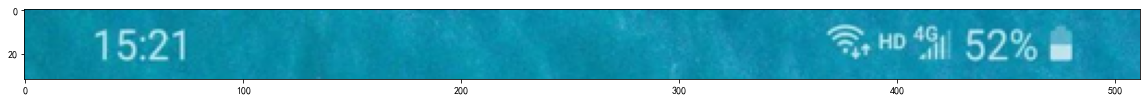

In [53]:
img2=get_image("D:/Bei/xhjh/project/data/oneui/oneui系统截图_7.jpg")
print(img2.shape)
plt.figure(figsize=(20,20))
img2=img2.reshape(32,512,-1)
print(img2.shape)
plt.imshow(img2)
plt.show()

In [59]:
for index,name in enumerate(os_name):
    subpath=path+name+'/'
    sz=len(os.listdir(subpath))
    train_sz=int(sz*(1-validation_split))
    cur=get_data(subpath)[:10]/255
    
    mobile_predict=np.argmax(mobile_model.predict(cur),axis=1)
    print(mobile_predict)

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3 3 3]


In [48]:
cnt=0
for i in range(32):
    for j in range(512):
        for k in range(3):
            if(img[i][j][k]!=img2[i][j][k]):
                cnt+=1
                print("in(%d,%d,%d)%d:%d"%(i,j,k,img[i][j][k],img2[i][j][k]))
print(cnt)

in(3,92,0)8:7
in(3,92,1)8:7
in(3,92,2)8:7
in(3,344,0)8:7
in(3,344,1)8:7
in(3,344,2)8:7
in(3,352,0)8:7
in(3,352,1)8:7
in(3,352,2)8:7
in(3,368,0)8:7
in(3,368,1)8:7
in(3,368,2)8:7
in(3,379,0)8:7
in(3,379,1)8:7
in(3,379,2)8:7
in(3,395,0)8:9
in(3,395,1)8:9
in(3,395,2)8:9
in(3,396,0)8:9
in(3,396,1)8:9
in(3,396,2)8:9
in(3,398,0)8:7
in(3,398,1)8:7
in(3,398,2)8:7
in(4,87,0)8:9
in(4,87,1)8:9
in(4,87,2)8:9
in(4,91,0)9:8
in(4,91,1)9:8
in(4,91,2)9:8
in(4,92,0)3:6
in(4,92,1)3:6
in(4,92,2)3:6
in(4,93,0)8:10
in(4,93,1)8:10
in(4,93,2)8:10
in(4,94,0)6:8
in(4,94,1)6:8
in(4,94,2)6:8
in(4,343,0)7:9
in(4,343,1)7:9
in(4,343,2)7:9
in(4,344,0)5:7
in(4,344,1)5:7
in(4,344,2)5:7
in(4,346,0)7:8
in(4,346,1)7:8
in(4,346,2)7:8
in(4,347,0)7:8
in(4,347,1)7:8
in(4,347,2)7:8
in(4,348,0)6:7
in(4,348,1)6:7
in(4,348,2)6:7
in(4,349,0)6:7
in(4,349,1)6:7
in(4,349,2)6:7
in(4,350,0)9:8
in(4,350,1)9:8
in(4,350,2)9:8
in(4,352,0)6:9
in(4,352,1)6:9
in(4,352,2)6:9
in(4,353,0)7:8
in(4,353,1)7:8
in(4,353,2)7:8
in(4,357,0)8:10
in(4,357,

in(9,97,1)3:5
in(9,97,2)3:5
in(9,98,0)1:6
in(9,98,1)1:6
in(9,98,2)1:6
in(9,102,0)8:9
in(9,102,1)8:9
in(9,102,2)8:9
in(9,103,0)8:7
in(9,103,1)8:7
in(9,103,2)8:7
in(9,104,0)5:6
in(9,104,1)5:6
in(9,104,2)5:6
in(9,105,0)9:6
in(9,105,1)9:6
in(9,105,2)9:6
in(9,106,0)37:56
in(9,106,1)37:56
in(9,106,2)37:56
in(9,107,0)176:161
in(9,107,1)176:161
in(9,107,2)176:161
in(9,108,0)183:171
in(9,108,1)183:171
in(9,108,2)183:171
in(9,109,0)193:172
in(9,109,1)193:172
in(9,109,2)193:172
in(9,110,0)186:170
in(9,110,1)186:170
in(9,110,2)186:170
in(9,111,0)186:171
in(9,111,1)186:171
in(9,111,2)186:171
in(9,112,0)186:171
in(9,112,1)186:171
in(9,112,2)186:171
in(9,113,0)186:170
in(9,113,1)186:170
in(9,113,2)186:170
in(9,114,0)133:97
in(9,114,1)133:97
in(9,114,2)133:97
in(9,115,0)33:44
in(9,115,1)33:44
in(9,115,2)33:44
in(9,116,0)163:149
in(9,116,1)163:149
in(9,116,2)163:149
in(9,117,0)181:171
in(9,117,1)181:171
in(9,117,2)181:171
in(9,118,0)167:164
in(9,118,1)167:164
in(9,118,2)167:164
in(9,119,0)186:172
in(9,

in(11,388,1)9:6
in(11,388,2)9:6
in(11,389,0)81:60
in(11,389,1)81:60
in(11,389,2)81:60
in(11,390,0)171:163
in(11,390,1)171:163
in(11,390,2)171:163
in(11,391,0)73:122
in(11,391,1)73:122
in(11,391,2)73:122
in(11,392,0)14:37
in(11,392,1)14:37
in(11,392,2)14:37
in(11,393,0)22:11
in(11,393,1)22:11
in(11,393,2)22:11
in(11,394,0)70:45
in(11,394,1)70:45
in(11,394,2)70:45
in(11,395,0)135:97
in(11,395,1)135:97
in(11,395,2)135:97
in(11,396,0)179:137
in(11,396,1)179:137
in(11,396,2)179:137
in(11,397,0)182:152
in(11,397,1)182:152
in(11,397,2)182:152
in(11,398,0)179:152
in(11,398,1)179:152
in(11,398,2)179:152
in(11,399,0)176:145
in(11,399,1)176:145
in(11,399,2)176:145
in(11,400,0)131:110
in(11,400,1)131:110
in(11,400,2)131:110
in(11,401,0)51:49
in(11,401,1)51:49
in(11,401,2)51:49
in(11,402,0)22:13
in(11,402,1)22:13
in(11,402,2)22:13
in(11,403,0)9:32
in(11,403,1)9:32
in(11,403,2)9:32
in(11,404,0)112:122
in(11,404,1)112:122
in(11,404,2)112:122
in(11,405,0)165:164
in(11,405,1)165:164
in(11,405,2)165:164

in(13,465,0)86:142
in(13,465,1)86:142
in(13,465,2)86:142
in(13,466,0)13:26
in(13,466,1)13:26
in(13,466,2)13:26
in(13,467,0)7:6
in(13,467,1)7:6
in(13,467,2)7:6
in(13,468,0)6:3
in(13,468,1)6:3
in(13,468,2)6:3
in(13,469,0)11:8
in(13,469,1)11:8
in(13,469,2)11:8
in(13,470,0)3:5
in(13,470,1)3:5
in(13,470,2)3:5
in(13,471,0)10:7
in(13,471,1)10:7
in(13,471,2)10:7
in(13,472,0)3:7
in(13,472,1)3:7
in(13,472,2)3:7
in(13,474,0)12:10
in(13,474,1)12:10
in(13,474,2)12:10
in(13,475,0)26:22
in(13,475,1)26:22
in(13,475,2)26:22
in(13,476,0)68:59
in(13,476,1)68:59
in(13,476,2)68:59
in(13,477,0)77:81
in(13,477,1)77:81
in(13,477,2)77:81
in(13,478,0)84:81
in(13,478,1)84:81
in(13,478,2)84:81
in(13,479,0)84:81
in(13,479,1)84:81
in(13,479,2)84:81
in(13,480,0)84:81
in(13,480,1)84:81
in(13,480,2)84:81
in(13,481,0)84:81
in(13,481,1)84:81
in(13,481,2)84:81
in(13,482,0)84:81
in(13,482,1)84:81
in(13,482,2)84:81
in(13,483,0)84:81
in(13,483,1)84:81
in(13,483,2)84:81
in(13,484,0)84:82
in(13,484,1)84:82
in(13,484,2)84:82
i

in(16,428,2)13:26
in(16,429,0)8:6
in(16,429,1)8:6
in(16,429,2)8:6
in(16,432,0)11:10
in(16,432,1)11:10
in(16,432,2)11:10
in(16,433,0)5:4
in(16,433,1)5:4
in(16,433,2)5:4
in(16,434,0)91:66
in(16,434,1)91:66
in(16,434,2)91:66
in(16,435,0)184:177
in(16,435,1)184:177
in(16,435,2)184:177
in(16,436,0)155:179
in(16,436,1)155:179
in(16,436,2)155:179
in(16,437,0)76:152
in(16,437,1)76:152
in(16,437,2)76:152
in(16,438,0)28:98
in(16,438,1)28:98
in(16,438,2)28:98
in(16,439,0)28:85
in(16,439,1)28:85
in(16,439,2)28:85
in(16,440,0)76:123
in(16,440,1)76:123
in(16,440,2)76:123
in(16,441,0)169:180
in(16,441,1)169:180
in(16,441,2)169:180
in(16,442,0)155:148
in(16,442,1)155:148
in(16,442,2)155:148
in(16,443,0)29:31
in(16,443,1)29:31
in(16,443,2)29:31
in(16,444,0)10:8
in(16,444,1)10:8
in(16,444,2)10:8
in(16,445,0)5:8
in(16,445,1)5:8
in(16,445,2)5:8
in(16,446,0)7:3
in(16,446,1)7:3
in(16,446,2)7:3
in(16,447,0)41:45
in(16,447,1)41:45
in(16,447,2)41:45
in(16,448,0)120:147
in(16,448,1)120:147
in(16,448,2)120:147
i

in(19,50,2)9:7
in(19,51,0)7:8
in(19,51,1)7:8
in(19,51,2)7:8
in(19,52,0)4:5
in(19,52,1)4:5
in(19,52,2)4:5
in(19,53,0)95:82
in(19,53,1)95:82
in(19,53,2)95:82
in(19,54,0)199:184
in(19,54,1)199:184
in(19,54,2)199:184
in(19,55,0)109:145
in(19,55,1)109:145
in(19,55,2)109:145
in(19,56,0)20:40
in(19,56,1)20:40
in(19,56,2)20:40
in(19,58,0)11:8
in(19,58,1)11:8
in(19,58,2)11:8
in(19,59,0)8:9
in(19,59,1)8:9
in(19,59,2)8:9
in(19,60,0)12:9
in(19,60,1)12:9
in(19,60,2)12:9
in(19,61,0)9:7
in(19,61,1)9:7
in(19,61,2)9:7
in(19,62,0)3:8
in(19,62,1)3:8
in(19,62,2)3:8
in(19,63,0)81:117
in(19,63,1)81:117
in(19,63,2)81:117
in(19,64,0)175:177
in(19,64,1)175:177
in(19,64,2)175:177
in(19,65,0)109:65
in(19,65,1)109:65
in(19,65,2)109:65
in(19,66,0)7:3
in(19,66,1)7:3
in(19,66,2)7:3
in(19,67,0)18:11
in(19,67,1)18:11
in(19,67,2)18:11
in(19,68,0)10:7
in(19,68,1)10:7
in(19,68,2)10:7
in(19,69,0)7:4
in(19,69,1)7:4
in(19,69,2)7:4
in(19,70,0)77:99
in(19,70,1)77:99
in(19,70,2)77:99
in(19,71,0)186:182
in(19,71,1)186:182
in(19

in(21,108,1)187:190
in(21,108,2)187:190
in(21,109,0)202:195
in(21,109,1)202:195
in(21,109,2)202:195
in(21,110,0)192:193
in(21,110,1)192:193
in(21,110,2)192:193
in(21,111,0)192:193
in(21,111,1)192:193
in(21,111,2)192:193
in(21,112,0)192:193
in(21,112,1)192:193
in(21,112,2)192:193
in(21,113,0)192:197
in(21,113,1)192:197
in(21,113,2)192:197
in(21,114,0)143:140
in(21,114,1)143:140
in(21,114,2)143:140
in(21,115,0)43:76
in(21,115,1)43:76
in(21,115,2)43:76
in(21,116,0)167:183
in(21,116,1)167:183
in(21,116,2)167:183
in(21,117,0)187:189
in(21,117,1)187:189
in(21,117,2)187:189
in(21,118,0)171:141
in(21,118,1)171:141
in(21,118,2)171:141
in(21,119,0)184:190
in(21,119,1)184:190
in(21,119,2)184:190
in(21,121,0)78:75
in(21,121,1)78:75
in(21,121,2)78:75
in(21,122,0)8:6
in(21,122,1)8:6
in(21,122,2)8:6
in(21,123,0)5:7
in(21,123,1)5:7
in(21,123,2)5:7
in(21,124,0)8:7
in(21,124,1)8:7
in(21,124,2)8:7
in(21,125,0)7:8
in(21,125,1)7:8
in(21,125,2)7:8
in(21,341,0)6:7
in(21,341,1)6:7
in(21,341,2)6:7
in(21,342,0)

in(23,347,1)7:10
in(23,347,2)7:10
in(23,348,0)41:125
in(23,348,1)41:125
in(23,348,2)41:125
in(23,349,0)146:139
in(23,349,1)146:139
in(23,349,2)146:139
in(23,350,0)45:31
in(23,350,1)45:31
in(23,350,2)45:31
in(23,351,0)127:57
in(23,351,1)127:57
in(23,351,2)127:57
in(23,352,0)126:144
in(23,352,1)126:144
in(23,352,2)126:144
in(23,353,0)19:51
in(23,353,1)19:51
in(23,353,2)19:51
in(23,354,0)8:5
in(23,354,1)8:5
in(23,354,2)8:5
in(23,355,0)68:41
in(23,355,1)68:41
in(23,355,2)68:41
in(23,356,0)150:69
in(23,356,1)150:69
in(23,356,2)150:69
in(23,357,0)165:68
in(23,357,1)165:68
in(23,357,2)165:68
in(23,358,0)153:148
in(23,358,1)153:148
in(23,358,2)153:148
in(23,359,0)41:105
in(23,359,1)41:105
in(23,359,2)41:105
in(23,360,0)8:6
in(23,360,1)8:6
in(23,360,2)8:6
in(23,367,0)8:7
in(23,367,1)8:7
in(23,367,2)8:7
in(23,369,0)8:27
in(23,369,1)8:27
in(23,369,2)8:27
in(23,370,0)8:32
in(23,370,1)8:32
in(23,370,2)8:32
in(23,372,0)8:4
in(23,372,1)8:4
in(23,372,2)8:4
in(23,374,0)8:21
in(23,374,1)8:21
in(23,374,2

in(27,341,0)8:6
in(27,341,1)8:6
in(27,341,2)8:6
in(27,342,0)8:7
in(27,342,1)8:7
in(27,342,2)8:7
in(27,343,0)8:9
in(27,343,1)8:9
in(27,343,2)8:9
in(27,344,0)8:10
in(27,344,1)8:10
in(27,344,2)8:10
in(27,346,0)8:6
in(27,346,1)8:6
in(27,346,2)8:6
in(27,347,0)8:9
in(27,347,1)8:9
in(27,347,2)8:9
in(27,349,0)8:10
in(27,349,1)8:10
in(27,349,2)8:10
in(27,350,0)8:7
in(27,350,1)8:7
in(27,350,2)8:7
in(27,351,0)8:6
in(27,351,1)8:6
in(27,351,2)8:6
in(27,353,0)8:9
in(27,353,1)8:9
in(27,353,2)8:9
in(27,354,0)8:4
in(27,354,1)8:4
in(27,354,2)8:4
in(27,355,0)8:5
in(27,355,1)8:5
in(27,355,2)8:5
in(27,356,0)8:11
in(27,356,1)8:11
in(27,356,2)8:11
in(27,358,0)8:7
in(27,358,1)8:7
in(27,358,2)8:7
in(27,359,0)8:7
in(27,359,1)8:7
in(27,359,2)8:7
in(27,360,0)8:7
in(27,360,1)8:7
in(27,360,2)8:7
in(27,417,0)8:9
in(27,417,1)8:9
in(27,417,2)8:9
in(27,418,0)8:9
in(27,418,1)8:9
in(27,418,2)8:9
in(27,419,0)8:9
in(27,419,1)8:9
in(27,419,2)8:9
in(27,420,0)8:9
in(27,420,1)8:9
in(27,420,2)8:9
in(27,421,0)8:9
in(27,421,1)8:9

In [57]:
print(test_data_y)
mobile_predict=np.argmax(mobile_model.predict(test_data_x),axis=1)
print(mobile_predict)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1.

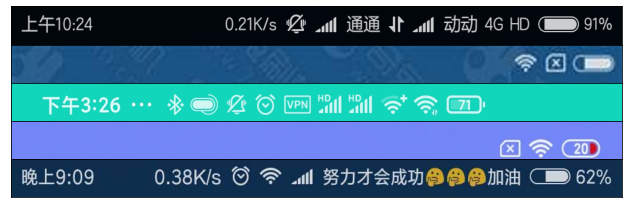

In [94]:
plt.subplots_adjust(left=0, top= 0.01, right = 0.01, bottom = 0, wspace = 0, hspace = 0)
plt.axis('off')
fig, axes = plt.subplots(5,1,figsize=(100,3))
axes = axes.flatten()
import random
a=test_data_x
a=get_data(path+os_name[3]+"/")
np.random.shuffle(a) 
for i,index in enumerate(a[:5]):
    img=index
    axes[i].imshow(img)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace =0, hspace =0)
plt.show()
